# Stacked Radial Thermodynamic Profiles (Mass Weighted Average)

In [ ]:
#PART 1: Loadiing Packages

import yt
import pyxsim

import h5py
import numpy as np
import illustris_python as il
import glob
from numba import jit
from yt import derived_field

from tqdm import tqdm
import os
import pylab as plt
from concurrent.futures import ProcessPoolExecutor, as_completed, ThreadPoolExecutor

soxs : [WARNING  ] 2025-05-19 20:30:49,408 Setting 'soxs_data_dir' to /home/tnguser/.cache/soxs for this session. Please update your configuration if you want it somewhere else.


In [ ]:
#PART 2: Simulation Specification
basePath = "../../../sims.TNG/TNG100-1/output/"
snap = 50                                                       #z=1
nbins = 8
r_norm_max = 2
r_norm_min = 1e-2
max_workers = 3
tag = ["Efficient_AGN", "Efficient_Non", "Inefficient_AGN", "Inefficient_Non"]
#hm = "5"

In [ ]:
def process_single_halo(haloID, label):
    try:
        print(f"Processing {label} halo {haloID}...")
        halo = il.groupcat.loadSingle(basePath, snap, haloID=haloID)

        header = il.groupcat.loadHeader(basePath, snap)
        fields = ["Coordinates", "GFM_CoolingRate", "Density", "InternalEnergy", "ElectronAbundance", "StarFormationRate", "Masses", "GFM_Metallicity", "Velocities"]
        
        gas = il.snapshot.loadHalo(basePath, snap, haloID, "gas", fields=fields)
        with h5py.File(il.snapshot.snapPath(basePath, snap), 'r') as f:
            header_snap = dict(f['Header'].attrs)

        filename = f"halo_{label}_{haloID}.hdf5"
        with h5py.File(filename, 'w') as f:
            for key in gas.keys():
                f['PartType0/' + key] = gas[key]
            f.create_group('Header')
            f['Header'].attrs['NumFilesPerSnapshot'] = 1
            f['Header'].attrs['MassTable'] = header_snap['MassTable']
            f['Header'].attrs['BoxSize'] = header['BoxSize']
            f['Header'].attrs['Time'] = header['Time']
            f['Header'].attrs['Redshift'] = header['Redshift']
            f['Header'].attrs['NumPart_ThisFile'] = np.array([gas['count'],0,0,0,0,0])
            f['Header'].attrs['HubbleParam'] = header['HubbleParam']
            f['Header'].attrs['Omega0'] = header['Omega0']
            f['Header'].attrs['OmegaLambda'] = header['OmegaLambda']
            f['Header'].attrs['UnitLength_in_cm'] = header_snap['UnitLength_in_cm']
            f['Header'].attrs['UnitMass_in_g'] = header_snap['UnitMass_in_g']
            f['Header'].attrs['UnitVelocity_in_cm_per_s'] = header_snap['UnitVelocity_in_cm_per_s']

        @yt.derived_field(name="radius_r200", units="", sampling_type="cell", force_override=True)
        def _radius_r200(field, data):
            r1 = np.linalg.norm(data["PartType0", "Coordinates"].to("kpc") - c, axis=1)
            return  r1 / r200

        ds = yt.load(filename)

        c = ds.arr(halo["GroupPos"], "code_length").to("kpc")
        r200a = ds.arr(halo["Group_R_Crit200"], "code_length").to("kpc")
        r200 = r200a.to_value("kpc") 
        del halo, header, gas

        sp = ds.sphere(c, r_norm_max * r200)

        def get_radial_profiles(sp, fields_to_profile, nbins, r_norm_min, r_norm_max, weight_field):
            profiles = {}
            for field in fields_to_profile:
                prof = yt.Profile1D(sp, ("gas", "radius_r200"), nbins, r_norm_min, r_norm_max, True, weight_field=weight_field)
                prof.add_fields([field])
                key = field[1]
                profiles[f"{key}_r"] = prof.x
                profiles[f"{key}_values"] = prof[field]
            return profiles

        fields_to_profile = [
            ("gas", "temperature"),
            ("gas", "entropy"),
            ("gas", "pressure"),
            ("gas", "density"),
            ("gas", "star_formation_rate"), 
            ("gas", "metallicity"),
        ]

        weight_field = ("gas", "mass")

        profiles_dict = get_radial_profiles(sp, fields_to_profile, nbins, r_norm_min, r_norm_max, weight_field)

        r_bin_center = profiles_dict["temperature_r"]
        np.savez("rbins_mass.npz", r_bin_center = r_bin_center)
        temp = profiles_dict["temperature_values"]
        entropy = profiles_dict["entropy_values"]
        pressure = profiles_dict["pressure_values"]
        density = profiles_dict["density_values"]
        sfr = profiles_dict["star_formation_rate_values"]
        metal = profiles_dict["metallicity_values"]
        

        for f in [filename, filename + ".ewah"]:
            if os.path.exists(f):
                os.remove(f)

        return temp, entropy, pressure, density, sfr, metal

    except Exception as e:
        print(f"❌ Failed for halo {haloID}: {e}")
        return None

def combined_profiles(halo_list, label, hm):
    temp_all = []
    entropy_all = []
    pressure_all = []
    density_all = []
    sfr_all = []
    metal_all = []
                            
    with ProcessPoolExecutor(max_workers=max_workers) as executor:
    #with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = {executor.submit(process_single_halo, haloID, label): haloID for haloID in halo_list}
        with tqdm(total=len(futures), desc=f"Processing {label} halos") as pbar:
            for future in as_completed(futures):
                result = future.result()
                if result:
                    t, e, p, d, s, m = result
                    temp_all.append(t)
                    entropy_all.append(e)
                    pressure_all.append(p)
                    density_all.append(d)
                    sfr_all.append(s)
                    metal_all.append(m)
                pbar.update(1)


    np.savez(f"combined100ytm_hm{hm}_{label}.npz",
             temperature_mean=np.nanmean(temp_all, axis=0),
             temperature_sem=np.nanstd(temp_all, axis=0, ddof=1) / np.sqrt(len(temp_all)),
             entropy_mean=np.nanmean(entropy_all, axis=0),
             entropy_sem=np.nanstd(entropy_all, axis=0, ddof=1) / np.sqrt(len(entropy_all)),
             pressure_mean=np.nanmean(pressure_all, axis=0),
             pressure_sem=np.nanstd(pressure_all, axis=0, ddof=1) / np.sqrt(len(pressure_all)),
             density_mean=np.nanmean(density_all, axis=0),
             density_sem=np.nanstd(density_all, axis=0, ddof=1) / np.sqrt(len(density_all)),
             sfr_mean=np.nanmean(sfr_all, axis=0),
             sfr_sem=np.nanstd(sfr_all, axis=0, ddof=1) / np.sqrt(len(sfr_all)),
             metal_mean=np.nanmean(metal_all, axis=0),
             metal_sem=np.nanstd(metal_all, axis=0, ddof=1) / np.sqrt(len(metal_all)))

    print(f"✅ Saved combined100ytm_hm{hm}_{label}.npz")


In [ ]:
#PART 4B:: Usage: Calculate avg and std of mean of all halo profiles of same halo labels and save in 4 different npz
'''
data = np.load(f"accretor_agn100_hm{hm}.npz")

combined_profiles(data["ha_agn"], tag[0])
combined_profiles(data["hn_agn"], tag[2])
combined_profiles(data["hn_non"], tag[3])
'''
data1 = np.load(f"accretor_agn100_mine_hm1.npz")
data2 = np.load(f"accretor_agn100_mine_hm2.npz")
data3 = np.load(f"accretor_agn100_mine_hm3.npz")
data4 = np.load(f"accretor_agn100_mine_hm4.npz")
data5 = np.load(f"accretor_agn100_mine_hm5.npz")
#data6 = np.load(f"accretor_agn100_mine_hm6.npz")
'''
combined_profiles(data6["ha_agn"], tag[0], "6")
combined_profiles(data6["hn_agn"], tag[2], "6")
combined_profiles(data6["hn_non"], tag[3], "6")

combined_profiles(data5["ha_agn"], tag[0], "5")
combined_profiles(data5["hn_agn"], tag[2], "5")
combined_profiles(data5["hn_non"], tag[3], "5")
'''
combined_profiles(data4["ha_agn"], tag[0], "4")
combined_profiles(data4["hn_agn"], tag[2], "4")
combined_profiles(data4["hn_non"], tag[3], "4")

combined_profiles(data3["ha_agn"], tag[0], "3")
combined_profiles(data3["hn_agn"], tag[2], "3")
combined_profiles(data3["hn_non"], tag[3], "3")

combined_profiles(data2["ha_agn"], tag[0], "2")
combined_profiles(data2["hn_agn"], tag[2], "2")
combined_profiles(data2["hn_non"], tag[3], "2")
'''
combined_profiles(data1["ha_agn"], tag[0], "1")
combined_profiles(data1["hn_agn"], tag[2], "1")
combined_profiles(data1["hn_non"], tag[3], "1")
'''

Processing Efficient_AGN halo 194...
Processing Efficient_AGN halo 195...Processing Efficient_AGN halo 73...

Processing Efficient_AGN halos:   0%|          | 0/12 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-19 20:30:57,999 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:30:58,014 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:30:58,077 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:30:58,186 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:30:58,188 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:30:58,193 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:30:58,194 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:30:58,202 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:30:58,199 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:30:58,210 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:3

Processing Efficient_AGN halo 248...


Processing Efficient_AGN halos:  17%|█▋        | 2/12 [00:06<00:25,  2.55s/it]

Processing Efficient_AGN halo 258...


yt : [INFO     ] 2025-05-19 20:31:03,152 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:31:03,191 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:31:03,252 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:31:03,280 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:31:03,287 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:31:03,298 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:31:03,331 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:31:03,338 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:31:03,342 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:31:03,365 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:31:03

Processing Efficient_AGN halo 261...


Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  2.22it/s]
yt : [INFO     ] 2025-05-19 20:31:04,848 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:31:04,954 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:31:04,959 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:31:04,977 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:31:04,992 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:31:04,996 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:31:04,997 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:31:04,998 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:31:04,999 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:31:05,001 Parameters: omega_radiation         

Processing Efficient_AGN halo 293...


Initializing refined index: 100%|██████████| 2/2 [00:01<00:00,  1.86it/s]
yt : [INFO     ] 2025-05-19 20:31:07,910 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:31:08,008 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:31:08,022 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:31:08,036 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:31:08,060 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:31:08,063 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:31:08,065 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:31:08,067 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:31:08,086 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:31:08,102 Parameters: omega_radiation         

Processing Efficient_AGN halo 306...

Processing Efficient_AGN halos:  42%|████▏     | 5/12 [00:12<00:14,  2.13s/it]

Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  2.56it/s]
yt : [INFO     ] 2025-05-19 20:31:09,192 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:31:09,361 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:31:09,380 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:31:09,383 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:31:09,398 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:31:09,413 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:31:09,418 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:31:09,434 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:31:09,454 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:31:09,480 Parameters: omega_radiation         

Processing Efficient_AGN halo 316...


yt : [INFO     ] 2025-05-19 20:31:11,208 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:31:11,313 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:31:11,322 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:31:11,339 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:31:11,343 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:31:11,345 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:31:11,346 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:31:11,347 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:31:11,352 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:31:11,355 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:31:11,356 Parameters: hubble_consta

Processing Efficient_AGN halo 346...


Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  2.47it/s]
yt : [INFO     ] 2025-05-19 20:31:12,890 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:31:12,965 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:31:12,966 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:31:12,967 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:31:12,968 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:31:12,969 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:31:12,971 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:31:12,972 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:31:12,972 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:31:12,973 Parameters: omega_radiation         

Processing Efficient_AGN halo 401...


yt : [INFO     ] 2025-05-19 20:31:15,411 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:31:15,500 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:31:15,512 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:31:15,535 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:31:15,554 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:31:15,561 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:31:15,587 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:31:15,602 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:31:15,614 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:31:15,619 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:31:15,628 Parameters: hubble_consta

Processing Efficient_AGN halo 405...


Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  3.94it/s]yt : [INFO     ] 2025-05-19 20:31:16,371 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:31:16,387 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:31:16,390 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:31:16,395 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:31:16,409 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:31:16,423 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:31:16,437 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:31:16,442 Parameters: omega_matter              = 0.3089
Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  3.04it/s]yt : [INFO     ] 2025-05-19 20:31:16,458 Parameters: omega_radiation           = 0.0

yt : [INFO     ]

✅ Saved combined100ytm_hm4_Efficient_AGN.npz



Processing Inefficient_AGN halos:   0%|          | 0/68 [00:00<?, ?it/s]

Processing Inefficient_AGN halo 18...Processing Inefficient_AGN halo 50...Processing Inefficient_AGN halo 51...




yt : [INFO     ] 2025-05-19 20:31:27,148 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:31:27,294 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:31:27,311 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:31:27,318 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:31:27,326 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:31:27,350 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:31:27,365 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:31:27,386 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:31:27,396 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:31:27,400 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:31:27,402 Parameters: hubble_consta

Processing Inefficient_AGN halo 57...


Initializing refined index:   0%|          | 0/10 [00:00<?, ?it/s]

Processing Inefficient_AGN halo 58...

Processing Inefficient_AGN halos:   3%|▎         | 2/68 [00:09<04:36,  4.19s/it]

yt : [INFO     ] 2025-05-19 20:31:35,273 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:31:35,378 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:31:35,386 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:31:35,390 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:31:35,394 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:31:35,410 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:31:35,413 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:31:35,414 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:31:35,418 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:31:35,422 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:31:35,427 Parameters: hubble_consta

Processing Inefficient_AGN halo 60...

Processing Inefficient_AGN halos:   4%|▍         | 3/68 [00:17<06:20,  5.86s/it]


Processing Inefficient_AGN halo 62...


yt : [INFO     ] 2025-05-19 20:31:44,455 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:31:44,536 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:31:44,537 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:31:44,539 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:31:44,540 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:31:44,541 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:31:44,542 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:31:44,543 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:31:44,544 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:31:44,544 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:31:44,545 Parameters: hubble_consta

Processing Inefficient_AGN halo 79...

Processing Inefficient_AGN halos:   7%|▋         | 5/68 [00:21<03:53,  3.70s/it]

yt : [INFO     ] 2025-05-19 20:31:48,317 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:31:48,460 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:31:48,476 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:31:48,488 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:31:48,490 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:31:48,493 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:31:48,495 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:31:48,496 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:31:48,497 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:31:48,497 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:31:48,498 Parameters: hubble_consta

Processing Inefficient_AGN halo 84...


Initializing refined index: 100%|██████████| 5/5 [00:02<00:00,  2.27it/s]yt : [INFO     ] 2025-05-19 20:31:51,374 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:31:51,459 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:31:51,483 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:31:51,488 Parameters: domain_left_edge          = [0. 0. 0.]
Initializing refined index: 100%|██████████| 5/5 [00:02<00:00,  2.29it/s]yt : [INFO     ] 2025-05-19 20:31:51,511 Parameters: domain_right_edge         = [75000. 75000. 75000.]

yt : [INFO     ] 2025-05-19 20:31:51,538 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:31:51,546 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:31:51,565 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:31:51,568 Parameters: omega_matter              = 0.3089
yt :

Processing Inefficient_AGN halo 93...
Processing Inefficient_AGN halo 94...

Processing Inefficient_AGN halos:  12%|█▏        | 8/68 [00:31<03:05,  3.09s/it]

yt : [INFO     ] 2025-05-19 20:31:57,564 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:31:57,663 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:31:57,668 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:31:57,671 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:31:57,679 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:31:57,680 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:31:57,681 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:31:57,685 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:31:57,686 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:31:57,683 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:31:57,688 Parameters: o

Processing Inefficient_AGN halo 106...


Processing Inefficient_AGN halos:  13%|█▎        | 9/68 [00:36<03:49,  3.88s/it]yt : [INFO     ] 2025-05-19 20:32:03,685 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:32:03,763 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:32:03,766 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:32:03,768 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:32:03,772 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:32:03,773 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:32:03,775 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:32:03,778 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:32:03,782 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:32:03,787 Parameters: omega_radiation   

Processing Inefficient_AGN halo 110...


Initializing refined index: 100%|██████████| 4/4 [00:01<00:00,  2.52it/s].52s/it]
yt : [INFO     ] 2025-05-19 20:32:05,829 Calculating time from 5.007e-01 to be 1.855e+17 seconds
Processing Inefficient_AGN halos:  16%|█▌        | 11/68 [00:40<02:32,  2.68s/it]

Processing Inefficient_AGN halo 119...


yt : [INFO     ] 2025-05-19 20:32:05,929 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:32:05,955 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:32:05,979 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:32:05,995 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:32:06,018 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:32:06,042 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:32:06,061 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:32:06,077 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:32:06,093 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:32:06,095 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:32:06,120 Allocating for 6.036e+05 particles

Processing Inefficient_AGN halo 120...


yt : [INFO     ] 2025-05-19 20:32:09,473 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:32:09,562 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:32:09,570 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:32:09,577 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:32:09,581 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:32:09,606 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:32:09,618 Parameters: current_redshift          = 0.9972942257819404
Initializing refined index:  50%|█████     | 2/4 [00:01<00:01,  1.01it/s]yt : [INFO     ] 2025-05-19 20:32:09,630 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:32:09,643 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:32:09,644 Parameters: omega_radiation          

Processing Inefficient_AGN halo 121...


Initializing refined index: 100%|██████████| 4/4 [00:02<00:00,  1.46it/s]yt : [INFO     ] 2025-05-19 20:32:10,674 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:32:10,694 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:32:10,714 Parameters: domain_left_edge          = [0. 0. 0.]
Initializing refined index: 100%|██████████| 4/4 [00:03<00:00,  1.31it/s]
yt : [INFO     ] 2025-05-19 20:32:10,726 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:32:10,741 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:32:10,754 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:32:10,768 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:32:10,773 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:32:10,779 Parameters: omega_radiation           = 0.0
yt : [INFO     ]

Processing Inefficient_AGN halo 122...


Processing Inefficient_AGN halos:  22%|██▏       | 15/68 [00:48<01:52,  2.12s/it]

Processing Inefficient_AGN halo 123...


yt : [INFO     ] 2025-05-19 20:32:14,777 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:32:14,863 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:32:14,871 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:32:14,890 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:32:14,900 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:32:14,922 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:32:14,928 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:32:14,930 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:32:14,934 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:32:14,937 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:32:14,938 Parameters: hubble_consta

Processing Inefficient_AGN halo 124...

Processing Inefficient_AGN halos:  24%|██▎       | 16/68 [00:51<02:02,  2.35s/it]

yt : [INFO     ] 2025-05-19 20:32:18,093 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:32:18,177 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:32:18,194 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:32:18,199 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:32:18,204 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:32:18,207 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:32:18,224 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:32:18,238 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:32:18,242 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:32:18,246 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:32:18,258 Parameters: hubble_consta

Processing Inefficient_AGN halo 125...

Processing Inefficient_AGN halos:  25%|██▌       | 17/68 [00:53<01:50,  2.16s/it]

yt : [INFO     ] 2025-05-19 20:32:19,814 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:32:19,893 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:32:19,900 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:32:19,904 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:32:19,905 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:32:19,906 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:32:19,913 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:32:19,938 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:32:19,950 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:32:19,974 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:32:19,975 Parameters: hubble_consta

Processing Inefficient_AGN halo 132...


Initializing refined index:   0%|          | 0/4 [00:00<?, ?it/s]yt : [INFO     ] 2025-05-19 20:32:24,768 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:32:24,850 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:32:24,866 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:32:24,883 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:32:24,904 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:32:24,914 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:32:24,918 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:32:24,947 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:32:24,971 Parameters: omega_matter              = 0.3089
Initializing refined index:  50%|█████     | 2/4 [00:00<00:00,  3.53it/s]yt : [INFO   

Processing Inefficient_AGN halo 133...
Processing Inefficient_AGN halo 137...

Processing Inefficient_AGN halos:  29%|██▉       | 20/68 [01:04<02:11,  2.73s/it]

yt : [INFO     ] 2025-05-19 20:32:30,476 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:32:30,546 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:32:30,547 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:32:30,548 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:32:30,551 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:32:30,553 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:32:30,555 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:32:30,557 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:32:30,557 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:32:30,559 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:32:30,560 Parameters: hubble_consta

Processing Inefficient_AGN halo 139...


yt : [INFO     ] 2025-05-19 20:32:33,290 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:32:33,379 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:32:33,390 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:32:33,398 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:32:33,418 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:32:33,420 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:32:33,432 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:32:33,433 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:32:33,435 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:32:33,436 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:32:33,437 Parameters: hubble_consta

Processing Inefficient_AGN halo 142...

Processing Inefficient_AGN halos:  32%|███▏      | 22/68 [01:08<01:55,  2.51s/it]

Processing Inefficient_AGN halos:  34%|███▍      | 23/68 [01:09<01:22,  1.83s/it]

Processing Inefficient_AGN halo 147...


Initializing refined index:   0%|          | 0/4 [00:00<?, ?it/s]yt : [INFO     ] 2025-05-19 20:32:34,958 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:32:35,051 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:32:35,053 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:32:35,074 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:32:35,082 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:32:35,086 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:32:35,092 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:32:35,109 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:32:35,111 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:32:35,115 Parameters: omega_radiation           = 0.0
y

Processing Inefficient_AGN halo 148...


Processing Inefficient_AGN halos:  35%|███▌      | 24/68 [01:13<01:51,  2.53s/it]

Processing Inefficient_AGN halo 149...


Processing Inefficient_AGN halos:  37%|███▋      | 25/68 [01:13<01:23,  1.93s/it]yt : [INFO     ] 2025-05-19 20:32:39,401 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:32:39,478 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:32:39,487 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:32:39,500 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:32:39,511 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:32:39,522 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:32:39,535 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:32:39,549 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:32:39,559 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:32:39,566 Parameters: omega_radiation  

Processing Inefficient_AGN halo 155...


Initializing refined index:   0%|          | 0/3 [00:00<?, ?it/s]yt : [INFO     ] 2025-05-19 20:32:39,862 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:32:39,961 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:32:39,964 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:32:39,972 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:32:39,988 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:32:39,999 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:32:40,018 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:32:40,029 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:32:40,050 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:32:40,077 Parameters: omega_radiation           = 0.0
y

Processing Inefficient_AGN halo 156...


yt : [INFO     ] 2025-05-19 20:32:43,353 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:32:43,443 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:32:43,444 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:32:43,446 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:32:43,447 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:32:43,450 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:32:43,451 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:32:43,453 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:32:43,462 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:32:43,463 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:32:43,464 Parameters: hubble_consta

Processing Inefficient_AGN halo 159...


Initializing refined index:  67%|██████▋   | 2/3 [00:00<00:00,  4.08it/s]yt : [INFO     ] 2025-05-19 20:32:44,349 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:32:44,422 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:32:44,433 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:32:44,455 Parameters: domain_left_edge          = [0. 0. 0.]


Processing Inefficient_AGN halo 161...


Processing Inefficient_AGN halos:  43%|████▎     | 29/68 [01:18<00:54,  1.40s/it]yt : [INFO     ] 2025-05-19 20:32:44,462 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:32:44,467 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:32:44,483 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:32:44,498 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:32:44,500 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:32:44,516 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:32:44,519 Parameters: hubble_constant           = 0.6774
Initializing refined index:  67%|██████▋   | 2/3 [00:00<00:00,  4.35it/s]yt : [INFO     ] 2025-05-19 20:32:45,495 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:32:45,582 Parameters: current_time              = 1.854965744709531e+17 s
yt : 

Processing Inefficient_AGN halo 178...
Processing Inefficient_AGN halo 181...


Processing Inefficient_AGN halos:  46%|████▌     | 31/68 [01:23<00:59,  1.61s/it]yt : [INFO     ] 2025-05-19 20:32:48,696 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:32:48,764 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:32:48,765 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:32:48,766 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:32:48,768 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:32:48,769 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:32:48,770 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:32:48,771 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:32:48,772 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:32:48,773 Parameters: omega_radiation  

Processing Inefficient_AGN halo 183...


Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  2.29it/s]
yt : [INFO     ] 2025-05-19 20:32:50,566 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:32:50,653 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:32:50,656 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:32:50,664 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:32:50,665 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:32:50,669 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:32:50,670 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:32:50,687 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:32:50,699 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:32:50,710 Parameters: omega_radiation         

Processing Inefficient_AGN halo 192...

Processing Inefficient_AGN halos:  49%|████▊     | 33/68 [01:26<01:00,  1.73s/it]

Initializing refined index: 100%|██████████| 3/3 [00:01<00:00,  2.83it/s]


Processing Inefficient_AGN halo 202...

Processing Inefficient_AGN halos:  50%|█████     | 34/68 [01:26<00:45,  1.34s/it]

yt : [INFO     ] 2025-05-19 20:32:52,645 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:32:52,722 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:32:52,744 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:32:52,766 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:32:52,773 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:32:52,778 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:32:52,794 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:32:52,804 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:32:52,818 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:32:52,830 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:32:52,841 Parameters: hubble_consta

Processing Inefficient_AGN halo 204...


yt : [INFO     ] 2025-05-19 20:32:54,781 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:32:54,880 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:32:54,883 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:32:54,887 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:32:54,888 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:32:54,889 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:32:54,890 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:32:54,891 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:32:54,892 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:32:54,893 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:32:54,894 Parameters: hubble_consta

Processing Inefficient_AGN halo 206...
Processing Inefficient_AGN halo 213...


Processing Inefficient_AGN halos:  54%|█████▍    | 37/68 [01:30<00:36,  1.19s/it]yt : [INFO     ] 2025-05-19 20:32:56,840 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:32:56,911 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:32:56,920 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:32:56,921 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:32:56,923 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:32:56,937 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:32:56,946 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:32:56,954 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:32:56,956 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:32:56,959 Parameters: omega_radiation  

Processing Inefficient_AGN halo 216...


Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  2.57it/s]
yt : [INFO     ] 2025-05-19 20:32:58,602 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:32:58,685 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:32:58,700 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:32:58,704 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:32:58,706 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:32:58,707 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:32:58,708 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:32:58,709 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:32:58,710 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:32:58,711 Parameters: omega_radiation         

Processing Inefficient_AGN halo 221...


Processing Inefficient_AGN halos:  57%|█████▋    | 39/68 [01:34<00:44,  1.54s/it]

Processing Inefficient_AGN halo 227...

Processing Inefficient_AGN halos:  59%|█████▉    | 40/68 [01:35<00:36,  1.29s/it]

yt : [INFO     ] 2025-05-19 20:33:00,901 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:33:00,989 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:33:01,014 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:33:01,023 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:33:01,026 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:33:01,043 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:33:01,054 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:33:01,056 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:33:01,066 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:33:01,084 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:33:01,094 Parameters: hubble_consta

Processing Inefficient_AGN halo 231...


Initializing refined index:   0%|          | 0/2 [00:00<?, ?it/s]yt : [INFO     ] 2025-05-19 20:33:01,443 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:33:01,549 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:33:01,555 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:33:01,557 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:33:01,559 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:33:01,560 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:33:01,563 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:33:01,571 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:33:01,583 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:33:01,587 Parameters: omega_radiation           = 0.0
y

Processing Inefficient_AGN halo 234...

Processing Inefficient_AGN halos:  62%|██████▏   | 42/68 [01:38<00:38,  1.47s/it]

yt : [INFO     ] 2025-05-19 20:33:04,251 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:33:04,345 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:33:04,362 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:33:04,367 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:33:04,382 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:33:04,406 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:33:04,409 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:33:04,418 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:33:04,439 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:33:04,454 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:33:04,469 Parameters: hubble_consta

Processing Inefficient_AGN halo 237...


Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  3.86it/s]yt : [INFO     ] 2025-05-19 20:33:05,351 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:33:05,442 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:33:05,460 Parameters: domain_dimensions         = [1 1 1]
Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  2.44it/s]
yt : [INFO     ] 2025-05-19 20:33:05,465 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:33:05,466 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:33:05,483 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:33:05,487 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:33:05,498 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:33:05,501 Parameters: omega_matter              = 0.3089
yt :

Processing Inefficient_AGN halo 243...

Processing Inefficient_AGN halos:  65%|██████▍   | 44/68 [01:40<00:29,  1.23s/it]

yt : [INFO     ] 2025-05-19 20:33:06,610 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:33:06,700 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:33:06,711 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:33:06,715 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:33:06,717 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:33:06,719 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:33:06,727 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:33:06,739 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:33:06,743 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:33:06,758 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:33:06,786 Parameters: hubble_consta

Processing Inefficient_AGN halo 250...


Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  2.51it/s]


Processing Inefficient_AGN halo 264...

Processing Inefficient_AGN halos:  68%|██████▊   | 46/68 [01:42<00:23,  1.08s/it]

yt : [INFO     ] 2025-05-19 20:33:08,171 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:33:08,255 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:33:08,274 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:33:08,298 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:33:08,326 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:33:08,350 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:33:08,362 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:33:08,378 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:33:08,386 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:33:08,392 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:33:08,393 Parameters: hubble_consta

Processing Inefficient_AGN halo 265...


yt : [INFO     ] 2025-05-19 20:33:10,439 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:33:10,535 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:33:10,541 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:33:10,547 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:33:10,562 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:33:10,580 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:33:10,584 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:33:10,585 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:33:10,590 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:33:10,592 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:33:10,593 Parameters: hubble_consta

Processing Inefficient_AGN halo 274...


Processing Inefficient_AGN halos:  72%|███████▏  | 49/68 [01:45<00:19,  1.05s/it]

Processing Inefficient_AGN halo 277...


yt : [INFO     ] 2025-05-19 20:33:11,720 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:33:11,808 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:33:11,809 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:33:11,810 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:33:11,811 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:33:11,812 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:33:11,813 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:33:11,814 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:33:11,815 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:33:11,815 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:33:11,816 Parameters: hubble_consta

Processing Inefficient_AGN halo 278...

Processing Inefficient_AGN halos:  74%|███████▎  | 50/68 [01:47<00:22,  1.24s/it]

Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  3.04it/s]
yt : [INFO     ] 2025-05-19 20:33:13,578 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:33:13,660 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:33:13,676 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:33:13,688 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:33:13,702 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:33:13,706 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:33:13,718 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:33:13,735 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:33:13,758 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:33:13,774 Parameters: omega_radiation         

Processing Inefficient_AGN halo 280...


Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  3.37it/s]
yt : [INFO     ] 2025-05-19 20:33:15,080 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:33:15,177 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:33:15,201 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:33:15,205 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:33:15,213 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:33:15,214 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:33:15,227 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:33:15,259 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:33:15,278 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:33:15,306 Parameters: omega_radiation         

Processing Inefficient_AGN halo 290...


Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  2.54it/s]yt : [INFO     ] 2025-05-19 20:33:16,303 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:33:16,306 Parameters: domain_dimensions         = [1 1 1]

yt : [INFO     ] 2025-05-19 20:33:16,309 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:33:16,312 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:33:16,330 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:33:16,351 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:33:16,353 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:33:16,354 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:33:16,357 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:33:16,358 Parameters: hubble_constant           = 0.6774
y

Processing Inefficient_AGN halo 313...


Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  3.73it/s]
yt : [INFO     ] 2025-05-19 20:33:17,229 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:33:17,313 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:33:17,328 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:33:17,336 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:33:17,344 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:33:17,347 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:33:17,367 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:33:17,390 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:33:17,410 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:33:17,417 Parameters: omega_radiation         

Processing Inefficient_AGN halo 317...

Processing Inefficient_AGN halos:  79%|███████▉  | 54/68 [01:53<00:19,  1.40s/it]

Processing Inefficient_AGN halos:  81%|████████  | 55/68 [01:53<00:13,  1.07s/it]

Processing Inefficient_AGN halo 319...


yt : [INFO     ] 2025-05-19 20:33:19,430 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:33:19,523 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:33:19,549 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:33:19,562 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:33:19,570 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:33:19,575 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:33:19,576 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:33:19,592 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:33:19,608 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:33:19,610 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:33:19,

Processing Inefficient_AGN halo 331...


Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  3.60it/s]yt : [INFO     ] 2025-05-19 20:33:20,441 Calculating time from 5.007e-01 to be 1.855e+17 seconds

Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  2.86it/s]
yt : [INFO     ] 2025-05-19 20:33:20,526 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:33:20,550 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:33:20,560 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:33:20,574 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:33:20,589 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:33:20,606 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:33:20,623 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:33:20,633 Parameters: omega_matter              = 0.3089
yt 

Processing Inefficient_AGN halo 341...


Processing Inefficient_AGN halos:  85%|████████▌ | 58/68 [01:56<00:10,  1.07s/it]

Processing Inefficient_AGN halo 355...


yt : [INFO     ] 2025-05-19 20:33:22,807 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:33:22,887 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:33:22,904 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:33:22,915 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:33:22,932 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:33:22,948 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:33:22,962 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:33:22,978 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:33:22,989 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:33:23,008 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:33:23,021 Parameters: hubble_consta

Processing Inefficient_AGN halo 365...

yt : [INFO     ] 2025-05-19 20:33:23,160 Parameters: domain_dimensions         = [1 1 1]


Initializing refined index:   0%|          | 0/2 [00:00<?, ?it/s]yt : [INFO     ] 2025-05-19 20:33:23,190 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:33:23,230 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:33:23,242 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:33:23,262 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:33:23,272 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:33:23,288 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:33:23,295 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:33:23,305 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:33:23,339 Allocating for 2.019e+05 particles
Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  3.27it/s]
yt : [INFO     ] 2025-05-19 20:33:24,005 Calculating t

Processing Inefficient_AGN halo 374...

Processing Inefficient_AGN halos:  88%|████████▊ | 60/68 [01:59<00:09,  1.17s/it]

yt : [INFO     ] 2025-05-19 20:33:25,386 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:33:25,471 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:33:25,490 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:33:25,513 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:33:25,516 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:33:25,518 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:33:25,522 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:33:25,532 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:33:25,558 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:33:25,576 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:33:25,594 Parameters: hubble_consta

Processing Inefficient_AGN halo 389...


Processing Inefficient_AGN halos:  90%|████████▉ | 61/68 [02:00<00:08,  1.20s/it]yt : [INFO     ] 2025-05-19 20:33:26,644 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Inefficient_AGN halo 396...


Processing Inefficient_AGN halos:  91%|█████████ | 62/68 [02:01<00:06,  1.02s/it]yt : [INFO     ] 2025-05-19 20:33:26,709 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:33:26,710 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:33:26,711 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:33:26,713 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:33:26,713 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:33:26,716 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:33:26,719 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:33:26,720 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:33:26,721 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:33:26,722 Parameters: hubble_constant           = 0

Processing Inefficient_AGN halo 402...


yt : [INFO     ] 2025-05-19 20:33:28,186 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:33:28,276 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:33:28,281 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:33:28,287 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:33:28,302 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:33:28,322 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:33:28,334 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:33:28,344 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:33:28,349 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:33:28,370 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:33:28,392 Parameters: hubble_consta

Processing Inefficient_AGN halo 423...
Processing Inefficient_AGN halo 456...


Processing Inefficient_AGN halos:  97%|█████████▋| 66/68 [02:04<00:01,  1.26it/s]yt : [INFO     ] 2025-05-19 20:33:30,033 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:33:30,101 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:33:30,117 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:33:30,130 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:33:30,137 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:33:30,157 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:33:30,178 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:33:30,187 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:33:30,193 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:33:30,204 Parameters: omega_ma

✅ Saved combined100ytm_hm4_Inefficient_AGN.npz


Processing Inefficient_Non halo 26...Processing Inefficient_Non halo 34...Processing Inefficient_Non halo 48...

Processing Inefficient_Non halos:   0%|          | 0/184 [00:00<?, ?it/s]

yt : [INFO     ] 2025-05-19 20:33:33,518 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:33:33,854 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:33:33,862 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:33:33,878 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:33:33,911 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:33:33,932 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:33:33,939 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:33:33,943 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:33:33,949 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:33:33,955 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:33:33,957 Parameters: hubble_consta

Processing Inefficient_Non halo 61...


yt : [INFO     ] 2025-05-19 20:33:41,157 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:33:41,258 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:33:41,288 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:33:41,289 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:33:41,291 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:33:41,293 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:33:41,298 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:33:41,300 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:33:41,301 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:33:41,311 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:33:41,319 Parameters: hubble_consta

Processing Inefficient_Non halo 63...


Initializing refined index:   0%|          | 0/5 [00:00<?, ?it/s]yt : [INFO     ] 2025-05-19 20:33:44,001 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:33:44,148 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:33:44,162 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:33:44,174 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:33:44,180 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:33:44,183 Parameters: cosmological_simulation   = True
Initializing refined index:  40%|████      | 2/5 [00:00<00:00,  3.94it/s]yt : [INFO     ] 2025-05-19 20:33:44,202 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:33:44,206 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:33:44,212 Parameters: omega_matter              = 0.3089
yt : [INFO   

Processing Inefficient_Non halo 71...

Processing Inefficient_Non halos:   2%|▏         | 3/184 [00:12<10:33,  3.50s/it]

Initializing refined index: 100%|██████████| 5/5 [00:02<00:00,  2.20it/s]
yt : [INFO     ] 2025-05-19 20:33:46,035 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:33:46,187 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:33:46,198 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:33:46,212 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:33:46,226 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:33:46,242 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:33:46,244 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:33:46,255 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:33:46,273 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:33:46,275 Parameters: omega_radiation         

Processing Inefficient_Non halo 75...


yt : [INFO     ] 2025-05-19 20:33:50,393 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:33:50,537 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:33:50,539 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:33:50,540 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:33:50,541 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:33:50,543 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:33:50,544 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:33:50,545 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:33:50,545 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:33:50,546 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:33:50,548 Parameters: hubble_consta

Processing Inefficient_Non halo 81...


Processing Inefficient_Non halos:   3%|▎         | 6/184 [00:19<06:07,  2.07s/it]

Processing Inefficient_Non halo 82...


Initializing refined index:  50%|█████     | 2/4 [00:00<00:00,  3.61it/s]yt : [INFO     ] 2025-05-19 20:33:51,734 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:33:51,820 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:33:51,836 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:33:51,846 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:33:51,862 Parameters: domain_right_edge         = [75000. 75000. 75000.]
Initializing refined index:  75%|███████▌  | 3/4 [00:01<00:00,  2.43it/s]yt : [INFO     ] 2025-05-19 20:33:51,874 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:33:51,886 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:33:51,902 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:33:51,910 Parameters: omega_matter              = 0.3089
yt : 

Processing Inefficient_Non halo 86...


Processing Inefficient_Non halos:   4%|▍         | 8/184 [00:24<06:48,  2.32s/it]

Processing Inefficient_Non halo 88...


yt : [INFO     ] 2025-05-19 20:33:57,551 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:33:57,619 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:33:57,648 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:33:57,653 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:33:57,656 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:33:57,659 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:33:57,667 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:33:57,678 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:33:57,683 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:33:57,684 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:33:57,685 Parameters: o

Processing Inefficient_Non halo 89...

yt : [INFO     ] 2025-05-19 20:33:57,722 Parameters: domain_left_edge          = [0. 0. 0.]


yt : [INFO     ] 2025-05-19 20:33:57,728 Parameters: domain_right_edge         = [75000. 75000. 75000.]
Initializing coarse index :   0%|          | 0/3 [00:00<?, ?it/s]yt : [INFO     ] 2025-05-19 20:33:57,731 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:33:57,733 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:33:57,734 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:33:57,735 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:33:57,736 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:33:57,736 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:33:57,760 Allocating for 7.878e+05 particles
Initializing refined index:  50%|█████     | 2/4 [00:00<00:00,  4.34it/s]yt : [INFO     ] 2025-05-19 20:33:58,433 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:33:58,538 Parameter

Processing Inefficient_Non halo 90...
Processing Inefficient_Non halo 91...


Processing Inefficient_Non halos:   6%|▌         | 11/184 [00:30<05:32,  1.92s/it]yt : [INFO     ] 2025-05-19 20:34:02,302 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:34:02,380 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:34:02,381 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:34:02,383 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:34:02,384 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:34:02,386 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:34:02,389 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:34:02,390 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:34:02,391 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:34:02,392 Parameters: omega_radiation 

Processing Inefficient_Non halo 95...

Processing Inefficient_Non halos:   7%|▋         | 12/184 [00:31<04:44,  1.65s/it]

Initializing refined index: 100%|██████████| 3/3 [00:00<00:00,  2.86it/s]yt : [INFO     ] 2025-05-19 20:34:04,116 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:34:04,207 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:34:04,208 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:34:04,209 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:34:04,211 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:34:04,212 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:34:04,213 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:34:04,214 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:34:04,215 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:34:04,216 Parameters: omega_radiation          

Processing Inefficient_Non halo 96...

Processing Inefficient_Non halos:   7%|▋         | 13/184 [00:34<06:02,  2.12s/it]

Processing Inefficient_Non halos:   8%|▊         | 14/184 [00:34<04:30,  1.59s/it]

Processing Inefficient_Non halo 97...


yt : [INFO     ] 2025-05-19 20:34:07,292 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:34:07,396 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:34:07,399 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:34:07,418 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:34:07,420 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:34:07,424 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:34:07,454 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:34:07,458 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:34:07,470 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:34:07,494 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:34:07,514 Parameters: hubble_consta

Processing Inefficient_Non halo 98...


Initializing refined index:  50%|█████     | 2/4 [00:00<00:00,  3.05it/s]yt : [INFO     ] 2025-05-19 20:34:10,146 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:34:10,241 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:34:10,262 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:34:10,267 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:34:10,284 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:34:10,298 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:34:10,322 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:34:10,339 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:34:10,342 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:34:10,343 Parameters: omega_radiation          

Processing Inefficient_Non halo 100...

Processing Inefficient_Non halos:   9%|▊         | 16/184 [00:42<07:46,  2.78s/it]

Initializing refined index:  50%|█████     | 2/4 [00:00<00:00,  4.36it/s]yt : [INFO     ] 2025-05-19 20:34:15,011 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:34:15,018 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:34:15,032 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:34:15,035 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:34:15,057 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:34:15,059 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:34:15,060 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:34:15,062 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:34:15,063 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:34:15,066 Parameters: hubble_constant           = 0.6774
Pr

Processing Inefficient_Non halo 101...

Initializing coarse index :   0%|          | 0/3 [00:00<?, ?it/s]

Initializing refined index:  67%|██████▋   | 2/3 [00:00<00:00,  2.73it/s]yt : [INFO     ] 2025-05-19 20:34:16,006 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:34:16,015 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:34:16,019 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:34:16,042 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:34:16,047 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:34:16,053 Parameters: omega_lambda              = 0.6911
Initializing refined index: 100%|██████████| 4/4 [00:01<00:00,  2.52it/s]yt : [INFO     ] 2025-05-19 20:34:16,074 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:34:16,080 Parameters: omega_radiation           = 0.0

yt : [INFO     ] 2025-05-19 20:34:16,086 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:34

Processing Inefficient_Non halo 102...


Processing Inefficient_Non halos:  10%|▉         | 18/184 [00:47<08:03,  2.91s/it]

Processing Inefficient_Non halo 104...
Processing Inefficient_Non halo 105...

Processing Inefficient_Non halos:  11%|█         | 20/184 [00:48<04:46,  1.74s/it]yt : [INFO     ] 2025-05-19 20:34:20,429 Calculating time from 5.007e-01 to be 1.855e+17 seconds


yt : [INFO     ] 2025-05-19 20:34:20,515 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:34:20,533 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:34:20,538 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:34:20,551 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:34:20,562 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:34:20,567 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:34:20,572 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:34:20,587 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:34:20,618 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:34:20,634 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:34:20,672 Allocating for 7.374e+05 particles

Processing Inefficient_Non halo 107...
Processing Inefficient_Non halo 108...

Processing Inefficient_Non halos:  12%|█▏        | 22/184 [00:53<05:19,  1.97s/it]

Processing Inefficient_Non halos:  12%|█▎        | 23/184 [00:54<04:07,  1.54s/it]

Processing Inefficient_Non halo 109...


yt : [INFO     ] 2025-05-19 20:34:26,197 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:34:26,294 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:34:26,308 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:34:26,310 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:34:26,311 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:34:26,312 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:34:26,313 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:34:26,314 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:34:26,315 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:34:26,316 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:34:26,317 Parameters: o

Processing Inefficient_Non halo 111...
Processing Inefficient_Non halo 112...

Processing Inefficient_Non halos:  14%|█▎        | 25/184 [00:58<04:44,  1.79s/it]

yt : [INFO     ] 2025-05-19 20:34:30,990 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:34:31,087 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:34:31,102 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:34:31,110 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:34:31,122 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:34:31,126 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:34:31,129 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:34:31,136 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:34:31,139 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:34:31,154 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:34:31,169 Parameters: hubble_consta

Processing Inefficient_Non halo 113...


Initializing refined index:   0%|          | 0/4 [00:00<?, ?it/s]yt : [INFO     ] 2025-05-19 20:34:31,626 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:34:31,723 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:34:31,726 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:34:31,729 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:34:31,731 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:34:31,735 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:34:31,736 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:34:31,737 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:34:31,738 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:34:31,739 Parameters: omega_radiation           = 0.0
y

Processing Inefficient_Non halo 114...Processing Inefficient_Non halo 115...



yt : [INFO     ] 2025-05-19 20:34:37,134 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:34:37,197 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:34:37,198 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:34:37,199 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:34:37,201 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:34:37,203 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:34:37,204 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:34:37,204 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:34:37,205 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:34:37,207 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:34:37,207 Parameters: hubble_consta

Processing Inefficient_Non halo 116...


Processing Inefficient_Non halos:  16%|█▋        | 30/184 [01:09<05:05,  1.98s/it]

Processing Inefficient_Non halo 117...


yt : [INFO     ] 2025-05-19 20:34:42,227 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:34:42,308 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:34:42,313 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:34:42,333 Parameters: domain_left_edge          = [0. 0. 0.]


Processing Inefficient_Non halo 118...

Processing Inefficient_Non halos:  17%|█▋        | 31/184 [01:10<04:03,  1.59s/it]yt : [INFO     ] 2025-05-19 20:34:42,350 Parameters: domain_right_edge         = [75000. 75000. 75000.]


yt : [INFO     ] 2025-05-19 20:34:42,357 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:34:42,369 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:34:42,376 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:34:42,393 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:34:42,402 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:34:42,422 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:34:42,457 Allocating for 6.486e+05 particles
Initializing coarse index :   0%|          | 0/3 [00:00<?, ?it/s]yt : [INFO     ] 2025-05-19 20:34:42,498 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:34:42,587 Parameters: current_time              = 1.854965744709531e+17 s
Initializing coarse index : 100%|██████████| 3/3 [00:00<00:00, 26.83it/s]
yt : [INFO     ] 2025-05-19 20:34:42,600 Paramet

Processing Inefficient_Non halo 126...


yt : [INFO     ] 2025-05-19 20:34:46,960 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:34:47,044 Parameters: current_time              = 1.854965744709531e+17 s
Processing Inefficient_Non halos:  18%|█▊        | 33/184 [01:15<04:37,  1.84s/it]yt : [INFO     ] 2025-05-19 20:34:47,066 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:34:47,089 Parameters: domain_left_edge          = [0. 0. 0.]


Processing Inefficient_Non halo 127...


yt : [INFO     ] 2025-05-19 20:34:47,090 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:34:47,111 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:34:47,122 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:34:47,128 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:34:47,136 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:34:47,157 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:34:47,158 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:34:47,184 Allocating for 6.441e+05 particles
Processing Inefficient_Non halos:  18%|█▊        | 34/184 [01:15<03:31,  1.41s/it]

Processing Inefficient_Non halo 128...


yt : [INFO     ] 2025-05-19 20:34:47,743 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:34:47,855 Parameters: current_time              = 1.854965744709531e+17 s
Initializing refined index:  67%|██████▋   | 2/3 [00:00<00:00,  3.96it/s]yt : [INFO     ] 2025-05-19 20:34:47,874 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:34:47,898 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:34:47,906 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:34:47,925 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:34:47,938 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:34:47,958 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:34:47,963 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:34:47,986 Parameters: omega_radiation          

Processing Inefficient_Non halo 129...


Processing Inefficient_Non halos:  19%|█▉        | 35/184 [01:18<05:03,  2.04s/it]yt : [INFO     ] 2025-05-19 20:34:51,521 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:34:51,584 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:34:51,585 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:34:51,587 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:34:51,589 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:34:51,590 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:34:51,591 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:34:51,592 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:34:51,594 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:34:51,595 Parameters: omega_radiation 

Processing Inefficient_Non halo 130...Processing Inefficient_Non halo 131...



yt : [INFO     ] 2025-05-19 20:34:53,403 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:34:53,525 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:34:53,534 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:34:53,550 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:34:53,563 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:34:53,572 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:34:53,578 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:34:53,592 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:34:53,608 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:34:53,611 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:34:53,615 Parameters: hubble_consta

Processing Inefficient_Non halo 134...


yt : [INFO     ] 2025-05-19 20:34:56,095 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:34:56,170 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:34:56,188 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:34:56,202 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:34:56,218 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:34:56,224 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:34:56,231 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:34:56,233 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:34:56,233 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:34:56,234 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:34:56,243 Parameters: hubble_consta

Processing Inefficient_Non halo 136...


Processing Inefficient_Non halos:  22%|██▏       | 40/184 [01:25<03:12,  1.34s/it]

Processing Inefficient_Non halo 138...

Initializing refined index: 100%|██████████| 3/3 [00:01<00:00,  2.60it/s]


yt : [INFO     ] 2025-05-19 20:34:58,179 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:34:58,260 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:34:58,261 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:34:58,262 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:34:58,263 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:34:58,265 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:34:58,266 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:34:58,267 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:34:58,267 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:34:58,268 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:34:58,269 Parameters: hubble_const

Processing Inefficient_Non halo 140...


yt : [INFO     ] 2025-05-19 20:35:00,668 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:35:00,775 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:35:00,790 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:35:00,796 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:35:00,810 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:35:00,819 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:35:00,823 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:35:00,831 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:35:00,832 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:35:00,833 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:35:00,847 Parameters: hubble_consta

Processing Inefficient_Non halo 141...


Processing Inefficient_Non halos:  23%|██▎       | 43/184 [01:30<03:12,  1.37s/it]

Processing Inefficient_Non halo 143...


yt : [INFO     ] 2025-05-19 20:35:02,882 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:35:02,960 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:35:02,961 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:35:02,963 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:35:02,964 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:35:02,965 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:35:02,967 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:35:02,967 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:35:02,968 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:35:02,969 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:35:02,970 Parameters: hubble_consta

Processing Inefficient_Non halo 144...


yt : [INFO     ] 2025-05-19 20:35:05,737 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:35:05,803 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:35:05,818 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:35:05,834 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:35:05,844 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:35:05,863 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:35:05,882 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:35:05,898 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:35:05,910 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:35:05,922 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:35:05,935 Parameters: hubble_consta

Processing Inefficient_Non halo 145...


yt : [INFO     ] 2025-05-19 20:35:07,623 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:35:07,712 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:35:07,738 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:35:07,753 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:35:07,770 Parameters: domain_right_edge         = [75000. 75000. 75000.]
Processing Inefficient_Non halos:  25%|██▌       | 46/184 [01:35<03:21,  1.46s/it]yt : [INFO     ] 2025-05-19 20:35:07,776 Parameters: cosmological_simulation   = True


Processing Inefficient_Non halo 146...

yt : [INFO     ] 2025-05-19 20:35:07,806 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:35:07,815 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:35:07,818 Parameters: omega_matter              = 0.3089


yt : [INFO     ] 2025-05-19 20:35:07,830 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:35:07,846 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:35:07,875 Allocating for 4.526e+05 particles
Initializing refined index:   0%|          | 0/2 [00:00<?, ?it/s]yt : [INFO     ] 2025-05-19 20:35:08,464 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:35:08,550 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:35:08,551 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:35:08,552 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:35:08,553 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:35:08,555 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:35:08,556 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO   

Processing Inefficient_Non halo 150...

Processing Inefficient_Non halos:  26%|██▌       | 47/184 [01:36<03:07,  1.37s/it]

Initializing refined index:  67%|██████▋   | 2/3 [00:00<00:00,  3.63it/s]yt : [INFO     ] 2025-05-19 20:35:09,518 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:35:09,653 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:35:09,658 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:35:09,665 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:35:09,667 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:35:09,682 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:35:09,699 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:35:09,702 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:35:09,702 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:35:09,714 Parameters: omega_radiation          

Processing Inefficient_Non halo 151...


Initializing refined index: 100%|██████████| 3/3 [00:01<00:00,  2.88it/s]
yt : [INFO     ] 2025-05-19 20:35:11,474 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:35:11,564 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:35:11,566 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:35:11,570 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:35:11,574 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:35:11,576 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:35:11,579 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:35:11,580 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:35:11,583 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:35:11,585 Parameters: omega_radiation         

Processing Inefficient_Non halo 152...

Processing Inefficient_Non halos:  27%|██▋       | 49/184 [01:40<03:17,  1.46s/it]

Initializing refined index: 100%|██████████| 3/3 [00:00<00:00,  2.87it/s]yt : [INFO     ] 2025-05-19 20:35:12,775 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:35:12,860 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:35:12,867 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:35:12,878 Parameters: domain_left_edge          = [0. 0. 0.]
Initializing refined index: 100%|██████████| 3/3 [00:01<00:00,  2.64it/s]yt : [INFO     ] 2025-05-19 20:35:12,890 Parameters: domain_right_edge         = [75000. 75000. 75000.]

yt : [INFO     ] 2025-05-19 20:35:12,914 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:35:12,915 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:35:12,918 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:35:12,934 Parameters: omega_matter              = 0.3089
yt :

Processing Inefficient_Non halo 153...


Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  4.00it/s]yt : [INFO     ] 2025-05-19 20:35:13,892 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:35:14,000 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:35:14,014 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:35:14,032 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:35:14,055 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:35:14,066 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:35:14,082 Parameters: current_redshift          = 0.9972942257819404
Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  2.16it/s]yt : [INFO     ] 2025-05-19 20:35:14,110 Parameters: omega_lambda              = 0.6911

yt : [INFO     ] 2025-05-19 20:35:14,128 Parameters: omega_matter              = 0.3089
yt :

Processing Inefficient_Non halo 154...

Processing Inefficient_Non halos:  28%|██▊       | 51/184 [01:43<03:47,  1.71s/it]


Processing Inefficient_Non halo 157...


yt : [INFO     ] 2025-05-19 20:35:16,414 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:35:16,500 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:35:16,510 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:35:16,508 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:35:16,535 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:35:16,540 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:35:16,543 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:35:16,544 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:35:16,546 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:35:16,562 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:35:16,577 Parameters: o

Processing Inefficient_Non halo 158...


Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  2.04it/s]
yt : [INFO     ] 2025-05-19 20:35:18,374 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:35:18,486 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:35:18,500 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:35:18,502 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:35:18,505 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:35:18,531 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:35:18,535 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:35:18,535 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:35:18,540 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:35:18,553 Parameters: omega_radiation         

Processing Inefficient_Non halo 160...

Processing Inefficient_Non halos:  29%|██▉       | 54/184 [01:48<03:29,  1.62s/it]



Processing Inefficient_Non halo 162...

Processing Inefficient_Non halos:  30%|██▉       | 55/184 [01:48<02:37,  1.22s/it]

yt : [INFO     ] 2025-05-19 20:35:21,155 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:35:21,247 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:35:21,262 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:35:21,264 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:35:21,275 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:35:21,298 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:35:21,309 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:35:21,313 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:35:21,334 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:35:21,342 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:35:21,348 Parameters: hubble_consta

Processing Inefficient_Non halo 163...

Processing Inefficient_Non halos:  30%|███       | 56/184 [01:50<03:28,  1.63s/it]

yt : [INFO     ] 2025-05-19 20:35:23,409 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:35:23,485 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:35:23,501 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:35:23,502 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:35:23,503 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:35:23,506 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:35:23,506 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:35:23,508 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:35:23,510 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:35:23,510 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:35:23,512 Parameters: hubble_consta

Processing Inefficient_Non halo 165...
Processing Inefficient_Non halo 166...


yt : [INFO     ] 2025-05-19 20:35:25,801 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:35:25,810 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:35:25,880 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:35:25,898 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:35:25,914 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:35:25,917 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:35:25,919 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:35:25,922 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:35:25,923 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:35:25,926 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:35:25,926 Par

Processing Inefficient_Non halo 167...


Initializing refined index: 100%|██████████| 3/3 [00:01<00:00,  2.06it/s]
yt : [INFO     ] 2025-05-19 20:35:28,283 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:35:28,371 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:35:28,375 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:35:28,380 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:35:28,384 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:35:28,406 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:35:28,429 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:35:28,444 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:35:28,449 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:35:28,459 Parameters: omega_radiation         

Processing Inefficient_Non halo 169...

Processing Inefficient_Non halos:  33%|███▎      | 60/184 [01:57<03:28,  1.68s/it]

yt : [INFO     ] 2025-05-19 20:35:30,409 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Inefficient_Non halo 170...

Processing Inefficient_Non halos:  33%|███▎      | 61/184 [01:58<02:57,  1.44s/it]

yt : [INFO     ] 2025-05-19 20:35:30,504 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:35:30,505 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:35:30,509 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:35:30,511 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:35:30,513 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:35:30,514 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:35:30,515 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:35:30,516 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:35:30,517 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:35:30,521 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:35:30,549 Allocating for 5.568e+05 particles

Processing Inefficient_Non halo 171...



Initializing refined index:  67%|██████▋   | 2/3 [00:00<00:00,  4.45it/s]1.38s/it]yt : [INFO     ] 2025-05-19 20:35:32,137 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:35:32,206 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:35:32,218 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:35:32,223 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:35:32,227 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:35:32,247 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:35:32,256 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:35:32,266 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:35:32,284 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:35:32,310 Parameters: omega_radiation

Processing Inefficient_Non halo 172...


Processing Inefficient_Non halos:  34%|███▍      | 63/184 [02:01<03:18,  1.64s/it]yt : [INFO     ] 2025-05-19 20:35:34,536 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:35:34,621 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:35:34,632 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:35:34,640 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:35:34,670 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:35:34,686 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:35:34,712 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:35:34,719 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:35:34,727 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:35:34,742 Parameters: omega_radiation 

Processing Inefficient_Non halo 175...

Processing Inefficient_Non halos:  35%|███▍      | 64/184 [02:03<02:58,  1.49s/it]


Processing Inefficient_Non halo 177...

Processing Inefficient_Non halos:  35%|███▌      | 65/184 [02:03<02:17,  1.15s/it]

yt : [INFO     ] 2025-05-19 20:35:35,587 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:35:35,657 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:35:35,673 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:35:35,675 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:35:35,682 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:35:35,696 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:35:35,702 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:35:35,714 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:35:35,738 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:35:35,746 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:35:35,754 Parameters: hubble_consta

Processing Inefficient_Non halo 179...

Processing Inefficient_Non halos:  36%|███▌      | 66/184 [02:05<02:59,  1.52s/it]


Processing Inefficient_Non halo 182...


Processing Inefficient_Non halos:  36%|███▋      | 67/184 [02:06<02:31,  1.30s/it]yt : [INFO     ] 2025-05-19 20:35:38,818 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:35:38,892 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:35:38,895 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:35:38,896 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:35:38,898 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:35:38,904 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:35:38,906 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:35:38,908 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:35:38,914 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:35:38,916 Parameters: omega_radiation 

Processing Inefficient_Non halo 185...


Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  2.30it/s]
yt : [INFO     ] 2025-05-19 20:35:41,067 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:35:41,154 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:35:41,155 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:35:41,156 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:35:41,158 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:35:41,159 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:35:41,159 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:35:41,160 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:35:41,161 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:35:41,162 Parameters: omega_radiation         

Processing Inefficient_Non halo 186...


Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  2.63it/s]
yt : [INFO     ] 2025-05-19 20:35:42,256 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:35:42,328 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:35:42,354 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:35:42,361 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:35:42,378 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:35:42,389 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:35:42,393 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:35:42,412 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:35:42,419 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:35:42,430 Parameters: omega_radiation         

Processing Inefficient_Non halo 187...


Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  4.07it/s]yt : [INFO     ] 2025-05-19 20:35:43,171 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:35:43,262 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:35:43,274 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:35:43,285 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:35:43,305 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:35:43,326 Parameters: cosmological_simulation   = True
Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  2.62it/s]yt : [INFO     ] 2025-05-19 20:35:43,350 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:35:43,369 Parameters: omega_lambda              = 0.6911

yt : [INFO     ] 2025-05-19 20:35:43,388 Parameters: omega_matter              = 0.3089
yt :

Processing Inefficient_Non halo 188...


Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  2.72it/s]
yt : [INFO     ] 2025-05-19 20:35:44,439 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:35:44,450 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:35:44,455 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:35:44,460 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:35:44,463 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:35:44,470 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:35:44,499 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:35:44,519 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:35:44,538 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:35:44,552 Parameters: hubble_constant           = 0.6774
y

Processing Inefficient_Non halo 189...


Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  2.31it/s]
yt : [INFO     ] 2025-05-19 20:35:45,854 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:35:45,931 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:35:45,932 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:35:45,933 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:35:45,935 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:35:45,936 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:35:45,938 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:35:45,939 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:35:45,940 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:35:45,941 Parameters: omega_radiation         

Processing Inefficient_Non halo 190...


Initializing refined index:  67%|██████▋   | 2/3 [00:00<00:00,  4.29it/s]yt : [INFO     ] 2025-05-19 20:35:46,746 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:35:46,813 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:35:46,815 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:35:46,816 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:35:46,818 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:35:46,819 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:35:46,820 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:35:46,821 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:35:46,823 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:35:46,824 Parameters: omega_radiation          

Processing Inefficient_Non halo 193...


Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  2.43it/s]
yt : [INFO     ] 2025-05-19 20:35:48,031 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:35:48,112 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:35:48,114 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:35:48,124 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:35:48,130 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:35:48,135 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:35:48,151 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:35:48,155 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:35:48,178 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:35:48,190 Parameters: omega_radiation         

Processing Inefficient_Non halo 196...
Processing Inefficient_Non halo 197...

Processing Inefficient_Non halos:  41%|████▏     | 76/184 [02:17<01:59,  1.10s/it]

yt : [INFO     ] 2025-05-19 20:35:50,291 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:35:50,320 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:35:50,383 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:35:50,402 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:35:50,424 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:35:50,443 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:35:50,438 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:35:50,455 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:35:50,462 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:35:50,486 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:35:50,495 Par

Processing Inefficient_Non halo 198...


yt : [INFO     ] 2025-05-19 20:35:52,822 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:35:52,911 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:35:52,919 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:35:52,938 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:35:52,945 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:35:52,950 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:35:52,954 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:35:52,956 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:35:52,957 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:35:52,958 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:35:52,959 Parameters: hubble_consta

Processing Inefficient_Non halo 199...

Processing Inefficient_Non halos:  42%|████▏     | 78/184 [02:22<02:46,  1.57s/it]


Processing Inefficient_Non halo 200...


yt : [INFO     ] 2025-05-19 20:35:54,590 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:35:54,672 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:35:54,688 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:35:54,704 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:35:54,706 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:35:54,706 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:35:54,711 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:35:54,718 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:35:54,730 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:35:54,733 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:35:54,758 Parameters: o

Processing Inefficient_Non halo 201...

Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  3.72it/s]1.17s/it]

Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  2.20it/s]
yt : [INFO     ] 2025-05-19 20:35:56,166 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:35:56,284 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:35:56,290 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:35:56,306 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:35:56,309 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:35:56,334 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:35:56,346 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:35:56,365 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:35:56,375 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:35:56,389 Parameters: omega_radiation         

Processing Inefficient_Non halo 205...


Processing Inefficient_Non halos:  44%|████▍     | 81/184 [02:25<02:25,  1.42s/it]

Processing Inefficient_Non halo 209...


Processing Inefficient_Non halos:  45%|████▍     | 82/184 [02:26<01:58,  1.16s/it]yt : [INFO     ] 2025-05-19 20:35:58,127 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:35:58,189 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:35:58,191 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:35:58,192 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:35:58,216 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:35:58,221 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:35:58,223 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:35:58,223 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:35:58,224 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:35:58,225 Parameters: omega_radiation 

Processing Inefficient_Non halo 210...

Processing Inefficient_Non halos:  45%|████▌     | 83/184 [02:27<02:16,  1.35s/it]

yt : [INFO     ] 2025-05-19 20:36:00,984 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:36:01,085 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:36:01,092 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:36:01,100 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:36:01,102 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:36:01,104 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:36:01,106 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:36:01,110 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:36:01,112 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:36:01,114 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:36:01,116 Parameters: hubble_consta

Processing Inefficient_Non halo 211...


Processing Inefficient_Non halos:  46%|████▌     | 85/184 [02:29<01:37,  1.02it/s]

Processing Inefficient_Non halo 212...


yt : [INFO     ] 2025-05-19 20:36:01,626 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:36:01,724 Parameters: current_time              = 1.854965744709531e+17 s
Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  3.96it/s]yt : [INFO     ] 2025-05-19 20:36:01,742 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:36:01,762 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:36:01,774 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:36:01,790 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:36:01,809 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:36:01,819 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:36:01,820 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:36:01,824 Parameters: omega_radiation          

Processing Inefficient_Non halo 214...
Processing Inefficient_Non halo 218...


yt : [INFO     ] 2025-05-19 20:36:05,007 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:36:05,066 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:36:05,068 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:36:05,069 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:36:05,071 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:36:05,073 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:36:05,075 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:36:05,076 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:36:05,079 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:36:05,081 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:36:05,082 Parameters: hubble_consta

Processing Inefficient_Non halo 219...


Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  2.63it/s]
yt : [INFO     ] 2025-05-19 20:36:06,897 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:36:06,990 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:36:07,001 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:36:07,003 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:36:07,005 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:36:07,007 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:36:07,016 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:36:07,036 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:36:07,050 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:36:07,068 Parameters: omega_radiation         

Processing Inefficient_Non halo 222...

Processing Inefficient_Non halos:  48%|████▊     | 89/184 [02:36<02:14,  1.41s/it]


Processing Inefficient_Non halo 223...

Processing Inefficient_Non halos:  49%|████▉     | 90/184 [02:36<01:45,  1.12s/it]

yt : [INFO     ] 2025-05-19 20:36:08,809 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:36:08,909 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:36:08,910 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:36:08,926 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:36:08,954 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:36:08,958 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:36:08,967 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:36:08,975 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:36:08,994 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:36:09,016 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:36:09,

Processing Inefficient_Non halo 224...

Processing Inefficient_Non halos:  49%|████▉     | 91/184 [02:37<01:52,  1.21s/it]

Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  3.31it/s]
yt : [INFO     ] 2025-05-19 20:36:10,261 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:36:10,347 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:36:10,351 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:36:10,352 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:36:10,353 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:36:10,356 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:36:10,357 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:36:10,358 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:36:10,359 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:36:10,360 Parameters: omega_radiation         

Processing Inefficient_Non halo 225...


Processing Inefficient_Non halos:  50%|█████     | 92/184 [02:39<01:52,  1.22s/it]yt : [INFO     ] 2025-05-19 20:36:11,708 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:36:11,803 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:36:11,804 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:36:11,806 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:36:11,811 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:36:11,813 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:36:11,814 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:36:11,825 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:36:11,827 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:36:11,829 Parameters: omega_radiation 

Processing Inefficient_Non halo 226...

Processing Inefficient_Non halos:  51%|█████     | 93/184 [02:39<01:41,  1.12s/it]

Initializing refined index:  67%|██████▋   | 2/3 [00:00<00:00,  3.75it/s]yt : [INFO     ] 2025-05-19 20:36:12,551 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:36:12,642 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:36:12,651 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:36:12,662 Parameters: domain_left_edge          = [0. 0. 0.]


Processing Inefficient_Non halo 229...

Processing Inefficient_Non halos:  51%|█████     | 94/184 [02:40<01:30,  1.01s/it]yt : [INFO     ] 2025-05-19 20:36:12,675 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:36:12,698 Parameters: cosmological_simulation   = True


yt : [INFO     ] 2025-05-19 20:36:12,718 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:36:12,742 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:36:12,751 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:36:12,759 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:36:12,774 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:36:12,796 Allocating for 5.221e+05 particles
Initializing refined index: 100%|██████████| 3/3 [00:01<00:00,  2.80it/s]
yt : [INFO     ] 2025-05-19 20:36:13,395 Calculating time from 5.007e-01 to be 1.855e+17 seconds
Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  4.20it/s]yt : [INFO     ] 2025-05-19 20:36:13,505 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:36:13,522 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:36:13,

Processing Inefficient_Non halo 232...


yt : [INFO     ] 2025-05-19 20:36:16,185 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:36:16,270 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:36:16,272 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:36:16,274 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:36:16,275 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:36:16,276 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:36:16,277 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:36:16,279 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:36:16,282 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:36:16,283 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:36:16,287 Parameters: hubble_consta

Processing Inefficient_Non halo 233...


Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  4.60it/s]yt : [INFO     ] 2025-05-19 20:36:16,883 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:36:16,895 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:36:16,904 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:36:16,922 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:36:16,932 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:36:16,942 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:36:16,943 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:36:16,958 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:36:16,967 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:36:16,973 Parameters: hubble_constant           = 0.6774
In

Processing Inefficient_Non halo 235...


Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  3.85it/s]yt : [INFO     ] 2025-05-19 20:36:17,663 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:36:17,681 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:36:17,686 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:36:17,691 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:36:17,694 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:36:17,721 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:36:17,730 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:36:17,734 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:36:17,748 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:36:17,770 Parameters: hubble_constant           = 0.6774
yt

Processing Inefficient_Non halo 236...


Processing Inefficient_Non halos:  53%|█████▎    | 98/184 [02:47<02:01,  1.41s/it]yt : [INFO     ] 2025-05-19 20:36:19,628 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Inefficient_Non halo 238...

Processing Inefficient_Non halos:  54%|█████▍    | 99/184 [02:47<01:39,  1.17s/it]yt : [INFO     ] 2025-05-19 20:36:19,717 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:36:19,718 Parameters: domain_dimensions         = [1 1 1]


yt : [INFO     ] 2025-05-19 20:36:19,719 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:36:19,727 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:36:19,729 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:36:19,733 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:36:19,734 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:36:19,735 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:36:19,737 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:36:19,739 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:36:19,763 Allocating for 3.501e+05 particles
Initializing refined index:   0%|          | 0/2 [00:00<?, ?it/s]yt : [INFO     ] 2025-05-19 20:36:20,254 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Inefficient_Non halo 239...

Processing Inefficient_Non halos:  54%|█████▍    | 100/184 [02:48<01:23,  1.00it/s]

yt : [INFO     ] 2025-05-19 20:36:20,331 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:36:20,340 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:36:20,345 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:36:20,361 Parameters: domain_right_edge         = [75000. 75000. 75000.]
Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  3.76it/s]yt : [INFO     ] 2025-05-19 20:36:20,381 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:36:20,406 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:36:20,434 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:36:20,442 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:36:20,448 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:36:20,467 Parameters: hubble_constant           = 0.6774
yt

Processing Inefficient_Non halo 240...

Processing Inefficient_Non halos:  55%|█████▍    | 101/184 [02:50<01:50,  1.33s/it]


Processing Inefficient_Non halo 241...


yt : [INFO     ] 2025-05-19 20:36:23,086 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:36:23,191 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:36:23,214 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:36:23,214 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:36:23,233 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:36:23,243 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:36:23,259 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:36:23,267 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:36:23,270 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:36:23,290 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:36:23,302 Parameters: c

Processing Inefficient_Non halo 244...

Processing Inefficient_Non halos:  56%|█████▌    | 103/184 [02:52<01:35,  1.18s/it]

yt : [INFO     ] 2025-05-19 20:36:25,056 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:36:25,156 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:36:25,176 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:36:25,184 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:36:25,202 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:36:25,216 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:36:25,218 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:36:25,220 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:36:25,227 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:36:25,228 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:36:25,229 Parameters: hubble_consta

Processing Inefficient_Non halo 246...


Processing Inefficient_Non halo 249...

Processing Inefficient_Non halos:  57%|█████▋    | 104/184 [02:54<01:43,  1.29s/it]

yt : [INFO     ] 2025-05-19 20:36:26,492 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:36:26,592 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:36:26,603 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:36:26,607 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:36:26,611 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:36:26,614 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:36:26,615 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:36:26,616 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:36:26,617 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:36:26,618 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:36:26,619 Parameters: hubble_consta

Processing Inefficient_Non halo 251...


yt : [INFO     ] 2025-05-19 20:36:28,384 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:36:28,482 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:36:28,487 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:36:28,488 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:36:28,489 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:36:28,491 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:36:28,492 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:36:28,493 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:36:28,494 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:36:28,495 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:36:28,496 Parameters: hubble_consta

Processing Inefficient_Non halo 252...


Initializing refined index: 100%|██████████| 2/2 [00:01<00:00,  1.95it/s]
yt : [INFO     ] 2025-05-19 20:36:29,915 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:36:29,998 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:36:30,003 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:36:30,005 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:36:30,006 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:36:30,008 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:36:30,009 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:36:30,010 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:36:30,018 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:36:30,020 Parameters: omega_radiation         

Processing Inefficient_Non halo 253...

Initializing coarse index : 100%|██████████| 2/2 [00:00<00:00, 37.35it/s]


Initializing refined index:   0%|          | 0/2 [00:00<?, ?it/s]yt : [INFO     ] 2025-05-19 20:36:30,495 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:36:30,571 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:36:30,574 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:36:30,585 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:36:30,598 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:36:30,614 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:36:30,630 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:36:30,643 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:36:30,655 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:36:30,662 Parameters: omega_radiation           = 0.0
y

Processing Inefficient_Non halo 254...
Processing Inefficient_Non halo 255...

Processing Inefficient_Non halos:  60%|█████▉    | 110/184 [03:00<01:16,  1.04s/it]

yt : [INFO     ] 2025-05-19 20:36:32,442 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:36:32,541 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:36:32,554 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:36:32,566 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:36:32,585 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:36:32,588 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:36:32,591 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:36:32,610 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:36:32,629 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:36:32,650 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:36:32,659 Parameters: hubble_consta

Processing Inefficient_Non halo 257...

yt : [INFO     ] 2025-05-19 20:36:32,691 Allocating for 3.366e+05 particles


Initializing coarse index : 100%|██████████| 2/2 [00:00<00:00, 34.61it/s]
yt : [INFO     ] 2025-05-19 20:36:32,806 Parameters: current_time              = 1.854965744709531e+17 s
Initializing refined index:   0%|          | 0/2 [00:00<?, ?it/s]yt : [INFO     ] 2025-05-19 20:36:32,824 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:36:32,826 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:36:32,827 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:36:32,831 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:36:32,832 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:36:32,838 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:36:32,850 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:36:32,869 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05

Processing Inefficient_Non halo 259...


yt : [INFO     ] 2025-05-19 20:36:35,176 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:36:35,284 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:36:35,286 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:36:35,288 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:36:35,292 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:36:35,293 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:36:35,295 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:36:35,296 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:36:35,297 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:36:35,297 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:36:35,299 Parameters: hubble_consta

Processing Inefficient_Non halo 263...

Processing Inefficient_Non halos:  61%|██████▏   | 113/184 [03:03<01:17,  1.09s/it]

Processing Inefficient_Non halos:  62%|██████▏   | 114/184 [03:03<00:59,  1.17it/s]

Processing Inefficient_Non halo 267...


Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  2.91it/s]
yt : [INFO     ] 2025-05-19 20:36:36,192 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:36:36,275 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:36:36,279 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:36:36,286 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:36:36,287 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:36:36,306 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:36:36,322 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:36:36,335 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:36:36,361 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:36:36,366 Calculating time from 5.007e-01 to b

Processing Inefficient_Non halo 268...
Processing Inefficient_Non halo 269...


yt : [INFO     ] 2025-05-19 20:36:38,630 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:36:38,686 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:36:38,712 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:36:38,726 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:36:38,741 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:36:38,747 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:36:38,763 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:36:38,781 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:36:38,786 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:36:38,792 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:36:38,

Processing Inefficient_Non halo 270...


Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  3.03it/s]
yt : [INFO     ] 2025-05-19 20:36:39,735 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:36:39,838 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:36:39,848 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:36:39,853 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:36:39,865 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:36:39,875 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:36:39,880 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:36:39,892 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:36:39,897 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:36:39,904 Parameters: omega_radiation         

Processing Inefficient_Non halo 275...


Processing Inefficient_Non halos:  65%|██████▍   | 119/184 [03:09<01:02,  1.03it/s]

Processing Inefficient_Non halo 282...


yt : [INFO     ] 2025-05-19 20:36:41,917 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:36:41,984 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:36:41,985 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:36:41,986 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:36:41,988 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:36:41,992 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:36:41,994 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:36:41,995 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:36:41,997 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:36:41,999 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:36:42,000 Parameters: hubble_consta

Processing Inefficient_Non halo 283...


yt : [INFO     ] 2025-05-19 20:36:43,242 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:36:43,328 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:36:43,330 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:36:43,332 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:36:43,333 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:36:43,334 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:36:43,336 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:36:43,337 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:36:43,337 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:36:43,339 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:36:43,340 Parameters: hubble_consta

Processing Inefficient_Non halo 289...


Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  3.21it/s]
yt : [INFO     ] 2025-05-19 20:36:44,397 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:36:44,485 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:36:44,495 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:36:44,514 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:36:44,519 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:36:44,520 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:36:44,530 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:36:44,532 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:36:44,533 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:36:44,554 Parameters: omega_radiation         

Processing Inefficient_Non halo 294...

Initializing coarse index : 100%|██████████| 2/2 [00:00<00:00, 42.64it/s]


Initializing refined index:   0%|          | 0/2 [00:00<?, ?it/s]yt : [INFO     ] 2025-05-19 20:36:45,068 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:36:45,166 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:36:45,182 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:36:45,202 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:36:45,218 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:36:45,222 Parameters: cosmological_simulation   = True
Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  3.98it/s]yt : [INFO     ] 2025-05-19 20:36:45,226 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:36:45,240 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:36:45,249 Parameters: omega_matter              = 0.3089
yt : [INFO  

Processing Inefficient_Non halo 295...


yt : [INFO     ] 2025-05-19 20:36:46,089 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:36:46,194 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:36:46,214 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:36:46,230 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:36:46,237 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:36:46,245 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:36:46,271 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:36:46,285 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:36:46,287 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:36:46,306 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:36:46,324 Parameters: hubble_consta

Processing Inefficient_Non halo 296...


yt : [INFO     ] 2025-05-19 20:36:47,827 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:36:47,916 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:36:47,925 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:36:47,931 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:36:47,955 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:36:47,958 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:36:47,962 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:36:47,971 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:36:47,982 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:36:47,999 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:36:48,014 Parameters: hubble_consta

Processing Inefficient_Non halo 298...
Processing Inefficient_Non halo 299...


Processing Inefficient_Non halos:  68%|██████▊   | 126/184 [03:16<00:53,  1.09it/s]yt : [INFO     ] 2025-05-19 20:36:48,758 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:36:48,862 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:36:48,867 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:36:48,869 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:36:48,884 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:36:48,893 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:36:48,895 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:36:48,902 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:36:48,912 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:36:48,922 Parameters: omega_radiation

Processing Inefficient_Non halo 300...


Processing Inefficient_Non halos:  70%|██████▉   | 128/184 [03:18<00:50,  1.10it/s]

Processing Inefficient_Non halo 305...
Processing Inefficient_Non halo 307...


yt : [INFO     ] 2025-05-19 20:36:51,126 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:36:51,208 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:36:51,219 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:36:51,226 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:36:51,234 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:36:51,258 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:36:51,283 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:36:51,294 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:36:51,295 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:36:51,298 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:36:51,307 Parameters: hubble_consta

Processing Inefficient_Non halo 308...
Processing Inefficient_Non halo 309...


Processing Inefficient_Non halos:  72%|███████▏  | 132/184 [03:22<00:41,  1.25it/s]

Processing Inefficient_Non halo 311...


yt : [INFO     ] 2025-05-19 20:36:54,251 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:36:54,309 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:36:54,346 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:36:54,358 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:36:54,366 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:36:54,383 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:36:54,391 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:36:54,394 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:36:54,395 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:36:54,396 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:36:54,397 Parameters: o

Processing Inefficient_Non halo 314...


Processing Inefficient_Non halos:  73%|███████▎  | 134/184 [03:24<00:48,  1.03it/s]

Processing Inefficient_Non halo 315...


yt : [INFO     ] 2025-05-19 20:36:57,149 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:36:57,233 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:36:57,247 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:36:57,249 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:36:57,264 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:36:57,267 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:36:57,305 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:36:57,313 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:36:57,314 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:36:57,317 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:36:57,342 Parameters: hubble_consta

Processing Inefficient_Non halo 321...


yt : [INFO     ] 2025-05-19 20:36:58,918 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:36:59,010 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:36:59,046 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:36:59,070 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:36:59,079 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:36:59,083 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:36:59,084 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:36:59,086 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:36:59,086 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:36:59,087 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:36:59,088 Parameters: hubble_consta

Processing Inefficient_Non halo 323...

Processing Inefficient_Non halos:  74%|███████▍  | 136/184 [03:27<00:57,  1.20s/it]

yt : [INFO     ] 2025-05-19 20:37:00,343 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:37:00,431 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:37:00,458 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:37:00,463 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:37:00,471 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:37:00,487 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:37:00,492 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:37:00,497 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:37:00,505 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:37:00,522 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:37:00,528 Parameters: hubble_consta

Processing Inefficient_Non halo 324...


yt : [INFO     ] 2025-05-19 20:37:02,367 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:37:02,461 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:37:02,475 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:37:02,491 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:37:02,494 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:37:02,505 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:37:02,508 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:37:02,515 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:37:02,538 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:37:02,542 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:37:02,549 Parameters: hubble_consta

Processing Inefficient_Non halo 327...


yt : [INFO     ] 2025-05-19 20:37:03,681 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:37:03,767 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:37:03,788 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:37:03,806 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:37:03,817 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:37:03,819 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:37:03,835 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:37:03,863 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:37:03,875 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:37:03,884 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:37:03,897 Parameters: hubble_consta

Processing Inefficient_Non halo 330...


Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  3.13it/s]
yt : [INFO     ] 2025-05-19 20:37:04,791 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:37:04,875 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:37:04,886 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:37:04,899 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:37:04,904 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:37:04,911 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:37:04,913 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:37:04,922 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:37:04,944 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:37:04,958 Parameters: omega_radiation         

Processing Inefficient_Non halo 334...


yt : [INFO     ] 2025-05-19 20:37:05,696 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:37:05,788 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:37:05,810 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:37:05,812 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:37:05,818 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:37:05,840 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:37:05,855 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:37:05,874 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:37:05,892 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:37:05,907 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:37:05,910 Parameters: hubble_consta

Processing Inefficient_Non halo 335...


Processing Inefficient_Non halos:  77%|███████▋  | 142/184 [03:34<00:40,  1.03it/s]

Processing Inefficient_Non halo 338...


yt : [INFO     ] 2025-05-19 20:37:07,130 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:37:07,232 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:37:07,234 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:37:07,237 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:37:07,241 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:37:07,246 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:37:07,249 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:37:07,250 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:37:07,251 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:37:07,252 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:37:07,253 Parameters: hubble_consta

Processing Inefficient_Non halo 340...


Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  3.35it/s]
yt : [INFO     ] 2025-05-19 20:37:08,395 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:37:08,474 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:37:08,476 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:37:08,477 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:37:08,478 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:37:08,479 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:37:08,481 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:37:08,481 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:37:08,483 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:37:08,483 Parameters: omega_radiation         

Processing Inefficient_Non halo 342...
Processing Inefficient_Non halo 343...

Processing Inefficient_Non halos:  79%|███████▉  | 145/184 [03:38<00:38,  1.03it/s]

yt : [INFO     ] 2025-05-19 20:37:10,449 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:37:10,520 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:37:10,525 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:37:10,534 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:37:10,554 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:37:10,570 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:37:10,602 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:37:10,616 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:37:10,631 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:37:10,649 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:37:10,674 Parameters: hubble_consta

Processing Inefficient_Non halo 344...


Processing Inefficient_Non halos:  79%|███████▉  | 146/184 [03:39<00:39,  1.05s/it]yt : [INFO     ] 2025-05-19 20:37:11,969 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:37:12,041 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:37:12,050 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:37:12,073 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:37:12,076 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:37:12,077 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:37:12,078 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:37:12,090 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:37:12,108 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:37:12,113 Parameters: omega_radiation

Processing Inefficient_Non halo 345...


Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  4.18it/s]
yt : [INFO     ] 2025-05-19 20:37:12,902 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:37:12,983 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:37:12,985 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:37:12,986 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:37:12,987 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:37:12,988 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:37:12,992 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:37:12,993 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:37:12,994 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:37:12,995 Parameters: omega_radiation         

Processing Inefficient_Non halo 348...

Processing Inefficient_Non halos:  80%|████████  | 148/184 [03:41<00:33,  1.08it/s]

yt : [INFO     ] 2025-05-19 20:37:13,617 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:37:13,723 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:37:13,743 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:37:13,754 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:37:13,759 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:37:13,761 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:37:13,766 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:37:13,774 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:37:13,778 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:37:13,794 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:37:13,808 Parameters: hubble_consta

Processing Inefficient_Non halo 350...


Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  3.69it/s]
yt : [INFO     ] 2025-05-19 20:37:14,917 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:37:15,021 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:37:15,032 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:37:15,042 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:37:15,046 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:37:15,063 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:37:15,081 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:37:15,087 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:37:15,102 Parameters: omega_matter              = 0.3089
Processing Inefficient_Non halos:  82%|████████▏ | 150/184 [03:43<00:32,  1.0

Processing Inefficient_Non halo 351...


yt : [INFO     ] 2025-05-19 20:37:15,138 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:37:15,161 Allocating for 2.689e+05 particles
Initializing refined index:   0%|          | 0/2 [00:00<?, ?it/s]yt : [INFO     ] 2025-05-19 20:37:15,630 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:37:15,716 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:37:15,729 Parameters: domain_dimensions         = [1 1 1]
Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  4.03it/s]yt : [INFO     ] 2025-05-19 20:37:15,762 Parameters: domain_right_edge         = [75000. 75000. 75000.]

yt : [INFO     ] 2025-05-19 20:37:15,790 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:37:15,806 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:37:15,817 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 

Processing Inefficient_Non halo 352...

Processing Inefficient_Non halos:  82%|████████▏ | 151/184 [03:44<00:37,  1.14s/it]

Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  2.62it/s]
yt : [INFO     ] 2025-05-19 20:37:17,130 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:37:17,213 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:37:17,238 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:37:17,258 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:37:17,278 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:37:17,288 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:37:17,291 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:37:17,299 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:37:17,326 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:37:17,331 Parameters: omega_radiation         

Processing Inefficient_Non halo 353...


yt : [INFO     ] 2025-05-19 20:37:18,284 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:37:18,385 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:37:18,406 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:37:18,422 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:37:18,450 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:37:18,463 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:37:18,476 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:37:18,498 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:37:18,522 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:37:18,531 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:37:18,532 Parameters: hubble_consta

Processing Inefficient_Non halo 354...


Processing Inefficient_Non halos:  84%|████████▎ | 154/184 [03:47<00:25,  1.18it/s]

Processing Inefficient_Non halo 359...


yt : [INFO     ] 2025-05-19 20:37:19,293 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:37:19,352 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:37:19,353 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:37:19,354 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:37:19,355 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:37:19,356 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:37:19,357 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:37:19,358 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:37:19,359 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:37:19,360 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:37:19,361 Parameters: hubble_consta

Processing Inefficient_Non halo 360...


Processing Inefficient_Non halos:  85%|████████▍ | 156/184 [03:48<00:24,  1.16it/s]

Processing Inefficient_Non halo 364...


yt : [INFO     ] 2025-05-19 20:37:21,147 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:37:21,220 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:37:21,240 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:37:21,246 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:37:21,264 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:37:21,272 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:37:21,285 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:37:21,289 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:37:21,292 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:37:21,293 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:37:21,295 Parameters: hubble_consta

Processing Inefficient_Non halo 368...


Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  3.30it/s]
yt : [INFO     ] 2025-05-19 20:37:22,285 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:37:22,364 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:37:22,371 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:37:22,379 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:37:22,381 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:37:22,383 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:37:22,384 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:37:22,385 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:37:22,385 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:37:22,386 Parameters: omega_radiation         

Processing Inefficient_Non halo 370...


yt : [INFO     ] 2025-05-19 20:37:23,627 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:37:23,713 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:37:23,715 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:37:23,716 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:37:23,717 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:37:23,719 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:37:23,720 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:37:23,721 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:37:23,722 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:37:23,723 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:37:23,724 Parameters: hubble_consta

Processing Inefficient_Non halo 372...

Processing Inefficient_Non halos:  86%|████████▋ | 159/184 [03:51<00:23,  1.09it/s]

Processing Inefficient_Non halos:  87%|████████▋ | 160/184 [03:52<00:18,  1.33it/s]

Processing Inefficient_Non halo 377...


Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  3.52it/s]
yt : [INFO     ] 2025-05-19 20:37:24,419 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:37:24,433 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:37:24,441 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:37:24,451 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:37:24,454 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:37:24,458 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:37:24,470 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:37:24,485 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:37:24,510 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:37:24,533 Parameters: hubble_constant           = 0.6774
y

Processing Inefficient_Non halo 379...
Processing Inefficient_Non halo 382...


Processing Inefficient_Non halos:  89%|████████▊ | 163/184 [03:54<00:14,  1.50it/s]

Processing Inefficient_Non halo 387...


yt : [INFO     ] 2025-05-19 20:37:26,851 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:37:26,939 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:37:26,941 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:37:26,942 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:37:26,943 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:37:26,946 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:37:26,947 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:37:26,948 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:37:26,949 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:37:26,950 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:37:26,951 Parameters: hubble_consta

Processing Inefficient_Non halo 392...Processing Inefficient_Non halo 394...

Processing Inefficient_Non halo 397...


yt : [INFO     ] 2025-05-19 20:37:29,410 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:37:29,444 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:37:29,477 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:37:29,492 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:37:29,497 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:37:29,504 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:37:29,527 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:37:29,528 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:37:29,529 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:37:29,531 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:37

Processing Inefficient_Non halo 399...


Processing Inefficient_Non halos:  91%|█████████▏| 168/184 [03:59<00:12,  1.30it/s]

Processing Inefficient_Non halo 403...


Processing Inefficient_Non halos:  92%|█████████▏| 169/184 [03:59<00:09,  1.57it/s]

Processing Inefficient_Non halo 404...


yt : [INFO     ] 2025-05-19 20:37:31,721 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:37:31,826 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:37:31,827 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:37:31,829 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:37:31,830 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:37:31,831 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:37:31,832 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:37:31,833 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:37:31,833 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:37:31,834 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:37:31,835 Parameters: hubble_consta

Processing Inefficient_Non halo 407...


Processing Inefficient_Non halos:  93%|█████████▎| 171/184 [04:01<00:10,  1.28it/s]

Processing Inefficient_Non halo 410...


yt : [INFO     ] 2025-05-19 20:37:33,988 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:37:34,086 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:37:34,098 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:37:34,122 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:37:34,135 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:37:34,154 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:37:34,158 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:37:34,168 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:37:34,180 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:37:34,201 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:37:34,202 Parameters: hubble_consta

Processing Inefficient_Non halo 413...


yt : [INFO     ] 2025-05-19 20:37:34,660 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:37:34,724 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:37:34,725 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:37:34,726 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:37:34,727 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:37:34,729 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:37:34,730 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:37:34,731 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:37:34,732 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:37:34,733 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:37:34,734 Parameters: hubble_consta

Processing Inefficient_Non halo 418...
Processing Inefficient_Non halo 419...


Processing Inefficient_Non halos:  95%|█████████▍| 174/184 [04:04<00:07,  1.26it/s]yt : [INFO     ] 2025-05-19 20:37:36,483 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:37:36,590 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:37:36,606 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:37:36,617 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:37:36,639 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:37:36,650 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:37:36,656 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:37:36,657 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:37:36,659 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:37:36,660 Parameters: omega_radiation

Processing Inefficient_Non halo 420...


yt : [INFO     ] 2025-05-19 20:37:37,376 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:37:37,473 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:37:37,481 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:37:37,484 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:37:37,501 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:37:37,507 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:37:37,511 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:37:37,516 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:37:37,517 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:37:37,518 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:37:37,546 Parameters: hubble_consta

Processing Inefficient_Non halo 422...


Processing Inefficient_Non halos:  96%|█████████▌| 177/184 [04:06<00:05,  1.29it/s]

Processing Inefficient_Non halo 424...


yt : [INFO     ] 2025-05-19 20:37:38,836 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:37:38,916 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:37:38,936 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:37:38,956 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:37:38,981 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:37:39,000 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:37:39,018 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:37:39,054 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:37:39,071 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:37:39,072 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:37:39,087 Parameters: hubble_consta

Processing Inefficient_Non halo 462...
Processing Inefficient_Non halo 482...

Processing Inefficient_Non halos:  97%|█████████▋| 179/184 [04:08<00:04,  1.10it/s]

yt : [INFO     ] 2025-05-19 20:37:41,231 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:37:41,317 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:37:41,312 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:37:41,324 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:37:41,334 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:37:41,352 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:37:41,362 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:37:41,376 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:37:41,404 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:37:41,398 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:37:41,

Processing Inefficient_Non halo 492...


yt : [INFO     ] 2025-05-19 20:37:42,125 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:37:42,187 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:37:42,188 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:37:42,190 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:37:42,192 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:37:42,194 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:37:42,195 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:37:42,197 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:37:42,198 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:37:42,200 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:37:42,201 Parameters: hubble_consta

Processing Inefficient_Non halo 496...


yt : [INFO     ] 2025-05-19 20:37:43,480 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:37:43,610 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:37:43,626 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:37:43,650 Parameters: domain_left_edge          = [0. 0. 0.]
Processing Inefficient_Non halos:  99%|█████████▉| 183/184 [04:11<00:00,  1.45it/s]yt : [INFO     ] 2025-05-19 20:37:43,678 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:37:43,687 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:37:43,688 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:37:43,689 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:37:43,690 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:37:43,690 Parameters: omega_radiation

✅ Saved combined100ytm_hm4_Inefficient_Non.npz



Processing Efficient_AGN halos:   0%|          | 0/402 [00:00<?, ?it/s]

Processing Efficient_AGN halo 168...Processing Efficient_AGN halo 208...

Processing Efficient_AGN halo 103...


yt : [INFO     ] 2025-05-19 20:37:46,645 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:37:46,648 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:37:46,671 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:37:46,804 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:37:46,802 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:37:46,813 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:37:46,827 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:37:46,834 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:37:46,831 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:37:46,838 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:37:4

Processing Efficient_AGN halo 247...


yt : [INFO     ] 2025-05-19 20:37:51,951 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:37:52,050 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:37:52,051 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:37:52,052 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:37:52,053 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:37:52,054 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:37:52,055 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:37:52,057 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:37:52,058 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:37:52,060 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:37:52,062 Parameters: hubble_consta

Processing Efficient_AGN halo 266...


Processing Efficient_AGN halos:   1%|          | 3/402 [00:07<13:14,  1.99s/it]

Processing Efficient_AGN halo 271...


yt : [INFO     ] 2025-05-19 20:37:53,390 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:37:53,508 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:37:53,511 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:37:53,515 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:37:53,516 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:37:53,519 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:37:53,524 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:37:53,525 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:37:53,531 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:37:53,531 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:37:53,534 Parameters: hubble_consta

Processing Efficient_AGN halo 284...


yt : [INFO     ] 2025-05-19 20:37:56,113 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:37:56,206 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:37:56,209 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:37:56,211 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:37:56,226 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:37:56,228 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:37:56,246 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:37:56,266 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:37:56,276 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:37:56,279 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:37:56,282 Parameters: hubble_consta

Processing Efficient_AGN halo 288...

Processing Efficient_AGN halos:   1%|          | 5/402 [00:11<12:32,  1.90s/it]

Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  2.65it/s]
yt : [INFO     ] 2025-05-19 20:37:57,465 Calculating time from 5.007e-01 to be 1.855e+17 seconds
Processing Efficient_AGN halos:   1%|▏         | 6/402 [00:12<09:34,  1.45s/it]

Processing Efficient_AGN halo 301...


yt : [INFO     ] 2025-05-19 20:37:57,591 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:37:57,598 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:37:57,621 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:37:57,631 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:37:57,632 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:37:57,660 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:37:57,689 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:37:57,696 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:37:57,700 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:37:57,702 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:37:57,728 Allocating for 3.86e+05 particles


Processing Efficient_AGN halo 312...


Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  2.86it/s]
yt : [INFO     ] 2025-05-19 20:37:59,942 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:38:00,048 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:38:00,060 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:38:00,074 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:38:00,079 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:38:00,085 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:38:00,086 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:38:00,114 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:38:00,123 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:38:00,124 Parameters: omega_radiation         

Processing Efficient_AGN halo 328...


Processing Efficient_AGN halos:   2%|▏         | 8/402 [00:15<11:09,  1.70s/it]yt : [INFO     ] 2025-05-19 20:38:02,065 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:38:02,161 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:38:02,170 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:38:02,187 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:38:02,196 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:38:02,215 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:38:02,220 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:38:02,225 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:38:02,228 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:38:02,230 Parameters: omega_radiation    

Processing Efficient_AGN halo 339...


yt : [INFO     ] 2025-05-19 20:38:05,912 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:38:06,005 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:38:06,016 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:38:06,022 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:38:06,038 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:38:06,053 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:38:06,055 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:38:06,070 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:38:06,094 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:38:06,116 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:38:06,117 Parameters: hubble_consta

Processing Efficient_AGN halo 357...


yt : [INFO     ] 2025-05-19 20:38:09,227 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:38:09,329 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:38:09,339 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:38:09,347 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:38:09,360 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:38:09,374 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:38:09,386 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:38:09,389 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:38:09,391 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:38:09,392 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:38:09,392 Parameters: hubble_consta

Processing Efficient_AGN halo 361...


yt : [INFO     ] 2025-05-19 20:38:10,957 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:38:11,071 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:38:11,079 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:38:11,102 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:38:11,118 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:38:11,127 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:38:11,134 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:38:11,143 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:38:11,159 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:38:11,166 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:38:11,181 Parameters: hubble_consta

Processing Efficient_AGN halo 366...


yt : [INFO     ] 2025-05-19 20:38:12,560 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:38:12,644 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:38:12,651 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:38:12,657 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:38:12,663 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:38:12,666 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:38:12,668 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:38:12,671 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:38:12,672 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:38:12,687 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:38:12,694 Parameters: hubble_consta

Processing Efficient_AGN halo 371...


yt : [INFO     ] 2025-05-19 20:38:14,288 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:38:14,373 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:38:14,390 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:38:14,400 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:38:14,401 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:38:14,424 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:38:14,430 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:38:14,450 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:38:14,459 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:38:14,460 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:38:14,465 Parameters: hubble_consta

Processing Efficient_AGN halo 373...

Processing Efficient_AGN halos:   3%|▎         | 14/402 [00:30<13:31,  2.09s/it]

yt : [INFO     ] 2025-05-19 20:38:16,458 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:38:16,551 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:38:16,570 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:38:16,590 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:38:16,614 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:38:16,629 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:38:16,650 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:38:16,658 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:38:16,662 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:38:16,670 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:38:16,694 Parameters: hubble_consta

Processing Efficient_AGN halo 390...

Processing Efficient_AGN halos:   4%|▎         | 15/402 [00:33<14:39,  2.27s/it]

Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  4.83it/s]yt : [INFO     ] 2025-05-19 20:38:19,260 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:38:19,261 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:38:19,263 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:38:19,264 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:38:19,265 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:38:19,266 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:38:19,267 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:38:19,269 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:38:19,270 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:38:19,271 Parameters: hubble_constant           = 0.6774
yt

Processing Efficient_AGN halo 391...


Initializing refined index:   0%|          | 0/2 [00:00<?, ?it/s]yt : [INFO     ] 2025-05-19 20:38:20,379 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:38:20,464 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:38:20,471 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:38:20,487 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:38:20,495 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:38:20,504 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:38:20,505 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:38:20,507 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:38:20,509 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:38:20,526 Parameters: omega_radiation           = 0.0
y

Processing Efficient_AGN halo 411...

Processing Efficient_AGN halos:   4%|▍         | 17/402 [00:35<11:47,  1.84s/it]

yt : [INFO     ] 2025-05-19 20:38:22,339 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:38:22,429 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:38:22,435 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:38:22,450 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:38:22,474 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:38:22,495 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:38:22,499 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:38:22,499 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:38:22,500 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:38:22,501 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:38:22,504 Parameters: hubble_consta

Processing Efficient_AGN halo 431...


Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  3.71it/s]
yt : [INFO     ] 2025-05-19 20:38:23,485 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:38:23,575 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:38:23,585 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:38:23,594 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:38:23,599 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:38:23,611 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:38:23,624 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:38:23,628 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:38:23,630 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:38:23,635 Parameters: omega_radiation         

Processing Efficient_AGN halo 438...


yt : [INFO     ] 2025-05-19 20:38:25,454 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:38:25,531 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:38:25,545 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:38:25,565 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:38:25,577 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:38:25,598 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:38:25,622 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:38:25,640 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:38:25,662 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:38:25,681 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:38:25,694 Parameters: hubble_consta

Processing Efficient_AGN halo 444...


Processing Efficient_AGN halos:   5%|▌         | 21/402 [00:40<07:31,  1.18s/it]

Processing Efficient_AGN halo 446...


yt : [INFO     ] 2025-05-19 20:38:26,479 Calculating time from 5.007e-01 to be 1.855e+17 seconds
Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  2.85it/s]yt : [INFO     ] 2025-05-19 20:38:26,564 Parameters: current_time              = 1.854965744709531e+17 s

yt : [INFO     ] 2025-05-19 20:38:26,582 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:38:26,600 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:38:26,634 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:38:26,644 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:38:26,652 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:38:26,666 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:38:26,682 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:38:26,702 Parameters: omega_matter   

Processing Efficient_AGN halo 449...


yt : [INFO     ] 2025-05-19 20:38:29,766 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:38:29,860 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:38:29,886 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:38:29,894 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:38:29,916 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:38:29,932 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:38:29,946 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:38:29,954 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:38:29,967 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:38:29,975 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:38:29,982 Parameters: hubble_consta

Processing Efficient_AGN halo 451...


yt : [INFO     ] 2025-05-19 20:38:31,572 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:38:31,694 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:38:31,701 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:38:31,718 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:38:31,727 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:38:31,743 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:38:31,766 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:38:31,776 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:38:31,779 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:38:31,780 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:38:31,781 Parameters: hubble_consta

Processing Efficient_AGN halo 454...

Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]

Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  3.69it/s]
yt : [INFO     ] 2025-05-19 20:38:33,099 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:38:33,180 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:38:33,184 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:38:33,189 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:38:33,192 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:38:33,210 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:38:33,220 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:38:33,246 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:38:33,270 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:38:33,284 Parameters: omega_radiation         

Processing Efficient_AGN halo 455...


Processing Efficient_AGN halos:   6%|▌         | 25/402 [00:48<11:11,  1.78s/it]

Processing Efficient_AGN halo 457...

Processing Efficient_AGN halos:   6%|▋         | 26/402 [00:49<08:31,  1.36s/it]

yt : [INFO     ] 2025-05-19 20:38:34,923 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:38:35,039 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:38:35,062 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:38:35,078 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:38:35,087 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:38:35,114 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:38:35,121 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:38:35,122 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:38:35,123 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:38:35,137 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:38:35,151 Parameters: hubble_consta

Processing Efficient_AGN halo 464...


yt : [INFO     ] 2025-05-19 20:38:37,457 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:38:37,563 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:38:37,570 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:38:37,581 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:38:37,594 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:38:37,622 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:38:37,628 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:38:37,633 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:38:37,635 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:38:37,637 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:38:37,646 Parameters: hubble_consta

Processing Efficient_AGN halo 471...
Processing Efficient_AGN halo 479...


yt : [INFO     ] 2025-05-19 20:38:38,795 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:38:38,856 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:38:38,869 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:38:38,883 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:38:38,895 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:38:38,902 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:38:38,924 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:38:38,932 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:38:38,940 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:38:38,942 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:38:38,

Processing Efficient_AGN halo 480...
Processing Efficient_AGN halo 481...


yt : [INFO     ] 2025-05-19 20:38:42,191 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:38:42,218 Calculating time from 5.007e-01 to be 1.855e+17 seconds
Processing Efficient_AGN halos:   8%|▊         | 32/402 [00:56<06:38,  1.08s/it]

Processing Efficient_AGN halo 491...


yt : [INFO     ] 2025-05-19 20:38:42,295 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:38:42,306 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:38:42,318 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:38:42,318 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:38:42,325 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:38:42,332 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:38:42,341 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:38:42,342 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:38:42,345 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:38:42,346 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:38:42,351 Parameters: d

Processing Efficient_AGN halo 493...


Processing Efficient_AGN halos:   8%|▊         | 34/402 [00:59<06:49,  1.11s/it]

Processing Efficient_AGN halo 497...


Processing Efficient_AGN halos:   9%|▊         | 35/402 [00:59<05:25,  1.13it/s]

Processing Efficient_AGN halo 501...


yt : [INFO     ] 2025-05-19 20:38:45,176 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:38:45,261 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:38:45,263 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:38:45,266 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:38:45,268 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:38:45,269 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:38:45,270 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:38:45,271 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:38:45,272 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:38:45,272 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:38:45,273 Parameters: hubble_consta

Processing Efficient_AGN halo 502...


yt : [INFO     ] 2025-05-19 20:38:47,401 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:38:47,499 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:38:47,518 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:38:47,530 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:38:47,554 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:38:47,562 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:38:47,567 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:38:47,578 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:38:47,581 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:38:47,592 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:38:47,610 Parameters: hubble_consta

Processing Efficient_AGN halo 511...


Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  4.09it/s]
yt : [INFO     ] 2025-05-19 20:38:48,834 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:38:48,916 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:38:48,946 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:38:48,962 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:38:48,974 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:38:48,978 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:38:49,002 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:38:49,022 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:38:49,034 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:38:49,047 Parameters: omega_radiation         

Processing Efficient_AGN halo 512...


yt : [INFO     ] 2025-05-19 20:38:50,910 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:38:51,010 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:38:51,018 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:38:51,030 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:38:51,032 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:38:51,042 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:38:51,066 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:38:51,082 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:38:51,096 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:38:51,098 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:38:51,118 Parameters: hubble_consta

Processing Efficient_AGN halo 517...

Processing Efficient_AGN halos:  10%|▉         | 39/402 [01:08<12:00,  1.98s/it]

yt : [INFO     ] 2025-05-19 20:38:54,685 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:38:54,760 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:38:54,771 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:38:54,786 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:38:54,800 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:38:54,804 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:38:54,807 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:38:54,814 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:38:54,815 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:38:54,826 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:38:54,839 Parameters: hubble_consta

Processing Efficient_AGN halo 518...


yt : [INFO     ] 2025-05-19 20:38:57,256 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:38:57,357 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:38:57,359 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:38:57,380 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:38:57,394 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:38:57,414 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:38:57,426 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:38:57,429 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:38:57,433 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:38:57,439 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:38:57,461 Parameters: hubble_consta

Processing Efficient_AGN halo 521...

Processing Efficient_AGN halos:  10%|█         | 41/402 [01:12<11:54,  1.98s/it]

yt : [INFO     ] 2025-05-19 20:38:58,336 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:38:58,454 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:38:58,460 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:38:58,461 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:38:58,478 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:38:58,491 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:38:58,493 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:38:58,520 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:38:58,523 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:38:58,529 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:38:58,542 Parameters: hubble_consta

Processing Efficient_AGN halo 524...

Processing Efficient_AGN halos:  10%|█         | 42/402 [01:13<10:35,  1.77s/it]

yt : [INFO     ] 2025-05-19 20:38:59,594 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:38:59,687 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:38:59,706 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:38:59,718 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:38:59,740 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:38:59,751 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:38:59,754 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:38:59,757 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:38:59,770 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:38:59,785 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:38:59,788 Parameters: hubble_consta

Processing Efficient_AGN halo 526...

Processing Efficient_AGN halos:  11%|█         | 43/402 [01:14<09:11,  1.54s/it]

Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  2.99it/s]
yt : [INFO     ] 2025-05-19 20:39:00,777 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 527...

Processing Efficient_AGN halos:  11%|█         | 44/402 [01:15<07:28,  1.25s/it]

yt : [INFO     ] 2025-05-19 20:39:00,869 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:39:00,871 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:39:00,875 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:39:00,876 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:39:00,877 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:39:00,879 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:39:00,880 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:39:00,880 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:39:00,881 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:39:00,883 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:39:00,904 Allocating for 2.807e+05 particles

Processing Efficient_AGN halo 530...


yt : [INFO     ] 2025-05-19 20:39:02,987 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:39:03,068 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:39:03,094 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:39:03,111 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:39:03,138 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:39:03,154 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:39:03,172 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:39:03,179 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:39:03,199 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:39:03,213 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:39:03,218 Parameters: hubble_consta

Processing Efficient_AGN halo 533...

Processing Efficient_AGN halos:  11%|█▏        | 46/402 [01:17<07:22,  1.24s/it]

Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  3.97it/s]
yt : [INFO     ] 2025-05-19 20:39:04,294 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:39:04,375 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:39:04,381 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:39:04,385 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:39:04,406 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:39:04,426 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:39:04,450 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:39:04,474 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:39:04,482 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:39:04,494 Parameters: omega_radiation         

Processing Efficient_AGN halo 537...

Processing Efficient_AGN halos:  12%|█▏        | 47/402 [01:20<09:52,  1.67s/it]

Processing Efficient_AGN halos:  12%|█▏        | 48/402 [01:20<07:40,  1.30s/it]

Processing Efficient_AGN halo 538...


yt : [INFO     ] 2025-05-19 20:39:06,620 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:39:06,755 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:39:06,766 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:39:06,772 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:39:06,785 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:39:06,800 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:39:06,802 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:39:06,830 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:39:06,854 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:39:06,871 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:39:06,883 Parameters: hubble_consta

Processing Efficient_AGN halo 540...


yt : [INFO     ] 2025-05-19 20:39:07,262 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:39:07,338 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:39:07,339 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:39:07,339 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:39:07,341 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:39:07,342 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:39:07,342 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:39:07,343 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:39:07,347 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:39:07,347 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:39:07,348 Parameters: hubble_consta

Processing Efficient_AGN halo 543...


yt : [INFO     ] 2025-05-19 20:39:09,016 Calculating time from 5.007e-01 to be 1.855e+17 seconds
Processing Efficient_AGN halos:  13%|█▎        | 51/402 [01:23<05:54,  1.01s/it]

Processing Efficient_AGN halo 546...


yt : [INFO     ] 2025-05-19 20:39:09,115 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:39:09,138 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:39:09,143 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:39:09,146 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:39:09,169 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:39:09,190 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:39:09,210 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:39:09,215 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:39:09,230 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:39:09,244 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:39:09,272 Allocating for 2.407e+05 particles

Processing Efficient_AGN halo 554...

Processing Efficient_AGN halos:  13%|█▎        | 52/402 [01:25<07:10,  1.23s/it]

yt : [INFO     ] 2025-05-19 20:39:11,293 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:39:11,381 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:39:11,393 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:39:11,415 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:39:11,423 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:39:11,450 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:39:11,467 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:39:11,470 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:39:11,473 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:39:11,483 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:39:11,502 Parameters: hubble_consta

Processing Efficient_AGN halo 556...

Processing Efficient_AGN halos:  13%|█▎        | 53/402 [01:26<06:52,  1.18s/it]

Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  4.12it/s]
yt : [INFO     ] 2025-05-19 20:39:12,345 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:39:12,435 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:39:12,454 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:39:12,456 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:39:12,475 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:39:12,490 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:39:12,512 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:39:12,530 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:39:12,546 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:39:12,558 Parameters: omega_radiation         

Processing Efficient_AGN halo 576...
Processing Efficient_AGN halo 579...

Processing Efficient_AGN halos:  14%|█▎        | 55/402 [01:28<06:05,  1.05s/it]


Processing Efficient_AGN halo 592...

Processing Efficient_AGN halos:  14%|█▍        | 56/402 [01:28<04:51,  1.19it/s]

yt : [INFO     ] 2025-05-19 20:39:14,848 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:39:14,920 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:39:14,947 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:39:14,966 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:39:14,990 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:39:14,997 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:39:15,002 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:39:15,018 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:39:15,021 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:39:15,027 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:39:15,02

Processing Efficient_AGN halo 599...


Processing Efficient_AGN halos:  14%|█▍        | 58/402 [01:31<05:40,  1.01it/s]

Processing Efficient_AGN halo 603...
Processing Efficient_AGN halo 604...


yt : [INFO     ] 2025-05-19 20:39:17,113 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:39:17,206 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:39:17,227 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:39:17,244 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:39:17,260 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:39:17,262 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:39:17,278 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:39:17,290 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:39:17,298 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:39:17,315 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:39:17,332 Parameters: hubble_consta

Processing Efficient_AGN halo 605...
Processing Efficient_AGN halo 607...

Processing Efficient_AGN halos:  15%|█▌        | 61/402 [01:33<04:44,  1.20it/s]


Processing Efficient_AGN halo 610...


yt : [INFO     ] 2025-05-19 20:39:19,828 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:39:19,900 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:39:19,907 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:39:19,914 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:39:19,938 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:39:19,947 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:39:19,949 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:39:19,950 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:39:19,965 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:39:19,970 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:39:19,989 Parameters: o

Processing Efficient_AGN halo 614...
Processing Efficient_AGN halo 615...

Processing Efficient_AGN halos:  16%|█▌        | 63/402 [01:36<05:39,  1.00s/it]

yt : [INFO     ] 2025-05-19 20:39:22,117 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:39:22,195 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:39:22,218 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:39:22,222 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:39:22,223 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:39:22,238 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:39:22,246 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:39:22,255 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:39:22,257 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:39:22,274 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:39:22,287 Parameters: hubble_consta

Processing Efficient_AGN halo 631...

Processing Efficient_AGN halos:  16%|█▌        | 65/402 [01:36<03:58,  1.41it/s]

yt : [INFO     ] 2025-05-19 20:39:22,354 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:39:22,441 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:39:22,454 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:39:22,470 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:39:22,476 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:39:22,477 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:39:22,478 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:39:22,479 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:39:22,480 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:39:22,480 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:39:22,494 Parameters: hubble_consta

Processing Efficient_AGN halo 632...


Processing Efficient_AGN halos:  17%|█▋        | 67/402 [01:38<04:12,  1.33it/s]

Processing Efficient_AGN halo 635...


yt : [INFO     ] 2025-05-19 20:39:24,483 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:39:24,568 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:39:24,578 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:39:24,580 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:39:24,583 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:39:24,584 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:39:24,599 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:39:24,610 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:39:24,616 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:39:24,619 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:39:24,622 Parameters: hubble_consta

Processing Efficient_AGN halo 638...

Processing Efficient_AGN halos:  17%|█▋        | 68/402 [01:39<04:04,  1.37it/s]

yt : [INFO     ] 2025-05-19 20:39:25,674 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:39:25,763 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:39:25,764 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:39:25,765 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:39:25,767 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:39:25,774 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:39:25,775 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:39:25,776 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:39:25,778 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:39:25,779 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:39:25,780 Parameters: hubble_consta

Processing Efficient_AGN halo 644...

Processing Efficient_AGN halos:  17%|█▋        | 69/402 [01:41<05:27,  1.02it/s]


Processing Efficient_AGN halo 648...


yt : [INFO     ] 2025-05-19 20:39:27,109 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:39:27,209 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:39:27,231 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:39:27,258 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:39:27,267 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:39:27,271 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:39:27,277 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:39:27,287 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:39:27,297 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:39:27,291 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:39:27,

Processing Efficient_AGN halo 649...

Processing Efficient_AGN halos:  18%|█▊        | 71/402 [01:42<04:16,  1.29it/s]

yt : [INFO     ] 2025-05-19 20:39:28,113 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:39:28,259 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:39:28,261 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:39:28,263 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:39:28,264 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:39:28,268 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:39:28,270 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:39:28,271 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:39:28,282 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:39:28,286 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:39:28,290 Parameters: hubble_consta

Processing Efficient_AGN halo 658...

Processing Efficient_AGN halos:  18%|█▊        | 72/402 [01:43<05:22,  1.02it/s]

Processing Efficient_AGN halos:  18%|█▊        | 73/402 [01:43<04:25,  1.24it/s]

Processing Efficient_AGN halo 666...


yt : [INFO     ] 2025-05-19 20:39:29,697 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:39:29,780 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:39:29,781 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:39:29,782 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:39:29,784 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:39:29,785 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:39:29,794 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:39:29,821 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:39:29,822 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:39:29,822 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:39:29,823 Parameters: hubble_consta

Processing Efficient_AGN halo 668...

Processing Efficient_AGN halos:  18%|█▊        | 74/402 [01:44<04:23,  1.24it/s]

yt : [INFO     ] 2025-05-19 20:39:30,786 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:39:30,872 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:39:30,878 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:39:30,883 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:39:30,900 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:39:30,912 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:39:30,914 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:39:30,918 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:39:30,920 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:39:30,921 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:39:30,923 Parameters: hubble_consta

Processing Efficient_AGN halo 671...


Processing Efficient_AGN halos:  19%|█▉        | 76/402 [01:46<04:29,  1.21it/s]

Processing Efficient_AGN halo 674...


yt : [INFO     ] 2025-05-19 20:39:32,582 Calculating time from 5.007e-01 to be 1.855e+17 seconds
Processing Efficient_AGN halos:  19%|█▉        | 77/402 [01:47<03:50,  1.41it/s]

Processing Efficient_AGN halo 675...


yt : [INFO     ] 2025-05-19 20:39:32,675 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:39:32,677 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:39:32,686 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:39:32,695 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:39:32,709 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:39:32,720 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:39:32,716 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:39:32,727 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:39:32,746 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:39:32,770 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:39:32,794 Parameters: hubble_consta

Processing Efficient_AGN halo 684...


Processing Efficient_AGN halos:  20%|█▉        | 79/402 [01:49<04:13,  1.27it/s]

Processing Efficient_AGN halo 693...


yt : [INFO     ] 2025-05-19 20:39:35,071 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:39:35,108 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:39:35,158 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:39:35,166 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:39:35,171 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:39:35,188 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:39:35,207 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:39:35,212 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:39:35,213 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:39:35,221 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:39:35,

Processing Efficient_AGN halo 695...

Processing Efficient_AGN halos:  20%|█▉        | 80/402 [01:50<04:23,  1.22it/s]

yt : [INFO     ] 2025-05-19 20:39:36,223 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:39:36,303 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:39:36,312 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:39:36,316 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:39:36,320 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:39:36,322 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:39:36,336 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:39:36,365 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:39:36,378 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:39:36,394 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:39:36,407 Parameters: hubble_consta

Processing Efficient_AGN halo 696...
Processing Efficient_AGN halo 704...

Processing Efficient_AGN halos:  20%|██        | 82/402 [01:51<04:05,  1.30it/s]

yt : [INFO     ] 2025-05-19 20:39:37,692 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:39:37,762 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:39:37,810 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:39:37,811 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:39:37,812 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:39:37,812 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:39:37,827 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:39:37,845 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:39:37,842 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:39:37,846 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:39:37

Processing Efficient_AGN halo 710...


yt : [INFO     ] 2025-05-19 20:39:39,144 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:39:39,213 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:39:39,214 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:39:39,216 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:39:39,217 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:39:39,218 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:39:39,219 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:39:39,221 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:39:39,223 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:39:39,224 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:39:39,225 Parameters: hubble_consta

Processing Efficient_AGN halo 714...


yt : [INFO     ] 2025-05-19 20:39:39,637 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 721...

Processing Efficient_AGN halos:  21%|██        | 85/402 [01:54<03:52,  1.37it/s]

yt : [INFO     ] 2025-05-19 20:39:39,727 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:39:39,732 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:39:39,746 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:39:39,753 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:39:39,763 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:39:39,778 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:39:39,787 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:39:39,801 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:39:39,807 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:39:39,827 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:39:39,873 Allocating for 2.221e+05 particles

Processing Efficient_AGN halo 722...

Processing Efficient_AGN halos:  21%|██▏       | 86/402 [01:55<04:46,  1.10it/s]

yt : [INFO     ] 2025-05-19 20:39:41,451 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:39:41,528 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:39:41,529 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:39:41,530 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:39:41,531 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:39:41,532 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:39:41,532 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:39:41,533 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:39:41,534 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:39:41,535 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:39:41,535 Parameters: hubble_consta

Processing Efficient_AGN halo 723...

yt : [INFO     ] 2025-05-19 20:39:41,560 Allocating for 2.12e+05 particles


Processing Efficient_AGN halos:  22%|██▏       | 88/402 [01:56<03:10,  1.65it/s]

Processing Efficient_AGN halo 725...


yt : [INFO     ] 2025-05-19 20:39:41,887 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:39:41,969 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:39:41,971 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:39:41,982 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:39:41,983 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:39:41,984 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:39:41,984 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:39:41,985 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:39:41,986 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:39:41,986 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:39:41,987 Parameters: hubble_consta

Processing Efficient_AGN halo 726...


yt : [INFO     ] 2025-05-19 20:39:43,863 Calculating time from 5.007e-01 to be 1.855e+17 seconds
Processing Efficient_AGN halos:  22%|██▏       | 90/402 [01:58<04:19,  1.20it/s]

Processing Efficient_AGN halo 727...

yt : [INFO     ] 2025-05-19 20:39:43,968 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:39:43,970 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:39:43,972 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:39:43,975 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:39:43,977 Parameters: cosmological_simulation   = True


yt : [INFO     ] 2025-05-19 20:39:43,980 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:39:43,984 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:39:43,983 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:39:43,985 Parameters: omega_radiation           = 0.0


Processing Efficient_AGN halo 735...

yt : [INFO     ] 2025-05-19 20:39:43,986 Parameters: hubble_constant           = 0.6774


yt : [INFO     ] 2025-05-19 20:39:44,009 Allocating for 2.409e+05 particles
yt : [INFO     ] 2025-05-19 20:39:44,358 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:39:44,454 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:39:44,461 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:39:44,470 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:39:44,478 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:39:44,480 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:39:44,483 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:39:44,487 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:39:44,491 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:39:44,492 Parameters: omega_matter 

Processing Efficient_AGN halo 739...
Processing Efficient_AGN halo 741...


yt : [INFO     ] 2025-05-19 20:39:46,468 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:39:46,480 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:39:46,558 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:39:46,560 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:39:46,561 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:39:46,562 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:39:46,563 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:39:46,564 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:39:46,560 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:39:46,566 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:39:46,

Processing Efficient_AGN halo 742...

yt : [INFO     ] 2025-05-19 20:39:46,670 Parameters: hubble_constant           = 0.6774


yt : [INFO     ] 2025-05-19 20:39:46,708 Allocating for 2.081e+05 particles
yt : [INFO     ] 2025-05-19 20:39:47,026 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:39:47,096 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:39:47,097 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:39:47,098 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:39:47,099 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:39:47,100 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:39:47,102 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:39:47,103 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:39:47,104 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:39:47,105 Parameters: omega_radiation       

Processing Efficient_AGN halo 745...
Processing Efficient_AGN halo 749...


yt : [INFO     ] 2025-05-19 20:39:48,637 Calculating time from 5.007e-01 to be 1.855e+17 seconds
Processing Efficient_AGN halos:  24%|██▍       | 97/402 [02:03<03:12,  1.58it/s]

Processing Efficient_AGN halo 750...


yt : [INFO     ] 2025-05-19 20:39:48,706 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:39:48,731 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:39:48,742 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:39:48,751 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:39:48,762 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:39:48,769 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:39:48,771 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:39:48,786 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:39:48,797 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:39:48,810 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:39:48,819 Param

Processing Efficient_AGN halo 751...

Processing Efficient_AGN halo 753...Processing Efficient_AGN halo 755...


yt : [INFO     ] 2025-05-19 20:39:51,371 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:39:51,419 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:39:51,445 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:39:51,462 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:39:51,467 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:39:51,478 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:39:51,494 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:39:51,502 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:39:51,505 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:39:51,507 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:39:51,509 Para

Processing Efficient_AGN halo 759...

Processing Efficient_AGN halos:  25%|██▌       | 101/402 [02:07<04:19,  1.16it/s]


Processing Efficient_AGN halo 763...


yt : [INFO     ] 2025-05-19 20:39:53,552 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:39:53,613 Calculating time from 5.007e-01 to be 1.855e+17 seconds
Processing Efficient_AGN halos:  26%|██▌       | 103/402 [02:08<03:19,  1.50it/s]

Processing Efficient_AGN halo 764...


yt : [INFO     ] 2025-05-19 20:39:53,646 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:39:53,670 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:39:53,675 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:39:53,676 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:39:53,680 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:39:53,681 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:39:53,683 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:39:53,694 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:39:53,699 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:39:53,699 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:39:53,702 Parameters: d

Processing Efficient_AGN halo 766...
Processing Efficient_AGN halo 767...


yt : [INFO     ] 2025-05-19 20:39:55,830 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 770...

yt : [INFO     ] 2025-05-19 20:39:55,904 Calculating time from 5.007e-01 to be 1.855e+17 seconds
Processing Efficient_AGN halos:  26%|██▋       | 106/402 [02:10<03:16,  1.51it/s]

yt : [INFO     ] 2025-05-19 20:39:55,931 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:39:55,943 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:39:55,960 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:39:55,961 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:39:55,974 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:39:55,980 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:39:55,991 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:39:55,994 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:39:56,000 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:39:56,003 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:39:56,011 Parameter

Processing Efficient_AGN halo 772...


Processing Efficient_AGN halos:  27%|██▋       | 108/402 [02:12<03:55,  1.25it/s]

Processing Efficient_AGN halo 776...


yt : [INFO     ] 2025-05-19 20:39:58,459 Calculating time from 5.007e-01 to be 1.855e+17 seconds
Processing Efficient_AGN halos:  27%|██▋       | 109/402 [02:12<03:13,  1.51it/s]

Processing Efficient_AGN halo 778...


yt : [INFO     ] 2025-05-19 20:39:58,560 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:39:58,567 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:39:58,582 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:39:58,596 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:39:58,598 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:39:58,614 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:39:58,622 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:39:58,627 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:39:58,627 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:39:58,628 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:39:58,645 Allocating for 2.102e+05 particles

Processing Efficient_AGN halo 780...


Processing Efficient_AGN halos:  28%|██▊       | 111/402 [02:14<03:40,  1.32it/s]

Processing Efficient_AGN halo 785...


Processing Efficient_AGN halos:  28%|██▊       | 112/402 [02:15<03:15,  1.48it/s]

Processing Efficient_AGN halo 789...


yt : [INFO     ] 2025-05-19 20:40:01,099 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:40:01,113 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:40:01,188 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:40:01,193 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:40:01,198 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:40:01,199 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:40:01,212 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:40:01,214 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:40:01,217 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:40:01,221 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:40:01,230 Par

Processing Efficient_AGN halo 793...


Processing Efficient_AGN halos:  28%|██▊       | 114/402 [02:17<03:38,  1.32it/s]

Processing Efficient_AGN halo 805...
Processing Efficient_AGN halo 812...


yt : [INFO     ] 2025-05-19 20:40:03,319 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:40:03,404 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:40:03,418 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:40:03,420 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:40:03,434 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:40:03,457 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:40:03,454 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:40:03,466 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:40:03,482 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:40:03,489 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:40:03,493 Para

Processing Efficient_AGN halo 813...


Processing Efficient_AGN halos:  29%|██▉       | 117/402 [02:19<03:44,  1.27it/s]

Processing Efficient_AGN halo 820...


yt : [INFO     ] 2025-05-19 20:40:05,660 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 821...

Processing Efficient_AGN halos:  29%|██▉       | 118/402 [02:20<02:59,  1.58it/s]

yt : [INFO     ] 2025-05-19 20:40:05,761 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:40:05,767 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:40:05,778 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:40:05,801 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:40:05,814 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:40:05,827 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:40:05,834 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:40:05,844 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:40:05,862 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:40:05,867 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:40:05,902 Allocating for 1.999e+05 particles

Processing Efficient_AGN halo 825...
Processing Efficient_AGN halo 826...

Processing Efficient_AGN halos:  30%|██▉       | 120/402 [02:22<03:43,  1.26it/s]

yt : [INFO     ] 2025-05-19 20:40:07,968 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:40:08,057 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:40:08,082 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:40:08,086 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:40:08,088 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:40:08,110 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:40:08,115 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:40:08,119 Parameters: omega_lambda              = 0.6911
Processing Efficient_AGN halos:  30%|███       | 121/402 [02:22<02:55,  1.60it/s]

Processing Efficient_AGN halo 827...

yt : [INFO     ] 2025-05-19 20:40:08,141 Parameters: omega_matter              = 0.3089


yt : [INFO     ] 2025-05-19 20:40:08,148 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:40:08,153 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:40:08,180 Allocating for 1.719e+05 particles
yt : [INFO     ] 2025-05-19 20:40:08,464 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:40:08,527 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:40:08,564 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:40:08,578 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:40:08,586 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:40:08,602 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:40:08,610 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:40:08,615 Parameters: current_redshift          = 

Processing Efficient_AGN halo 829...

Processing Efficient_AGN halos:  30%|███       | 122/402 [02:24<04:34,  1.02it/s]


Processing Efficient_AGN halo 830...

Processing Efficient_AGN halos:  31%|███       | 123/402 [02:24<03:49,  1.22it/s]


Processing Efficient_AGN halo 831...


yt : [INFO     ] 2025-05-19 20:40:10,523 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:40:10,593 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:40:10,610 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:40:10,615 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:40:10,630 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:40:10,632 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:40:10,642 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:40:10,650 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:40:10,657 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:40:10,675 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:40:10,692 Parameters: hubble_consta

Processing Efficient_AGN halo 832...


Processing Efficient_AGN halos:  31%|███▏      | 126/402 [02:27<03:26,  1.34it/s]

Processing Efficient_AGN halo 838...


yt : [INFO     ] 2025-05-19 20:40:12,686 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:40:12,795 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:40:12,818 Parameters: domain_dimensions         = [1 1 1]
Processing Efficient_AGN halos:  32%|███▏      | 127/402 [02:27<02:47,  1.64it/s]

Processing Efficient_AGN halo 839...

yt : [INFO     ] 2025-05-19 20:40:12,835 Parameters: domain_left_edge          = [0. 0. 0.]


yt : [INFO     ] 2025-05-19 20:40:12,842 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:40:12,851 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:40:12,870 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:40:12,897 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:40:12,899 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:40:12,907 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:40:12,926 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:40:12,949 Allocating for 1.819e+05 particles
yt : [INFO     ] 2025-05-19 20:40:13,168 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:40:13,267 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:40:13,271 Parameters: domain_dimensions         = [1

Processing Efficient_AGN halo 841...
Processing Efficient_AGN halo 843...

Processing Efficient_AGN halos:  32%|███▏      | 129/402 [02:29<03:25,  1.33it/s]

yt : [INFO     ] 2025-05-19 20:40:14,886 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:40:14,956 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:40:14,964 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:40:14,970 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:40:14,972 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:40:14,985 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:40:14,986 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:40:14,988 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:40:14,989 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:40:14,991 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:40:14,998 Parameters: hubble_consta

Processing Efficient_AGN halo 844...


yt : [INFO     ] 2025-05-19 20:40:15,354 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:40:15,438 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:40:15,451 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:40:15,469 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:40:15,483 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:40:15,500 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:40:15,512 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:40:15,529 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:40:15,544 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:40:15,560 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:40:15,571 Parameters: hubble_consta

Processing Efficient_AGN halo 847...


Processing Efficient_AGN halos:  33%|███▎      | 131/402 [02:31<04:13,  1.07it/s]yt : [INFO     ] 2025-05-19 20:40:17,335 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:40:17,422 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:40:17,423 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:40:17,424 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:40:17,426 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:40:17,431 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:40:17,445 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:40:17,457 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:40:17,467 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:40:17,486 Parameters: omega_radiation  

Processing Efficient_AGN halo 852...

yt : [INFO     ] 2025-05-19 20:40:17,523 Allocating for 1.947e+05 particles
Processing Efficient_AGN halos:  33%|███▎      | 132/402 [02:31<03:50,  1.17it/s]


Processing Efficient_AGN halo 854...


yt : [INFO     ] 2025-05-19 20:40:17,941 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:40:18,022 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:40:18,027 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:40:18,042 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:40:18,052 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:40:18,072 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:40:18,079 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:40:18,082 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:40:18,106 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:40:18,106 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:40:18,114 Parameters: o

Processing Efficient_AGN halo 855...


yt : [INFO     ] 2025-05-19 20:40:19,478 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:40:19,565 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:40:19,578 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:40:19,596 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:40:19,606 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:40:19,621 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:40:19,630 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:40:19,635 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:40:19,637 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:40:19,639 Parameters: omega_radiation           = 0.0
Processing Efficient_AGN halos:  34%|███▎      | 135/402 [02:34<03

Processing Efficient_AGN halo 860...

yt : [INFO     ] 2025-05-19 20:40:19,663 Parameters: hubble_constant           = 0.6774


yt : [INFO     ] 2025-05-19 20:40:19,701 Allocating for 1.691e+05 particles
yt : [INFO     ] 2025-05-19 20:40:20,116 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:40:20,213 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:40:20,224 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:40:20,229 Parameters: domain_left_edge          = [0. 0. 0.]
Processing Efficient_AGN halos:  34%|███▍      | 136/402 [02:34<03:10,  1.40it/s]yt : [INFO     ] 2025-05-19 20:40:20,242 Parameters: domain_right_edge         = [75000. 75000. 75000.]


Processing Efficient_AGN halo 861...

yt : [INFO     ] 2025-05-19 20:40:20,262 Parameters: cosmological_simulation   = True


yt : [INFO     ] 2025-05-19 20:40:20,264 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:40:20,273 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:40:20,274 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:40:20,275 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:40:20,276 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:40:20,294 Allocating for 1.653e+05 particles
Processing Efficient_AGN halos:  34%|███▍      | 137/402 [02:35<03:17,  1.34it/s]

Processing Efficient_AGN halo 867...


yt : [INFO     ] 2025-05-19 20:40:21,164 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:40:21,234 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:40:21,246 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:40:21,256 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:40:21,273 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:40:21,281 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:40:21,297 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:40:21,314 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:40:21,325 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:40:21,331 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:40:21,354 Parameters: hubble_consta

Processing Efficient_AGN halo 869...

Processing Efficient_AGN halos:  34%|███▍      | 138/402 [02:36<03:10,  1.39it/s]

yt : [INFO     ] 2025-05-19 20:40:22,098 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:40:22,200 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:40:22,226 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:40:22,237 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:40:22,259 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:40:22,263 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:40:22,266 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:40:22,267 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:40:22,282 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:40:22,296 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:40:22,300 Parameters: hubble_consta

Processing Efficient_AGN halo 870...


yt : [INFO     ] 2025-05-19 20:40:23,096 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:40:23,185 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:40:23,210 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:40:23,217 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:40:23,228 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:40:23,247 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:40:23,264 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:40:23,275 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:40:23,285 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:40:23,289 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:40:23,308 Parameters: hubble_consta

Processing Efficient_AGN halo 876...


yt : [INFO     ] 2025-05-19 20:40:23,841 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:40:23,916 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:40:23,927 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:40:23,930 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:40:23,950 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:40:23,965 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:40:23,966 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:40:23,970 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:40:23,982 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:40:23,991 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:40:24,002 Parameters: hubble_consta

Processing Efficient_AGN halo 880...

Processing Efficient_AGN halos:  35%|███▌      | 141/402 [02:38<03:24,  1.28it/s]

yt : [INFO     ] 2025-05-19 20:40:24,738 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:40:24,827 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:40:24,837 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:40:24,843 Parameters: domain_left_edge          = [0. 0. 0.]
Processing Efficient_AGN halos:  35%|███▌      | 142/402 [02:39<03:08,  1.38it/s]yt : [INFO     ] 2025-05-19 20:40:24,849 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:40:24,870 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:40:24,878 Parameters: current_redshift          = 0.9972942257819404


Processing Efficient_AGN halo 883...

yt : [INFO     ] 2025-05-19 20:40:24,879 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:40:24,881 Parameters: omega_matter              = 0.3089


yt : [INFO     ] 2025-05-19 20:40:24,894 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:40:24,908 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:40:24,934 Allocating for 1.738e+05 particles
yt : [INFO     ] 2025-05-19 20:40:25,309 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:40:25,400 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:40:25,406 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:40:25,414 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:40:25,430 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:40:25,435 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:40:25,446 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:40:25,453 Parameters: omega_lambda             

Processing Efficient_AGN halo 884...


yt : [INFO     ] 2025-05-19 20:40:26,015 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:40:26,106 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:40:26,107 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:40:26,109 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:40:26,120 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:40:26,139 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:40:26,150 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:40:26,178 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:40:26,193 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:40:26,206 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:40:26,217 Parameters: hubble_consta

Processing Efficient_AGN halo 887...


yt : [INFO     ] 2025-05-19 20:40:26,931 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:40:27,040 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:40:27,048 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:40:27,051 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:40:27,056 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:40:27,062 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:40:27,086 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:40:27,110 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:40:27,115 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:40:27,122 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:40:27,128 Parameters: hubble_consta

Processing Efficient_AGN halo 890...


yt : [INFO     ] 2025-05-19 20:40:27,795 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:40:27,879 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:40:27,881 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:40:27,882 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:40:27,883 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:40:27,884 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:40:27,884 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:40:27,885 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:40:27,886 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:40:27,887 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:40:27,888 Parameters: hubble_consta

Processing Efficient_AGN halo 894...


yt : [INFO     ] 2025-05-19 20:40:28,403 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:40:28,486 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:40:28,502 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:40:28,522 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:40:28,550 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:40:28,555 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:40:28,557 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:40:28,558 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:40:28,578 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:40:28,590 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:40:28,595 Parameters: hubble_consta

Processing Efficient_AGN halo 895...


yt : [INFO     ] 2025-05-19 20:40:29,098 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:40:29,172 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:40:29,194 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:40:29,198 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:40:29,214 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:40:29,227 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:40:29,235 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:40:29,238 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:40:29,245 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:40:29,246 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:40:29,258 Parameters: hubble_consta

Processing Efficient_AGN halo 896...

Processing Efficient_AGN halos:  37%|███▋      | 148/402 [02:43<02:59,  1.42it/s]

yt : [INFO     ] 2025-05-19 20:40:29,784 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:40:29,868 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:40:29,870 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:40:29,871 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:40:29,872 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:40:29,873 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:40:29,875 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:40:29,876 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:40:29,877 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:40:29,879 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:40:29,880 Parameters: hubble_consta

Processing Efficient_AGN halo 902...


yt : [INFO     ] 2025-05-19 20:40:31,375 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:40:31,452 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:40:31,464 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:40:31,469 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:40:31,474 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:40:31,490 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:40:31,498 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:40:31,514 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:40:31,521 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:40:31,536 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:40:31,538 Parameters: hubble_consta

Processing Efficient_AGN halo 908...


yt : [INFO     ] 2025-05-19 20:40:32,201 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:40:32,272 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:40:32,286 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:40:32,302 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:40:32,317 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:40:32,337 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:40:32,342 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:40:32,343 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:40:32,346 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:40:32,366 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:40:32,378 Parameters: hubble_consta

Processing Efficient_AGN halo 909...


Processing Efficient_AGN halos:  38%|███▊      | 151/402 [02:47<04:14,  1.02s/it]

Processing Efficient_AGN halo 910...


Processing Efficient_AGN halos:  38%|███▊      | 152/402 [02:47<03:17,  1.27it/s]yt : [INFO     ] 2025-05-19 20:40:33,363 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:40:33,459 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:40:33,478 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:40:33,487 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:40:33,500 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:40:33,503 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:40:33,515 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:40:33,518 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:40:33,526 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:40:33,548 Parameters: omega_radiation  

Processing Efficient_AGN halo 914...

Processing Efficient_AGN halos:  38%|███▊      | 153/402 [02:48<02:58,  1.39it/s]yt : [INFO     ] 2025-05-19 20:40:33,810 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:40:33,819 Parameters: hubble_constant           = 0.6774


yt : [INFO     ] 2025-05-19 20:40:33,841 Allocating for 1.604e+05 particles
yt : [INFO     ] 2025-05-19 20:40:34,266 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:40:34,350 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:40:34,355 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:40:34,357 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:40:34,374 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:40:34,379 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:40:34,388 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:40:34,395 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:40:34,414 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:40:34,418 Parameters: omega_radiation       

Processing Efficient_AGN halo 916...Processing Efficient_AGN halo 918...



yt : [INFO     ] 2025-05-19 20:40:35,804 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:40:35,843 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:40:35,893 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:40:35,903 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:40:35,907 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:40:35,919 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:40:35,923 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:40:35,935 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:40:35,939 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:40:35,940 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:40:35,941 Parameters: o

Processing Efficient_AGN halo 919...


yt : [INFO     ] 2025-05-19 20:40:36,649 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:40:36,745 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:40:36,761 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:40:36,770 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:40:36,790 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:40:36,794 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:40:36,815 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:40:36,827 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:40:36,835 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:40:36,862 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:40:36,894 Parameters: hubble_consta

Processing Efficient_AGN halo 921...
Processing Efficient_AGN halo 924...


yt : [INFO     ] 2025-05-19 20:40:38,419 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:40:38,485 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:40:38,527 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:40:38,545 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:40:38,551 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:40:38,569 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:40:38,592 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:40:38,586 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:40:38,602 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:40:38,608 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:40:38

Processing Efficient_AGN halo 926...


yt : [INFO     ] 2025-05-19 20:40:39,180 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:40:39,249 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:40:39,257 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:40:39,266 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:40:39,283 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:40:39,296 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:40:39,305 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:40:39,323 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:40:39,325 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:40:39,339 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:40:39,354 Parameters: hubble_consta

Processing Efficient_AGN halo 930...


Processing Efficient_AGN halos:  40%|████      | 161/402 [02:54<02:49,  1.42it/s]

Processing Efficient_AGN halo 932...


yt : [INFO     ] 2025-05-19 20:40:40,582 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:40:40,690 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:40:40,706 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:40:40,714 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:40:40,735 Parameters: domain_right_edge         = [75000. 75000. 75000.]
Processing Efficient_AGN halos:  40%|████      | 162/402 [02:55<02:33,  1.56it/s]yt : [INFO     ] 2025-05-19 20:40:40,770 Parameters: cosmological_simulation   = True


Processing Efficient_AGN halo 934...

yt : [INFO     ] 2025-05-19 20:40:40,780 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:40:40,790 Parameters: current_redshift          = 0.9972942257819404


yt : [INFO     ] 2025-05-19 20:40:40,803 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:40:40,821 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:40:40,842 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:40:40,850 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:40:40,873 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:40:40,876 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:40:40,879 Allocating for 1.366e+05 particles
yt : [INFO     ] 2025-05-19 20:40:40,879 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:40:40,883 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:40:40,885 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:40:40,886 Parameters: current_redshift          = 0.9972942257819404

Processing Efficient_AGN halo 936...


Processing Efficient_AGN halos:  41%|████      | 163/402 [02:56<03:25,  1.16it/s]yt : [INFO     ] 2025-05-19 20:40:42,729 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:40:42,814 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:40:42,818 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:40:42,823 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:40:42,835 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:40:42,850 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:40:42,856 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:40:42,859 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:40:42,864 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:40:42,868 Parameters: omega_radiation  

Processing Efficient_AGN halo 938...

Processing Efficient_AGN halos:  41%|████      | 164/402 [02:57<03:10,  1.25it/s]yt : [INFO     ] 2025-05-19 20:40:42,877 Parameters: hubble_constant           = 0.6774


yt : [INFO     ] 2025-05-19 20:40:42,896 Allocating for 1.725e+05 particles


Processing Efficient_AGN halo 939...


Processing Efficient_AGN halos:  41%|████      | 165/402 [02:57<02:42,  1.46it/s]yt : [INFO     ] 2025-05-19 20:40:43,266 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:40:43,347 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:40:43,348 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:40:43,349 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:40:43,351 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:40:43,352 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:40:43,354 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:40:43,355 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:40:43,357 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:40:43,359 Parameters: omega_radiation  

Processing Efficient_AGN halo 944...


Processing Efficient_AGN halos:  42%|████▏     | 167/402 [02:59<02:36,  1.50it/s]

Processing Efficient_AGN halo 946...


yt : [INFO     ] 2025-05-19 20:40:45,093 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:40:45,163 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:40:45,177 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:40:45,187 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:40:45,188 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:40:45,199 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:40:45,216 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:40:45,226 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:40:45,250 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:40:45,246 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:40:45,

Processing Efficient_AGN halo 949...


yt : [INFO     ] 2025-05-19 20:40:46,476 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:40:46,559 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:40:46,569 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:40:46,571 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:40:46,590 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:40:46,599 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:40:46,610 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:40:46,622 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:40:46,640 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:40:46,648 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:40:46,662 Parameters: hubble_consta

Processing Efficient_AGN halo 950...
Processing Efficient_AGN halo 955...


yt : [INFO     ] 2025-05-19 20:40:47,072 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:40:47,160 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:40:47,166 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:40:47,175 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:40:47,177 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:40:47,179 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:40:47,180 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:40:47,180 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:40:47,181 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:40:47,182 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:40:47,182 Parameters: hubble_consta

Processing Efficient_AGN halo 957...


yt : [INFO     ] 2025-05-19 20:40:48,739 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:40:48,844 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:40:48,866 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:40:48,871 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:40:48,874 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:40:48,877 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:40:48,890 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:40:48,904 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:40:48,907 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:40:48,919 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:40:48,927 Parameters: hubble_consta

Processing Efficient_AGN halo 961...
Processing Efficient_AGN halo 963...


yt : [INFO     ] 2025-05-19 20:40:49,337 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:40:49,419 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:40:49,429 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:40:49,436 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:40:49,462 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:40:49,491 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:40:49,493 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:40:49,501 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:40:49,518 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:40:49,535 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:40:49,551 Parameters: o

Processing Efficient_AGN halo 966...


yt : [INFO     ] 2025-05-19 20:40:50,726 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:40:50,827 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:40:50,833 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:40:50,837 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:40:50,838 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:40:50,849 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:40:50,858 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:40:50,868 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:40:50,874 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:40:50,894 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:40:50,899 Parameters: hubble_consta

Processing Efficient_AGN halo 968...


Processing Efficient_AGN halos:  44%|████▍     | 176/402 [03:05<02:18,  1.63it/s]

Processing Efficient_AGN halo 970...


yt : [INFO     ] 2025-05-19 20:40:51,774 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:40:51,803 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:40:51,858 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:40:51,874 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:40:51,894 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:40:51,904 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:40:51,914 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:40:51,918 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:40:51,934 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:40:51,943 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:40:51,

Processing Efficient_AGN halo 973...


Processing Efficient_AGN halos:  44%|████▍     | 177/402 [03:07<02:55,  1.28it/s]yt : [INFO     ] 2025-05-19 20:40:52,983 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:40:53,082 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:40:53,091 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:40:53,092 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:40:53,094 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:40:53,095 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:40:53,101 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:40:53,119 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:40:53,127 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:40:53,130 Parameters: omega_radiation  

Processing Efficient_AGN halo 977...
Processing Efficient_AGN halo 978...


yt : [INFO     ] 2025-05-19 20:40:53,817 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:40:53,907 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:40:53,929 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:40:53,934 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:40:53,937 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:40:53,954 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:40:53,959 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:40:53,961 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:40:53,974 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:40:53,977 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:40:53,978 Parameters: hubble_consta

Processing Efficient_AGN halo 980...


yt : [INFO     ] 2025-05-19 20:40:55,038 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:40:55,152 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:40:55,155 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:40:55,159 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:40:55,173 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:40:55,175 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:40:55,177 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:40:55,190 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:40:55,206 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:40:55,227 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:40:55,237 Parameters: hubble_consta

Processing Efficient_AGN halo 983...


yt : [INFO     ] 2025-05-19 20:40:56,105 Calculating time from 5.007e-01 to be 1.855e+17 seconds
Processing Efficient_AGN halos:  45%|████▌     | 182/402 [03:10<02:37,  1.40it/s]

Processing Efficient_AGN halo 986...


yt : [INFO     ] 2025-05-19 20:40:56,184 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:40:56,185 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:40:56,186 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:40:56,187 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:40:56,189 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:40:56,190 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:40:56,193 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:40:56,194 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:40:56,195 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:40:56,198 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:40:56,220 Allocating for 1.496e+05 particles

Processing Efficient_AGN halo 990...


yt : [INFO     ] 2025-05-19 20:40:57,538 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:40:57,631 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:40:57,650 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:40:57,670 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:40:57,682 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:40:57,695 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:40:57,699 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:40:57,703 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:40:57,715 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:40:57,731 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:40:57,738 Parameters: hubble_consta

Processing Efficient_AGN halo 991...


Processing Efficient_AGN halos:  46%|████▌     | 185/402 [03:12<02:19,  1.55it/s]

Processing Efficient_AGN halo 993...


yt : [INFO     ] 2025-05-19 20:40:58,233 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:40:58,315 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:40:58,319 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:40:58,330 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:40:58,335 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:40:58,345 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:40:58,347 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:40:58,374 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:40:58,398 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:40:58,406 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:40:58,426 Parameters: hubble_consta

Processing Efficient_AGN halo 997...
Processing Efficient_AGN halo 1000...

Processing Efficient_AGN halos:  47%|████▋     | 187/402 [03:14<02:29,  1.44it/s]

yt : [INFO     ] 2025-05-19 20:40:59,872 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:40:59,985 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:41:00,010 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:41:00,021 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:41:00,042 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:41:00,046 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:41:00,047 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:41:00,048 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:41:00,049 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:41:00,050 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:41:00,050 Parameters: hubble_consta

Processing Efficient_AGN halo 1004...

yt : [INFO     ] 2025-05-19 20:41:00,659 Allocating for 1.498e+05 particles


yt : [INFO     ] 2025-05-19 20:41:00,998 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:41:01,085 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:41:01,110 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:41:01,118 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:41:01,142 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:41:01,154 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:41:01,182 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:41:01,188 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:41:01,200 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:41:01,216 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:41:01,246 Parameters: hubble_consta

Processing Efficient_AGN halo 1006...


yt : [INFO     ] 2025-05-19 20:41:02,171 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:41:02,251 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:41:02,268 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:41:02,282 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:41:02,291 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:41:02,297 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:41:02,302 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:41:02,328 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:41:02,354 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:41:02,372 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:41:02,375 Parameters: hubble_consta

Processing Efficient_AGN halo 1008...
Processing Efficient_AGN halo 1010...

Processing Efficient_AGN halos:  48%|████▊     | 191/402 [03:17<02:28,  1.42it/s]

yt : [INFO     ] 2025-05-19 20:41:03,124 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:41:03,206 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:41:03,234 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:41:03,251 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:41:03,253 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:41:03,263 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:41:03,283 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:41:03,286 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:41:03,304 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:41:03,317 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:41:03,331 Parameters: hubble_consta

Processing Efficient_AGN halo 1013...


Processing Efficient_AGN halos:  48%|████▊     | 193/402 [03:19<02:37,  1.33it/s]

Processing Efficient_AGN halo 1014...


yt : [INFO     ] 2025-05-19 20:41:04,793 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:41:04,806 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:41:04,820 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:41:04,826 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:41:04,834 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:41:04,843 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:41:04,848 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:41:04,859 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:41:04,874 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:41:04,886 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:41:04,913 Allocating for 1.64e+05 particles


Processing Efficient_AGN halo 1017...


yt : [INFO     ] 2025-05-19 20:41:05,144 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:41:05,246 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:41:05,255 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:41:05,266 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:41:05,274 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:41:05,285 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:41:05,293 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:41:05,302 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:41:05,319 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:41:05,320 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:41:05,332 Parameters: hubble_consta

Processing Efficient_AGN halo 1018...


Processing Efficient_AGN halos:  49%|████▉     | 196/402 [03:21<02:22,  1.45it/s]

Processing Efficient_AGN halo 1019...


yt : [INFO     ] 2025-05-19 20:41:06,768 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:41:06,859 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:41:06,887 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:41:06,906 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:41:06,922 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:41:06,941 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:41:06,968 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:41:06,978 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:41:06,998 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:41:07,000 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:41:07,019 Parameters: hubble_consta

Processing Efficient_AGN halo 1023...


yt : [INFO     ] 2025-05-19 20:41:07,889 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:41:07,976 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:41:07,979 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:41:07,980 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:41:07,981 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:41:07,983 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:41:07,983 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:41:07,984 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:41:07,985 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:41:07,986 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:41:07,987 Parameters: hubble_consta

Processing Efficient_AGN halo 1024...


Processing Efficient_AGN halos:  50%|████▉     | 199/402 [03:23<02:18,  1.46it/s]

Processing Efficient_AGN halo 1025...


yt : [INFO     ] 2025-05-19 20:41:09,259 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:41:09,339 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:41:09,358 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:41:09,374 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:41:09,379 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:41:09,394 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:41:09,409 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:41:09,426 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:41:09,444 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:41:09,450 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:41:09,471 Parameters: o

Processing Efficient_AGN halo 1042...

Processing Efficient_AGN halos:  50%|████▉     | 200/402 [03:24<02:17,  1.47it/s]yt : [INFO     ] 2025-05-19 20:41:09,641 Parameters: hubble_constant           = 0.6774


yt : [INFO     ] 2025-05-19 20:41:09,666 Allocating for 1.438e+05 particles
yt : [INFO     ] 2025-05-19 20:41:10,101 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:41:10,182 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:41:10,187 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:41:10,194 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:41:10,201 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:41:10,214 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:41:10,220 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:41:10,223 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:41:10,225 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:41:10,232 Parameters: omega_radiation       

Processing Efficient_AGN halo 1045...
Processing Efficient_AGN halo 1049...

Processing Efficient_AGN halos:  50%|█████     | 202/402 [03:26<02:38,  1.26it/s]


Processing Efficient_AGN halo 1051...


Processing Efficient_AGN halos:  50%|█████     | 203/402 [03:26<01:56,  1.70it/s]yt : [INFO     ] 2025-05-19 20:41:11,745 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:41:11,818 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:41:11,838 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:41:11,843 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:41:11,852 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:41:11,866 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:41:11,878 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:41:11,899 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:41:11,904 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:41:11,907 Parameters: omega_ma

Processing Efficient_AGN halo 1052...


yt : [INFO     ] 2025-05-19 20:41:13,700 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:41:13,780 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:41:13,799 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:41:13,821 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:41:13,835 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:41:13,849 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:41:13,865 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:41:13,880 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:41:13,887 Parameters: omega_matter              = 0.3089


Processing Efficient_AGN halo 1055...

Processing Efficient_AGN halos:  51%|█████     | 205/402 [03:28<02:37,  1.25it/s]yt : [INFO     ] 2025-05-19 20:41:13,901 Parameters: omega_radiation           = 0.0


yt : [INFO     ] 2025-05-19 20:41:13,904 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:41:13,949 Allocating for 1.346e+05 particles
Processing Efficient_AGN halos:  51%|█████     | 206/402 [03:28<02:02,  1.60it/s]

Processing Efficient_AGN halo 1062...


yt : [INFO     ] 2025-05-19 20:41:14,146 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:41:14,213 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:41:14,218 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:41:14,234 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:41:14,258 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:41:14,263 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:41:14,267 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:41:14,268 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:41:14,275 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:41:14,282 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:41:14,294 Parameters: hubble_consta

Processing Efficient_AGN halo 1064...


yt : [INFO     ] 2025-05-19 20:41:15,645 Calculating time from 5.007e-01 to be 1.855e+17 seconds
Processing Efficient_AGN halos:  52%|█████▏    | 208/402 [03:30<02:12,  1.47it/s]yt : [INFO     ] 2025-05-19 20:41:15,729 Parameters: current_time              = 1.854965744709531e+17 s


Processing Efficient_AGN halo 1067...


yt : [INFO     ] 2025-05-19 20:41:15,731 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:41:15,732 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:41:15,733 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:41:15,734 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:41:15,735 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:41:15,736 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:41:15,737 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:41:15,738 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:41:15,739 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:41:15,759 Allocating for 1.46e+05 particles
yt : [INFO     ] 2025-05-19 20:41:16,279 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [IN

Processing Efficient_AGN halo 1068...

Processing Efficient_AGN halos:  52%|█████▏    | 209/402 [03:30<02:10,  1.48it/s]yt : [INFO     ] 2025-05-19 20:41:16,387 Parameters: cosmological_simulation   = True


yt : [INFO     ] 2025-05-19 20:41:16,398 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:41:16,402 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:41:16,404 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:41:16,411 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:41:16,417 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:41:16,439 Allocating for 1.435e+05 particles
yt : [INFO     ] 2025-05-19 20:41:16,745 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:41:16,844 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:41:16,850 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:41:16,870 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:41:16,876 Parameters: domain_right_edge         = [75000. 750

Processing Efficient_AGN halo 1070...


yt : [INFO     ] 2025-05-19 20:41:17,941 Calculating time from 5.007e-01 to be 1.855e+17 seconds
Processing Efficient_AGN halos:  52%|█████▏    | 211/402 [03:32<02:14,  1.42it/s]

Processing Efficient_AGN halo 1072...


yt : [INFO     ] 2025-05-19 20:41:18,027 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:41:18,042 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:41:18,052 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:41:18,069 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:41:18,075 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:41:18,086 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:41:18,090 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:41:18,094 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:41:18,102 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:41:18,110 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:41:18,135 Allocating for 1.619e+05 particles

Processing Efficient_AGN halo 1074...

Processing Efficient_AGN halos:  53%|█████▎    | 212/402 [03:32<02:02,  1.56it/s]

yt : [INFO     ] 2025-05-19 20:41:18,456 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:41:18,468 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:41:18,480 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:41:18,491 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:41:18,506 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:41:18,530 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:41:18,542 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:41:18,564 Allocating for 1.562e+05 particles
yt : [INFO     ] 2025-05-19 20:41:18,817 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:41:18,917 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:41:18,923 Parameters: domain_dimensions         = [1

Processing Efficient_AGN halo 1075...


yt : [INFO     ] 2025-05-19 20:41:20,069 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:41:20,150 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:41:20,152 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:41:20,153 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:41:20,154 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:41:20,155 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:41:20,156 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:41:20,157 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:41:20,157 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:41:20,158 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:41:20,159 Parameters: hubble_consta

Processing Efficient_AGN halo 1079...

Processing Efficient_AGN halos:  53%|█████▎    | 214/402 [03:34<02:17,  1.37it/s]

yt : [INFO     ] 2025-05-19 20:41:20,565 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:41:20,642 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:41:20,647 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:41:20,669 Parameters: domain_left_edge          = [0. 0. 0.]
Processing Efficient_AGN halos:  53%|█████▎    | 215/402 [03:35<02:01,  1.54it/s]

Processing Efficient_AGN halo 1082...


yt : [INFO     ] 2025-05-19 20:41:20,680 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:41:20,697 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:41:20,714 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:41:20,731 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:41:20,743 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:41:20,750 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:41:20,762 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:41:20,789 Allocating for 1.487e+05 particles
yt : [INFO     ] 2025-05-19 20:41:21,047 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:41:21,135 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:41:21,136 Parameters: domain_dimensions         = [1

Processing Efficient_AGN halo 1083...
Processing Efficient_AGN halo 1084...

Processing Efficient_AGN halos:  54%|█████▍    | 217/402 [03:37<02:17,  1.35it/s]

yt : [INFO     ] 2025-05-19 20:41:22,905 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:41:22,927 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:41:22,992 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:41:23,006 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:41:23,016 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:41:23,030 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:41:23,033 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:41:23,038 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:41:23,042 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:41:23,052 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:41:23,058 Par

Processing Efficient_AGN halo 1086...

yt : [INFO     ] 2025-05-19 20:41:23,109 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:41:23,122 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:41:23,123 Parameters: omega_matter              = 0.3089


yt : [INFO     ] 2025-05-19 20:41:23,128 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:41:23,154 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:41:23,157 Allocating for 1.477e+05 particles
yt : [INFO     ] 2025-05-19 20:41:23,193 Allocating for 1.552e+05 particles
yt : [INFO     ] 2025-05-19 20:41:23,549 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:41:23,642 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:41:23,662 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:41:23,682 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:41:23,702 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:41:23,711 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:41:23,716 Parameters: current_redshift          = 0.9972942257819404
yt

Processing Efficient_AGN halo 1087...
Processing Efficient_AGN halo 1090...

Processing Efficient_AGN halos:  55%|█████▍    | 220/402 [03:39<02:14,  1.35it/s]

Processing Efficient_AGN halos:  55%|█████▍    | 221/402 [03:39<01:45,  1.71it/s]

Processing Efficient_AGN halo 1092...

yt : [INFO     ] 2025-05-19 20:41:25,196 Calculating time from 5.007e-01 to be 1.855e+17 seconds


yt : [INFO     ] 2025-05-19 20:41:25,308 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:41:25,317 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:41:25,322 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:41:25,326 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:41:25,346 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:41:25,354 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:41:25,355 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:41:25,363 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:41:25,365 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:41:25,366 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:41:25,366 Parameters: hubble_consta

Processing Efficient_AGN halo 1094...
Processing Efficient_AGN halo 1096...


yt : [INFO     ] 2025-05-19 20:41:27,309 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:41:27,382 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:41:27,403 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:41:27,419 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:41:27,433 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:41:27,435 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:41:27,438 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:41:27,440 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:41:27,441 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:41:27,442 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:41:27,450 Parameters: hubble_consta

Processing Efficient_AGN halo 1097...

Processing Efficient_AGN halos:  56%|█████▌    | 224/402 [03:42<01:58,  1.50it/s]yt : [INFO     ] 2025-05-19 20:41:27,665 Parameters: current_time              = 1.854965744709531e+17 s


yt : [INFO     ] 2025-05-19 20:41:27,678 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:41:27,681 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:41:27,683 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:41:27,684 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:41:27,684 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:41:27,686 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:41:27,687 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:41:27,688 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:41:27,689 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:41:27,709 Allocating for 1.552e+05 particles
yt : [INFO     ] 2025-05-19 20:41:28,087 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [I

Processing Efficient_AGN halo 1104...
Processing Efficient_AGN halo 1108...

Processing Efficient_AGN halos:  56%|█████▌    | 226/402 [03:43<02:00,  1.46it/s]

yt : [INFO     ] 2025-05-19 20:41:29,831 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:41:29,868 Calculating time from 5.007e-01 to be 1.855e+17 seconds
Processing Efficient_AGN halos:  56%|█████▋    | 227/402 [03:44<01:55,  1.52it/s]

Processing Efficient_AGN halo 1111...


yt : [INFO     ] 2025-05-19 20:41:29,951 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:41:29,965 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:41:29,958 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:41:29,974 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:41:29,972 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:41:29,981 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:41:29,985 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:41:29,995 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:41:29,996 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:41:29,994 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:41:30,014 Paramet

Processing Efficient_AGN halo 1116...


Processing Efficient_AGN halos:  57%|█████▋    | 229/402 [03:46<02:13,  1.30it/s]

Processing Efficient_AGN halo 1119...


yt : [INFO     ] 2025-05-19 20:41:31,964 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:41:32,056 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:41:32,059 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:41:32,062 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:41:32,074 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:41:32,090 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:41:32,096 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:41:32,110 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:41:32,130 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:41:32,151 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:41:32,158 Parameters: hubble_consta

Processing Efficient_AGN halo 1124...

yt : [INFO     ] 2025-05-19 20:41:32,193 Allocating for 1.527e+05 particles


yt : [INFO     ] 2025-05-19 20:41:32,392 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:41:32,479 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:41:32,502 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:41:32,524 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:41:32,527 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:41:32,537 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:41:32,546 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:41:32,558 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:41:32,567 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:41:32,586 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:41:32,593 Calculating time from 5.0

Processing Efficient_AGN halo 1128...

Processing Efficient_AGN halos:  57%|█████▋    | 231/402 [03:48<02:31,  1.13it/s]

yt : [INFO     ] 2025-05-19 20:41:34,028 Calculating time from 5.007e-01 to be 1.855e+17 seconds
Processing Efficient_AGN halos:  58%|█████▊    | 232/402 [03:48<02:06,  1.35it/s]

Processing Efficient_AGN halo 1129...

yt : [INFO     ] 2025-05-19 20:41:34,111 Parameters: current_time              = 1.854965744709531e+17 s


yt : [INFO     ] 2025-05-19 20:41:34,128 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:41:34,132 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:41:34,133 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:41:34,134 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:41:34,135 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:41:34,135 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:41:34,140 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:41:34,142 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:41:34,147 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:41:34,162 Allocating for 1.178e+05 particles


Processing Efficient_AGN halo 1131...

Processing Efficient_AGN halos:  58%|█████▊    | 233/402 [03:48<01:43,  1.63it/s]

yt : [INFO     ] 2025-05-19 20:41:34,463 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:41:34,528 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:41:34,533 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:41:34,542 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:41:34,546 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:41:34,550 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:41:34,551 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:41:34,552 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:41:34,554 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:41:34,557 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:41:34,558 Parameters: hubble_consta

Processing Efficient_AGN halo 1140...

Processing Efficient_AGN halos:  58%|█████▊    | 234/402 [03:50<02:17,  1.22it/s]


Processing Efficient_AGN halo 1142...

Processing Efficient_AGN halos:  58%|█████▊    | 235/402 [03:50<01:46,  1.57it/s]

yt : [INFO     ] 2025-05-19 20:41:36,169 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:41:36,279 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:41:36,280 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:41:36,281 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:41:36,283 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:41:36,284 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:41:36,285 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:41:36,287 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:41:36,288 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:41:36,289 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:41:36,290 Parameters: hubble_consta

Processing Efficient_AGN halo 1145...


yt : [INFO     ] 2025-05-19 20:41:37,410 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:41:37,501 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:41:37,502 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:41:37,504 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:41:37,510 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:41:37,516 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:41:37,519 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:41:37,530 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:41:37,539 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:41:37,547 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:41:37,551 Parameters: hubble_consta

Processing Efficient_AGN halo 1146...


yt : [INFO     ] 2025-05-19 20:41:38,140 Calculating time from 5.007e-01 to be 1.855e+17 seconds
Processing Efficient_AGN halos:  59%|█████▉    | 238/402 [03:52<01:51,  1.47it/s]

Processing Efficient_AGN halo 1151...


yt : [INFO     ] 2025-05-19 20:41:38,225 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:41:38,238 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:41:38,242 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:41:38,246 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:41:38,248 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:41:38,258 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:41:38,277 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:41:38,278 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:41:38,280 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:41:38,281 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:41:38,302 Allocating for 1.492e+05 particles

Processing Efficient_AGN halo 1152...

Processing Efficient_AGN halos:  59%|█████▉    | 239/402 [03:53<01:55,  1.41it/s]

yt : [INFO     ] 2025-05-19 20:41:39,190 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:41:39,266 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:41:39,269 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:41:39,271 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:41:39,273 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:41:39,274 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:41:39,279 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:41:39,298 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:41:39,311 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:41:39,330 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:41:39,341 Parameters: hubble_consta

Processing Efficient_AGN halo 1154...


Processing Efficient_AGN halos:  60%|█████▉    | 241/402 [03:54<01:39,  1.61it/s]

Processing Efficient_AGN halo 1158...


yt : [INFO     ] 2025-05-19 20:41:40,318 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:41:40,437 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:41:40,455 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:41:40,463 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:41:40,471 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:41:40,494 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:41:40,514 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:41:40,522 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:41:40,527 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:41:40,539 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:41:40,545 Parameters: o

Processing Efficient_AGN halo 1160...


yt : [INFO     ] 2025-05-19 20:41:41,205 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:41:41,274 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:41:41,285 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:41:41,291 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:41:41,298 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:41:41,314 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:41:41,324 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:41:41,335 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:41:41,350 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:41:41,363 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:41:41,371 Parameters: hubble_consta

Processing Efficient_AGN halo 1162...

Processing Efficient_AGN halos:  60%|██████    | 243/402 [03:56<02:24,  1.10it/s]


Processing Efficient_AGN halo 1165...

Processing Efficient_AGN halos:  61%|██████    | 244/402 [03:56<01:47,  1.48it/s]

yt : [INFO     ] 2025-05-19 20:41:42,649 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 1167...

Processing Efficient_AGN halos:  61%|██████    | 245/402 [03:57<01:23,  1.88it/s]yt : [INFO     ] 2025-05-19 20:41:42,742 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:41:42,747 Parameters: domain_dimensions         = [1 1 1]


yt : [INFO     ] 2025-05-19 20:41:42,757 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:41:42,760 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:41:42,784 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:41:42,791 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:41:42,799 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:41:42,818 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:41:42,830 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:41:42,854 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:41:42,869 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:41:42,888 Allocating for 1.2e+05 particles
yt : [INFO     ] 2025-05-19 20:41:42,951 Parameters: current_time              = 1.854965744709531

Processing Efficient_AGN halo 1170...

Processing Efficient_AGN halos:  61%|██████    | 246/402 [03:58<02:12,  1.17it/s]

yt : [INFO     ] 2025-05-19 20:41:44,628 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:41:44,711 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:41:44,719 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:41:44,726 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:41:44,745 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:41:44,762 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:41:44,770 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:41:44,802 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:41:44,822 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:41:44,842 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:41:44,860 Parameters: hubble_consta

Processing Efficient_AGN halo 1173...

yt : [INFO     ] 2025-05-19 20:41:44,884 Allocating for 1.394e+05 particles



Processing Efficient_AGN halo 1176...


yt : [INFO     ] 2025-05-19 20:41:45,249 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:41:45,271 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:41:45,351 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:41:45,355 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:41:45,356 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:41:45,357 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:41:45,358 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:41:45,360 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:41:45,361 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:41:45,361 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:41:45,362 Parameters: o

Processing Efficient_AGN halo 1181...


yt : [INFO     ] 2025-05-19 20:41:46,800 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:41:46,894 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:41:46,900 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:41:46,901 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:41:46,903 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:41:46,904 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:41:46,905 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:41:46,906 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:41:46,907 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:41:46,908 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:41:46,909 Parameters: hubble_consta

Processing Efficient_AGN halo 1184...Processing Efficient_AGN halo 1185...



yt : [INFO     ] 2025-05-19 20:41:47,396 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:41:47,490 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:41:47,506 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:41:47,516 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:41:47,532 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:41:47,535 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:41:47,558 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:41:47,568 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:41:47,589 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:41:47,601 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:41:47,602 Parameters: o

Processing Efficient_AGN halo 1186...


Processing Efficient_AGN halos:  63%|██████▎   | 252/402 [04:02<01:45,  1.42it/s]yt : [INFO     ] 2025-05-19 20:41:48,623 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:41:48,688 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:41:48,689 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:41:48,691 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:41:48,692 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:41:48,694 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:41:48,695 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:41:48,695 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:41:48,697 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:41:48,698 Parameters: omega_radiation  

Processing Efficient_AGN halo 1189...

Processing Efficient_AGN halos:  63%|██████▎   | 253/402 [04:03<01:42,  1.46it/s]

yt : [INFO     ] 2025-05-19 20:41:49,277 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:41:49,364 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:41:49,369 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:41:49,379 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:41:49,391 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:41:49,414 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:41:49,420 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:41:49,426 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:41:49,438 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:41:49,440 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:41:49,460 Parameters: hubble_consta

Processing Efficient_AGN halo 1190...


yt : [INFO     ] 2025-05-19 20:41:49,492 Allocating for 1.277e+05 particles
yt : [INFO     ] 2025-05-19 20:41:49,841 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:41:49,949 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:41:49,966 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:41:49,974 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:41:49,976 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:41:49,978 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:41:49,996 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:41:50,003 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:41:50,010 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:41:50,026 Parameters: omega_radiation       

Processing Efficient_AGN halo 1191...


yt : [INFO     ] 2025-05-19 20:41:50,546 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:41:50,633 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:41:50,651 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:41:50,652 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:41:50,653 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:41:50,654 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:41:50,655 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:41:50,657 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:41:50,657 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:41:50,670 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:41:50,672 Parameters: hubble_consta

Processing Efficient_AGN halo 1194...

Processing Efficient_AGN halos:  64%|██████▎   | 256/402 [04:05<01:53,  1.29it/s]

Processing Efficient_AGN halos:  64%|██████▍   | 257/402 [04:05<01:26,  1.67it/s]

Processing Efficient_AGN halo 1196...


yt : [INFO     ] 2025-05-19 20:41:51,817 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:41:51,839 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:41:51,898 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:41:51,915 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:41:51,920 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:41:51,934 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:41:51,942 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:41:51,945 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:41:51,969 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:41:51,970 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:41:51,990 Par

Processing Efficient_AGN halo 1197...


yt : [INFO     ] 2025-05-19 20:41:53,133 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:41:53,213 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:41:53,219 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:41:53,220 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:41:53,221 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:41:53,223 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:41:53,224 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:41:53,224 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:41:53,225 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:41:53,226 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:41:53,226 Parameters: hubble_consta

Processing Efficient_AGN halo 1199...Processing Efficient_AGN halo 1200...



yt : [INFO     ] 2025-05-19 20:41:53,872 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:41:53,957 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:41:53,963 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:41:53,981 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:41:53,995 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:41:53,999 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:41:54,011 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:41:54,021 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:41:54,034 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:41:54,039 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:41:54,040 Parameters: o

Processing Efficient_AGN halo 1202...


yt : [INFO     ] 2025-05-19 20:41:54,952 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:41:55,048 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:41:55,070 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:41:55,075 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:41:55,095 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:41:55,106 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:41:55,110 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:41:55,116 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:41:55,128 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:41:55,131 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:41:55,157 Parameters: hubble_consta

Processing Efficient_AGN halo 1205...
Processing Efficient_AGN halo 1207...


yt : [INFO     ] 2025-05-19 20:41:56,102 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:41:56,167 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:41:56,168 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:41:56,169 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:41:56,170 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:41:56,171 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:41:56,172 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:41:56,173 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:41:56,175 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:41:56,175 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:41:56,176 Parameters: hubble_consta

Processing Efficient_AGN halo 1209...


yt : [INFO     ] 2025-05-19 20:41:57,177 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:41:57,257 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:41:57,266 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:41:57,268 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:41:57,276 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:41:57,283 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:41:57,287 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:41:57,288 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:41:57,290 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:41:57,290 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:41:57,306 Parameters: hubble_consta

Processing Efficient_AGN halo 1210...

Processing Efficient_AGN halos:  66%|██████▌   | 265/402 [04:12<01:37,  1.40it/s]

Processing Efficient_AGN halos:  66%|██████▌   | 266/402 [04:12<01:20,  1.69it/s]

Processing Efficient_AGN halo 1211...


yt : [INFO     ] 2025-05-19 20:41:57,994 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:41:58,072 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:41:58,090 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:41:58,104 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:41:58,108 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:41:58,115 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:41:58,117 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:41:58,132 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:41:58,144 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:41:58,151 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:41:58,168 Parameters: hubble_consta

Processing Efficient_AGN halo 1212...


yt : [INFO     ] 2025-05-19 20:41:59,750 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:41:59,846 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:41:59,847 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:41:59,848 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:41:59,851 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:41:59,853 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:41:59,854 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:41:59,855 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:41:59,856 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:41:59,856 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:41:59,857 Parameters: hubble_consta

Processing Efficient_AGN halo 1214...Processing Efficient_AGN halo 1215...



yt : [INFO     ] 2025-05-19 20:42:00,500 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:42:00,590 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:42:00,594 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:42:00,595 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:42:00,596 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:42:00,597 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:42:00,598 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:42:00,599 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:42:00,600 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:42:00,600 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:42:00,601 Parameters: hubble_consta

Processing Efficient_AGN halo 1222...


yt : [INFO     ] 2025-05-19 20:42:01,675 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:42:01,778 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:42:01,800 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:42:01,803 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:42:01,818 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:42:01,826 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:42:01,843 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:42:01,858 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:42:01,868 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:42:01,876 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:42:01,886 Parameters: hubble_consta

Processing Efficient_AGN halo 1224...


Processing Efficient_AGN halos:  68%|██████▊   | 272/402 [04:16<01:23,  1.55it/s]

Processing Efficient_AGN halo 1228...


yt : [INFO     ] 2025-05-19 20:42:02,693 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:42:02,769 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:42:02,771 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:42:02,786 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:42:02,798 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:42:02,812 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:42:02,821 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:42:02,830 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:42:02,850 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:42:02,860 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:42:02,862 Parameters: hubble_consta

Processing Efficient_AGN halo 1229...

Processing Efficient_AGN halos:  68%|██████▊   | 273/402 [04:17<01:35,  1.35it/s]

yt : [INFO     ] 2025-05-19 20:42:03,924 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:42:04,027 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:42:04,038 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:42:04,049 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:42:04,061 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:42:04,075 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:42:04,090 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:42:04,122 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:42:04,138 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:42:04,157 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:42:04,166 Parameters: hubble_consta

Processing Efficient_AGN halo 1230...

Processing Efficient_AGN halos:  68%|██████▊   | 274/402 [04:18<01:35,  1.34it/s]

Processing Efficient_AGN halos:  68%|██████▊   | 275/402 [04:19<01:19,  1.60it/s]

Processing Efficient_AGN halo 1231...


yt : [INFO     ] 2025-05-19 20:42:04,720 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:42:04,797 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:42:04,814 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:42:04,825 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:42:04,830 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:42:04,843 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:42:04,854 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:42:04,879 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:42:04,884 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:42:04,890 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:42:04,891 Parameters: hubble_consta

Processing Efficient_AGN halo 1232...

Processing Efficient_AGN halos:  69%|██████▊   | 276/402 [04:20<01:35,  1.32it/s]

yt : [INFO     ] 2025-05-19 20:42:06,136 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:42:06,228 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:42:06,237 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:42:06,254 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:42:06,266 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:42:06,285 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:42:06,297 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:42:06,298 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:42:06,327 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:42:06,330 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:42:06,348 Parameters: hubble_consta

Processing Efficient_AGN halo 1235...

Processing Efficient_AGN halos:  69%|██████▉   | 277/402 [04:21<01:42,  1.22it/s]


Processing Efficient_AGN halo 1236...


yt : [INFO     ] 2025-05-19 20:42:07,107 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:42:07,145 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:42:07,207 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:42:07,208 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:42:07,209 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:42:07,219 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:42:07,228 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:42:07,231 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:42:07,238 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:42:07,243 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:42:07,245 Parameters: o

Processing Efficient_AGN halo 1239...

Processing Efficient_AGN halos:  69%|██████▉   | 279/402 [04:22<01:30,  1.36it/s]

yt : [INFO     ] 2025-05-19 20:42:08,477 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:42:08,571 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:42:08,574 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:42:08,576 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:42:08,591 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:42:08,593 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:42:08,594 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:42:08,599 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:42:08,599 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:42:08,600 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:42:08,601 Parameters: hubble_consta

Processing Efficient_AGN halo 1240...
Processing Efficient_AGN halo 1241...


Processing Efficient_AGN halos:  70%|██████▉   | 281/402 [04:23<01:20,  1.50it/s]yt : [INFO     ] 2025-05-19 20:42:09,578 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:42:09,661 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:42:09,666 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:42:09,691 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:42:09,695 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:42:09,700 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:42:09,706 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:42:09,718 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:42:09,766 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:42:09,773 Parameters: omega_ma

Processing Efficient_AGN halo 1242...


yt : [INFO     ] 2025-05-19 20:42:10,584 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:42:10,660 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:42:10,662 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:42:10,663 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:42:10,665 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:42:10,668 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:42:10,670 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:42:10,671 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:42:10,672 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:42:10,673 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:42:10,674 Parameters: hubble_consta

Processing Efficient_AGN halo 1244...


Processing Efficient_AGN halos:  71%|███████   | 284/402 [04:25<01:13,  1.60it/s]

Processing Efficient_AGN halo 1247...


yt : [INFO     ] 2025-05-19 20:42:11,649 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:42:11,741 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:42:11,742 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:42:11,743 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:42:11,744 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:42:11,746 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:42:11,747 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:42:11,749 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:42:11,750 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:42:11,751 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:42:11,758 Parameters: hubble_consta

Processing Efficient_AGN halo 1249...

Processing Efficient_AGN halos:  71%|███████   | 285/402 [04:26<01:20,  1.46it/s]

yt : [INFO     ] 2025-05-19 20:42:12,681 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:42:12,765 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:42:12,782 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:42:12,802 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:42:12,826 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:42:12,848 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:42:12,857 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:42:12,858 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:42:12,859 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:42:12,870 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:42:12,889 Parameters: hubble_consta

Processing Efficient_AGN halo 1251...


Processing Efficient_AGN halos:  71%|███████▏  | 287/402 [04:28<01:20,  1.43it/s]

Processing Efficient_AGN halo 1260...


yt : [INFO     ] 2025-05-19 20:42:14,032 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:42:14,065 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:42:14,123 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:42:14,128 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:42:14,131 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:42:14,133 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:42:14,143 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:42:14,150 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:42:14,149 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:42:14,161 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:42:14,

Processing Efficient_AGN halo 1263...

Processing Efficient_AGN halos:  72%|███████▏  | 288/402 [04:29<01:24,  1.34it/s]

yt : [INFO     ] 2025-05-19 20:42:14,931 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:42:15,025 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:42:15,032 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:42:15,041 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:42:15,043 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:42:15,046 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:42:15,047 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:42:15,048 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:42:15,049 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:42:15,051 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:42:15,052 Parameters: hubble_consta

Processing Efficient_AGN halo 1268...


Processing Efficient_AGN halos:  72%|███████▏  | 290/402 [04:30<01:12,  1.55it/s]

Processing Efficient_AGN halo 1269...


yt : [INFO     ] 2025-05-19 20:42:15,990 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:42:16,096 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:42:16,109 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:42:16,112 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:42:16,126 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:42:16,134 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:42:16,146 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:42:16,148 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:42:16,149 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:42:16,162 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:42:16,171 Parameters: hubble_consta

Processing Efficient_AGN halo 1270...


yt : [INFO     ] 2025-05-19 20:42:17,102 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:42:17,175 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:42:17,176 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:42:17,177 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:42:17,178 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:42:17,179 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:42:17,183 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:42:17,184 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:42:17,185 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:42:17,187 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:42:17,188 Parameters: hubble_consta

Processing Efficient_AGN halo 1276...


Processing Efficient_AGN halos:  73%|███████▎  | 292/402 [04:32<01:28,  1.25it/s]

Processing Efficient_AGN halo 1282...


yt : [INFO     ] 2025-05-19 20:42:17,961 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:42:18,022 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:42:18,023 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:42:18,025 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:42:18,026 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:42:18,027 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:42:18,028 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:42:18,031 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:42:18,031 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:42:18,032 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:42:18,034 Parameters: hubble_consta

Processing Efficient_AGN halo 1283...


Processing Efficient_AGN halos:  73%|███████▎  | 294/402 [04:32<01:04,  1.67it/s]yt : [INFO     ] 2025-05-19 20:42:18,867 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:42:18,933 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:42:18,934 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:42:18,936 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:42:18,939 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:42:18,940 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:42:18,941 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:42:18,943 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:42:18,944 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:42:18,948 Parameters: omega_radiation  

Processing Efficient_AGN halo 1285...


Processing Efficient_AGN halos:  73%|███████▎  | 295/402 [04:34<01:19,  1.34it/s]yt : [INFO     ] 2025-05-19 20:42:19,969 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 1286...


Processing Efficient_AGN halos:  74%|███████▎  | 296/402 [04:34<01:09,  1.53it/s]yt : [INFO     ] 2025-05-19 20:42:20,044 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:42:20,045 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:42:20,046 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:42:20,048 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:42:20,049 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:42:20,050 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:42:20,051 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:42:20,052 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:42:20,053 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:42:20,054 Parameters: hubble_constant           = 0

Processing Efficient_AGN halo 1288...


Processing Efficient_AGN halos:  74%|███████▍  | 297/402 [04:35<01:12,  1.45it/s]yt : [INFO     ] 2025-05-19 20:42:21,087 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:42:21,153 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:42:21,154 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:42:21,155 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:42:21,156 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:42:21,158 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:42:21,159 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:42:21,160 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:42:21,161 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:42:21,162 Parameters: omega_radiation  

Processing Efficient_AGN halo 1294...


Processing Efficient_AGN halos:  74%|███████▍  | 298/402 [04:35<01:12,  1.43it/s]

Processing Efficient_AGN halo 1295...


yt : [INFO     ] 2025-05-19 20:42:21,833 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:42:21,906 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:42:21,908 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:42:21,909 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:42:21,911 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:42:21,914 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:42:21,915 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:42:21,916 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:42:21,917 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:42:21,917 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:42:21,919 Parameters: hubble_consta

Processing Efficient_AGN halo 1298...


Processing Efficient_AGN halos:  75%|███████▍  | 300/402 [04:37<01:11,  1.43it/s]yt : [INFO     ] 2025-05-19 20:42:23,219 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:42:23,286 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:42:23,287 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:42:23,288 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:42:23,289 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:42:23,290 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:42:23,291 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:42:23,292 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:42:23,293 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:42:23,294 Parameters: omega_radiation  

Processing Efficient_AGN halo 1302...


Processing Efficient_AGN halos:  75%|███████▍  | 301/402 [04:37<01:05,  1.54it/s]

Processing Efficient_AGN halo 1303...


yt : [INFO     ] 2025-05-19 20:42:23,785 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:42:23,817 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:42:23,850 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:42:23,852 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:42:23,853 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:42:23,855 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:42:23,856 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:42:23,857 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:42:23,858 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:42:23,859 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:42:23,860 Parameters: o

Processing Efficient_AGN halo 1304...


Processing Efficient_AGN halos:  75%|███████▌  | 303/402 [04:39<01:03,  1.56it/s]yt : [INFO     ] 2025-05-19 20:42:24,936 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:42:25,026 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:42:25,028 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:42:25,029 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:42:25,030 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:42:25,032 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:42:25,033 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:42:25,033 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:42:25,035 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:42:25,036 Parameters: omega_radiation  

Processing Efficient_AGN halo 1305...


Processing Efficient_AGN halos:  76%|███████▌  | 304/402 [04:40<01:08,  1.43it/s]

Processing Efficient_AGN halo 1306...


Processing Efficient_AGN halos:  76%|███████▌  | 305/402 [04:40<00:56,  1.72it/s]yt : [INFO     ] 2025-05-19 20:42:25,879 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:42:25,969 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:42:25,970 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:42:25,971 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:42:25,973 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:42:25,975 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:42:25,976 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:42:25,977 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:42:25,978 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:42:25,980 Parameters: omega_radiation  

Processing Efficient_AGN halo 1308...


Processing Efficient_AGN halos:  76%|███████▌  | 306/402 [04:41<01:02,  1.54it/s]yt : [INFO     ] 2025-05-19 20:42:27,023 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:42:27,097 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:42:27,098 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:42:27,102 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:42:27,104 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:42:27,105 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:42:27,106 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:42:27,108 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:42:27,110 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:42:27,111 Parameters: omega_radiation  

Processing Efficient_AGN halo 1309...


Processing Efficient_AGN halos:  76%|███████▋  | 307/402 [04:41<01:07,  1.40it/s]

Processing Efficient_AGN halo 1310...


yt : [INFO     ] 2025-05-19 20:42:27,638 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:42:27,728 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:42:27,729 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:42:27,731 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:42:27,732 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:42:27,733 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:42:27,734 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:42:27,735 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:42:27,735 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:42:27,736 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:42:27,737 Parameters: hubble_consta

Processing Efficient_AGN halo 1313...


Processing Efficient_AGN halos:  77%|███████▋  | 309/402 [04:43<00:58,  1.59it/s]yt : [INFO     ] 2025-05-19 20:42:28,857 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:42:28,924 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:42:28,925 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:42:28,926 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:42:28,927 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:42:28,929 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:42:28,929 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:42:28,930 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:42:28,931 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:42:28,931 Parameters: omega_radiation  

Processing Efficient_AGN halo 1316...

Processing Efficient_AGN halos:  77%|███████▋  | 310/402 [04:43<00:59,  1.55it/s]


Processing Efficient_AGN halo 1317...


yt : [INFO     ] 2025-05-19 20:42:29,562 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:42:29,629 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:42:29,630 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:42:29,631 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:42:29,632 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:42:29,634 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:42:29,635 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:42:29,636 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:42:29,636 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:42:29,637 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:42:29,638 Parameters: hubble_consta

Processing Efficient_AGN halo 1319...


Processing Efficient_AGN halos:  78%|███████▊  | 312/402 [04:44<00:55,  1.61it/s]yt : [INFO     ] 2025-05-19 20:42:30,726 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:42:30,802 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:42:30,803 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:42:30,805 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:42:30,806 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:42:30,807 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:42:30,808 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:42:30,809 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:42:30,810 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:42:30,811 Parameters: omega_radiation  

Processing Efficient_AGN halo 1320...


Processing Efficient_AGN halos:  78%|███████▊  | 313/402 [04:45<00:54,  1.62it/s]

Processing Efficient_AGN halo 1321...


Processing Efficient_AGN halos:  78%|███████▊  | 314/402 [04:45<00:46,  1.88it/s]yt : [INFO     ] 2025-05-19 20:42:31,334 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:42:31,403 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:42:31,404 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:42:31,405 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:42:31,407 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:42:31,408 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:42:31,409 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:42:31,411 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:42:31,412 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:42:31,413 Parameters: omega_radiation  

Processing Efficient_AGN halo 1322...


Processing Efficient_AGN halos:  78%|███████▊  | 315/402 [04:47<01:04,  1.35it/s]yt : [INFO     ] 2025-05-19 20:42:32,996 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:42:33,075 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:42:33,076 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:42:33,078 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:42:33,080 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:42:33,081 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:42:33,082 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:42:33,083 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:42:33,083 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:42:33,087 Parameters: omega_radiation  

Processing Efficient_AGN halo 1325...


Processing Efficient_AGN halos:  79%|███████▊  | 316/402 [04:47<00:57,  1.50it/s]

Processing Efficient_AGN halo 1326...


yt : [INFO     ] 2025-05-19 20:42:33,441 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:42:33,509 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:42:33,510 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:42:33,511 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:42:33,512 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:42:33,513 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:42:33,514 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:42:33,515 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:42:33,516 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:42:33,517 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:42:33,518 Parameters: hubble_consta

Processing Efficient_AGN halo 1328...


yt : [INFO     ] 2025-05-19 20:42:34,726 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:42:34,799 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:42:34,800 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:42:34,801 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:42:34,802 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:42:34,807 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:42:34,808 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:42:34,810 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:42:34,811 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:42:34,813 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:42:34,814 Parameters: hubble_consta

Processing Efficient_AGN halo 1331...


Processing Efficient_AGN halos:  79%|███████▉  | 319/402 [04:49<00:50,  1.65it/s]yt : [INFO     ] 2025-05-19 20:42:35,148 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:42:35,218 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:42:35,221 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:42:35,223 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:42:35,225 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:42:35,227 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:42:35,228 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:42:35,229 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:42:35,233 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:42:35,234 Parameters: omega_radiation  

Processing Efficient_AGN halo 1336...


Processing Efficient_AGN halos:  80%|███████▉  | 320/402 [04:50<01:01,  1.34it/s]yt : [INFO     ] 2025-05-19 20:42:36,296 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:42:36,367 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:42:36,368 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:42:36,369 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:42:36,370 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:42:36,371 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:42:36,372 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:42:36,373 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:42:36,374 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:42:36,375 Parameters: omega_radiation  

Processing Efficient_AGN halo 1349...


Processing Efficient_AGN halos:  80%|███████▉  | 321/402 [04:50<00:54,  1.48it/s]

Processing Efficient_AGN halo 1350...


Processing Efficient_AGN halos:  80%|████████  | 322/402 [04:51<00:42,  1.89it/s]yt : [INFO     ] 2025-05-19 20:42:36,859 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:42:36,928 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:42:36,929 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:42:36,931 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:42:36,933 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:42:36,934 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:42:36,935 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:42:36,939 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:42:36,939 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:42:36,940 Parameters: omega_ma

Processing Efficient_AGN halo 1353...


Processing Efficient_AGN halos:  80%|████████  | 323/402 [04:52<00:52,  1.50it/s]yt : [INFO     ] 2025-05-19 20:42:37,927 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:42:38,003 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:42:38,004 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:42:38,005 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:42:38,006 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:42:38,007 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:42:38,008 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:42:38,008 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:42:38,009 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:42:38,010 Parameters: omega_radiation  

Processing Efficient_AGN halo 1354...


Processing Efficient_AGN halos:  81%|████████  | 324/402 [04:52<00:52,  1.50it/s]

Processing Efficient_AGN halo 1356...


Processing Efficient_AGN halos:  81%|████████  | 325/402 [04:52<00:42,  1.82it/s]yt : [INFO     ] 2025-05-19 20:42:38,616 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:42:38,683 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:42:38,684 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:42:38,686 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:42:38,687 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:42:38,688 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:42:38,689 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:42:38,690 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:42:38,691 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:42:38,692 Parameters: omega_radiation  

Processing Efficient_AGN halo 1359...


Processing Efficient_AGN halos:  81%|████████  | 326/402 [04:53<00:45,  1.65it/s]yt : [INFO     ] 2025-05-19 20:42:39,641 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:42:39,713 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:42:39,714 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:42:39,715 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:42:39,716 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:42:39,717 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:42:39,718 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:42:39,719 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:42:39,720 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:42:39,723 Parameters: omega_radiation  

Processing Efficient_AGN halo 1363...


Processing Efficient_AGN halos:  81%|████████▏ | 327/402 [04:54<00:54,  1.38it/s]

Processing Efficient_AGN halo 1368...


Processing Efficient_AGN halos:  82%|████████▏ | 328/402 [04:55<00:43,  1.69it/s]yt : [INFO     ] 2025-05-19 20:42:40,602 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:42:40,676 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:42:40,677 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:42:40,679 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:42:40,680 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:42:40,681 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:42:40,682 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:42:40,683 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:42:40,684 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:42:40,685 Parameters: omega_radiation  

Processing Efficient_AGN halo 1369...


Processing Efficient_AGN halos:  82%|████████▏ | 329/402 [04:55<00:49,  1.47it/s]yt : [INFO     ] 2025-05-19 20:42:41,632 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:42:41,705 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:42:41,706 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:42:41,707 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:42:41,708 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:42:41,709 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:42:41,710 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:42:41,711 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:42:41,712 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:42:41,713 Parameters: omega_radiation  

Processing Efficient_AGN halo 1371...

Processing Efficient_AGN halos:  82%|████████▏ | 330/402 [04:56<00:49,  1.47it/s]

yt : [INFO     ] 2025-05-19 20:42:42,352 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:42:42,415 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:42:42,416 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:42:42,417 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:42:42,418 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:42:42,419 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:42:42,420 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:42:42,421 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:42:42,422 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:42:42,422 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:42:42,424 Parameters: hubble_consta

Processing Efficient_AGN halo 1375...


Processing Efficient_AGN halos:  83%|████████▎ | 332/402 [04:57<00:39,  1.78it/s]

Processing Efficient_AGN halo 1379...


yt : [INFO     ] 2025-05-19 20:42:43,206 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:42:43,271 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:42:43,272 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:42:43,273 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:42:43,274 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:42:43,275 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:42:43,276 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:42:43,277 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:42:43,279 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:42:43,282 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:42:43,283 Parameters: hubble_consta

Processing Efficient_AGN halo 1380...


Processing Efficient_AGN halos:  83%|████████▎ | 333/402 [04:58<00:47,  1.46it/s]yt : [INFO     ] 2025-05-19 20:42:44,376 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:42:44,446 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:42:44,447 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:42:44,448 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:42:44,449 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:42:44,450 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:42:44,452 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:42:44,452 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:42:44,455 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:42:44,459 Parameters: omega_radiation  

Processing Efficient_AGN halo 1381...


Processing Efficient_AGN halos:  83%|████████▎ | 334/402 [04:58<00:41,  1.64it/s]yt : [INFO     ] 2025-05-19 20:42:44,880 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:42:44,949 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:42:44,950 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:42:44,951 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:42:44,955 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:42:44,956 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:42:44,956 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:42:44,957 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:42:44,958 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:42:44,963 Parameters: omega_radiation  

Processing Efficient_AGN halo 1382...


Processing Efficient_AGN halos:  83%|████████▎ | 335/402 [04:59<00:39,  1.71it/s]yt : [INFO     ] 2025-05-19 20:42:45,247 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:42:45,311 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:42:45,313 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:42:45,314 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:42:45,318 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:42:45,319 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:42:45,322 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:42:45,323 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:42:45,324 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:42:45,325 Parameters: omega_radiation  

Processing Efficient_AGN halo 1385...


Processing Efficient_AGN halos:  84%|████████▎ | 336/402 [05:00<00:39,  1.66it/s]yt : [INFO     ] 2025-05-19 20:42:45,952 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:42:46,020 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:42:46,021 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:42:46,022 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:42:46,024 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:42:46,025 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:42:46,026 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:42:46,027 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:42:46,027 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:42:46,030 Parameters: omega_radiation  

Processing Efficient_AGN halo 1387...


Processing Efficient_AGN halos:  84%|████████▍ | 337/402 [05:00<00:42,  1.55it/s]yt : [INFO     ] 2025-05-19 20:42:46,634 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:42:46,704 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:42:46,705 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:42:46,706 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:42:46,707 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:42:46,708 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:42:46,709 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:42:46,710 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:42:46,711 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:42:46,715 Parameters: omega_radiation  

Processing Efficient_AGN halo 1388...


Processing Efficient_AGN halos:  84%|████████▍ | 338/402 [05:01<00:35,  1.80it/s]yt : [INFO     ] 2025-05-19 20:42:47,007 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:42:47,081 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:42:47,082 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:42:47,083 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:42:47,086 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:42:47,087 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:42:47,087 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:42:47,090 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:42:47,092 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:42:47,094 Parameters: omega_radiation  

Processing Efficient_AGN halo 1392...


Processing Efficient_AGN halos:  84%|████████▍ | 339/402 [05:01<00:37,  1.66it/s]yt : [INFO     ] 2025-05-19 20:42:47,736 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:42:47,802 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:42:47,803 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:42:47,804 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:42:47,805 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:42:47,806 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:42:47,807 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:42:47,808 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:42:47,809 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:42:47,810 Parameters: omega_radiation  

Processing Efficient_AGN halo 1393...


Processing Efficient_AGN halos:  85%|████████▍ | 340/402 [05:02<00:36,  1.70it/s]yt : [INFO     ] 2025-05-19 20:42:48,320 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:42:48,391 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:42:48,392 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:42:48,393 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:42:48,394 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:42:48,395 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:42:48,398 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:42:48,399 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:42:48,401 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:42:48,402 Parameters: omega_radiation  

Processing Efficient_AGN halo 1396...


Processing Efficient_AGN halos:  85%|████████▍ | 341/402 [05:02<00:33,  1.85it/s]yt : [INFO     ] 2025-05-19 20:42:48,716 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:42:48,782 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:42:48,783 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:42:48,784 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:42:48,785 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:42:48,786 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:42:48,787 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:42:48,790 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:42:48,791 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:42:48,791 Parameters: omega_radiation  

Processing Efficient_AGN halo 1398...


Processing Efficient_AGN halos:  85%|████████▌ | 342/402 [05:03<00:33,  1.82it/s]yt : [INFO     ] 2025-05-19 20:42:49,284 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:42:49,358 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:42:49,360 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:42:49,360 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:42:49,361 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:42:49,362 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:42:49,363 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:42:49,364 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:42:49,365 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:42:49,365 Parameters: omega_radiation  

Processing Efficient_AGN halo 1402...


Processing Efficient_AGN halos:  85%|████████▌ | 343/402 [05:04<00:42,  1.40it/s]yt : [INFO     ] 2025-05-19 20:42:50,454 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:42:50,524 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:42:50,525 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:42:50,526 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:42:50,527 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:42:50,528 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:42:50,529 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:42:50,531 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:42:50,532 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:42:50,533 Parameters: omega_radiation  

Processing Efficient_AGN halo 1404...


Processing Efficient_AGN halos:  86%|████████▌ | 344/402 [05:04<00:35,  1.64it/s]

Processing Efficient_AGN halo 1409...


yt : [INFO     ] 2025-05-19 20:42:50,809 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:42:50,882 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:42:50,884 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:42:50,885 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:42:50,886 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:42:50,888 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:42:50,891 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:42:50,892 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:42:50,893 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:42:50,894 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:42:50,894 Parameters: o

Processing Efficient_AGN halo 1413...


Processing Efficient_AGN halos:  86%|████████▌ | 346/402 [05:06<00:37,  1.48it/s]

Processing Efficient_AGN halo 1416...


Processing Efficient_AGN halos:  86%|████████▋ | 347/402 [05:06<00:30,  1.79it/s]yt : [INFO     ] 2025-05-19 20:42:52,359 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 1417...


Processing Efficient_AGN halos:  87%|████████▋ | 348/402 [05:06<00:24,  2.22it/s]yt : [INFO     ] 2025-05-19 20:42:52,431 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:42:52,432 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:42:52,433 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:42:52,434 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:42:52,435 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:42:52,435 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:42:52,436 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:42:52,437 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:42:52,438 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:42:52,439 Parameters: hubble_constant           = 0

Processing Efficient_AGN halo 1418...


Processing Efficient_AGN halos:  87%|████████▋ | 349/402 [05:08<00:35,  1.48it/s]yt : [INFO     ] 2025-05-19 20:42:53,913 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:42:53,980 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:42:53,981 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:42:53,983 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:42:53,984 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:42:53,985 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:42:53,987 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:42:53,988 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:42:53,989 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:42:53,991 Parameters: omega_radiation  

Processing Efficient_AGN halo 1430...


Processing Efficient_AGN halos:  87%|████████▋ | 350/402 [05:08<00:29,  1.75it/s]yt : [INFO     ] 2025-05-19 20:42:54,011 Allocating for 1.096e+05 particles


Processing Efficient_AGN halo 1432...


yt : [INFO     ] 2025-05-19 20:42:54,293 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:42:54,348 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:42:54,361 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:42:54,362 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:42:54,363 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:42:54,364 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:42:54,364 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:42:54,365 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:42:54,366 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:42:54,368 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:42:54,369 Parameters: o

Processing Efficient_AGN halo 1435...


Processing Efficient_AGN halos:  88%|████████▊ | 352/402 [05:09<00:29,  1.67it/s]yt : [INFO     ] 2025-05-19 20:42:55,592 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:42:55,663 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:42:55,664 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:42:55,665 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:42:55,666 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:42:55,671 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:42:55,672 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:42:55,673 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:42:55,673 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:42:55,674 Parameters: omega_radiation  

Processing Efficient_AGN halo 1440...

Processing Efficient_AGN halos:  88%|████████▊ | 353/402 [05:10<00:29,  1.66it/s]


Processing Efficient_AGN halo 1443...


yt : [INFO     ] 2025-05-19 20:42:56,209 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:42:56,277 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:42:56,278 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:42:56,283 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:42:56,284 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:42:56,285 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:42:56,286 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:42:56,288 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:42:56,289 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:42:56,290 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:42:56,291 Parameters: hubble_consta

Processing Efficient_AGN halo 1446...


Processing Efficient_AGN halos:  88%|████████▊ | 355/402 [05:11<00:29,  1.59it/s]yt : [INFO     ] 2025-05-19 20:42:57,534 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 1449...


Processing Efficient_AGN halos:  89%|████████▊ | 356/402 [05:12<00:26,  1.74it/s]yt : [INFO     ] 2025-05-19 20:42:57,614 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:42:57,615 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:42:57,616 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:42:57,617 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:42:57,618 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:42:57,618 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:42:57,619 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:42:57,620 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:42:57,622 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:42:57,623 Parameters: hubble_constant           = 0

Processing Efficient_AGN halo 1454...


Processing Efficient_AGN halos:  89%|████████▉ | 357/402 [05:12<00:26,  1.69it/s]yt : [INFO     ] 2025-05-19 20:42:58,588 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:42:58,657 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:42:58,658 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:42:58,659 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:42:58,660 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:42:58,661 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:42:58,662 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:42:58,663 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:42:58,664 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:42:58,664 Parameters: omega_radiation  

Processing Efficient_AGN halo 1456...


Processing Efficient_AGN halos:  89%|████████▉ | 358/402 [05:13<00:26,  1.63it/s]yt : [INFO     ] 2025-05-19 20:42:59,212 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:42:59,281 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:42:59,282 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:42:59,283 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:42:59,284 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:42:59,286 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:42:59,287 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:42:59,290 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:42:59,291 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:42:59,295 Parameters: omega_radiation  

Processing Efficient_AGN halo 1458...


Processing Efficient_AGN halos:  89%|████████▉ | 359/402 [05:13<00:24,  1.74it/s]yt : [INFO     ] 2025-05-19 20:42:59,665 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:42:59,742 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:42:59,743 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:42:59,746 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:42:59,747 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:42:59,749 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:42:59,750 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:42:59,751 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:42:59,751 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:42:59,752 Parameters: omega_radiation  

Processing Efficient_AGN halo 1464...


Processing Efficient_AGN halos:  90%|████████▉ | 360/402 [05:14<00:24,  1.69it/s]yt : [INFO     ] 2025-05-19 20:43:00,331 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:43:00,400 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:43:00,401 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:43:00,403 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:43:00,404 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:43:00,405 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:43:00,407 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:43:00,409 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:43:00,410 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:43:00,412 Parameters: omega_radiation  

Processing Efficient_AGN halo 1465...


Processing Efficient_AGN halos:  90%|████████▉ | 361/402 [05:15<00:28,  1.45it/s]

Processing Efficient_AGN halo 1469...


Processing Efficient_AGN halos:  90%|█████████ | 362/402 [05:15<00:22,  1.76it/s]yt : [INFO     ] 2025-05-19 20:43:01,371 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:43:01,438 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:43:01,439 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:43:01,440 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:43:01,441 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:43:01,442 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:43:01,447 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:43:01,447 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:43:01,448 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:43:01,449 Parameters: omega_radiation  

Processing Efficient_AGN halo 1470...


Processing Efficient_AGN halos:  90%|█████████ | 363/402 [05:16<00:23,  1.63it/s]yt : [INFO     ] 2025-05-19 20:43:02,250 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:43:02,348 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:43:02,349 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:43:02,351 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:43:02,352 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:43:02,354 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:43:02,357 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:43:02,358 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:43:02,359 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:43:02,360 Parameters: omega_radiation  

Processing Efficient_AGN halo 1473...


Processing Efficient_AGN halos:  91%|█████████ | 364/402 [05:17<00:25,  1.48it/s]

Processing Efficient_AGN halo 1474...


Processing Efficient_AGN halos:  91%|█████████ | 365/402 [05:17<00:20,  1.81it/s]yt : [INFO     ] 2025-05-19 20:43:03,072 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:43:03,139 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:43:03,141 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:43:03,144 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:43:03,145 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:43:03,146 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:43:03,147 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:43:03,147 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:43:03,148 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:43:03,149 Parameters: omega_radiation  

Processing Efficient_AGN halo 1477...


Processing Efficient_AGN halos:  91%|█████████ | 366/402 [05:18<00:21,  1.68it/s]yt : [INFO     ] 2025-05-19 20:43:04,059 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:43:04,128 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:43:04,129 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:43:04,130 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:43:04,131 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:43:04,132 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:43:04,133 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:43:04,134 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:43:04,135 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:43:04,136 Parameters: omega_radiation  

Processing Efficient_AGN halo 1482...


Processing Efficient_AGN halos:  91%|█████████▏| 367/402 [05:19<00:23,  1.50it/s]yt : [INFO     ] 2025-05-19 20:43:04,881 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:43:04,958 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:43:04,959 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:43:04,963 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:43:04,964 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:43:04,966 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:43:04,967 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:43:04,971 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:43:04,973 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:43:04,973 Parameters: omega_radiation  

Processing Efficient_AGN halo 1483...


Processing Efficient_AGN halos:  92%|█████████▏| 368/402 [05:19<00:20,  1.67it/s]yt : [INFO     ] 2025-05-19 20:43:05,336 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:43:05,415 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:43:05,416 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:43:05,417 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:43:05,418 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:43:05,419 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:43:05,422 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:43:05,424 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:43:05,424 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:43:05,425 Parameters: omega_radiation  

Processing Efficient_AGN halo 1485...


Processing Efficient_AGN halos:  92%|█████████▏| 369/402 [05:19<00:18,  1.78it/s]yt : [INFO     ] 2025-05-19 20:43:05,822 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:43:05,899 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:43:05,902 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:43:05,903 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:43:05,905 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:43:05,906 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:43:05,917 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:43:05,918 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:43:05,923 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:43:05,924 Parameters: omega_radiation  

Processing Efficient_AGN halo 1496...


Processing Efficient_AGN halos:  92%|█████████▏| 370/402 [05:20<00:22,  1.41it/s]

Processing Efficient_AGN halo 1497...


Processing Efficient_AGN halos:  92%|█████████▏| 371/402 [05:21<00:17,  1.81it/s]yt : [INFO     ] 2025-05-19 20:43:07,110 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:43:07,114 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:43:07,180 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:43:07,181 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:43:07,182 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:43:07,183 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:43:07,184 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:43:07,185 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:43:07,186 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:43:07,188 Parameters: current_

Processing Efficient_AGN halo 1498...


Processing Efficient_AGN halos:  93%|█████████▎| 372/402 [05:22<00:23,  1.27it/s]yt : [INFO     ] 2025-05-19 20:43:08,271 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:43:08,340 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:43:08,341 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:43:08,342 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:43:08,344 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:43:08,345 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:43:08,345 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:43:08,346 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:43:08,347 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:43:08,348 Parameters: omega_radiation  

Processing Efficient_AGN halo 1499...


Processing Efficient_AGN halos:  93%|█████████▎| 373/402 [05:22<00:19,  1.48it/s]

Processing Efficient_AGN halo 1502...


Processing Efficient_AGN halos:  93%|█████████▎| 374/402 [05:23<00:14,  1.99it/s]yt : [INFO     ] 2025-05-19 20:43:08,724 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:43:08,801 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:43:08,803 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:43:08,804 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:43:08,804 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:43:08,805 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:43:08,806 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:43:08,811 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:43:08,812 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:43:08,812 Parameters: omega_radiation  

Processing Efficient_AGN halo 1503...


Processing Efficient_AGN halos:  93%|█████████▎| 375/402 [05:24<00:17,  1.50it/s]yt : [INFO     ] 2025-05-19 20:43:09,850 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:43:09,937 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:43:09,939 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:43:09,940 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:43:09,941 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:43:09,942 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:43:09,943 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:43:09,944 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:43:09,946 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:43:09,947 Parameters: omega_radiation  

Processing Efficient_AGN halo 1514...


Processing Efficient_AGN halos:  94%|█████████▎| 376/402 [05:24<00:17,  1.47it/s]

Processing Efficient_AGN halo 1524...


Processing Efficient_AGN halos:  94%|█████████▍| 377/402 [05:24<00:12,  1.94it/s]yt : [INFO     ] 2025-05-19 20:43:10,575 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:43:10,653 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:43:10,655 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:43:10,656 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:43:10,656 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:43:10,657 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:43:10,658 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:43:10,659 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:43:10,661 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:43:10,661 Parameters: omega_radiation  

Processing Efficient_AGN halo 1538...


Processing Efficient_AGN halos:  94%|█████████▍| 378/402 [05:25<00:13,  1.73it/s]yt : [INFO     ] 2025-05-19 20:43:11,527 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:43:11,604 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:43:11,605 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:43:11,606 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:43:11,607 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:43:11,608 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:43:11,609 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:43:11,610 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:43:11,611 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:43:11,612 Parameters: omega_radiation  

Processing Efficient_AGN halo 1544...


Processing Efficient_AGN halos:  94%|█████████▍| 379/402 [05:26<00:15,  1.47it/s]

Processing Efficient_AGN halo 1555...


yt : [INFO     ] 2025-05-19 20:43:12,426 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:43:12,492 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:43:12,493 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:43:12,494 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:43:12,495 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:43:12,496 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:43:12,497 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:43:12,497 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:43:12,499 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:43:12,501 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:43:12,504 Parameters: hubble_consta

Processing Efficient_AGN halo 1556...


Processing Efficient_AGN halos:  95%|█████████▍| 381/402 [05:27<00:12,  1.63it/s]yt : [INFO     ] 2025-05-19 20:43:13,549 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:43:13,626 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:43:13,627 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:43:13,628 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:43:13,629 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:43:13,630 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:43:13,631 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:43:13,632 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:43:13,633 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:43:13,634 Parameters: omega_radiation  

Processing Efficient_AGN halo 1558...
Processing Efficient_AGN halo 1562...


yt : [INFO     ] 2025-05-19 20:43:14,208 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:43:14,279 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:43:14,282 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:43:14,283 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:43:14,285 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:43:14,286 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:43:14,287 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:43:14,287 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:43:14,288 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:43:14,289 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:43:14,289 Parameters: hubble_consta

Processing Efficient_AGN halo 1568...


Processing Efficient_AGN halos:  96%|█████████▌| 384/402 [05:29<00:10,  1.70it/s]yt : [INFO     ] 2025-05-19 20:43:15,415 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:43:15,481 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:43:15,483 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:43:15,484 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:43:15,485 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:43:15,486 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:43:15,487 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:43:15,487 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:43:15,488 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:43:15,489 Parameters: omega_radiation  

Processing Efficient_AGN halo 1582...


Processing Efficient_AGN halos:  96%|█████████▌| 385/402 [05:30<00:10,  1.55it/s]

Processing Efficient_AGN halo 1584...


Processing Efficient_AGN halos:  96%|█████████▌| 386/402 [05:30<00:08,  1.95it/s]yt : [INFO     ] 2025-05-19 20:43:16,221 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:43:16,294 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:43:16,295 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:43:16,296 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:43:16,297 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:43:16,298 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:43:16,299 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:43:16,300 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:43:16,300 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:43:16,303 Parameters: omega_radiation  

Processing Efficient_AGN halo 1593...


Processing Efficient_AGN halos:  96%|█████████▋| 387/402 [05:31<00:10,  1.48it/s]yt : [INFO     ] 2025-05-19 20:43:17,348 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:43:17,421 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:43:17,422 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:43:17,424 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:43:17,425 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:43:17,426 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:43:17,427 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:43:17,430 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:43:17,431 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:43:17,432 Parameters: omega_radiation  

Processing Efficient_AGN halo 1595...


Processing Efficient_AGN halos:  97%|█████████▋| 388/402 [05:31<00:08,  1.57it/s]

Processing Efficient_AGN halo 1609...


Processing Efficient_AGN halos:  97%|█████████▋| 389/402 [05:32<00:06,  1.89it/s]yt : [INFO     ] 2025-05-19 20:43:17,826 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:43:17,897 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:43:17,898 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:43:17,899 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:43:17,900 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:43:17,900 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:43:17,901 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:43:17,902 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:43:17,903 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:43:17,904 Parameters: omega_radiation  

Processing Efficient_AGN halo 1614...


Processing Efficient_AGN halos:  97%|█████████▋| 390/402 [05:33<00:08,  1.45it/s]yt : [INFO     ] 2025-05-19 20:43:19,206 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:43:19,278 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:43:19,279 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:43:19,280 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:43:19,281 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:43:19,282 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:43:19,284 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:43:19,286 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:43:19,287 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:43:19,289 Parameters: omega_radiation  

Processing Efficient_AGN halo 1623...


Processing Efficient_AGN halos:  97%|█████████▋| 391/402 [05:33<00:07,  1.52it/s]

Processing Efficient_AGN halo 1629...


yt : [INFO     ] 2025-05-19 20:43:19,856 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:43:19,919 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:43:19,926 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:43:19,927 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:43:19,928 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:43:19,929 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:43:19,930 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:43:19,931 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:43:19,932 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:43:19,933 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:43:19,934 Parameters: o

Processing Efficient_AGN halo 1639...


Processing Efficient_AGN halos:  98%|█████████▊| 393/402 [05:35<00:06,  1.45it/s]

Processing Efficient_AGN halo 1664...


Processing Efficient_AGN halos:  98%|█████████▊| 394/402 [05:35<00:05,  1.54it/s]

Processing Efficient_AGN halo 1667...


yt : [INFO     ] 2025-05-19 20:43:21,513 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:43:21,583 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:43:21,584 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:43:21,585 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:43:21,587 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:43:21,589 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:43:21,590 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:43:21,592 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:43:21,593 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:43:21,595 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:43:21,596 Parameters: hubble_consta

Processing Efficient_AGN halo 1670...


Processing Efficient_AGN halos:  99%|█████████▊| 396/402 [05:37<00:04,  1.41it/s]

Processing Efficient_AGN halo 1673...


Processing Efficient_AGN halos:  99%|█████████▉| 397/402 [05:37<00:02,  1.72it/s]

Processing Efficient_AGN halo 1688...


yt : [INFO     ] 2025-05-19 20:43:23,312 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:43:23,381 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:43:23,382 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:43:23,384 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:43:23,385 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:43:23,386 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:43:23,387 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:43:23,388 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:43:23,389 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:43:23,390 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:43:23,391 Parameters: hubble_consta

Processing Efficient_AGN halo 1694...


Processing Efficient_AGN halos:  99%|█████████▉| 399/402 [05:39<00:01,  1.59it/s]yt : [INFO     ] 2025-05-19 20:43:24,879 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:43:24,952 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:43:24,953 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:43:24,955 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:43:24,957 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:43:24,959 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:43:24,963 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:43:24,964 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:43:24,966 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:43:24,966 Parameters: omega_radiation  

✅ Saved combined100ytm_hm3_Efficient_AGN.npz


Processing Inefficient_AGN halo 176...Processing Inefficient_AGN halo 164...Processing Inefficient_AGN halo 191...




Processing Inefficient_AGN halos:   0%|          | 0/155 [00:00<?, ?it/s]yt : [INFO     ] 2025-05-19 20:43:27,551 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:43:27,551 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:43:27,557 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:43:27,667 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:43:27,674 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:43:27,675 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:43:27,677 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:43:27,676 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:43:27,678 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:43:27

Processing Inefficient_AGN halo 215...


Processing Inefficient_AGN halos:   1%|          | 1/155 [00:04<11:53,  4.63s/it]

Processing Inefficient_AGN halo 217...


Processing Inefficient_AGN halos:   1%|▏         | 2/155 [00:04<05:18,  2.08s/it]

Processing Inefficient_AGN halo 230...


yt : [INFO     ] 2025-05-19 20:43:32,142 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:43:32,206 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:43:32,231 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:43:32,236 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:43:32,237 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:43:32,238 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:43:32,239 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:43:32,240 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:43:32,241 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:43:32,242 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:43:32,243 Para

Processing Inefficient_AGN halo 279...


Processing Inefficient_AGN halos:   3%|▎         | 4/155 [00:08<04:57,  1.97s/it]

Processing Inefficient_AGN halo 287...
Processing Inefficient_AGN halo 291...


yt : [INFO     ] 2025-05-19 20:43:36,108 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:43:36,120 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:43:36,159 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:43:36,196 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:43:36,197 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:43:36,198 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:43:36,200 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:43:36,201 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:43:36,202 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:43:36,202 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:43:36,207 Para

Processing Inefficient_AGN halo 303...


Processing Inefficient_AGN halos:   5%|▍         | 7/155 [00:12<03:41,  1.50s/it]

Processing Inefficient_AGN halo 318...
Processing Inefficient_AGN halo 349...


Processing Inefficient_AGN halos:   6%|▌         | 9/155 [00:12<02:33,  1.05s/it]yt : [INFO     ] 2025-05-19 20:43:39,374 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:43:39,448 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:43:39,449 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:43:39,450 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:43:39,451 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:43:39,453 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:43:39,454 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:43:39,455 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:43:39,456 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:43:39,456 Parameters: omega_radiation  

Processing Inefficient_AGN halo 369...


Processing Inefficient_AGN halos:   6%|▋         | 10/155 [00:15<03:22,  1.40s/it]

Processing Inefficient_AGN halo 376...


Processing Inefficient_AGN halos:   7%|▋         | 11/155 [00:15<02:41,  1.12s/it]yt : [INFO     ] 2025-05-19 20:43:42,779 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:43:42,816 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:43:42,848 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:43:42,849 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:43:42,850 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:43:42,854 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:43:42,856 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:43:42,856 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:43:42,857 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:43:42,858 Parameters: omega_m

Processing Inefficient_AGN halo 799...

Processing Inefficient_AGN halos:  59%|█████▉    | 92/155 [01:26<00:54,  1.15it/s]

yt : [INFO     ] 2025-05-19 20:44:53,250 Calculating time from 5.007e-01 to be 1.855e+17 seconds
Processing Inefficient_AGN halos:  60%|██████    | 93/155 [01:26<00:47,  1.29it/s]

Processing Inefficient_AGN halo 801...Processing Inefficient_AGN halo 802...

yt : [INFO     ] 2025-05-19 20:44:53,349 Parameters: current_time              = 1.854965744709531e+17 s


yt : [INFO     ] 2025-05-19 20:44:53,362 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:44:53,372 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:44:53,382 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:44:53,387 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:44:53,402 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:44:53,408 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:44:53,424 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:44:53,435 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:44:53,458 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:44:53,496 Allocating for 1.209e+05 particles
yt : [INFO     ] 2025-05-19 20:44:53,873 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [I

Processing Inefficient_AGN halo 811...


Processing Inefficient_AGN halos:  61%|██████▏   | 95/155 [01:28<00:51,  1.16it/s]

Processing Inefficient_AGN halo 815...


Processing Inefficient_AGN halos:  62%|██████▏   | 96/155 [01:28<00:43,  1.36it/s]yt : [INFO     ] 2025-05-19 20:44:55,675 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:44:55,751 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:44:55,752 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:44:55,753 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:44:55,754 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:44:55,755 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:44:55,756 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:44:55,756 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:44:55,757 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:44:55,758 Parameters: omega_radiation 

Processing Inefficient_AGN halo 819...


Processing Inefficient_AGN halos:  63%|██████▎   | 97/155 [01:29<00:34,  1.68it/s]yt : [INFO     ] 2025-05-19 20:44:56,054 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:44:56,124 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:44:56,125 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:44:56,126 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:44:56,128 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:44:56,129 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:44:56,130 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:44:56,131 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:44:56,133 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:44:56,135 Parameters: omega_radiation 

Processing Inefficient_AGN halo 822...


Processing Inefficient_AGN halos:  63%|██████▎   | 98/155 [01:30<00:45,  1.24it/s]yt : [INFO     ] 2025-05-19 20:44:57,529 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:44:57,595 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:44:57,596 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:44:57,597 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:44:57,598 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:44:57,599 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:44:57,601 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:44:57,602 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:44:57,603 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:44:57,604 Parameters: omega_radiation 

Processing Inefficient_AGN halo 824...


Processing Inefficient_AGN halos:  64%|██████▍   | 99/155 [01:31<00:42,  1.32it/s]

Processing Inefficient_AGN halo 828...


yt : [INFO     ] 2025-05-19 20:44:58,146 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:44:58,204 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:44:58,218 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:44:58,219 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:44:58,220 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:44:58,221 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:44:58,222 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:44:58,223 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:44:58,226 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:44:58,227 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:44:58,228 Parameters: o

Processing Inefficient_AGN halo 840...

Processing Inefficient_AGN halos:  65%|██████▌   | 101/155 [01:32<00:36,  1.47it/s]

yt : [INFO     ] 2025-05-19 20:44:59,296 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:44:59,368 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:44:59,369 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:44:59,370 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:44:59,371 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:44:59,372 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:44:59,375 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:44:59,376 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:44:59,377 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:44:59,377 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:44:59,378 Parameters: hubble_consta

Processing Inefficient_AGN halo 846...


Processing Inefficient_AGN halos:  66%|██████▌   | 102/155 [01:33<00:40,  1.31it/s]

Processing Inefficient_AGN halo 848...


Processing Inefficient_AGN halos:  66%|██████▋   | 103/155 [01:33<00:32,  1.58it/s]yt : [INFO     ] 2025-05-19 20:45:00,428 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:45:00,497 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:45:00,498 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:45:00,499 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:45:00,500 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:45:00,501 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:45:00,502 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:45:00,503 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:45:00,503 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:45:00,505 Parameters: omega_radiation

Processing Inefficient_AGN halo 853...


Processing Inefficient_AGN halos:  67%|██████▋   | 104/155 [01:34<00:34,  1.47it/s]yt : [INFO     ] 2025-05-19 20:45:01,573 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:45:01,639 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:45:01,640 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:45:01,641 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:45:01,643 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:45:01,647 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:45:01,647 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:45:01,648 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:45:01,649 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:45:01,649 Parameters: omega_radiation

Processing Inefficient_AGN halo 856...


Processing Inefficient_AGN halos:  68%|██████▊   | 105/155 [01:35<00:39,  1.28it/s]

Processing Inefficient_AGN halo 879...


Processing Inefficient_AGN halos:  68%|██████▊   | 106/155 [01:35<00:29,  1.66it/s]yt : [INFO     ] 2025-05-19 20:45:02,516 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:45:02,591 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:45:02,592 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:45:02,593 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:45:02,595 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:45:02,596 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:45:02,597 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:45:02,598 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:45:02,599 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:45:02,600 Parameters: omega_radiation

Processing Inefficient_AGN halo 881...

Processing Inefficient_AGN halos:  69%|██████▉   | 107/155 [01:36<00:33,  1.45it/s]

yt : [INFO     ] 2025-05-19 20:45:03,466 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:45:03,539 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:45:03,540 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:45:03,541 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:45:03,543 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:45:03,547 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:45:03,548 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:45:03,549 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:45:03,550 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:45:03,551 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:45:03,551 Parameters: hubble_consta

Processing Inefficient_AGN halo 885...
Processing Inefficient_AGN halo 889...


Processing Inefficient_AGN halos:  70%|███████   | 109/155 [01:37<00:29,  1.57it/s]yt : [INFO     ] 2025-05-19 20:45:04,521 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:45:04,592 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:45:04,593 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:45:04,594 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:45:04,595 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:45:04,596 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:45:04,597 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:45:04,598 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:45:04,599 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:45:04,600 Parameters: omega_radiation

Processing Inefficient_AGN halo 898...


Processing Inefficient_AGN halos:  71%|███████   | 110/155 [01:38<00:25,  1.73it/s]yt : [INFO     ] 2025-05-19 20:45:05,227 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:45:05,284 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:45:05,296 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:45:05,297 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:45:05,298 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:45:05,300 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:45:05,301 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:45:05,302 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:45:05,303 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:45:05,307 Parameters: omega_

Processing Inefficient_AGN halo 906...


Processing Inefficient_AGN halos:  72%|███████▏  | 111/155 [01:39<00:35,  1.25it/s]yt : [INFO     ] 2025-05-19 20:45:06,609 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:45:06,679 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:45:06,680 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:45:06,682 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:45:06,684 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:45:06,685 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:45:06,686 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:45:06,687 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:45:06,687 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:45:06,688 Parameters: omega_radiation

Processing Inefficient_AGN halo 912...


Processing Inefficient_AGN halos:  72%|███████▏  | 112/155 [01:40<00:31,  1.37it/s]

Processing Inefficient_AGN halo 913...


yt : [INFO     ] 2025-05-19 20:45:07,157 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:45:07,233 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:45:07,234 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:45:07,235 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:45:07,236 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:45:07,237 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:45:07,238 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:45:07,239 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:45:07,240 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:45:07,241 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:45:07,242 Parameters: hubble_consta

Processing Inefficient_AGN halo 920...


Processing Inefficient_AGN halos:  74%|███████▎  | 114/155 [01:41<00:31,  1.30it/s]yt : [INFO     ] 2025-05-19 20:45:08,716 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:45:08,791 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:45:08,793 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:45:08,795 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:45:08,796 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:45:08,797 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:45:08,798 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:45:08,799 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:45:08,800 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:45:08,801 Parameters: omega_radiation

Processing Inefficient_AGN halo 927...


Processing Inefficient_AGN halos:  74%|███████▍  | 115/155 [01:42<00:28,  1.41it/s]

Processing Inefficient_AGN halo 942...


yt : [INFO     ] 2025-05-19 20:45:09,289 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:45:09,362 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:45:09,363 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:45:09,365 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:45:09,366 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:45:09,367 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:45:09,368 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:45:09,369 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:45:09,370 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:45:09,371 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:45:09,372 Parameters: hubble_consta

Processing Inefficient_AGN halo 948...

Processing Inefficient_AGN halos:  75%|███████▌  | 117/155 [01:43<00:26,  1.42it/s]

yt : [INFO     ] 2025-05-19 20:45:10,741 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:45:10,810 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:45:10,811 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:45:10,812 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:45:10,813 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:45:10,814 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:45:10,815 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:45:10,816 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:45:10,817 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:45:10,817 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:45:10,818 Parameters: hubble_consta

Processing Inefficient_AGN halo 952...


Processing Inefficient_AGN halos:  76%|███████▌  | 118/155 [01:44<00:25,  1.42it/s]

Processing Inefficient_AGN halo 954...


Processing Inefficient_AGN halos:  77%|███████▋  | 119/155 [01:44<00:21,  1.68it/s]yt : [INFO     ] 2025-05-19 20:45:11,500 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:45:11,571 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:45:11,573 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:45:11,575 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:45:11,576 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:45:11,578 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:45:11,579 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:45:11,580 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:45:11,581 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:45:11,582 Parameters: omega_radiation

Processing Inefficient_AGN halo 971...


Processing Inefficient_AGN halos:  77%|███████▋  | 120/155 [01:45<00:26,  1.31it/s]

Processing Inefficient_AGN halo 1035...


Processing Inefficient_AGN halos:  78%|███████▊  | 121/155 [01:46<00:21,  1.59it/s]yt : [INFO     ] 2025-05-19 20:45:12,911 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:45:13,038 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:45:13,040 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:45:13,045 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:45:13,047 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:45:13,048 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:45:13,049 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:45:13,050 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:45:13,051 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:45:13,079 Parameters: omega_radiation

Processing Inefficient_AGN halo 1043...


Processing Inefficient_AGN halos:  79%|███████▊  | 122/155 [01:46<00:18,  1.76it/s]yt : [INFO     ] 2025-05-19 20:45:13,275 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:45:13,277 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:45:13,277 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:45:13,278 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:45:13,283 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:45:13,287 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:45:13,288 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:45:13,290 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:45:13,295 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:45:13,295 Parameters: hubble_constant           =

Processing Inefficient_AGN halo 1044...


Processing Inefficient_AGN halos:  79%|███████▉  | 123/155 [01:47<00:24,  1.29it/s]

Processing Inefficient_AGN halo 1054...


Processing Inefficient_AGN halos:  80%|████████  | 124/155 [01:48<00:18,  1.69it/s]yt : [INFO     ] 2025-05-19 20:45:14,817 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:45:14,892 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:45:14,893 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:45:14,894 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:45:14,896 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:45:14,897 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:45:14,897 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:45:14,898 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:45:14,901 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:45:14,902 Parameters: omega_radiation

Processing Inefficient_AGN halo 1056...


Processing Inefficient_AGN halos:  81%|████████  | 125/155 [01:48<00:20,  1.43it/s]yt : [INFO     ] 2025-05-19 20:45:15,877 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:45:15,952 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:45:15,953 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:45:15,954 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:45:15,955 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:45:15,956 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:45:15,959 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:45:15,959 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:45:15,960 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:45:15,961 Parameters: omega_radiation

Processing Inefficient_AGN halo 1065...


Processing Inefficient_AGN halos:  81%|████████▏ | 126/155 [01:49<00:19,  1.46it/s]yt : [INFO     ] 2025-05-19 20:45:16,639 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:45:16,709 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:45:16,710 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:45:16,711 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:45:16,712 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:45:16,713 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:45:16,714 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:45:16,715 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:45:16,718 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:45:16,719 Parameters: omega_radiation

Processing Inefficient_AGN halo 1080...


Processing Inefficient_AGN halos:  82%|████████▏ | 127/155 [01:50<00:18,  1.50it/s]yt : [INFO     ] 2025-05-19 20:45:17,271 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:45:17,350 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:45:17,351 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:45:17,352 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:45:17,353 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:45:17,355 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:45:17,356 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:45:17,357 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:45:17,357 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:45:17,359 Parameters: omega_radiation

Processing Inefficient_AGN halo 1098...


Processing Inefficient_AGN halos:  83%|████████▎ | 128/155 [01:50<00:17,  1.52it/s]yt : [INFO     ] 2025-05-19 20:45:17,851 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:45:17,920 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:45:17,921 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:45:17,922 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:45:17,924 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:45:17,925 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:45:17,925 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:45:17,926 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:45:17,927 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:45:17,928 Parameters: omega_radiation

Processing Inefficient_AGN halo 1105...


Processing Inefficient_AGN halos:  83%|████████▎ | 129/155 [01:51<00:18,  1.38it/s]yt : [INFO     ] 2025-05-19 20:45:18,703 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Inefficient_AGN halo 1114...


Processing Inefficient_AGN halos:  84%|████████▍ | 130/155 [01:52<00:15,  1.64it/s]yt : [INFO     ] 2025-05-19 20:45:18,782 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:45:18,783 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:45:18,787 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:45:18,789 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:45:18,791 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:45:18,791 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:45:18,794 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:45:18,794 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:45:18,795 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:45:18,798 Parameters: hubble_constant           =

Processing Inefficient_AGN halo 1153...


Processing Inefficient_AGN halos:  85%|████████▍ | 131/155 [01:52<00:13,  1.74it/s]yt : [INFO     ] 2025-05-19 20:45:19,248 Allocating for 1.145e+05 particles
yt : [INFO     ] 2025-05-19 20:45:19,827 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:45:19,901 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:45:19,902 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:45:19,904 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:45:19,905 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:45:19,906 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:45:19,907 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:45:19,908 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:45:19,909 Parameters: omega_matter              =

Processing Inefficient_AGN halo 1220...


Processing Inefficient_AGN halos:  85%|████████▌ | 132/155 [01:53<00:14,  1.54it/s]yt : [INFO     ] 2025-05-19 20:45:20,388 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:45:20,460 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:45:20,461 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:45:20,462 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:45:20,463 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:45:20,465 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:45:20,465 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:45:20,466 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:45:20,467 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:45:20,468 Parameters: omega_radiation

Processing Inefficient_AGN halo 1227...
Processing Inefficient_AGN halo 1262...


Processing Inefficient_AGN halos:  86%|████████▋ | 134/155 [01:54<00:11,  1.76it/s]yt : [INFO     ] 2025-05-19 20:45:21,173 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:45:21,243 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:45:21,244 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:45:21,245 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:45:21,246 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:45:21,247 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:45:21,248 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:45:21,249 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:45:21,249 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:45:21,250 Parameters: omega_radiation

Processing Inefficient_AGN halo 1271...


Processing Inefficient_AGN halos:  87%|████████▋ | 135/155 [01:55<00:14,  1.41it/s]yt : [INFO     ] 2025-05-19 20:45:22,411 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:45:22,489 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:45:22,490 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:45:22,491 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:45:22,492 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:45:22,493 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:45:22,493 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:45:22,494 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:45:22,496 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:45:22,496 Parameters: omega_radiation

Processing Inefficient_AGN halo 1280...


Processing Inefficient_AGN halos:  88%|████████▊ | 136/155 [01:56<00:14,  1.32it/s]yt : [INFO     ] 2025-05-19 20:45:23,319 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Inefficient_AGN halo 1281...


Processing Inefficient_AGN halos:  88%|████████▊ | 137/155 [01:56<00:11,  1.59it/s]yt : [INFO     ] 2025-05-19 20:45:23,399 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:45:23,400 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:45:23,402 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:45:23,403 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:45:23,404 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:45:23,405 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:45:23,406 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:45:23,407 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:45:23,408 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:45:23,408 Parameters: hubble_constant           =

Processing Inefficient_AGN halo 1291...


Processing Inefficient_AGN halos:  89%|████████▉ | 138/155 [01:57<00:09,  1.82it/s]yt : [INFO     ] 2025-05-19 20:45:23,748 Allocating for 1.126e+05 particles
yt : [INFO     ] 2025-05-19 20:45:24,197 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:45:24,267 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:45:24,268 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:45:24,269 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:45:24,270 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:45:24,274 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:45:24,274 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:45:24,275 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:45:24,276 Parameters: omega_matter              =

Processing Inefficient_AGN halo 1292...


Processing Inefficient_AGN halos:  90%|████████▉ | 139/155 [01:58<00:10,  1.49it/s]yt : [INFO     ] 2025-05-19 20:45:24,982 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Inefficient_AGN halo 1330...


Processing Inefficient_AGN halos:  90%|█████████ | 140/155 [01:58<00:08,  1.76it/s]yt : [INFO     ] 2025-05-19 20:45:25,057 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:45:25,058 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:45:25,059 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:45:25,063 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:45:25,064 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:45:25,065 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:45:25,065 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:45:25,066 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:45:25,067 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:45:25,068 Parameters: hubble_constant           =

Processing Inefficient_AGN halo 1334...


Processing Inefficient_AGN halos:  91%|█████████ | 141/155 [01:58<00:08,  1.74it/s]yt : [INFO     ] 2025-05-19 20:45:25,988 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:45:26,058 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:45:26,060 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:45:26,061 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:45:26,062 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:45:26,063 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:45:26,064 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:45:26,065 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:45:26,066 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:45:26,067 Parameters: omega_radiation

Processing Inefficient_AGN halo 1352...


Processing Inefficient_AGN halos:  92%|█████████▏| 142/155 [02:00<00:09,  1.41it/s]yt : [INFO     ] 2025-05-19 20:45:26,919 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:45:26,994 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:45:26,995 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:45:26,996 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:45:26,997 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:45:26,998 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:45:26,999 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:45:27,000 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:45:27,000 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:45:27,001 Parameters: omega_radiation

Processing Inefficient_AGN halo 1414...


Processing Inefficient_AGN halos:  92%|█████████▏| 143/155 [02:00<00:08,  1.43it/s]

Processing Inefficient_AGN halo 1415...


Processing Inefficient_AGN halos:  93%|█████████▎| 144/155 [02:01<00:06,  1.63it/s]yt : [INFO     ] 2025-05-19 20:45:27,806 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:45:27,889 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:45:27,890 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:45:27,891 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:45:27,894 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:45:27,898 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:45:27,901 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:45:27,902 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:45:27,903 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:45:27,904 Parameters: omega_radiation

Processing Inefficient_AGN halo 1451...


Processing Inefficient_AGN halos:  94%|█████████▎| 145/155 [02:01<00:06,  1.64it/s]yt : [INFO     ] 2025-05-19 20:45:28,608 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:45:28,696 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:45:28,697 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:45:28,698 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:45:28,699 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:45:28,703 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:45:28,703 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:45:28,705 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:45:28,706 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:45:28,707 Parameters: omega_radiation

Processing Inefficient_AGN halo 1466...


Processing Inefficient_AGN halos:  94%|█████████▍| 146/155 [02:02<00:05,  1.52it/s]

Processing Inefficient_AGN halo 1475...


Processing Inefficient_AGN halos:  95%|█████████▍| 147/155 [02:02<00:04,  1.86it/s]yt : [INFO     ] 2025-05-19 20:45:29,386 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:45:29,468 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:45:29,469 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:45:29,470 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:45:29,471 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:45:29,472 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:45:29,472 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:45:29,473 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:45:29,474 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:45:29,475 Parameters: omega_radiation

Processing Inefficient_AGN halo 1541...


yt : [INFO     ] 2025-05-19 20:45:30,607 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:45:30,683 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:45:30,684 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:45:30,685 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:45:30,686 Parameters: domain_right_edge         = [75000. 75000. 75000.]


Processing Inefficient_AGN halo 1577...

Processing Inefficient_AGN halos:  96%|█████████▌| 149/155 [02:04<00:03,  1.71it/s]yt : [INFO     ] 2025-05-19 20:45:30,687 Parameters: cosmological_simulation   = True


yt : [INFO     ] 2025-05-19 20:45:30,688 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:45:30,689 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:45:30,690 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:45:30,691 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:45:30,692 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:45:30,706 Allocating for 5.791e+04 particles
yt : [INFO     ] 2025-05-19 20:45:30,985 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Inefficient_AGN halo 1604...


Processing Inefficient_AGN halos:  97%|█████████▋| 150/155 [02:04<00:02,  1.96it/s]yt : [INFO     ] 2025-05-19 20:45:31,059 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:45:31,060 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:45:31,061 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:45:31,062 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:45:31,064 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:45:31,068 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:45:31,068 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:45:31,070 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:45:31,071 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:45:31,072 Parameters: hubble_constant           =

Processing Inefficient_AGN halo 1624...


Processing Inefficient_AGN halos:  97%|█████████▋| 151/155 [02:05<00:02,  1.42it/s]yt : [INFO     ] 2025-05-19 20:45:32,448 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:45:32,519 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:45:32,521 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:45:32,522 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:45:32,524 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:45:32,525 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:45:32,526 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:45:32,527 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:45:32,528 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:45:32,529 Parameters: omega_radiation

Processing Inefficient_AGN halo 1692...


Processing Inefficient_AGN halos:  99%|█████████▊| 153/155 [02:06<00:00,  2.10it/s]yt : [INFO     ] 2025-05-19 20:45:33,024 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:45:33,093 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:45:33,094 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:45:33,095 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:45:33,096 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:45:33,097 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:45:33,100 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:45:33,102 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:45:33,103 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:45:33,104 Parameters: omega_radiation

✅ Saved combined100ytm_hm3_Inefficient_AGN.npz


Processing Inefficient_Non halo 135...
Processing Inefficient_Non halo 174...
Processing Inefficient_Non halo 173...


Processing Inefficient_Non halos:   0%|          | 0/463 [00:00<?, ?it/s]yt : [INFO     ] 2025-05-19 20:45:35,314 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:45:35,318 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:45:35,401 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:45:35,435 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:45:35,436 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:45:35,437 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:45:35,437 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:45:35,439 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:45:35,439 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:45:35,440 Parameters:

Processing Inefficient_Non halo 180...


Processing Inefficient_Non halos:   0%|          | 1/463 [00:05<40:19,  5.24s/it]yt : [INFO     ] 2025-05-19 20:45:40,148 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Inefficient_Non halo 184...


Processing Inefficient_Non halos:   0%|          | 2/463 [00:05<19:01,  2.48s/it]yt : [INFO     ] 2025-05-19 20:45:40,243 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:45:40,245 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:45:40,246 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:45:40,247 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:45:40,248 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:45:40,249 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:45:40,249 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:45:40,250 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:45:40,251 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:45:40,252 Parameters: hubble_constant           = 0

Processing Inefficient_Non halo 203...


Processing Inefficient_Non halos:   1%|          | 3/463 [00:07<14:51,  1.94s/it]yt : [INFO     ] 2025-05-19 20:45:41,975 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:45:42,073 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:45:42,074 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:45:42,075 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:45:42,077 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:45:42,078 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:45:42,079 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:45:42,080 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:45:42,081 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:45:42,082 Parameters: omega_radiation  

Processing Inefficient_Non halo 207...

Processing Inefficient_Non halos:   1%|          | 4/463 [00:08<13:57,  1.82s/it]

Initializing refined index: 100%|██████████| 3/3 [00:00<00:00,  3.30it/s]
yt : [INFO     ] 2025-05-19 20:45:43,818 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:45:43,908 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:45:43,909 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:45:43,910 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:45:43,911 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:45:43,912 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:45:43,913 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:45:43,913 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:45:43,914 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:45:43,915 Parameters: omega_radiation         

Processing Inefficient_Non halo 228...


Processing Inefficient_Non halos:   1%|          | 5/463 [00:10<13:11,  1.73s/it]yt : [INFO     ] 2025-05-19 20:45:45,360 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:45:45,446 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:45:45,448 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:45:45,449 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:45:45,450 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:45:45,455 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:45:45,456 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:45:45,457 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:45:45,457 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:45:45,458 Parameters: omega_radiation  

Processing Inefficient_Non halo 242...


Processing Inefficient_Non halos:   1%|▏         | 6/463 [00:12<14:20,  1.88s/it]yt : [INFO     ] 2025-05-19 20:45:47,347 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:45:47,427 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:45:47,428 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:45:47,429 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:45:47,430 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:45:47,432 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:45:47,432 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:45:47,433 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:45:47,435 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:45:47,435 Parameters: omega_radiation  

Processing Inefficient_Non halo 245...


Initializing coarse index : 100%|██████████| 2/2 [00:04<00:00,  2.33s/it]yt : [INFO     ] 2025-05-19 20:45:48,625 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:45:48,695 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:45:48,696 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:45:48,698 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:45:48,699 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:45:48,701 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:45:48,703 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:45:48,705 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:45:48,706 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:45:48,710 Parameters: omega_radiation          

Processing Inefficient_Non halo 256...


Processing Inefficient_Non halos:   2%|▏         | 8/463 [00:17<16:38,  2.19s/it]

Processing Inefficient_Non halo 260...


Processing Inefficient_Non halos:   2%|▏         | 9/463 [00:17<12:28,  1.65s/it]yt : [INFO     ] 2025-05-19 20:45:51,886 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:45:51,964 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:45:51,966 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:45:51,967 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:45:51,968 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:45:51,969 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:45:51,970 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:45:51,971 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:45:51,972 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:45:51,973 Parameters: omega_radiation  

Processing Inefficient_Non halo 262...


Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  4.11it/s]1.28s/it]
yt : [INFO     ] 2025-05-19 20:45:52,629 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:45:52,706 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:45:52,707 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:45:52,708 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:45:52,709 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:45:52,710 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:45:52,711 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:45:52,711 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:45:52,712 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:45:52,713 Parameters: omega_radiation

Processing Inefficient_Non halo 272...


Processing Inefficient_Non halos:   2%|▏         | 11/463 [00:20<11:59,  1.59s/it]yt : [INFO     ] 2025-05-19 20:45:55,171 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:45:55,242 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:45:55,243 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:45:55,244 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:45:55,245 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:45:55,246 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:45:55,247 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:45:55,250 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:45:55,251 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:45:55,252 Parameters: omega_radiation 

Processing Inefficient_Non halo 273...


Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  3.61it/s]
yt : [INFO     ] 2025-05-19 20:45:55,925 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:45:55,993 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:45:55,994 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:45:55,996 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:45:55,999 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:45:56,000 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:45:56,002 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:45:56,003 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:45:56,004 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:45:56,007 Parameters: omega_radiation         

Processing Inefficient_Non halo 276...


Processing Inefficient_Non halos:   3%|▎         | 13/463 [00:23<11:49,  1.58s/it]yt : [INFO     ] 2025-05-19 20:45:58,094 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:45:58,166 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:45:58,167 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:45:58,168 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:45:58,169 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:45:58,171 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:45:58,174 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:45:58,175 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:45:58,176 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:45:58,179 Parameters: omega_radiation 

Processing Inefficient_Non halo 281...


Processing Inefficient_Non halos:   3%|▎         | 14/463 [00:24<10:26,  1.40s/it]

Processing Inefficient_Non halo 285...


Initializing coarse index : 100%|██████████| 2/2 [00:01<00:00,  1.78it/s]yt : [INFO     ] 2025-05-19 20:45:59,391 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:45:59,392 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:45:59,393 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:45:59,394 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:45:59,395 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:45:59,396 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:45:59,397 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:45:59,397 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:45:59,398 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:45:59,399 Parameters: hubble_constant           = 0.6774
yt

Processing Inefficient_Non halo 286...


Processing Inefficient_Non halos:   3%|▎         | 16/463 [00:27<13:41,  1.84s/it]

Processing Inefficient_Non halo 292...


Processing Inefficient_Non halos:   4%|▎         | 17/463 [00:28<09:59,  1.34s/it]yt : [INFO     ] 2025-05-19 20:46:02,678 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:46:02,770 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:46:02,771 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:46:02,772 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:46:02,774 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:46:02,776 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:46:02,777 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:46:02,779 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:46:02,780 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:46:02,781 Parameters: omega_radiation 

Processing Inefficient_Non halo 297...


Processing Inefficient_Non halos:   4%|▍         | 18/463 [00:28<08:13,  1.11s/it]yt : [INFO     ] 2025-05-19 20:46:03,223 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:46:03,292 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:46:03,293 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:46:03,294 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:46:03,295 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:46:03,299 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:46:03,301 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:46:03,303 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:46:03,306 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:46:03,307 Parameters: omega_radiation 

Processing Inefficient_Non halo 302...


Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  2.99it/s]1.38s/it]
yt : [INFO     ] 2025-05-19 20:46:05,581 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:46:05,654 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:46:05,656 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:46:05,657 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:46:05,658 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:46:05,662 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:46:05,663 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:46:05,665 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:46:05,665 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:46:05,666 Parameters: omega_radiation

Processing Inefficient_Non halo 304...


Processing Inefficient_Non halos:   4%|▍         | 20/463 [00:33<12:34,  1.70s/it]yt : [INFO     ] 2025-05-19 20:46:07,982 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:46:08,054 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:46:08,055 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:46:08,056 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:46:08,057 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:46:08,058 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:46:08,063 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:46:08,064 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:46:08,065 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:46:08,065 Parameters: omega_radiation 

Processing Inefficient_Non halo 310...


Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  3.48it/s]1.43s/it]
yt : [INFO     ] 2025-05-19 20:46:08,885 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:46:08,964 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:46:08,965 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:46:08,966 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:46:08,967 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:46:08,971 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:46:08,972 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:46:08,973 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:46:08,976 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:46:08,977 Parameters: omega_radiation

Processing Inefficient_Non halo 320...


Processing Inefficient_Non halos:   5%|▍         | 22/463 [00:36<12:24,  1.69s/it]

Processing Inefficient_Non halo 322...


Processing Inefficient_Non halos:   5%|▍         | 23/463 [00:36<09:13,  1.26s/it]yt : [INFO     ] 2025-05-19 20:46:11,377 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:46:11,428 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:46:11,447 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:46:11,448 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:46:11,449 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:46:11,450 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:46:11,451 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:46:11,452 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:46:11,453 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:46:11,454 Parameters: omega_m

Processing Inefficient_Non halo 325...


Processing Inefficient_Non halos:   5%|▌         | 24/463 [00:38<11:09,  1.52s/it]

Processing Inefficient_Non halo 326...


Processing Inefficient_Non halos:   5%|▌         | 25/463 [00:38<08:12,  1.12s/it]yt : [INFO     ] 2025-05-19 20:46:13,339 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:46:13,413 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:46:13,414 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:46:13,415 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:46:13,416 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:46:13,417 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:46:13,418 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:46:13,419 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:46:13,420 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:46:13,421 Parameters: omega_radiation 

Processing Inefficient_Non halo 329...


Processing Inefficient_Non halos:   6%|▌         | 26/463 [00:40<08:25,  1.16s/it]yt : [INFO     ] 2025-05-19 20:46:14,916 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:46:14,997 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:46:14,998 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:46:14,999 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:46:15,000 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:46:15,001 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:46:15,002 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:46:15,003 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:46:15,007 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:46:15,011 Parameters: omega_radiation 

Processing Inefficient_Non halo 332...


Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  4.21it/s]
yt : [INFO     ] 2025-05-19 20:46:15,632 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:46:15,633 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:46:15,634 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:46:15,635 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:46:15,636 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:46:15,637 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:46:15,638 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:46:15,639 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:46:15,642 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:46:15,643 Parameters: hubble_constant           = 0.6774
y

Processing Inefficient_Non halo 333...


Processing Inefficient_Non halos:   6%|▌         | 28/463 [00:41<07:14,  1.00it/s]yt : [INFO     ] 2025-05-19 20:46:16,562 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:46:16,630 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:46:16,631 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:46:16,632 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:46:16,634 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:46:16,635 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:46:16,638 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:46:16,643 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:46:16,644 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:46:16,645 Parameters: omega_radiation 

Processing Inefficient_Non halo 336...


Processing Inefficient_Non halos:   6%|▋         | 29/463 [00:43<07:58,  1.10s/it]

Processing Inefficient_Non halo 337...


Processing Inefficient_Non halos:   6%|▋         | 30/463 [00:43<05:50,  1.24it/s]yt : [INFO     ] 2025-05-19 20:46:17,874 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:46:17,948 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:46:17,949 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:46:17,951 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:46:17,955 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:46:17,956 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:46:17,957 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:46:17,957 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:46:17,958 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:46:17,959 Parameters: omega_radiation 

Processing Inefficient_Non halo 347...


Processing Inefficient_Non halos:   7%|▋         | 31/463 [00:44<06:56,  1.04it/s]yt : [INFO     ] 2025-05-19 20:46:19,300 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:46:19,373 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:46:19,374 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:46:19,375 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:46:19,377 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:46:19,378 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:46:19,379 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:46:19,380 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:46:19,381 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:46:19,382 Parameters: omega_radiation 

Processing Inefficient_Non halo 356...


Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  3.71it/s]1.16it/s]
yt : [INFO     ] 2025-05-19 20:46:20,013 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:46:20,080 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:46:20,081 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:46:20,082 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:46:20,084 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:46:20,085 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:46:20,085 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:46:20,088 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:46:20,089 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:46:20,090 Parameters: omega_radiation

Processing Inefficient_Non halo 358...


Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  3.69it/s]1.16it/s]
yt : [INFO     ] 2025-05-19 20:46:20,962 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:46:21,035 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:46:21,036 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:46:21,038 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:46:21,039 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:46:21,041 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:46:21,041 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:46:21,042 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:46:21,043 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:46:21,044 Parameters: omega_radiation

Processing Inefficient_Non halo 362...


Processing Inefficient_Non halos:   7%|▋         | 34/463 [00:47<07:45,  1.08s/it]

Processing Inefficient_Non halo 363...


Processing Inefficient_Non halos:   8%|▊         | 35/463 [00:48<06:36,  1.08it/s]yt : [INFO     ] 2025-05-19 20:46:22,716 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:46:22,751 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:46:22,791 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:46:22,792 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:46:22,793 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:46:22,794 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:46:22,795 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:46:22,796 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:46:22,797 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:46:22,799 Parameters: omega_m

Processing Inefficient_Non halo 367...


Processing Inefficient_Non halos:   8%|▊         | 36/463 [00:49<06:49,  1.04it/s]yt : [INFO     ] 2025-05-19 20:46:23,906 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:46:23,977 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:46:23,978 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:46:23,979 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:46:23,980 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:46:23,981 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:46:23,982 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:46:23,982 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:46:23,983 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:46:23,984 Parameters: omega_radiation 

Processing Inefficient_Non halo 375...


Processing Inefficient_Non halos:   8%|▊         | 37/463 [00:50<06:58,  1.02it/s]yt : [INFO     ] 2025-05-19 20:46:24,812 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Inefficient_Non halo 378...


Processing Inefficient_Non halos:   8%|▊         | 38/463 [00:50<05:14,  1.35it/s]yt : [INFO     ] 2025-05-19 20:46:24,914 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:46:24,915 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:46:24,917 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:46:24,918 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:46:24,919 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:46:24,922 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:46:24,923 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:46:24,927 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:46:24,928 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:46:24,928 Parameters: hubble_constant           = 

Processing Inefficient_Non halo 380...


Processing Inefficient_Non halos:   8%|▊         | 39/463 [00:51<05:55,  1.19it/s]yt : [INFO     ] 2025-05-19 20:46:26,368 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:46:26,437 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:46:26,439 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:46:26,440 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:46:26,441 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:46:26,443 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:46:26,444 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:46:26,445 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:46:26,446 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:46:26,447 Parameters: omega_radiation 

Processing Inefficient_Non halo 385...


Processing Inefficient_Non halos:   9%|▊         | 40/463 [00:53<07:16,  1.03s/it]

Processing Inefficient_Non halo 386...


yt : [INFO     ] 2025-05-19 20:46:27,812 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:46:27,879 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:46:27,880 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:46:27,881 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:46:27,883 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:46:27,884 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:46:27,884 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:46:27,885 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:46:27,886 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:46:27,887 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:46:27,888 Parameters: hubble_consta

Processing Inefficient_Non halo 388...


Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  4.00it/s]
yt : [INFO     ] 2025-05-19 20:46:28,645 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:46:28,714 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:46:28,716 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:46:28,717 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:46:28,718 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:46:28,719 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:46:28,723 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:46:28,724 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:46:28,725 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:46:28,726 Parameters: omega_radiation         

Processing Inefficient_Non halo 393...


Processing Inefficient_Non halos:   9%|▉         | 43/463 [00:55<07:08,  1.02s/it]

Processing Inefficient_Non halo 395...


Processing Inefficient_Non halos:  10%|▉         | 44/463 [00:55<05:32,  1.26it/s]yt : [INFO     ] 2025-05-19 20:46:30,390 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:46:30,459 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:46:30,460 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:46:30,461 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:46:30,462 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:46:30,463 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:46:30,464 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:46:30,465 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:46:30,467 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:46:30,467 Parameters: omega_radiation 

Processing Inefficient_Non halo 400...


Processing Inefficient_Non halos:  10%|▉         | 45/463 [00:56<04:36,  1.51it/s]yt : [INFO     ] 2025-05-19 20:46:30,485 Allocating for 2.546e+05 particles
yt : [INFO     ] 2025-05-19 20:46:30,591 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:46:30,667 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:46:30,668 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:46:30,669 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:46:30,670 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:46:30,671 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:46:30,672 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:46:30,673 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:46:30,674 Parameters: omega_matter              = 

Processing Inefficient_Non halo 406...


Processing Inefficient_Non halos:  10%|▉         | 46/463 [00:58<07:32,  1.09s/it]

Processing Inefficient_Non halo 408...


Processing Inefficient_Non halos:  10%|█         | 47/463 [00:58<05:37,  1.23it/s]yt : [INFO     ] 2025-05-19 20:46:33,169 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:46:33,234 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Inefficient_Non halo 412...


Processing Inefficient_Non halos:  10%|█         | 48/463 [00:58<04:55,  1.41it/s]yt : [INFO     ] 2025-05-19 20:46:33,256 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:46:33,257 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:46:33,257 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:46:33,258 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:46:33,263 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:46:33,264 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:46:33,265 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:46:33,266 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:46:33,266 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:46:33,267 Parameters: hubble_constant           = 

Processing Inefficient_Non halo 414...


Processing Inefficient_Non halos:  11%|█         | 49/463 [01:00<06:51,  1.01it/s]

Processing Inefficient_Non halo 415...


Processing Inefficient_Non halos:  11%|█         | 50/463 [01:00<05:11,  1.33it/s]yt : [INFO     ] 2025-05-19 20:46:35,268 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:46:35,345 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:46:35,346 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:46:35,348 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:46:35,349 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:46:35,350 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:46:35,351 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:46:35,352 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:46:35,354 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:46:35,355 Parameters: omega_radiation 

Processing Inefficient_Non halo 416...


Processing Inefficient_Non halos:  11%|█         | 51/463 [01:01<04:50,  1.42it/s]yt : [INFO     ] 2025-05-19 20:46:35,978 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:46:36,061 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:46:36,062 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:46:36,065 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:46:36,066 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:46:36,067 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:46:36,071 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:46:36,073 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:46:36,073 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:46:36,074 Parameters: omega_radiation 

Processing Inefficient_Non halo 417...


Processing Inefficient_Non halos:  11%|█         | 52/463 [01:02<05:28,  1.25it/s]yt : [INFO     ] 2025-05-19 20:46:37,055 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:46:37,124 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:46:37,125 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:46:37,127 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:46:37,128 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:46:37,129 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:46:37,130 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:46:37,131 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:46:37,132 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:46:37,133 Parameters: omega_radiation 

Processing Inefficient_Non halo 421...


Processing Inefficient_Non halos:  11%|█▏        | 53/463 [01:03<05:43,  1.19it/s]

Processing Inefficient_Non halo 425...


Processing Inefficient_Non halos:  12%|█▏        | 54/463 [01:03<04:36,  1.48it/s]yt : [INFO     ] 2025-05-19 20:46:38,091 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:46:38,160 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:46:38,161 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:46:38,162 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:46:38,163 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:46:38,164 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:46:38,165 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:46:38,167 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:46:38,167 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:46:38,168 Parameters: omega_radiation 

Processing Inefficient_Non halo 426...


Processing Inefficient_Non halos:  12%|█▏        | 56/463 [01:05<05:02,  1.34it/s]

Processing Inefficient_Non halo 427...


yt : [INFO     ] 2025-05-19 20:46:40,089 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:46:40,159 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:46:40,160 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:46:40,163 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:46:40,164 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:46:40,165 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:46:40,166 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:46:40,166 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:46:40,167 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:46:40,168 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:46:40,168 Parameters: hubble_consta

Processing Inefficient_Non halo 428...


Processing Inefficient_Non halos:  12%|█▏        | 57/463 [01:06<05:58,  1.13it/s]yt : [INFO     ] 2025-05-19 20:46:41,417 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:46:41,485 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:46:41,486 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:46:41,487 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:46:41,494 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:46:41,496 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:46:41,496 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:46:41,497 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:46:41,498 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:46:41,499 Parameters: omega_radiation 

Processing Inefficient_Non halo 429...


Processing Inefficient_Non halos:  13%|█▎        | 58/463 [01:07<05:46,  1.17it/s]yt : [INFO     ] 2025-05-19 20:46:42,164 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Inefficient_Non halo 430...


Processing Inefficient_Non halos:  13%|█▎        | 59/463 [01:07<04:45,  1.41it/s]yt : [INFO     ] 2025-05-19 20:46:42,235 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:46:42,236 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:46:42,237 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:46:42,238 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:46:42,239 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:46:42,240 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:46:42,240 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:46:42,241 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:46:42,242 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:46:42,243 Parameters: hubble_constant           = 

Processing Inefficient_Non halo 432...


Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  4.15it/s]1.22it/s]


Processing Inefficient_Non halo 433...


Processing Inefficient_Non halos:  13%|█▎        | 61/463 [01:09<04:45,  1.41it/s]yt : [INFO     ] 2025-05-19 20:46:43,721 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:46:43,791 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:46:43,792 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:46:43,794 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:46:43,796 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:46:43,799 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:46:43,800 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:46:43,802 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:46:43,803 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:46:43,804 Parameters: omega_radiation 

Processing Inefficient_Non halo 434...


Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  4.18it/s]1.14it/s]
yt : [INFO     ] 2025-05-19 20:46:45,366 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:46:45,464 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:46:45,465 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:46:45,466 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:46:45,468 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:46:45,472 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:46:45,473 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:46:45,474 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:46:45,475 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:46:45,476 Parameters: omega_radiation

Processing Inefficient_Non halo 439...

Processing Inefficient_Non halos:  14%|█▎        | 63/463 [01:11<06:03,  1.10it/s]

yt : [INFO     ] 2025-05-19 20:46:46,357 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:46:46,422 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:46:46,423 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:46:46,424 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:46:46,425 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:46:46,426 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:46:46,427 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:46:46,431 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:46:46,431 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:46:46,434 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:46:46,438 Parameters: hubble_consta

Processing Inefficient_Non halo 440...


Processing Inefficient_Non halos:  14%|█▍        | 64/463 [01:12<05:57,  1.12it/s]

Processing Inefficient_Non halo 441...


Processing Inefficient_Non halos:  14%|█▍        | 65/463 [01:12<04:42,  1.41it/s]yt : [INFO     ] 2025-05-19 20:46:47,221 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:46:47,292 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:46:47,293 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:46:47,294 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:46:47,295 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:46:47,296 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:46:47,296 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:46:47,297 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:46:47,298 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:46:47,299 Parameters: omega_radiation 

Processing Inefficient_Non halo 442...


Processing Inefficient_Non halos:  14%|█▍        | 66/463 [01:13<05:02,  1.31it/s]yt : [INFO     ] 2025-05-19 20:46:48,439 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:46:48,525 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:46:48,526 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:46:48,527 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:46:48,528 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:46:48,529 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:46:48,530 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:46:48,532 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:46:48,533 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:46:48,534 Parameters: omega_radiation 

Processing Inefficient_Non halo 443...


Processing Inefficient_Non halos:  14%|█▍        | 67/463 [01:14<05:23,  1.22it/s]yt : [INFO     ] 2025-05-19 20:46:49,399 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:46:49,473 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:46:49,474 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:46:49,476 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:46:49,479 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:46:49,481 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:46:49,481 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:46:49,482 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:46:49,484 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:46:49,485 Parameters: omega_radiation 

Processing Inefficient_Non halo 445...


Processing Inefficient_Non halos:  15%|█▍        | 68/463 [01:15<05:39,  1.16it/s]

Processing Inefficient_Non halo 448...


Processing Inefficient_Non halos:  15%|█▍        | 69/463 [01:15<04:13,  1.56it/s]yt : [INFO     ] 2025-05-19 20:46:50,340 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:46:50,408 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:46:50,409 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:46:50,411 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:46:50,412 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:46:50,415 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:46:50,415 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:46:50,418 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:46:50,419 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:46:50,420 Parameters: omega_radiation 

Processing Inefficient_Non halo 450...


Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  3.75it/s]1.27it/s]
yt : [INFO     ] 2025-05-19 20:46:51,591 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:46:51,676 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:46:51,678 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:46:51,679 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:46:51,681 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:46:51,682 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:46:51,683 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:46:51,684 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:46:51,685 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:46:51,686 Parameters: omega_radiation

Processing Inefficient_Non halo 452...


Processing Inefficient_Non halos:  15%|█▌        | 71/463 [01:17<05:42,  1.15it/s]yt : [INFO     ] 2025-05-19 20:46:52,698 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:46:52,762 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:46:52,764 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:46:52,769 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:46:52,772 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:46:52,780 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:46:52,781 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:46:52,782 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:46:52,783 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:46:52,788 Parameters: omega_radiation 

Processing Inefficient_Non halo 453...


Processing Inefficient_Non halos:  16%|█▌        | 72/463 [01:19<06:15,  1.04it/s]

Processing Inefficient_Non halo 459...


Processing Inefficient_Non halos:  16%|█▌        | 73/463 [01:19<04:46,  1.36it/s]yt : [INFO     ] 2025-05-19 20:46:53,801 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:46:53,874 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:46:53,875 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:46:53,876 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:46:53,877 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:46:53,879 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:46:53,882 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:46:53,884 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:46:53,887 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:46:53,891 Parameters: omega_radiation 

Processing Inefficient_Non halo 460...


Processing Inefficient_Non halos:  16%|█▌        | 74/463 [01:20<05:00,  1.29it/s]yt : [INFO     ] 2025-05-19 20:46:54,509 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:46:54,511 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:46:54,512 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:46:54,513 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:46:54,515 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:46:54,516 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:46:54,517 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:46:54,518 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:46:54,519 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:46:54,520 Parameters: hubble_constant           = 

Processing Inefficient_Non halo 461...


Processing Inefficient_Non halos:  16%|█▌        | 75/463 [01:21<05:28,  1.18it/s]yt : [INFO     ] 2025-05-19 20:46:55,787 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:46:55,859 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:46:55,860 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:46:55,860 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:46:55,861 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:46:55,862 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:46:55,863 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:46:55,864 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:46:55,865 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:46:55,867 Parameters: omega_radiation 

Processing Inefficient_Non halo 465...


Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  3.75it/s]1.13it/s]


Processing Inefficient_Non halo 466...


Processing Inefficient_Non halos:  17%|█▋        | 77/463 [01:22<04:21,  1.48it/s]yt : [INFO     ] 2025-05-19 20:46:56,734 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:46:56,803 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:46:56,804 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:46:56,805 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:46:56,807 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:46:56,808 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:46:56,815 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:46:56,817 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:46:56,818 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:46:56,819 Parameters: omega_radiation 

Processing Inefficient_Non halo 469...


Processing Inefficient_Non halos:  17%|█▋        | 78/463 [01:23<06:08,  1.04it/s]yt : [INFO     ] 2025-05-19 20:46:58,574 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Inefficient_Non halo 470...


Processing Inefficient_Non halos:  17%|█▋        | 79/463 [01:24<04:54,  1.30it/s]yt : [INFO     ] 2025-05-19 20:46:58,656 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:46:58,657 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:46:58,659 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:46:58,660 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:46:58,662 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:46:58,664 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:46:58,665 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:46:58,666 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:46:58,668 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:46:58,668 Parameters: hubble_constant           = 

Processing Inefficient_Non halo 473...


Processing Inefficient_Non halos:  17%|█▋        | 80/463 [01:24<04:10,  1.53it/s]yt : [INFO     ] 2025-05-19 20:46:58,973 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:46:59,040 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:46:59,041 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:46:59,042 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:46:59,043 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:46:59,044 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:46:59,047 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:46:59,048 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:46:59,048 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:46:59,049 Parameters: omega_radiation 

Processing Inefficient_Non halo 475...


Processing Inefficient_Non halos:  18%|█▊        | 82/463 [01:26<05:06,  1.24it/s]

Processing Inefficient_Non halo 478...


yt : [INFO     ] 2025-05-19 20:47:01,100 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:47:01,101 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:47:01,102 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:47:01,106 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:47:01,107 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:47:01,111 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:47:01,112 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:47:01,113 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:47:01,114 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:47:01,118 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:47:01,134 Allocating for 2.525e+05 particles

Processing Inefficient_Non halo 483...

Processing Inefficient_Non halos:  18%|█▊        | 83/463 [01:26<03:56,  1.60it/s]

yt : [INFO     ] 2025-05-19 20:47:01,595 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:47:01,677 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:47:01,679 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:47:01,683 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:47:01,684 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:47:01,685 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:47:01,686 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:47:01,686 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:47:01,687 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:47:01,688 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:47:01,689 Parameters: hubble_consta

Processing Inefficient_Non halo 484...


Processing Inefficient_Non halos:  18%|█▊        | 84/463 [01:28<06:02,  1.05it/s]yt : [INFO     ] 2025-05-19 20:47:03,368 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Inefficient_Non halo 485...


Processing Inefficient_Non halos:  18%|█▊        | 85/463 [01:29<04:56,  1.27it/s]yt : [INFO     ] 2025-05-19 20:47:03,447 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:47:03,458 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:47:03,463 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:47:03,473 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:47:03,477 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:47:03,479 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:47:03,491 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:47:03,495 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:47:03,503 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:47:03,507 Parameters: hubble_constant           = 

Processing Inefficient_Non halo 487...


Processing Inefficient_Non halos:  19%|█▊        | 86/463 [01:29<03:57,  1.58it/s]yt : [INFO     ] 2025-05-19 20:47:03,709 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:47:03,793 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:47:03,799 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:47:03,802 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:47:03,807 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:47:03,811 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:47:03,812 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:47:03,813 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:47:03,814 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:47:03,815 Parameters: omega_radiation 

Processing Inefficient_Non halo 488...

Processing Inefficient_Non halos:  19%|█▉        | 87/463 [01:31<06:22,  1.02s/it]


Processing Inefficient_Non halo 490...


Processing Inefficient_Non halos:  19%|█▉        | 88/463 [01:31<04:43,  1.32it/s]yt : [INFO     ] 2025-05-19 20:47:05,987 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:47:06,017 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:47:06,065 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:47:06,067 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:47:06,068 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:47:06,069 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:47:06,070 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:47:06,071 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:47:06,072 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:47:06,072 Parameters: omega_m

Processing Inefficient_Non halo 494...


Processing Inefficient_Non halos:  19%|█▉        | 89/463 [01:32<04:52,  1.28it/s]yt : [INFO     ] 2025-05-19 20:47:06,925 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:47:07,011 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:47:07,015 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:47:07,016 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:47:07,017 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:47:07,019 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:47:07,019 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:47:07,023 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:47:07,023 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:47:07,024 Parameters: omega_radiation 

Processing Inefficient_Non halo 504...


Processing Inefficient_Non halos:  19%|█▉        | 90/463 [01:33<05:26,  1.14it/s]yt : [INFO     ] 2025-05-19 20:47:08,020 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Inefficient_Non halo 508...


Processing Inefficient_Non halos:  20%|█▉        | 91/463 [01:33<04:31,  1.37it/s]yt : [INFO     ] 2025-05-19 20:47:08,091 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:47:08,093 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:47:08,094 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:47:08,095 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:47:08,096 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:47:08,097 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:47:08,098 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:47:08,099 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:47:08,100 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:47:08,100 Parameters: hubble_constant           = 

Processing Inefficient_Non halo 510...


yt : [INFO     ] 2025-05-19 20:47:08,549 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:47:08,550 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:47:08,552 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:47:08,553 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:47:08,554 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:47:08,555 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:47:08,556 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:47:08,557 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:47:08,558 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:47:08,569 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:47:08,589 Allocating for 2.174e+05 particles

Processing Inefficient_Non halo 513...
Processing Inefficient_Non halo 514...

Processing Inefficient_Non halos:  20%|██        | 94/463 [01:36<05:04,  1.21it/s]

yt : [INFO     ] 2025-05-19 20:47:10,823 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:47:10,907 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:47:10,922 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:47:10,934 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:47:10,936 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:47:10,946 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:47:10,948 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:47:10,954 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:47:10,955 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:47:10,956 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:47:10,961 Parameters: hubble_consta

Processing Inefficient_Non halo 519...


Processing Inefficient_Non halos:  21%|██        | 95/463 [01:36<04:27,  1.37it/s]yt : [INFO     ] 2025-05-19 20:47:11,126 Allocating for 2.322e+05 particles
yt : [INFO     ] 2025-05-19 20:47:11,545 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:47:11,613 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:47:11,614 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:47:11,615 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:47:11,616 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:47:11,617 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:47:11,618 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:47:11,619 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:47:11,620 Parameters: omega_matter              = 

Processing Inefficient_Non halo 520...
Processing Inefficient_Non halo 525...


Processing Inefficient_Non halos:  21%|██        | 98/463 [01:39<03:52,  1.57it/s]

Processing Inefficient_Non halo 528...


yt : [INFO     ] 2025-05-19 20:47:13,493 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:47:13,580 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:47:13,582 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:47:13,583 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:47:13,584 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:47:13,585 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:47:13,587 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:47:13,589 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:47:13,590 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:47:13,591 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:47:13,594 Parameters: hubble_consta

Processing Inefficient_Non halo 531...


Processing Inefficient_Non halos:  21%|██▏       | 99/463 [01:41<06:43,  1.11s/it]

Processing Inefficient_Non halo 534...

Processing Inefficient_Non halos:  22%|██▏       | 100/463 [01:41<04:55,  1.23it/s]

yt : [INFO     ] 2025-05-19 20:47:15,994 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:47:16,066 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:47:16,067 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:47:16,068 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:47:16,070 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:47:16,071 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:47:16,072 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:47:16,073 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:47:16,076 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:47:16,078 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:47:16,079 Parameters: hubble_consta

Processing Inefficient_Non halo 535...

Processing Inefficient_Non halos:  22%|██▏       | 101/463 [01:41<03:59,  1.51it/s]

yt : [INFO     ] 2025-05-19 20:47:16,168 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:47:16,241 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:47:16,242 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:47:16,243 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:47:16,245 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:47:16,247 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:47:16,250 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:47:16,251 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:47:16,252 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:47:16,254 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:47:16,255 Parameters: hubble_consta

Processing Inefficient_Non halo 536...


Processing Inefficient_Non halos:  22%|██▏       | 102/463 [01:43<05:42,  1.05it/s]

Processing Inefficient_Non halo 539...


Processing Inefficient_Non halos:  22%|██▏       | 103/463 [01:43<04:18,  1.39it/s]

Processing Inefficient_Non halo 541...

Processing Inefficient_Non halos:  22%|██▏       | 104/463 [01:43<03:25,  1.75it/s]

yt : [INFO     ] 2025-05-19 20:47:18,319 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:47:18,381 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:47:18,388 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:47:18,390 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:47:18,400 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:47:18,402 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:47:18,405 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:47:18,410 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:47:18,423 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:47:18,430 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:47:18,435 Parameters: o

Processing Inefficient_Non halo 544...


Processing Inefficient_Non halos:  23%|██▎       | 105/463 [01:45<06:06,  1.02s/it]

Processing Inefficient_Non halo 548...


Processing Inefficient_Non halos:  23%|██▎       | 106/463 [01:46<04:34,  1.30it/s]yt : [INFO     ] 2025-05-19 20:47:20,646 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Inefficient_Non halo 549...


Processing Inefficient_Non halos:  23%|██▎       | 107/463 [01:46<03:40,  1.61it/s]yt : [INFO     ] 2025-05-19 20:47:20,731 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:47:20,732 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:47:20,733 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:47:20,735 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:47:20,736 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:47:20,737 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:47:20,737 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:47:20,738 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:47:20,743 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:47:20,743 Parameters: hubble_constant           =

Processing Inefficient_Non halo 553...


yt : [INFO     ] 2025-05-19 20:47:22,745 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:47:22,835 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:47:22,841 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:47:22,843 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:47:22,845 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:47:22,846 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:47:22,866 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:47:22,868 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:47:22,869 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:47:22,871 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:47:22,875 Parameters: hubble_consta

Processing Inefficient_Non halo 555...


Processing Inefficient_Non halos:  24%|██▎       | 109/463 [01:48<05:04,  1.16it/s]

Processing Inefficient_Non halo 559...

Processing Inefficient_Non halos:  24%|██▍       | 110/463 [01:48<03:58,  1.48it/s]

yt : [INFO     ] 2025-05-19 20:47:23,399 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:47:23,526 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:47:23,527 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:47:23,528 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:47:23,529 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:47:23,531 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:47:23,532 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:47:23,539 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:47:23,540 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:47:23,541 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:47:23,542 Parameters: hubble_consta

Processing Inefficient_Non halo 560...


Processing Inefficient_Non halos:  24%|██▍       | 111/463 [01:50<05:53,  1.01s/it]

Processing Inefficient_Non halo 561...


yt : [INFO     ] 2025-05-19 20:47:25,484 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:47:25,562 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:47:25,563 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:47:25,564 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:47:25,566 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:47:25,568 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:47:25,569 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:47:25,590 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:47:25,592 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:47:25,594 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:47:25,596 Parameters: hubble_consta

Processing Inefficient_Non halo 562...


yt : [INFO     ] 2025-05-19 20:47:25,751 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:47:25,753 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:47:25,756 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:47:25,758 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:47:25,759 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:47:25,761 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:47:25,762 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:47:25,764 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:47:25,766 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:47:25,769 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:47:25,793 Allocating for 2.385e+05 particles

Processing Inefficient_Non halo 564...
Processing Inefficient_Non halo 565...


yt : [INFO     ] 2025-05-19 20:47:28,064 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:47:28,107 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:47:28,164 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:47:28,165 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:47:28,167 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:47:28,168 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:47:28,169 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:47:28,175 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:47:28,176 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:47:28,176 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:47:28

Processing Inefficient_Non halo 566...


Processing Inefficient_Non halos:  25%|██▌       | 116/463 [01:53<04:06,  1.41it/s]yt : [INFO     ] 2025-05-19 20:47:28,198 Allocating for 1.673e+05 particles
yt : [INFO     ] 2025-05-19 20:47:28,200 Allocating for 2.447e+05 particles
yt : [INFO     ] 2025-05-19 20:47:28,428 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:47:28,494 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:47:28,495 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:47:28,496 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:47:28,496 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:47:28,497 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:47:28,498 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:47:28,499 Parameters: omega_lambda              = 0.6911
yt :

Processing Inefficient_Non halo 569...


Processing Inefficient_Non halos:  25%|██▌       | 118/463 [01:55<04:11,  1.37it/s]

Processing Inefficient_Non halo 570...
Processing Inefficient_Non halo 573...


yt : [INFO     ] 2025-05-19 20:47:30,191 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:47:30,280 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:47:30,287 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:47:30,314 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:47:30,316 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:47:30,317 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:47:30,319 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:47:30,322 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:47:30,320 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:47:30,321 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:47:30,323 Parameters: hubble_consta

Processing Inefficient_Non halo 574...
Processing Inefficient_Non halo 581...


yt : [INFO     ] 2025-05-19 20:47:32,752 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:47:32,819 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:47:32,820 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:47:32,832 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:47:32,841 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:47:32,851 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:47:32,853 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:47:32,856 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:47:32,859 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:47:32,859 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:47:32,874 Parameters: hubble_consta

Processing Inefficient_Non halo 582...

Processing Inefficient_Non halos:  26%|██▋       | 122/463 [01:58<04:03,  1.40it/s]

yt : [INFO     ] 2025-05-19 20:47:33,515 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:47:33,590 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:47:33,592 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:47:33,593 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:47:33,594 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:47:33,595 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:47:33,596 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:47:33,597 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:47:33,598 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:47:33,598 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:47:33,599 Parameters: hubble_consta

Processing Inefficient_Non halo 583...


Processing Inefficient_Non halos:  27%|██▋       | 123/463 [02:00<05:24,  1.05it/s]

Processing Inefficient_Non halo 584...

Processing Inefficient_Non halos:  27%|██▋       | 124/463 [02:00<04:18,  1.31it/s]

yt : [INFO     ] 2025-05-19 20:47:35,394 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Inefficient_Non halo 586...


Processing Inefficient_Non halos:  27%|██▋       | 125/463 [02:01<03:39,  1.54it/s]yt : [INFO     ] 2025-05-19 20:47:35,482 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:47:35,484 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:47:35,485 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:47:35,487 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:47:35,489 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:47:35,490 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:47:35,494 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:47:35,496 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:47:35,497 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:47:35,499 Parameters: hubble_constant           =

Processing Inefficient_Non halo 588...


Processing Inefficient_Non halos:  27%|██▋       | 126/463 [02:03<06:15,  1.12s/it]

Processing Inefficient_Non halo 589...
Processing Inefficient_Non halo 590...


Processing Inefficient_Non halos:  28%|██▊       | 128/463 [02:03<03:49,  1.46it/s]yt : [INFO     ] 2025-05-19 20:47:38,313 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:47:38,382 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:47:38,383 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:47:38,384 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:47:38,385 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:47:38,387 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:47:38,387 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:47:38,388 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:47:38,389 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:47:38,390 Calculating time from 5.007

Processing Inefficient_Non halo 591...


Processing Inefficient_Non halos:  28%|██▊       | 129/463 [02:05<05:30,  1.01it/s]yt : [INFO     ] 2025-05-19 20:47:40,405 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Inefficient_Non halo 594...


Processing Inefficient_Non halos:  28%|██▊       | 130/463 [02:06<04:37,  1.20it/s]

Processing Inefficient_Non halo 596...


yt : [INFO     ] 2025-05-19 20:47:40,502 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:47:40,506 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:47:40,508 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:47:40,509 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:47:40,512 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:47:40,512 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:47:40,513 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:47:40,514 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:47:40,515 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:47:40,515 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:47:40,531 Allocating for 1.382e+05 particles

Processing Inefficient_Non halo 597...


Processing Inefficient_Non halos:  29%|██▊       | 132/463 [02:07<04:19,  1.27it/s]

Processing Inefficient_Non halo 598...

Processing Inefficient_Non halos:  29%|██▊       | 133/463 [02:07<03:52,  1.42it/s]

yt : [INFO     ] 2025-05-19 20:47:42,372 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:47:42,471 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:47:42,472 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:47:42,474 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:47:42,476 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:47:42,477 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:47:42,478 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:47:42,480 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:47:42,481 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:47:42,482 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:47:42,484 Parameters: hubble_consta

Processing Inefficient_Non halo 601...


Processing Inefficient_Non halos:  29%|██▉       | 134/463 [02:08<03:56,  1.39it/s]yt : [INFO     ] 2025-05-19 20:47:43,533 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:47:43,607 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:47:43,608 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:47:43,609 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:47:43,610 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:47:43,612 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:47:43,613 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:47:43,614 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:47:43,616 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:47:43,617 Parameters: omega_radiation

Processing Inefficient_Non halo 606...


Processing Inefficient_Non halos:  29%|██▉       | 135/463 [02:10<05:10,  1.06it/s]

Processing Inefficient_Non halo 608...

Processing Inefficient_Non halos:  29%|██▉       | 136/463 [02:10<03:54,  1.39it/s]

yt : [INFO     ] 2025-05-19 20:47:45,026 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:47:45,052 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:47:45,096 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:47:45,097 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:47:45,098 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:47:45,100 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:47:45,102 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:47:45,103 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:47:45,107 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:47:45,108 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:47:45,109 Parameters: o

Processing Inefficient_Non halo 609...


Processing Inefficient_Non halos:  30%|██▉       | 137/463 [02:10<03:40,  1.48it/s]yt : [INFO     ] 2025-05-19 20:47:45,774 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:47:45,867 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:47:45,868 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:47:45,869 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:47:45,870 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:47:45,871 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:47:45,872 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:47:45,873 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:47:45,874 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:47:45,875 Parameters: omega_radiation

Processing Inefficient_Non halo 611...
Processing Inefficient_Non halo 612...


Processing Inefficient_Non halos:  30%|███       | 139/463 [02:12<03:50,  1.40it/s]yt : [INFO     ] 2025-05-19 20:47:47,386 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:47:47,402 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:47:47,470 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:47:47,471 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:47:47,472 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:47:47,473 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:47:47,473 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:47:47,474 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:47:47,475 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:47:47,475 Parame

Processing Inefficient_Non halo 613...


Processing Inefficient_Non halos:  30%|███       | 140/463 [02:13<03:33,  1.51it/s]yt : [INFO     ] 2025-05-19 20:47:48,008 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:47:48,094 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:47:48,103 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:47:48,106 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:47:48,116 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:47:48,122 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:47:48,124 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:47:48,125 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:47:48,126 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:47:48,128 Parameters: omega_radiation

Processing Inefficient_Non halo 618...
Processing Inefficient_Non halo 620...


Processing Inefficient_Non halos:  31%|███       | 142/463 [02:15<03:57,  1.35it/s]yt : [INFO     ] 2025-05-19 20:47:49,447 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:47:49,546 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:47:49,548 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:47:49,549 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:47:49,551 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:47:49,552 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:47:49,553 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:47:49,554 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:47:49,555 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:47:49,559 Parameters: omega_radiation

Processing Inefficient_Non halo 622...


Processing Inefficient_Non halos:  31%|███       | 143/463 [02:15<03:07,  1.71it/s]yt : [INFO     ] 2025-05-19 20:47:49,880 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:47:49,962 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:47:49,964 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:47:49,965 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:47:49,966 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:47:49,968 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:47:49,970 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:47:49,971 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:47:49,973 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:47:49,974 Parameters: omega_radiation

Processing Inefficient_Non halo 625...


Processing Inefficient_Non halos:  31%|███       | 144/463 [02:17<05:35,  1.05s/it]yt : [INFO     ] 2025-05-19 20:47:51,984 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:47:52,054 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:47:52,055 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:47:52,056 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:47:52,057 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:47:52,058 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:47:52,061 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:47:52,062 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:47:52,063 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:47:52,096 Parameters: omega_radiation

Processing Inefficient_Non halo 626...


Processing Inefficient_Non halos:  31%|███▏      | 145/463 [02:17<04:25,  1.20it/s]

Processing Inefficient_Non halo 627...


yt : [INFO     ] 2025-05-19 20:47:52,460 Calculating time from 5.007e-01 to be 1.855e+17 seconds
Processing Inefficient_Non halos:  32%|███▏      | 146/463 [02:18<03:35,  1.47it/s]yt : [INFO     ] 2025-05-19 20:47:52,539 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:47:52,541 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:47:52,542 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:47:52,543 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:47:52,544 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:47:52,547 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:47:52,550 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:47:52,551 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:47:52,552 Parameters: omega_radiation

Processing Inefficient_Non halo 629...


Processing Inefficient_Non halos:  32%|███▏      | 147/463 [02:19<04:26,  1.19it/s]yt : [INFO     ] 2025-05-19 20:47:53,948 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Inefficient_Non halo 630...


Processing Inefficient_Non halos:  32%|███▏      | 148/463 [02:19<03:36,  1.45it/s]yt : [INFO     ] 2025-05-19 20:47:54,024 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:47:54,027 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:47:54,029 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:47:54,031 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:47:54,032 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:47:54,034 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:47:54,035 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:47:54,036 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:47:54,036 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:47:54,037 Parameters: hubble_constant           =

Processing Inefficient_Non halo 633...


yt : [INFO     ] 2025-05-19 20:47:55,180 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:47:55,281 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:47:55,283 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:47:55,284 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:47:55,287 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:47:55,288 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:47:55,289 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:47:55,290 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:47:55,290 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:47:55,298 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:47:55,299 Parameters: hubble_consta

Processing Inefficient_Non halo 634...

Processing Inefficient_Non halos:  32%|███▏      | 150/463 [02:21<03:35,  1.45it/s]

yt : [INFO     ] 2025-05-19 20:47:55,712 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:47:55,802 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:47:55,809 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:47:55,820 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:47:55,823 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:47:55,824 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:47:55,830 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:47:55,831 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:47:55,853 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:47:55,854 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:47:55,857 Parameters: hubble_consta

Processing Inefficient_Non halo 637...
Processing Inefficient_Non halo 639...


Processing Inefficient_Non halos:  33%|███▎      | 152/463 [02:23<04:43,  1.10it/s]yt : [INFO     ] 2025-05-19 20:47:58,311 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:47:58,370 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:47:58,372 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:47:58,373 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:47:58,374 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:47:58,378 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:47:58,379 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:47:58,380 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:47:58,381 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:47:58,381 Parameters: omega_radiation

Processing Inefficient_Non halo 640...


Processing Inefficient_Non halos:  33%|███▎      | 153/463 [02:24<04:07,  1.25it/s]yt : [INFO     ] 2025-05-19 20:47:58,522 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:47:58,523 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:47:58,527 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:47:58,527 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:47:58,528 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:47:58,531 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:47:58,532 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:47:58,532 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:47:58,533 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:47:58,534 Parameters: hubble_constant           =

Processing Inefficient_Non halo 641...


Processing Inefficient_Non halos:  33%|███▎      | 154/463 [02:25<04:58,  1.03it/s]yt : [INFO     ] 2025-05-19 20:48:00,141 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:48:00,233 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:48:00,235 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:48:00,236 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:48:00,237 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:48:00,240 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:48:00,241 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:48:00,242 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:48:00,244 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:48:00,245 Parameters: omega_radiation

Processing Inefficient_Non halo 642...


Processing Inefficient_Non halos:  33%|███▎      | 155/463 [02:25<04:08,  1.24it/s]

Processing Inefficient_Non halo 643...


Processing Inefficient_Non halos:  34%|███▎      | 156/463 [02:26<03:12,  1.60it/s]yt : [INFO     ] 2025-05-19 20:48:00,735 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:48:00,802 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:48:00,805 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:48:00,807 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:48:00,808 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:48:00,811 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:48:00,812 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:48:00,812 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:48:00,813 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:48:00,818 Parameters: omega_

Processing Inefficient_Non halo 645...


Processing Inefficient_Non halos:  34%|███▍      | 157/463 [02:27<04:19,  1.18it/s]yt : [INFO     ] 2025-05-19 20:48:02,246 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:48:02,319 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:48:02,320 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:48:02,321 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:48:02,322 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:48:02,324 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:48:02,325 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:48:02,326 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:48:02,327 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:48:02,328 Parameters: omega_radiation

Processing Inefficient_Non halo 650...


yt : [INFO     ] 2025-05-19 20:48:02,353 Allocating for 2.089e+05 particles
yt : [INFO     ] 2025-05-19 20:48:02,813 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:48:02,936 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:48:02,938 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:48:02,939 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:48:02,940 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:48:02,941 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:48:02,943 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:48:02,944 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:48:02,945 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:48:02,950 Parameters: omega_radiation       

Processing Inefficient_Non halo 651...


yt : [INFO     ] 2025-05-19 20:48:02,970 Allocating for 1.85e+05 particles
yt : [INFO     ] 2025-05-19 20:48:03,265 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:48:03,353 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:48:03,355 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:48:03,357 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:48:03,362 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:48:03,382 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:48:03,386 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:48:03,408 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:48:03,410 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:48:03,411 Parameters: omega_radiation        

Processing Inefficient_Non halo 652...


Processing Inefficient_Non halos:  35%|███▍      | 160/463 [02:30<05:10,  1.03s/it]yt : [INFO     ] 2025-05-19 20:48:05,177 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Inefficient_Non halo 653...


Processing Inefficient_Non halos:  35%|███▍      | 161/463 [02:30<04:19,  1.16it/s]yt : [INFO     ] 2025-05-19 20:48:05,242 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:48:05,243 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:48:05,244 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:48:05,245 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:48:05,246 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:48:05,247 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:48:05,262 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:48:05,273 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:48:05,279 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:48:05,286 Parameters: hubble_constant           =

Processing Inefficient_Non halo 654...


Processing Inefficient_Non halos:  35%|███▍      | 162/463 [02:31<03:17,  1.52it/s]yt : [INFO     ] 2025-05-19 20:48:05,600 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:48:05,660 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:48:05,661 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:48:05,662 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:48:05,662 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:48:05,664 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:48:05,665 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:48:05,667 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:48:05,668 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:48:05,669 Parameters: omega_radiation

Processing Inefficient_Non halo 655...


Processing Inefficient_Non halos:  35%|███▌      | 163/463 [02:32<05:04,  1.01s/it]

Processing Inefficient_Non halo 657...


Processing Inefficient_Non halos:  35%|███▌      | 164/463 [02:33<03:46,  1.32it/s]

Processing Inefficient_Non halo 659...


Processing Inefficient_Non halos:  36%|███▌      | 165/463 [02:33<03:03,  1.62it/s]yt : [INFO     ] 2025-05-19 20:48:07,733 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:48:07,807 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:48:07,808 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:48:07,810 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:48:07,811 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:48:07,812 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:48:07,813 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:48:07,814 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:48:07,817 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:48:07,818 Parameters: omega_radiation

Processing Inefficient_Non halo 660...


Processing Inefficient_Non halos:  36%|███▌      | 166/463 [02:35<04:59,  1.01s/it]

Processing Inefficient_Non halo 662...


Processing Inefficient_Non halos:  36%|███▌      | 167/463 [02:35<03:43,  1.33it/s]yt : [INFO     ] 2025-05-19 20:48:09,958 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:48:10,027 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:48:10,038 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:48:10,043 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:48:10,044 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:48:10,045 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:48:10,047 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:48:10,048 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:48:10,049 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:48:10,050 Parameters: omega_radiation

Processing Inefficient_Non halo 663...


Processing Inefficient_Non halos:  36%|███▋      | 168/463 [02:36<03:35,  1.37it/s]yt : [INFO     ] 2025-05-19 20:48:10,802 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:48:10,898 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:48:10,900 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:48:10,901 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:48:10,903 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:48:10,904 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:48:10,907 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:48:10,908 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:48:10,910 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:48:10,913 Parameters: omega_radiation

Processing Inefficient_Non halo 664...


Processing Inefficient_Non halos:  37%|███▋      | 169/463 [02:37<04:13,  1.16it/s]

Processing Inefficient_Non halo 665...


Processing Inefficient_Non halos:  37%|███▋      | 170/463 [02:37<03:31,  1.38it/s]yt : [INFO     ] 2025-05-19 20:48:12,019 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:48:12,086 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:48:12,087 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:48:12,088 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:48:12,089 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:48:12,089 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:48:12,090 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:48:12,091 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:48:12,093 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:48:12,094 Parameters: omega_radiation

Processing Inefficient_Non halo 667...


Processing Inefficient_Non halos:  37%|███▋      | 171/463 [02:37<02:52,  1.69it/s]yt : [INFO     ] 2025-05-19 20:48:12,439 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:48:12,558 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:48:12,560 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:48:12,562 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:48:12,563 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:48:12,565 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:48:12,566 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:48:12,584 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:48:12,585 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:48:12,587 Parameters: omega_radiation

Processing Inefficient_Non halo 669...


Processing Inefficient_Non halos:  37%|███▋      | 172/463 [02:39<05:01,  1.03s/it]yt : [INFO     ] 2025-05-19 20:48:14,658 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Inefficient_Non halo 670...


Processing Inefficient_Non halos:  37%|███▋      | 173/463 [02:40<03:56,  1.23it/s]yt : [INFO     ] 2025-05-19 20:48:14,732 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:48:14,733 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:48:14,736 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:48:14,737 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:48:14,738 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:48:14,739 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:48:14,741 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:48:14,741 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:48:14,742 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:48:14,743 Parameters: hubble_constant           =

Processing Inefficient_Non halo 673...


Processing Inefficient_Non halos:  38%|███▊      | 174/463 [02:40<03:04,  1.57it/s]yt : [INFO     ] 2025-05-19 20:48:15,042 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:48:15,107 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:48:15,108 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:48:15,110 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:48:15,112 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:48:15,114 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:48:15,115 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:48:15,116 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:48:15,117 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:48:15,118 Parameters: omega_radiation

Processing Inefficient_Non halo 676...


Processing Inefficient_Non halos:  38%|███▊      | 175/463 [02:42<04:18,  1.11it/s]yt : [INFO     ] 2025-05-19 20:48:16,944 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:48:17,061 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:48:17,063 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:48:17,064 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:48:17,065 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:48:17,069 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:48:17,071 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:48:17,073 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:48:17,074 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:48:17,075 Parameters: omega_radiation

Processing Inefficient_Non halo 678...


Processing Inefficient_Non halos:  38%|███▊      | 176/463 [02:42<04:05,  1.17it/s]

Processing Inefficient_Non halo 680...


Processing Inefficient_Non halos:  38%|███▊      | 177/463 [02:43<03:18,  1.44it/s]yt : [INFO     ] 2025-05-19 20:48:17,580 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:48:17,670 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:48:17,675 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:48:17,676 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:48:17,677 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:48:17,682 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:48:17,687 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:48:17,691 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:48:17,704 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:48:17,715 Parameters: omega_radiation

Processing Inefficient_Non halo 685...

Processing Inefficient_Non halos:  38%|███▊      | 178/463 [02:44<04:16,  1.11it/s]

yt : [INFO     ] 2025-05-19 20:48:19,285 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:48:19,368 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:48:19,370 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:48:19,371 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:48:19,372 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:48:19,373 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:48:19,374 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:48:19,375 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:48:19,375 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:48:19,376 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:48:19,377 Parameters: hubble_consta

Processing Inefficient_Non halo 689...


Processing Inefficient_Non halos:  39%|███▊      | 179/463 [02:45<04:20,  1.09it/s]

Processing Inefficient_Non halo 691...


Processing Inefficient_Non halos:  39%|███▉      | 180/463 [02:45<03:16,  1.44it/s]yt : [INFO     ] 2025-05-19 20:48:20,285 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:48:20,375 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:48:20,378 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:48:20,381 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:48:20,387 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:48:20,391 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:48:20,396 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:48:20,398 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:48:20,399 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:48:20,400 Parameters: omega_radiation

Processing Inefficient_Non halo 697...


Processing Inefficient_Non halos:  39%|███▉      | 181/463 [02:47<04:23,  1.07it/s]yt : [INFO     ] 2025-05-19 20:48:22,003 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:48:22,085 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:48:22,086 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:48:22,088 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:48:22,089 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:48:22,090 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:48:22,092 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:48:22,093 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:48:22,094 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:48:22,095 Parameters: omega_radiation

Processing Inefficient_Non halo 700...


yt : [INFO     ] 2025-05-19 20:48:22,588 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:48:22,677 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:48:22,679 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:48:22,680 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:48:22,681 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:48:22,683 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:48:22,684 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:48:22,685 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:48:22,686 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:48:22,687 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:48:22,688 Parameters: hubble_consta

Processing Inefficient_Non halo 702...

Processing Inefficient_Non halos:  40%|███▉      | 183/463 [02:48<03:44,  1.25it/s]

yt : [INFO     ] 2025-05-19 20:48:23,201 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:48:23,270 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:48:23,271 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:48:23,272 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:48:23,274 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:48:23,290 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:48:23,301 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:48:23,307 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:48:23,311 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:48:23,322 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:48:23,346 Parameters: hubble_consta

Processing Inefficient_Non halo 703...


Processing Inefficient_Non halos:  40%|███▉      | 184/463 [02:49<04:20,  1.07it/s]

Processing Inefficient_Non halo 706...

Processing Inefficient_Non halos:  40%|███▉      | 185/463 [02:50<03:31,  1.32it/s]

yt : [INFO     ] 2025-05-19 20:48:24,470 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:48:24,559 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:48:24,562 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:48:24,565 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:48:24,567 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:48:24,569 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:48:24,570 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:48:24,571 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:48:24,572 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:48:24,573 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:48:24,575 Parameters: hubble_consta

Processing Inefficient_Non halo 709...

Processing Inefficient_Non halos:  40%|████      | 186/463 [02:50<03:40,  1.25it/s]

yt : [INFO     ] 2025-05-19 20:48:25,351 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:48:25,352 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:48:25,355 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:48:25,357 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:48:25,358 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:48:25,360 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:48:25,360 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:48:25,362 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:48:25,379 Allocating for 1.88e+05 particles
yt : [INFO     ] 2025-05-19 20:48:25,560 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:48:25,629 Parameters: current_time              = 1.85496574470953

Processing Inefficient_Non halo 713...


yt : [INFO     ] 2025-05-19 20:48:26,763 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:48:26,842 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:48:26,858 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:48:26,864 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:48:26,865 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:48:26,886 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:48:26,900 Parameters: current_redshift          = 0.9972942257819404


Processing Inefficient_Non halo 715...

Processing Inefficient_Non halos:  41%|████      | 188/463 [02:52<03:35,  1.28it/s]

yt : [INFO     ] 2025-05-19 20:48:26,902 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:48:26,924 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:48:26,927 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:48:26,928 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:48:26,944 Allocating for 1.814e+05 particles
yt : [INFO     ] 2025-05-19 20:48:27,095 Calculating time from 5.007e-01 to be 1.855e+17 seconds
Processing Inefficient_Non halos:  41%|████      | 189/463 [02:52<02:49,  1.62it/s]

Processing Inefficient_Non halo 717...


yt : [INFO     ] 2025-05-19 20:48:27,173 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:48:27,178 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:48:27,179 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:48:27,186 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:48:27,193 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:48:27,195 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:48:27,198 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:48:27,200 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:48:27,202 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:48:27,204 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:48:27,233 Allocating for 1.55e+05 particles


Processing Inefficient_Non halo 718...


Processing Inefficient_Non halos:  41%|████      | 190/463 [02:54<04:44,  1.04s/it]

Processing Inefficient_Non halo 719...


Processing Inefficient_Non halos:  41%|████▏     | 191/463 [02:54<03:30,  1.29it/s]yt : [INFO     ] 2025-05-19 20:48:29,542 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:48:29,623 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:48:29,665 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:48:29,678 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:48:29,687 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:48:29,688 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:48:29,693 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:48:29,703 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:48:29,704 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:48:29,705 Parameters: omega_

Processing Inefficient_Non halo 729...


Processing Inefficient_Non halos:  41%|████▏     | 192/463 [02:55<03:34,  1.26it/s]yt : [INFO     ] 2025-05-19 20:48:30,444 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:48:30,527 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:48:30,540 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:48:30,548 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:48:30,550 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:48:30,556 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:48:30,562 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:48:30,563 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:48:30,564 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:48:30,565 Parameters: omega_radiation

Processing Inefficient_Non halo 731...

Processing Inefficient_Non halos:  42%|████▏     | 193/463 [02:56<04:01,  1.12it/s]

yt : [INFO     ] 2025-05-19 20:48:31,582 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:48:31,652 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:48:31,654 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:48:31,666 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:48:31,667 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:48:31,671 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:48:31,679 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:48:31,680 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:48:31,681 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:48:31,685 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:48:31,690 Parameters: hubble_consta

Processing Inefficient_Non halo 732...

Processing Inefficient_Non halos:  42%|████▏     | 194/463 [02:57<03:23,  1.32it/s]

yt : [INFO     ] 2025-05-19 20:48:31,993 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Inefficient_Non halo 733...

Processing Inefficient_Non halos:  42%|████▏     | 195/463 [02:57<02:47,  1.60it/s]

yt : [INFO     ] 2025-05-19 20:48:32,078 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:48:32,093 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:48:32,109 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:48:32,119 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:48:32,128 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:48:32,138 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:48:32,139 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:48:32,140 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:48:32,140 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:48:32,141 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:48:32,156 Allocating for 1.244e+05 particles

Processing Inefficient_Non halo 734...


yt : [INFO     ] 2025-05-19 20:48:33,286 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:48:33,364 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:48:33,371 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:48:33,375 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:48:33,376 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:48:33,380 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:48:33,383 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:48:33,385 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:48:33,387 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:48:33,399 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:48:33,411 Parameters: hubble_consta

Processing Inefficient_Non halo 737...
Processing Inefficient_Non halo 738...


yt : [INFO     ] 2025-05-19 20:48:33,951 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:48:34,007 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:48:34,040 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:48:34,053 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:48:34,070 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:48:34,073 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:48:34,078 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:48:34,093 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:48:34,096 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:48:34,099 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:48:34

Processing Inefficient_Non halo 740...


yt : [INFO     ] 2025-05-19 20:48:35,555 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:48:35,630 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:48:35,631 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:48:35,632 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:48:35,633 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:48:35,634 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:48:35,635 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:48:35,636 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:48:35,636 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:48:35,637 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:48:35,639 Parameters: hubble_consta

Processing Inefficient_Non halo 743...


Processing Inefficient_Non halos:  43%|████▎     | 200/463 [03:01<03:11,  1.37it/s]

Processing Inefficient_Non halo 744...


yt : [INFO     ] 2025-05-19 20:48:36,186 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:48:36,256 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:48:36,265 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:48:36,271 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:48:36,275 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:48:36,279 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:48:36,281 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:48:36,284 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:48:36,292 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:48:36,294 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:48:36,299 Parameters: o

Processing Inefficient_Non halo 746...


yt : [INFO     ] 2025-05-19 20:48:37,456 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:48:37,538 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:48:37,542 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:48:37,543 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:48:37,544 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:48:37,545 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:48:37,546 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:48:37,547 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:48:37,548 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:48:37,549 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:48:37,550 Parameters: hubble_consta

Processing Inefficient_Non halo 752...


Processing Inefficient_Non halos:  44%|████▍     | 204/463 [03:03<02:38,  1.63it/s]

Processing Inefficient_Non halo 754...


yt : [INFO     ] 2025-05-19 20:48:38,225 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:48:38,227 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:48:38,234 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:48:38,236 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:48:38,239 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:48:38,241 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:48:38,242 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:48:38,243 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:48:38,244 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:48:38,245 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:48:38,261 Allocating for 1.213e+05 particles

Processing Inefficient_Non halo 758...


Processing Inefficient_Non halos:  44%|████▍     | 205/463 [03:04<02:56,  1.46it/s]yt : [INFO     ] 2025-05-19 20:48:39,398 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:48:39,477 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:48:39,478 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:48:39,481 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:48:39,484 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:48:39,485 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:48:39,486 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:48:39,488 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:48:39,491 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:48:39,492 Parameters: omega_radiation

Processing Inefficient_Non halo 760...


Processing Inefficient_Non halos:  44%|████▍     | 206/463 [03:05<02:47,  1.53it/s]yt : [INFO     ] 2025-05-19 20:48:39,991 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:48:40,098 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:48:40,099 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:48:40,110 Parameters: domain_left_edge          = [0. 0. 0.]


Processing Inefficient_Non halo 761...


Processing Inefficient_Non halos:  45%|████▍     | 207/463 [03:05<02:34,  1.66it/s]yt : [INFO     ] 2025-05-19 20:48:40,112 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:48:40,120 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:48:40,121 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:48:40,125 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:48:40,128 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:48:40,138 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:48:40,145 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:48:40,176 Allocating for 1.051e+05 particles
yt : [INFO     ] 2025-05-19 20:48:40,452 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:48:40,541 Parameters: current_time              = 1.854965744709531e+17 s


Processing Inefficient_Non halo 769...


Processing Inefficient_Non halos:  45%|████▍     | 208/463 [03:06<02:58,  1.43it/s]yt : [INFO     ] 2025-05-19 20:48:41,369 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:48:41,439 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:48:41,440 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:48:41,441 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:48:41,442 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:48:41,443 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:48:41,444 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:48:41,445 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:48:41,446 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:48:41,447 Parameters: omega_radiation

Processing Inefficient_Non halo 771...

Processing Inefficient_Non halos:  45%|████▌     | 209/463 [03:07<02:55,  1.45it/s]

yt : [INFO     ] 2025-05-19 20:48:42,041 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Inefficient_Non halo 774...


Processing Inefficient_Non halos:  45%|████▌     | 210/463 [03:07<02:31,  1.67it/s]yt : [INFO     ] 2025-05-19 20:48:42,120 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:48:42,121 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:48:42,123 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:48:42,123 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:48:42,124 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:48:42,125 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:48:42,126 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:48:42,127 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:48:42,128 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:48:42,129 Parameters: hubble_constant           =

Processing Inefficient_Non halo 775...


Processing Inefficient_Non halos:  46%|████▌     | 212/463 [03:09<02:41,  1.55it/s]

Processing Inefficient_Non halo 779...


yt : [INFO     ] 2025-05-19 20:48:43,814 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:48:43,898 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:48:43,899 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:48:43,900 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:48:43,902 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:48:43,903 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:48:43,904 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:48:43,907 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:48:43,908 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:48:43,911 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:48:43,913 Parameters: hubble_consta

Processing Inefficient_Non halo 781...


yt : [INFO     ] 2025-05-19 20:48:45,465 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:48:45,562 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:48:45,563 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:48:45,564 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:48:45,565 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:48:45,567 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:48:45,567 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:48:45,568 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:48:45,602 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:48:45,605 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:48:45,607 Parameters: hubble_consta

Processing Inefficient_Non halo 782...


Processing Inefficient_Non halos:  46%|████▋     | 215/463 [03:11<02:38,  1.57it/s]

Processing Inefficient_Non halo 783...


yt : [INFO     ] 2025-05-19 20:48:46,049 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:48:46,140 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:48:46,141 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:48:46,142 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:48:46,143 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:48:46,144 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:48:46,144 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:48:46,145 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:48:46,146 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:48:46,151 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:48:46,152 Parameters: hubble_consta

Processing Inefficient_Non halo 784...


yt : [INFO     ] 2025-05-19 20:48:47,399 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:48:47,479 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:48:47,481 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:48:47,482 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:48:47,483 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:48:47,484 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:48:47,485 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:48:47,486 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:48:47,487 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:48:47,488 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:48:47,489 Parameters: hubble_consta

Processing Inefficient_Non halo 786...


yt : [INFO     ] 2025-05-19 20:48:48,174 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:48:48,250 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:48:48,262 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:48:48,265 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:48:48,267 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:48:48,268 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:48:48,276 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:48:48,278 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:48:48,279 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:48:48,283 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:48:48,289 Parameters: hubble_consta

Processing Inefficient_Non halo 787...


Processing Inefficient_Non halos:  47%|████▋     | 218/463 [03:14<03:07,  1.30it/s]yt : [INFO     ] 2025-05-19 20:48:48,842 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:48:48,933 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:48:48,934 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:48:48,935 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:48:48,936 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:48:48,937 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:48:48,938 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:48:48,939 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:48:48,940 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:48:48,941 Parameters: omega_radiation

Processing Inefficient_Non halo 790...


yt : [INFO     ] 2025-05-19 20:48:49,602 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:48:49,730 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:48:49,733 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:48:49,734 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:48:49,737 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:48:49,763 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:48:49,766 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:48:49,767 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:48:49,772 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:48:49,773 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:48:49,776 Parameters: hubble_consta

Processing Inefficient_Non halo 791...


Processing Inefficient_Non halos:  48%|████▊     | 221/463 [03:16<02:37,  1.54it/s]

Processing Inefficient_Non halo 792...


yt : [INFO     ] 2025-05-19 20:48:50,760 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:48:50,783 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:48:50,847 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:48:50,853 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:48:50,871 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:48:50,875 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:48:50,882 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:48:50,886 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:48:50,887 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:48:50,915 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:48:50,919 Parameters: o

Processing Inefficient_Non halo 795...

Processing Inefficient_Non halos:  48%|████▊     | 222/463 [03:17<03:09,  1.27it/s]

yt : [INFO     ] 2025-05-19 20:48:52,088 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:48:52,191 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:48:52,192 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:48:52,203 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:48:52,205 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:48:52,222 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:48:52,223 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:48:52,234 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:48:52,235 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:48:52,236 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:48:52,238 Parameters: hubble_consta

Processing Inefficient_Non halo 797...
Processing Inefficient_Non halo 798...

Processing Inefficient_Non halos:  48%|████▊     | 224/463 [03:18<02:51,  1.39it/s]

yt : [INFO     ] 2025-05-19 20:48:53,271 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:48:53,347 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:48:53,363 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:48:53,369 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:48:53,370 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:48:53,373 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:48:53,375 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:48:53,375 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:48:53,376 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:48:53,377 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:48:53,377 Parameters: hubble_consta

Processing Inefficient_Non halo 800...

Processing Inefficient_Non halos:  49%|████▊     | 225/463 [03:19<03:14,  1.22it/s]

yt : [INFO     ] 2025-05-19 20:48:54,622 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:48:54,716 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:48:54,718 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:48:54,719 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:48:54,720 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:48:54,721 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:48:54,722 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:48:54,722 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:48:54,724 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:48:54,724 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:48:54,725 Parameters: hubble_consta

Processing Inefficient_Non halo 803...

Processing Inefficient_Non halos:  49%|████▉     | 226/463 [03:20<03:25,  1.16it/s]

yt : [INFO     ] 2025-05-19 20:48:55,472 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:48:55,559 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:48:55,561 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:48:55,562 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:48:55,564 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:48:55,565 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:48:55,566 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:48:55,567 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:48:55,568 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:48:55,569 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:48:55,570 Parameters: hubble_consta

Processing Inefficient_Non halo 806...

Processing Inefficient_Non halos:  49%|████▉     | 227/463 [03:21<02:52,  1.37it/s]

yt : [INFO     ] 2025-05-19 20:48:55,886 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:48:55,972 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:48:55,981 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:48:55,982 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:48:55,983 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:48:55,985 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:48:55,985 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:48:55,986 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:48:55,987 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:48:55,988 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:48:55,988 Parameters: hubble_consta

Processing Inefficient_Non halo 807...


Processing Inefficient_Non halos:  49%|████▉     | 228/463 [03:21<02:44,  1.43it/s]yt : [INFO     ] 2025-05-19 20:48:56,632 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:48:56,705 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:48:56,717 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:48:56,723 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:48:56,732 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:48:56,740 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:48:56,749 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:48:56,760 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:48:56,767 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:48:56,768 Parameters: omega_radiation

Processing Inefficient_Non halo 808...


yt : [INFO     ] 2025-05-19 20:48:57,470 Calculating time from 5.007e-01 to be 1.855e+17 seconds
Processing Inefficient_Non halos:  50%|████▉     | 230/463 [03:23<02:28,  1.57it/s]

Processing Inefficient_Non halo 809...


yt : [INFO     ] 2025-05-19 20:48:57,586 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:48:57,587 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:48:57,588 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:48:57,589 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:48:57,591 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:48:57,592 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:48:57,593 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:48:57,594 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:48:57,596 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:48:57,597 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:48:57,619 Allocating for 1.172e+05 particles

Processing Inefficient_Non halo 810...


yt : [INFO     ] 2025-05-19 20:48:58,811 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:48:58,904 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:48:58,917 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:48:58,921 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:48:58,923 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:48:58,924 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:48:58,925 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:48:58,925 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:48:58,926 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:48:58,927 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:48:58,928 Parameters: hubble_consta

Processing Inefficient_Non halo 814...
Processing Inefficient_Non halo 816...


Processing Inefficient_Non halos:  50%|█████     | 233/463 [03:25<02:59,  1.28it/s]yt : [INFO     ] 2025-05-19 20:49:00,465 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:49:00,538 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:49:00,541 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:49:00,542 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:49:00,550 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:49:00,555 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:49:00,559 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:49:00,564 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:49:00,565 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:49:00,566 Parameters: omega_radiation

Processing Inefficient_Non halo 817...


yt : [INFO     ] 2025-05-19 20:49:00,926 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:49:00,958 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:49:00,968 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:49:00,985 Allocating for 1.538e+05 particles
yt : [INFO     ] 2025-05-19 20:49:01,277 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:49:01,369 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:49:01,371 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:49:01,373 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:49:01,374 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:49:01,376 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:49:01,378 Parameters: current_redshift          = 0.9972942

Processing Inefficient_Non halo 818...


yt : [INFO     ] 2025-05-19 20:49:02,763 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:49:02,847 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:49:02,851 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:49:02,855 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:49:02,862 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:49:02,874 Parameters: cosmological_simulation   = True
Processing Inefficient_Non halos:  51%|█████     | 236/463 [03:28<03:08,  1.21it/s]yt : [INFO     ] 2025-05-19 20:49:02,899 Parameters: current_redshift          = 0.9972942257819404


Processing Inefficient_Non halo 823...

yt : [INFO     ] 2025-05-19 20:49:02,915 Parameters: omega_lambda              = 0.6911


yt : [INFO     ] 2025-05-19 20:49:02,919 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:49:02,929 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:49:02,933 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:49:02,965 Allocating for 1.398e+05 particles
yt : [INFO     ] 2025-05-19 20:49:03,282 Calculating time from 5.007e-01 to be 1.855e+17 seconds
Processing Inefficient_Non halos:  51%|█████     | 237/463 [03:28<02:39,  1.42it/s]

Processing Inefficient_Non halo 833...


yt : [INFO     ] 2025-05-19 20:49:03,361 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:49:03,375 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:49:03,389 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:49:03,416 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:49:03,419 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:49:03,421 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:49:03,422 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:49:03,423 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:49:03,425 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:49:03,426 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:49:03,444 Allocating for 1.209e+05 particles

Processing Inefficient_Non halo 834...
Processing Inefficient_Non halo 835...


yt : [INFO     ] 2025-05-19 20:49:05,392 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:49:05,441 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:49:05,504 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:49:05,512 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:49:05,514 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:49:05,515 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:49:05,516 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:49:05,517 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:49:05,513 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:49:05,518 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:49:05

Processing Inefficient_Non halo 836...

Processing Inefficient_Non halos:  52%|█████▏    | 240/463 [03:31<02:36,  1.43it/s]

yt : [INFO     ] 2025-05-19 20:49:06,024 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:49:06,117 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:49:06,128 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:49:06,133 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:49:06,134 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:49:06,149 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:49:06,159 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:49:06,162 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:49:06,164 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:49:06,169 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:49:06,171 Parameters: hubble_consta

Processing Inefficient_Non halo 837...


Processing Inefficient_Non halos:  52%|█████▏    | 242/463 [03:32<02:34,  1.43it/s]

Processing Inefficient_Non halo 842...


yt : [INFO     ] 2025-05-19 20:49:07,604 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Inefficient_Non halo 845...

Processing Inefficient_Non halos:  52%|█████▏    | 243/463 [03:33<02:12,  1.66it/s]

yt : [INFO     ] 2025-05-19 20:49:07,691 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:49:07,709 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:49:07,718 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:49:07,736 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:49:07,738 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:49:07,747 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:49:07,761 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:49:07,771 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:49:07,772 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:49:07,790 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:49:07,802 Parameters: hubble_consta

Processing Inefficient_Non halo 849...
Processing Inefficient_Non halo 850...


Processing Inefficient_Non halos:  53%|█████▎    | 245/463 [03:35<02:30,  1.45it/s]

Processing Inefficient_Non halo 851...


yt : [INFO     ] 2025-05-19 20:49:09,671 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:49:09,766 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:49:09,767 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:49:09,770 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:49:09,790 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:49:09,795 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:49:09,802 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:49:09,822 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:49:09,837 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:49:09,839 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:49:09,840 Parameters: hubble_consta

Processing Inefficient_Non halo 857...
Processing Inefficient_Non halo 858...


yt : [INFO     ] 2025-05-19 20:49:11,987 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:49:12,032 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Inefficient_Non halo 859...

Processing Inefficient_Non halos:  54%|█████▍    | 249/463 [03:37<02:10,  1.64it/s]

yt : [INFO     ] 2025-05-19 20:49:12,073 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:49:12,079 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:49:12,107 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:49:12,108 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:49:12,111 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:49:12,126 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:49:12,128 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:49:12,128 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:49:12,130 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:49:12,131 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:49:12,132 Parameters: o

Processing Inefficient_Non halo 862...

Processing Inefficient_Non halos:  54%|█████▍    | 250/463 [03:39<02:46,  1.28it/s]


Processing Inefficient_Non halo 863...

Processing Inefficient_Non halos:  54%|█████▍    | 251/463 [03:39<02:13,  1.59it/s]

yt : [INFO     ] 2025-05-19 20:49:14,136 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Inefficient_Non halo 865...

Processing Inefficient_Non halos:  54%|█████▍    | 252/463 [03:39<02:08,  1.65it/s]

yt : [INFO     ] 2025-05-19 20:49:14,160 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:49:14,217 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:49:14,227 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:49:14,232 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:49:14,234 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:49:14,236 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:49:14,248 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:49:14,250 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:49:14,265 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:49:14,266 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:49:14,284 Calc

Processing Inefficient_Non halo 868...


Processing Inefficient_Non halos:  55%|█████▍    | 254/463 [03:41<02:35,  1.35it/s]

Processing Inefficient_Non halo 872...


yt : [INFO     ] 2025-05-19 20:49:16,502 Calculating time from 5.007e-01 to be 1.855e+17 seconds
Processing Inefficient_Non halos:  55%|█████▌    | 255/463 [03:42<02:04,  1.67it/s]

Processing Inefficient_Non halo 873...


yt : [INFO     ] 2025-05-19 20:49:16,584 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:49:16,591 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:49:16,592 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:49:16,593 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:49:16,610 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:49:16,623 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:49:16,627 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:49:16,628 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:49:16,629 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:49:16,633 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:49:16,629 Parameters: hubble_consta

Processing Inefficient_Non halo 874...

Processing Inefficient_Non halos:  55%|█████▌    | 256/463 [03:44<03:27,  1.00s/it]


Processing Inefficient_Non halo 875...
Processing Inefficient_Non halo 877...

Processing Inefficient_Non halos:  56%|█████▌    | 258/463 [03:44<02:00,  1.70it/s]

yt : [INFO     ] 2025-05-19 20:49:18,744 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:49:18,840 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:49:18,842 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:49:18,843 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:49:18,845 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:49:18,846 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:49:18,848 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:49:18,849 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:49:18,850 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:49:18,851 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:49:18,852 Parameters: hubble_consta

Processing Inefficient_Non halo 878...


Processing Inefficient_Non halos:  56%|█████▌    | 260/463 [03:45<02:09,  1.56it/s]

Processing Inefficient_Non halo 882...


yt : [INFO     ] 2025-05-19 20:49:20,313 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:49:20,410 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:49:20,411 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:49:20,412 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:49:20,413 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:49:20,414 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:49:20,415 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:49:20,416 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:49:20,416 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:49:20,417 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:49:20,418 Parameters: hubble_consta

Processing Inefficient_Non halo 886...


yt : [INFO     ] 2025-05-19 20:49:20,668 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:49:20,799 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:49:20,800 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:49:20,802 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:49:20,804 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:49:20,805 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:49:20,822 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:49:20,840 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:49:20,842 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:49:20,843 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:49:20,844 Parameters: hubble_consta

Processing Inefficient_Non halo 888...

Processing Inefficient_Non halos:  57%|█████▋    | 262/463 [03:47<02:39,  1.26it/s]

yt : [INFO     ] 2025-05-19 20:49:22,289 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:49:22,371 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:49:22,373 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:49:22,374 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:49:22,378 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:49:22,380 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:49:22,380 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:49:22,381 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:49:22,382 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:49:22,383 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:49:22,384 Parameters: hubble_consta

Processing Inefficient_Non halo 897...


yt : [INFO     ] 2025-05-19 20:49:23,055 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:49:23,146 Parameters: current_time              = 1.854965744709531e+17 s


Processing Inefficient_Non halo 899...

Processing Inefficient_Non halos:  57%|█████▋    | 264/463 [03:48<02:11,  1.51it/s]yt : [INFO     ] 2025-05-19 20:49:23,158 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:49:23,172 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:49:23,175 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:49:23,176 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:49:23,177 Parameters: current_redshift          = 0.9972942257819404


yt : [INFO     ] 2025-05-19 20:49:23,178 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:49:23,187 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:49:23,203 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:49:23,205 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:49:23,230 Allocating for 1.004e+05 particles
yt : [INFO     ] 2025-05-19 20:49:23,550 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:49:23,662 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:49:23,664 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:49:23,665 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:49:23,666 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:49:23,668 Parameters: cosmological_simulation   = True
yt

Processing Inefficient_Non halo 900...


yt : [INFO     ] 2025-05-19 20:49:24,535 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:49:24,641 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:49:24,656 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:49:24,674 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:49:24,677 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:49:24,680 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:49:24,699 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:49:24,703 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:49:24,712 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:49:24,714 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:49:24,735 Parameters: hubble_consta

Processing Inefficient_Non halo 901...

Processing Inefficient_Non halos:  57%|█████▋    | 266/463 [03:50<02:42,  1.21it/s]

Processing Inefficient_Non halos:  58%|█████▊    | 267/463 [03:50<02:04,  1.58it/s]

Processing Inefficient_Non halo 903...


yt : [INFO     ] 2025-05-19 20:49:25,345 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:49:25,434 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:49:25,441 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:49:25,462 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:49:25,478 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:49:25,482 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:49:25,483 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:49:25,486 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:49:25,486 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:49:25,487 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:49:25,488 Parameters: hubble_consta

Processing Inefficient_Non halo 904...


Processing Inefficient_Non halos:  58%|█████▊    | 268/463 [03:51<02:18,  1.41it/s]yt : [INFO     ] 2025-05-19 20:49:26,433 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:49:26,524 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:49:26,545 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:49:26,547 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:49:26,548 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:49:26,574 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:49:26,585 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:49:26,587 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:49:26,625 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:49:26,635 Parameters: omega_radiation

Processing Inefficient_Non halo 905...

yt : [INFO     ] 2025-05-19 20:49:26,661 Parameters: hubble_constant           = 0.6774


yt : [INFO     ] 2025-05-19 20:49:26,681 Allocating for 7.987e+04 particles
Processing Inefficient_Non halos:  58%|█████▊    | 270/463 [03:52<01:46,  1.81it/s]

Processing Inefficient_Non halo 907...


yt : [INFO     ] 2025-05-19 20:49:27,036 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:49:27,120 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:49:27,135 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:49:27,160 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:49:27,169 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:49:27,178 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:49:27,186 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:49:27,214 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:49:27,222 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:49:27,241 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:49:27,251 Parameters: hubble_consta

Processing Inefficient_Non halo 915...


Processing Inefficient_Non halos:  59%|█████▊    | 271/463 [03:54<02:51,  1.12it/s]yt : [INFO     ] 2025-05-19 20:49:28,978 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:49:29,111 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:49:29,113 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:49:29,115 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:49:29,116 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:49:29,133 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:49:29,135 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:49:29,159 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:49:29,161 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:49:29,162 Parameters: omega_radiation

Processing Inefficient_Non halo 923...


Processing Inefficient_Non halos:  59%|█████▊    | 272/463 [03:54<02:29,  1.28it/s]

Processing Inefficient_Non halo 925...


yt : [INFO     ] 2025-05-19 20:49:29,650 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:49:29,736 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:49:29,737 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:49:29,739 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:49:29,741 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:49:29,759 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:49:29,760 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:49:29,762 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:49:29,780 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:49:29,782 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:49:29,784 Parameters: hubble_consta

Processing Inefficient_Non halo 928...


Processing Inefficient_Non halos:  59%|█████▉    | 275/463 [03:56<02:03,  1.52it/s]

Processing Inefficient_Non halo 931...


Processing Inefficient_Non halos:  60%|█████▉    | 276/463 [03:56<01:39,  1.88it/s]

Processing Inefficient_Non halo 933...


yt : [INFO     ] 2025-05-19 20:49:31,462 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:49:31,541 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:49:31,554 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:49:31,567 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:49:31,571 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:49:31,575 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:49:31,576 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:49:31,581 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:49:31,589 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:49:31,591 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:49:31,592 Parameters: o

Processing Inefficient_Non halo 935...


yt : [INFO     ] 2025-05-19 20:49:33,564 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:49:33,646 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:49:33,647 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:49:33,649 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:49:33,651 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:49:33,652 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:49:33,654 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:49:33,655 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:49:33,656 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:49:33,657 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:49:33,658 Parameters: hubble_consta

Processing Inefficient_Non halo 937...

yt : [INFO     ] 2025-05-19 20:49:33,675 Allocating for 8.32e+04 particles
Processing Inefficient_Non halos:  60%|██████    | 278/463 [03:59<02:24,  1.28it/s]


Processing Inefficient_Non halo 940...


yt : [INFO     ] 2025-05-19 20:49:34,083 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:49:34,085 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:49:34,157 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:49:34,160 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:49:34,161 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:49:34,163 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:49:34,164 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:49:34,165 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:49:34,166 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:49:34,167 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:49:34,167 Parameters: o

Processing Inefficient_Non halo 947...

Processing Inefficient_Non halos:  60%|██████    | 280/463 [04:01<02:32,  1.20it/s]

yt : [INFO     ] 2025-05-19 20:49:35,893 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Inefficient_Non halo 951...


Processing Inefficient_Non halos:  61%|██████    | 281/463 [04:01<02:13,  1.36it/s]yt : [INFO     ] 2025-05-19 20:49:35,980 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:49:35,982 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:49:36,015 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:49:36,017 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:49:36,018 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:49:36,030 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:49:36,031 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:49:36,032 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:49:36,047 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:49:36,048 Parameters: hubble_constant           =

Processing Inefficient_Non halo 953...


Processing Inefficient_Non halos:  61%|██████    | 282/463 [04:02<02:06,  1.43it/s]yt : [INFO     ] 2025-05-19 20:49:36,511 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:49:36,513 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:49:36,517 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:49:36,532 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:49:36,541 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:49:36,579 Allocating for 9.467e+04 particles
yt : [INFO     ] 2025-05-19 20:49:36,968 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:49:37,082 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:49:37,084 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:49:37,091 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INF

Processing Inefficient_Non halo 956...


yt : [INFO     ] 2025-05-19 20:49:37,999 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:49:38,075 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:49:38,082 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:49:38,110 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:49:38,127 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:49:38,140 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:49:38,142 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:49:38,143 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:49:38,144 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:49:38,146 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:49:38,157 Parameters: hubble_consta

Processing Inefficient_Non halo 959...

Processing Inefficient_Non halos:  61%|██████▏   | 284/463 [04:03<02:11,  1.36it/s]

yt : [INFO     ] 2025-05-19 20:49:38,470 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:49:38,559 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:49:38,563 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:49:38,570 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:49:38,575 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:49:38,583 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:49:38,593 Parameters: current_redshift          = 0.9972942257819404


Processing Inefficient_Non halo 960...

Processing Inefficient_Non halos:  62%|██████▏   | 285/463 [04:04<01:54,  1.55it/s]yt : [INFO     ] 2025-05-19 20:49:38,602 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:49:38,607 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:49:38,608 Parameters: omega_radiation           = 0.0


yt : [INFO     ] 2025-05-19 20:49:38,622 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:49:38,655 Allocating for 8.952e+04 particles
yt : [INFO     ] 2025-05-19 20:49:38,943 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:49:39,024 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:49:39,030 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:49:39,073 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:49:39,077 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:49:39,087 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:49:39,088 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:49:39,090 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:49:39,091 Parameters: omega_matter          

Processing Inefficient_Non halo 964...


yt : [INFO     ] 2025-05-19 20:49:39,798 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:49:39,906 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:49:39,910 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:49:39,911 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:49:39,912 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:49:39,913 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:49:39,914 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:49:39,915 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:49:39,915 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:49:39,917 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:49:39,918 Parameters: hubble_consta

Processing Inefficient_Non halo 965...


yt : [INFO     ] 2025-05-19 20:49:40,860 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:49:40,990 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:49:40,991 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:49:40,992 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:49:41,013 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:49:41,015 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:49:41,016 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:49:41,017 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:49:41,018 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:49:41,019 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:49:41,020 Parameters: hubble_consta

Processing Inefficient_Non halo 967...


yt : [INFO     ] 2025-05-19 20:49:41,772 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:49:41,888 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:49:41,889 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:49:41,891 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:49:41,892 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:49:41,894 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:49:41,895 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:49:41,896 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:49:41,897 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:49:41,897 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:49:41,898 Parameters: hubble_consta

Processing Inefficient_Non halo 969...


yt : [INFO     ] 2025-05-19 20:49:42,470 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:49:42,554 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:49:42,575 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:49:42,579 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:49:42,583 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:49:42,585 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:49:42,606 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:49:42,621 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:49:42,626 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:49:42,630 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:49:42,634 Parameters: hubble_consta

Processing Inefficient_Non halo 972...


yt : [INFO     ] 2025-05-19 20:49:43,048 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:49:43,157 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:49:43,174 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:49:43,175 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:49:43,186 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:49:43,188 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:49:43,189 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:49:43,191 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:49:43,211 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:49:43,224 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:49:43,226 Parameters: hubble_consta

Processing Inefficient_Non halo 974...


yt : [INFO     ] 2025-05-19 20:49:44,070 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:49:44,161 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:49:44,167 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:49:44,175 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:49:44,176 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:49:44,177 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:49:44,178 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:49:44,199 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:49:44,201 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:49:44,202 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:49:44,233 Parameters: hubble_consta

Processing Inefficient_Non halo 975...

Processing Inefficient_Non halos:  63%|██████▎   | 292/463 [04:09<02:05,  1.37it/s]yt : [INFO     ] 2025-05-19 20:49:44,255 Allocating for 1.251e+05 particles


yt : [INFO     ] 2025-05-19 20:49:44,546 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:49:44,640 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:49:44,646 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:49:44,668 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:49:44,670 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:49:44,671 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:49:44,672 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:49:44,674 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:49:44,683 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:49:44,685 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:49:44,687 Parameters: hubble_consta

Processing Inefficient_Non halo 979...

Processing Inefficient_Non halos:  63%|██████▎   | 293/463 [04:10<02:17,  1.24it/s]

yt : [INFO     ] 2025-05-19 20:49:45,646 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:49:45,741 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:49:45,758 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:49:45,775 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:49:45,780 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:49:45,782 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:49:45,796 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:49:45,817 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:49:45,842 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:49:45,851 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:49:45,856 Parameters: hubble_consta

Processing Inefficient_Non halo 981...

Processing Inefficient_Non halos:  63%|██████▎   | 294/463 [04:11<02:17,  1.23it/s]

Processing Inefficient_Non halos:  64%|██████▎   | 295/463 [04:11<01:47,  1.57it/s]

Processing Inefficient_Non halo 984...


yt : [INFO     ] 2025-05-19 20:49:46,409 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:49:46,493 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:49:46,500 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:49:46,502 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:49:46,522 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:49:46,540 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:49:46,551 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:49:46,557 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:49:46,571 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:49:46,586 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:49:46,588 Parameters: hubble_consta

Processing Inefficient_Non halo 987...


yt : [INFO     ] 2025-05-19 20:49:48,062 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:49:48,142 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:49:48,144 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:49:48,145 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:49:48,146 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:49:48,147 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:49:48,147 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:49:48,148 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:49:48,149 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:49:48,150 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:49:48,151 Parameters: hubble_consta

Processing Inefficient_Non halo 988...
Processing Inefficient_Non halo 989...


Processing Inefficient_Non halos:  64%|██████▍   | 298/463 [04:14<01:57,  1.41it/s]yt : [INFO     ] 2025-05-19 20:49:49,122 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:49:49,273 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:49:49,278 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:49:49,280 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:49:49,284 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:49:49,300 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:49:49,305 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:49:49,307 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:49:49,315 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:49:49,317 Parameters: omega_radiation

Processing Inefficient_Non halo 992...


yt : [INFO     ] 2025-05-19 20:49:50,170 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:49:50,268 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:49:50,270 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:49:50,271 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:49:50,272 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:49:50,274 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:49:50,275 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:49:50,276 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:49:50,277 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:49:50,278 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:49:50,279 Parameters: hubble_consta

Processing Inefficient_Non halo 995...


Processing Inefficient_Non halos:  65%|██████▌   | 301/463 [04:16<01:37,  1.66it/s]

Processing Inefficient_Non halo 996...


yt : [INFO     ] 2025-05-19 20:49:51,143 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:49:51,234 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:49:51,241 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:49:51,243 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:49:51,252 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:49:51,278 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:49:51,302 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:49:51,321 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:49:51,336 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:49:51,339 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:49:51

Processing Inefficient_Non halo 999...

Processing Inefficient_Non halos:  65%|██████▌   | 302/463 [04:17<01:46,  1.51it/s]

yt : [INFO     ] 2025-05-19 20:49:52,030 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:49:52,129 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:49:52,145 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:49:52,151 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:49:52,166 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:49:52,179 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:49:52,186 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:49:52,187 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:49:52,188 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:49:52,189 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:49:52,189 Parameters: hubble_consta

Processing Inefficient_Non halo 1001...


Processing Inefficient_Non halos:  65%|██████▌   | 303/463 [04:18<02:14,  1.19it/s]yt : [INFO     ] 2025-05-19 20:49:53,339 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:49:53,421 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:49:53,422 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:49:53,430 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:49:53,454 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:49:53,467 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:49:53,475 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:49:53,488 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:49:53,494 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:49:53,502 Parameters: omega_radiation

Processing Inefficient_Non halo 1005...


yt : [INFO     ] 2025-05-19 20:49:54,021 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Inefficient_Non halo 1009...


Processing Inefficient_Non halos:  66%|██████▌   | 305/463 [04:19<01:49,  1.45it/s]yt : [INFO     ] 2025-05-19 20:49:54,140 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:49:54,145 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:49:54,146 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:49:54,149 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:49:54,153 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:49:54,160 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:49:54,165 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:49:54,166 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:49:54,171 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:49:54,172 Parameters: hubble_constant           =

Processing Inefficient_Non halo 1011...


Processing Inefficient_Non halos:  66%|██████▌   | 306/463 [04:21<02:25,  1.08it/s]

Processing Inefficient_Non halo 1012...


yt : [INFO     ] 2025-05-19 20:49:55,832 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Inefficient_Non halo 1016...

Processing Inefficient_Non halos:  67%|██████▋   | 308/463 [04:21<01:29,  1.73it/s]

yt : [INFO     ] 2025-05-19 20:49:55,919 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:49:55,931 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:49:55,939 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:49:55,943 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:49:55,943 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:49:55,947 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:49:55,961 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:49:55,973 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:49:55,979 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:49:55,998 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:49:56,003 Parameters: hubble_consta

Processing Inefficient_Non halo 1020...
Processing Inefficient_Non halo 1021...

Processing Inefficient_Non halos:  67%|██████▋   | 310/463 [04:23<01:46,  1.43it/s]

yt : [INFO     ] 2025-05-19 20:49:58,026 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:49:58,121 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:49:58,123 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:49:58,124 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:49:58,125 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:49:58,127 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:49:58,129 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:49:58,129 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:49:58,130 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:49:58,131 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:49:58,132 Parameters: hubble_consta

Processing Inefficient_Non halo 1028...


Processing Inefficient_Non halos:  67%|██████▋   | 311/463 [04:23<01:35,  1.59it/s]yt : [INFO     ] 2025-05-19 20:49:58,299 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:49:58,306 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:49:58,315 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:49:58,322 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:49:58,326 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:49:58,327 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:49:58,328 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:49:58,329 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:49:58,332 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:49:58,333 Parameters: hubble_constant           =

Processing Inefficient_Non halo 1029...


Processing Inefficient_Non halos:  68%|██████▊   | 313/463 [04:25<01:47,  1.40it/s]

Processing Inefficient_Non halo 1030...


yt : [INFO     ] 2025-05-19 20:50:00,139 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:50:00,223 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:50:00,238 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:50:00,251 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:50:00,270 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:50:00,276 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:50:00,277 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:50:00,279 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:50:00,280 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:50:00,281 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:50:00,285 Parameters: hubble_consta

Processing Inefficient_Non halo 1031...


yt : [INFO     ] 2025-05-19 20:50:00,940 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:50:01,041 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:50:01,046 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:50:01,047 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:50:01,049 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:50:01,051 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:50:01,052 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:50:01,053 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:50:01,054 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:50:01,055 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:50:01,057 Parameters: hubble_consta

Processing Inefficient_Non halo 1032...
Processing Inefficient_Non halo 1033...

Processing Inefficient_Non halos:  68%|██████▊   | 316/463 [04:28<01:49,  1.34it/s]

Processing Inefficient_Non halos:  68%|██████▊   | 317/463 [04:28<01:22,  1.78it/s]

Processing Inefficient_Non halo 1034...


yt : [INFO     ] 2025-05-19 20:50:02,839 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:50:02,913 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:50:02,949 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:50:02,967 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:50:02,968 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:50:02,970 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:50:02,971 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:50:02,972 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:50:02,973 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:50:02,974 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:50:02,976 Parameters: o

Processing Inefficient_Non halo 1036...


Processing Inefficient_Non halos:  69%|██████▉   | 319/463 [04:30<01:45,  1.36it/s]

Processing Inefficient_Non halo 1038...


Processing Inefficient_Non halos:  69%|██████▉   | 320/463 [04:30<01:23,  1.72it/s]

Processing Inefficient_Non halo 1040...

yt : [INFO     ] 2025-05-19 20:50:05,060 Calculating time from 5.007e-01 to be 1.855e+17 seconds


yt : [INFO     ] 2025-05-19 20:50:05,151 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:50:05,153 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:50:05,154 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:50:05,155 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:50:05,157 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:50:05,158 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:50:05,159 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:50:05,160 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:50:05,161 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:50:05,161 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:50:05,162 Parameters: hubble_consta

Processing Inefficient_Non halo 1041...

Processing Inefficient_Non halos:  69%|██████▉   | 321/463 [04:32<02:04,  1.14it/s]

yt : [INFO     ] 2025-05-19 20:50:06,938 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Inefficient_Non halo 1046...

Processing Inefficient_Non halos:  70%|██████▉   | 322/463 [04:32<01:41,  1.39it/s]

yt : [INFO     ] 2025-05-19 20:50:07,016 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:50:07,034 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:50:07,043 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:50:07,066 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:50:07,076 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:50:07,092 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:50:07,104 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:50:07,122 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:50:07,131 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:50:07,134 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:50:07,153 Allocating for 9.507e+04 particles

Processing Inefficient_Non halo 1047...


yt : [INFO     ] 2025-05-19 20:50:07,571 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:50:07,604 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:50:07,654 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:50:07,670 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:50:07,685 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:50:07,686 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:50:07,692 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:50:07,701 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:50:07,702 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:50:07,715 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:50:07,720 Par

Processing Inefficient_Non halo 1048...


yt : [INFO     ] 2025-05-19 20:50:08,865 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:50:08,977 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:50:08,979 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:50:08,980 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:50:08,981 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:50:08,983 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:50:08,987 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:50:08,993 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:50:08,994 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:50:09,013 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:50:09,019 Parameters: hubble_consta

Processing Inefficient_Non halo 1058...


Processing Inefficient_Non halos:  70%|███████   | 326/463 [04:35<01:24,  1.62it/s]

Processing Inefficient_Non halo 1059...


yt : [INFO     ] 2025-05-19 20:50:09,821 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:50:09,869 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:50:09,906 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:50:09,928 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:50:09,951 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:50:09,959 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:50:09,970 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:50:09,972 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:50:09,977 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:50:09,978 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:50:09

Processing Inefficient_Non halo 1060...

Processing Inefficient_Non halos:  71%|███████   | 327/463 [04:36<01:41,  1.34it/s]

yt : [INFO     ] 2025-05-19 20:50:10,922 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:50:11,012 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:50:11,019 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:50:11,032 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:50:11,038 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:50:11,040 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:50:11,040 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:50:11,041 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:50:11,042 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:50:11,043 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:50:11,044 Parameters: hubble_consta

Processing Inefficient_Non halo 1061...
Processing Inefficient_Non halo 1066...


yt : [INFO     ] 2025-05-19 20:50:12,153 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:50:12,166 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:50:12,239 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:50:12,241 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:50:12,242 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:50:12,243 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:50:12,244 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:50:12,246 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:50:12,261 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:50:12,263 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:50:12

Processing Inefficient_Non halo 1069...


Processing Inefficient_Non halos:  71%|███████▏  | 330/463 [04:38<01:28,  1.51it/s]yt : [INFO     ] 2025-05-19 20:50:12,893 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:50:12,984 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:50:13,000 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:50:13,014 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:50:13,017 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:50:13,022 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:50:13,046 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:50:13,058 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:50:13,067 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:50:13,082 Parameters: omega_radiation

Processing Inefficient_Non halo 1071...
Processing Inefficient_Non halo 1077...


yt : [INFO     ] 2025-05-19 20:50:14,221 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:50:14,283 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:50:14,284 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:50:14,285 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:50:14,286 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:50:14,287 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:50:14,288 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:50:14,289 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:50:14,290 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:50:14,292 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:50:14,292 Parameters: o

Processing Inefficient_Non halo 1078...


Processing Inefficient_Non halos:  72%|███████▏  | 333/463 [04:40<01:14,  1.74it/s]yt : [INFO     ] 2025-05-19 20:50:14,795 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:50:14,935 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:50:14,937 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:50:14,939 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:50:14,940 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:50:14,941 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:50:14,943 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:50:14,944 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:50:14,963 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:50:14,968 Parameters: omega_radiation

Processing Inefficient_Non halo 1081...


Processing Inefficient_Non halos:  72%|███████▏  | 334/463 [04:41<01:38,  1.31it/s]

Processing Inefficient_Non halo 1085...

Processing Inefficient_Non halos:  72%|███████▏  | 335/463 [04:41<01:17,  1.65it/s]

yt : [INFO     ] 2025-05-19 20:50:16,159 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:50:16,255 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:50:16,275 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:50:16,280 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:50:16,286 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:50:16,291 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:50:16,297 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:50:16,306 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:50:16,315 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:50:16,321 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:50:16,330 Parameters: o

Processing Inefficient_Non halo 1088...


yt : [INFO     ] 2025-05-19 20:50:17,519 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:50:17,598 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:50:17,611 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:50:17,628 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:50:17,638 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:50:17,658 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:50:17,664 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:50:17,669 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:50:17,675 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:50:17,694 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:50:17,703 Parameters: hubble_consta

Processing Inefficient_Non halo 1091...


Processing Inefficient_Non halos:  73%|███████▎  | 337/463 [04:43<01:48,  1.16it/s]

Processing Inefficient_Non halo 1093...


yt : [INFO     ] 2025-05-19 20:50:18,532 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:50:18,596 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:50:18,635 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:50:18,643 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:50:18,648 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:50:18,652 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:50:18,660 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:50:18,673 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:50:18,674 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:50:18,676 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:50:18,677 Parameters: o

Processing Inefficient_Non halo 1099...


Processing Inefficient_Non halos:  73%|███████▎  | 339/463 [04:44<01:28,  1.40it/s]yt : [INFO     ] 2025-05-19 20:50:19,709 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:50:19,789 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:50:19,805 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:50:19,812 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:50:19,829 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:50:19,831 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:50:19,846 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:50:19,856 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:50:19,878 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:50:19,888 Parameters: omega_radiation

Processing Inefficient_Non halo 1100...
Processing Inefficient_Non halo 1101...


yt : [INFO     ] 2025-05-19 20:50:20,467 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:50:20,504 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:50:20,595 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:50:20,596 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:50:20,597 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:50:20,599 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:50:20,601 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:50:20,603 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:50:20,604 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:50:20,606 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:50:20,607 Parameters: o

Processing Inefficient_Non halo 1102...

Processing Inefficient_Non halos:  74%|███████▍  | 342/463 [04:47<01:36,  1.26it/s]


Processing Inefficient_Non halo 1103...


Processing Inefficient_Non halos:  74%|███████▍  | 343/463 [04:47<01:23,  1.44it/s]yt : [INFO     ] 2025-05-19 20:50:22,292 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:50:22,381 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:50:22,386 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:50:22,394 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:50:22,404 Parameters: domain_right_edge         = [75000. 75000. 75000.]


Processing Inefficient_Non halo 1106...

Processing Inefficient_Non halos:  74%|███████▍  | 344/463 [04:48<01:08,  1.75it/s]

yt : [INFO     ] 2025-05-19 20:50:22,414 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:50:22,458 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:50:22,466 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:50:22,467 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:50:22,468 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:50:22,470 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:50:22,489 Allocating for 1.131e+05 particles
yt : [INFO     ] 2025-05-19 20:50:22,664 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:50:22,759 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:50:22,763 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:50:22,768 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [

Processing Inefficient_Non halo 1112...


Processing Inefficient_Non halos:  75%|███████▍  | 346/463 [04:49<01:18,  1.49it/s]

Processing Inefficient_Non halo 1117...


yt : [INFO     ] 2025-05-19 20:50:24,330 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:50:24,421 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:50:24,434 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:50:24,443 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:50:24,454 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:50:24,459 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:50:24,466 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:50:24,469 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:50:24,470 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:50:24,473 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:50:24,479 Parameters: hubble_consta

Processing Inefficient_Non halo 1120...


yt : [INFO     ] 2025-05-19 20:50:24,693 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:50:24,702 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:50:24,703 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:50:24,709 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:50:24,711 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:50:24,726 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:50:24,734 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:50:24,743 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:50:24,744 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:50:24,754 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:50:24,775 Allocating for 4.488e+04 particles

Processing Inefficient_Non halo 1121...
Processing Inefficient_Non halo 1126...

Processing Inefficient_Non halos:  75%|███████▌  | 349/463 [04:51<01:12,  1.58it/s]

yt : [INFO     ] 2025-05-19 20:50:26,436 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:50:26,473 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:50:26,534 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:50:26,550 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:50:26,553 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:50:26,555 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:50:26,559 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:50:26,557 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:50:26,561 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:50:26,583 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:50:26

Processing Inefficient_Non halo 1127...


yt : [INFO     ] 2025-05-19 20:50:27,142 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:50:27,222 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:50:27,234 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:50:27,246 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:50:27,266 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:50:27,282 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:50:27,292 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:50:27,303 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:50:27,319 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:50:27,338 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:50:27,359 Parameters: hubble_consta

Processing Inefficient_Non halo 1133...

Processing Inefficient_Non halos:  76%|███████▌  | 351/463 [04:53<01:38,  1.13it/s]

Processing Inefficient_Non halos:  76%|███████▌  | 352/463 [04:54<01:12,  1.53it/s]

Processing Inefficient_Non halo 1135...


yt : [INFO     ] 2025-05-19 20:50:28,589 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:50:28,674 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:50:28,676 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:50:28,677 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:50:28,678 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:50:28,679 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:50:28,680 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:50:28,681 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:50:28,682 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:50:28,683 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:50:28,684 Parameters: hubble_consta

Processing Inefficient_Non halo 1136...


yt : [INFO     ] 2025-05-19 20:50:28,983 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:50:28,984 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:50:28,985 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:50:28,987 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:50:28,988 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:50:28,989 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:50:28,990 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:50:28,991 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:50:28,999 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:50:29,000 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:50:29,021 Allocating for 6.287e+04 particles

Processing Inefficient_Non halo 1137...

Processing Inefficient_Non halos:  76%|███████▋  | 354/463 [04:55<01:33,  1.16it/s]


Processing Inefficient_Non halo 1138...


Processing Inefficient_Non halos:  77%|███████▋  | 355/463 [04:56<01:10,  1.53it/s]yt : [INFO     ] 2025-05-19 20:50:30,773 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:50:30,851 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:50:30,874 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:50:30,888 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:50:30,896 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:50:30,896 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:50:30,899 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:50:30,918 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:50:30,934 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:50:30,937 Parameters: omega_

Processing Inefficient_Non halo 1139...

Processing Inefficient_Non halos:  77%|███████▋  | 356/463 [04:56<01:09,  1.55it/s]

yt : [INFO     ] 2025-05-19 20:50:31,466 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:50:31,561 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:50:31,576 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:50:31,597 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:50:31,614 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:50:31,633 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:50:31,643 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:50:31,649 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:50:31,657 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:50:31,674 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:50:31,702 Parameters: hubble_consta

Processing Inefficient_Non halo 1141...
Processing Inefficient_Non halo 1148...

Processing Inefficient_Non halos:  77%|███████▋  | 358/463 [04:58<01:07,  1.57it/s]

yt : [INFO     ] 2025-05-19 20:50:32,677 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:50:32,788 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:50:32,798 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:50:32,801 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:50:32,811 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:50:32,820 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:50:32,827 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:50:32,842 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:50:32,851 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:50:32,865 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:50:32,891 Parameters: hubble_consta

Processing Inefficient_Non halo 1155...


yt : [INFO     ] 2025-05-19 20:50:33,086 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:50:33,201 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:50:33,209 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:50:33,214 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:50:33,226 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:50:33,234 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:50:33,256 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:50:33,257 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:50:33,258 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:50:33,259 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:50:33,259 Parameters: o

Processing Inefficient_Non halo 1157...

Processing Inefficient_Non halos:  78%|███████▊  | 360/463 [05:00<01:38,  1.05it/s]

yt : [INFO     ] 2025-05-19 20:50:35,070 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:50:35,166 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:50:35,171 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:50:35,179 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:50:35,202 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:50:35,212 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:50:35,231 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:50:35,235 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:50:35,270 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:50:35,303 Parameters: omega_radiation           = 0.0
Processing Inefficient_Non halos:  78%|███████▊  | 361/463 [05:00<

Processing Inefficient_Non halo 1159...

yt : [INFO     ] 2025-05-19 20:50:35,318 Parameters: hubble_constant           = 0.6774


yt : [INFO     ] 2025-05-19 20:50:35,366 Allocating for 6.734e+04 particles


Processing Inefficient_Non halo 1161...


yt : [INFO     ] 2025-05-19 20:50:35,612 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:50:35,688 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:50:35,705 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:50:35,716 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:50:35,720 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:50:35,721 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:50:35,723 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:50:35,725 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:50:35,727 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:50:35,728 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:50:35,730 Parameters: hubble_consta

Processing Inefficient_Non halo 1163...


Processing Inefficient_Non halos:  78%|███████▊  | 363/463 [05:02<01:12,  1.38it/s]yt : [INFO     ] 2025-05-19 20:50:36,820 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:50:36,885 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:50:36,886 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:50:36,887 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:50:36,889 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:50:36,891 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:50:36,892 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:50:36,893 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:50:36,894 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:50:36,895 Parameters: omega_radiation

Processing Inefficient_Non halo 1164...


Processing Inefficient_Non halos:  79%|███████▊  | 364/463 [05:02<01:06,  1.48it/s]yt : [INFO     ] 2025-05-19 20:50:37,363 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:50:37,485 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:50:37,487 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:50:37,488 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:50:37,490 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:50:37,493 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:50:37,494 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:50:37,502 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:50:37,504 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:50:37,517 Parameters: omega_radiation

Processing Inefficient_Non halo 1171...


Processing Inefficient_Non halos:  79%|███████▉  | 365/463 [05:03<01:00,  1.62it/s]yt : [INFO     ] 2025-05-19 20:50:37,544 Allocating for 6.665e+04 particles
yt : [INFO     ] 2025-05-19 20:50:37,939 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:50:38,036 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:50:38,037 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:50:38,038 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:50:38,039 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:50:38,040 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:50:38,040 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:50:38,041 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:50:38,042 Parameters: omega_matter              =

Processing Inefficient_Non halo 1175...


yt : [INFO     ] 2025-05-19 20:50:39,026 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:50:39,098 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:50:39,108 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:50:39,110 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:50:39,111 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:50:39,114 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:50:39,116 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:50:39,121 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:50:39,122 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:50:39,124 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:50:39,125 Parameters: hubble_consta

Processing Inefficient_Non halo 1177...
Processing Inefficient_Non halo 1187...


yt : [INFO     ] 2025-05-19 20:50:39,687 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:50:39,730 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:50:39,779 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:50:39,802 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:50:39,802 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:50:39,812 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:50:39,826 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:50:39,830 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:50:39,840 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:50:39,841 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:50:39,846 Par

Processing Inefficient_Non halo 1192...


yt : [INFO     ] 2025-05-19 20:50:40,951 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:50:41,065 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:50:41,067 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:50:41,069 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:50:41,071 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:50:41,082 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:50:41,099 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:50:41,101 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:50:41,102 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:50:41,103 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:50:41,104 Parameters: hubble_consta

Processing Inefficient_Non halo 1193...


Processing Inefficient_Non halos:  80%|███████▉  | 370/463 [05:07<01:09,  1.34it/s]yt : [INFO     ] 2025-05-19 20:50:42,047 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Inefficient_Non halo 1198...

Processing Inefficient_Non halos:  80%|████████  | 371/463 [05:07<01:04,  1.42it/s]

yt : [INFO     ] 2025-05-19 20:50:42,143 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:50:42,144 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:50:42,146 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:50:42,147 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:50:42,174 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:50:42,176 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:50:42,179 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:50:42,180 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:50:42,193 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:50:42,210 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:50:42,244 Allocating for 1.313e+05 particles

Processing Inefficient_Non halo 1201...


yt : [INFO     ] 2025-05-19 20:50:42,429 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:50:42,510 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:50:42,512 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:50:42,513 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:50:42,514 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:50:42,519 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:50:42,519 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:50:42,522 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:50:42,526 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:50:42,527 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:50:42,534 Parameters: hubble_consta

Processing Inefficient_Non halo 1203...
Processing Inefficient_Non halo 1204...

Processing Inefficient_Non halos:  81%|████████  | 373/463 [05:09<01:23,  1.08it/s]

yt : [INFO     ] 2025-05-19 20:50:44,579 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Inefficient_Non halo 1206...


Processing Inefficient_Non halos:  81%|████████  | 375/463 [05:10<00:53,  1.66it/s]yt : [INFO     ] 2025-05-19 20:50:44,609 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:50:44,699 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:50:44,700 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:50:44,701 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:50:44,702 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:50:44,703 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:50:44,703 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:50:44,705 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:50:44,707 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:50:44,708 Parameters: domai

Processing Inefficient_Non halo 1208...


Processing Inefficient_Non halos:  81%|████████  | 376/463 [05:11<01:14,  1.17it/s]

Processing Inefficient_Non halo 1216...

Processing Inefficient_Non halos:  81%|████████▏ | 377/463 [05:12<01:00,  1.42it/s]

yt : [INFO     ] 2025-05-19 20:50:46,557 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:50:46,630 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:50:46,637 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:50:46,648 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:50:46,670 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:50:46,701 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:50:46,718 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:50:46,736 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:50:46,739 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:50:46,740 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:50:46,741 Parameters: hubble_consta

Processing Inefficient_Non halo 1218...

yt : [INFO     ] 2025-05-19 20:50:46,946 Parameters: domain_left_edge          = [0. 0. 0.]


yt : [INFO     ] 2025-05-19 20:50:46,966 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:50:46,978 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:50:46,989 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:50:46,998 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:50:47,004 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:50:47,023 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:50:47,024 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:50:47,056 Allocating for 9.548e+04 particles
yt : [INFO     ] 2025-05-19 20:50:47,191 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:50:47,309 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:50:47,318 Parameters: domain_dimensions         = [1

Processing Inefficient_Non halo 1225...


Processing Inefficient_Non halos:  82%|████████▏ | 380/463 [05:14<00:57,  1.45it/s]

Processing Inefficient_Non halo 1226...


yt : [INFO     ] 2025-05-19 20:50:48,880 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:50:48,976 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:50:48,977 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:50:48,978 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:50:48,979 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:50:48,980 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:50:48,981 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:50:48,982 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:50:48,990 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:50:48,992 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:50:48,997 Parameters: hubble_consta

Processing Inefficient_Non halo 1238...


Processing Inefficient_Non halos:  82%|████████▏ | 381/463 [05:14<00:51,  1.60it/s]yt : [INFO     ] 2025-05-19 20:50:49,144 Allocating for 1.063e+05 particles
yt : [INFO     ] 2025-05-19 20:50:49,436 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:50:49,549 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:50:49,555 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:50:49,560 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:50:49,562 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:50:49,565 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:50:49,566 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:50:49,568 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:50:49,569 Parameters: omega_matter              =

Processing Inefficient_Non halo 1243...
Processing Inefficient_Non halo 1246...


yt : [INFO     ] 2025-05-19 20:50:51,012 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:50:51,098 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:50:51,107 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:50:51,110 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:50:51,121 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:50:51,131 Parameters: cosmological_simulation   = True
Processing Inefficient_Non halos:  83%|████████▎ | 384/463 [05:16<00:46,  1.68it/s]

Processing Inefficient_Non halo 1248...

yt : [INFO     ] 2025-05-19 20:50:51,142 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:50:51,151 Parameters: omega_lambda              = 0.6911


yt : [INFO     ] 2025-05-19 20:50:51,161 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:50:51,162 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:50:51,163 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:50:51,181 Allocating for 3.092e+04 particles
yt : [INFO     ] 2025-05-19 20:50:51,249 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:50:51,339 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:50:51,340 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:50:51,341 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:50:51,342 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:50:51,343 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:50:51,345 Parameters: current_redshift          = 0.9972942

Processing Inefficient_Non halo 1253...


Processing Inefficient_Non halos:  83%|████████▎ | 385/463 [05:18<01:07,  1.15it/s]

Processing Inefficient_Non halo 1255...
Processing Inefficient_Non halo 1259...

Processing Inefficient_Non halos:  84%|████████▎ | 387/463 [05:18<00:43,  1.73it/s]

yt : [INFO     ] 2025-05-19 20:50:53,452 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:50:53,456 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:50:53,512 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:50:53,528 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:50:53,529 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:50:53,538 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:50:53,540 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:50:53,545 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:50:53,550 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:50:53,546 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:50:53,55

Processing Inefficient_Non halo 1261...

Processing Inefficient_Non halos:  84%|████████▍ | 388/463 [05:20<01:08,  1.10it/s]

yt : [INFO     ] 2025-05-19 20:50:55,460 Calculating time from 5.007e-01 to be 1.855e+17 seconds
Processing Inefficient_Non halos:  84%|████████▍ | 389/463 [05:21<00:55,  1.33it/s]

Processing Inefficient_Non halo 1264...


yt : [INFO     ] 2025-05-19 20:50:55,554 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:50:55,555 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:50:55,556 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:50:55,557 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:50:55,559 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:50:55,560 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:50:55,560 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:50:55,562 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:50:55,563 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:50:55,564 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:50:55,592 Allocating for 7.979e+04 particles

Processing Inefficient_Non halo 1265...


Processing Inefficient_Non halos:  84%|████████▍ | 390/463 [05:21<00:47,  1.54it/s]yt : [INFO     ] 2025-05-19 20:50:55,866 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:50:55,867 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:50:55,869 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:50:55,871 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:50:55,895 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:50:55,897 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:50:55,898 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:50:55,919 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:50:55,920 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:50:55,922 Parameters: hubble_constant           =

Processing Inefficient_Non halo 1272...


yt : [INFO     ] 2025-05-19 20:50:57,301 Calculating time from 5.007e-01 to be 1.855e+17 seconds
Processing Inefficient_Non halos:  85%|████████▍ | 392/463 [05:22<00:46,  1.54it/s]

Processing Inefficient_Non halo 1273...


yt : [INFO     ] 2025-05-19 20:50:57,381 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:50:57,394 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:50:57,418 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:50:57,426 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:50:57,431 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:50:57,434 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:50:57,439 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:50:57,439 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:50:57,442 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:50:57,450 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:50:57,480 Allocating for 5.706e+04 particles

Processing Inefficient_Non halo 1275...

Processing Inefficient_Non halos:  85%|████████▍ | 393/463 [05:23<00:43,  1.61it/s]

yt : [INFO     ] 2025-05-19 20:50:58,094 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:50:58,209 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:50:58,212 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:50:58,217 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:50:58,218 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:50:58,219 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:50:58,220 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:50:58,220 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:50:58,221 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:50:58,222 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:50:58,224 Parameters: hubble_consta

Processing Inefficient_Non halo 1278...
Processing Inefficient_Non halo 1279...


yt : [INFO     ] 2025-05-19 20:50:59,582 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:50:59,660 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:50:59,661 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:50:59,662 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:50:59,663 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:50:59,665 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:50:59,666 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:50:59,691 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:50:59,692 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:50:59,695 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:50:59,697 Parameters: o

Processing Inefficient_Non halo 1287...


Processing Inefficient_Non halos:  86%|████████▌ | 396/463 [05:25<00:41,  1.60it/s]yt : [INFO     ] 2025-05-19 20:51:00,285 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:51:00,378 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:51:00,380 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:51:00,386 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:51:00,401 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:51:00,415 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:51:00,424 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:51:00,437 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:51:00,454 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:51:00,489 Parameters: omega_radiation

Processing Inefficient_Non halo 1299...

Processing Inefficient_Non halos:  86%|████████▌ | 397/463 [05:27<00:54,  1.22it/s]

yt : [INFO     ] 2025-05-19 20:51:01,741 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Inefficient_Non halo 1300...

Processing Inefficient_Non halos:  86%|████████▌ | 398/463 [05:27<00:45,  1.42it/s]

yt : [INFO     ] 2025-05-19 20:51:01,813 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:51:01,821 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:51:01,838 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:51:01,840 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:51:01,847 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:51:01,872 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:51:01,882 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:51:01,895 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:51:01,931 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:51:01,939 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:51:01,979 Allocating for 2.73e+04 particles


Processing Inefficient_Non halo 1301...


yt : [INFO     ] 2025-05-19 20:51:02,120 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:51:02,225 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:51:02,227 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:51:02,228 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:51:02,234 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:51:02,236 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:51:02,236 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:51:02,237 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:51:02,238 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:51:02,239 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:51:02,241 Parameters: o

Processing Inefficient_Non halo 1312...

Processing Inefficient_Non halos:  86%|████████▋ | 400/463 [05:29<00:50,  1.24it/s]

yt : [INFO     ] 2025-05-19 20:51:03,696 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:51:03,796 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:51:03,801 Parameters: domain_dimensions         = [1 1 1]


Processing Inefficient_Non halo 1314...


Processing Inefficient_Non halos:  87%|████████▋ | 401/463 [05:29<00:42,  1.45it/s]yt : [INFO     ] 2025-05-19 20:51:03,813 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:51:03,819 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:51:03,820 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:51:03,836 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:51:03,849 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:51:03,852 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:51:03,857 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:51:03,859 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:51:03,888 Allocating for 5.255e+04 particles
yt : [INFO     ] 2025-05-19 20:51:04,161 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Inefficient_Non halo 1315...


Processing Inefficient_Non halos:  87%|████████▋ | 402/463 [05:29<00:36,  1.68it/s]yt : [INFO     ] 2025-05-19 20:51:04,258 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:51:04,266 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:51:04,272 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:51:04,275 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:51:04,279 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:51:04,280 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:51:04,282 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:51:04,283 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:51:04,294 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:51:04,302 Parameters: hubble_constant           =

Processing Inefficient_Non halo 1318...


Processing Inefficient_Non halos:  87%|████████▋ | 403/463 [05:30<00:45,  1.33it/s]yt : [INFO     ] 2025-05-19 20:51:05,633 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:51:05,721 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:51:05,736 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:51:05,746 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:51:05,750 Parameters: domain_right_edge         = [75000. 75000. 75000.]


Processing Inefficient_Non halo 1339...


Processing Inefficient_Non halos:  87%|████████▋ | 404/463 [05:31<00:39,  1.51it/s]yt : [INFO     ] 2025-05-19 20:51:05,766 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:51:05,778 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:51:05,784 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:51:05,794 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:51:05,797 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:51:05,798 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:51:05,820 Allocating for 4.775e+04 particles


Processing Inefficient_Non halo 1340...

Processing Inefficient_Non halos:  87%|████████▋ | 405/463 [05:31<00:30,  1.88it/s]

yt : [INFO     ] 2025-05-19 20:51:06,025 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:51:06,109 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:51:06,110 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:51:06,111 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:51:06,113 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:51:06,127 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:51:06,128 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:51:06,129 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:51:06,131 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:51:06,133 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:51:06,154 Parameters: hubble_consta

Processing Inefficient_Non halo 1346...


yt : [INFO     ] 2025-05-19 20:51:07,480 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:51:07,567 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:51:07,576 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:51:07,578 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:51:07,582 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:51:07,595 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:51:07,607 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:51:07,615 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:51:07,621 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:51:07,634 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:51:07,641 Parameters: hubble_consta

Processing Inefficient_Non halo 1347...

Processing Inefficient_Non halos:  88%|████████▊ | 407/463 [05:33<00:39,  1.42it/s]

Processing Inefficient_Non halos:  88%|████████▊ | 408/463 [05:33<00:31,  1.74it/s]

Processing Inefficient_Non halo 1358...


yt : [INFO     ] 2025-05-19 20:51:08,093 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:51:08,207 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:51:08,211 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:51:08,212 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:51:08,213 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:51:08,214 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:51:08,215 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:51:08,216 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:51:08,216 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:51:08,217 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:51:08,218 Parameters: hubble_consta

Processing Inefficient_Non halo 1366...

Processing Inefficient_Non halos:  88%|████████▊ | 409/463 [05:34<00:41,  1.29it/s]

Processing Inefficient_Non halos:  89%|████████▊ | 410/463 [05:35<00:36,  1.46it/s]

Processing Inefficient_Non halo 1373...


yt : [INFO     ] 2025-05-19 20:51:09,814 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:51:09,904 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:51:09,910 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:51:09,918 Parameters: domain_left_edge          = [0. 0. 0.]
Processing Inefficient_Non halos:  89%|████████▉ | 411/463 [05:35<00:26,  1.94it/s]

Processing Inefficient_Non halo 1376...

yt : [INFO     ] 2025-05-19 20:51:09,926 Parameters: domain_right_edge         = [75000. 75000. 75000.]


yt : [INFO     ] 2025-05-19 20:51:09,934 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:51:09,950 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:51:09,962 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:51:09,970 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:51:09,982 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:51:09,986 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:51:10,005 Allocating for 1.123e+05 particles
yt : [INFO     ] 2025-05-19 20:51:10,123 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:51:10,191 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:51:10,202 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:51:10,210 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [

Processing Inefficient_Non halo 1378...


yt : [INFO     ] 2025-05-19 20:51:11,605 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:51:11,706 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:51:11,716 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:51:11,729 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:51:11,744 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:51:11,766 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:51:11,786 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:51:11,806 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:51:11,814 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:51:11,822 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:51:11,838 Parameters: hubble_consta

Processing Inefficient_Non halo 1383...


yt : [INFO     ] 2025-05-19 20:51:11,878 Allocating for 2.764e+04 particles


Processing Inefficient_Non halo 1389...


Processing Inefficient_Non halos:  89%|████████▉ | 414/463 [05:37<00:27,  1.81it/s]yt : [INFO     ] 2025-05-19 20:51:12,155 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:51:12,220 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:51:12,222 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:51:12,223 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:51:12,224 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:51:12,225 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:51:12,226 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:51:12,228 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:51:12,229 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:51:12,229 Parameters: omega_radiation

Processing Inefficient_Non halo 1394...


yt : [INFO     ] 2025-05-19 20:51:13,241 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:51:13,358 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:51:13,359 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:51:13,361 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:51:13,362 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:51:13,364 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:51:13,365 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:51:13,366 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:51:13,367 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:51:13,368 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:51:13,369 Parameters: hubble_consta

Processing Inefficient_Non halo 1395...
Processing Inefficient_Non halo 1403...


yt : [INFO     ] 2025-05-19 20:51:14,072 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:51:14,187 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:51:14,215 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:51:14,217 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:51:14,219 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:51:14,220 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:51:14,222 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:51:14,224 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:51:14,225 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:51:14,227 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:51:14,229 Parameters: o

Processing Inefficient_Non halo 1405...

Processing Inefficient_Non halos:  90%|█████████ | 418/463 [05:40<00:32,  1.38it/s]

yt : [INFO     ] 2025-05-19 20:51:15,674 Calculating time from 5.007e-01 to be 1.855e+17 seconds
Processing Inefficient_Non halos:  90%|█████████ | 419/463 [05:41<00:28,  1.52it/s]

Processing Inefficient_Non halo 1406...

yt : [INFO     ] 2025-05-19 20:51:15,767 Parameters: current_time              = 1.854965744709531e+17 s


yt : [INFO     ] 2025-05-19 20:51:15,784 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:51:15,790 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:51:15,792 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:51:15,804 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:51:15,828 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:51:15,851 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:51:15,865 Parameters: omega_matter              = 0.3089
Processing Inefficient_Non halos:  91%|█████████ | 420/463 [05:41<00:22,  1.93it/s]

Processing Inefficient_Non halo 1408...

yt : [INFO     ] 2025-05-19 20:51:15,873 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:51:15,886 Parameters: hubble_constant           = 0.6774


yt : [INFO     ] 2025-05-19 20:51:15,907 Allocating for 8.018e+04 particles
yt : [INFO     ] 2025-05-19 20:51:16,100 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:51:16,187 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:51:16,187 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:51:16,207 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:51:16,211 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:51:16,228 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:51:16,245 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:51:16,262 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:51:16,273 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:51:16,282 Paramete

Processing Inefficient_Non halo 1412...


yt : [INFO     ] 2025-05-19 20:51:17,554 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:51:17,641 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:51:17,642 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:51:17,643 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:51:17,644 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:51:17,646 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:51:17,648 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:51:17,650 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:51:17,652 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:51:17,664 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:51:17,667 Parameters: hubble_consta

Processing Inefficient_Non halo 1423...
Processing Inefficient_Non halo 1427...


Processing Inefficient_Non halos:  91%|█████████▏| 423/463 [05:43<00:25,  1.57it/s]yt : [INFO     ] 2025-05-19 20:51:18,395 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:51:18,489 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:51:18,490 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:51:18,497 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:51:18,498 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:51:18,500 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:51:18,501 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:51:18,502 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:51:18,504 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:51:18,505 Parameters: omega_radiation

Processing Inefficient_Non halo 1428...


yt : [INFO     ] 2025-05-19 20:51:19,450 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:51:19,552 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:51:19,556 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:51:19,562 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:51:19,570 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:51:19,571 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:51:19,573 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:51:19,574 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:51:19,575 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:51:19,577 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:51:19,578 Parameters: hubble_consta

Processing Inefficient_Non halo 1429...

Processing Inefficient_Non halos:  92%|█████████▏| 425/463 [05:45<00:30,  1.25it/s]


Processing Inefficient_Non halo 1437...


yt : [INFO     ] 2025-05-19 20:51:20,518 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:51:20,545 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:51:20,615 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:51:20,617 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:51:20,633 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:51:20,634 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:51:20,620 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:51:20,643 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:51:20,651 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:51:20,652 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:51:20

Processing Inefficient_Non halo 1447...


Processing Inefficient_Non halos:  92%|█████████▏| 427/463 [05:47<00:28,  1.26it/s]yt : [INFO     ] 2025-05-19 20:51:21,804 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:51:21,900 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:51:21,920 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:51:21,931 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:51:21,950 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:51:21,958 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:51:21,976 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:51:21,979 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:51:21,987 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:51:22,002 Parameters: omega_radiation

Processing Inefficient_Non halo 1463...

Processing Inefficient_Non halos:  92%|█████████▏| 428/463 [05:47<00:24,  1.43it/s]


Processing Inefficient_Non halo 1471...


yt : [INFO     ] 2025-05-19 20:51:22,491 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:51:22,599 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:51:22,605 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:51:22,599 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:51:22,607 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:51:22,620 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:51:22,631 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:51:22,638 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:51:22,658 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:51:22,674 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:51:22,685 Parameters: c

Processing Inefficient_Non halo 1472...


yt : [INFO     ] 2025-05-19 20:51:23,701 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:51:23,799 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:51:23,804 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:51:23,811 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:51:23,812 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:51:23,814 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:51:23,815 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:51:23,816 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:51:23,817 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:51:23,818 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:51:23,819 Parameters: hubble_consta

Processing Inefficient_Non halo 1480...

Processing Inefficient_Non halos:  93%|█████████▎| 431/463 [05:50<00:24,  1.30it/s]


Processing Inefficient_Non halo 1493...


Processing Inefficient_Non halos:  93%|█████████▎| 432/463 [05:50<00:19,  1.58it/s]yt : [INFO     ] 2025-05-19 20:51:24,957 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:51:25,032 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:51:25,048 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:51:25,051 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:51:25,051 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:51:25,054 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:51:25,059 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:51:25,066 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:51:25,086 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:51:25,094 Parameters: omega_

Processing Inefficient_Non halo 1494...

Processing Inefficient_Non halos:  94%|█████████▎| 433/463 [05:51<00:20,  1.45it/s]

yt : [INFO     ] 2025-05-19 20:51:26,142 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:51:26,222 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:51:26,246 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:51:26,255 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:51:26,280 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:51:26,285 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:51:26,302 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:51:26,334 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:51:26,366 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:51:26,384 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:51:26,387 Parameters: hubble_consta

Processing Inefficient_Non halo 1495...


Processing Inefficient_Non halos:  94%|█████████▎| 434/463 [05:52<00:22,  1.31it/s]

Processing Inefficient_Non halo 1501...


yt : [INFO     ] 2025-05-19 20:51:26,728 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:51:26,743 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:51:26,794 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:51:26,795 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:51:26,796 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:51:26,797 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:51:26,798 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:51:26,799 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:51:26,800 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:51:26,800 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:51:26,801 Parameters: o

Processing Inefficient_Non halo 1508...


Processing Inefficient_Non halos:  94%|█████████▍| 436/463 [05:53<00:18,  1.42it/s]yt : [INFO     ] 2025-05-19 20:51:28,058 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:51:28,142 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:51:28,150 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:51:28,158 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:51:28,162 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:51:28,170 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:51:28,174 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:51:28,179 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:51:28,203 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:51:28,206 Parameters: omega_radiation

Processing Inefficient_Non halo 1515...

Processing Inefficient_Non halos:  94%|█████████▍| 437/463 [05:54<00:17,  1.48it/s]

yt : [INFO     ] 2025-05-19 20:51:28,612 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:51:28,692 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:51:28,693 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:51:28,694 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:51:28,696 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:51:28,698 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:51:28,698 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:51:28,706 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:51:28,706 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:51:28,707 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:51:28,708 Parameters: hubble_consta

Processing Inefficient_Non halo 1521...

Processing Inefficient_Non halos:  95%|█████████▍| 438/463 [05:54<00:14,  1.71it/s]yt : [INFO     ] 2025-05-19 20:51:28,723 Allocating for 4.201e+04 particles


yt : [INFO     ] 2025-05-19 20:51:29,016 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:51:29,094 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:51:29,122 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:51:29,128 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:51:29,130 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:51:29,134 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:51:29,137 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:51:29,139 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:51:29,142 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:51:29,143 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:51:29,154 Parameters: hubble_consta

Processing Inefficient_Non halo 1526...


yt : [INFO     ] 2025-05-19 20:51:29,804 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:51:29,895 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:51:29,915 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:51:29,927 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:51:29,950 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:51:29,970 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:51:29,985 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:51:29,998 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:51:30,011 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:51:30,022 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:51:30,039 Parameters: hubble_consta

Processing Inefficient_Non halo 1529...


Processing Inefficient_Non halos:  95%|█████████▌| 440/463 [05:55<00:14,  1.57it/s]yt : [INFO     ] 2025-05-19 20:51:30,399 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:51:30,498 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:51:30,500 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:51:30,501 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:51:30,502 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:51:30,504 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:51:30,505 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:51:30,506 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:51:30,509 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:51:30,514 Parameters: omega_radiation

Processing Inefficient_Non halo 1530...

Processing Inefficient_Non halos:  95%|█████████▌| 441/463 [05:56<00:13,  1.67it/s]

yt : [INFO     ] 2025-05-19 20:51:30,994 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:51:31,101 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:51:31,102 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:51:31,105 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:51:31,109 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:51:31,111 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:51:31,114 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:51:31,127 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:51:31,128 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:51:31,142 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:51:31,144 Parameters: hubble_consta

Processing Inefficient_Non halo 1539...


Processing Inefficient_Non halos:  95%|█████████▌| 442/463 [05:57<00:17,  1.23it/s]yt : [INFO     ] 2025-05-19 20:51:32,250 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Inefficient_Non halo 1549...

Processing Inefficient_Non halos:  96%|█████████▌| 443/463 [05:57<00:13,  1.52it/s]

yt : [INFO     ] 2025-05-19 20:51:32,337 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:51:32,362 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:51:32,367 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:51:32,377 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:51:32,383 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:51:32,385 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:51:32,386 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:51:32,387 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:51:32,387 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:51:32,388 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:51:32,411 Allocating for 1.746e+04 particles

Processing Inefficient_Non halo 1550...

Processing Inefficient_Non halos:  96%|█████████▌| 444/463 [05:58<00:11,  1.72it/s]

yt : [INFO     ] 2025-05-19 20:51:32,675 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:51:32,701 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:51:32,706 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:51:32,722 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:51:32,735 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:51:32,749 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:51:32,766 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:51:32,774 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:51:32,784 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:51:32,815 Allocating for 7.295e+04 particles
yt : [INFO     ] 2025-05-19 20:51:32,995 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [I

Processing Inefficient_Non halo 1563...


Processing Inefficient_Non halos:  96%|█████████▌| 445/463 [05:59<00:12,  1.41it/s]yt : [INFO     ] 2025-05-19 20:51:34,114 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:51:34,221 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:51:34,225 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:51:34,230 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:51:34,232 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:51:34,234 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:51:34,235 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:51:34,236 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:51:34,237 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:51:34,238 Parameters: omega_radiation

Processing Inefficient_Non halo 1572...


yt : [INFO     ] 2025-05-19 20:51:35,028 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:51:35,133 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:51:35,139 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:51:35,162 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:51:35,164 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:51:35,166 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:51:35,183 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:51:35,184 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:51:35,190 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:51:35,191 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:51:35,193 Parameters: hubble_consta

Processing Inefficient_Non halo 1576...


Processing Inefficient_Non halos:  97%|█████████▋| 448/463 [06:01<00:10,  1.42it/s]yt : [INFO     ] 2025-05-19 20:51:35,972 Parameters: current_time              = 1.854965744709531e+17 s


Processing Inefficient_Non halo 1602...

yt : [INFO     ] 2025-05-19 20:51:35,976 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:51:35,993 Parameters: domain_left_edge          = [0. 0. 0.]


yt : [INFO     ] 2025-05-19 20:51:35,999 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:51:36,008 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:51:36,016 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:51:36,022 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:51:36,033 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:51:36,046 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:51:36,062 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:51:36,084 Allocating for 6.134e+04 particles
yt : [INFO     ] 2025-05-19 20:51:36,276 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:51:36,382 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:51:36,391 Parameters: domain_dimensions         = [1

Processing Inefficient_Non halo 1606...


Processing Inefficient_Non halos:  97%|█████████▋| 450/463 [06:03<00:08,  1.44it/s]

Processing Inefficient_Non halo 1613...


yt : [INFO     ] 2025-05-19 20:51:37,596 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:51:37,684 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:51:37,686 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:51:37,688 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:51:37,689 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:51:37,695 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:51:37,705 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:51:37,707 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:51:37,707 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:51:37,708 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:51:37,709 Parameters: hubble_consta

Processing Inefficient_Non halo 1621...


yt : [INFO     ] 2025-05-19 20:51:37,849 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:51:37,970 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:51:37,982 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:51:37,995 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:51:38,008 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:51:38,024 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:51:38,026 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:51:38,028 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:51:38,054 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:51:38,082 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:51:38,090 Parameters: hubble_consta

Processing Inefficient_Non halo 1650...


yt : [INFO     ] 2025-05-19 20:51:39,690 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Inefficient_Non halo 1681...


Processing Inefficient_Non halos:  98%|█████████▊| 453/463 [06:05<00:07,  1.35it/s]yt : [INFO     ] 2025-05-19 20:51:39,810 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:51:39,812 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:51:39,813 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:51:39,815 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:51:39,817 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:51:39,818 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:51:39,819 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:51:39,820 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:51:39,821 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:51:39,822 Parameters: hubble_constant           =

Processing Inefficient_Non halo 1715...


Processing Inefficient_Non halos:  98%|█████████▊| 454/463 [06:05<00:05,  1.77it/s]yt : [INFO     ] 2025-05-19 20:51:39,973 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:51:40,056 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:51:40,058 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:51:40,059 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:51:40,060 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:51:40,061 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:51:40,062 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:51:40,063 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:51:40,064 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:51:40,065 Parameters: omega_radiation

Processing Inefficient_Non halo 1735...


yt : [INFO     ] 2025-05-19 20:51:41,511 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:51:41,616 Parameters: current_time              = 1.854965744709531e+17 s
Processing Inefficient_Non halos:  98%|█████████▊| 456/463 [06:07<00:04,  1.49it/s]

Processing Inefficient_Non halo 1753...


yt : [INFO     ] 2025-05-19 20:51:41,627 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:51:41,636 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:51:41,650 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:51:41,659 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:51:41,662 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:51:41,667 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:51:41,678 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:51:41,696 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:51:41,713 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:51:41,736 Allocating for 3.003e+04 particles
Processing Inefficient_Non halos:  99%|█████████▊| 457/463 [06:07<00:03,  1.80it/s]

Processing Inefficient_Non halo 1762...


yt : [INFO     ] 2025-05-19 20:51:41,929 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:51:42,013 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:51:42,022 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:51:42,048 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:51:42,055 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:51:42,058 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:51:42,070 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:51:42,084 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:51:42,091 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:51:42,095 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:51:42,097 Parameters: hubble_consta

Processing Inefficient_Non halo 1848...


Processing Inefficient_Non halos:  99%|█████████▉| 459/463 [06:09<00:02,  1.49it/s]

Processing Inefficient_Non halo 1870...
Processing Inefficient_Non halo 1881...


Processing Inefficient_Non halos:  99%|█████████▉| 460/463 [06:09<00:01,  1.93it/s]yt : [INFO     ] 2025-05-19 20:51:43,904 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:51:43,990 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:51:43,996 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:51:43,999 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:51:44,014 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:51:44,015 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:51:44,027 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:51:44,028 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:51:44,029 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:51:44,030 Parameters: omega_radiation

✅ Saved combined100ytm_hm3_Inefficient_Non.npz


Processing Efficient_AGN halo 477...Processing Efficient_AGN halo 499...

Processing Efficient_AGN halo 516...


Processing Efficient_AGN halos:   0%|          | 0/2850 [00:00<?, ?it/s]yt : [INFO     ] 2025-05-19 20:51:47,038 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:51:47,038 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:51:47,050 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:51:47,200 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:51:47,202 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:51:47,205 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:51:47,211 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:51:47,213 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:51:47,214 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:51:47,216 Parameters: omega_la

Processing Efficient_AGN halo 563...

Processing Efficient_AGN halos:   0%|          | 1/2850 [00:03<2:58:38,  3.76s/it]

yt : [INFO     ] 2025-05-19 20:51:50,357 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:51:50,504 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:51:50,505 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:51:50,506 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:51:50,507 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:51:50,509 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:51:50,524 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:51:50,534 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:51:50,536 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:51:50,536 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:51:50,537 Parameters: hubble_consta

Processing Efficient_AGN halo 567...

Processing Efficient_AGN halos:   0%|          | 2/2850 [00:04<1:34:56,  2.00s/it]

Initializing refined index:   0%|          | 0/2 [00:00<?, ?it/s]

Processing Efficient_AGN halo 571...

Processing Efficient_AGN halos:   0%|          | 3/2850 [00:04<56:30,  1.19s/it]  

yt : [INFO     ] 2025-05-19 20:51:51,253 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:51:51,287 Calculating time from 5.007e-01 to be 1.855e+17 seconds
Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  2.91it/s]
yt : [INFO     ] 2025-05-19 20:51:51,385 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:51:51,394 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:51:51,396 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:51:51,398 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:51:51,400 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:51:51,401 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:51:51,428 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:51:51,429 Parameters: omega_matter   

Processing Efficient_AGN halo 616...


Processing Efficient_AGN halos:   0%|          | 5/2850 [00:07<58:08,  1.23s/it]  

Processing Efficient_AGN halo 672...
Processing Efficient_AGN halo 679...


Processing Efficient_AGN halos:   0%|          | 6/2850 [00:07<40:35,  1.17it/s]yt : [INFO     ] 2025-05-19 20:51:54,000 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:51:54,114 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:51:54,116 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:51:54,118 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:51:54,123 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:51:54,126 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:51:54,128 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:51:54,129 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:51:54,133 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:51:54,136 Parameters: omega_radiation   

Processing Efficient_AGN halo 683...


Processing Efficient_AGN halos:   0%|          | 7/2850 [00:10<1:04:40,  1.37s/it]

Processing Efficient_AGN halo 686...


yt : [INFO     ] 2025-05-19 20:51:56,603 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:51:56,717 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 687...

Processing Efficient_AGN halos:   0%|          | 9/2850 [00:10<39:34,  1.20it/s]  yt : [INFO     ] 2025-05-19 20:51:56,723 Parameters: current_time              = 1.854965744709531e+17 s


yt : [INFO     ] 2025-05-19 20:51:56,727 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:51:56,744 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:51:56,753 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:51:56,756 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:51:56,758 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:51:56,769 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:51:56,778 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:51:56,791 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:51:56,802 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:51:56,805 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:51:56,814 Parameters: domain_dimensions     

Processing Efficient_AGN halo 688...
Processing Efficient_AGN halo 699...


yt : [INFO     ] 2025-05-19 20:51:59,655 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:51:59,726 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:51:59,730 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:51:59,731 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:51:59,732 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:51:59,733 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:51:59,734 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:51:59,735 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:51:59,736 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:51:59,737 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:51:59,738 Parameters: o

Processing Efficient_AGN halo 707...


Processing Efficient_AGN halos:   0%|          | 12/2850 [00:13<39:57,  1.18it/s]  yt : [INFO     ] 2025-05-19 20:51:59,799 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:51:59,800 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:51:59,801 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:51:59,802 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:51:59,803 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:51:59,804 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:51:59,805 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:51:59,806 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:51:59,807 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:51:59,807 Parameters: hubble_constant           =

Processing Efficient_AGN halo 711...


Processing Efficient_AGN halos:   0%|          | 13/2850 [00:15<51:29,  1.09s/it]

Processing Efficient_AGN halo 730...

Processing Efficient_AGN halos:   0%|          | 14/2850 [00:15<41:29,  1.14it/s]

yt : [INFO     ] 2025-05-19 20:52:02,184 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:52:02,390 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:52:02,391 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:52:02,392 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:52:02,393 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:52:02,395 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:52:02,397 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:52:02,399 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:52:02,400 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:52:02,402 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:52:02,403 Parameters: o

Processing Efficient_AGN halo 747...


Processing Efficient_AGN halos:   1%|          | 15/2850 [00:16<41:05,  1.15it/s]yt : [INFO     ] 2025-05-19 20:52:03,327 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:52:03,422 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:52:03,424 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:52:03,425 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:52:03,427 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:52:03,429 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:52:03,429 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:52:03,430 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:52:03,446 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:52:03,463 Parameters: omega_radiation  

Processing Efficient_AGN halo 762...


Processing Efficient_AGN halos:   1%|          | 16/2850 [00:18<48:19,  1.02s/it]

Processing Efficient_AGN halo 768...

Processing Efficient_AGN halos:   1%|          | 17/2850 [00:18<37:02,  1.27it/s]

yt : [INFO     ] 2025-05-19 20:52:04,596 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:52:04,694 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:52:04,705 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:52:04,707 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:52:04,710 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:52:04,722 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:52:04,758 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:52:04,774 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:52:04,778 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:52:04,785 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:52:04,790 Parameters: hubble_consta

Processing Efficient_AGN halo 796...


Processing Efficient_AGN halos:   1%|          | 18/2850 [00:19<42:43,  1.10it/s]yt : [INFO     ] 2025-05-19 20:52:06,097 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:52:06,225 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:52:06,254 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:52:06,267 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:52:06,276 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:52:06,302 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:52:06,303 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:52:06,304 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:52:06,305 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:52:06,306 Parameters: omega_radiation  

Processing Efficient_AGN halo 864...
Processing Efficient_AGN halo 871...

Processing Efficient_AGN halos:   1%|          | 20/2850 [00:21<41:22,  1.14it/s]

yt : [INFO     ] 2025-05-19 20:52:07,721 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:52:07,780 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:52:07,797 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:52:07,805 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:52:07,808 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:52:07,814 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:52:07,817 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:52:07,822 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:52:07,834 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:52:07,837 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:52:07,846 Parameters: o

Processing Efficient_AGN halo 891...


yt : [INFO     ] 2025-05-19 20:52:08,806 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:52:08,919 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:52:08,926 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:52:08,942 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:52:08,954 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:52:08,957 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:52:08,958 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:52:08,959 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:52:08,963 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:52:08,964 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:52:08,980 Parameters: hubble_consta

Processing Efficient_AGN halo 892...

Processing Efficient_AGN halos:   1%|          | 22/2850 [00:23<50:18,  1.07s/it]


Processing Efficient_AGN halo 893...


yt : [INFO     ] 2025-05-19 20:52:10,172 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:52:10,251 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:52:10,273 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:52:10,286 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:52:10,292 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:52:10,288 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:52:10,316 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:52:10,328 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:52:10,335 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:52:10,359 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:52:10,379 Parameters: o

Processing Efficient_AGN halo 911...

Processing Efficient_AGN halos:   1%|          | 24/2850 [00:24<39:20,  1.20it/s]

yt : [INFO     ] 2025-05-19 20:52:11,388 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:52:11,483 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:52:11,498 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:52:11,508 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:52:11,518 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:52:11,534 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:52:11,540 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:52:11,543 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:52:11,549 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:52:11,566 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:52:11,571 Parameters: hubble_consta

Processing Efficient_AGN halo 917...


Processing Efficient_AGN halos:   1%|          | 26/2850 [00:26<32:48,  1.43it/s]

Processing Efficient_AGN halo 929...


yt : [INFO     ] 2025-05-19 20:52:12,342 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:52:12,415 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:52:12,437 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:52:12,455 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:52:12,459 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:52:12,460 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:52:12,478 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:52:12,494 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:52:12,504 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:52:12,512 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:52:12,513 Parameters: hubble_consta

Processing Efficient_AGN halo 941...

Processing Efficient_AGN halos:   1%|          | 27/2850 [00:27<39:30,  1.19it/s]

yt : [INFO     ] 2025-05-19 20:52:13,846 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:52:13,958 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:52:13,962 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:52:13,965 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:52:13,969 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:52:13,973 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:52:13,974 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:52:13,995 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:52:13,996 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:52:13,999 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:52:14,001 Parameters: hubble_consta

Processing Efficient_AGN halo 943...

Processing Efficient_AGN halos:   1%|          | 28/2850 [00:28<49:26,  1.05s/it]

Processing Efficient_AGN halos:   1%|          | 29/2850 [00:29<37:31,  1.25it/s]

Processing Efficient_AGN halo 945...


yt : [INFO     ] 2025-05-19 20:52:15,337 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:52:15,453 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:52:15,471 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:52:15,487 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:52:15,501 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:52:15,504 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:52:15,507 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:52:15,538 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:52:15,558 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:52:15,579 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:52:15,

Processing Efficient_AGN halo 958...


Processing Efficient_AGN halos:   1%|          | 30/2850 [00:30<39:55,  1.18it/s]yt : [INFO     ] 2025-05-19 20:52:16,679 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:52:16,791 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:52:16,793 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:52:16,794 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:52:16,795 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:52:16,797 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:52:16,798 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:52:16,800 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:52:16,801 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:52:16,802 Parameters: omega_radiation  

Processing Efficient_AGN halo 962...Processing Efficient_AGN halo 976...

Processing Efficient_AGN halos:   1%|          | 31/2850 [00:31<46:10,  1.02it/s]

yt : [INFO     ] 2025-05-19 20:52:17,809 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:52:17,889 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:52:17,906 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:52:17,914 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:52:17,930 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:52:17,939 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:52:17,953 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:52:17,958 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:52:17,963 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:52:17,991 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:52:18,011 Parameters: c

Processing Efficient_AGN halo 982...


yt : [INFO     ] 2025-05-19 20:52:18,755 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:52:18,865 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:52:18,867 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:52:18,868 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:52:18,869 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:52:18,870 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:52:18,871 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:52:18,872 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:52:18,873 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:52:18,874 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:52:18,874 Parameters: hubble_consta

Processing Efficient_AGN halo 985...

Processing Efficient_AGN halos:   1%|          | 34/2850 [00:33<40:28,  1.16it/s]

Processing Efficient_AGN halos:   1%|          | 35/2850 [00:33<31:49,  1.47it/s]

Processing Efficient_AGN halo 994...


yt : [INFO     ] 2025-05-19 20:52:20,086 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:52:20,231 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:52:20,232 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:52:20,239 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:52:20,240 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:52:20,241 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:52:20,242 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:52:20,242 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:52:20,243 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:52:20,244 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:52:20,244 Parameters: hubble_consta

Processing Efficient_AGN halo 998...


yt : [INFO     ] 2025-05-19 20:52:21,282 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:52:21,401 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:52:21,413 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:52:21,426 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:52:21,441 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:52:21,455 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:52:21,460 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:52:21,478 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:52:21,484 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:52:21,492 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:52:21,514 Parameters: hubble_consta

Processing Efficient_AGN halo 1002...

Processing Efficient_AGN halos:   1%|▏         | 37/2850 [00:36<47:07,  1.01s/it]

Processing Efficient_AGN halos:   1%|▏         | 38/2850 [00:36<38:36,  1.21it/s]

Processing Efficient_AGN halo 1003...


yt : [INFO     ] 2025-05-19 20:52:22,822 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:52:22,909 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:52:22,910 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:52:22,912 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:52:22,914 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:52:22,915 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:52:22,946 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:52:22,947 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:52:22,948 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:52:22,949 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:52:22,950 Parameters: hubble_consta

Processing Efficient_AGN halo 1007...


Processing Efficient_AGN halos:   1%|▏         | 39/2850 [00:37<38:01,  1.23it/s]yt : [INFO     ] 2025-05-19 20:52:23,848 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:52:23,927 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:52:23,947 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:52:23,952 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:52:23,956 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:52:23,986 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:52:23,994 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:52:23,995 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:52:23,997 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:52:24,001 Parameters: omega_radiation  

Processing Efficient_AGN halo 1015...
Processing Efficient_AGN halo 1022...

Processing Efficient_AGN halos:   1%|▏         | 41/2850 [00:39<35:59,  1.30it/s]yt : [INFO     ] 2025-05-19 20:52:25,066 Calculating time from 5.007e-01 to be 1.855e+17 seconds


yt : [INFO     ] 2025-05-19 20:52:25,150 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:52:25,169 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:52:25,179 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:52:25,197 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:52:25,238 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:52:25,264 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:52:25,290 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:52:25,298 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:52:25,319 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:52:25,328 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:52:25,350 Allocating for 1.607e+05 particles

Processing Efficient_AGN halo 1026...

yt : [INFO     ] 2025-05-19 20:52:25,511 Calculating time from 5.007e-01 to be 1.855e+17 seconds


yt : [INFO     ] 2025-05-19 20:52:25,607 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:52:25,627 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:52:25,642 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:52:25,652 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:52:25,661 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:52:25,676 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:52:25,706 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:52:25,724 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:52:25,734 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:52:25,758 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:52:25,807 Allocating for 1.633e+05 particles

Processing Efficient_AGN halo 1037...


Processing Efficient_AGN halos:   2%|▏         | 44/2850 [00:41<38:56,  1.20it/s]

Processing Efficient_AGN halo 1039...


yt : [INFO     ] 2025-05-19 20:52:27,886 Calculating time from 5.007e-01 to be 1.855e+17 seconds
Processing Efficient_AGN halos:   2%|▏         | 45/2850 [00:41<29:23,  1.59it/s]

Processing Efficient_AGN halo 1050...


yt : [INFO     ] 2025-05-19 20:52:27,968 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:52:27,969 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:52:27,970 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:52:27,971 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:52:27,973 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:52:27,973 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:52:27,974 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:52:27,975 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:52:27,982 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:52:27,984 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:52:28,007 Allocating for 1.652e+05 particles

Processing Efficient_AGN halo 1053...


Processing Efficient_AGN halos:   2%|▏         | 46/2850 [00:43<43:26,  1.08it/s]yt : [INFO     ] 2025-05-19 20:52:29,984 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:52:30,062 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:52:30,063 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:52:30,064 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:52:30,065 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:52:30,066 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:52:30,067 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:52:30,068 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:52:30,069 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:52:30,070 Parameters: omega_radiation  

Processing Efficient_AGN halo 1057...


yt : [INFO     ] 2025-05-19 20:52:30,503 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:52:30,595 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:52:30,609 Parameters: domain_dimensions         = [1 1 1]
Processing Efficient_AGN halos:   2%|▏         | 48/2850 [00:44<33:24,  1.40it/s]

Processing Efficient_AGN halo 1063...

yt : [INFO     ] 2025-05-19 20:52:30,622 Parameters: domain_left_edge          = [0. 0. 0.]


yt : [INFO     ] 2025-05-19 20:52:30,646 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:52:30,654 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:52:30,676 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:52:30,680 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:52:30,696 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:52:30,709 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:52:30,711 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:52:30,741 Allocating for 1.625e+05 particles
yt : [INFO     ] 2025-05-19 20:52:31,054 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:52:31,162 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:52:31,176 Parameters: domain_dimensions         = [1

Processing Efficient_AGN halo 1076...


yt : [INFO     ] 2025-05-19 20:52:32,030 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:52:32,121 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:52:32,126 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:52:32,127 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:52:32,129 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:52:32,139 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:52:32,142 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:52:32,143 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:52:32,178 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:52:32,180 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:52:32,182 Parameters: hubble_consta

Processing Efficient_AGN halo 1089...


Processing Efficient_AGN halos:   2%|▏         | 51/2850 [00:46<33:05,  1.41it/s]

Processing Efficient_AGN halo 1095...


yt : [INFO     ] 2025-05-19 20:52:32,957 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:52:32,960 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:52:32,967 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:52:32,975 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:52:32,979 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:52:32,987 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:52:32,999 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:52:33,000 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:52:33,001 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:52:33,002 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:52:33,020 Allocating for 1.607e+05 particles

Processing Efficient_AGN halo 1107...


yt : [INFO     ] 2025-05-19 20:52:34,565 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:52:34,646 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:52:34,648 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:52:34,654 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:52:34,659 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:52:34,674 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:52:34,684 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:52:34,689 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:52:34,697 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:52:34,700 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:52:34,726 Parameters: hubble_consta

Processing Efficient_AGN halo 1109...


Processing Efficient_AGN halos:   2%|▏         | 53/2850 [00:48<37:29,  1.24it/s]yt : [INFO     ] 2025-05-19 20:52:35,200 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:52:35,273 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:52:35,274 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:52:35,275 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:52:35,276 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:52:35,277 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:52:35,278 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:52:35,279 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:52:35,280 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:52:35,281 Parameters: omega_radiation  

Processing Efficient_AGN halo 1110...


yt : [INFO     ] 2025-05-19 20:52:36,361 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:52:36,431 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:52:36,434 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:52:36,450 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:52:36,458 Parameters: domain_right_edge         = [75000. 75000. 75000.]
Processing Efficient_AGN halos:   2%|▏         | 55/2850 [00:50<37:31,  1.24it/s]

Processing Efficient_AGN halo 1113...

yt : [INFO     ] 2025-05-19 20:52:36,482 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:52:36,496 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:52:36,501 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:52:36,502 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:52:36,503 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:52:36,503 Parameters: hubble_constant           = 0.6774


yt : [INFO     ] 2025-05-19 20:52:36,519 Allocating for 1.487e+05 particles


Processing Efficient_AGN halo 1115...


Processing Efficient_AGN halos:   2%|▏         | 56/2850 [00:50<29:59,  1.55it/s]yt : [INFO     ] 2025-05-19 20:52:36,892 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:52:36,988 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:52:36,995 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:52:37,006 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:52:37,030 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:52:37,046 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:52:37,056 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:52:37,078 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:52:37,107 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:52:37,111 Parameters: omega_radiation  

Processing Efficient_AGN halo 1118...


yt : [INFO     ] 2025-05-19 20:52:38,366 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:52:38,457 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:52:38,465 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:52:38,478 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:52:38,483 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:52:38,498 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:52:38,504 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:52:38,516 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:52:38,518 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:52:38,523 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:52:38,532 Parameters: hubble_consta

Processing Efficient_AGN halo 1122...

Processing Efficient_AGN halos:   2%|▏         | 58/2850 [00:52<36:56,  1.26it/s]


Processing Efficient_AGN halo 1125...


Processing Efficient_AGN halos:   2%|▏         | 59/2850 [00:53<30:51,  1.51it/s]yt : [INFO     ] 2025-05-19 20:52:39,104 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:52:39,204 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:52:39,207 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:52:39,209 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:52:39,210 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:52:39,212 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:52:39,214 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:52:39,219 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:52:39,222 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:52:39,224 Parameters: omega_radiation  

Processing Efficient_AGN halo 1130...


yt : [INFO     ] 2025-05-19 20:52:40,942 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:52:41,046 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:52:41,067 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:52:41,090 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:52:41,106 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:52:41,111 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:52:41,113 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:52:41,122 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:52:41,142 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:52:41,145 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:52:41,166 Parameters: hubble_consta

Processing Efficient_AGN halo 1134...


Processing Efficient_AGN halos:   2%|▏         | 62/2850 [00:55<37:16,  1.25it/s]

Processing Efficient_AGN halo 1143...


yt : [INFO     ] 2025-05-19 20:52:42,083 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:52:42,200 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:52:42,206 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:52:42,212 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:52:42,222 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:52:42,231 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:52:42,241 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:52:42,246 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:52:42,258 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:52:42,266 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:52:42,281 Parameters: hubble_consta

Processing Efficient_AGN halo 1144...


Processing Efficient_AGN halos:   2%|▏         | 63/2850 [00:56<39:37,  1.17it/s]yt : [INFO     ] 2025-05-19 20:52:43,599 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:52:43,691 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:52:43,694 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:52:43,696 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:52:43,707 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:52:43,709 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:52:43,710 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:52:43,712 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:52:43,713 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:52:43,736 Parameters: omega_radiation  

Processing Efficient_AGN halo 1149...

Processing Efficient_AGN halos:   2%|▏         | 64/2850 [00:57<42:18,  1.10it/s]


Processing Efficient_AGN halo 1150...

Processing Efficient_AGN halos:   2%|▏         | 65/2850 [00:58<34:03,  1.36it/s]

yt : [INFO     ] 2025-05-19 20:52:44,386 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:52:44,473 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:52:44,475 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:52:44,476 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:52:44,477 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:52:44,491 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:52:44,494 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:52:44,496 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:52:44,497 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:52:44,498 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:52:44,499 Parameters: hubble_consta

Processing Efficient_AGN halo 1156...


yt : [INFO     ] 2025-05-19 20:52:45,504 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:52:45,609 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:52:45,620 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:52:45,642 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:52:45,658 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:52:45,682 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:52:45,708 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:52:45,726 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:52:45,742 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:52:45,758 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:52:45,778 Parameters: hubble_consta

Processing Efficient_AGN halo 1166...
Processing Efficient_AGN halo 1168...


yt : [INFO     ] 2025-05-19 20:52:46,861 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:52:46,945 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:52:46,947 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:52:46,948 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:52:46,949 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:52:46,967 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:52:46,968 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:52:46,969 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:52:46,970 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:52:46,971 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:52:46,973 Parameters: hubble_consta

Processing Efficient_AGN halo 1169...


Processing Efficient_AGN halos:   2%|▏         | 69/2850 [01:01<35:37,  1.30it/s]yt : [INFO     ] 2025-05-19 20:52:48,182 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:52:48,268 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:52:48,282 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:52:48,306 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:52:48,308 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:52:48,338 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:52:48,347 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:52:48,349 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:52:48,351 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:52:48,369 Parameters: omega_radiation  

Processing Efficient_AGN halo 1172...
Processing Efficient_AGN halo 1174...


Processing Efficient_AGN halos:   2%|▏         | 71/2850 [01:02<28:45,  1.61it/s]yt : [INFO     ] 2025-05-19 20:52:48,780 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:52:48,883 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:52:48,903 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:52:48,930 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:52:48,956 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:52:48,973 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:52:48,981 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:52:48,999 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:52:49,002 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:52:49,011 Parameters: omega_ma

Processing Efficient_AGN halo 1178...


Processing Efficient_AGN halos:   3%|▎         | 72/2850 [01:04<43:27,  1.07it/s]yt : [INFO     ] 2025-05-19 20:52:50,807 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 1180...


Processing Efficient_AGN halos:   3%|▎         | 73/2850 [01:04<36:30,  1.27it/s]yt : [INFO     ] 2025-05-19 20:52:50,876 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:52:50,890 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:52:50,899 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:52:50,904 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:52:50,920 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:52:50,934 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:52:50,962 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:52:50,968 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:52:50,971 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:52:50,983 Parameters: hubble_constant           = 0

Processing Efficient_AGN halo 1182...

Processing Efficient_AGN halos:   3%|▎         | 74/2850 [01:05<29:33,  1.57it/s]

yt : [INFO     ] 2025-05-19 20:52:51,125 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:52:51,209 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:52:51,218 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:52:51,225 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:52:51,229 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:52:51,247 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:52:51,263 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:52:51,271 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:52:51,298 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:52:51,314 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:52:51,334 Parameters: hubble_consta

Processing Efficient_AGN halo 1183...


Processing Efficient_AGN halos:   3%|▎         | 75/2850 [01:06<40:29,  1.14it/s]yt : [INFO     ] 2025-05-19 20:52:53,043 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:52:53,131 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:52:53,133 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:52:53,134 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:52:53,135 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:52:53,136 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:52:53,137 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:52:53,138 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:52:53,139 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:52:53,140 Parameters: omega_radiation  

Processing Efficient_AGN halo 1188...


Processing Efficient_AGN halos:   3%|▎         | 76/2850 [01:07<43:07,  1.07it/s]

Processing Efficient_AGN halo 1195...


yt : [INFO     ] 2025-05-19 20:52:54,096 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:52:54,104 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:52:54,220 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:52:54,229 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:52:54,241 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:52:54,237 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:52:54,243 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:52:54,244 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:52:54,246 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:52:54,247 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:52:54,248 Par

Processing Efficient_AGN halo 1213...


Processing Efficient_AGN halos:   3%|▎         | 79/2850 [01:09<35:13,  1.31it/s]

Processing Efficient_AGN halo 1217...


yt : [INFO     ] 2025-05-19 20:52:55,736 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 1219...

Processing Efficient_AGN halos:   3%|▎         | 80/2850 [01:09<27:37,  1.67it/s]

yt : [INFO     ] 2025-05-19 20:52:55,839 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:52:55,852 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:52:55,878 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:52:55,886 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:52:55,888 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:52:55,898 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:52:55,905 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:52:55,914 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:52:55,942 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:52:55,962 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:52:55,984 Allocating for 1.346e+05 particles

Processing Efficient_AGN halo 1221...

Processing Efficient_AGN halos:   3%|▎         | 81/2850 [01:11<41:07,  1.12it/s]

yt : [INFO     ] 2025-05-19 20:52:58,007 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 1223...

Processing Efficient_AGN halos:   3%|▎         | 82/2850 [01:12<37:35,  1.23it/s]

yt : [INFO     ] 2025-05-19 20:52:58,093 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:52:58,118 Parameters: domain_dimensions         = [1 1 1]


Processing Efficient_AGN halo 1233...


yt : [INFO     ] 2025-05-19 20:52:58,139 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:52:58,151 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:52:58,152 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:52:58,158 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:52:58,160 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:52:58,160 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:52:58,161 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:52:58,162 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:52:58,184 Allocating for 1.323e+05 particles
yt : [INFO     ] 2025-05-19 20:52:58,439 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:52:58,476 Calculating time from 5.007e-01 to be 1.855e+17 seconds

Processing Efficient_AGN halo 1234...


yt : [INFO     ] 2025-05-19 20:52:59,958 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:53:00,052 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:53:00,061 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:53:00,081 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:53:00,098 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:53:00,106 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:53:00,114 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:53:00,126 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:53:00,143 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:53:00,161 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:53:00,195 Parameters: hubble_consta

Processing Efficient_AGN halo 1237...

Processing Efficient_AGN halos:   3%|▎         | 85/2850 [01:14<37:43,  1.22it/s]

Processing Efficient_AGN halo 1245...



yt : [INFO     ] 2025-05-19 20:53:00,969 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:53:01,056 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:53:01,058 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:53:01,059 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:53:01,062 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:53:01,065 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:53:01,067 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:53:01,075 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:53:01,076 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:53:01,077 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:53:01,078 Parameters: hubble_consta

Processing Efficient_AGN halo 1250...
Processing Efficient_AGN halo 1252...

Processing Efficient_AGN halos:   3%|▎         | 88/2850 [01:16<33:54,  1.36it/s]

yt : [INFO     ] 2025-05-19 20:53:02,808 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:53:02,898 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:53:02,915 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:53:02,926 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:53:02,942 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:53:02,954 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:53:02,963 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:53:02,973 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:53:02,974 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:53:02,998 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:53:03,003 Parameters: hubble_consta

Processing Efficient_AGN halo 1254...


yt : [INFO     ] 2025-05-19 20:53:03,245 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:53:03,311 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:53:03,313 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:53:03,315 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:53:03,316 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:53:03,317 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:53:03,318 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:53:03,319 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:53:03,319 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:53:03,320 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:53:03,323 Parameters: hubble_consta

Processing Efficient_AGN halo 1256...


yt : [INFO     ] 2025-05-19 20:53:04,835 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:53:04,933 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:53:04,937 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:53:04,939 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:53:04,941 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:53:04,944 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:53:04,946 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:53:04,946 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:53:04,948 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:53:04,950 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:53:04,952 Parameters: hubble_consta

Processing Efficient_AGN halo 1257...


Processing Efficient_AGN halos:   3%|▎         | 91/2850 [01:19<39:25,  1.17it/s]yt : [INFO     ] 2025-05-19 20:53:05,614 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 1258...


Processing Efficient_AGN halos:   3%|▎         | 92/2850 [01:19<31:34,  1.46it/s]yt : [INFO     ] 2025-05-19 20:53:05,676 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:53:05,677 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:53:05,679 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:53:05,680 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:53:05,682 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:53:05,689 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:53:05,691 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:53:05,692 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:53:05,695 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:53:05,695 Parameters: hubble_constant           = 0

Processing Efficient_AGN halo 1266...

Processing Efficient_AGN halos:   3%|▎         | 93/2850 [01:20<34:58,  1.31it/s]

yt : [INFO     ] 2025-05-19 20:53:06,940 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:53:07,019 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:53:07,021 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:53:07,022 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:53:07,023 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:53:07,024 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:53:07,025 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:53:07,026 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:53:07,027 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:53:07,028 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:53:07,029 Parameters: hubble_consta

Processing Efficient_AGN halo 1267...


Processing Efficient_AGN halos:   3%|▎         | 94/2850 [01:21<36:10,  1.27it/s]

Processing Efficient_AGN halo 1274...


yt : [INFO     ] 2025-05-19 20:53:07,771 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:53:07,866 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:53:07,869 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:53:07,870 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:53:07,872 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:53:07,873 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:53:07,875 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:53:07,876 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:53:07,876 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:53:07,876 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:53:07,878 Parameters: o

Processing Efficient_AGN halo 1277...


Processing Efficient_AGN halos:   3%|▎         | 96/2850 [01:22<30:11,  1.52it/s]yt : [INFO     ] 2025-05-19 20:53:08,767 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:53:08,891 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:53:08,895 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:53:08,898 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:53:08,899 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:53:08,901 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:53:08,902 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:53:08,903 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:53:08,910 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:53:08,912 Parameters: omega_radiation  

Processing Efficient_AGN halo 1284...

Processing Efficient_AGN halos:   3%|▎         | 97/2850 [01:23<36:51,  1.24it/s]

Processing Efficient_AGN halos:   3%|▎         | 98/2850 [01:23<30:23,  1.51it/s]

Processing Efficient_AGN halo 1289...


yt : [INFO     ] 2025-05-19 20:53:10,050 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:53:10,135 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:53:10,136 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:53:10,137 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:53:10,139 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:53:10,139 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:53:10,140 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:53:10,141 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:53:10,142 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:53:10,143 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:53:10,143 Parameters: hubble_consta

Processing Efficient_AGN halo 1290...


Processing Efficient_AGN halos:   3%|▎         | 99/2850 [01:24<26:53,  1.70it/s]yt : [INFO     ] 2025-05-19 20:53:10,428 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:53:10,511 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:53:10,515 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:53:10,517 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:53:10,519 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:53:10,521 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:53:10,523 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:53:10,534 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:53:10,543 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:53:10,554 Parameters: omega_radiation  

Processing Efficient_AGN halo 1293...


Processing Efficient_AGN halos:   4%|▎         | 101/2850 [01:26<33:34,  1.36it/s]

Processing Efficient_AGN halo 1296...

yt : [INFO     ] 2025-05-19 20:53:12,372 Calculating time from 5.007e-01 to be 1.855e+17 seconds


yt : [INFO     ] 2025-05-19 20:53:12,512 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:53:12,515 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:53:12,516 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:53:12,518 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:53:12,519 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:53:12,526 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:53:12,539 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:53:12,540 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:53:12,541 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:53:12,567 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:53:12,585 Allocating for 1.257e+05 particles

Processing Efficient_AGN halo 1297...

Processing Efficient_AGN halos:   4%|▎         | 102/2850 [01:26<32:12,  1.42it/s]

yt : [INFO     ] 2025-05-19 20:53:13,372 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:53:13,481 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:53:13,499 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:53:13,514 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:53:13,516 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:53:13,517 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:53:13,518 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:53:13,519 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:53:13,520 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:53:13,525 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:53:13,527 Parameters: hubble_consta

Processing Efficient_AGN halo 1307...Processing Efficient_AGN halo 1323...



yt : [INFO     ] 2025-05-19 20:53:14,666 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:53:14,708 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:53:14,783 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:53:14,784 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:53:14,786 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:53:14,787 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:53:14,788 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:53:14,789 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:53:14,791 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:53:14,793 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:53:14,792 Parameters: c

Processing Efficient_AGN halo 1324...


Processing Efficient_AGN halos:   4%|▎         | 105/2850 [01:28<29:41,  1.54it/s]yt : [INFO     ] 2025-05-19 20:53:15,389 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:53:15,529 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:53:15,531 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:53:15,533 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:53:15,537 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:53:15,541 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:53:15,578 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:53:15,590 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:53:15,592 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:53:15,594 Parameters: omega_radiation 

Processing Efficient_AGN halo 1332...

Processing Efficient_AGN halos:   4%|▎         | 106/2850 [01:30<41:07,  1.11it/s]


Processing Efficient_AGN halo 1329...


yt : [INFO     ] 2025-05-19 20:53:16,995 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:53:17,108 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:53:17,102 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:53:17,115 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:53:17,127 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:53:17,133 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:53:17,151 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:53:17,173 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:53:17,177 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:53:17,180 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:53:17,198 Parameters: c

Processing Efficient_AGN halo 1333...

yt : [INFO     ] 2025-05-19 20:53:17,334 Parameters: omega_radiation           = 0.0


yt : [INFO     ] 2025-05-19 20:53:17,358 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:53:17,401 Allocating for 1.268e+05 particles
yt : [INFO     ] 2025-05-19 20:53:17,739 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:53:17,834 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:53:17,838 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:53:17,848 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:53:17,851 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:53:17,853 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:53:17,854 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:53:17,854 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:53:17,863 Parameters: omega_matter          

Processing Efficient_AGN halo 1335...


Processing Efficient_AGN halos:   4%|▍         | 109/2850 [01:33<43:15,  1.06it/s]

Processing Efficient_AGN halo 1337...

Processing Efficient_AGN halos:   4%|▍         | 110/2850 [01:33<34:31,  1.32it/s]

yt : [INFO     ] 2025-05-19 20:53:19,744 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:53:19,769 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:53:19,831 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:53:19,833 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:53:19,834 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:53:19,835 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:53:19,836 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:53:19,837 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:53:19,839 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:53:19,840 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:53:19,841 Parameters: o

Processing Efficient_AGN halo 1338...


yt : [INFO     ] 2025-05-19 20:53:20,470 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:53:20,594 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:53:20,619 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:53:20,634 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:53:20,642 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:53:20,654 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:53:20,666 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:53:20,682 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:53:20,699 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:53:20,722 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:53:20,728 Parameters: hubble_consta

Processing Efficient_AGN halo 1342...


Processing Efficient_AGN halos:   4%|▍         | 113/2850 [01:35<32:59,  1.38it/s]

Processing Efficient_AGN halo 1343...


yt : [INFO     ] 2025-05-19 20:53:21,930 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:53:22,044 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:53:22,046 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:53:22,047 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:53:22,048 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:53:22,049 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:53:22,050 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:53:22,051 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:53:22,052 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:53:22,052 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:53:22,053 Parameters: hubble_consta

Processing Efficient_AGN halo 1344...


yt : [INFO     ] 2025-05-19 20:53:22,615 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:53:22,697 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:53:22,698 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:53:22,699 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:53:22,700 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:53:22,702 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:53:22,704 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:53:22,704 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:53:22,707 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:53:22,709 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:53:22,710 Parameters: hubble_consta

Processing Efficient_AGN halo 1345...


Processing Efficient_AGN halos:   4%|▍         | 115/2850 [01:37<42:19,  1.08it/s]yt : [INFO     ] 2025-05-19 20:53:24,099 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 1348...


Processing Efficient_AGN halos:   4%|▍         | 116/2850 [01:38<34:41,  1.31it/s]yt : [INFO     ] 2025-05-19 20:53:24,189 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:53:24,198 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:53:24,200 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:53:24,201 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:53:24,203 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:53:24,204 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:53:24,220 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:53:24,222 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:53:24,229 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:53:24,235 Parameters: hubble_constant           = 

Processing Efficient_AGN halo 1351...


yt : [INFO     ] 2025-05-19 20:53:25,327 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:53:25,418 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:53:25,430 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:53:25,451 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:53:25,463 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:53:25,471 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:53:25,486 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:53:25,502 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:53:25,514 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:53:25,522 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:53:25,537 Parameters: hubble_consta

Processing Efficient_AGN halo 1355...


yt : [INFO     ] 2025-05-19 20:53:26,078 Calculating time from 5.007e-01 to be 1.855e+17 seconds
Processing Efficient_AGN halos:   4%|▍         | 119/2850 [01:40<30:30,  1.49it/s]

Processing Efficient_AGN halo 1357...


yt : [INFO     ] 2025-05-19 20:53:26,169 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:53:26,173 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:53:26,176 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:53:26,204 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:53:26,226 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:53:26,238 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:53:26,243 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:53:26,262 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:53:26,270 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:53:26,278 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:53:26,327 Allocating for 1.272e+05 particles

Processing Efficient_AGN halo 1360...


yt : [INFO     ] 2025-05-19 20:53:27,313 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:53:27,407 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:53:27,408 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:53:27,411 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:53:27,412 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:53:27,413 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:53:27,414 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:53:27,436 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:53:27,437 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:53:27,439 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:53:27,466 Parameters: hubble_consta

Processing Efficient_AGN halo 1361...


Processing Efficient_AGN halos:   4%|▍         | 122/2850 [01:42<30:31,  1.49it/s]

Processing Efficient_AGN halo 1364...


yt : [INFO     ] 2025-05-19 20:53:28,488 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:53:28,603 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:53:28,613 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:53:28,620 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:53:28,628 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:53:28,631 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:53:28,633 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:53:28,635 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:53:28,646 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:53:28,663 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:53:28,668 Parameters: hubble_consta

Processing Efficient_AGN halo 1365...

yt : [INFO     ] 2025-05-19 20:53:28,822 Parameters: current_time              = 1.854965744709531e+17 s


yt : [INFO     ] 2025-05-19 20:53:28,826 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:53:28,847 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:53:28,857 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:53:28,859 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:53:28,863 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:53:28,879 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:53:28,902 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:53:28,921 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:53:28,942 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:53:28,994 Allocating for 9.547e+04 particles
yt : [INFO     ] 2025-05-19 20:53:29,530 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [I

Processing Efficient_AGN halo 1367...

Processing Efficient_AGN halos:   4%|▍         | 124/2850 [01:44<45:13,  1.00it/s]

Processing Efficient_AGN halo 1370...



yt : [INFO     ] 2025-05-19 20:53:30,968 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:53:31,072 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:53:31,089 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:53:31,110 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:53:31,126 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:53:31,131 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:53:31,140 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:53:31,143 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:53:31,147 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:53:31,163 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:53:31,162 Parameters: c

Processing Efficient_AGN halo 1372...


yt : [INFO     ] 2025-05-19 20:53:31,797 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:53:31,899 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:53:31,906 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:53:31,917 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:53:31,922 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:53:31,924 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:53:31,926 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:53:31,931 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:53:31,954 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:53:31,959 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:53:31,979 Parameters: hubble_consta

Processing Efficient_AGN halo 1374...

Processing Efficient_AGN halos:   4%|▍         | 127/2850 [01:46<36:13,  1.25it/s]


Processing Efficient_AGN halo 1377...


yt : [INFO     ] 2025-05-19 20:53:32,828 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:53:32,900 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:53:32,915 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:53:32,929 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:53:32,932 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:53:32,937 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:53:32,949 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:53:32,958 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:53:32,975 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:53:32,982 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:53:32,993 Parameters: c

Processing Efficient_AGN halo 1384...


yt : [INFO     ] 2025-05-19 20:53:33,906 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:53:33,990 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:53:33,991 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:53:33,993 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:53:33,994 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:53:33,995 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:53:34,011 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:53:34,012 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:53:34,015 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:53:34,017 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:53:34,018 Parameters: hubble_consta

Processing Efficient_AGN halo 1386...

Processing Efficient_AGN halos:   5%|▍         | 130/2850 [01:48<34:15,  1.32it/s]


Processing Efficient_AGN halo 1391...


yt : [INFO     ] 2025-05-19 20:53:34,894 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:53:34,968 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:53:34,988 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:53:34,997 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:53:35,018 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:53:35,031 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:53:35,034 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:53:35,043 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:53:35,063 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:53:35,066 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:53:35,

Processing Efficient_AGN halo 1397...


Processing Efficient_AGN halos:   5%|▍         | 132/2850 [01:50<33:37,  1.35it/s]yt : [INFO     ] 2025-05-19 20:53:36,076 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:53:36,185 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:53:36,186 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:53:36,187 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:53:36,188 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:53:36,190 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:53:36,191 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:53:36,191 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:53:36,192 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:53:36,207 Parameters: omega_radiation 

Processing Efficient_AGN halo 1399...


Processing Efficient_AGN halos:   5%|▍         | 133/2850 [01:50<34:07,  1.33it/s]

Processing Efficient_AGN halo 1400...


yt : [INFO     ] 2025-05-19 20:53:37,210 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:53:37,278 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:53:37,320 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:53:37,326 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:53:37,334 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:53:37,337 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:53:37,345 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:53:37,362 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:53:37,366 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:53:37,372 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:53:37,

Processing Efficient_AGN halo 1401...


yt : [INFO     ] 2025-05-19 20:53:38,736 Calculating time from 5.007e-01 to be 1.855e+17 seconds
Processing Efficient_AGN halos:   5%|▍         | 136/2850 [01:52<30:34,  1.48it/s]

Processing Efficient_AGN halo 1407...
Processing Efficient_AGN halo 1410...


yt : [INFO     ] 2025-05-19 20:53:38,827 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:53:38,834 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:53:38,858 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:53:38,865 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:53:38,878 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:53:38,893 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:53:38,895 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:53:38,897 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:53:38,899 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:53:38,921 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:53:38,946 Allocating for 1.067e+05 particles

Processing Efficient_AGN halo 1411...


yt : [INFO     ] 2025-05-19 20:53:40,746 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:53:40,851 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:53:40,862 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:53:40,864 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:53:40,868 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:53:40,873 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:53:40,875 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:53:40,876 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:53:40,878 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:53:40,878 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:53:40,881 Parameters: hubble_consta

Processing Efficient_AGN halo 1419...


Processing Efficient_AGN halos:   5%|▍         | 140/2850 [01:55<28:41,  1.57it/s]

Processing Efficient_AGN halo 1421...


yt : [INFO     ] 2025-05-19 20:53:41,685 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:53:41,763 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:53:41,767 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:53:41,771 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:53:41,773 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:53:41,778 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:53:41,787 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:53:41,802 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:53:41,807 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:53:41,811 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:53:41,818 Parameters: hubble_consta

Processing Efficient_AGN halo 1422...

Processing Efficient_AGN halos:   5%|▍         | 141/2850 [01:56<32:25,  1.39it/s]

yt : [INFO     ] 2025-05-19 20:53:42,926 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:53:43,017 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:53:43,018 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:53:43,023 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:53:43,027 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:53:43,058 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:53:43,063 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:53:43,076 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:53:43,096 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:53:43,109 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:53:43,124 Parameters: hubble_consta

Processing Efficient_AGN halo 1424...


Processing Efficient_AGN halos:   5%|▍         | 142/2850 [01:57<33:09,  1.36it/s]yt : [INFO     ] 2025-05-19 20:53:43,642 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:53:43,741 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:53:43,743 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:53:43,749 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:53:43,750 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:53:43,778 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:53:43,783 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:53:43,790 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:53:43,791 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:53:43,792 Parameters: omega_radiation 

Processing Efficient_AGN halo 1425...


yt : [INFO     ] 2025-05-19 20:53:44,209 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:53:44,342 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:53:44,344 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:53:44,346 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:53:44,347 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:53:44,348 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:53:44,349 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:53:44,353 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:53:44,360 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:53:44,361 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:53:44,362 Parameters: hubble_consta

Processing Efficient_AGN halo 1426...

Processing Efficient_AGN halos:   5%|▌         | 144/2850 [01:59<42:00,  1.07it/s]


Processing Efficient_AGN halo 1431...


yt : [INFO     ] 2025-05-19 20:53:45,745 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:53:45,786 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:53:45,812 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:53:45,813 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:53:45,814 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:53:45,815 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:53:45,817 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:53:45,818 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:53:45,819 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:53:45,823 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:53:45,824 Parameters: o

Processing Efficient_AGN halo 1436...


Processing Efficient_AGN halos:   5%|▌         | 146/2850 [02:00<29:34,  1.52it/s]yt : [INFO     ] 2025-05-19 20:53:46,050 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:53:46,084 Allocating for 1.066e+05 particles
yt : [INFO     ] 2025-05-19 20:53:46,345 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:53:46,432 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:53:46,450 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:53:46,465 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:53:46,494 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:53:46,503 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:53:46,514 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:53:46,526 Parameters: omega_lambda              = 

Processing Efficient_AGN halo 1438...

Processing Efficient_AGN halos:   5%|▌         | 147/2850 [02:01<37:56,  1.19it/s]


Processing Efficient_AGN halo 1439...


yt : [INFO     ] 2025-05-19 20:53:47,726 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:53:47,825 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:53:47,830 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:53:47,834 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:53:47,842 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:53:47,860 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:53:47,861 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:53:47,870 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:53:47,871 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:53:47,872 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:53:47,875 Parameters: o

Processing Efficient_AGN halo 1441...


yt : [INFO     ] 2025-05-19 20:53:49,108 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:53:49,183 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:53:49,195 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:53:49,199 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:53:49,207 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:53:49,215 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:53:49,219 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:53:49,233 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:53:49,243 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:53:49,246 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:53:49,255 Parameters: hubble_consta

Processing Efficient_AGN halo 1444...


yt : [INFO     ] 2025-05-19 20:53:49,275 Allocating for 1.066e+05 particles
yt : [INFO     ] 2025-05-19 20:53:49,591 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 1445...


Processing Efficient_AGN halos:   5%|▌         | 151/2850 [02:03<27:58,  1.61it/s]yt : [INFO     ] 2025-05-19 20:53:49,686 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:53:49,698 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:53:49,715 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:53:49,722 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:53:49,727 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:53:49,731 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:53:49,733 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:53:49,738 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:53:49,740 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:53:49,742 Parameters: hubble_constant           = 

Processing Efficient_AGN halo 1448...


Processing Efficient_AGN halos:   5%|▌         | 152/2850 [02:04<32:08,  1.40it/s]yt : [INFO     ] 2025-05-19 20:53:50,983 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:53:51,071 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:53:51,072 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:53:51,076 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:53:51,077 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:53:51,080 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:53:51,081 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:53:51,085 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:53:51,085 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:53:51,086 Parameters: omega_radiation 

Processing Efficient_AGN halo 1450...

Processing Efficient_AGN halos:   5%|▌         | 153/2850 [02:05<30:26,  1.48it/s]

yt : [INFO     ] 2025-05-19 20:53:51,662 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:53:51,744 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:53:51,745 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:53:51,747 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:53:51,750 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:53:51,752 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:53:51,754 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:53:51,755 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:53:51,780 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:53:51,782 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:53:51,783 Parameters: hubble_consta

Processing Efficient_AGN halo 1452...

Processing Efficient_AGN halos:   5%|▌         | 154/2850 [02:05<31:43,  1.42it/s]

yt : [INFO     ] 2025-05-19 20:53:52,316 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:53:52,411 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:53:52,419 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:53:52,434 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:53:52,446 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:53:52,458 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:53:52,476 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:53:52,494 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:53:52,499 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:53:52,502 Parameters: omega_radiation           = 0.0


Processing Efficient_AGN halo 1455...


Processing Efficient_AGN halos:   5%|▌         | 155/2850 [02:06<29:30,  1.52it/s]yt : [INFO     ] 2025-05-19 20:53:52,527 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:53:52,559 Allocating for 1.104e+05 particles
yt : [INFO     ] 2025-05-19 20:53:52,808 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:53:52,905 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:53:52,919 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:53:52,926 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:53:52,934 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:53:52,951 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:53:52,970 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:53:52,981 Parameters: omega_lambda              = 

Processing Efficient_AGN halo 1457...


yt : [INFO     ] 2025-05-19 20:53:53,872 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:53:53,980 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:53:53,981 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:53:53,983 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:53:53,984 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:53:53,986 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:53:53,988 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:53:53,990 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:53:53,991 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:53:53,993 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:53:54,007 Parameters: hubble_consta

Processing Efficient_AGN halo 1459...


Processing Efficient_AGN halos:   6%|▌         | 157/2850 [02:07<30:31,  1.47it/s]yt : [INFO     ] 2025-05-19 20:53:54,038 Allocating for 1.082e+05 particles
yt : [INFO     ] 2025-05-19 20:53:54,292 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:53:54,393 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:53:54,395 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:53:54,396 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:53:54,397 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:53:54,398 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:53:54,399 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:53:54,399 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:53:54,401 Parameters: omega_matter              = 

Processing Efficient_AGN halo 1460...


Processing Efficient_AGN halos:   6%|▌         | 158/2850 [02:09<41:55,  1.07it/s]yt : [INFO     ] 2025-05-19 20:53:55,924 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:53:56,001 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:53:56,019 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:53:56,023 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:53:56,025 Parameters: domain_right_edge         = [75000. 75000. 75000.]


Processing Efficient_AGN halo 1461...

yt : [INFO     ] 2025-05-19 20:53:56,029 Parameters: cosmological_simulation   = True
Processing Efficient_AGN halos:   6%|▌         | 159/2850 [02:09<35:32,  1.26it/s]yt : [INFO     ] 2025-05-19 20:53:56,031 Parameters: current_redshift          = 0.9972942257819404


yt : [INFO     ] 2025-05-19 20:53:56,039 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:53:56,047 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:53:56,052 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:53:56,066 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:53:56,093 Allocating for 1.111e+05 particles


Processing Efficient_AGN halo 1467...

Processing Efficient_AGN halos:   6%|▌         | 160/2850 [02:10<27:24,  1.64it/s]

yt : [INFO     ] 2025-05-19 20:53:56,398 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:53:56,477 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:53:56,481 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:53:56,482 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:53:56,483 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:53:56,484 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:53:56,486 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:53:56,487 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:53:56,488 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:53:56,490 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:53:56,491 Parameters: hubble_consta

Processing Efficient_AGN halo 1468...


yt : [INFO     ] 2025-05-19 20:53:57,898 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:53:58,048 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:53:58,053 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:53:58,055 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:53:58,058 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:53:58,064 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:53:58,083 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:53:58,093 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:53:58,094 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:53:58,096 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:53:58,097 Parameters: hubble_consta

Processing Efficient_AGN halo 1476...


Processing Efficient_AGN halos:   6%|▌         | 162/2850 [02:12<34:45,  1.29it/s]

Processing Efficient_AGN halo 1478...


Processing Efficient_AGN halos:   6%|▌         | 163/2850 [02:12<28:25,  1.58it/s]yt : [INFO     ] 2025-05-19 20:53:58,548 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:53:58,640 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:53:58,642 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:53:58,644 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:53:58,645 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:53:58,646 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:53:58,648 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:53:58,649 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:53:58,651 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:53:58,652 Parameters: omega_radiation 

Processing Efficient_AGN halo 1479...


Processing Efficient_AGN halos:   6%|▌         | 164/2850 [02:13<36:23,  1.23it/s]yt : [INFO     ] 2025-05-19 20:54:00,043 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:54:00,142 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:54:00,151 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:54:00,161 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:54:00,170 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:54:00,173 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:54:00,186 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:54:00,191 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:54:00,201 Parameters: omega_matter              = 0.3089
Processing Efficient_AGN halos:   6%|▌         | 165/2850 [02:14<31:4

Processing Efficient_AGN halo 1481...


yt : [INFO     ] 2025-05-19 20:54:00,223 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:54:00,252 Allocating for 1.057e+05 particles
yt : [INFO     ] 2025-05-19 20:54:00,546 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:54:00,627 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:54:00,628 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:54:00,629 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:54:00,630 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:54:00,631 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:54:00,632 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:54:00,633 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:54:00,634 Parameters: omega_matter          

Processing Efficient_AGN halo 1484...


Processing Efficient_AGN halos:   6%|▌         | 166/2850 [02:15<33:30,  1.33it/s]yt : [INFO     ] 2025-05-19 20:54:01,390 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:54:01,492 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:54:01,493 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:54:01,495 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:54:01,499 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:54:01,500 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:54:01,501 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:54:01,502 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:54:01,507 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:54:01,508 Parameters: omega_radiation 

Processing Efficient_AGN halo 1486...


Processing Efficient_AGN halos:   6%|▌         | 167/2850 [02:15<33:09,  1.35it/s]yt : [INFO     ] 2025-05-19 20:54:02,122 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:54:02,237 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:54:02,238 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:54:02,242 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:54:02,243 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:54:02,244 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:54:02,245 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:54:02,246 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:54:02,248 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:54:02,249 Parameters: omega_radiation 

Processing Efficient_AGN halo 1487...

Processing Efficient_AGN halos:   6%|▌         | 168/2850 [02:16<30:52,  1.45it/s]

yt : [INFO     ] 2025-05-19 20:54:02,716 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:54:02,803 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:54:02,822 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:54:02,833 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:54:02,844 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:54:02,853 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:54:02,878 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:54:02,887 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:54:02,896 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:54:02,911 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:54:02,923 Parameters: hubble_consta

Processing Efficient_AGN halo 1488...


yt : [INFO     ] 2025-05-19 20:54:03,424 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:54:03,502 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:54:03,518 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:54:03,523 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:54:03,527 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:54:03,535 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:54:03,539 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:54:03,551 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:54:03,567 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:54:03,594 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:54:03,596 Parameters: hubble_consta

Processing Efficient_AGN halo 1489...

Processing Efficient_AGN halos:   6%|▌         | 170/2850 [02:17<31:06,  1.44it/s]

yt : [INFO     ] 2025-05-19 20:54:04,103 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:54:04,179 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:54:04,187 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:54:04,191 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:54:04,214 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:54:04,238 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:54:04,256 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:54:04,260 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:54:04,272 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:54:04,286 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:54:04,288 Parameters: hubble_consta

Processing Efficient_AGN halo 1490...


Processing Efficient_AGN halos:   6%|▌         | 171/2850 [02:18<33:08,  1.35it/s]yt : [INFO     ] 2025-05-19 20:54:04,990 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:54:05,120 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:54:05,127 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:54:05,129 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:54:05,130 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:54:05,143 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:54:05,158 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:54:05,160 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:54:05,161 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:54:05,162 Parameters: omega_radiation 

Processing Efficient_AGN halo 1491...


yt : [INFO     ] 2025-05-19 20:54:05,730 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:54:05,829 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:54:05,831 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:54:05,832 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:54:05,833 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:54:05,834 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:54:05,835 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:54:05,836 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:54:05,836 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:54:05,837 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:54:05,838 Parameters: hubble_consta

Processing Efficient_AGN halo 1492...

Processing Efficient_AGN halos:   6%|▌         | 173/2850 [02:20<35:38,  1.25it/s]

Processing Efficient_AGN halos:   6%|▌         | 174/2850 [02:20<28:13,  1.58it/s]

Processing Efficient_AGN halo 1500...


yt : [INFO     ] 2025-05-19 20:54:06,656 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:54:06,748 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:54:06,762 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:54:06,764 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:54:06,766 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:54:06,767 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:54:06,768 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:54:06,769 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:54:06,771 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:54:06,777 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:54:06,779 Parameters: hubble_consta

Processing Efficient_AGN halo 1504...


yt : [INFO     ] 2025-05-19 20:54:07,776 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:54:07,866 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:54:07,867 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:54:07,868 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:54:07,869 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:54:07,870 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:54:07,871 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:54:07,872 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:54:07,875 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:54:07,875 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:54:07,876 Parameters: hubble_consta

Processing Efficient_AGN halo 1506...

Processing Efficient_AGN halos:   6%|▌         | 176/2850 [02:22<31:24,  1.42it/s]

yt : [INFO     ] 2025-05-19 20:54:08,507 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:54:08,645 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:54:08,647 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:54:08,648 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:54:08,655 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:54:08,656 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:54:08,659 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:54:08,660 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:54:08,661 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:54:08,662 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:54:08,663 Parameters: hubble_consta

Processing Efficient_AGN halo 1507...


Processing Efficient_AGN halos:   6%|▌         | 177/2850 [02:22<33:25,  1.33it/s]

Processing Efficient_AGN halo 1509...


Processing Efficient_AGN halos:   6%|▌         | 178/2850 [02:23<27:07,  1.64it/s]yt : [INFO     ] 2025-05-19 20:54:09,287 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:54:09,363 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:54:09,366 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:54:09,387 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:54:09,395 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:54:09,414 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:54:09,426 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:54:09,433 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:54:09,439 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:54:09,454 Parameters: omega_radiation 

Processing Efficient_AGN halo 1510...


Processing Efficient_AGN halos:   6%|▋         | 180/2850 [02:24<27:45,  1.60it/s]

Processing Efficient_AGN halo 1511...


yt : [INFO     ] 2025-05-19 20:54:10,751 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:54:10,837 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:54:10,839 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:54:10,842 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:54:10,861 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:54:10,870 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:54:10,880 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:54:10,900 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:54:10,914 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:54:10,918 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:54:10,930 Parameters: hubble_consta

Processing Efficient_AGN halo 1512...


yt : [INFO     ] 2025-05-19 20:54:11,500 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:54:11,620 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:54:11,621 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:54:11,623 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:54:11,624 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:54:11,626 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:54:11,628 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:54:11,629 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:54:11,630 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:54:11,643 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:54:11,644 Parameters: hubble_consta

Processing Efficient_AGN halo 1513...

Processing Efficient_AGN halos:   6%|▋         | 182/2850 [02:27<42:46,  1.04it/s]

Processing Efficient_AGN halos:   6%|▋         | 183/2850 [02:27<31:53,  1.39it/s]

Processing Efficient_AGN halo 1516...


yt : [INFO     ] 2025-05-19 20:54:13,431 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:54:13,472 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:54:13,543 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:54:13,549 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:54:13,559 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:54:13,563 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:54:13,565 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:54:13,566 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:54:13,568 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:54:13,568 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:54:13,569 Parameters: o

Processing Efficient_AGN halo 1517...


yt : [INFO     ] 2025-05-19 20:54:14,215 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:54:14,323 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:54:14,350 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:54:14,368 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:54:14,391 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:54:14,412 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:54:14,421 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:54:14,427 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:54:14,431 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:54:14,432 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:54:14,433 Parameters: hubble_consta

Processing Efficient_AGN halo 1518...
Processing Efficient_AGN halo 1519...


yt : [INFO     ] 2025-05-19 20:54:15,502 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:54:15,543 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:54:15,598 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:54:15,599 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:54:15,601 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:54:15,602 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:54:15,604 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:54:15,605 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:54:15,606 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:54:15,607 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:54:15,608 Parameters: o

Processing Efficient_AGN halo 1520...

Processing Efficient_AGN halos:   7%|▋         | 187/2850 [02:30<31:29,  1.41it/s]

yt : [INFO     ] 2025-05-19 20:54:16,487 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:54:16,599 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:54:16,618 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:54:16,626 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:54:16,628 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:54:16,630 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:54:16,630 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:54:16,631 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:54:16,632 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:54:16,633 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:54:16,634 Parameters: hubble_consta

Processing Efficient_AGN halo 1523...


Processing Efficient_AGN halos:   7%|▋         | 189/2850 [02:31<30:34,  1.45it/s]

Processing Efficient_AGN halo 1527...


yt : [INFO     ] 2025-05-19 20:54:17,734 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:54:17,882 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:54:17,906 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:54:17,915 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:54:17,923 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:54:17,926 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:54:17,941 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:54:17,956 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:54:17,963 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:54:17,978 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:54:17,997 Parameters: o

Processing Efficient_AGN halo 1528...


Processing Efficient_AGN halos:   7%|▋         | 190/2850 [02:32<28:04,  1.58it/s]yt : [INFO     ] 2025-05-19 20:54:18,516 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:54:18,584 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:54:18,585 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:54:18,586 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:54:18,591 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:54:18,592 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:54:18,595 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:54:18,597 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:54:18,598 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:54:18,599 Parameters: omega_radiation 

Processing Efficient_AGN halo 1532...
Processing Efficient_AGN halo 1534...


yt : [INFO     ] 2025-05-19 20:54:20,120 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:54:20,177 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:54:20,193 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:54:20,206 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:54:20,216 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:54:20,242 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:54:20,254 Parameters: cosmological_simulation   = True
Processing Efficient_AGN halos:   7%|▋         | 193/2850 [02:34<27:18,  1.62it/s]yt : [INFO     ] 2025-05-19 20:54:20,266 Parameters: current_redshift          = 0.9972942257819404


Processing Efficient_AGN halo 1535...


yt : [INFO     ] 2025-05-19 20:54:20,284 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:54:20,285 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:54:20,290 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:54:20,291 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:54:20,292 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:54:20,293 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:54:20,294 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:54:20,295 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:54:20,297 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:54:20,299 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:54:20,301 Parameters: omega_lambda          

Processing Efficient_AGN halo 1536...Processing Efficient_AGN halo 1537...



Processing Efficient_AGN halos:   7%|▋         | 196/2850 [02:36<26:06,  1.69it/s]

Processing Efficient_AGN halo 1540...


yt : [INFO     ] 2025-05-19 20:54:22,404 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:54:22,472 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:54:22,477 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:54:22,495 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:54:22,508 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:54:22,536 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:54:22,555 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:54:22,556 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:54:22,558 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:54:22,551 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:54:22,560 Par

Processing Efficient_AGN halo 1542...


Processing Efficient_AGN halos:   7%|▋         | 197/2850 [02:38<41:45,  1.06it/s]

Processing Efficient_AGN halo 1543...

Processing Efficient_AGN halos:   7%|▋         | 198/2850 [02:38<33:09,  1.33it/s]


Processing Efficient_AGN halo 1546...


yt : [INFO     ] 2025-05-19 20:54:24,816 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:54:24,897 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:54:24,906 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:54:24,923 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:54:24,954 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:54:24,968 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:54:24,989 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:54:25,000 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:54:25,003 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:54:25,008 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:54:25,017 Calculating time from 5.0

Processing Efficient_AGN halo 1547...


Processing Efficient_AGN halos:   7%|▋         | 201/2850 [02:40<29:00,  1.52it/s]

Processing Efficient_AGN halo 1548...


yt : [INFO     ] 2025-05-19 20:54:26,593 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:54:26,662 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:54:26,665 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:54:26,682 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:54:26,698 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:54:26,720 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:54:26,725 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:54:26,742 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:54:26,762 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:54:26,764 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:54:26,765 Parameters: hubble_consta

Processing Efficient_AGN halo 1551...


Processing Efficient_AGN halos:   7%|▋         | 202/2850 [02:40<26:27,  1.67it/s]yt : [INFO     ] 2025-05-19 20:54:26,999 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:54:27,078 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:54:27,079 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:54:27,080 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:54:27,081 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:54:27,083 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:54:27,103 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:54:27,105 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:54:27,106 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:54:27,111 Parameters: omega_radiation 

Processing Efficient_AGN halo 1552...

Processing Efficient_AGN halos:   7%|▋         | 203/2850 [02:42<35:56,  1.23it/s]

yt : [INFO     ] 2025-05-19 20:54:28,741 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:54:28,827 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:54:28,838 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:54:28,840 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:54:28,844 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:54:28,845 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:54:28,849 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:54:28,850 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:54:28,853 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:54:28,859 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:54:28,860 Parameters: hubble_consta

Processing Efficient_AGN halo 1553...
Processing Efficient_AGN halo 1554...


yt : [INFO     ] 2025-05-19 20:54:29,669 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:54:29,754 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:54:29,770 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:54:29,772 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:54:29,773 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:54:29,787 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:54:29,799 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:54:29,806 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:54:29,818 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:54:29,842 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:54:29,850 Parameters: o

Processing Efficient_AGN halo 1557...


yt : [INFO     ] 2025-05-19 20:54:31,022 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:54:31,127 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:54:31,139 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:54:31,142 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:54:31,151 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:54:31,173 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:54:31,174 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:54:31,175 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:54:31,176 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:54:31,180 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:54:31,180 Parameters: hubble_consta

Processing Efficient_AGN halo 1559...
Processing Efficient_AGN halo 1560...


Processing Efficient_AGN halos:   7%|▋         | 208/2850 [02:45<28:32,  1.54it/s]yt : [INFO     ] 2025-05-19 20:54:31,904 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:54:32,020 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:54:32,021 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:54:32,022 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:54:32,023 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:54:32,024 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:54:32,025 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:54:32,027 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:54:32,028 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:54:32,040 Parameters: omega_radiation 

Processing Efficient_AGN halo 1564...

Processing Efficient_AGN halos:   7%|▋         | 209/2850 [02:47<37:17,  1.18it/s]

yt : [INFO     ] 2025-05-19 20:54:33,498 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:54:33,613 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:54:33,618 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:54:33,621 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:54:33,642 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:54:33,651 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:54:33,655 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:54:33,660 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:54:33,674 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:54:33,686 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:54:33,689 Parameters: hubble_consta

Processing Efficient_AGN halo 1565...

Processing Efficient_AGN halos:   7%|▋         | 210/2850 [02:47<34:23,  1.28it/s]

yt : [INFO     ] 2025-05-19 20:54:34,081 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:54:34,167 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:54:34,190 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:54:34,201 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:54:34,206 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:54:34,207 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:54:34,208 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:54:34,209 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:54:34,210 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:54:34,211 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:54:34,211 Parameters: hubble_consta

Processing Efficient_AGN halo 1566...


Processing Efficient_AGN halos:   7%|▋         | 211/2850 [02:48<30:16,  1.45it/s]yt : [INFO     ] 2025-05-19 20:54:34,229 Allocating for 1.026e+05 particles
yt : [INFO     ] 2025-05-19 20:54:34,484 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:54:34,559 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:54:34,569 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:54:34,584 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:54:34,603 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:54:34,623 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:54:34,649 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:54:34,661 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:54:34,667 Parameters: omega_matter              = 

Processing Efficient_AGN halo 1567...


Processing Efficient_AGN halos:   7%|▋         | 213/2850 [02:50<33:18,  1.32it/s]

Processing Efficient_AGN halo 1569...


yt : [INFO     ] 2025-05-19 20:54:36,120 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:54:36,222 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:54:36,224 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:54:36,228 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:54:36,233 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:54:36,235 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:54:36,237 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:54:36,239 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:54:36,240 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:54:36,241 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:54:36,244 Parameters: hubble_consta

Processing Efficient_AGN halo 1570...

Processing Efficient_AGN halos:   8%|▊         | 214/2850 [02:50<31:03,  1.41it/s]

yt : [INFO     ] 2025-05-19 20:54:36,666 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:54:36,675 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:54:36,677 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:54:36,679 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:54:36,687 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:54:36,703 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:54:36,706 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:54:36,707 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:54:36,708 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:54:36,708 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:54:36,736 Allocating for 1.144e+05 particles

Processing Efficient_AGN halo 1571...

Processing Efficient_AGN halos:   8%|▊         | 215/2850 [02:51<35:19,  1.24it/s]

yt : [INFO     ] 2025-05-19 20:54:38,059 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:54:38,145 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:54:38,160 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:54:38,161 Parameters: domain_left_edge          = [0. 0. 0.]
Processing Efficient_AGN halos:   8%|▊         | 216/2850 [02:52<31:09,  1.41it/s]

Processing Efficient_AGN halo 1573...

yt : [INFO     ] 2025-05-19 20:54:38,173 Parameters: domain_right_edge         = [75000. 75000. 75000.]


yt : [INFO     ] 2025-05-19 20:54:38,187 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:54:38,194 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:54:38,207 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:54:38,217 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:54:38,219 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:54:38,246 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:54:38,278 Allocating for 8.467e+04 particles
yt : [INFO     ] 2025-05-19 20:54:38,570 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:54:38,685 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:54:38,706 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:54:38,720 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [

Processing Efficient_AGN halo 1574...

Processing Efficient_AGN halos:   8%|▊         | 217/2850 [02:52<30:30,  1.44it/s]

yt : [INFO     ] 2025-05-19 20:54:39,254 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:54:39,358 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:54:39,371 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:54:39,373 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:54:39,374 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:54:39,375 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:54:39,376 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:54:39,399 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:54:39,414 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:54:39,416 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:54:39,417 Parameters: hubble_consta

Processing Efficient_AGN halo 1575...


Processing Efficient_AGN halos:   8%|▊         | 218/2850 [02:53<30:55,  1.42it/s]yt : [INFO     ] 2025-05-19 20:54:40,140 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:54:40,234 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:54:40,239 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:54:40,245 Parameters: domain_left_edge          = [0. 0. 0.]
Processing Efficient_AGN halos:   8%|▊         | 219/2850 [02:54<30:44,  1.43it/s]yt : [INFO     ] 2025-05-19 20:54:40,252 Parameters: domain_right_edge         = [75000. 75000. 75000.]


Processing Efficient_AGN halo 1579...


yt : [INFO     ] 2025-05-19 20:54:40,274 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:54:40,296 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:54:40,315 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:54:40,339 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:54:40,350 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:54:40,366 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:54:40,395 Allocating for 1.012e+05 particles
yt : [INFO     ] 2025-05-19 20:54:40,678 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:54:40,804 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:54:40,808 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:54:40,814 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [

Processing Efficient_AGN halo 1581...


Processing Efficient_AGN halos:   8%|▊         | 220/2850 [02:55<35:37,  1.23it/s]yt : [INFO     ] 2025-05-19 20:54:41,616 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:54:41,714 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:54:41,730 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:54:41,749 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:54:41,766 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:54:41,785 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:54:41,791 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:54:41,795 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:54:41,822 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:54:41,840 Parameters: omega_radiation 

Processing Efficient_AGN halo 1585...


Processing Efficient_AGN halos:   8%|▊         | 222/2850 [02:56<29:53,  1.47it/s]

Processing Efficient_AGN halo 1586...


yt : [INFO     ] 2025-05-19 20:54:42,749 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:54:42,873 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:54:42,875 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:54:42,877 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:54:42,879 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:54:42,899 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:54:42,902 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:54:42,903 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:54:42,904 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:54:42,907 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:54:42,908 Parameters: hubble_consta

Processing Efficient_AGN halo 1587...


yt : [INFO     ] 2025-05-19 20:54:43,878 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:54:43,986 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:54:44,003 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:54:44,019 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:54:44,026 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:54:44,031 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:54:44,043 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:54:44,045 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:54:44,046 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:54:44,071 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:54:44,078 Parameters: hubble_consta

Processing Efficient_AGN halo 1588...
Processing Efficient_AGN halo 1589...


yt : [INFO     ] 2025-05-19 20:54:44,943 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:54:45,002 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:54:45,050 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:54:45,066 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:54:45,075 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:54:45,090 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:54:45,097 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:54:45,109 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:54:45,112 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:54:45,110 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:54:45,116 Par

Processing Efficient_AGN halo 1590...


yt : [INFO     ] 2025-05-19 20:54:45,864 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:54:45,957 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:54:45,959 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:54:45,974 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:54:45,989 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:54:45,992 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:54:46,002 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:54:46,029 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:54:46,030 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:54:46,034 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:54:46,036 Parameters: hubble_consta

Processing Efficient_AGN halo 1591...Processing Efficient_AGN halo 1592...



yt : [INFO     ] 2025-05-19 20:54:46,749 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:54:46,843 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:54:46,849 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:54:46,850 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:54:46,852 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:54:46,853 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:54:46,855 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:54:46,857 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:54:46,858 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:54:46,859 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:54:46,860 Parameters: hubble_consta

Processing Efficient_AGN halo 1594...

Processing Efficient_AGN halos:   8%|▊         | 229/2850 [03:01<32:58,  1.32it/s]

yt : [INFO     ] 2025-05-19 20:54:48,282 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:54:48,429 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:54:48,431 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:54:48,432 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:54:48,433 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:54:48,434 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:54:48,436 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:54:48,437 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:54:48,438 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:54:48,442 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:54:48,443 Parameters: hubble_consta

Processing Efficient_AGN halo 1596...Processing Efficient_AGN halo 1597...



yt : [INFO     ] 2025-05-19 20:54:49,170 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:54:49,178 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:54:49,237 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:54:49,238 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:54:49,238 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:54:49,239 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:54:49,239 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:54:49,241 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:54:49,242 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:54:49,240 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:54:49,242 Par

Processing Efficient_AGN halo 1598...


Processing Efficient_AGN halos:   8%|▊         | 232/2850 [03:03<28:15,  1.54it/s]yt : [INFO     ] 2025-05-19 20:54:50,153 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:54:50,266 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:54:50,268 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:54:50,269 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:54:50,270 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:54:50,286 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:54:50,290 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:54:50,294 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:54:50,318 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:54:50,325 Parameters: omega_radiation 

Processing Efficient_AGN halo 1599...

Processing Efficient_AGN halos:   8%|▊         | 233/2850 [03:04<30:34,  1.43it/s]


Processing Efficient_AGN halo 1600...


yt : [INFO     ] 2025-05-19 20:54:51,004 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:54:51,049 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:54:51,104 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:54:51,110 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:54:51,118 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:54:51,126 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:54:51,134 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:54:51,147 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:54:51,148 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:54:51,150 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:54:51

Processing Efficient_AGN halo 1601...


yt : [INFO     ] 2025-05-19 20:54:52,859 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 1603...


Processing Efficient_AGN halos:   8%|▊         | 236/2850 [03:06<30:32,  1.43it/s]

Processing Efficient_AGN halo 1605...


yt : [INFO     ] 2025-05-19 20:54:52,967 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:54:52,990 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:54:53,002 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:54:53,019 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:54:53,032 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:54:53,037 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:54:53,056 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:54:53,068 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:54:53,078 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:54:53,101 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:54:53,129 Allocating for 9.088e+04 particles

Processing Efficient_AGN halo 1607...

Processing Efficient_AGN halos:   8%|▊         | 238/2850 [03:08<33:17,  1.31it/s]

Processing Efficient_AGN halos:   8%|▊         | 239/2850 [03:08<29:13,  1.49it/s]

Processing Efficient_AGN halo 1608...


yt : [INFO     ] 2025-05-19 20:54:55,048 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 1611...


Processing Efficient_AGN halos:   8%|▊         | 240/2850 [03:09<23:27,  1.85it/s]yt : [INFO     ] 2025-05-19 20:54:55,161 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:54:55,164 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:54:55,166 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:54:55,169 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:54:55,170 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:54:55,171 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:54:55,173 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:54:55,174 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:54:55,175 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:54:55,177 Parameters: hubble_constant           = 

Processing Efficient_AGN halo 1612...
Processing Efficient_AGN halo 1615...

Processing Efficient_AGN halos:   8%|▊         | 242/2850 [03:10<28:54,  1.50it/s]

yt : [INFO     ] 2025-05-19 20:54:57,167 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 1616...

Processing Efficient_AGN halos:   9%|▊         | 243/2850 [03:11<23:44,  1.83it/s]

yt : [INFO     ] 2025-05-19 20:54:57,249 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:54:57,252 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:54:57,253 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:54:57,257 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:54:57,258 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:54:57,259 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:54:57,260 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:54:57,261 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:54:57,262 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:54:57,263 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:54:57,287 Allocating for 1.059e+05 particles

Processing Efficient_AGN halo 1617...


Processing Efficient_AGN halos:   9%|▊         | 244/2850 [03:13<41:20,  1.05it/s]

Processing Efficient_AGN halo 1618...

Processing Efficient_AGN halos:   9%|▊         | 245/2850 [03:13<33:06,  1.31it/s]


Processing Efficient_AGN halo 1619...


yt : [INFO     ] 2025-05-19 20:54:59,502 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:54:59,584 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:54:59,586 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:54:59,588 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:54:59,589 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:54:59,591 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:54:59,592 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:54:59,594 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:54:59,595 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:54:59,597 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:54:59,598 Parameters: hubble_consta

Processing Efficient_AGN halo 1622...

Processing Efficient_AGN halos:   9%|▊         | 247/2850 [03:15<35:06,  1.24it/s]


Processing Efficient_AGN halo 1625...


Processing Efficient_AGN halos:   9%|▊         | 249/2850 [03:15<22:24,  1.94it/s]

Processing Efficient_AGN halo 1627...


yt : [INFO     ] 2025-05-19 20:55:01,498 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:55:01,578 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:55:01,594 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:55:01,606 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:55:01,622 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:55:01,660 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:55:01,670 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:55:01,695 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:55:01,702 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:55:01,715 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:55:01,726 Parameters: hubble_consta

Processing Efficient_AGN halo 1628...


Processing Efficient_AGN halos:   9%|▉         | 250/2850 [03:17<39:17,  1.10it/s]

Processing Efficient_AGN halo 1630...
Processing Efficient_AGN halo 1631...

Processing Efficient_AGN halos:   9%|▉         | 252/2850 [03:17<23:30,  1.84it/s]

yt : [INFO     ] 2025-05-19 20:55:03,770 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:55:03,861 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:55:03,865 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:55:03,866 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:55:03,868 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:55:03,870 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:55:03,871 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:55:03,871 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:55:03,876 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:55:03,876 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:55:03,877 Parameters: hubble_consta

Processing Efficient_AGN halo 1632...


Processing Efficient_AGN halos:   9%|▉         | 253/2850 [03:19<39:43,  1.09it/s]

Processing Efficient_AGN halo 1633...

Processing Efficient_AGN halos:   9%|▉         | 254/2850 [03:19<32:55,  1.31it/s]yt : [INFO     ] 2025-05-19 20:55:06,018 Calculating time from 5.007e-01 to be 1.855e+17 seconds



Processing Efficient_AGN halo 1634...


yt : [INFO     ] 2025-05-19 20:55:06,094 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:55:06,101 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:55:06,107 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:55:06,113 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:55:06,116 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:55:06,119 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:55:06,123 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:55:06,139 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:55:06,147 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:55:06,166 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:55:06,196 Allocating for 1.059e+05 particles

Processing Efficient_AGN halo 1636...

Processing Efficient_AGN halos:   9%|▉         | 256/2850 [03:21<34:15,  1.26it/s]

yt : [INFO     ] 2025-05-19 20:55:07,952 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:55:08,079 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:55:08,080 Parameters: domain_dimensions         = [1 1 1]
Processing Efficient_AGN halos:   9%|▉         | 257/2850 [03:22<30:31,  1.42it/s]

Processing Efficient_AGN halo 1637...

yt : [INFO     ] 2025-05-19 20:55:08,084 Parameters: domain_left_edge          = [0. 0. 0.]


yt : [INFO     ] 2025-05-19 20:55:08,107 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:55:08,108 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:55:08,109 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:55:08,111 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:55:08,139 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:55:08,141 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:55:08,142 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:55:08,170 Allocating for 8.716e+04 particles
yt : [INFO     ] 2025-05-19 20:55:08,273 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:55:08,381 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:55:08,387 Parameters: domain_dimensions         = [1

Processing Efficient_AGN halo 1638...


yt : [INFO     ] 2025-05-19 20:55:08,759 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:55:08,903 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:55:08,905 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:55:08,906 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:55:08,912 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:55:08,914 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:55:08,938 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:55:08,940 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:55:08,940 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:55:08,941 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:55:08,946 Parameters: hubble_consta

Processing Efficient_AGN halo 1640...
Processing Efficient_AGN halo 1641...


yt : [INFO     ] 2025-05-19 20:55:10,428 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:55:10,459 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:55:10,506 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:55:10,521 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:55:10,535 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:55:10,548 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:55:10,551 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:55:10,553 Parameters: cosmological_simulation   = True
Processing Efficient_AGN halos:   9%|▉         | 261/2850 [03:24<25:31,  1.69it/s]

Processing Efficient_AGN halo 1642...

yt : [INFO     ] 2025-05-19 20:55:10,570 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:55:10,567 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:55:10,578 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:55:10,579 Parameters: domain_left_edge          = [0. 0. 0.]


yt : [INFO     ] 2025-05-19 20:55:10,590 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:55:10,594 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:55:10,598 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:55:10,598 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:55:10,602 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:55:10,609 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:55:10,612 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:55:10,613 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:55:10,615 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:55:10,621 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:55:10,630 Allocating for 7.791e+04 particles
yt : [INFO     ] 2025-05

Processing Efficient_AGN halo 1643...


Processing Efficient_AGN halos:   9%|▉         | 262/2850 [03:26<36:28,  1.18it/s]

Processing Efficient_AGN halo 1644...


yt : [INFO     ] 2025-05-19 20:55:12,455 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:55:12,564 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:55:12,565 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:55:12,570 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:55:12,572 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:55:12,575 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:55:12,587 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:55:12,612 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:55:12,615 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:55:12,617 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:55:12,618 Parameters: o

Processing Efficient_AGN halo 1645...

yt : [INFO     ] 2025-05-19 20:55:12,760 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:55:12,788 Parameters: omega_matter              = 0.3089


yt : [INFO     ] 2025-05-19 20:55:12,796 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:55:12,797 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:55:12,824 Allocating for 1.068e+05 particles
yt : [INFO     ] 2025-05-19 20:55:13,029 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:55:13,145 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:55:13,162 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:55:13,167 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:55:13,179 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:55:13,181 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:55:13,184 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:55:13,184 Parameters: omega_lambda             

Processing Efficient_AGN halo 1646...

Processing Efficient_AGN halos:   9%|▉         | 265/2850 [03:28<32:42,  1.32it/s]


Processing Efficient_AGN halo 1647...

Processing Efficient_AGN halos:   9%|▉         | 266/2850 [03:28<26:15,  1.64it/s]

yt : [INFO     ] 2025-05-19 20:55:14,241 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:55:14,323 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:55:14,336 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:55:14,339 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:55:14,342 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:55:14,366 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:55:14,385 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:55:14,382 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:55:14,387 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:55:14,392 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:55:14,399 Parameters: o

Processing Efficient_AGN halo 1648...

yt : [INFO     ] 2025-05-19 20:55:14,547 Parameters: current_redshift          = 0.9972942257819404


yt : [INFO     ] 2025-05-19 20:55:14,552 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:55:14,575 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:55:14,605 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:55:14,634 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:55:14,668 Allocating for 9.664e+04 particles
yt : [INFO     ] 2025-05-19 20:55:14,776 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:55:14,899 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:55:14,901 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:55:14,903 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:55:14,905 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:55:14,907 Parameters: cosmological_simulation   = True
yt

Processing Efficient_AGN halo 1649...


Processing Efficient_AGN halos:   9%|▉         | 268/2850 [03:30<38:15,  1.12it/s]

Processing Efficient_AGN halo 1652...

Processing Efficient_AGN halos:   9%|▉         | 269/2850 [03:30<30:05,  1.43it/s]

yt : [INFO     ] 2025-05-19 20:55:16,617 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:55:16,636 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:55:16,697 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:55:16,699 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:55:16,700 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:55:16,703 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:55:16,704 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:55:16,705 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:55:16,705 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:55:16,708 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:55:16,

Processing Efficient_AGN halo 1653...

Processing Efficient_AGN halos:   9%|▉         | 270/2850 [03:30<25:32,  1.68it/s]

yt : [INFO     ] 2025-05-19 20:55:17,159 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:55:17,275 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:55:17,284 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:55:17,294 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:55:17,300 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:55:17,314 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:55:17,316 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:55:17,322 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:55:17,342 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:55:17,354 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:55:17,370 Parameters: hubble_consta

Processing Efficient_AGN halo 1654...Processing Efficient_AGN halo 1655...



yt : [INFO     ] 2025-05-19 20:55:18,386 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:55:18,446 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:55:18,482 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:55:18,491 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:55:18,494 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:55:18,496 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:55:18,497 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:55:18,498 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:55:18,499 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:55:18,519 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:55:18,519 Parameters: o

Processing Efficient_AGN halo 1656...

Processing Efficient_AGN halos:  10%|▉         | 273/2850 [03:33<30:25,  1.41it/s]

yt : [INFO     ] 2025-05-19 20:55:19,595 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:55:19,677 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:55:19,678 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:55:19,685 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:55:19,690 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:55:19,719 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:55:19,727 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:55:19,742 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:55:19,757 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:55:19,767 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:55:19,768 Parameters: hubble_consta

Processing Efficient_AGN halo 1657...

Processing Efficient_AGN halos:  10%|▉         | 274/2850 [03:34<30:24,  1.41it/s]


Processing Efficient_AGN halo 1658...

Processing Efficient_AGN halos:  10%|▉         | 275/2850 [03:34<24:05,  1.78it/s]

yt : [INFO     ] 2025-05-19 20:55:20,270 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:55:20,377 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:55:20,388 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:55:20,403 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:55:20,407 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:55:20,409 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:55:20,410 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:55:20,412 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:55:20,413 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:55:20,415 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:55:20,417 Parameters: hubble_consta

Processing Efficient_AGN halo 1660...

Processing Efficient_AGN halos:  10%|▉         | 276/2850 [03:35<28:36,  1.50it/s]

yt : [INFO     ] 2025-05-19 20:55:21,468 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:55:21,588 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:55:21,590 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:55:21,591 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:55:21,593 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:55:21,594 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:55:21,597 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:55:21,607 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:55:21,611 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:55:21,613 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:55:21,634 Parameters: hubble_consta

Processing Efficient_AGN halo 1661...


Processing Efficient_AGN halos:  10%|▉         | 278/2850 [03:36<26:41,  1.61it/s]

Processing Efficient_AGN halo 1662...


yt : [INFO     ] 2025-05-19 20:55:22,543 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:55:22,623 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:55:22,629 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:55:22,633 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:55:22,639 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:55:22,642 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:55:22,645 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:55:22,647 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:55:22,650 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:55:22,652 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:55:22,654 Parameters: hubble_consta

Processing Efficient_AGN halo 1663...


yt : [INFO     ] 2025-05-19 20:55:23,795 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:55:23,891 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:55:23,913 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:55:23,914 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:55:23,917 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:55:23,945 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:55:23,946 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:55:23,948 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:55:23,952 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:55:23,954 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:55:23,970 Parameters: hubble_consta

Processing Efficient_AGN halo 1665...


Processing Efficient_AGN halos:  10%|▉         | 281/2850 [03:38<24:36,  1.74it/s]

Processing Efficient_AGN halo 1666...


yt : [INFO     ] 2025-05-19 20:55:24,472 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:55:24,546 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:55:24,566 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:55:24,583 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:55:24,587 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:55:24,598 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:55:24,614 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:55:24,618 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:55:24,619 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:55:24,654 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:55:24,662 Calculating time from 5.0

Processing Efficient_AGN halo 1669...


yt : [INFO     ] 2025-05-19 20:55:25,603 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:55:25,697 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:55:25,710 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:55:25,720 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:55:25,724 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:55:25,734 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:55:25,742 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:55:25,743 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:55:25,744 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:55:25,745 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:55:25,747 Parameters: hubble_consta

Processing Efficient_AGN halo 1671...


Processing Efficient_AGN halos:  10%|▉         | 284/2850 [03:40<28:42,  1.49it/s]

Processing Efficient_AGN halo 1674...

yt : [INFO     ] 2025-05-19 20:55:26,767 Calculating time from 5.007e-01 to be 1.855e+17 seconds


yt : [INFO     ] 2025-05-19 20:55:26,854 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:55:26,855 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:55:26,856 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:55:26,857 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:55:26,858 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:55:26,859 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:55:26,860 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:55:26,861 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:55:26,861 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:55:26,862 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:55:26,880 Allocating for 8.147e+04 particles

Processing Efficient_AGN halo 1676...


Processing Efficient_AGN halos:  10%|█         | 286/2850 [03:42<27:38,  1.55it/s]

Processing Efficient_AGN halo 1677...


yt : [INFO     ] 2025-05-19 20:55:28,357 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:55:28,433 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:55:28,439 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:55:28,454 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:55:28,468 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:55:28,471 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:55:28,485 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:55:28,494 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:55:28,498 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:55:28,508 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:55:28,526 Parameters: o

Processing Efficient_AGN halo 1678...


yt : [INFO     ] 2025-05-19 20:55:29,102 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:55:29,200 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:55:29,215 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:55:29,216 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:55:29,217 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:55:29,219 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:55:29,219 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:55:29,220 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:55:29,221 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:55:29,222 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:55:29,223 Parameters: hubble_consta

Processing Efficient_AGN halo 1679...


Processing Efficient_AGN halos:  10%|█         | 288/2850 [03:43<35:15,  1.21it/s]

Processing Efficient_AGN halo 1680...


yt : [INFO     ] 2025-05-19 20:55:30,378 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:55:30,485 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:55:30,487 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:55:30,488 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:55:30,489 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:55:30,490 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:55:30,491 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:55:30,492 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:55:30,493 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:55:30,494 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:55:30,495 Parameters: hubble_consta

Processing Efficient_AGN halo 1682...


yt : [INFO     ] 2025-05-19 20:55:31,211 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:55:31,349 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:55:31,351 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:55:31,361 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:55:31,383 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:55:31,394 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:55:31,409 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:55:31,418 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:55:31,421 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:55:31,443 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:55:31,447 Parameters: hubble_consta

Processing Efficient_AGN halo 1683...

Processing Efficient_AGN halos:  10%|█         | 291/2850 [03:46<33:14,  1.28it/s]


Processing Efficient_AGN halo 1684...


Processing Efficient_AGN halos:  10%|█         | 292/2850 [03:46<26:28,  1.61it/s]yt : [INFO     ] 2025-05-19 20:55:32,399 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:55:32,480 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:55:32,482 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:55:32,496 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:55:32,515 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:55:32,523 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:55:32,530 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:55:32,542 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:55:32,547 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:55:32,566 Parameters: omega_m

Processing Efficient_AGN halo 1685...


Processing Efficient_AGN halos:  10%|█         | 293/2850 [03:47<32:29,  1.31it/s]yt : [INFO     ] 2025-05-19 20:55:33,700 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:55:33,794 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:55:33,814 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:55:33,816 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:55:33,817 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:55:33,818 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:55:33,819 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:55:33,820 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:55:33,821 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:55:33,822 Parameters: omega_radiation 

Processing Efficient_AGN halo 1686...

Processing Efficient_AGN halos:  10%|█         | 294/2850 [03:48<36:35,  1.16it/s]

yt : [INFO     ] 2025-05-19 20:55:34,809 Calculating time from 5.007e-01 to be 1.855e+17 seconds
Processing Efficient_AGN halos:  10%|█         | 295/2850 [03:48<29:57,  1.42it/s]

Processing Efficient_AGN halo 1687...


yt : [INFO     ] 2025-05-19 20:55:34,895 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:55:34,919 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:55:34,939 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:55:34,950 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:55:34,959 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:55:34,994 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:55:35,020 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:55:35,032 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:55:35,038 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:55:35,046 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:55:35,066 Allocating for 9.863e+04 particles

Processing Efficient_AGN halo 1689...


yt : [INFO     ] 2025-05-19 20:55:35,388 Allocating for 8.814e+04 particles
yt : [INFO     ] 2025-05-19 20:55:35,703 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:55:35,782 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:55:35,803 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:55:35,808 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:55:35,813 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:55:35,838 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:55:35,870 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:55:35,876 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:55:35,898 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:55:35,926 Parameters: omega_radiation       

Processing Efficient_AGN halo 1691...
Processing Efficient_AGN halo 1693...

Processing Efficient_AGN halos:  10%|█         | 298/2850 [03:50<27:43,  1.53it/s]

yt : [INFO     ] 2025-05-19 20:55:37,010 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:55:37,101 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:55:37,102 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:55:37,104 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:55:37,108 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:55:37,120 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:55:37,121 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:55:37,122 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:55:37,122 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:55:37,123 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:55:37,124 Parameters: hubble_consta

Processing Efficient_AGN halo 1695...


yt : [INFO     ] 2025-05-19 20:55:37,871 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:55:37,973 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:55:37,974 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:55:37,978 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:55:37,979 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:55:37,982 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:55:37,983 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:55:38,003 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:55:38,005 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:55:38,007 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:55:38,009 Parameters: hubble_consta

Processing Efficient_AGN halo 1696...
Processing Efficient_AGN halo 1697...


yt : [INFO     ] 2025-05-19 20:55:39,283 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:55:39,346 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:55:39,368 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:55:39,376 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:55:39,379 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:55:39,388 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:55:39,398 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:55:39,410 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:55:39,411 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:55:39,415 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:55:39,424 Parameters: o

Processing Efficient_AGN halo 1698...


Processing Efficient_AGN halos:  11%|█         | 302/2850 [03:53<29:03,  1.46it/s]yt : [INFO     ] 2025-05-19 20:55:40,139 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:55:40,215 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:55:40,234 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:55:40,239 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:55:40,254 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:55:40,273 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:55:40,275 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:55:40,283 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:55:40,287 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:55:40,305 Parameters: omega_radiation 

Processing Efficient_AGN halo 1699...

Processing Efficient_AGN halos:  11%|█         | 303/2850 [03:54<32:09,  1.32it/s]

yt : [INFO     ] 2025-05-19 20:55:41,154 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:55:41,260 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:55:41,261 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:55:41,265 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:55:41,267 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:55:41,269 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:55:41,269 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:55:41,295 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:55:41,296 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:55:41,297 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:55:41,298 Parameters: hubble_consta

Processing Efficient_AGN halo 1700...


Processing Efficient_AGN halos:  11%|█         | 304/2850 [03:55<32:05,  1.32it/s]yt : [INFO     ] 2025-05-19 20:55:41,921 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:55:42,004 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:55:42,011 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:55:42,017 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:55:42,033 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:55:42,046 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:55:42,056 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:55:42,066 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:55:42,098 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:55:42,101 Parameters: omega_radiation 

Processing Efficient_AGN halo 1701...


yt : [INFO     ] 2025-05-19 20:55:42,644 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:55:42,728 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:55:42,729 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:55:42,730 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:55:42,731 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:55:42,732 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:55:42,733 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:55:42,733 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:55:42,734 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:55:42,735 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:55:42,735 Parameters: hubble_consta

Processing Efficient_AGN halo 1702...


yt : [INFO     ] 2025-05-19 20:55:43,388 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:55:43,489 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:55:43,510 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:55:43,526 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:55:43,537 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:55:43,543 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:55:43,557 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:55:43,561 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:55:43,578 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:55:43,602 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:55:43,616 Parameters: hubble_consta

Processing Efficient_AGN halo 1703...


yt : [INFO     ] 2025-05-19 20:55:44,255 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:55:44,418 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:55:44,420 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:55:44,422 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:55:44,425 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:55:44,438 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:55:44,448 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:55:44,449 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:55:44,479 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:55:44,481 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:55:44,487 Parameters: hubble_consta

Processing Efficient_AGN halo 1704...


Processing Efficient_AGN halos:  11%|█         | 309/2850 [03:59<29:09,  1.45it/s]

Processing Efficient_AGN halo 1706...


yt : [INFO     ] 2025-05-19 20:55:45,345 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:55:45,424 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:55:45,434 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:55:45,450 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:55:45,464 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:55:45,481 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:55:45,496 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:55:45,499 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:55:45,500 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:55:45,517 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:55:45,530 Parameters: hubble_consta

Processing Efficient_AGN halo 1707...


yt : [INFO     ] 2025-05-19 20:55:46,758 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:55:46,863 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:55:46,871 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:55:46,875 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:55:46,879 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:55:46,908 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:55:46,919 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:55:46,930 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:55:46,950 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:55:46,955 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:55:46,971 Parameters: hubble_consta

Processing Efficient_AGN halo 1708...


Processing Efficient_AGN halos:  11%|█         | 311/2850 [04:00<32:31,  1.30it/s]yt : [INFO     ] 2025-05-19 20:55:47,009 Allocating for 9.528e+04 particles


Processing Efficient_AGN halo 1710...


yt : [INFO     ] 2025-05-19 20:55:47,326 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:55:47,411 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:55:47,406 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:55:47,434 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:55:47,462 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:55:47,475 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:55:47,485 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:55:47,491 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:55:47,504 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:55:47,498 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:55:47,

Processing Efficient_AGN halo 1711...


Processing Efficient_AGN halos:  11%|█         | 313/2850 [04:02<32:49,  1.29it/s]yt : [INFO     ] 2025-05-19 20:55:48,874 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:55:48,969 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:55:48,978 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:55:48,994 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:55:49,022 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:55:49,042 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:55:49,062 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:55:49,074 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:55:49,090 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:55:49,095 Parameters: omega_radiation 

Processing Efficient_AGN halo 1712...

yt : [INFO     ] 2025-05-19 20:55:49,114 Parameters: hubble_constant           = 0.6774


yt : [INFO     ] 2025-05-19 20:55:49,138 Allocating for 1.008e+05 particles
yt : [INFO     ] 2025-05-19 20:55:49,483 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:55:49,580 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:55:49,587 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:55:49,606 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:55:49,624 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:55:49,630 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:55:49,634 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:55:49,641 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:55:49,642 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:55:49,658 Parameters: omega_radiation       

Processing Efficient_AGN halo 1713...

Processing Efficient_AGN halos:  11%|█         | 315/2850 [04:03<28:45,  1.47it/s]

yt : [INFO     ] 2025-05-19 20:55:49,692 Allocating for 8.774e+04 particles
yt : [INFO     ] 2025-05-19 20:55:50,055 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:55:50,125 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:55:50,134 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:55:50,155 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:55:50,164 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:55:50,174 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:55:50,190 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:55:50,202 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:55:50,206 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:55:50,208 Parameters: omega_radiation       

Processing Efficient_AGN halo 1714...


Processing Efficient_AGN halos:  11%|█         | 316/2850 [04:04<35:06,  1.20it/s]yt : [INFO     ] 2025-05-19 20:55:51,260 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:55:51,353 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:55:51,355 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:55:51,356 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:55:51,359 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:55:51,360 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:55:51,362 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:55:51,363 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:55:51,365 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:55:51,366 Parameters: omega_radiation 

Processing Efficient_AGN halo 1716...


Processing Efficient_AGN halos:  11%|█         | 317/2850 [04:05<31:17,  1.35it/s]yt : [INFO     ] 2025-05-19 20:55:51,770 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 1717...


Processing Efficient_AGN halos:  11%|█         | 318/2850 [04:05<27:44,  1.52it/s]yt : [INFO     ] 2025-05-19 20:55:51,889 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:55:51,892 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:55:51,899 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:55:51,910 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:55:51,918 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:55:51,924 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:55:51,926 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:55:51,928 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:55:51,929 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:55:51,931 Parameters: hubble_constant           = 

Processing Efficient_AGN halo 1719...


Processing Efficient_AGN halos:  11%|█         | 319/2850 [04:07<37:21,  1.13it/s]yt : [INFO     ] 2025-05-19 20:55:53,654 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 1720...

Processing Efficient_AGN halos:  11%|█         | 320/2850 [04:07<31:16,  1.35it/s]

yt : [INFO     ] 2025-05-19 20:55:53,744 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:55:53,751 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:55:53,770 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:55:53,774 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:55:53,780 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:55:53,781 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:55:53,800 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:55:53,814 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:55:53,834 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:55:53,848 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:55:53,869 Allocating for 8.075e+04 particles

Processing Efficient_AGN halo 1721...


yt : [INFO     ] 2025-05-19 20:55:54,225 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:55:54,338 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:55:54,345 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:55:54,347 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:55:54,357 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:55:54,374 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:55:54,402 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:55:54,410 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:55:54,441 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:55:54,462 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:55:54,480 Parameters: hubble_consta

Processing Efficient_AGN halo 1722...


yt : [INFO     ] 2025-05-19 20:55:55,677 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:55:55,762 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:55:55,763 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:55:55,764 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:55:55,765 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:55:55,766 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:55:55,789 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:55:55,790 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:55:55,791 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:55:55,793 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:55:55,794 Parameters: hubble_consta

Processing Efficient_AGN halo 1723...


yt : [INFO     ] 2025-05-19 20:55:56,434 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:55:56,532 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:55:56,540 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:55:56,542 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:55:56,543 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:55:56,567 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:55:56,568 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:55:56,569 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:55:56,570 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:55:56,599 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:55:56,600 Parameters: hubble_consta

Processing Efficient_AGN halo 1725...


Processing Efficient_AGN halos:  11%|█▏        | 324/2850 [04:10<31:28,  1.34it/s]yt : [INFO     ] 2025-05-19 20:55:57,072 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:55:57,199 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:55:57,218 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:55:57,227 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:55:57,229 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:55:57,248 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:55:57,270 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:55:57,302 Parameters: omega_lambda              = 0.6911


Processing Efficient_AGN halo 1726...

Processing Efficient_AGN halos:  11%|█▏        | 325/2850 [04:11<30:22,  1.39it/s]yt : [INFO     ] 2025-05-19 20:55:57,330 Parameters: omega_matter              = 0.3089


yt : [INFO     ] 2025-05-19 20:55:57,341 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:55:57,358 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:55:57,391 Allocating for 9.02e+04 particles
yt : [INFO     ] 2025-05-19 20:55:57,653 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:55:57,726 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:55:57,737 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:55:57,750 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:55:57,755 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:55:57,770 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:55:57,778 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:55:57,782 Parameters: omega_lambda              

Processing Efficient_AGN halo 1728...

Processing Efficient_AGN halos:  11%|█▏        | 326/2850 [04:12<33:57,  1.24it/s]

yt : [INFO     ] 2025-05-19 20:55:58,689 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:55:58,782 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:55:58,795 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:55:58,796 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:55:58,797 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:55:58,799 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:55:58,814 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:55:58,816 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:55:58,817 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:55:58,818 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:55:58,819 Parameters: hubble_consta

Processing Efficient_AGN halo 1729...


Processing Efficient_AGN halos:  11%|█▏        | 327/2850 [04:13<33:27,  1.26it/s]yt : [INFO     ] 2025-05-19 20:55:59,402 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:55:59,475 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:55:59,477 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:55:59,478 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:55:59,478 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:55:59,503 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:55:59,504 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:55:59,507 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:55:59,508 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:55:59,521 Parameters: omega_radiation 

Processing Efficient_AGN halo 1731...


yt : [INFO     ] 2025-05-19 20:56:00,160 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:56:00,281 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:56:00,284 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:56:00,288 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:56:00,291 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:56:00,292 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:56:00,310 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:56:00,323 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:56:00,325 Parameters: omega_matter              = 0.3089


Processing Efficient_AGN halo 1732...

Processing Efficient_AGN halos:  12%|█▏        | 329/2850 [04:14<29:23,  1.43it/s]

yt : [INFO     ] 2025-05-19 20:56:00,352 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:56:00,360 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:56:00,384 Allocating for 9.509e+04 particles
yt : [INFO     ] 2025-05-19 20:56:00,718 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:56:00,808 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:56:00,816 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:56:00,826 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:56:00,827 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:56:00,830 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:56:00,835 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:56:00,836 Parameters: omega_lambda             

Processing Efficient_AGN halo 1734...


yt : [INFO     ] 2025-05-19 20:56:01,409 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:56:01,507 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:56:01,528 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:56:01,538 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:56:01,550 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:56:01,570 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:56:01,577 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:56:01,594 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:56:01,606 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:56:01,611 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:56:01,612 Parameters: hubble_consta

Processing Efficient_AGN halo 1736...


yt : [INFO     ] 2025-05-19 20:56:02,053 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:56:02,180 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:56:02,193 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:56:02,195 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:56:02,207 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:56:02,209 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:56:02,210 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:56:02,224 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:56:02,242 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:56:02,243 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:56:02,260 Parameters: hubble_consta

Processing Efficient_AGN halo 1737...


yt : [INFO     ] 2025-05-19 20:56:03,166 Calculating time from 5.007e-01 to be 1.855e+17 seconds
Processing Efficient_AGN halos:  12%|█▏        | 333/2850 [04:17<29:11,  1.44it/s]

Processing Efficient_AGN halo 1738...


yt : [INFO     ] 2025-05-19 20:56:03,265 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:56:03,268 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:56:03,270 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:56:03,271 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:56:03,272 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:56:03,273 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:56:03,275 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:56:03,276 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:56:03,279 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:56:03,281 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:56:03,299 Allocating for 9.213e+04 particles

Processing Efficient_AGN halo 1739...

yt : [INFO     ] 2025-05-19 20:56:04,017 Allocating for 8.982e+04 particles


yt : [INFO     ] 2025-05-19 20:56:04,406 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:56:04,494 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:56:04,497 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:56:04,498 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:56:04,503 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:56:04,505 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:56:04,505 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:56:04,506 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:56:04,507 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:56:04,508 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:56:04,509 Parameters: hubble_consta

Processing Efficient_AGN halo 1740...


yt : [INFO     ] 2025-05-19 20:56:04,964 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:56:05,055 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:56:05,075 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:56:05,093 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:56:05,101 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:56:05,123 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:56:05,136 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:56:05,154 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:56:05,174 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:56:05,182 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:56:05,203 Parameters: hubble_consta

Processing Efficient_AGN halo 1741...


yt : [INFO     ] 2025-05-19 20:56:05,925 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 1742...


Processing Efficient_AGN halos:  12%|█▏        | 337/2850 [04:19<27:35,  1.52it/s]yt : [INFO     ] 2025-05-19 20:56:06,059 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:56:06,066 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:56:06,068 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:56:06,070 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:56:06,071 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:56:06,073 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:56:06,074 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:56:06,075 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:56:06,076 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:56:06,078 Parameters: hubble_constant           = 

Processing Efficient_AGN halo 1743...


Processing Efficient_AGN halos:  12%|█▏        | 338/2850 [04:21<34:29,  1.21it/s]yt : [INFO     ] 2025-05-19 20:56:07,497 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:56:07,568 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:56:07,573 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:56:07,576 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:56:07,590 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:56:07,605 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:56:07,629 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:56:07,635 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:56:07,637 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:56:07,639 Parameters: omega_radiation 

Processing Efficient_AGN halo 1744...


yt : [INFO     ] 2025-05-19 20:56:08,124 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:56:08,199 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:56:08,221 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:56:08,229 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:56:08,231 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:56:08,241 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:56:08,254 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:56:08,274 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:56:08,276 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:56:08,278 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:56:08,281 Parameters: hubble_consta

Processing Efficient_AGN halo 1745...


yt : [INFO     ] 2025-05-19 20:56:08,738 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:56:08,818 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:56:08,838 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:56:08,857 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:56:08,882 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:56:08,906 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:56:08,914 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:56:08,934 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:56:08,941 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:56:08,944 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:56:08,944 Parameters: hubble_consta

Processing Efficient_AGN halo 1746...


Processing Efficient_AGN halos:  12%|█▏        | 341/2850 [04:23<31:57,  1.31it/s]yt : [INFO     ] 2025-05-19 20:56:09,610 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:56:09,706 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:56:09,710 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:56:09,713 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:56:09,716 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:56:09,720 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:56:09,723 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:56:09,741 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:56:09,745 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:56:09,767 Parameters: omega_radiation 

Processing Efficient_AGN halo 1747...


yt : [INFO     ] 2025-05-19 20:56:10,507 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:56:10,605 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:56:10,607 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:56:10,609 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:56:10,610 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:56:10,612 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:56:10,632 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:56:10,633 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:56:10,635 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:56:10,636 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:56:10,639 Parameters: hubble_consta

Processing Efficient_AGN halo 1748...


yt : [INFO     ] 2025-05-19 20:56:11,156 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:56:11,239 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:56:11,240 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:56:11,243 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:56:11,244 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:56:11,246 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:56:11,247 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:56:11,247 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:56:11,249 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:56:11,250 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:56:11,252 Parameters: hubble_consta

Processing Efficient_AGN halo 1749...

Processing Efficient_AGN halos:  12%|█▏        | 344/2850 [04:25<29:13,  1.43it/s]

yt : [INFO     ] 2025-05-19 20:56:11,747 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:56:11,809 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:56:11,811 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:56:11,811 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:56:11,812 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:56:11,814 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:56:11,815 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:56:11,816 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:56:11,818 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:56:11,819 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:56:11,820 Parameters: hubble_consta

Processing Efficient_AGN halo 1750...


yt : [INFO     ] 2025-05-19 20:56:12,311 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:56:12,407 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:56:12,415 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:56:12,422 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:56:12,434 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:56:12,436 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:56:12,443 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:56:12,445 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:56:12,446 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:56:12,447 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:56:12,448 Parameters: hubble_consta

Processing Efficient_AGN halo 1751...


yt : [INFO     ] 2025-05-19 20:56:13,075 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:56:13,172 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:56:13,182 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:56:13,190 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:56:13,206 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:56:13,225 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:56:13,228 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:56:13,229 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:56:13,249 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:56:13,251 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:56:13,258 Parameters: hubble_consta

Processing Efficient_AGN halo 1754...


Processing Efficient_AGN halos:  12%|█▏        | 347/2850 [04:27<27:20,  1.53it/s]yt : [INFO     ] 2025-05-19 20:56:13,314 Allocating for 1.013e+05 particles
yt : [INFO     ] 2025-05-19 20:56:13,625 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:56:13,719 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:56:13,724 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:56:13,744 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:56:13,745 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:56:13,746 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:56:13,747 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:56:13,749 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:56:13,750 Parameters: omega_matter              = 

Processing Efficient_AGN halo 1755...


yt : [INFO     ] 2025-05-19 20:56:14,294 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:56:14,385 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:56:14,390 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:56:14,391 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:56:14,393 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:56:14,394 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:56:14,397 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:56:14,398 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:56:14,399 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:56:14,400 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:56:14,400 Parameters: hubble_consta

Processing Efficient_AGN halo 1756...

Processing Efficient_AGN halos:  12%|█▏        | 349/2850 [04:29<35:51,  1.16it/s]

Processing Efficient_AGN halos:  12%|█▏        | 350/2850 [04:29<28:40,  1.45it/s]

Processing Efficient_AGN halo 1757...


yt : [INFO     ] 2025-05-19 20:56:15,673 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:56:15,764 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:56:15,777 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:56:15,787 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:56:15,797 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:56:15,804 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:56:15,810 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:56:15,812 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:56:15,814 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:56:15,818 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:56:15,820 Parameters: hubble_consta

Processing Efficient_AGN halo 1758...


Processing Efficient_AGN halos:  12%|█▏        | 351/2850 [04:30<27:28,  1.52it/s]yt : [INFO     ] 2025-05-19 20:56:16,532 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:56:16,636 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:56:16,637 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:56:16,639 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:56:16,641 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:56:16,642 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:56:16,644 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:56:16,645 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:56:16,646 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:56:16,647 Parameters: omega_radiation 

Processing Efficient_AGN halo 1759...


Processing Efficient_AGN halos:  12%|█▏        | 352/2850 [04:31<34:16,  1.21it/s]

Processing Efficient_AGN halo 1761...

Processing Efficient_AGN halos:  12%|█▏        | 353/2850 [04:31<28:29,  1.46it/s]yt : [INFO     ] 2025-05-19 20:56:17,735 Calculating time from 5.007e-01 to be 1.855e+17 seconds


yt : [INFO     ] 2025-05-19 20:56:17,852 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:56:17,856 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:56:17,862 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:56:17,864 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:56:17,871 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:56:17,878 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:56:17,894 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:56:17,896 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:56:17,897 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:56:17,899 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:56:17,923 Allocating for 1.028e+05 particles

Processing Efficient_AGN halo 1764...


yt : [INFO     ] 2025-05-19 20:56:18,717 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:56:18,806 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:56:18,808 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:56:18,811 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:56:18,812 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:56:18,814 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:56:18,816 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:56:18,817 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:56:18,820 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:56:18,823 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:56:18,824 Parameters: hubble_consta

Processing Efficient_AGN halo 1766...

Processing Efficient_AGN halos:  12%|█▏        | 355/2850 [04:33<35:20,  1.18it/s]


Processing Efficient_AGN halo 1767...


Processing Efficient_AGN halos:  12%|█▏        | 356/2850 [04:33<26:42,  1.56it/s]yt : [INFO     ] 2025-05-19 20:56:20,106 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:56:20,211 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:56:20,223 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:56:20,231 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:56:20,238 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:56:20,248 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:56:20,250 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:56:20,253 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:56:20,254 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:56:20,255 Parameters: omega_m

Processing Efficient_AGN halo 1769...

Processing Efficient_AGN halos:  13%|█▎        | 357/2850 [04:34<29:11,  1.42it/s]

yt : [INFO     ] 2025-05-19 20:56:20,967 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:56:21,040 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:56:21,054 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:56:21,071 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:56:21,088 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:56:21,109 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:56:21,133 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:56:21,148 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:56:21,149 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:56:21,150 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:56:21,153 Parameters: hubble_consta

Processing Efficient_AGN halo 1770...

Processing Efficient_AGN halos:  13%|█▎        | 358/2850 [04:35<32:41,  1.27it/s]

yt : [INFO     ] 2025-05-19 20:56:21,920 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 1771...

Processing Efficient_AGN halos:  13%|█▎        | 359/2850 [04:35<26:38,  1.56it/s]

yt : [INFO     ] 2025-05-19 20:56:22,048 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:56:22,072 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:56:22,086 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:56:22,098 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:56:22,107 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:56:22,120 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:56:22,142 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:56:22,155 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:56:22,168 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:56:22,174 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:56:22,204 Allocating for 8.994e+04 particles

Processing Efficient_AGN halo 1772...

yt : [INFO     ] 2025-05-19 20:56:22,462 Parameters: hubble_constant           = 0.6774


yt : [INFO     ] 2025-05-19 20:56:22,487 Allocating for 9.264e+04 particles
yt : [INFO     ] 2025-05-19 20:56:22,835 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:56:22,928 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:56:22,947 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:56:22,972 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:56:22,993 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:56:23,000 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:56:23,036 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:56:23,040 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:56:23,066 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:56:23,082 Parameters: omega_radiation       

Processing Efficient_AGN halo 1773...

Processing Efficient_AGN halos:  13%|█▎        | 361/2850 [04:37<32:27,  1.28it/s]


Processing Efficient_AGN halo 1774...

Processing Efficient_AGN halos:  13%|█▎        | 362/2850 [04:37<25:44,  1.61it/s]

yt : [INFO     ] 2025-05-19 20:56:23,996 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:56:24,070 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:56:24,077 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:56:24,082 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:56:24,089 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:56:24,098 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:56:24,102 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:56:24,103 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:56:24,115 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:56:24,124 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:56:24,125 Parameters: hubble_consta

Processing Efficient_AGN halo 1776...


yt : [INFO     ] 2025-05-19 20:56:24,476 Allocating for 8.008e+04 particles
yt : [INFO     ] 2025-05-19 20:56:24,772 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:56:24,865 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:56:24,875 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:56:24,879 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:56:24,883 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:56:24,884 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:56:24,886 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:56:24,887 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:56:24,888 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:56:24,891 Parameters: omega_radiation       

Processing Efficient_AGN halo 1777...
Processing Efficient_AGN halo 1778...

Processing Efficient_AGN halos:  13%|█▎        | 365/2850 [04:39<26:50,  1.54it/s]

yt : [INFO     ] 2025-05-19 20:56:26,543 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:56:26,556 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:56:26,644 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:56:26,661 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:56:26,666 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:56:26,670 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:56:26,668 Parameters: domain_dimensions         = [1 1 1]


Processing Efficient_AGN halo 1779...

yt : [INFO     ] 2025-05-19 20:56:26,689 Parameters: domain_left_edge          = [0. 0. 0.]
Processing Efficient_AGN halos:  13%|█▎        | 366/2850 [04:40<26:58,  1.53it/s]yt : [INFO     ] 2025-05-19 20:56:26,686 Parameters: domain_right_edge         = [75000. 75000. 75000.]


yt : [INFO     ] 2025-05-19 20:56:26,709 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:56:26,706 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:56:26,731 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:56:26,730 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:56:26,745 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:56:26,752 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:56:26,758 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:56:26,763 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:56:26,767 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:56:26,763 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:56:26,775 Parameters: omega_radiation           = 0.0
yt

Processing Efficient_AGN halo 1780...


Processing Efficient_AGN halos:  13%|█▎        | 367/2850 [04:42<39:37,  1.04it/s]

Processing Efficient_AGN halo 1781...


yt : [INFO     ] 2025-05-19 20:56:28,516 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:56:28,609 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:56:28,616 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:56:28,631 Parameters: domain_dimensions         = [1 1 1]
Processing Efficient_AGN halos:  13%|█▎        | 369/2850 [04:42<24:00,  1.72it/s]

Processing Efficient_AGN halo 1782...

yt : [INFO     ] 2025-05-19 20:56:28,654 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:56:28,663 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:56:28,667 Parameters: cosmological_simulation   = True


yt : [INFO     ] 2025-05-19 20:56:28,674 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:56:28,700 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:56:28,694 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:56:28,704 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:56:28,703 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:56:28,707 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:56:28,708 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:56:28,708 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:56:28,709 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:56:28,710 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:56:28,730 Parameters: current_redshift      

Processing Efficient_AGN halo 1783...
Processing Efficient_AGN halo 1784...


yt : [INFO     ] 2025-05-19 20:56:30,370 Calculating time from 5.007e-01 to be 1.855e+17 seconds
Processing Efficient_AGN halos:  13%|█▎        | 372/2850 [04:44<21:40,  1.91it/s]

Processing Efficient_AGN halo 1785...


yt : [INFO     ] 2025-05-19 20:56:30,448 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:56:30,462 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:56:30,482 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:56:30,482 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:56:30,490 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:56:30,495 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:56:30,496 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:56:30,506 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:56:30,526 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:56:30,540 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:56:30,550 Parameters: hubble_consta

Processing Efficient_AGN halo 1786...


Processing Efficient_AGN halos:  13%|█▎        | 373/2850 [04:46<37:15,  1.11it/s]

Processing Efficient_AGN halo 1787...


yt : [INFO     ] 2025-05-19 20:56:32,797 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 1788...


Processing Efficient_AGN halos:  13%|█▎        | 375/2850 [04:46<24:25,  1.69it/s]yt : [INFO     ] 2025-05-19 20:56:32,859 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:56:32,864 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:56:32,865 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:56:32,866 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:56:32,867 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:56:32,869 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:56:32,870 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:56:32,871 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:56:32,872 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:56:32,872 Parameters: omega_radiation 

Processing Efficient_AGN halo 1789...

Processing Efficient_AGN halos:  13%|█▎        | 376/2850 [04:48<30:49,  1.34it/s]


Processing Efficient_AGN halo 1790...


yt : [INFO     ] 2025-05-19 20:56:34,342 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 1791...

Processing Efficient_AGN halos:  13%|█▎        | 378/2850 [04:48<20:50,  1.98it/s]

yt : [INFO     ] 2025-05-19 20:56:34,431 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:56:34,434 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:56:34,435 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:56:34,436 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:56:34,437 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:56:34,438 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:56:34,439 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:56:34,439 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:56:34,440 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:56:34,441 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:56:34,460 Allocating for 9.124e+04 particles

Processing Efficient_AGN halo 1792...


Processing Efficient_AGN halos:  13%|█▎        | 379/2850 [04:50<35:57,  1.15it/s]

Processing Efficient_AGN halo 1793...

Processing Efficient_AGN halos:  13%|█▎        | 380/2850 [04:50<29:01,  1.42it/s]


Processing Efficient_AGN halo 1794...


yt : [INFO     ] 2025-05-19 20:56:36,817 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:56:36,900 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:56:36,909 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:56:36,916 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:56:36,931 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:56:36,937 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:56:36,939 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:56:36,958 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:56:36,967 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:56:36,990 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:56:37,014 Parameters: hubble_consta

Processing Efficient_AGN halo 1795...

Processing Efficient_AGN halos:  13%|█▎        | 382/2850 [04:52<32:11,  1.28it/s]


Processing Efficient_AGN halo 1797...
Processing Efficient_AGN halo 1798...

Processing Efficient_AGN halos:  13%|█▎        | 384/2850 [04:52<21:39,  1.90it/s]

yt : [INFO     ] 2025-05-19 20:56:38,764 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:56:38,851 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:56:38,859 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:56:38,861 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:56:38,862 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:56:38,863 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:56:38,866 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:56:38,868 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:56:38,870 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:56:38,871 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:56:38,872 Parameters: o

Processing Efficient_AGN halo 1799...


Processing Efficient_AGN halos:  14%|█▎        | 385/2850 [04:54<31:28,  1.31it/s]yt : [INFO     ] 2025-05-19 20:56:40,564 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:56:40,648 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:56:40,650 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:56:40,651 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:56:40,652 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:56:40,655 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:56:40,656 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:56:40,657 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:56:40,658 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:56:40,660 Parameters: omega_radiation 

Processing Efficient_AGN halo 1801...
Processing Efficient_AGN halo 1803...

Processing Efficient_AGN halos:  14%|█▎        | 387/2850 [04:54<21:55,  1.87it/s]

yt : [INFO     ] 2025-05-19 20:56:40,937 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:56:41,017 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:56:41,019 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:56:41,023 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:56:41,024 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:56:41,035 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:56:41,038 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:56:41,041 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:56:41,043 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:56:41,047 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:56:41,056 Parameters: hubble_consta

Processing Efficient_AGN halo 1804...


yt : [INFO     ] 2025-05-19 20:56:42,764 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 1805...


Processing Efficient_AGN halos:  14%|█▎        | 389/2850 [04:56<28:01,  1.46it/s]yt : [INFO     ] 2025-05-19 20:56:42,903 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:56:42,904 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:56:42,905 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:56:42,906 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:56:42,908 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:56:42,914 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:56:42,915 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:56:42,920 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:56:42,922 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:56:42,924 Parameters: hubble_constant           = 

Processing Efficient_AGN halo 1806...

yt : [INFO     ] 2025-05-19 20:56:43,256 Allocating for 8.965e+04 particles


yt : [INFO     ] 2025-05-19 20:56:43,575 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:56:43,663 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:56:43,664 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:56:43,666 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:56:43,667 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:56:43,668 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:56:43,669 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:56:43,670 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:56:43,671 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:56:43,672 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:56:43,673 Parameters: hubble_consta

Processing Efficient_AGN halo 1807...
Processing Efficient_AGN halo 1808...


yt : [INFO     ] 2025-05-19 20:56:44,963 Calculating time from 5.007e-01 to be 1.855e+17 seconds
Processing Efficient_AGN halos:  14%|█▍        | 393/2850 [04:59<22:41,  1.80it/s]yt : [INFO     ] 2025-05-19 20:56:45,044 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:56:45,047 Parameters: domain_dimensions         = [1 1 1]


Processing Efficient_AGN halo 1809...

yt : [INFO     ] 2025-05-19 20:56:45,051 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:56:45,054 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:56:45,058 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:56:45,060 Parameters: current_redshift          = 0.9972942257819404


yt : [INFO     ] 2025-05-19 20:56:45,062 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:56:45,062 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:56:45,074 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:56:45,090 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:56:45,096 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:56:45,126 Allocating for 7.572e+04 particles
yt : [INFO     ] 2025-05-19 20:56:45,160 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:56:45,176 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:56:45,189 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:56:45,191 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:56:45,198 Parameters: cosmological_simulation   = True
yt

Processing Efficient_AGN halo 1810...


yt : [INFO     ] 2025-05-19 20:56:46,612 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:56:46,700 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:56:46,701 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:56:46,702 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:56:46,703 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:56:46,704 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:56:46,705 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:56:46,706 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:56:46,707 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:56:46,708 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:56:46,709 Parameters: hubble_consta

Processing Efficient_AGN halo 1811...


Processing Efficient_AGN halos:  14%|█▍        | 395/2850 [05:00<28:04,  1.46it/s]yt : [INFO     ] 2025-05-19 20:56:47,124 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 1812...

Processing Efficient_AGN halos:  14%|█▍        | 396/2850 [05:01<23:49,  1.72it/s]

yt : [INFO     ] 2025-05-19 20:56:47,225 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:56:47,226 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:56:47,229 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:56:47,231 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:56:47,250 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:56:47,252 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:56:47,253 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:56:47,255 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:56:47,256 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:56:47,263 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:56:47,296 Allocating for 8.277e+04 particles

Processing Efficient_AGN halo 1813...


Processing Efficient_AGN halos:  14%|█▍        | 397/2850 [05:02<31:04,  1.32it/s]yt : [INFO     ] 2025-05-19 20:56:48,675 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:56:48,760 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:56:48,774 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:56:48,778 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:56:48,782 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:56:48,798 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:56:48,814 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:56:48,822 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:56:48,830 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:56:48,835 Parameters: omega_radiation 

Processing Efficient_AGN halo 1814...

Processing Efficient_AGN halos:  14%|█▍        | 398/2850 [05:03<32:22,  1.26it/s]


Processing Efficient_AGN halo 1815...


Processing Efficient_AGN halos:  14%|█▍        | 399/2850 [05:03<25:30,  1.60it/s]yt : [INFO     ] 2025-05-19 20:56:49,712 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:56:49,800 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:56:49,812 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:56:49,814 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:56:49,815 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:56:49,826 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:56:49,840 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:56:49,856 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:56:49,863 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:56:49,873 Parameters: omega_m

Processing Efficient_AGN halo 1816...


Processing Efficient_AGN halos:  14%|█▍        | 400/2850 [05:04<24:52,  1.64it/s]yt : [INFO     ] 2025-05-19 20:56:50,325 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:56:50,407 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:56:50,408 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:56:50,409 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:56:50,411 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:56:50,412 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:56:50,413 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:56:50,413 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:56:50,414 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:56:50,415 Parameters: omega_radiation 

Processing Efficient_AGN halo 1818...

Processing Efficient_AGN halos:  14%|█▍        | 401/2850 [05:05<31:04,  1.31it/s]


Processing Efficient_AGN halo 1820...


Processing Efficient_AGN halos:  14%|█▍        | 402/2850 [05:05<24:47,  1.65it/s]yt : [INFO     ] 2025-05-19 20:56:51,502 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:56:51,595 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:56:51,598 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:56:51,602 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:56:51,604 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:56:51,631 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:56:51,632 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:56:51,633 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:56:51,634 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:56:51,635 Parameters: omega_radiation 

Processing Efficient_AGN halo 1821...


yt : [INFO     ] 2025-05-19 20:56:52,585 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:56:52,672 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:56:52,682 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:56:52,687 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:56:52,718 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:56:52,746 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:56:52,748 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:56:52,750 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:56:52,751 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:56:52,759 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:56:52,768 Parameters: hubble_consta

Processing Efficient_AGN halo 1822...


yt : [INFO     ] 2025-05-19 20:56:53,570 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:56:53,658 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:56:53,660 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:56:53,673 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:56:53,686 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:56:53,700 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:56:53,710 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:56:53,718 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:56:53,723 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:56:53,724 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:56:53,742 Parameters: hubble_consta

Processing Efficient_AGN halo 1823...


Processing Efficient_AGN halos:  14%|█▍        | 406/2850 [05:07<22:26,  1.82it/s]

Processing Efficient_AGN halo 1825...


yt : [INFO     ] 2025-05-19 20:56:54,200 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:56:54,288 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:56:54,290 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:56:54,291 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:56:54,294 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:56:54,296 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:56:54,298 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:56:54,307 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:56:54,311 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:56:54,312 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:56:54,313 Parameters: hubble_consta

Processing Efficient_AGN halo 1826...


yt : [INFO     ] 2025-05-19 20:56:55,448 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:56:55,559 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:56:55,565 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:56:55,567 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:56:55,568 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:56:55,571 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:56:55,579 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:56:55,580 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:56:55,580 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:56:55,581 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:56:55,582 Parameters: hubble_consta

Processing Efficient_AGN halo 1827...


yt : [INFO     ] 2025-05-19 20:56:56,154 Calculating time from 5.007e-01 to be 1.855e+17 seconds
Processing Efficient_AGN halos:  14%|█▍        | 409/2850 [05:10<24:14,  1.68it/s]

Processing Efficient_AGN halo 1828...


yt : [INFO     ] 2025-05-19 20:56:56,246 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:56:56,256 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:56:56,258 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:56:56,260 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:56:56,263 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:56:56,273 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:56:56,278 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:56:56,292 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:56:56,293 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:56:56,311 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:56:56,339 Allocating for 7.574e+04 particles

Processing Efficient_AGN halo 1829...


yt : [INFO     ] 2025-05-19 20:56:57,682 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:56:57,772 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:56:57,774 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:56:57,776 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:56:57,803 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:56:57,805 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:56:57,806 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:56:57,808 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:56:57,831 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:56:57,832 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:56:57,833 Parameters: hubble_consta

Processing Efficient_AGN halo 1830...


yt : [INFO     ] 2025-05-19 20:56:58,309 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:56:58,451 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:56:58,453 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:56:58,455 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:56:58,456 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:56:58,458 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:56:58,459 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:56:58,470 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:56:58,503 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:56:58,504 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:56:58,505 Parameters: hubble_consta

Processing Efficient_AGN halo 1831...


Processing Efficient_AGN halos:  14%|█▍        | 412/2850 [05:12<28:11,  1.44it/s]yt : [INFO     ] 2025-05-19 20:56:58,871 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:56:59,000 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:56:59,013 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:56:59,015 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:56:59,022 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:56:59,023 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:56:59,024 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:56:59,026 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:56:59,040 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:56:59,042 Parameters: omega_radiation 

Processing Efficient_AGN halo 1832...


yt : [INFO     ] 2025-05-19 20:57:00,202 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:57:00,306 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:57:00,321 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:57:00,346 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:57:00,370 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:57:00,398 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:57:00,420 Parameters: current_redshift          = 0.9972942257819404
Processing Efficient_AGN halos:  15%|█▍        | 414/2850 [05:14<31:46,  1.28it/s]yt : [INFO     ] 2025-05-19 20:57:00,450 Parameters: omega_lambda              = 0.6911


Processing Efficient_AGN halo 1833...


yt : [INFO     ] 2025-05-19 20:57:00,466 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:57:00,498 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:57:00,519 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:57:00,549 Allocating for 8.056e+04 particles


Processing Efficient_AGN halo 1834...


Processing Efficient_AGN halos:  15%|█▍        | 415/2850 [05:14<25:06,  1.62it/s]yt : [INFO     ] 2025-05-19 20:57:00,723 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:57:00,785 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:57:00,786 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:57:00,788 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:57:00,789 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:57:00,790 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:57:00,790 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:57:00,791 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:57:00,792 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:57:00,793 Parameters: omega_radiation 

Processing Efficient_AGN halo 1835...


yt : [INFO     ] 2025-05-19 20:57:02,033 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:57:02,141 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:57:02,144 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:57:02,147 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:57:02,158 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:57:02,159 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:57:02,183 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:57:02,184 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:57:02,187 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:57:02,188 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:57:02,202 Parameters: hubble_consta

Processing Efficient_AGN halo 1836...Processing Efficient_AGN halo 1837...



yt : [INFO     ] 2025-05-19 20:57:02,571 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:57:02,618 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:57:02,665 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:57:02,667 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:57:02,670 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:57:02,671 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:57:02,672 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:57:02,673 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:57:02,674 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:57:02,675 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:57:02,676 Parameters: o

Processing Efficient_AGN halo 1839...


yt : [INFO     ] 2025-05-19 20:57:04,037 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:57:04,142 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:57:04,143 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:57:04,145 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:57:04,151 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:57:04,167 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:57:04,170 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:57:04,171 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:57:04,175 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:57:04,176 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:57:04,177 Parameters: hubble_consta

Processing Efficient_AGN halo 1840...


Processing Efficient_AGN halos:  15%|█▍        | 421/2850 [05:18<22:29,  1.80it/s]

Processing Efficient_AGN halo 1841...


yt : [INFO     ] 2025-05-19 20:57:04,661 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:57:04,764 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:57:04,770 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:57:04,775 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:57:04,781 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:57:04,790 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:57:04,796 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:57:04,804 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:57:04,809 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:57:04,807 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:57:04,809 Parameters: hubble_consta

Processing Efficient_AGN halo 1842...


Processing Efficient_AGN halos:  15%|█▍        | 422/2850 [05:19<29:51,  1.36it/s]yt : [INFO     ] 2025-05-19 20:57:06,106 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:57:06,220 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:57:06,223 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:57:06,224 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:57:06,225 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:57:06,226 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:57:06,227 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:57:06,228 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:57:06,229 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:57:06,230 Parameters: omega_radiation 

Processing Efficient_AGN halo 1843...


Processing Efficient_AGN halos:  15%|█▍        | 423/2850 [05:20<27:57,  1.45it/s]

Processing Efficient_AGN halo 1844...


yt : [INFO     ] 2025-05-19 20:57:06,647 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:57:06,719 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:57:06,728 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:57:06,729 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:57:06,730 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:57:06,732 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:57:06,733 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:57:06,733 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:57:06,735 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:57:06,735 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:57:06,736 Parameters: o

Processing Efficient_AGN halo 1845...

Processing Efficient_AGN halos:  15%|█▍        | 425/2850 [05:21<30:32,  1.32it/s]

yt : [INFO     ] 2025-05-19 20:57:08,268 Calculating time from 5.007e-01 to be 1.855e+17 seconds
Processing Efficient_AGN halos:  15%|█▍        | 426/2850 [05:22<26:35,  1.52it/s]

Processing Efficient_AGN halo 1846...

yt : [INFO     ] 2025-05-19 20:57:08,374 Parameters: current_time              = 1.854965744709531e+17 s


yt : [INFO     ] 2025-05-19 20:57:08,384 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:57:08,402 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:57:08,419 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:57:08,423 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:57:08,426 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:57:08,441 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:57:08,448 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:57:08,456 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:57:08,470 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:57:08,511 Allocating for 8.884e+04 particles


Processing Efficient_AGN halo 1847...

Processing Efficient_AGN halos:  15%|█▍        | 427/2850 [05:22<22:04,  1.83it/s]

yt : [INFO     ] 2025-05-19 20:57:08,648 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:57:08,736 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:57:08,759 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:57:08,774 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:57:08,790 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:57:08,800 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:57:08,804 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:57:08,807 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:57:08,812 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:57:08,817 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:57:08,833 Calculating time from 5.0

Processing Efficient_AGN halo 1849...


Processing Efficient_AGN halos:  15%|█▌        | 428/2850 [05:23<30:50,  1.31it/s]yt : [INFO     ] 2025-05-19 20:57:10,265 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:57:10,368 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:57:10,371 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:57:10,372 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:57:10,374 Parameters: domain_right_edge         = [75000. 75000. 75000.]


Processing Efficient_AGN halo 1850...

Processing Efficient_AGN halos:  15%|█▌        | 429/2850 [05:24<27:22,  1.47it/s]

yt : [INFO     ] 2025-05-19 20:57:10,393 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:57:10,394 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:57:10,395 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:57:10,407 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:57:10,408 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:57:10,409 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:57:10,428 Allocating for 6.011e+04 particles


Processing Efficient_AGN halo 1851...


yt : [INFO     ] 2025-05-19 20:57:10,669 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:57:10,756 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:57:10,758 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:57:10,760 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:57:10,761 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:57:10,787 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:57:10,788 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:57:10,789 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:57:10,789 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:57:10,790 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:57:10,791 Parameters: hubble_consta

Processing Efficient_AGN halo 1852...
Processing Efficient_AGN halo 1853...Processing Efficient_AGN halo 1854...

Processing Efficient_AGN halos:  15%|█▌        | 432/2850 [05:26<24:52,  1.62it/s]

yt : [INFO     ] 2025-05-19 20:57:12,544 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:57:12,641 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:57:12,643 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:57:12,644 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:57:12,645 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:57:12,646 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:57:12,647 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:57:12,648 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:57:12,649 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:57:12,650 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:57:12,650 Parameters: hubble_consta

Processing Efficient_AGN halo 1855...
Processing Efficient_AGN halo 1856...


Processing Efficient_AGN halos:  15%|█▌        | 435/2850 [05:29<30:29,  1.32it/s]yt : [INFO     ] 2025-05-19 20:57:14,739 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 1857...


yt : [INFO     ] 2025-05-19 20:57:14,824 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:57:14,825 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:57:14,826 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:57:14,827 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:57:14,828 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:57:14,837 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:57:14,839 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:57:14,840 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:57:14,841 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:57:14,842 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:57:14,864 Allocating for 7.011e+04 particles

Processing Efficient_AGN halo 1858...


yt : [INFO     ] 2025-05-19 20:57:16,397 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:57:16,544 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:57:16,548 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:57:16,572 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:57:16,590 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:57:16,610 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:57:16,622 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:57:16,646 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:57:16,650 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:57:16,678 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:57:16,690 Parameters: hubble_consta

Processing Efficient_AGN halo 1859...


Processing Efficient_AGN halos:  15%|█▌        | 439/2850 [05:31<23:27,  1.71it/s]

Processing Efficient_AGN halo 1861...


yt : [INFO     ] 2025-05-19 20:57:17,259 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:57:17,339 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:57:17,377 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:57:17,379 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:57:17,380 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:57:17,381 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:57:17,383 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:57:17,384 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:57:17,384 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:57:17,385 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:57:17,386 Parameters: o

Processing Efficient_AGN halo 1862...


yt : [INFO     ] 2025-05-19 20:57:18,505 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:57:18,614 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:57:18,623 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:57:18,636 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:57:18,656 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:57:18,670 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:57:18,677 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:57:18,686 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:57:18,698 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:57:18,722 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:57:18,727 Parameters: hubble_consta

Processing Efficient_AGN halo 1863...


yt : [INFO     ] 2025-05-19 20:57:18,757 Allocating for 8.471e+04 particles
yt : [INFO     ] 2025-05-19 20:57:19,060 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:57:19,154 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:57:19,170 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:57:19,176 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:57:19,179 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:57:19,181 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:57:19,206 Parameters: current_redshift          = 0.9972942257819404
Processing Efficient_AGN halos:  16%|█▌        | 442/2850 [05:33<24:37,  1.63it/s]

Processing Efficient_AGN halo 1864...

yt : [INFO     ] 2025-05-19 20:57:19,226 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:57:19,230 Parameters: omega_matter              = 0.3089


yt : [INFO     ] 2025-05-19 20:57:19,254 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:57:19,258 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:57:19,276 Allocating for 7.677e+04 particles
yt : [INFO     ] 2025-05-19 20:57:19,516 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:57:19,625 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:57:19,640 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:57:19,643 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:57:19,648 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:57:19,655 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:57:19,659 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:57:19,664 Parameters: omega_lambda             

Processing Efficient_AGN halo 1865...
Processing Efficient_AGN halo 1866...


Processing Efficient_AGN halos:  16%|█▌        | 444/2850 [05:34<25:39,  1.56it/s]yt : [INFO     ] 2025-05-19 20:57:20,714 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:57:20,808 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:57:20,818 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:57:20,843 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:57:20,856 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:57:20,867 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:57:20,870 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:57:20,872 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:57:20,874 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:57:20,881 Parameters: omega_radiation 

Processing Efficient_AGN halo 1867...


yt : [INFO     ] 2025-05-19 20:57:21,538 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:57:21,627 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:57:21,629 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:57:21,633 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:57:21,635 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:57:21,637 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:57:21,638 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:57:21,639 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:57:21,640 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:57:21,641 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:57:21,642 Parameters: hubble_consta

Processing Efficient_AGN halo 1868...


Processing Efficient_AGN halos:  16%|█▌        | 447/2850 [05:36<26:13,  1.53it/s]

Processing Efficient_AGN halo 1869...


yt : [INFO     ] 2025-05-19 20:57:23,148 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:57:23,209 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:57:23,245 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:57:23,266 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:57:23,277 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:57:23,279 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:57:23,282 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:57:23,289 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:57:23,300 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:57:23,298 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:57:23,303 Par

Processing Efficient_AGN halo 1871...

Processing Efficient_AGN halos:  16%|█▌        | 448/2850 [05:37<27:33,  1.45it/s]

yt : [INFO     ] 2025-05-19 20:57:23,971 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:57:24,069 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:57:24,075 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:57:24,090 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:57:24,099 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:57:24,105 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:57:24,111 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:57:24,132 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:57:24,138 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:57:24,140 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:57:24,143 Parameters: hubble_consta

Processing Efficient_AGN halo 1872...
Processing Efficient_AGN halo 1873...


Processing Efficient_AGN halos:  16%|█▌        | 450/2850 [05:39<27:02,  1.48it/s]yt : [INFO     ] 2025-05-19 20:57:25,377 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:57:25,496 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:57:25,497 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:57:25,499 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:57:25,501 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:57:25,501 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:57:25,523 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:57:25,539 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:57:25,551 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:57:25,587 Parameters: omega_m

Processing Efficient_AGN halo 1874...

yt : [INFO     ] 2025-05-19 20:57:25,589 Parameters: omega_radiation           = 0.0


yt : [INFO     ] 2025-05-19 20:57:25,590 Parameters: hubble_constant           = 0.6774
Processing Efficient_AGN halos:  16%|█▌        | 451/2850 [05:39<24:15,  1.65it/s]yt : [INFO     ] 2025-05-19 20:57:25,607 Allocating for 8.172e+04 particles
yt : [INFO     ] 2025-05-19 20:57:25,609 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:57:25,610 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:57:25,612 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:57:25,621 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:57:25,622 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:57:25,624 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:57:25,624 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:57:25,625 Parameters: omega_matter              = 0.3089
yt

Processing Efficient_AGN halo 1875...

Processing Efficient_AGN halos:  16%|█▌        | 452/2850 [05:40<34:03,  1.17it/s]

Processing Efficient_AGN halos:  16%|█▌        | 453/2850 [05:41<25:51,  1.54it/s]

Processing Efficient_AGN halo 1876...


yt : [INFO     ] 2025-05-19 20:57:27,362 Calculating time from 5.007e-01 to be 1.855e+17 seconds
Processing Efficient_AGN halos:  16%|█▌        | 454/2850 [05:41<20:10,  1.98it/s]

Processing Efficient_AGN halo 1877...


yt : [INFO     ] 2025-05-19 20:57:27,481 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:57:27,483 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:57:27,484 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:57:27,486 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:57:27,487 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:57:27,488 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:57:27,489 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:57:27,489 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:57:27,491 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:57:27,492 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:57:27,515 Allocating for 8.227e+04 particles

Processing Efficient_AGN halo 1878...


Processing Efficient_AGN halos:  16%|█▌        | 455/2850 [05:42<31:48,  1.26it/s]yt : [INFO     ] 2025-05-19 20:57:29,145 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 1879...


Processing Efficient_AGN halos:  16%|█▌        | 456/2850 [05:43<26:05,  1.53it/s]yt : [INFO     ] 2025-05-19 20:57:29,231 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:57:29,235 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:57:29,239 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:57:29,242 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:57:29,244 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:57:29,254 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:57:29,258 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:57:29,268 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:57:29,272 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:57:29,273 Parameters: hubble_constant           = 

Processing Efficient_AGN halo 1882...


yt : [INFO     ] 2025-05-19 20:57:29,869 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:57:29,960 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:57:29,978 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:57:29,992 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:57:30,010 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:57:30,020 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:57:30,025 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:57:30,026 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:57:30,031 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:57:30,054 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:57:30,062 Parameters: hubble_consta

Processing Efficient_AGN halo 1883...


yt : [INFO     ] 2025-05-19 20:57:31,157 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:57:31,249 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:57:31,254 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:57:31,258 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:57:31,261 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:57:31,264 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:57:31,265 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:57:31,266 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:57:31,267 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:57:31,268 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:57:31,269 Parameters: hubble_consta

Processing Efficient_AGN halo 1884...


yt : [INFO     ] 2025-05-19 20:57:31,640 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:57:31,732 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:57:31,756 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:57:31,790 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:57:31,795 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:57:31,803 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:57:31,815 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:57:31,838 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:57:31,852 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:57:31,854 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:57:31,855 Parameters: hubble_consta

Processing Efficient_AGN halo 1885...


Processing Efficient_AGN halos:  16%|█▌        | 460/2850 [05:45<26:04,  1.53it/s]yt : [INFO     ] 2025-05-19 20:57:31,878 Allocating for 8.657e+04 particles
yt : [INFO     ] 2025-05-19 20:57:32,160 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:57:32,251 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:57:32,253 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:57:32,270 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:57:32,279 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:57:32,292 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:57:32,298 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:57:32,303 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:57:32,311 Parameters: omega_matter              = 

Processing Efficient_AGN halo 1886...


yt : [INFO     ] 2025-05-19 20:57:33,411 Calculating time from 5.007e-01 to be 1.855e+17 seconds
Processing Efficient_AGN halos:  16%|█▌        | 462/2850 [05:47<27:48,  1.43it/s]

Processing Efficient_AGN halo 1887...


yt : [INFO     ] 2025-05-19 20:57:33,520 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:57:33,533 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:57:33,554 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:57:33,563 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:57:33,578 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:57:33,587 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:57:33,606 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:57:33,615 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:57:33,630 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:57:33,640 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:57:33,666 Allocating for 7.794e+04 particles

Processing Efficient_AGN halo 1888...


yt : [INFO     ] 2025-05-19 20:57:34,653 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:57:34,769 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:57:34,778 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:57:34,795 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:57:34,810 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:57:34,837 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:57:34,855 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:57:34,880 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:57:34,890 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:57:34,914 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:57:34,926 Parameters: hubble_consta

Processing Efficient_AGN halo 1889...


yt : [INFO     ] 2025-05-19 20:57:35,556 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 1890...


Processing Efficient_AGN halos:  16%|█▋        | 465/2850 [05:49<26:27,  1.50it/s]yt : [INFO     ] 2025-05-19 20:57:35,638 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:57:35,639 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:57:35,640 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:57:35,641 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:57:35,643 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:57:35,644 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:57:35,644 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:57:35,645 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:57:35,646 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:57:35,647 Parameters: hubble_constant           = 

Processing Efficient_AGN halo 1891...


yt : [INFO     ] 2025-05-19 20:57:36,825 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:57:36,905 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:57:36,919 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:57:36,937 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:57:36,952 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:57:36,970 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:57:36,988 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:57:37,010 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:57:37,030 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:57:37,037 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:57:37,039 Parameters: hubble_consta

Processing Efficient_AGN halo 1892...


yt : [INFO     ] 2025-05-19 20:57:37,574 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:57:37,670 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:57:37,684 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:57:37,710 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:57:37,716 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:57:37,719 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:57:37,723 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:57:37,740 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:57:37,743 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:57:37,753 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:57:37,754 Parameters: hubble_consta

Processing Efficient_AGN halo 1893...

Processing Efficient_AGN halos:  16%|█▋        | 468/2850 [05:51<26:30,  1.50it/s]

yt : [INFO     ] 2025-05-19 20:57:37,791 Allocating for 7.158e+04 particles
yt : [INFO     ] 2025-05-19 20:57:38,094 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:57:38,197 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:57:38,218 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:57:38,240 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:57:38,258 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:57:38,282 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:57:38,310 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:57:38,318 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:57:38,326 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:57:38,342 Parameters: omega_radiation       

Processing Efficient_AGN halo 1894...


yt : [INFO     ] 2025-05-19 20:57:38,884 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:57:38,966 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:57:38,968 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:57:38,969 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:57:38,971 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:57:38,972 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:57:38,973 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:57:38,974 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:57:38,975 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:57:38,975 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:57:38,976 Parameters: hubble_consta

Processing Efficient_AGN halo 1896...
Processing Efficient_AGN halo 1898...


yt : [INFO     ] 2025-05-19 20:57:40,013 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:57:40,093 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:57:40,095 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:57:40,097 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:57:40,096 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:57:40,114 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:57:40,134 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:57:40,154 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:57:40,178 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:57:40,187 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:57:40,204 Parameters: o

Processing Efficient_AGN halo 1899...


yt : [INFO     ] 2025-05-19 20:57:41,293 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:57:41,381 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:57:41,385 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:57:41,396 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:57:41,408 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:57:41,413 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:57:41,416 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:57:41,440 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:57:41,455 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:57:41,474 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:57:41,476 Parameters: hubble_consta

Processing Efficient_AGN halo 1901...


yt : [INFO     ] 2025-05-19 20:57:41,965 Calculating time from 5.007e-01 to be 1.855e+17 seconds
Processing Efficient_AGN halos:  17%|█▋        | 474/2850 [05:55<25:07,  1.58it/s]

Processing Efficient_AGN halo 1902...


yt : [INFO     ] 2025-05-19 20:57:42,052 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:57:42,058 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:57:42,081 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:57:42,083 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:57:42,085 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:57:42,086 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:57:42,088 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:57:42,091 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:57:42,095 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:57:42,123 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:57:42,158 Allocating for 6.47e+04 particles


Processing Efficient_AGN halo 1903...


yt : [INFO     ] 2025-05-19 20:57:43,393 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:57:43,562 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:57:43,564 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:57:43,566 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:57:43,573 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:57:43,579 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:57:43,580 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:57:43,581 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:57:43,583 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:57:43,584 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:57:43,605 Parameters: hubble_consta

Processing Efficient_AGN halo 1905...
Processing Efficient_AGN halo 1906...


yt : [INFO     ] 2025-05-19 20:57:44,438 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:57:44,504 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:57:44,505 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:57:44,506 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:57:44,507 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:57:44,508 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:57:44,509 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:57:44,509 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:57:44,510 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:57:44,511 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:57:44,512 Parameters: hubble_consta

Processing Efficient_AGN halo 1907...


yt : [INFO     ] 2025-05-19 20:57:45,266 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:57:45,364 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:57:45,370 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:57:45,373 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:57:45,382 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:57:45,383 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:57:45,391 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:57:45,399 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:57:45,406 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:57:45,407 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:57:45,408 Parameters: hubble_consta

Processing Efficient_AGN halo 1908...


Processing Efficient_AGN halos:  17%|█▋        | 479/2850 [05:59<27:40,  1.43it/s]yt : [INFO     ] 2025-05-19 20:57:46,142 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:57:46,262 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:57:46,264 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:57:46,265 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:57:46,266 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:57:46,287 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:57:46,288 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:57:46,291 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:57:46,292 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:57:46,303 Parameters: omega_radiation 

Processing Efficient_AGN halo 1910...


Processing Efficient_AGN halos:  17%|█▋        | 480/2850 [06:00<28:02,  1.41it/s]yt : [INFO     ] 2025-05-19 20:57:46,889 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:57:46,994 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:57:46,996 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:57:46,998 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:57:47,002 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:57:47,004 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:57:47,007 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:57:47,008 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:57:47,012 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:57:47,013 Parameters: omega_radiation 

Processing Efficient_AGN halo 1911...


yt : [INFO     ] 2025-05-19 20:57:47,590 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:57:47,712 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:57:47,716 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:57:47,726 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:57:47,728 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:57:47,731 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:57:47,732 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:57:47,734 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:57:47,736 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:57:47,738 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:57:47,740 Parameters: hubble_consta

Processing Efficient_AGN halo 1912...


yt : [INFO     ] 2025-05-19 20:57:48,425 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:57:48,520 Parameters: current_time              = 1.854965744709531e+17 s


Processing Efficient_AGN halo 1914...


Processing Efficient_AGN halos:  17%|█▋        | 483/2850 [06:02<26:03,  1.51it/s]yt : [INFO     ] 2025-05-19 20:57:48,534 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:57:48,537 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:57:48,553 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:57:48,578 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:57:48,603 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:57:48,622 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:57:48,633 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:57:48,635 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:57:48,648 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:57:48,677 Allocating for 7.101e+04 particles
yt : [INFO     ] 2025-

Processing Efficient_AGN halo 1915...


yt : [INFO     ] 2025-05-19 20:57:49,822 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:57:49,884 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:57:49,885 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:57:49,887 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:57:49,890 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:57:49,892 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:57:49,893 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:57:49,894 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:57:49,896 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:57:49,898 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:57:49,898 Parameters: hubble_consta

Processing Efficient_AGN halo 1916...


yt : [INFO     ] 2025-05-19 20:57:50,395 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:57:50,504 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:57:50,506 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:57:50,508 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:57:50,509 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:57:50,511 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:57:50,535 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:57:50,536 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:57:50,538 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:57:50,539 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:57:50,540 Parameters: hubble_consta

Processing Efficient_AGN halo 1917...

Processing Efficient_AGN halos:  17%|█▋        | 486/2850 [06:05<32:18,  1.22it/s]

yt : [INFO     ] 2025-05-19 20:57:51,527 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:57:51,609 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:57:51,610 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:57:51,611 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:57:51,612 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:57:51,614 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:57:51,616 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:57:51,617 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:57:51,619 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:57:51,620 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:57:51,641 Parameters: hubble_consta

Processing Efficient_AGN halo 1918...


yt : [INFO     ] 2025-05-19 20:57:52,211 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:57:52,337 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:57:52,346 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:57:52,355 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:57:52,375 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:57:52,386 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:57:52,404 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:57:52,426 Parameters: omega_lambda              = 0.6911
Processing Efficient_AGN halos:  17%|█▋        | 488/2850 [06:06<28:44,  1.37it/s]

Processing Efficient_AGN halo 1920...

yt : [INFO     ] 2025-05-19 20:57:52,454 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:57:52,459 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:57:52,460 Parameters: hubble_constant           = 0.6774


yt : [INFO     ] 2025-05-19 20:57:52,483 Allocating for 8.582e+04 particles
yt : [INFO     ] 2025-05-19 20:57:52,848 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:57:52,934 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:57:52,958 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:57:52,963 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:57:52,971 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:57:52,997 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:57:53,006 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:57:53,018 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:57:53,035 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:57:53,038 Parameters: omega_radiation       

Processing Efficient_AGN halo 1921...


yt : [INFO     ] 2025-05-19 20:57:53,092 Allocating for 6.991e+04 particles
yt : [INFO     ] 2025-05-19 20:57:53,408 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:57:53,490 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:57:53,493 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:57:53,499 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:57:53,500 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:57:53,501 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:57:53,502 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:57:53,503 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:57:53,503 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:57:53,504 Parameters: omega_radiation       

Processing Efficient_AGN halo 1922...


Processing Efficient_AGN halos:  17%|█▋        | 490/2850 [06:07<27:10,  1.45it/s]yt : [INFO     ] 2025-05-19 20:57:54,051 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:57:54,170 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:57:54,175 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:57:54,181 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:57:54,206 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:57:54,222 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:57:54,243 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:57:54,245 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:57:54,250 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:57:54,270 Parameters: omega_radiation 

Processing Efficient_AGN halo 1923...
Processing Efficient_AGN halo 1925...


Processing Efficient_AGN halos:  17%|█▋        | 492/2850 [06:08<22:39,  1.73it/s]yt : [INFO     ] 2025-05-19 20:57:55,101 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:57:55,203 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:57:55,205 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:57:55,206 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:57:55,207 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:57:55,211 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:57:55,212 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:57:55,214 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:57:55,215 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:57:55,216 Parameters: omega_radiation 

Processing Efficient_AGN halo 1926...


yt : [INFO     ] 2025-05-19 20:57:56,392 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:57:56,560 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:57:56,574 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:57:56,602 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:57:56,617 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:57:56,654 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:57:56,672 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:57:56,691 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:57:56,698 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:57:56,718 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:57:56,735 Parameters: hubble_consta

Processing Efficient_AGN halo 1927...


Processing Efficient_AGN halos:  17%|█▋        | 494/2850 [06:11<34:19,  1.14it/s]

Processing Efficient_AGN halo 1928...


yt : [INFO     ] 2025-05-19 20:57:57,461 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:57:57,484 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:57:57,559 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:57:57,556 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:57:57,562 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:57:57,563 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:57:57,563 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:57:57,564 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:57:57,565 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:57:57,566 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:57:57

Processing Efficient_AGN halo 1929...


Processing Efficient_AGN halos:  17%|█▋        | 496/2850 [06:12<33:00,  1.19it/s]

Processing Efficient_AGN halo 1930...


Processing Efficient_AGN halos:  17%|█▋        | 497/2850 [06:12<26:52,  1.46it/s]yt : [INFO     ] 2025-05-19 20:57:58,996 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:57:59,079 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:57:59,080 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:57:59,082 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:57:59,083 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:57:59,084 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:57:59,084 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:57:59,085 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:57:59,086 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:57:59,086 Parameters: omega_radiation 

Processing Efficient_AGN halo 1931...


yt : [INFO     ] 2025-05-19 20:57:59,875 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:57:59,989 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:58:00,002 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:58:00,009 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:58:00,026 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:58:00,036 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:58:00,058 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:58:00,064 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:58:00,066 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:58:00,067 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:58:00,083 Parameters: hubble_consta

Processing Efficient_AGN halo 1932...


Processing Efficient_AGN halos:  18%|█▊        | 499/2850 [06:14<31:25,  1.25it/s]yt : [INFO     ] 2025-05-19 20:58:01,004 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:58:01,090 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:58:01,095 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:58:01,096 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:58:01,098 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:58:01,099 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:58:01,100 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:58:01,101 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:58:01,102 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:58:01,103 Parameters: omega_radiation 

Processing Efficient_AGN halo 1933...

Processing Efficient_AGN halos:  18%|█▊        | 500/2850 [06:15<28:51,  1.36it/s]

Processing Efficient_AGN halos:  18%|█▊        | 501/2850 [06:15<22:49,  1.71it/s]

Processing Efficient_AGN halo 1934...


yt : [INFO     ] 2025-05-19 20:58:01,563 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:58:01,646 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:58:01,647 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:58:01,650 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:58:01,667 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:58:01,679 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:58:01,683 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:58:01,691 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:58:01,702 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:58:01,726 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:58:01,746 Parameters: hubble_consta

Processing Efficient_AGN halo 1935...


Processing Efficient_AGN halos:  18%|█▊        | 502/2850 [06:16<25:52,  1.51it/s]yt : [INFO     ] 2025-05-19 20:58:03,153 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:58:03,244 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:58:03,250 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:58:03,252 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:58:03,253 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:58:03,254 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:58:03,266 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:58:03,267 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:58:03,295 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:58:03,296 Parameters: omega_radiation 

Processing Efficient_AGN halo 1936...


Processing Efficient_AGN halos:  18%|█▊        | 504/2850 [06:17<25:34,  1.53it/s]

Processing Efficient_AGN halo 1938...


yt : [INFO     ] 2025-05-19 20:58:04,052 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:58:04,150 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:58:04,170 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:58:04,178 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:58:04,187 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:58:04,192 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:58:04,200 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:58:04,227 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:58:04,232 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:58:04,234 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:58:04,262 Parameters: o

Processing Efficient_AGN halo 1939...


Processing Efficient_AGN halos:  18%|█▊        | 505/2850 [06:18<31:14,  1.25it/s]yt : [INFO     ] 2025-05-19 20:58:05,318 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:58:05,408 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:58:05,434 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:58:05,459 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:58:05,460 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:58:05,478 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:58:05,494 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:58:05,510 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:58:05,526 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:58:05,533 Parameters: omega_radiation 

Processing Efficient_AGN halo 1940...


Processing Efficient_AGN halos:  18%|█▊        | 506/2850 [06:19<29:03,  1.34it/s]

Processing Efficient_AGN halo 1942...


Processing Efficient_AGN halos:  18%|█▊        | 507/2850 [06:19<22:56,  1.70it/s]yt : [INFO     ] 2025-05-19 20:58:05,848 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:58:05,934 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:58:05,935 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:58:05,936 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:58:05,937 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:58:05,939 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:58:05,940 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:58:05,941 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:58:05,942 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:58:05,943 Parameters: omega_radiation 

Processing Efficient_AGN halo 1943...


yt : [INFO     ] 2025-05-19 20:58:07,211 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:58:07,321 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:58:07,338 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:58:07,349 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:58:07,352 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:58:07,355 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:58:07,357 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:58:07,359 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:58:07,372 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:58:07,387 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:58:07,391 Parameters: hubble_consta

Processing Efficient_AGN halo 1944...
Processing Efficient_AGN halo 1945...


yt : [INFO     ] 2025-05-19 20:58:07,838 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:58:07,921 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:58:07,927 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:58:07,947 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:58:07,959 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:58:07,983 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:58:07,992 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:58:07,995 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:58:07,996 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:58:08,011 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:58:08,024 Parameters: o

Processing Efficient_AGN halo 1946...


Processing Efficient_AGN halos:  18%|█▊        | 511/2850 [06:22<27:29,  1.42it/s]yt : [INFO     ] 2025-05-19 20:58:09,237 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:58:09,328 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:58:09,338 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:58:09,341 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:58:09,347 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:58:09,349 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:58:09,351 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:58:09,355 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:58:09,362 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:58:09,369 Parameters: omega_radiation 

Processing Efficient_AGN halo 1949...


yt : [INFO     ] 2025-05-19 20:58:09,967 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:58:10,052 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:58:10,053 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:58:10,054 Parameters: domain_left_edge          = [0. 0. 0.]


Processing Efficient_AGN halo 1950...

yt : [INFO     ] 2025-05-19 20:58:10,055 Parameters: domain_right_edge         = [75000. 75000. 75000.]


yt : [INFO     ] 2025-05-19 20:58:10,056 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:58:10,057 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:58:10,059 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:58:10,060 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:58:10,061 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:58:10,062 Parameters: hubble_constant           = 0.6774
Processing Efficient_AGN halos:  18%|█▊        | 513/2850 [06:24<24:05,  1.62it/s]yt : [INFO     ] 2025-05-19 20:58:10,081 Allocating for 7.989e+04 particles
yt : [INFO     ] 2025-05-19 20:58:10,324 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:58:10,440 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:58:10,448 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ]

Processing Efficient_AGN halo 1951...

Processing Efficient_AGN halos:  18%|█▊        | 514/2850 [06:24<26:48,  1.45it/s]

yt : [INFO     ] 2025-05-19 20:58:11,377 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:58:11,464 Parameters: current_time              = 1.854965744709531e+17 s
Processing Efficient_AGN halos:  18%|█▊        | 515/2850 [06:25<25:05,  1.55it/s]

Processing Efficient_AGN halo 1952...


yt : [INFO     ] 2025-05-19 20:58:11,476 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:58:11,482 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:58:11,483 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:58:11,498 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:58:11,513 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:58:11,517 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:58:11,535 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:58:11,551 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:58:11,566 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:58:11,604 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:58:11,604 Allocating for 7.964e+04 particles
yt : [I

Processing Efficient_AGN halo 1953...


Processing Efficient_AGN halos:  18%|█▊        | 516/2850 [06:26<29:24,  1.32it/s]yt : [INFO     ] 2025-05-19 20:58:12,675 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:58:12,770 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:58:12,775 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:58:12,777 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:58:12,778 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:58:12,808 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:58:12,809 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:58:12,814 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:58:12,815 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:58:12,820 Parameters: omega_radiation 

Processing Efficient_AGN halo 1954...

Processing Efficient_AGN halos:  18%|█▊        | 517/2850 [06:27<29:35,  1.31it/s]

yt : [INFO     ] 2025-05-19 20:58:13,426 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:58:13,513 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:58:13,522 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:58:13,529 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:58:13,533 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:58:13,535 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:58:13,548 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:58:13,550 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:58:13,551 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:58:13,552 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:58:13,553 Parameters: hubble_consta

Processing Efficient_AGN halo 1955...


Processing Efficient_AGN halos:  18%|█▊        | 518/2850 [06:27<28:25,  1.37it/s]yt : [INFO     ] 2025-05-19 20:58:14,107 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:58:14,180 Parameters: current_time              = 1.854965744709531e+17 s
Processing Efficient_AGN halos:  18%|█▊        | 519/2850 [06:28<22:51,  1.70it/s]

Processing Efficient_AGN halo 1956...

yt : [INFO     ] 2025-05-19 20:58:14,189 Parameters: domain_dimensions         = [1 1 1]


yt : [INFO     ] 2025-05-19 20:58:14,198 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:58:14,216 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:58:14,226 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:58:14,253 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:58:14,256 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:58:14,259 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:58:14,269 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:58:14,279 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:58:14,310 Allocating for 8.283e+04 particles
yt : [INFO     ] 2025-05-19 20:58:14,371 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:58:14,460 Parameters: current_time              = 1.8549657447095

Processing Efficient_AGN halo 1959...


yt : [INFO     ] 2025-05-19 20:58:15,552 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 1960...

Processing Efficient_AGN halos:  18%|█▊        | 521/2850 [06:29<23:56,  1.62it/s]

yt : [INFO     ] 2025-05-19 20:58:15,627 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:58:15,651 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:58:15,666 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:58:15,690 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:58:15,702 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:58:15,715 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:58:15,735 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:58:15,739 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:58:15,753 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:58:15,768 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:58:15,809 Allocating for 8.398e+04 particles

Processing Efficient_AGN halo 1961...


yt : [INFO     ] 2025-05-19 20:58:16,346 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:58:16,444 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:58:16,454 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:58:16,456 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:58:16,457 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:58:16,458 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:58:16,459 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:58:16,460 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:58:16,462 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:58:16,463 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:58:16,464 Parameters: hubble_consta

Processing Efficient_AGN halo 1962...


yt : [INFO     ] 2025-05-19 20:58:17,828 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:58:17,928 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:58:17,938 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:58:17,958 Parameters: domain_left_edge          = [0. 0. 0.]


Processing Efficient_AGN halo 1963...


Processing Efficient_AGN halos:  18%|█▊        | 524/2850 [06:31<27:35,  1.41it/s]yt : [INFO     ] 2025-05-19 20:58:17,969 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:58:17,974 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:58:17,994 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:58:18,016 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:58:18,020 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:58:18,028 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:58:18,031 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:58:18,051 Allocating for 8.663e+04 particles
Processing Efficient_AGN halos:  18%|█▊        | 525/2850 [06:32<21:10,  1.83it/s]

Processing Efficient_AGN halo 1964...


yt : [INFO     ] 2025-05-19 20:58:18,213 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:58:18,304 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:58:18,315 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:58:18,332 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:58:18,336 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:58:18,337 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:58:18,341 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:58:18,357 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:58:18,364 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:58:18,379 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:58:18,393 Parameters: o

Processing Efficient_AGN halo 1965...


Processing Efficient_AGN halos:  18%|█▊        | 526/2850 [06:33<28:18,  1.37it/s]yt : [INFO     ] 2025-05-19 20:58:19,472 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:58:19,552 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:58:19,572 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:58:19,577 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:58:19,597 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:58:19,604 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:58:19,608 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:58:19,610 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:58:19,612 Parameters: omega_matter              = 0.3089


Processing Efficient_AGN halo 1966...

Processing Efficient_AGN halos:  18%|█▊        | 527/2850 [06:33<23:40,  1.64it/s]yt : [INFO     ] 2025-05-19 20:58:19,622 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:58:19,634 Parameters: hubble_constant           = 0.6774


yt : [INFO     ] 2025-05-19 20:58:19,664 Allocating for 6.684e+04 particles


Processing Efficient_AGN halo 1967...

Processing Efficient_AGN halos:  19%|█▊        | 528/2850 [06:33<20:08,  1.92it/s]

yt : [INFO     ] 2025-05-19 20:58:19,950 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:58:20,041 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:58:20,046 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:58:20,047 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:58:20,049 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:58:20,049 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:58:20,056 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:58:20,067 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:58:20,068 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:58:20,072 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:58:20,075 Parameters: hubble_consta

Processing Efficient_AGN halo 1968...


yt : [INFO     ] 2025-05-19 20:58:21,818 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:58:21,896 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:58:21,903 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:58:21,904 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:58:21,906 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:58:21,907 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:58:21,908 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:58:21,909 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:58:21,910 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:58:21,911 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:58:21,912 Parameters: hubble_consta

Processing Efficient_AGN halo 1969...
Processing Efficient_AGN halo 1970...


yt : [INFO     ] 2025-05-19 20:58:22,395 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:58:22,470 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:58:22,485 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:58:22,488 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:58:22,489 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:58:22,490 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:58:22,492 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:58:22,493 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:58:22,494 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:58:22,495 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:58:22,496 Parameters: o

Processing Efficient_AGN halo 1971...


yt : [INFO     ] 2025-05-19 20:58:23,574 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:58:23,677 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:58:23,683 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:58:23,685 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:58:23,686 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:58:23,702 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:58:23,707 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:58:23,708 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:58:23,708 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:58:23,709 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:58:23,710 Parameters: hubble_consta

Processing Efficient_AGN halo 1972...


yt : [INFO     ] 2025-05-19 20:58:24,189 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:58:24,290 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:58:24,294 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:58:24,295 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:58:24,296 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:58:24,298 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:58:24,298 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:58:24,319 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:58:24,320 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:58:24,321 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:58:24,323 Parameters: hubble_consta

Processing Efficient_AGN halo 1973...


yt : [INFO     ] 2025-05-19 20:58:24,834 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:58:24,947 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:58:24,957 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:58:24,963 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:58:24,982 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:58:25,002 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:58:25,014 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:58:25,022 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:58:25,051 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:58:25,070 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:58:25,089 Parameters: hubble_consta

Processing Efficient_AGN halo 1974...

Processing Efficient_AGN halos:  19%|█▉        | 535/2850 [06:39<31:40,  1.22it/s]

Processing Efficient_AGN halos:  19%|█▉        | 536/2850 [06:39<23:58,  1.61it/s]

Processing Efficient_AGN halo 1975...


yt : [INFO     ] 2025-05-19 20:58:26,298 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 1976...

Processing Efficient_AGN halos:  19%|█▉        | 537/2850 [06:40<21:53,  1.76it/s]

yt : [INFO     ] 2025-05-19 20:58:26,410 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:58:26,419 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:58:26,426 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:58:26,446 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:58:26,466 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:58:26,475 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:58:26,494 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:58:26,502 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:58:26,508 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:58:26,515 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:58:26,525 Parameters: hubble_consta

Processing Efficient_AGN halo 1977...

Processing Efficient_AGN halos:  19%|█▉        | 538/2850 [06:42<37:41,  1.02it/s]


Processing Efficient_AGN halo 1978...


Processing Efficient_AGN halos:  19%|█▉        | 540/2850 [06:42<21:51,  1.76it/s]

Processing Efficient_AGN halo 1980...


yt : [INFO     ] 2025-05-19 20:58:28,571 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:58:28,619 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:58:28,664 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:58:28,674 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:58:28,679 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:58:28,694 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:58:28,703 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:58:28,709 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:58:28,713 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:58:28,714 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:58:28,

Processing Efficient_AGN halo 1981...


yt : [INFO     ] 2025-05-19 20:58:30,232 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 1982...

Processing Efficient_AGN halos:  19%|█▉        | 542/2850 [06:44<25:52,  1.49it/s]

yt : [INFO     ] 2025-05-19 20:58:30,337 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:58:30,344 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:58:30,353 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:58:30,370 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:58:30,396 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:58:30,418 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:58:30,434 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:58:30,441 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:58:30,443 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:58:30,450 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:58:30,478 Allocating for 6.434e+04 particles

Processing Efficient_AGN halo 1983...


Processing Efficient_AGN halos:  19%|█▉        | 543/2850 [06:44<22:03,  1.74it/s]yt : [INFO     ] 2025-05-19 20:58:30,655 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:58:30,656 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:58:30,658 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:58:30,670 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:58:30,671 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:58:30,672 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:58:30,702 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:58:30,703 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:58:30,704 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:58:30,706 Parameters: hubble_constant           = 

Processing Efficient_AGN halo 1984...

Processing Efficient_AGN halos:  19%|█▉        | 544/2850 [06:46<34:24,  1.12it/s]


Processing Efficient_AGN halo 1985...Processing Efficient_AGN halo 1986...



yt : [INFO     ] 2025-05-19 20:58:32,604 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:58:32,695 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:58:32,699 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:58:32,708 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:58:32,716 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:58:32,730 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:58:32,742 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:58:32,760 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:58:32,774 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:58:32,799 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:58:32,816 Para

Processing Efficient_AGN halo 1987...


Processing Efficient_AGN halos:  19%|█▉        | 547/2850 [06:48<30:51,  1.24it/s]

Processing Efficient_AGN halo 1988...


yt : [INFO     ] 2025-05-19 20:58:34,734 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:58:34,828 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:58:34,829 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:58:34,831 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:58:34,832 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:58:34,833 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:58:34,834 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:58:34,835 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:58:34,836 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:58:34,838 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:58:34,839 Parameters: hubble_consta

Processing Efficient_AGN halo 1991...


yt : [INFO     ] 2025-05-19 20:58:35,465 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:58:35,554 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:58:35,574 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:58:35,584 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:58:35,586 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:58:35,588 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:58:35,594 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:58:35,595 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:58:35,596 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:58:35,597 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:58:35,597 Parameters: hubble_consta

Processing Efficient_AGN halo 1992...
Processing Efficient_AGN halo 1993...


yt : [INFO     ] 2025-05-19 20:58:36,605 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:58:36,652 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:58:36,707 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:58:36,730 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:58:36,735 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:58:36,744 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:58:36,742 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:58:36,766 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:58:36,770 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:58:36,778 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:58:36,801 Par

Processing Efficient_AGN halo 1994...


yt : [INFO     ] 2025-05-19 20:58:37,180 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:58:37,261 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:58:37,279 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:58:37,290 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:58:37,311 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:58:37,319 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:58:37,346 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:58:37,358 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:58:37,374 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:58:37,377 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:58:37,380 Parameters: hubble_consta

Processing Efficient_AGN halo 1995...


Processing Efficient_AGN halos:  19%|█▉        | 554/2850 [06:52<24:52,  1.54it/s]

Processing Efficient_AGN halo 1996...


yt : [INFO     ] 2025-05-19 20:58:38,747 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:58:38,826 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:58:38,828 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:58:38,828 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:58:38,839 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:58:38,843 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:58:38,844 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:58:38,850 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:58:38,852 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:58:38,856 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:58:38,860 Parameters: hubble_consta

Processing Efficient_AGN halo 1997...

yt : [INFO     ] 2025-05-19 20:58:38,939 Calculating time from 5.007e-01 to be 1.855e+17 seconds


yt : [INFO     ] 2025-05-19 20:58:39,022 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:58:39,030 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:58:39,036 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:58:39,050 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:58:39,058 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:58:39,069 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:58:39,073 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:58:39,082 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:58:39,087 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:58:39,094 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:58:39,118 Allocating for 7.79e+04 particles


Processing Efficient_AGN halo 1998...
Processing Efficient_AGN halo 1999...


yt : [INFO     ] 2025-05-19 20:58:40,716 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:58:40,833 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:58:40,839 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:58:40,854 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:58:40,874 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:58:40,883 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:58:40,889 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:58:40,892 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:58:40,894 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:58:40,903 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:58:40,914 Parameters: hubble_consta

Processing Efficient_AGN halo 2000...


yt : [INFO     ] 2025-05-19 20:58:41,051 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:58:41,060 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:58:41,082 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:58:41,090 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:58:41,092 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:58:41,094 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:58:41,095 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:58:41,112 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:58:41,138 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:58:41,160 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:58:41,192 Allocating for 7.368e+04 particles

Processing Efficient_AGN halo 2001...Processing Efficient_AGN halo 2002...



yt : [INFO     ] 2025-05-19 20:58:43,146 Calculating time from 5.007e-01 to be 1.855e+17 seconds
Processing Efficient_AGN halos:  20%|█▉        | 561/2850 [06:57<22:50,  1.67it/s]

Processing Efficient_AGN halo 2003...


yt : [INFO     ] 2025-05-19 20:58:43,249 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:58:43,257 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:58:43,267 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:58:43,281 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:58:43,283 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:58:43,300 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:58:43,310 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:58:43,332 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:58:43,340 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:58:43,364 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:58:43,364 Param

Processing Efficient_AGN halo 2004...


Processing Efficient_AGN halos:  20%|█▉        | 562/2850 [06:58<32:00,  1.19it/s]yt : [INFO     ] 2025-05-19 20:58:45,163 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 2006...


Processing Efficient_AGN halos:  20%|█▉        | 563/2850 [06:59<27:04,  1.41it/s]yt : [INFO     ] 2025-05-19 20:58:45,262 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:58:45,263 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:58:45,264 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:58:45,266 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:58:45,267 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:58:45,268 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:58:45,269 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:58:45,270 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:58:45,295 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:58:45,298 Parameters: hubble_constant           = 

Processing Efficient_AGN halo 2007...

Processing Efficient_AGN halos:  20%|█▉        | 564/2850 [06:59<21:26,  1.78it/s]

yt : [INFO     ] 2025-05-19 20:58:45,319 Allocating for 7.857e+04 particles
yt : [INFO     ] 2025-05-19 20:58:45,527 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:58:45,600 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:58:45,626 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:58:45,638 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:58:45,639 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:58:45,641 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:58:45,643 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:58:45,652 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:58:45,656 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:58:45,659 Parameters: omega_matter 

Processing Efficient_AGN halo 2008...

Processing Efficient_AGN halos:  20%|█▉        | 565/2850 [07:01<36:13,  1.05it/s]


Processing Efficient_AGN halo 2009...


Processing Efficient_AGN halos:  20%|█▉        | 567/2850 [07:01<22:28,  1.69it/s]

Processing Efficient_AGN halo 2010...


yt : [INFO     ] 2025-05-19 20:58:47,779 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:58:47,794 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:58:47,876 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:58:47,877 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:58:47,878 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:58:47,880 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:58:47,881 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:58:47,882 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:58:47,883 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:58:47,883 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:58:47,

Processing Efficient_AGN halo 2012...

Processing Efficient_AGN halos:  20%|█▉        | 568/2850 [07:03<35:29,  1.07it/s]


Processing Efficient_AGN halo 2013...

Processing Efficient_AGN halos:  20%|█▉        | 569/2850 [07:03<27:47,  1.37it/s]


Processing Efficient_AGN halo 2014...


yt : [INFO     ] 2025-05-19 20:58:49,846 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:58:49,949 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:58:49,950 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:58:49,952 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:58:49,953 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:58:49,954 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:58:49,956 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:58:49,957 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:58:49,959 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:58:49,961 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:58:49,962 Parameters: hubble_consta

Processing Efficient_AGN halo 2015...
Processing Efficient_AGN halo 2017...


yt : [INFO     ] 2025-05-19 20:58:51,674 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:58:51,782 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:58:51,787 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:58:51,806 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:58:51,816 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:58:51,823 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:58:51,825 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:58:51,827 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:58:51,828 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:58:51,829 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:58:51,829 Parameters: o

Processing Efficient_AGN halo 2018...

yt : [INFO     ] 2025-05-19 20:58:51,858 Parameters: current_time              = 1.854965744709531e+17 s


yt : [INFO     ] 2025-05-19 20:58:51,868 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:58:51,895 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:58:51,910 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:58:51,913 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:58:51,930 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:58:51,943 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:58:51,948 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:58:51,962 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:58:51,967 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:58:51,991 Allocating for 7.167e+04 particles
yt : [INFO     ] 2025-05-19 20:58:52,213 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [I

Processing Efficient_AGN halo 2019...


Processing Efficient_AGN halos:  20%|██        | 574/2850 [07:07<31:23,  1.21it/s]

Processing Efficient_AGN halo 2020...
Processing Efficient_AGN halo 2021...


yt : [INFO     ] 2025-05-19 20:58:53,973 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:58:54,052 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:58:54,074 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:58:54,078 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:58:54,103 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:58:54,113 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:58:54,110 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:58:54,122 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:58:54,139 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:58:54,139 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:58:54,157 Para

Processing Efficient_AGN halo 2023...


Processing Efficient_AGN halos:  20%|██        | 578/2850 [07:09<24:59,  1.52it/s]

Processing Efficient_AGN halo 2025...
Processing Efficient_AGN halo 2026...


yt : [INFO     ] 2025-05-19 20:58:56,015 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:58:56,108 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:58:56,110 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:58:56,112 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:58:56,113 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:58:56,115 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:58:56,119 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:58:56,120 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:58:56,121 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:58:56,123 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:58:56,124 Parameters: hubble_consta

Processing Efficient_AGN halo 2027...

Processing Efficient_AGN halos:  20%|██        | 580/2850 [07:11<30:10,  1.25it/s]


Processing Efficient_AGN halo 2028...
Processing Efficient_AGN halo 2029...


Processing Efficient_AGN halos:  20%|██        | 582/2850 [07:12<21:33,  1.75it/s]yt : [INFO     ] 2025-05-19 20:58:58,352 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:58:58,429 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:58:58,432 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:58:58,458 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:58:58,470 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:58:58,486 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:58:58,486 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:58:58,490 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:58:58,496 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:58:58,497 Parameters

Processing Efficient_AGN halo 2030...


Processing Efficient_AGN halos:  20%|██        | 583/2850 [07:14<30:34,  1.24it/s]

Processing Efficient_AGN halo 2031...


Processing Efficient_AGN halos:  20%|██        | 584/2850 [07:14<25:46,  1.47it/s]

Processing Efficient_AGN halo 2032...

yt : [INFO     ] 2025-05-19 20:59:00,334 Calculating time from 5.007e-01 to be 1.855e+17 seconds


yt : [INFO     ] 2025-05-19 20:59:00,427 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:59:00,428 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:59:00,429 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:59:00,431 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:59:00,432 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:59:00,433 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:59:00,434 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:59:00,435 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:59:00,437 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:59:00,439 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:59:00,478 Allocating for 7.691e+04 particles

Processing Efficient_AGN halo 2033...
Processing Efficient_AGN halo 2034...
Processing Efficient_AGN halo 2035...

Processing Efficient_AGN halos:  21%|██        | 588/2850 [07:16<20:33,  1.83it/s]

yt : [INFO     ] 2025-05-19 20:59:02,635 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:59:02,747 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:59:02,754 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:59:02,753 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:59:02,763 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:59:02,767 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:59:02,780 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:59:02,783 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:59:02,785 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:59:02,786 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:59:02,787 Parameters: o

Processing Efficient_AGN halo 2036...

Processing Efficient_AGN halos:  21%|██        | 589/2850 [07:18<29:47,  1.27it/s]


Processing Efficient_AGN halo 2037...


yt : [INFO     ] 2025-05-19 20:59:04,480 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:59:04,580 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:59:04,586 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:59:04,587 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:59:04,589 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:59:04,594 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:59:04,602 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:59:04,603 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:59:04,606 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:59:04,604 Parameters: omega_matter              = 0.3089
Processing Efficient_AGN halos:  21%|██        | 591/2850 [07:1

Processing Efficient_AGN halo 2038...


yt : [INFO     ] 2025-05-19 20:59:04,626 Allocating for 7.3e+04 particles
yt : [INFO     ] 2025-05-19 20:59:04,632 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:59:04,724 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:59:04,727 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:59:04,728 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:59:04,730 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:59:04,733 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:59:04,759 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:59:04,760 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:59:04,766 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:59:04,767 Parameters: omega_radiation         

Processing Efficient_AGN halo 2039...


Processing Efficient_AGN halos:  21%|██        | 593/2850 [07:20<26:10,  1.44it/s]

Processing Efficient_AGN halo 2040...
Processing Efficient_AGN halo 2041...


yt : [INFO     ] 2025-05-19 20:59:06,790 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:59:06,870 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:59:06,881 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:59:06,897 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:59:06,922 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:59:06,928 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:59:06,929 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:59:06,932 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:59:06,951 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:59:06,957 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:59:06,958 Parameters: o

Processing Efficient_AGN halo 2042...


Processing Efficient_AGN halos:  21%|██        | 596/2850 [07:22<25:51,  1.45it/s]

Processing Efficient_AGN halo 2043...


yt : [INFO     ] 2025-05-19 20:59:08,894 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:59:08,999 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:59:09,000 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:59:09,002 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:59:09,003 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:59:09,004 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:59:09,006 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:59:09,007 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:59:09,007 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:59:09,018 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:59:09,020 Parameters: hubble_consta

Processing Efficient_AGN halo 2044...


Processing Efficient_AGN halos:  21%|██        | 597/2850 [07:23<23:36,  1.59it/s]yt : [INFO     ] 2025-05-19 20:59:09,287 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:59:09,298 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:59:09,299 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:59:09,301 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:59:09,302 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:59:09,303 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:59:09,304 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:59:09,305 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:59:09,307 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:59:09,310 Parameters: hubble_constant           = 

Processing Efficient_AGN halo 2046...

Processing Efficient_AGN halos:  21%|██        | 598/2850 [07:24<28:48,  1.30it/s]


Processing Efficient_AGN halo 2047...


Processing Efficient_AGN halos:  21%|██        | 599/2850 [07:24<22:31,  1.67it/s]yt : [INFO     ] 2025-05-19 20:59:10,820 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:59:10,946 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:59:10,956 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:59:10,955 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:59:10,965 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:59:10,972 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:59:10,974 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:59:10,976 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:59:10,980 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:59:10,998 Parameters: omega_m

Processing Efficient_AGN halo 2048...


yt : [INFO     ] 2025-05-19 20:59:11,134 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:59:11,163 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:59:11,169 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:59:11,186 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:59:11,220 Allocating for 7.121e+04 particles
yt : [INFO     ] 2025-05-19 20:59:11,398 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:59:11,510 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:59:11,512 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:59:11,513 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:59:11,514 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:59:11,526 Parameters: cosmological_simulation   = True
yt

Processing Efficient_AGN halo 2049...
Processing Efficient_AGN halo 2050...

Processing Efficient_AGN halos:  21%|██        | 602/2850 [07:27<26:10,  1.43it/s]

Processing Efficient_AGN halos:  21%|██        | 603/2850 [07:27<19:48,  1.89it/s]

Processing Efficient_AGN halo 2052...


yt : [INFO     ] 2025-05-19 20:59:13,271 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:59:13,342 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:59:13,360 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:59:13,371 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:59:13,379 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:59:13,380 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:59:13,381 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:59:13,382 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:59:13,406 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:59:13,409 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:59:13,410 Parameters: o

Processing Efficient_AGN halo 2053...


Processing Efficient_AGN halos:  21%|██        | 605/2850 [07:28<23:07,  1.62it/s]

Processing Efficient_AGN halo 2054...


yt : [INFO     ] 2025-05-19 20:59:14,942 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:59:15,028 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:59:15,043 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:59:15,059 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:59:15,061 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:59:15,075 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:59:15,076 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:59:15,077 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:59:15,078 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:59:15,087 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:59:15,088 Parameters: hubble_consta

Processing Efficient_AGN halo 2055...


yt : [INFO     ] 2025-05-19 20:59:15,350 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:59:15,351 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:59:15,353 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:59:15,354 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:59:15,355 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:59:15,356 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:59:15,358 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:59:15,391 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:59:15,392 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:59:15,393 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:59:15,411 Allocating for 6.057e+04 particles

Processing Efficient_AGN halo 2056...


Processing Efficient_AGN halos:  21%|██▏       | 608/2850 [07:31<26:09,  1.43it/s]

Processing Efficient_AGN halo 2057...


yt : [INFO     ] 2025-05-19 20:59:17,262 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 2058...

Processing Efficient_AGN halos:  21%|██▏       | 609/2850 [07:31<19:36,  1.91it/s]

yt : [INFO     ] 2025-05-19 20:59:17,340 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:59:17,354 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:59:17,366 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:59:17,383 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:59:17,394 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:59:17,418 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:59:17,426 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:59:17,443 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:59:17,461 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:59:17,464 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:59:17,482 Calculating time from 5.007e-01 to

Processing Efficient_AGN halo 2059...

Processing Efficient_AGN halos:  21%|██▏       | 610/2850 [07:32<32:54,  1.13it/s]

Processing Efficient_AGN halos:  21%|██▏       | 611/2850 [07:33<26:25,  1.41it/s]

Processing Efficient_AGN halo 2060...
Processing Efficient_AGN halo 2061...


yt : [INFO     ] 2025-05-19 20:59:19,415 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:59:19,510 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:59:19,512 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:59:19,513 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:59:19,514 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:59:19,515 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:59:19,521 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:59:19,523 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:59:19,526 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:59:19,530 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:59:19,531 Parameters: hubble_consta

Processing Efficient_AGN halo 2062...


Processing Efficient_AGN halos:  22%|██▏       | 614/2850 [07:35<24:15,  1.54it/s]

Processing Efficient_AGN halo 2063...


yt : [INFO     ] 2025-05-19 20:59:21,387 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:59:21,474 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:59:21,492 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:59:21,495 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:59:21,499 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:59:21,502 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:59:21,532 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:59:21,537 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:59:21,547 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:59:21,571 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:59:21,577 Calculating time from 5.0

Processing Efficient_AGN halo 2064...

yt : [INFO     ] 2025-05-19 20:59:21,838 Parameters: omega_radiation           = 0.0


yt : [INFO     ] 2025-05-19 20:59:21,845 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:59:21,876 Allocating for 8.646e+04 particles
yt : [INFO     ] 2025-05-19 20:59:22,141 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:59:22,267 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:59:22,276 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:59:22,284 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:59:22,285 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:59:22,287 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:59:22,288 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:59:22,289 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:59:22,290 Parameters: omega_matter          

Processing Efficient_AGN halo 2065...


Processing Efficient_AGN halos:  22%|██▏       | 616/2850 [07:37<33:39,  1.11it/s]

Processing Efficient_AGN halo 2066...
Processing Efficient_AGN halo 2067...


Processing Efficient_AGN halos:  22%|██▏       | 618/2850 [07:37<20:57,  1.78it/s]yt : [INFO     ] 2025-05-19 20:59:23,818 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:59:23,839 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:59:23,924 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:59:23,925 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:59:23,927 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:59:23,928 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:59:23,929 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:59:23,930 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:59:23,936 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:59:23,943 Parameters: current

Processing Efficient_AGN halo 2068...


Processing Efficient_AGN halos:  22%|██▏       | 619/2850 [07:39<30:02,  1.24it/s]

Processing Efficient_AGN halo 2069...


yt : [INFO     ] 2025-05-19 20:59:25,565 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:59:25,591 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:59:25,665 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:59:25,667 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:59:25,668 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:59:25,669 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:59:25,670 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:59:25,671 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:59:25,673 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:59:25,674 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:59:25,676 Parameters: o

Processing Efficient_AGN halo 2070...


Processing Efficient_AGN halos:  22%|██▏       | 621/2850 [07:40<24:58,  1.49it/s]yt : [INFO     ] 2025-05-19 20:59:26,557 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:59:26,644 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:59:26,646 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:59:26,647 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:59:26,672 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:59:26,675 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:59:26,677 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:59:26,678 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:59:26,703 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:59:26,704 Parameters: omega_radiation 

Processing Efficient_AGN halo 2072...
Processing Efficient_AGN halo 2073...


yt : [INFO     ] 2025-05-19 20:59:27,529 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:59:27,531 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:59:27,624 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:59:27,626 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:59:27,629 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:59:27,631 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:59:27,633 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:59:27,642 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:59:27,643 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:59:27,656 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:59:27,657 Par

Processing Efficient_AGN halo 2074...


Processing Efficient_AGN halos:  22%|██▏       | 624/2850 [07:42<24:44,  1.50it/s]yt : [INFO     ] 2025-05-19 20:59:28,642 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:59:28,710 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:59:28,711 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:59:28,712 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:59:28,713 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:59:28,715 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:59:28,718 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:59:28,719 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:59:28,719 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:59:28,720 Parameters: omega_radiation 

Processing Efficient_AGN halo 2075...


Processing Efficient_AGN halos:  22%|██▏       | 625/2850 [07:43<26:55,  1.38it/s]

Processing Efficient_AGN halo 2077...


yt : [INFO     ] 2025-05-19 20:59:29,548 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:59:29,573 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:59:29,633 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:59:29,634 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:59:29,635 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:59:29,636 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:59:29,638 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:59:29,639 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:59:29,640 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:59:29,641 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:59:29,641 Parameters: c

Processing Efficient_AGN halo 2078...


yt : [INFO     ] 2025-05-19 20:59:30,339 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:59:30,436 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:59:30,437 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:59:30,439 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:59:30,441 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:59:30,442 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:59:30,467 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:59:30,468 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:59:30,470 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:59:30,489 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:59:30,491 Parameters: hubble_consta

Processing Efficient_AGN halo 2079...


Processing Efficient_AGN halos:  22%|██▏       | 628/2850 [07:45<25:53,  1.43it/s]

Processing Efficient_AGN halo 2080...


Processing Efficient_AGN halos:  22%|██▏       | 629/2850 [07:45<21:31,  1.72it/s]yt : [INFO     ] 2025-05-19 20:59:31,379 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:59:31,449 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:59:31,450 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:59:31,452 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:59:31,454 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:59:31,456 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:59:31,459 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:59:31,460 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:59:31,461 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:59:31,462 Parameters: omega_radiation 

Processing Efficient_AGN halo 2081...


Processing Efficient_AGN halos:  22%|██▏       | 630/2850 [07:46<25:35,  1.45it/s]yt : [INFO     ] 2025-05-19 20:59:32,611 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:59:32,686 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:59:32,688 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:59:32,689 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:59:32,690 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:59:32,692 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:59:32,719 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:59:32,720 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:59:32,721 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:59:32,722 Parameters: omega_radiation 

Processing Efficient_AGN halo 2082...Processing Efficient_AGN halo 2083...


Processing Efficient_AGN halos:  22%|██▏       | 631/2850 [07:47<26:10,  1.41it/s]

yt : [INFO     ] 2025-05-19 20:59:33,358 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:59:33,373 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:59:33,431 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:59:33,432 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:59:33,433 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:59:33,436 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:59:33,437 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:59:33,438 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:59:33,439 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:59:33,440 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:59:33,440 Par

Processing Efficient_AGN halo 2084...


Processing Efficient_AGN halos:  22%|██▏       | 633/2850 [07:48<24:09,  1.53it/s]yt : [INFO     ] 2025-05-19 20:59:34,473 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:59:34,565 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:59:34,566 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:59:34,572 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:59:34,573 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:59:34,577 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:59:34,578 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:59:34,582 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:59:34,595 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:59:34,602 Parameters: omega_radiation 

Processing Efficient_AGN halo 2085...


yt : [INFO     ] 2025-05-19 20:59:34,982 Calculating time from 5.007e-01 to be 1.855e+17 seconds
Processing Efficient_AGN halos:  22%|██▏       | 635/2850 [07:48<19:29,  1.89it/s]

Processing Efficient_AGN halo 2086...


yt : [INFO     ] 2025-05-19 20:59:35,051 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:59:35,066 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:59:35,072 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:59:35,084 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:59:35,102 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:59:35,115 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:59:35,135 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:59:35,146 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:59:35,175 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:59:35,189 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:59:35,232 Allocating for 6.023e+04 particles

Processing Efficient_AGN halo 2087...

Processing Efficient_AGN halos:  22%|██▏       | 636/2850 [07:49<23:03,  1.60it/s]

yt : [INFO     ] 2025-05-19 20:59:36,227 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:59:36,315 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:59:36,317 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:59:36,318 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:59:36,319 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:59:36,320 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:59:36,321 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:59:36,322 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:59:36,323 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:59:36,324 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:59:36,325 Parameters: hubble_consta

Processing Efficient_AGN halo 2088...
Processing Efficient_AGN halo 2089...

Processing Efficient_AGN halos:  22%|██▏       | 638/2850 [07:51<21:01,  1.75it/s]

yt : [INFO     ] 2025-05-19 20:59:37,298 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:59:37,361 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:59:37,380 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:59:37,395 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:59:37,408 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:59:37,422 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:59:37,425 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:59:37,431 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:59:37,446 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:59:37,449 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:59:37,455 Parameters: o

Processing Efficient_AGN halo 2090...


yt : [INFO     ] 2025-05-19 20:59:38,329 Calculating time from 5.007e-01 to be 1.855e+17 seconds
Processing Efficient_AGN halos:  22%|██▏       | 639/2850 [07:52<28:59,  1.27it/s]yt : [INFO     ] 2025-05-19 20:59:38,411 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:59:38,439 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:59:38,442 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:59:38,443 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:59:38,460 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:59:38,461 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:59:38,461 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:59:38,463 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:59:38,464 Parameters: omega_radiation 

Processing Efficient_AGN halo 2091...
Processing Efficient_AGN halo 2092...


yt : [INFO     ] 2025-05-19 20:59:39,422 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:59:39,504 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:59:39,515 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:59:39,517 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:59:39,518 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:59:39,520 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:59:39,521 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:59:39,522 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:59:39,523 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:59:39,524 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:59:39,525 Parameters: o

Processing Efficient_AGN halo 2093...


Processing Efficient_AGN halos:  23%|██▎       | 642/2850 [07:53<21:25,  1.72it/s]yt : [INFO     ] 2025-05-19 20:59:40,132 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:59:40,227 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:59:40,229 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:59:40,230 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:59:40,231 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:59:40,232 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:59:40,233 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:59:40,234 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:59:40,235 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:59:40,236 Parameters: omega_radiation 

Processing Efficient_AGN halo 2094...


Processing Efficient_AGN halos:  23%|██▎       | 643/2850 [07:55<27:52,  1.32it/s]

Processing Efficient_AGN halo 2095...


yt : [INFO     ] 2025-05-19 20:59:41,366 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:59:41,377 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:59:41,446 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:59:41,449 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:59:41,451 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:59:41,452 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:59:41,454 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:59:41,456 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:59:41,457 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:59:41,463 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:59:41,470 Parameters: o

Processing Efficient_AGN halo 2096...


Processing Efficient_AGN halos:  23%|██▎       | 645/2850 [07:55<21:06,  1.74it/s]yt : [INFO     ] 2025-05-19 20:59:41,993 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:59:42,056 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:59:42,057 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:59:42,059 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:59:42,061 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:59:42,063 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:59:42,065 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:59:42,066 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:59:42,067 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:59:42,068 Parameters: omega_radiation 

Processing Efficient_AGN halo 2097...


Processing Efficient_AGN halos:  23%|██▎       | 646/2850 [07:56<25:08,  1.46it/s]

Processing Efficient_AGN halo 2098...


Processing Efficient_AGN halos:  23%|██▎       | 647/2850 [07:56<20:14,  1.81it/s]yt : [INFO     ] 2025-05-19 20:59:43,075 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:59:43,157 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:59:43,160 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:59:43,161 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:59:43,162 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:59:43,163 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:59:43,164 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:59:43,164 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:59:43,165 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:59:43,166 Parameters: omega_radiation 

Processing Efficient_AGN halo 2099...


Processing Efficient_AGN halos:  23%|██▎       | 648/2850 [07:57<19:56,  1.84it/s]yt : [INFO     ] 2025-05-19 20:59:43,711 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:59:43,791 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:59:43,801 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:59:43,804 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:59:43,805 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:59:43,810 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:59:43,811 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:59:43,818 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:59:43,821 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:59:43,839 Parameters: omega_radiation 

Processing Efficient_AGN halo 2101...


Processing Efficient_AGN halos:  23%|██▎       | 649/2850 [07:58<27:28,  1.34it/s]

Processing Efficient_AGN halo 2102...

Processing Efficient_AGN halos:  23%|██▎       | 650/2850 [07:58<21:47,  1.68it/s]

yt : [INFO     ] 2025-05-19 20:59:45,055 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:59:45,198 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:59:45,202 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:59:45,204 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:59:45,209 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:59:45,211 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:59:45,213 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:59:45,214 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:59:45,215 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:59:45,216 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:59:45,218 Parameters: hubble_consta

Processing Efficient_AGN halo 2103...

Processing Efficient_AGN halos:  23%|██▎       | 651/2850 [07:59<18:15,  2.01it/s]

yt : [INFO     ] 2025-05-19 20:59:45,247 Allocating for 7.32e+04 particles
yt : [INFO     ] 2025-05-19 20:59:45,843 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:59:45,880 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:59:45,919 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:59:45,930 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:59:45,941 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:59:45,952 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:59:45,954 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:59:45,955 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:59:45,956 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:59:45,957 Parameters: omega_matter  

Processing Efficient_AGN halo 2105...


Processing Efficient_AGN halos:  23%|██▎       | 652/2850 [08:00<28:51,  1.27it/s]yt : [INFO     ] 2025-05-19 20:59:46,956 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:59:47,035 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:59:47,039 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:59:47,041 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:59:47,043 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:59:47,044 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:59:47,045 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:59:47,048 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:59:47,049 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:59:47,050 Parameters: omega_radiation 

Processing Efficient_AGN halo 2106...


Processing Efficient_AGN halos:  23%|██▎       | 654/2850 [08:01<22:03,  1.66it/s]

Processing Efficient_AGN halo 2107...


yt : [INFO     ] 2025-05-19 20:59:47,705 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:59:47,706 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:59:47,707 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:59:47,709 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:59:47,710 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:59:47,711 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:59:47,712 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:59:47,712 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:59:47,713 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:59:47,714 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:59:47,733 Allocating for 7.876e+04 particles

Processing Efficient_AGN halo 2109...


yt : [INFO     ] 2025-05-19 20:59:48,863 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:59:48,973 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:59:48,976 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:59:48,979 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:59:48,981 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:59:48,983 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:59:48,985 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:59:48,986 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:59:48,988 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:59:48,988 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:59:48,989 Parameters: hubble_consta

Processing Efficient_AGN halo 2111...


Processing Efficient_AGN halos:  23%|██▎       | 656/2850 [08:02<22:38,  1.61it/s]yt : [INFO     ] 2025-05-19 20:59:49,222 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:59:49,295 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:59:49,296 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:59:49,297 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:59:49,298 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:59:49,299 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:59:49,300 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:59:49,301 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:59:49,302 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:59:49,303 Parameters: omega_radiation 

Processing Efficient_AGN halo 2113...


Processing Efficient_AGN halos:  23%|██▎       | 657/2850 [08:03<22:48,  1.60it/s]yt : [INFO     ] 2025-05-19 20:59:49,974 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:59:50,055 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:59:50,056 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:59:50,057 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:59:50,059 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:59:50,060 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:59:50,060 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:59:50,061 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:59:50,062 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:59:50,063 Parameters: omega_radiation 

Processing Efficient_AGN halo 2114...


Processing Efficient_AGN halos:  23%|██▎       | 658/2850 [08:04<22:17,  1.64it/s]yt : [INFO     ] 2025-05-19 20:59:50,442 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:59:50,505 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:59:50,506 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:59:50,507 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:59:50,508 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:59:50,510 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:59:50,514 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:59:50,516 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:59:50,518 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:59:50,519 Parameters: omega_radiation 

Processing Efficient_AGN halo 2115...


Processing Efficient_AGN halos:  23%|██▎       | 659/2850 [08:05<24:48,  1.47it/s]yt : [INFO     ] 2025-05-19 20:59:51,321 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 2116...


Processing Efficient_AGN halos:  23%|██▎       | 660/2850 [08:05<20:41,  1.76it/s]yt : [INFO     ] 2025-05-19 20:59:51,433 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:59:51,435 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:59:51,459 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:59:51,460 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:59:51,462 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:59:51,463 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:59:51,464 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:59:51,479 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:59:51,480 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:59:51,482 Parameters: hubble_constant           = 

Processing Efficient_AGN halo 2117...


Processing Efficient_AGN halos:  23%|██▎       | 661/2850 [08:05<20:35,  1.77it/s]yt : [INFO     ] 2025-05-19 20:59:52,174 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:59:52,264 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:59:52,265 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:59:52,273 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:59:52,274 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:59:52,276 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:59:52,277 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:59:52,277 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:59:52,281 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:59:52,283 Parameters: omega_radiation 

Processing Efficient_AGN halo 2118...


Processing Efficient_AGN halos:  23%|██▎       | 662/2850 [08:07<32:09,  1.13it/s]

Processing Efficient_AGN halo 2119...


yt : [INFO     ] 2025-05-19 20:59:53,763 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:59:53,851 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:59:53,855 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:59:53,856 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:59:53,857 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:59:53,858 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:59:53,859 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:59:53,860 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:59:53,860 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:59:53,861 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:59:53,862 Parameters: hubble_consta

Processing Efficient_AGN halo 2120...


yt : [INFO     ] 2025-05-19 20:59:54,396 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:59:54,461 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:59:54,462 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:59:54,463 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:59:54,465 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:59:54,466 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:59:54,467 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:59:54,468 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:59:54,490 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:59:54,495 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:59:54,496 Parameters: hubble_consta

Processing Efficient_AGN halo 2121...
Processing Efficient_AGN halo 2122...


Processing Efficient_AGN halos:  23%|██▎       | 666/2850 [08:09<24:03,  1.51it/s]yt : [INFO     ] 2025-05-19 20:59:55,740 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:59:55,814 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:59:55,816 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:59:55,820 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:59:55,821 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:59:55,826 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:59:55,827 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:59:55,831 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:59:55,833 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:59:55,834 Parameters: omega_radiation 

Processing Efficient_AGN halo 2123...


Processing Efficient_AGN halos:  23%|██▎       | 667/2850 [08:09<20:33,  1.77it/s]yt : [INFO     ] 2025-05-19 20:59:56,182 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:59:56,249 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:59:56,254 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:59:56,258 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:59:56,262 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:59:56,267 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:59:56,267 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:59:56,294 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:59:56,305 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:59:56,307 Parameters: omega_radiation 

Processing Efficient_AGN halo 2124...


yt : [INFO     ] 2025-05-19 20:59:57,450 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:59:57,525 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:59:57,529 Parameters: domain_dimensions         = [1 1 1]
Processing Efficient_AGN halos:  23%|██▎       | 669/2850 [08:11<22:38,  1.61it/s]

Processing Efficient_AGN halo 2125...

yt : [INFO     ] 2025-05-19 20:59:57,552 Parameters: domain_left_edge          = [0. 0. 0.]


yt : [INFO     ] 2025-05-19 20:59:57,564 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:59:57,566 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:59:57,572 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:59:57,574 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:59:57,575 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:59:57,575 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:59:57,577 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 20:59:57,591 Allocating for 8.037e+04 particles
Processing Efficient_AGN halos:  24%|██▎       | 670/2850 [08:11<17:12,  2.11it/s]

Processing Efficient_AGN halo 2126...


yt : [INFO     ] 2025-05-19 20:59:57,672 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:59:57,755 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:59:57,783 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:59:57,784 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:59:57,785 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:59:57,787 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:59:57,788 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:59:57,790 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:59:57,791 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:59:57,792 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 20:59:57,794 Parameters: hubble_consta

Processing Efficient_AGN halo 2127...


Processing Efficient_AGN halos:  24%|██▎       | 671/2850 [08:13<28:39,  1.27it/s]

Processing Efficient_AGN halo 2128...

Processing Efficient_AGN halos:  24%|██▎       | 672/2850 [08:13<21:23,  1.70it/s]

yt : [INFO     ] 2025-05-19 20:59:59,406 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:59:59,494 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:59:59,551 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:59:59,556 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:59:59,559 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:59:59,565 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:59:59,590 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:59:59,591 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:59:59,605 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:59:59,592 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:59:59,

Processing Efficient_AGN halo 2129...


yt : [INFO     ] 2025-05-19 20:59:59,908 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 20:59:59,992 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 20:59:59,993 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 20:59:59,994 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 20:59:59,995 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 20:59:59,996 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 20:59:59,997 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 20:59:59,998 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 20:59:59,999 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 20:59:59,999 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:00:00,000 Parameters: hubble_consta

Processing Efficient_AGN halo 2130...


Processing Efficient_AGN halos:  24%|██▎       | 674/2850 [08:15<27:51,  1.30it/s]

Processing Efficient_AGN halo 2131...

Processing Efficient_AGN halos:  24%|██▎       | 675/2850 [08:15<20:42,  1.75it/s]

yt : [INFO     ] 2025-05-19 21:00:01,192 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:00:01,259 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:00:01,260 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:00:01,262 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:00:01,263 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:00:01,265 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:00:01,266 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:00:01,267 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:00:01,268 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:00:01,269 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:00:01,270 Parameters: hubble_consta

Processing Efficient_AGN halo 2134...


yt : [INFO     ] 2025-05-19 21:00:01,344 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:00:01,412 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:00:01,413 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:00:01,414 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:00:01,415 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:00:01,415 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:00:01,416 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:00:01,417 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:00:01,418 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:00:01,419 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:00:01,420 Parameters: hubble_consta

Processing Efficient_AGN halo 2135...


Processing Efficient_AGN halos:  24%|██▍       | 677/2850 [08:17<30:58,  1.17it/s]

Processing Efficient_AGN halo 2136...


Processing Efficient_AGN halos:  24%|██▍       | 679/2850 [08:17<18:04,  2.00it/s]

Processing Efficient_AGN halo 2137...


yt : [INFO     ] 2025-05-19 21:00:03,315 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:00:03,358 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:00:03,407 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:00:03,408 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:00:03,409 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:00:03,410 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:00:03,412 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:00:03,413 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:00:03,416 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:00:03,420 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:00:03,421 Parameters: o

Processing Efficient_AGN halo 2138...

Processing Efficient_AGN halos:  24%|██▍       | 680/2850 [08:18<26:27,  1.37it/s]


Processing Efficient_AGN halo 2139...

Processing Efficient_AGN halos:  24%|██▍       | 681/2850 [08:18<20:39,  1.75it/s]

yt : [INFO     ] 2025-05-19 21:00:04,924 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:00:04,993 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:00:04,994 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:00:04,995 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:00:04,996 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:00:04,997 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:00:04,998 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:00:04,998 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:00:04,999 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:00:05,000 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:00:05,001 Parameters: hubble_consta

Processing Efficient_AGN halo 2140...

Processing Efficient_AGN halos:  24%|██▍       | 682/2850 [08:19<17:12,  2.10it/s]

yt : [INFO     ] 2025-05-19 21:00:05,092 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:00:05,159 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:00:05,160 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:00:05,162 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:00:05,167 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:00:05,168 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:00:05,169 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:00:05,171 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:00:05,171 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:00:05,189 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:00:05,208 Parameters: hubble_consta

Processing Efficient_AGN halo 2142...


yt : [INFO     ] 2025-05-19 21:00:06,655 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:00:06,723 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:00:06,724 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:00:06,725 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:00:06,726 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:00:06,727 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:00:06,728 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:00:06,729 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:00:06,730 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:00:06,731 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:00:06,732 Parameters: hubble_consta

Processing Efficient_AGN halo 2143...

Processing Efficient_AGN halos:  24%|██▍       | 684/2850 [08:20<22:56,  1.57it/s]

yt : [INFO     ] 2025-05-19 21:00:07,042 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:00:07,111 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:00:07,112 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:00:07,113 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:00:07,114 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:00:07,115 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:00:07,116 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:00:07,116 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:00:07,117 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:00:07,118 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:00:07,119 Parameters: hubble_consta

Processing Efficient_AGN halo 2145...


Processing Efficient_AGN halos:  24%|██▍       | 685/2850 [08:21<19:18,  1.87it/s]yt : [INFO     ] 2025-05-19 21:00:07,358 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:00:07,424 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:00:07,425 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:00:07,427 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:00:07,428 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:00:07,430 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:00:07,431 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:00:07,432 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:00:07,438 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:00:07,439 Parameters: omega_radiation 

Processing Efficient_AGN halo 2146...


yt : [INFO     ] 2025-05-19 21:00:08,508 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:00:08,586 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:00:08,594 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:00:08,596 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:00:08,598 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:00:08,610 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:00:08,626 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:00:08,628 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:00:08,642 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:00:08,644 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:00:08,672 Parameters: hubble_consta

Processing Efficient_AGN halo 2147...
Processing Efficient_AGN halo 2148...

Processing Efficient_AGN halos:  24%|██▍       | 688/2850 [08:23<19:48,  1.82it/s]

yt : [INFO     ] 2025-05-19 21:00:09,239 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:00:09,337 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:00:09,342 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:00:09,346 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:00:09,348 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:00:09,355 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:00:09,357 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:00:09,360 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:00:09,365 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:00:09,367 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:00:09,370 Parameters: hubble_consta

Processing Efficient_AGN halo 2149...


Processing Efficient_AGN halos:  24%|██▍       | 689/2850 [08:24<30:54,  1.17it/s]yt : [INFO     ] 2025-05-19 21:00:10,933 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 2150...


Processing Efficient_AGN halos:  24%|██▍       | 690/2850 [08:24<25:06,  1.43it/s]yt : [INFO     ] 2025-05-19 21:00:11,032 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:00:11,048 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:00:11,061 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:00:11,067 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:00:11,068 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:00:11,069 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:00:11,070 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:00:11,070 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:00:11,071 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:00:11,072 Parameters: hubble_constant           = 

Processing Efficient_AGN halo 2151...


Processing Efficient_AGN halos:  24%|██▍       | 691/2850 [08:25<21:15,  1.69it/s]yt : [INFO     ] 2025-05-19 21:00:11,323 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:00:11,325 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:00:11,327 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:00:11,328 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:00:11,329 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:00:11,330 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:00:11,331 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:00:11,331 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:00:11,335 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:00:11,335 Parameters: hubble_constant           = 

Processing Efficient_AGN halo 2152...


Processing Efficient_AGN halos:  24%|██▍       | 692/2850 [08:26<29:00,  1.24it/s]yt : [INFO     ] 2025-05-19 21:00:12,921 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:00:12,991 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:00:12,992 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:00:12,993 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:00:12,995 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:00:12,996 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:00:12,999 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:00:13,000 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:00:13,001 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:00:13,002 Parameters: omega_radiation 

Processing Efficient_AGN halo 2153...


Processing Efficient_AGN halos:  24%|██▍       | 693/2850 [08:26<24:22,  1.48it/s]yt : [INFO     ] 2025-05-19 21:00:13,019 Allocating for 7.655e+04 particles
yt : [INFO     ] 2025-05-19 21:00:13,288 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:00:13,377 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:00:13,378 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:00:13,380 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:00:13,381 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:00:13,382 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:00:13,383 Parameters: current_redshift          = 0.9972942257819404
Processing Efficient_AGN halos:  24%|██▍       | 694/2850 [08:27<21:09,  1.70it/s]

Processing Efficient_AGN halo 2154...


yt : [INFO     ] 2025-05-19 21:00:13,387 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:00:13,391 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:00:13,391 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:00:13,392 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:00:13,405 Allocating for 7.077e+04 particles
yt : [INFO     ] 2025-05-19 21:00:13,581 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:00:13,655 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:00:13,663 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:00:13,680 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:00:13,683 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:00:13,684 Parameters: cosmological_simulation   = True
yt

Processing Efficient_AGN halo 2155...
Processing Efficient_AGN halo 2156...

Processing Efficient_AGN halos:  24%|██▍       | 696/2850 [08:28<22:12,  1.62it/s]

yt : [INFO     ] 2025-05-19 21:00:14,890 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:00:15,014 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:00:15,016 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:00:15,018 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:00:15,021 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:00:15,023 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:00:15,026 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:00:15,028 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:00:15,032 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:00:15,034 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:00:15,036 Parameters: hubble_consta

Processing Efficient_AGN halo 2157...


yt : [INFO     ] 2025-05-19 21:00:15,696 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:00:15,790 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:00:15,793 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:00:15,795 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:00:15,797 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:00:15,798 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:00:15,827 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:00:15,829 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:00:15,830 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:00:15,860 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:00:15,862 Parameters: hubble_consta

Processing Efficient_AGN halo 2158...


Processing Efficient_AGN halos:  25%|██▍       | 699/2850 [08:31<24:45,  1.45it/s]

Processing Efficient_AGN halo 2159...


yt : [INFO     ] 2025-05-19 21:00:17,160 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:00:17,171 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:00:17,178 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:00:17,180 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:00:17,187 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:00:17,189 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:00:17,190 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:00:17,200 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:00:17,201 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:00:17,206 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:00:17,221 Allocating for 6.817e+04 particles

Processing Efficient_AGN halo 2160...


Processing Efficient_AGN halos:  25%|██▍       | 700/2850 [08:31<19:28,  1.84it/s]yt : [INFO     ] 2025-05-19 21:00:17,540 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:00:17,618 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:00:17,620 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:00:17,621 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:00:17,623 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:00:17,627 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:00:17,628 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:00:17,631 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:00:17,635 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:00:17,635 Parameters: omega_m

Processing Efficient_AGN halo 2161...


yt : [INFO     ] 2025-05-19 21:00:19,178 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:00:19,310 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:00:19,315 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:00:19,322 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:00:19,326 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:00:19,328 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:00:19,332 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:00:19,333 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:00:19,335 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:00:19,336 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:00:19,337 Parameters: hubble_consta

Processing Efficient_AGN halo 2162...


Processing Efficient_AGN halos:  25%|██▍       | 702/2850 [08:33<26:57,  1.33it/s]yt : [INFO     ] 2025-05-19 21:00:19,684 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:00:19,789 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:00:19,791 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:00:19,801 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:00:19,812 Parameters: domain_right_edge         = [75000. 75000. 75000.]


Processing Efficient_AGN halo 2163...


Processing Efficient_AGN halos:  25%|██▍       | 703/2850 [08:33<23:19,  1.53it/s]yt : [INFO     ] 2025-05-19 21:00:19,816 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:00:19,818 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:00:19,819 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:00:19,819 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:00:19,820 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:00:19,828 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:00:19,871 Allocating for 6.508e+04 particles
yt : [INFO     ] 2025-05-19 21:00:20,324 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:00:20,404 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:00:20,405 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ]

Processing Efficient_AGN halo 2164...
Processing Efficient_AGN halo 2165...


yt : [INFO     ] 2025-05-19 21:00:21,289 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:00:21,390 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:00:21,425 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:00:21,435 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:00:21,437 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:00:21,439 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:00:21,440 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:00:21,442 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:00:21,443 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:00:21,444 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:00:21,447 Parameters: o

Processing Efficient_AGN halo 2166...

Processing Efficient_AGN halos:  25%|██▍       | 706/2850 [08:35<22:21,  1.60it/s]

yt : [INFO     ] 2025-05-19 21:00:22,231 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:00:22,347 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:00:22,348 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:00:22,350 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:00:22,351 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:00:22,355 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:00:22,356 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:00:22,361 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:00:22,364 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:00:22,369 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:00:22,370 Parameters: hubble_consta

Processing Efficient_AGN halo 2167...


yt : [INFO     ] 2025-05-19 21:00:23,432 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 2168...


Processing Efficient_AGN halos:  25%|██▍       | 708/2850 [08:37<24:38,  1.45it/s]yt : [INFO     ] 2025-05-19 21:00:23,499 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:00:23,514 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:00:23,525 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:00:23,531 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:00:23,532 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:00:23,551 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:00:23,555 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:00:23,562 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:00:23,566 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:00:23,568 Parameters: hubble_constant           = 

Processing Efficient_AGN halo 2169...

Processing Efficient_AGN halos:  25%|██▍       | 709/2850 [08:37<23:14,  1.54it/s]

yt : [INFO     ] 2025-05-19 21:00:24,037 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:00:24,038 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:00:24,039 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:00:24,042 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:00:24,044 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:00:24,059 Allocating for 6.896e+04 particles
yt : [INFO     ] 2025-05-19 21:00:24,340 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:00:24,413 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:00:24,414 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:00:24,415 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:00:24,417 Parameters: domain_right_edge         = [75000. 750

Processing Efficient_AGN halo 2170...


yt : [INFO     ] 2025-05-19 21:00:25,404 Calculating time from 5.007e-01 to be 1.855e+17 seconds
Processing Efficient_AGN halos:  25%|██▍       | 711/2850 [08:39<23:20,  1.53it/s]

Processing Efficient_AGN halo 2171...


yt : [INFO     ] 2025-05-19 21:00:25,550 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:00:25,552 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:00:25,554 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:00:25,575 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:00:25,578 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:00:25,595 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:00:25,597 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:00:25,598 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:00:25,614 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:00:25,616 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:00:25,640 Allocating for 5.658e+04 particles

Processing Efficient_AGN halo 2172...

Processing Efficient_AGN halos:  25%|██▍       | 712/2850 [08:40<24:55,  1.43it/s]

yt : [INFO     ] 2025-05-19 21:00:26,523 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:00:26,599 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:00:26,602 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:00:26,606 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:00:26,607 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:00:26,611 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:00:26,619 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:00:26,626 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:00:26,639 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:00:26,643 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:00:26,652 Parameters: hubble_consta

Processing Efficient_AGN halo 2174...


Processing Efficient_AGN halos:  25%|██▌       | 713/2850 [08:41<27:10,  1.31it/s]yt : [INFO     ] 2025-05-19 21:00:27,485 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:00:27,557 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:00:27,562 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:00:27,564 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:00:27,567 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:00:27,574 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:00:27,578 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:00:27,594 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:00:27,601 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:00:27,613 Parameters: omega_radiation 

Processing Efficient_AGN halo 2175...


Processing Efficient_AGN halos:  25%|██▌       | 714/2850 [08:41<24:16,  1.47it/s]yt : [INFO     ] 2025-05-19 21:00:27,950 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:00:28,018 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:00:28,019 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:00:28,020 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:00:28,021 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:00:28,022 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:00:28,023 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:00:28,027 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:00:28,028 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:00:28,029 Parameters: omega_radiation 

Processing Efficient_AGN halo 2176...


Processing Efficient_AGN halos:  25%|██▌       | 715/2850 [08:42<22:26,  1.59it/s]yt : [INFO     ] 2025-05-19 21:00:28,481 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:00:28,574 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:00:28,575 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:00:28,577 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:00:28,578 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:00:28,580 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:00:28,580 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:00:28,581 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:00:28,582 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:00:28,583 Parameters: omega_radiation 

Processing Efficient_AGN halo 2177...
Processing Efficient_AGN halo 2178...

Processing Efficient_AGN halos:  25%|██▌       | 717/2850 [08:43<22:02,  1.61it/s]

yt : [INFO     ] 2025-05-19 21:00:29,525 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:00:29,627 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:00:29,640 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:00:29,643 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:00:29,647 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:00:29,662 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:00:29,674 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:00:29,678 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:00:29,686 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:00:29,701 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:00:29,710 Parameters: hubble_consta

Processing Efficient_AGN halo 2179...

Processing Efficient_AGN halos:  25%|██▌       | 718/2850 [08:44<30:00,  1.18it/s]

yt : [INFO     ] 2025-05-19 21:00:31,150 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:00:31,244 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:00:31,246 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:00:31,247 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:00:31,249 Parameters: domain_right_edge         = [75000. 75000. 75000.]
Processing Efficient_AGN halos:  25%|██▌       | 719/2850 [08:45<25:02,  1.42it/s]yt : [INFO     ] 2025-05-19 21:00:31,250 Parameters: cosmological_simulation   = True


Processing Efficient_AGN halo 2180...

yt : [INFO     ] 2025-05-19 21:00:31,251 Parameters: current_redshift          = 0.9972942257819404


yt : [INFO     ] 2025-05-19 21:00:31,252 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:00:31,253 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:00:31,255 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:00:31,256 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:00:31,288 Allocating for 6.22e+04 particles


Processing Efficient_AGN halo 2181...


Processing Efficient_AGN halos:  25%|██▌       | 720/2850 [08:45<19:05,  1.86it/s]yt : [INFO     ] 2025-05-19 21:00:31,596 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:00:31,692 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:00:31,698 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:00:31,706 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:00:31,711 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:00:31,713 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:00:31,714 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:00:31,715 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:00:31,715 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:00:31,716 Parameters: omega_radiation 

Processing Efficient_AGN halo 2183...

Processing Efficient_AGN halos:  25%|██▌       | 721/2850 [08:46<29:37,  1.20it/s]


Processing Efficient_AGN halo 2184...

Processing Efficient_AGN halos:  25%|██▌       | 722/2850 [08:47<23:20,  1.52it/s]

yt : [INFO     ] 2025-05-19 21:00:33,227 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:00:33,325 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:00:33,338 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:00:33,351 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:00:33,355 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:00:33,362 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:00:33,364 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:00:33,374 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:00:33,385 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:00:33,391 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:00:33,406 Parameters: hubble_consta

Processing Efficient_AGN halo 2186...


yt : [INFO     ] 2025-05-19 21:00:33,662 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:00:33,667 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:00:33,674 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:00:33,677 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:00:33,679 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:00:33,683 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:00:33,687 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:00:33,688 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:00:33,689 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:00:33,691 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:00:33,706 Allocating for 7.341e+04 particles

Processing Efficient_AGN halo 2187...


Processing Efficient_AGN halos:  25%|██▌       | 724/2850 [08:48<26:05,  1.36it/s]yt : [INFO     ] 2025-05-19 21:00:35,015 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:00:35,117 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:00:35,119 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:00:35,120 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:00:35,121 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:00:35,124 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:00:35,125 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:00:35,126 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:00:35,127 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:00:35,128 Parameters: omega_radiation 

Processing Efficient_AGN halo 2189...

Processing Efficient_AGN halos:  25%|██▌       | 725/2850 [08:49<24:24,  1.45it/s]


Processing Efficient_AGN halo 2190...


Processing Efficient_AGN halos:  25%|██▌       | 726/2850 [08:49<20:14,  1.75it/s]yt : [INFO     ] 2025-05-19 21:00:35,619 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:00:35,741 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:00:35,743 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:00:35,744 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:00:35,745 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:00:35,747 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:00:35,749 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:00:35,751 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:00:35,754 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:00:35,755 Parameters: omega_radiation 

Processing Efficient_AGN halo 2191...


Processing Efficient_AGN halos:  26%|██▌       | 727/2850 [08:50<28:35,  1.24it/s]

Processing Efficient_AGN halo 2192...

Processing Efficient_AGN halos:  26%|██▌       | 728/2850 [08:51<21:53,  1.62it/s]

yt : [INFO     ] 2025-05-19 21:00:37,196 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 2193...


Processing Efficient_AGN halos:  26%|██▌       | 729/2850 [08:51<16:32,  2.14it/s]yt : [INFO     ] 2025-05-19 21:00:37,267 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:00:37,270 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:00:37,272 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:00:37,275 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:00:37,277 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:00:37,278 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:00:37,279 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:00:37,279 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:00:37,287 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:00:37,291 Parameters: hubble_constant           = 

Processing Efficient_AGN halo 2194...


Processing Efficient_AGN halos:  26%|██▌       | 731/2850 [08:53<22:29,  1.57it/s]

Processing Efficient_AGN halo 2195...


yt : [INFO     ] 2025-05-19 21:00:39,242 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 2196...


Processing Efficient_AGN halos:  26%|██▌       | 732/2850 [08:53<18:22,  1.92it/s]yt : [INFO     ] 2025-05-19 21:00:39,380 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:00:39,390 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:00:39,391 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:00:39,393 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:00:39,397 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:00:39,399 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:00:39,401 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:00:39,403 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:00:39,410 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:00:39,420 Parameters: omega_radiation 

Processing Efficient_AGN halo 2197...


Processing Efficient_AGN halos:  26%|██▌       | 733/2850 [08:55<33:14,  1.06it/s]

Processing Efficient_AGN halo 2198...


Processing Efficient_AGN halos:  26%|██▌       | 735/2850 [08:55<18:50,  1.87it/s]

Processing Efficient_AGN halo 2199...


yt : [INFO     ] 2025-05-19 21:00:41,533 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:00:41,604 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:00:41,637 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:00:41,642 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:00:41,650 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:00:41,655 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:00:41,656 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:00:41,657 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:00:41,658 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:00:41,659 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:00:41,660 Parameters: o

Processing Efficient_AGN halo 2200...

Processing Efficient_AGN halos:  26%|██▌       | 736/2850 [08:57<33:05,  1.06it/s]


Processing Efficient_AGN halo 2201...

Processing Efficient_AGN halos:  26%|██▌       | 737/2850 [08:57<24:24,  1.44it/s]

yt : [INFO     ] 2025-05-19 21:00:43,727 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:00:43,810 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:00:43,812 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:00:43,813 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:00:43,814 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:00:43,815 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:00:43,816 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:00:43,817 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:00:43,818 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:00:43,819 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:00:43,819 Parameters: hubble_consta

Processing Efficient_AGN halo 2202...

Processing Efficient_AGN halos:  26%|██▌       | 738/2850 [08:57<20:45,  1.70it/s]

yt : [INFO     ] 2025-05-19 21:00:43,965 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:00:43,972 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:00:43,974 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:00:43,978 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:00:43,981 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:00:43,985 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:00:43,986 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:00:43,987 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:00:43,988 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:00:43,989 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:00:44,007 Allocating for 6.775e+04 particles

Processing Efficient_AGN halo 2204...


Processing Efficient_AGN halos:  26%|██▌       | 739/2850 [08:59<28:03,  1.25it/s]

Processing Efficient_AGN halo 2205...


Processing Efficient_AGN halos:  26%|██▌       | 740/2850 [08:59<21:14,  1.66it/s]yt : [INFO     ] 2025-05-19 21:00:45,464 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:00:45,555 Parameters: current_time              = 1.854965744709531e+17 s
Processing Efficient_AGN halos:  26%|██▌       | 741/2850 [08:59<17:34,  2.00it/s]yt : [INFO     ] 2025-05-19 21:00:45,561 Parameters: domain_dimensions         = [1 1 1]


Processing Efficient_AGN halo 2206...

yt : [INFO     ] 2025-05-19 21:00:45,562 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:00:45,564 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:00:45,565 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:00:45,565 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:00:45,566 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:00:45,567 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:00:45,568 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:00:45,570 Parameters: hubble_constant           = 0.6774


yt : [INFO     ] 2025-05-19 21:00:45,589 Allocating for 6.953e+04 particles
yt : [INFO     ] 2025-05-19 21:00:45,596 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:00:45,701 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:00:45,707 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:00:45,718 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:00:45,738 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:00:45,753 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:00:45,771 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:00:45,772 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:00:45,772 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:00:45,773 Parameters: omega_radiation       

Processing Efficient_AGN halo 2208...


Processing Efficient_AGN halos:  26%|██▌       | 742/2850 [09:00<25:58,  1.35it/s]yt : [INFO     ] 2025-05-19 21:00:47,419 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:00:47,525 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:00:47,526 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:00:47,528 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:00:47,529 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:00:47,531 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:00:47,532 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:00:47,533 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:00:47,534 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:00:47,537 Parameters: omega_radiation 

Processing Efficient_AGN halo 2209...


Processing Efficient_AGN halos:  26%|██▌       | 743/2850 [09:01<25:56,  1.35it/s]

Processing Efficient_AGN halo 2210...


Processing Efficient_AGN halos:  26%|██▌       | 744/2850 [09:01<21:58,  1.60it/s]yt : [INFO     ] 2025-05-19 21:00:48,033 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:00:48,129 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:00:48,131 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:00:48,132 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:00:48,135 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:00:48,136 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:00:48,137 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:00:48,138 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:00:48,140 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:00:48,141 Parameters: omega_radiation 

Processing Efficient_AGN halo 2211...


Processing Efficient_AGN halos:  26%|██▌       | 745/2850 [09:03<30:39,  1.14it/s]

Processing Efficient_AGN halo 2212...

Processing Efficient_AGN halos:  26%|██▌       | 746/2850 [09:03<24:00,  1.46it/s]

yt : [INFO     ] 2025-05-19 21:00:49,872 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:00:49,934 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:00:49,992 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:00:49,994 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:00:49,995 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:00:49,996 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:00:49,997 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:00:49,998 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:00:50,000 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:00:50,000 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:00:50,001 Parameters: o

Processing Efficient_AGN halo 2213...


Processing Efficient_AGN halos:  26%|██▌       | 747/2850 [09:04<21:03,  1.66it/s]yt : [INFO     ] 2025-05-19 21:00:50,576 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:00:50,682 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:00:50,688 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:00:50,690 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:00:50,692 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:00:50,693 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:00:50,694 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:00:50,696 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:00:50,697 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:00:50,698 Parameters: omega_radiation 

Processing Efficient_AGN halo 2214...


Processing Efficient_AGN halos:  26%|██▌       | 748/2850 [09:05<31:35,  1.11it/s]

Processing Efficient_AGN halo 2215...


yt : [INFO     ] 2025-05-19 21:00:52,012 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:00:52,070 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:00:52,108 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:00:52,116 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:00:52,117 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:00:52,118 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:00:52,120 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:00:52,141 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:00:52,143 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:00:52,144 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:00:52,150 Parameters: o

Processing Efficient_AGN halo 2216...

Processing Efficient_AGN halos:  26%|██▋       | 750/2850 [09:06<25:45,  1.36it/s]

yt : [INFO     ] 2025-05-19 21:00:53,181 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:00:53,265 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:00:53,276 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:00:53,282 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:00:53,283 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:00:53,284 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:00:53,286 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:00:53,287 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:00:53,294 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:00:53,295 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:00:53,296 Parameters: hubble_consta

Processing Efficient_AGN halo 2217...

Processing Efficient_AGN halos:  26%|██▋       | 751/2850 [09:07<28:38,  1.22it/s]


Processing Efficient_AGN halo 2218...


yt : [INFO     ] 2025-05-19 21:00:54,194 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:00:54,271 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:00:54,273 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:00:54,287 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:00:54,290 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:00:54,291 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:00:54,295 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:00:54,297 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:00:54,298 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:00:54,299 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:00:54,300 Parameters: hubble_consta

Processing Efficient_AGN halo 2219...


Processing Efficient_AGN halos:  26%|██▋       | 753/2850 [09:08<23:42,  1.47it/s]yt : [INFO     ] 2025-05-19 21:00:55,114 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:00:55,209 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:00:55,212 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:00:55,213 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:00:55,214 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:00:55,219 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:00:55,222 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:00:55,223 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:00:55,242 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:00:55,245 Parameters: omega_radiation 

Processing Efficient_AGN halo 2220...


yt : [INFO     ] 2025-05-19 21:00:56,142 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:00:56,248 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:00:56,260 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:00:56,266 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:00:56,268 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:00:56,271 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:00:56,284 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:00:56,302 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:00:56,305 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:00:56,307 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:00:56,311 Parameters: hubble_consta

Processing Efficient_AGN halo 2221...
Processing Efficient_AGN halo 2222...

Processing Efficient_AGN halos:  27%|██▋       | 756/2850 [09:10<22:20,  1.56it/s]

yt : [INFO     ] 2025-05-19 21:00:56,936 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:00:57,007 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:00:57,011 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:00:57,014 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:00:57,015 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:00:57,016 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:00:57,016 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:00:57,022 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:00:57,030 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:00:57,033 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:00:57,049 Parameters: hubble_consta

Processing Efficient_AGN halo 2223...

Processing Efficient_AGN halos:  27%|██▋       | 757/2850 [09:11<23:36,  1.48it/s]

yt : [INFO     ] 2025-05-19 21:00:57,935 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:00:58,014 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:00:58,016 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:00:58,025 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:00:58,046 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:00:58,060 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:00:58,063 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:00:58,064 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:00:58,064 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:00:58,065 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:00:58,066 Parameters: hubble_consta

Processing Efficient_AGN halo 2225...

Processing Efficient_AGN halos:  27%|██▋       | 758/2850 [09:12<25:34,  1.36it/s]

yt : [INFO     ] 2025-05-19 21:00:58,828 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:00:58,938 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:00:58,940 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:00:58,941 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:00:58,942 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:00:58,943 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:00:58,945 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:00:58,946 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:00:58,947 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:00:58,948 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:00:58,950 Parameters: hubble_consta

Processing Efficient_AGN halo 2226...


yt : [INFO     ] 2025-05-19 21:00:59,574 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:00:59,663 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:00:59,666 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:00:59,668 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:00:59,670 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:00:59,671 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:00:59,674 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:00:59,679 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:00:59,701 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:00:59,708 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:00:59,709 Parameters: hubble_consta

Processing Efficient_AGN halo 2227...


yt : [INFO     ] 2025-05-19 21:01:00,725 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:01:00,799 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:01:00,801 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:01:00,806 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:01:00,810 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:01:00,812 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:01:00,813 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:01:00,815 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:01:00,818 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:01:00,819 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:01:00,819 Parameters: hubble_consta

Processing Efficient_AGN halo 2228...


Processing Efficient_AGN halos:  27%|██▋       | 761/2850 [09:15<28:51,  1.21it/s]

Processing Efficient_AGN halo 2229...


yt : [INFO     ] 2025-05-19 21:01:01,318 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:01:01,409 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:01:01,422 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:01:01,434 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:01:01,438 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:01:01,446 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:01:01,455 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:01:01,462 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:01:01,467 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:01:01,483 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:01:01,484 Parameters: hubble_consta

Processing Efficient_AGN halo 2230...


yt : [INFO     ] 2025-05-19 21:01:02,567 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:01:02,670 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:01:02,675 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:01:02,683 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:01:02,684 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:01:02,686 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:01:02,687 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:01:02,688 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:01:02,716 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:01:02,723 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:01:02,737 Parameters: hubble_consta

Processing Efficient_AGN halo 2231...


Processing Efficient_AGN halos:  27%|██▋       | 764/2850 [09:16<23:27,  1.48it/s]

Processing Efficient_AGN halo 2232...

Processing Efficient_AGN halos:  27%|██▋       | 765/2850 [09:16<18:16,  1.90it/s]

yt : [INFO     ] 2025-05-19 21:01:03,015 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:01:03,092 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:01:03,094 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:01:03,103 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:01:03,127 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:01:03,129 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:01:03,130 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:01:03,154 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:01:03,158 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:01:03,159 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:01:03,170 Calculating time from 5.0

Processing Efficient_AGN halo 2233...

Processing Efficient_AGN halos:  27%|██▋       | 766/2850 [09:18<28:29,  1.22it/s]

Processing Efficient_AGN halos:  27%|██▋       | 767/2850 [09:18<21:49,  1.59it/s]

Processing Efficient_AGN halo 2234...


yt : [INFO     ] 2025-05-19 21:01:05,039 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:01:05,063 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:01:05,126 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:01:05,144 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:01:05,150 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:01:05,176 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:01:05,185 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:01:05,180 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:01:05,199 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:01:05,207 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:01:05

Processing Efficient_AGN halo 2235...


yt : [INFO     ] 2025-05-19 21:01:05,290 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:01:05,292 Parameters: hubble_constant           = 0.6774
Processing Efficient_AGN halos:  27%|██▋       | 768/2850 [09:19<22:07,  1.57it/s]yt : [INFO     ] 2025-05-19 21:01:05,312 Allocating for 5.724e+04 particles
yt : [INFO     ] 2025-05-19 21:01:05,897 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:01:06,006 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:01:06,011 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:01:06,013 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:01:06,014 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:01:06,019 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:01:06,038 Parameters: current_redshift          = 0.9972942257819

Processing Efficient_AGN halo 2236...


Processing Efficient_AGN halos:  27%|██▋       | 770/2850 [09:20<21:49,  1.59it/s]

Processing Efficient_AGN halo 2237...


yt : [INFO     ] 2025-05-19 21:01:07,014 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:01:07,101 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:01:07,122 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:01:07,124 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:01:07,139 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:01:07,141 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:01:07,143 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:01:07,144 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:01:07,145 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:01:07,146 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:01:07,147 Parameters: o

Processing Efficient_AGN halo 2238...


yt : [INFO     ] 2025-05-19 21:01:08,246 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:01:08,318 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:01:08,346 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:01:08,355 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:01:08,359 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:01:08,361 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:01:08,362 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:01:08,362 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:01:08,363 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:01:08,364 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:01:08,365 Parameters: hubble_consta

Processing Efficient_AGN halo 2240...
Processing Efficient_AGN halo 2242...


yt : [INFO     ] 2025-05-19 21:01:08,993 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:01:09,041 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:01:09,085 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:01:09,089 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:01:09,091 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:01:09,093 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:01:09,095 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:01:09,096 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:01:09,097 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:01:09,098 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:01:09,101 Parameters: o

Processing Efficient_AGN halo 2243...


yt : [INFO     ] 2025-05-19 21:01:10,268 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:01:10,346 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:01:10,351 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:01:10,352 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:01:10,355 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:01:10,356 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:01:10,357 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:01:10,358 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:01:10,359 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:01:10,361 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:01:10,362 Parameters: hubble_consta

Processing Efficient_AGN halo 2244...


yt : [INFO     ] 2025-05-19 21:01:11,194 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:01:11,309 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:01:11,314 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:01:11,326 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:01:11,328 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:01:11,331 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:01:11,335 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:01:11,356 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:01:11,383 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:01:11,385 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:01:11,387 Parameters: hubble_consta

Processing Efficient_AGN halo 2245...

Processing Efficient_AGN halos:  27%|██▋       | 776/2850 [09:25<24:30,  1.41it/s]

yt : [INFO     ] 2025-05-19 21:01:11,742 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:01:11,833 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:01:11,847 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:01:11,859 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:01:11,860 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:01:11,862 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:01:11,863 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:01:11,864 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:01:11,865 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:01:11,869 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:01:11,871 Parameters: hubble_consta

Processing Efficient_AGN halo 2246...


yt : [INFO     ] 2025-05-19 21:01:11,900 Allocating for 7.04e+04 particles
yt : [INFO     ] 2025-05-19 21:01:12,228 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:01:12,327 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:01:12,328 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:01:12,331 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:01:12,352 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:01:12,353 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:01:12,355 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:01:12,356 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:01:12,357 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:01:12,377 Parameters: omega_radiation        

Processing Efficient_AGN halo 2247...
Processing Efficient_AGN halo 2248...


yt : [INFO     ] 2025-05-19 21:01:13,631 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:01:13,699 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:01:13,711 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:01:13,718 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:01:13,723 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:01:13,724 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:01:13,726 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:01:13,727 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:01:13,728 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:01:13,729 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:01:13,734 Parameters: hubble_consta

Processing Efficient_AGN halo 2249...

Processing Efficient_AGN halos:  27%|██▋       | 780/2850 [09:27<20:18,  1.70it/s]

yt : [INFO     ] 2025-05-19 21:01:13,859 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:01:13,867 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:01:13,871 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:01:13,875 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:01:13,878 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:01:13,880 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:01:13,881 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:01:13,881 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:01:13,883 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:01:13,884 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:01:13,899 Allocating for 7.776e+04 particles

Processing Efficient_AGN halo 2250...


Processing Efficient_AGN halos:  27%|██▋       | 781/2850 [09:28<25:22,  1.36it/s]

Processing Efficient_AGN halo 2251...


Processing Efficient_AGN halos:  27%|██▋       | 782/2850 [09:29<20:52,  1.65it/s]yt : [INFO     ] 2025-05-19 21:01:15,343 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:01:15,459 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:01:15,461 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:01:15,462 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:01:15,464 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:01:15,466 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:01:15,491 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:01:15,510 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:01:15,510 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:01:15,511 Parameters: omega_m

Processing Efficient_AGN halo 2252...


yt : [INFO     ] 2025-05-19 21:01:16,743 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:01:16,817 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:01:16,820 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:01:16,835 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:01:16,838 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:01:16,839 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:01:16,842 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:01:16,845 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:01:16,846 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:01:16,847 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:01:16,848 Parameters: hubble_consta

Processing Efficient_AGN halo 2253...


Processing Efficient_AGN halos:  28%|██▊       | 784/2850 [09:31<25:59,  1.32it/s]yt : [INFO     ] 2025-05-19 21:01:17,435 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:01:17,520 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:01:17,530 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:01:17,552 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:01:17,563 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:01:17,569 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:01:17,570 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:01:17,572 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:01:17,588 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:01:17,594 Parameters: omega_radiation 

Processing Efficient_AGN halo 2254...

Processing Efficient_AGN halos:  28%|██▊       | 785/2850 [09:31<24:41,  1.39it/s]

yt : [INFO     ] 2025-05-19 21:01:18,037 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:01:18,139 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:01:18,143 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:01:18,148 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:01:18,149 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:01:18,150 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:01:18,151 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:01:18,153 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:01:18,154 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:01:18,155 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:01:18,155 Parameters: hubble_consta

Processing Efficient_AGN halo 2255...


yt : [INFO     ] 2025-05-19 21:01:18,961 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:01:19,073 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:01:19,075 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:01:19,083 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:01:19,084 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:01:19,086 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:01:19,091 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:01:19,123 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:01:19,124 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:01:19,125 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:01:19,126 Parameters: hubble_consta

Processing Efficient_AGN halo 2256...


Processing Efficient_AGN halos:  28%|██▊       | 787/2850 [09:33<24:50,  1.38it/s]yt : [INFO     ] 2025-05-19 21:01:19,564 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:01:19,685 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:01:19,687 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:01:19,689 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:01:19,690 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:01:19,705 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:01:19,707 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:01:19,735 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:01:19,736 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:01:19,738 Parameters: omega_radiation 

Processing Efficient_AGN halo 2257...


Processing Efficient_AGN halos:  28%|██▊       | 788/2850 [09:33<22:41,  1.52it/s]yt : [INFO     ] 2025-05-19 21:01:19,770 Allocating for 6.797e+04 particles
yt : [INFO     ] 2025-05-19 21:01:20,015 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:01:20,092 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:01:20,093 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:01:20,094 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:01:20,095 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:01:20,096 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:01:20,097 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:01:20,098 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:01:20,120 Parameters: omega_matter              = 

Processing Efficient_AGN halo 2258...


yt : [INFO     ] 2025-05-19 21:01:21,108 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:01:21,193 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:01:21,195 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:01:21,197 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:01:21,198 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:01:21,205 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:01:21,207 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:01:21,210 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:01:21,220 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:01:21,222 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:01:21,224 Parameters: hubble_consta

Processing Efficient_AGN halo 2260...


yt : [INFO     ] 2025-05-19 21:01:21,642 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 2261...

Processing Efficient_AGN halos:  28%|██▊       | 791/2850 [09:35<21:21,  1.61it/s]yt : [INFO     ] 2025-05-19 21:01:21,753 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:01:21,755 Parameters: domain_dimensions         = [1 1 1]


yt : [INFO     ] 2025-05-19 21:01:21,761 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:01:21,763 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:01:21,773 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:01:21,775 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:01:21,778 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:01:21,781 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:01:21,782 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:01:21,783 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:01:21,800 Allocating for 5.938e+04 particles
yt : [INFO     ] 2025-05-19 21:01:22,064 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:01:22,136 Parameters: current_time              = 1.8549657447095

Processing Efficient_AGN halo 2262...


Processing Efficient_AGN halos:  28%|██▊       | 792/2850 [09:36<24:16,  1.41it/s]yt : [INFO     ] 2025-05-19 21:01:22,898 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:01:22,958 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:01:22,959 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:01:22,961 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:01:22,962 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:01:22,963 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:01:22,964 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:01:22,965 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:01:22,966 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:01:22,967 Parameters: omega_radiation 

Processing Efficient_AGN halo 2263...


Processing Efficient_AGN halos:  28%|██▊       | 793/2850 [09:37<24:45,  1.39it/s]

Processing Efficient_AGN halo 2264...


Processing Efficient_AGN halos:  28%|██▊       | 794/2850 [09:37<18:50,  1.82it/s]yt : [INFO     ] 2025-05-19 21:01:23,785 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:01:23,887 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:01:23,953 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:01:23,955 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:01:23,957 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:01:23,958 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:01:23,960 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:01:23,962 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:01:23,963 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:01:23,979 Parameters: omega_m

Processing Efficient_AGN halo 2266...


Processing Efficient_AGN halos:  28%|██▊       | 795/2850 [09:38<24:13,  1.41it/s]yt : [INFO     ] 2025-05-19 21:01:25,005 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:01:25,106 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:01:25,118 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:01:25,123 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:01:25,124 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:01:25,125 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:01:25,126 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:01:25,127 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:01:25,131 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:01:25,132 Parameters: omega_radiation 

Processing Efficient_AGN halo 2267...

Processing Efficient_AGN halos:  28%|██▊       | 796/2850 [09:39<26:46,  1.28it/s]


Processing Efficient_AGN halo 2268...


yt : [INFO     ] 2025-05-19 21:01:25,897 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:01:25,922 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:01:25,977 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:01:25,982 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:01:25,999 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:01:25,989 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:01:26,011 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:01:26,012 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:01:26,019 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:01:26,022 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-1

Processing Efficient_AGN halo 2271...


yt : [INFO     ] 2025-05-19 21:01:27,033 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:01:27,125 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:01:27,131 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:01:27,138 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:01:27,142 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:01:27,147 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:01:27,151 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:01:27,158 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:01:27,167 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:01:27,178 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:01:27,182 Parameters: hubble_consta

Processing Efficient_AGN halo 2272...


yt : [INFO     ] 2025-05-19 21:01:27,708 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 2273...


Processing Efficient_AGN halos:  28%|██▊       | 800/2850 [09:41<20:03,  1.70it/s]yt : [INFO     ] 2025-05-19 21:01:27,790 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:01:27,791 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:01:27,793 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:01:27,794 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:01:27,795 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:01:27,796 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:01:27,797 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:01:27,798 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:01:27,799 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:01:27,801 Parameters: hubble_constant           = 

Processing Efficient_AGN halo 2274...

Processing Efficient_AGN halos:  28%|██▊       | 801/2850 [09:42<25:40,  1.33it/s]

yt : [INFO     ] 2025-05-19 21:01:29,186 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:01:29,266 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:01:29,267 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:01:29,268 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:01:29,269 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:01:29,284 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:01:29,293 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:01:29,298 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:01:29,303 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:01:29,305 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:01:29,306 Parameters: hubble_consta

Processing Efficient_AGN halo 2276...

Processing Efficient_AGN halos:  28%|██▊       | 802/2850 [09:43<23:43,  1.44it/s]


Processing Efficient_AGN halo 2277...


yt : [INFO     ] 2025-05-19 21:01:29,766 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:01:29,839 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:01:29,856 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:01:29,857 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:01:29,858 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:01:29,859 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:01:29,860 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:01:29,861 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:01:29,868 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:01:29,887 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:01:29,909 Parameters: o

Processing Efficient_AGN halo 2278...


yt : [INFO     ] 2025-05-19 21:01:30,857 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:01:30,932 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:01:30,935 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:01:30,937 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:01:30,939 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:01:30,940 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:01:30,944 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:01:30,966 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:01:30,981 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:01:30,992 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:01:30,995 Parameters: hubble_consta

Processing Efficient_AGN halo 2279...
Processing Efficient_AGN halo 2281...


yt : [INFO     ] 2025-05-19 21:01:31,549 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:01:31,574 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:01:31,688 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:01:31,689 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:01:31,690 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:01:31,691 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:01:31,693 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:01:31,695 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:01:31,699 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:01:31,701 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:01:31,702 Par

Processing Efficient_AGN halo 2282...


Processing Efficient_AGN halos:  28%|██▊       | 807/2850 [09:46<23:41,  1.44it/s]yt : [INFO     ] 2025-05-19 21:01:33,105 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:01:33,282 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:01:33,295 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:01:33,312 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:01:33,322 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:01:33,331 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:01:33,335 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:01:33,357 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:01:33,360 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:01:33,362 Parameters: omega_radiation 

Processing Efficient_AGN halo 2283...
Processing Efficient_AGN halo 2284...


Processing Efficient_AGN halos:  28%|██▊       | 809/2850 [09:47<19:59,  1.70it/s]yt : [INFO     ] 2025-05-19 21:01:33,975 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:01:33,999 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:01:34,063 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:01:34,065 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:01:34,066 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:01:34,067 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:01:34,068 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:01:34,069 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:01:34,070 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:01:34,071 Parameters: omega_m

Processing Efficient_AGN halo 2286...


yt : [INFO     ] 2025-05-19 21:01:34,831 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:01:34,915 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:01:34,928 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:01:34,931 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:01:34,934 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:01:34,935 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:01:34,938 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:01:34,954 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:01:34,959 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:01:34,982 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:01:35,010 Parameters: hubble_consta

Processing Efficient_AGN halo 2287...
Processing Efficient_AGN halo 2288...


yt : [INFO     ] 2025-05-19 21:01:35,599 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:01:35,710 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:01:35,711 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:01:35,712 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:01:35,719 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:01:35,722 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:01:35,724 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:01:35,726 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:01:35,728 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:01:35,734 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:01:35,736 Parameters: hubble_consta

Processing Efficient_AGN halo 2289...

yt : [INFO     ] 2025-05-19 21:01:36,449 Parameters: domain_right_edge         = [75000. 75000. 75000.]
Processing Efficient_AGN halos:  29%|██▊       | 813/2850 [09:50<21:06,  1.61it/s]

yt : [INFO     ] 2025-05-19 21:01:36,451 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:01:36,452 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:01:36,453 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:01:36,454 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:01:36,458 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:01:36,459 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:01:36,482 Allocating for 6.378e+04 particles
yt : [INFO     ] 2025-05-19 21:01:36,698 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:01:36,779 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:01:36,780 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:01:36,781 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [

Processing Efficient_AGN halo 2290...


yt : [INFO     ] 2025-05-19 21:01:37,576 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:01:37,649 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:01:37,650 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:01:37,651 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:01:37,653 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:01:37,654 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:01:37,656 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:01:37,659 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:01:37,660 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:01:37,661 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:01:37,663 Parameters: hubble_consta

Processing Efficient_AGN halo 2291...
Processing Efficient_AGN halo 2292...


yt : [INFO     ] 2025-05-19 21:01:38,636 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:01:38,697 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:01:38,728 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:01:38,742 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:01:38,749 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:01:38,767 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:01:38,773 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:01:38,781 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:01:38,786 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:01:38,795 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:01:38

Processing Efficient_AGN halo 2293...

Processing Efficient_AGN halos:  29%|██▊       | 817/2850 [09:53<23:49,  1.42it/s]

yt : [INFO     ] 2025-05-19 21:01:39,868 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:01:39,991 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:01:39,993 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:01:39,996 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:01:39,999 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:01:40,019 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:01:40,020 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:01:40,022 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:01:40,024 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:01:40,025 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:01:40,027 Parameters: hubble_consta

Processing Efficient_AGN halo 2294...
Processing Efficient_AGN halo 2295...


yt : [INFO     ] 2025-05-19 21:01:40,383 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:01:40,468 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:01:40,471 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:01:40,483 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:01:40,505 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:01:40,512 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:01:40,517 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:01:40,527 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:01:40,547 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:01:40,550 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:01:40,551 Parameters: o

Processing Efficient_AGN halo 2296...


yt : [INFO     ] 2025-05-19 21:01:41,936 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 2297...

Processing Efficient_AGN halos:  29%|██▉       | 821/2850 [09:55<20:49,  1.62it/s]

yt : [INFO     ] 2025-05-19 21:01:42,028 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:01:42,030 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:01:42,032 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:01:42,041 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:01:42,046 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:01:42,058 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:01:42,065 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:01:42,078 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:01:42,085 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:01:42,087 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:01:42,106 Allocating for 6.613e+04 particles

Processing Efficient_AGN halo 2298...


yt : [INFO     ] 2025-05-19 21:01:42,195 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:01:42,269 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:01:42,278 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:01:42,288 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:01:42,302 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:01:42,307 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:01:42,322 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:01:42,325 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:01:42,326 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:01:42,330 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:01:42,332 Parameters: hubble_consta

Processing Efficient_AGN halo 2299...


yt : [INFO     ] 2025-05-19 21:01:43,549 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:01:43,625 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:01:43,626 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:01:43,629 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:01:43,631 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:01:43,655 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:01:43,656 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:01:43,658 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:01:43,659 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:01:43,687 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:01:43,688 Parameters: hubble_consta

Processing Efficient_AGN halo 2300...


Processing Efficient_AGN halos:  29%|██▉       | 825/2850 [09:58<19:01,  1.77it/s]

Processing Efficient_AGN halo 2302...


yt : [INFO     ] 2025-05-19 21:01:44,337 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:01:44,436 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:01:44,450 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:01:44,453 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:01:44,459 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:01:44,464 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:01:44,465 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:01:44,468 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:01:44,470 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:01:44,471 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:01:44,479 Parameters: hubble_consta

Processing Efficient_AGN halo 2303...


Processing Efficient_AGN halos:  29%|██▉       | 827/2850 [09:59<21:54,  1.54it/s]

Processing Efficient_AGN halo 2304...


yt : [INFO     ] 2025-05-19 21:01:46,032 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:01:46,119 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:01:46,120 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:01:46,121 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:01:46,122 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:01:46,123 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:01:46,124 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:01:46,125 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:01:46,126 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:01:46,127 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:01:46,128 Parameters: hubble_consta

Processing Efficient_AGN halo 2306...

yt : [INFO     ] 2025-05-19 21:01:46,150 Allocating for 6.768e+04 particles


yt : [INFO     ] 2025-05-19 21:01:46,229 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:01:46,316 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:01:46,319 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:01:46,330 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:01:46,343 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:01:46,351 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:01:46,355 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:01:46,358 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:01:46,359 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:01:46,376 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:01:46,384 Parameters: hubble_consta

Processing Efficient_AGN halo 2307...


Processing Efficient_AGN halos:  29%|██▉       | 829/2850 [10:01<26:37,  1.27it/s]yt : [INFO     ] 2025-05-19 21:01:47,868 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:01:47,970 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:01:47,975 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:01:47,994 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:01:47,996 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:01:47,997 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:01:47,999 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:01:48,027 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:01:48,028 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:01:48,029 Parameters: omega_radiation 

Processing Efficient_AGN halo 2308...


Processing Efficient_AGN halos:  29%|██▉       | 830/2850 [10:02<25:17,  1.33it/s]

Processing Efficient_AGN halo 2310...


yt : [INFO     ] 2025-05-19 21:01:48,625 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:01:48,711 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:01:48,712 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:01:48,714 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:01:48,715 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:01:48,717 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:01:48,718 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:01:48,719 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:01:48,721 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:01:48,721 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:01:48,723 Parameters: hubble_consta

Processing Efficient_AGN halo 2311...


Processing Efficient_AGN halos:  29%|██▉       | 832/2850 [10:03<25:28,  1.32it/s]yt : [INFO     ] 2025-05-19 21:01:50,179 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:01:50,255 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:01:50,277 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:01:50,280 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:01:50,298 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:01:50,314 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:01:50,316 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:01:50,317 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:01:50,318 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:01:50,323 Parameters: omega_radiation 

Processing Efficient_AGN halo 2312...
Processing Efficient_AGN halo 2314...


Processing Efficient_AGN halos:  29%|██▉       | 834/2850 [10:04<20:07,  1.67it/s]yt : [INFO     ] 2025-05-19 21:01:50,758 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:01:50,835 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:01:50,840 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:01:50,843 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:01:50,849 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:01:50,851 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:01:50,869 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:01:50,878 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:01:50,882 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:01:50,882 Calculating time from 5.007e

Processing Efficient_AGN halo 2315...

Processing Efficient_AGN halos:  29%|██▉       | 835/2850 [10:05<23:04,  1.46it/s]

yt : [INFO     ] 2025-05-19 21:01:51,839 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:01:51,918 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:01:51,930 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:01:51,932 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:01:51,934 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:01:51,947 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:01:51,958 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:01:51,974 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:01:51,989 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:01:51,998 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:01:52,006 Parameters: hubble_consta

Processing Efficient_AGN halo 2316...

Processing Efficient_AGN halos:  29%|██▉       | 836/2850 [10:06<23:03,  1.46it/s]

yt : [INFO     ] 2025-05-19 21:01:52,503 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 2317...


Processing Efficient_AGN halos:  29%|██▉       | 837/2850 [10:06<18:41,  1.80it/s]yt : [INFO     ] 2025-05-19 21:01:52,593 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:01:52,595 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:01:52,596 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:01:52,610 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:01:52,629 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:01:52,638 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:01:52,646 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:01:52,670 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:01:52,686 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:01:52,691 Parameters: hubble_constant           = 

Processing Efficient_AGN halo 2319...


Processing Efficient_AGN halos:  29%|██▉       | 838/2850 [10:07<22:23,  1.50it/s]yt : [INFO     ] 2025-05-19 21:01:53,708 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:01:53,815 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:01:53,826 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:01:53,837 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:01:53,855 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:01:53,868 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:01:53,881 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:01:53,892 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:01:53,902 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:01:53,918 Parameters: omega_radiation 

Processing Efficient_AGN halo 2320...
Processing Efficient_AGN halo 2321...

Processing Efficient_AGN halos:  29%|██▉       | 840/2850 [10:08<19:23,  1.73it/s]

yt : [INFO     ] 2025-05-19 21:01:54,669 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:01:54,744 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:01:54,755 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:01:54,763 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:01:54,774 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:01:54,784 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:01:54,785 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:01:54,786 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:01:54,802 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:01:54,814 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:01:54,816 Parameters: hubble_consta

Processing Efficient_AGN halo 2322...


yt : [INFO     ] 2025-05-19 21:01:55,583 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:01:55,662 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:01:55,667 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:01:55,673 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:01:55,675 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:01:55,693 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:01:55,695 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:01:55,702 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:01:55,719 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:01:55,732 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:01:55,736 Parameters: hubble_consta

Processing Efficient_AGN halo 2323...
Processing Efficient_AGN halo 2324...


Processing Efficient_AGN halos:  30%|██▉       | 843/2850 [10:10<17:20,  1.93it/s]yt : [INFO     ] 2025-05-19 21:01:56,347 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:01:56,445 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:01:56,446 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:01:56,448 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:01:56,449 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:01:56,451 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:01:56,452 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:01:56,469 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:01:56,470 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:01:56,470 Parameters: omega_radiation 

Processing Efficient_AGN halo 2325...


Processing Efficient_AGN halos:  30%|██▉       | 844/2850 [10:11<22:51,  1.46it/s]yt : [INFO     ] 2025-05-19 21:01:57,573 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:01:57,638 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:01:57,639 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:01:57,641 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:01:57,645 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:01:57,647 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:01:57,649 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:01:57,650 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:01:57,651 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:01:57,652 Parameters: omega_radiation 

Processing Efficient_AGN halo 2326...

Processing Efficient_AGN halos:  30%|██▉       | 845/2850 [10:12<23:54,  1.40it/s]

yt : [INFO     ] 2025-05-19 21:01:58,366 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 2327...

Processing Efficient_AGN halos:  30%|██▉       | 846/2850 [10:12<18:55,  1.77it/s]

yt : [INFO     ] 2025-05-19 21:01:58,459 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:01:58,460 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:01:58,461 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:01:58,471 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:01:58,495 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:01:58,499 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:01:58,517 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:01:58,534 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:01:58,541 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:01:58,542 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:01:58,560 Allocating for 6.485e+04 particles

Processing Efficient_AGN halo 2328...


yt : [INFO     ] 2025-05-19 21:01:59,244 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:01:59,354 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:01:59,355 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:01:59,356 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:01:59,360 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:01:59,362 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:01:59,365 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:01:59,383 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:01:59,387 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:01:59,388 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:01:59,401 Parameters: hubble_consta

Processing Efficient_AGN halo 2329...


Processing Efficient_AGN halos:  30%|██▉       | 848/2850 [10:13<23:11,  1.44it/s]yt : [INFO     ] 2025-05-19 21:02:00,241 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:02:00,358 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:02:00,366 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:02:00,374 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:02:00,382 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:02:00,406 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:02:00,409 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:02:00,411 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:02:00,417 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:02:00,420 Parameters: omega_radiation 

Processing Efficient_AGN halo 2330...


Processing Efficient_AGN halos:  30%|██▉       | 849/2850 [10:14<23:11,  1.44it/s]yt : [INFO     ] 2025-05-19 21:02:00,863 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:02:00,941 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:02:00,948 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:02:00,951 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:02:00,952 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:02:00,954 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:02:00,956 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:02:00,959 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:02:00,960 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:02:00,961 Parameters: omega_radiation 

Processing Efficient_AGN halo 2332...

Processing Efficient_AGN halos:  30%|██▉       | 850/2850 [10:15<22:38,  1.47it/s]

yt : [INFO     ] 2025-05-19 21:02:01,593 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:02:01,680 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:02:01,686 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:02:01,706 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:02:01,738 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:02:01,776 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:02:01,779 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:02:01,783 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:02:01,802 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:02:01,815 Parameters: omega_radiation           = 0.0
Processing Efficient_AGN halos:  30%|██▉       | 851/2850 [10:15<2

Processing Efficient_AGN halo 2333...

yt : [INFO     ] 2025-05-19 21:02:01,819 Parameters: hubble_constant           = 0.6774


yt : [INFO     ] 2025-05-19 21:02:01,844 Allocating for 6.253e+04 particles
yt : [INFO     ] 2025-05-19 21:02:02,119 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:02:02,210 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:02:02,221 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:02:02,227 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:02:02,250 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:02:02,266 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:02:02,271 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:02:02,279 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:02:02,282 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:02:02,283 Parameters: omega_radiation       

Processing Efficient_AGN halo 2334...


yt : [INFO     ] 2025-05-19 21:02:02,672 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:02:02,748 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:02:02,757 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:02:02,758 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:02:02,765 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:02:02,769 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:02:02,772 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:02:02,775 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:02:02,778 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:02:02,779 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:02:02,779 Parameters: hubble_consta

Processing Efficient_AGN halo 2335...


Processing Efficient_AGN halos:  30%|██▉       | 853/2850 [10:17<23:31,  1.42it/s]yt : [INFO     ] 2025-05-19 21:02:03,676 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:02:03,818 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:02:03,820 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:02:03,822 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:02:03,823 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:02:03,824 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:02:03,825 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:02:03,827 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:02:03,828 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:02:03,829 Parameters: omega_radiation 

Processing Efficient_AGN halo 2336...

Processing Efficient_AGN halos:  30%|██▉       | 854/2850 [10:18<26:29,  1.26it/s]


Processing Efficient_AGN halo 2338...

Processing Efficient_AGN halos:  30%|███       | 855/2850 [10:18<20:02,  1.66it/s]

yt : [INFO     ] 2025-05-19 21:02:04,571 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:02:04,672 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:02:04,679 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:02:04,705 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:02:04,712 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:02:04,714 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:02:04,736 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:02:04,740 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:02:04,752 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:02:04,774 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:02:04,778 Parameters: o

Processing Efficient_AGN halo 2339...


yt : [INFO     ] 2025-05-19 21:02:05,863 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:02:05,954 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:02:05,964 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:02:05,967 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:02:05,968 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:02:05,979 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:02:05,995 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:02:06,000 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:02:06,001 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:02:06,002 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:02:06,014 Parameters: hubble_consta

Processing Efficient_AGN halo 2340...


Processing Efficient_AGN halos:  30%|███       | 858/2850 [10:20<17:25,  1.91it/s]

Processing Efficient_AGN halo 2341...


yt : [INFO     ] 2025-05-19 21:02:06,353 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:02:06,435 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:02:06,456 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:02:06,476 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:02:06,485 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:02:06,501 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:02:06,505 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:02:06,506 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:02:06,508 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:02:06,509 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:02:06,531 Parameters: hubble_consta

Processing Efficient_AGN halo 2342...


yt : [INFO     ] 2025-05-19 21:02:07,723 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:02:07,820 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:02:07,821 Parameters: domain_dimensions         = [1 1 1]
Processing Efficient_AGN halos:  30%|███       | 860/2850 [10:21<20:42,  1.60it/s]

Processing Efficient_AGN halo 2344...


yt : [INFO     ] 2025-05-19 21:02:07,823 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:02:07,834 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:02:07,836 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:02:07,837 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:02:07,838 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:02:07,839 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:02:07,840 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:02:07,841 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:02:07,862 Allocating for 6.395e+04 particles
yt : [INFO     ] 2025-05-19 21:02:08,092 Calculating time from 5.007e-01 to be 1.855e+17 seconds
Processing Efficient_AGN halos:  30%|███       | 861/2850 [10:22<17:34,  1.89it/s]

Processing Efficient_AGN halo 2345...


yt : [INFO     ] 2025-05-19 21:02:08,185 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:02:08,193 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:02:08,195 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:02:08,198 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:02:08,199 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:02:08,200 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:02:08,202 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:02:08,204 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:02:08,205 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:02:08,206 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:02:08,231 Allocating for 6.782e+04 particles

Processing Efficient_AGN halo 2346...

Processing Efficient_AGN halos:  30%|███       | 862/2850 [10:23<26:09,  1.27it/s]

yt : [INFO     ] 2025-05-19 21:02:09,876 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 2347...

Processing Efficient_AGN halos:  30%|███       | 863/2850 [10:23<21:53,  1.51it/s]

yt : [INFO     ] 2025-05-19 21:02:09,975 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:02:09,994 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:02:10,008 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:02:10,015 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:02:10,024 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:02:10,034 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:02:10,046 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:02:10,047 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:02:10,074 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:02:10,083 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:02:10,110 Allocating for 5.842e+04 particles

Processing Efficient_AGN halo 2348...


yt : [INFO     ] 2025-05-19 21:02:10,681 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:02:10,783 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:02:10,792 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:02:10,810 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:02:10,820 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:02:10,823 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:02:10,825 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:02:10,826 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:02:10,841 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:02:10,854 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:02:10,873 Parameters: hubble_consta

Processing Efficient_AGN halo 2349...
Processing Efficient_AGN halo 2350...


yt : [INFO     ] 2025-05-19 21:02:12,214 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:02:12,286 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:02:12,309 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:02:12,311 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:02:12,312 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:02:12,339 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:02:12,341 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:02:12,342 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:02:12,343 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:02:12,351 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:02:12,352 Parameters: o

Processing Efficient_AGN halo 2351...


Processing Efficient_AGN halos:  30%|███       | 867/2850 [10:26<19:33,  1.69it/s]yt : [INFO     ] 2025-05-19 21:02:12,414 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:02:12,416 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:02:12,417 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:02:12,418 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:02:12,432 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:02:12,433 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:02:12,434 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:02:12,448 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:02:12,464 Allocating for 6.508e+04 particles
yt : [INFO     ] 2025-05-19 21:02:12,673 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO    

Processing Efficient_AGN halo 2352...
Processing Efficient_AGN halo 2353...


Processing Efficient_AGN halos:  31%|███       | 870/2850 [10:28<18:18,  1.80it/s]

Processing Efficient_AGN halo 2354...


yt : [INFO     ] 2025-05-19 21:02:14,425 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:02:14,505 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:02:14,512 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:02:14,522 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:02:14,541 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:02:14,542 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:02:14,553 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:02:14,574 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:02:14,588 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:02:14,594 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:02:14,614 Parameters: o

Processing Efficient_AGN halo 2355...


Processing Efficient_AGN halos:  31%|███       | 871/2850 [10:29<26:39,  1.24it/s]

Processing Efficient_AGN halo 2356...


yt : [INFO     ] 2025-05-19 21:02:16,208 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:02:16,311 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:02:16,314 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:02:16,316 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:02:16,317 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:02:16,318 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:02:16,320 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:02:16,321 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:02:16,321 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:02:16,324 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:02:16,326 Parameters: hubble_consta

Processing Efficient_AGN halo 2358...


yt : [INFO     ] 2025-05-19 21:02:16,493 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:02:16,495 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:02:16,497 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:02:16,499 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:02:16,500 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:02:16,501 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:02:16,502 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:02:16,504 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:02:16,505 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:02:16,507 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:02:16,533 Allocating for 6.369e+04 particles

Processing Efficient_AGN halo 2359...


Processing Efficient_AGN halos:  31%|███       | 874/2850 [10:31<26:01,  1.27it/s]yt : [INFO     ] 2025-05-19 21:02:18,249 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:02:18,320 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:02:18,321 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:02:18,322 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:02:18,323 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:02:18,324 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:02:18,326 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:02:18,327 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:02:18,328 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:02:18,331 Parameters: omega_radiation 

Processing Efficient_AGN halo 2361...


Processing Efficient_AGN halos:  31%|███       | 876/2850 [10:32<18:04,  1.82it/s]

Processing Efficient_AGN halo 2362...


yt : [INFO     ] 2025-05-19 21:02:18,702 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:02:18,781 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:02:18,788 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:02:18,789 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:02:18,794 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:02:18,796 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:02:18,814 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:02:18,810 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:02:18,831 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:02:18,846 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:02:18,849 Parameters: o

Processing Efficient_AGN halo 2364...
Processing Efficient_AGN halo 2365...
Processing Efficient_AGN halo 2367...

Processing Efficient_AGN halos:  31%|███       | 879/2850 [10:34<17:01,  1.93it/s]

yt : [INFO     ] 2025-05-19 21:02:20,528 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:02:20,532 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:02:20,617 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:02:20,619 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:02:20,620 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:02:20,621 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:02:20,622 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:02:20,623 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:02:20,624 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:02:20,626 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:02:20,627 Parameters: o

Processing Efficient_AGN halo 2368...

Processing Efficient_AGN halos:  31%|███       | 880/2850 [10:36<28:03,  1.17it/s]


Processing Efficient_AGN halo 2369...


yt : [INFO     ] 2025-05-19 21:02:22,628 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:02:22,716 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:02:22,715 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:02:22,726 Parameters: domain_dimensions         = [1 1 1]


Processing Efficient_AGN halo 2370...

Processing Efficient_AGN halos:  31%|███       | 882/2850 [10:36<19:40,  1.67it/s]

yt : [INFO     ] 2025-05-19 21:02:22,742 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:02:22,758 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:02:22,775 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:02:22,798 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:02:22,805 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:02:22,811 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:02:22,812 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:02:22,813 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:02:22,817 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:02:22,814 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:02:22,819 Parameters: domain_left_edge      

Processing Efficient_AGN halo 2371...
Processing Efficient_AGN halo 2372...
Processing Efficient_AGN halo 2374...


yt : [INFO     ] 2025-05-19 21:02:24,655 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:02:24,732 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:02:24,740 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:02:24,733 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:02:24,741 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:02:24,747 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:02:24,759 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:02:24,762 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:02:24,779 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:02:24,790 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:02:24,811 Para

Processing Efficient_AGN halo 2375...


yt : [INFO     ] 2025-05-19 21:02:26,301 Calculating time from 5.007e-01 to be 1.855e+17 seconds
Processing Efficient_AGN halos:  31%|███       | 887/2850 [10:40<20:43,  1.58it/s]

Processing Efficient_AGN halo 2376...
Processing Efficient_AGN halo 2377...


yt : [INFO     ] 2025-05-19 21:02:26,421 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:02:26,435 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:02:26,447 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:02:26,457 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:02:26,465 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:02:26,475 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:02:26,479 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:02:26,483 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:02:26,484 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:02:26,484 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:02:26,502 Allocating for 7.125e+04 particles

Processing Efficient_AGN halo 2378...


yt : [INFO     ] 2025-05-19 21:02:28,373 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:02:28,470 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:02:28,472 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:02:28,473 Parameters: domain_left_edge          = [0. 0. 0.]
Processing Efficient_AGN halos:  31%|███       | 890/2850 [10:42<20:56,  1.56it/s]yt : [INFO     ] 2025-05-19 21:02:28,478 Parameters: domain_right_edge         = [75000. 75000. 75000.]


Processing Efficient_AGN halo 2380...


yt : [INFO     ] 2025-05-19 21:02:28,489 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:02:28,493 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:02:28,504 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:02:28,506 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:02:28,523 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:02:28,526 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:02:28,550 Allocating for 6.793e+04 particles
yt : [INFO     ] 2025-05-19 21:02:28,724 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:02:28,797 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:02:28,803 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:02:28,820 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [

Processing Efficient_AGN halo 2381...


yt : [INFO     ] 2025-05-19 21:02:28,895 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:02:28,899 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:02:28,938 Allocating for 7.491e+04 particles
yt : [INFO     ] 2025-05-19 21:02:29,103 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:02:29,184 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:02:29,193 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:02:29,206 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:02:29,211 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:02:29,221 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:02:29,224 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:02:29,226 Parameters: omega_lambda             

Processing Efficient_AGN halo 2383...

Processing Efficient_AGN halos:  31%|███▏      | 892/2850 [10:44<26:52,  1.21it/s]


Processing Efficient_AGN halo 2384...

Processing Efficient_AGN halos:  31%|███▏      | 893/2850 [10:44<20:50,  1.57it/s]

yt : [INFO     ] 2025-05-19 21:02:30,735 Calculating time from 5.007e-01 to be 1.855e+17 seconds
Processing Efficient_AGN halos:  31%|███▏      | 894/2850 [10:44<17:07,  1.90it/s]

Processing Efficient_AGN halo 2385...


yt : [INFO     ] 2025-05-19 21:02:30,825 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:02:30,830 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:02:30,834 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:02:30,840 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:02:30,845 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:02:30,851 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:02:30,851 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:02:30,852 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:02:30,853 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:02:30,854 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:02:30,855 Parameters: hubble_consta

Processing Efficient_AGN halo 2386...


Processing Efficient_AGN halos:  31%|███▏      | 895/2850 [10:46<30:22,  1.07it/s]

Processing Efficient_AGN halo 2387...


yt : [INFO     ] 2025-05-19 21:02:33,011 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:02:33,031 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 2388...


Processing Efficient_AGN halos:  31%|███▏      | 897/2850 [10:47<19:02,  1.71it/s]yt : [INFO     ] 2025-05-19 21:02:33,117 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:02:33,120 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:02:33,123 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:02:33,123 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:02:33,131 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:02:33,132 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:02:33,133 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:02:33,134 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:02:33,135 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:02:33,136 Parameters: omega_m

Processing Efficient_AGN halo 2389...

Processing Efficient_AGN halos:  32%|███▏      | 898/2850 [10:48<25:15,  1.29it/s]


Processing Efficient_AGN halo 2390...


yt : [INFO     ] 2025-05-19 21:02:34,713 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:02:34,837 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:02:34,838 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:02:34,841 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:02:34,842 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:02:34,843 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:02:34,853 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:02:34,845 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:02:34,870 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:02:34,890 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:02:34,901 Parameters: o

Processing Efficient_AGN halo 2391...


yt : [INFO     ] 2025-05-19 21:02:35,447 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:02:35,525 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:02:35,527 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:02:35,528 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:02:35,530 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:02:35,533 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:02:35,534 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:02:35,538 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:02:35,540 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:02:35,541 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:02:35,543 Parameters: hubble_consta

Processing Efficient_AGN halo 2392...


Processing Efficient_AGN halos:  32%|███▏      | 901/2850 [10:50<25:27,  1.28it/s]yt : [INFO     ] 2025-05-19 21:02:36,766 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:02:36,857 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:02:36,859 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:02:36,872 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:02:36,877 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:02:36,883 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:02:36,894 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:02:36,895 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:02:36,904 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:02:36,927 Parameters: omega_radiation 

Processing Efficient_AGN halo 2393...

Processing Efficient_AGN halos:  32%|███▏      | 902/2850 [10:51<25:28,  1.27it/s]

yt : [INFO     ] 2025-05-19 21:02:36,951 Allocating for 5.802e+04 particles


Processing Efficient_AGN halo 2394...


yt : [INFO     ] 2025-05-19 21:02:37,206 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:02:37,253 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:02:37,314 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:02:37,330 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:02:37,335 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:02:37,340 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:02:37,346 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:02:37,347 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:02:37,347 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:02:37,349 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:02:37,349 Parameters:

Processing Efficient_AGN halo 2395...


Processing Efficient_AGN halos:  32%|███▏      | 904/2850 [10:52<24:32,  1.32it/s]

Processing Efficient_AGN halo 2396...


Processing Efficient_AGN halos:  32%|███▏      | 906/2850 [10:52<16:14,  1.99it/s]

Processing Efficient_AGN halo 2397...


yt : [INFO     ] 2025-05-19 21:02:39,041 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:02:39,148 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:02:39,151 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:02:39,156 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:02:39,159 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:02:39,161 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:02:39,162 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:02:39,164 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:02:39,165 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:02:39,166 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:02:39,167 Parameters: hubble_consta

Processing Efficient_AGN halo 2398...

Processing Efficient_AGN halos:  32%|███▏      | 907/2850 [10:54<25:57,  1.25it/s]


Processing Efficient_AGN halo 2399...
Processing Efficient_AGN halo 2400...


yt : [INFO     ] 2025-05-19 21:02:41,089 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:02:41,130 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:02:41,179 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:02:41,200 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:02:41,191 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:02:41,212 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:02:41,209 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:02:41,214 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:02:41,218 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:02:41,222 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:02

Processing Efficient_AGN halo 2401...


Processing Efficient_AGN halos:  32%|███▏      | 910/2850 [10:56<23:14,  1.39it/s]yt : [INFO     ] 2025-05-19 21:02:42,936 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:02:43,045 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:02:43,046 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:02:43,048 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:02:43,049 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:02:43,051 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:02:43,052 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:02:43,053 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:02:43,054 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:02:43,055 Parameters: omega_radiation 

Processing Efficient_AGN halo 2402...


yt : [INFO     ] 2025-05-19 21:02:43,095 Allocating for 6.162e+04 particles


Processing Efficient_AGN halo 2403...


yt : [INFO     ] 2025-05-19 21:02:43,333 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:02:43,367 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:02:43,455 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:02:43,458 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:02:43,461 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:02:43,472 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:02:43,474 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:02:43,475 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:02:43,476 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:02:43,478 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:02:43,479 Parameters: o

Processing Efficient_AGN halo 2404...
Processing Efficient_AGN halo 2405...
Processing Efficient_AGN halo 2406...


yt : [INFO     ] 2025-05-19 21:02:45,074 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:02:45,103 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:02:45,163 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:02:45,182 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:02:45,193 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:02:45,194 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:02:45,204 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:02:45,207 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:02:45,208 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:02:45,206 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:02:45,20

Processing Efficient_AGN halo 2407...

Processing Efficient_AGN halos:  32%|███▏      | 916/2850 [11:00<20:58,  1.54it/s]


Processing Efficient_AGN halo 2408...


yt : [INFO     ] 2025-05-19 21:02:46,691 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:02:46,704 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:02:46,791 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:02:46,795 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:02:46,802 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:02:46,806 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:02:46,810 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:02:46,811 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:02:46,813 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:02:46,817 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:02:46,819 Par

Processing Efficient_AGN halo 2409...

yt : [INFO     ] 2025-05-19 21:02:46,830 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:02:46,832 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:02:46,832 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:02:46,833 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:02:46,834 Parameters: omega_radiation           = 0.0


yt : [INFO     ] 2025-05-19 21:02:46,835 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:02:46,852 Allocating for 5.849e+04 particles
yt : [INFO     ] 2025-05-19 21:02:46,854 Allocating for 6.359e+04 particles
yt : [INFO     ] 2025-05-19 21:02:47,098 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:02:47,183 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:02:47,190 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:02:47,191 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:02:47,194 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:02:47,194 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:02:47,197 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:02:47,207 Parameters: omega_lambda              = 0.6911

Processing Efficient_AGN halo 2410...

Processing Efficient_AGN halos:  32%|███▏      | 919/2850 [11:02<22:29,  1.43it/s]


Processing Efficient_AGN halo 2411...

Processing Efficient_AGN halos:  32%|███▏      | 920/2850 [11:02<18:46,  1.71it/s]

yt : [INFO     ] 2025-05-19 21:02:48,709 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:02:48,788 Parameters: current_time              = 1.854965744709531e+17 s


Processing Efficient_AGN halo 2413...

yt : [INFO     ] 2025-05-19 21:02:48,792 Parameters: domain_dimensions         = [1 1 1]


yt : [INFO     ] 2025-05-19 21:02:48,794 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:02:48,794 Parameters: domain_left_edge          = [0. 0. 0.]
Processing Efficient_AGN halos:  32%|███▏      | 921/2850 [11:02<16:30,  1.95it/s]yt : [INFO     ] 2025-05-19 21:02:48,799 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:02:48,812 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:02:48,822 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:02:48,827 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:02:48,831 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:02:48,833 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:02:48,834 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:02:48,852 Allocating for 7.236e+04 particles
yt : [INFO    

Processing Efficient_AGN halo 2414...

Processing Efficient_AGN halos:  32%|███▏      | 922/2850 [11:04<23:55,  1.34it/s]


Processing Efficient_AGN halo 2415...
Processing Efficient_AGN halo 2416...


Processing Efficient_AGN halos:  32%|███▏      | 924/2850 [11:04<15:58,  2.01it/s]yt : [INFO     ] 2025-05-19 21:02:50,587 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:02:50,592 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:02:50,664 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:02:50,665 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:02:50,667 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:02:50,669 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:02:50,670 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:02:50,671 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:02:50,672 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:02:50,673 Parameters: omega_m

Processing Efficient_AGN halo 2417...


Processing Efficient_AGN halos:  32%|███▏      | 926/2850 [11:06<18:20,  1.75it/s]

Processing Efficient_AGN halo 2418...


yt : [INFO     ] 2025-05-19 21:02:52,262 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:02:52,351 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:02:52,362 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:02:52,386 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:02:52,403 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:02:52,422 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:02:52,432 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:02:52,443 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:02:52,450 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:02:52,457 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:02:52,466 Parameters: o

Processing Efficient_AGN halo 2419...

yt : [INFO     ] 2025-05-19 21:02:52,555 Parameters: current_time              = 1.854965744709531e+17 s


yt : [INFO     ] 2025-05-19 21:02:52,562 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:02:52,579 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:02:52,594 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:02:52,613 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:02:52,632 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:02:52,634 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:02:52,635 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:02:52,636 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:02:52,638 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:02:52,690 Allocating for 6.84e+04 particles
yt : [INFO     ] 2025-05-19 21:02:52,892 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [IN

Processing Efficient_AGN halo 2420...
Processing Efficient_AGN halo 2421...
Processing Efficient_AGN halo 2423...


Processing Efficient_AGN halos:  33%|███▎      | 930/2850 [11:08<15:51,  2.02it/s]yt : [INFO     ] 2025-05-19 21:02:54,471 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:02:54,528 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:02:54,556 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:02:54,571 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:02:54,575 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:02:54,578 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:02:54,581 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:02:54,582 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:02:54,584 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:02:54,586 Parameters

Processing Efficient_AGN halo 2424...


yt : [INFO     ] 2025-05-19 21:02:56,146 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:02:56,250 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:02:56,255 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:02:56,261 Parameters: domain_left_edge          = [0. 0. 0.]


Processing Efficient_AGN halo 2425...

Processing Efficient_AGN halos:  33%|███▎      | 932/2850 [11:10<21:18,  1.50it/s]yt : [INFO     ] 2025-05-19 21:02:56,277 Parameters: domain_right_edge         = [75000. 75000. 75000.]


yt : [INFO     ] 2025-05-19 21:02:56,303 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:02:56,319 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:02:56,332 Parameters: omega_lambda              = 0.6911


Processing Efficient_AGN halo 2426...

yt : [INFO     ] 2025-05-19 21:02:56,353 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:02:56,357 Parameters: omega_radiation           = 0.0


yt : [INFO     ] 2025-05-19 21:02:56,357 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:02:56,390 Allocating for 6.654e+04 particles
yt : [INFO     ] 2025-05-19 21:02:56,578 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:02:56,670 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:02:56,670 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:02:56,685 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:02:56,690 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:02:56,704 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:02:56,722 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:02:56,736 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:02:56,742 Parameters: omega_lambda 

Processing Efficient_AGN halo 2427...


yt : [INFO     ] 2025-05-19 21:02:58,369 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:02:58,451 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:02:58,453 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:02:58,454 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:02:58,455 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:02:58,456 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:02:58,456 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:02:58,457 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:02:58,458 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:02:58,460 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:02:58,461 Parameters: hubble_consta

Processing Efficient_AGN halo 2428...
Processing Efficient_AGN halo 2429...


yt : [INFO     ] 2025-05-19 21:02:59,062 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:02:59,102 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:02:59,144 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:02:59,172 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:02:59,183 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:02:59,190 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:02:59,195 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:02:59,193 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:02:59,202 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:02:59,201 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:02:59,206 Par

Processing Efficient_AGN halo 2430...

Processing Efficient_AGN halos:  33%|███▎      | 937/2850 [11:14<22:58,  1.39it/s]


Processing Efficient_AGN halo 2431...

Processing Efficient_AGN halos:  33%|███▎      | 938/2850 [11:14<19:48,  1.61it/s]yt : [INFO     ] 2025-05-19 21:03:00,401 Calculating time from 5.007e-01 to be 1.855e+17 seconds


yt : [INFO     ] 2025-05-19 21:03:00,497 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:03:00,498 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:03:00,503 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:03:00,504 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:03:00,507 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:03:00,509 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:03:00,510 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:03:00,512 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:03:00,513 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:03:00,515 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:03:00,540 Allocating for 4.912e+04 particles

Processing Efficient_AGN halo 2432...


yt : [INFO     ] 2025-05-19 21:03:01,147 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:03:01,235 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:03:01,236 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:03:01,241 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:03:01,242 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:03:01,244 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:03:01,246 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:03:01,246 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:03:01,248 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:03:01,249 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:03:01,250 Parameters: hubble_consta

Processing Efficient_AGN halo 2433...


yt : [INFO     ] 2025-05-19 21:03:02,584 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:03:02,689 Parameters: current_time              = 1.854965744709531e+17 s
Processing Efficient_AGN halos:  33%|███▎      | 941/2850 [11:16<22:08,  1.44it/s]

Processing Efficient_AGN halo 2434...

yt : [INFO     ] 2025-05-19 21:03:02,698 Parameters: domain_dimensions         = [1 1 1]


yt : [INFO     ] 2025-05-19 21:03:02,706 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:03:02,720 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:03:02,726 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:03:02,734 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:03:02,743 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:03:02,766 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:03:02,782 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:03:02,802 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:03:02,827 Allocating for 6.926e+04 particles
yt : [INFO     ] 2025-05-19 21:03:02,985 Calculating time from 5.007e-01 to be 1.855e+17 seconds
Processing Efficient_AGN halos:  33%|███▎      | 942/2850 [11:16<18:44,  1.70it/s]

Processing Efficient_AGN halo 2435...


yt : [INFO     ] 2025-05-19 21:03:03,079 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:03:03,096 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:03:03,100 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:03:03,108 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:03:03,112 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:03:03,113 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:03:03,116 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:03:03,130 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:03:03,134 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:03:03,146 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:03:03,183 Allocating for 5.955e+04 particles

Processing Efficient_AGN halo 2436...

Processing Efficient_AGN halos:  33%|███▎      | 943/2850 [11:17<22:31,  1.41it/s]

yt : [INFO     ] 2025-05-19 21:03:04,398 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:03:04,480 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:03:04,488 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:03:04,489 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:03:04,491 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:03:04,493 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:03:04,500 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:03:04,507 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:03:04,511 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:03:04,515 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:03:04,516 Parameters: hubble_consta

Processing Efficient_AGN halo 2437...

Processing Efficient_AGN halos:  33%|███▎      | 944/2850 [11:18<22:16,  1.43it/s]

yt : [INFO     ] 2025-05-19 21:03:04,985 Calculating time from 5.007e-01 to be 1.855e+17 seconds
Processing Efficient_AGN halos:  33%|███▎      | 945/2850 [11:18<18:44,  1.69it/s]

Processing Efficient_AGN halo 2438...


yt : [INFO     ] 2025-05-19 21:03:05,071 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:03:05,072 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:03:05,074 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:03:05,075 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:03:05,090 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:03:05,091 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:03:05,103 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:03:05,104 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:03:05,105 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:03:05,106 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:03:05,133 Allocating for 6.442e+04 particles

Processing Efficient_AGN halo 2439...


Processing Efficient_AGN halos:  33%|███▎      | 946/2850 [11:20<28:04,  1.13it/s]yt : [INFO     ] 2025-05-19 21:03:06,907 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:03:06,994 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:03:07,010 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:03:07,016 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:03:07,050 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:03:07,055 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:03:07,071 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:03:07,091 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:03:07,118 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:03:07,125 Parameters: omega_radiation 

Processing Efficient_AGN halo 2440...


Processing Efficient_AGN halos:  33%|███▎      | 948/2850 [11:21<20:56,  1.51it/s]

Processing Efficient_AGN halo 2441...


yt : [INFO     ] 2025-05-19 21:03:07,798 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:03:07,870 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:03:07,872 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:03:07,881 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:03:07,906 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:03:07,908 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:03:07,918 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:03:07,928 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:03:07,937 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:03:07,938 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:03:07,941 Parameters: o

Processing Efficient_AGN halo 2443...


yt : [INFO     ] 2025-05-19 21:03:09,261 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:03:09,410 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:03:09,413 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:03:09,414 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:03:09,443 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:03:09,451 Parameters: cosmological_simulation   = True
Processing Efficient_AGN halos:  33%|███▎      | 950/2850 [11:23<24:11,  1.31it/s]

Processing Efficient_AGN halo 2444...


yt : [INFO     ] 2025-05-19 21:03:09,486 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:03:09,490 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:03:09,511 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:03:09,513 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:03:09,514 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:03:09,545 Allocating for 4.533e+04 particles
yt : [INFO     ] 2025-05-19 21:03:09,728 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:03:09,817 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:03:09,818 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:03:09,820 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:03:09,821 Parameters: domain_right_edge         = [75000. 750

Processing Efficient_AGN halo 2445...


yt : [INFO     ] 2025-05-19 21:03:10,164 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:03:10,252 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:03:10,254 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:03:10,255 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:03:10,256 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:03:10,258 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:03:10,259 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:03:10,260 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:03:10,261 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:03:10,262 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:03:10,264 Parameters: hubble_consta

Processing Efficient_AGN halo 2446...
Processing Efficient_AGN halo 2447...


yt : [INFO     ] 2025-05-19 21:03:11,944 Calculating time from 5.007e-01 to be 1.855e+17 seconds
Processing Efficient_AGN halos:  33%|███▎      | 954/2850 [11:25<19:11,  1.65it/s]

Processing Efficient_AGN halo 2448...


yt : [INFO     ] 2025-05-19 21:03:11,985 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:03:12,053 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:03:12,066 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:03:12,075 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:03:12,086 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:03:12,100 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:03:12,099 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:03:12,107 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:03:12,107 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:03:12,118 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:03:12,118 

Processing Efficient_AGN halo 2449...

Processing Efficient_AGN halos:  34%|███▎      | 955/2850 [11:27<29:01,  1.09it/s]


Processing Efficient_AGN halo 2450...


yt : [INFO     ] 2025-05-19 21:03:14,156 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 2451...

Processing Efficient_AGN halos:  34%|███▎      | 957/2850 [11:28<19:26,  1.62it/s]

yt : [INFO     ] 2025-05-19 21:03:14,210 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:03:14,319 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:03:14,320 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:03:14,321 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:03:14,322 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:03:14,320 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:03:14,323 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:03:14,323 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:03:14,324 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:03:14,325 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:03:14,326 

Processing Efficient_AGN halo 2452...
Processing Efficient_AGN halo 2453...


Processing Efficient_AGN halos:  34%|███▎      | 959/2850 [11:30<23:30,  1.34it/s]

Processing Efficient_AGN halo 2454...


yt : [INFO     ] 2025-05-19 21:03:16,566 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:03:16,606 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:03:16,625 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:03:16,626 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:03:16,627 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:03:16,629 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:03:16,631 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:03:16,632 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:03:16,634 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:03:16,635 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:03:16,636 Parameters: o

Processing Efficient_AGN halo 2455...


Processing Efficient_AGN halos:  34%|███▍      | 962/2850 [11:32<19:47,  1.59it/s]

Processing Efficient_AGN halo 2456...


yt : [INFO     ] 2025-05-19 21:03:18,222 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:03:18,306 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:03:18,314 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:03:18,334 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:03:18,346 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:03:18,349 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:03:18,350 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:03:18,353 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:03:18,354 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:03:18,355 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:03:18,357 Parameters: hubble_consta

Processing Efficient_AGN halo 2457...


yt : [INFO     ] 2025-05-19 21:03:18,485 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:03:18,497 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:03:18,500 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:03:18,511 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:03:18,518 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:03:18,533 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:03:18,560 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:03:18,570 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:03:18,574 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:03:18,576 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:03:18,598 Allocating for 6.278e+04 particles

Processing Efficient_AGN halo 2458...


yt : [INFO     ] 2025-05-19 21:03:20,196 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:03:20,300 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:03:20,322 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:03:20,334 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:03:20,365 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:03:20,393 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:03:20,408 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:03:20,415 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:03:20,438 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:03:20,456 Parameters: omega_radiation           = 0.0
Processing Efficient_AGN halos:  34%|███▍      | 965/2850 [11:34<2

Processing Efficient_AGN halo 2459...

yt : [INFO     ] 2025-05-19 21:03:20,463 Parameters: hubble_constant           = 0.6774


yt : [INFO     ] 2025-05-19 21:03:20,501 Allocating for 5.288e+04 particles


Processing Efficient_AGN halo 2460...


yt : [INFO     ] 2025-05-19 21:03:20,831 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:03:20,859 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:03:20,919 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:03:20,933 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:03:20,944 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:03:20,954 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:03:20,970 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:03:20,958 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:03:20,982 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:03:20,997 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-1

Processing Efficient_AGN halo 2461...

Processing Efficient_AGN halos:  34%|███▍      | 967/2850 [11:35<23:03,  1.36it/s]

yt : [INFO     ] 2025-05-19 21:03:22,253 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:03:22,364 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:03:22,366 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:03:22,368 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:03:22,369 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:03:22,370 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:03:22,372 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:03:22,373 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:03:22,374 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:03:22,375 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:03:22,376 Parameters: hubble_consta

Processing Efficient_AGN halo 2462...
Processing Efficient_AGN halo 2463...


yt : [INFO     ] 2025-05-19 21:03:22,844 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:03:22,913 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:03:22,934 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:03:22,943 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:03:22,954 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:03:22,957 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:03:22,959 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:03:22,962 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:03:22,966 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:03:22,990 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:03:22,991 Parameters: o

Processing Efficient_AGN halo 2464...
Processing Efficient_AGN halo 2465...


Processing Efficient_AGN halos:  34%|███▍      | 971/2850 [11:38<19:07,  1.64it/s]yt : [INFO     ] 2025-05-19 21:03:24,410 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:03:24,512 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:03:24,538 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:03:24,559 Parameters: domain_dimensions         = [1 1 1]


Processing Efficient_AGN halo 2466...

Processing Efficient_AGN halos:  34%|███▍      | 972/2850 [11:38<16:32,  1.89it/s]yt : [INFO     ] 2025-05-19 21:03:24,565 Parameters: domain_left_edge          = [0. 0. 0.]


yt : [INFO     ] 2025-05-19 21:03:24,595 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:03:24,597 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:03:24,603 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:03:24,621 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:03:24,630 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:03:24,630 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:03:24,641 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:03:24,641 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:03:24,650 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:03:24,651 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:03:24,653 Parameters: cosmol

Processing Efficient_AGN halo 2467...


Processing Efficient_AGN halos:  34%|███▍      | 974/2850 [11:40<19:36,  1.59it/s]

Processing Efficient_AGN halo 2468...


yt : [INFO     ] 2025-05-19 21:03:26,420 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:03:26,529 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:03:26,531 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:03:26,532 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:03:26,533 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:03:26,534 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:03:26,563 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:03:26,564 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:03:26,565 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:03:26,566 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:03:26,583 Parameters: hubble_consta

Processing Efficient_AGN halo 2469...


Processing Efficient_AGN halos:  34%|███▍      | 975/2850 [11:40<17:03,  1.83it/s]yt : [INFO     ] 2025-05-19 21:03:26,733 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:03:26,734 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:03:26,738 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:03:26,742 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:03:26,746 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:03:26,751 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:03:26,752 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:03:26,766 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:03:26,768 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:03:26,769 Parameters: hubble_constant           = 

Processing Efficient_AGN halo 2471...


Processing Efficient_AGN halos:  34%|███▍      | 977/2850 [11:42<19:35,  1.59it/s]

Processing Efficient_AGN halo 2472...


yt : [INFO     ] 2025-05-19 21:03:28,442 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:03:28,526 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:03:28,537 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:03:28,547 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:03:28,556 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:03:28,556 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:03:28,571 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:03:28,605 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:03:28,625 Parameters: omega_lambda              = 0.6911


Processing Efficient_AGN halo 2473...

yt : [INFO     ] 2025-05-19 21:03:28,647 Parameters: omega_matter              = 0.3089


Processing Efficient_AGN halos:  34%|███▍      | 978/2850 [11:42<16:51,  1.85it/s]yt : [INFO     ] 2025-05-19 21:03:28,648 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:03:28,662 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:03:28,707 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:03:28,705 Allocating for 7.02e+04 particles
yt : [INFO     ] 2025-05-19 21:03:28,715 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:03:28,719 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:03:28,723 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:03:28,752 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:03:28,757 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:03:28,770 Parameters: omega_lambda              = 0.6911
yt : [

Processing Efficient_AGN halo 2474...
Processing Efficient_AGN halo 2475...


Processing Efficient_AGN halos:  34%|███▍      | 980/2850 [11:44<21:36,  1.44it/s]yt : [INFO     ] 2025-05-19 21:03:30,643 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:03:30,742 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:03:30,744 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:03:30,746 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:03:30,748 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:03:30,750 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:03:30,751 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:03:30,754 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:03:30,759 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:03:30,765 Parameters: omega_radiation 

Processing Efficient_AGN halo 2476...


Processing Efficient_AGN halos:  34%|███▍      | 981/2850 [11:44<18:51,  1.65it/s]yt : [INFO     ] 2025-05-19 21:03:31,275 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:03:31,411 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:03:31,417 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:03:31,422 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:03:31,447 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:03:31,448 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:03:31,450 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:03:31,464 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:03:31,467 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:03:31,487 Parameters: omega_radiation 

Processing Efficient_AGN halo 2477...


Processing Efficient_AGN halos:  34%|███▍      | 982/2850 [11:46<29:00,  1.07it/s]

Processing Efficient_AGN halo 2478...Processing Efficient_AGN halo 2479...



yt : [INFO     ] 2025-05-19 21:03:33,005 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:03:33,072 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:03:33,077 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:03:33,086 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:03:33,089 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:03:33,091 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:03:33,092 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:03:33,093 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:03:33,094 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:03:33,098 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:03:33,099 Para

Processing Efficient_AGN halo 2480...


Processing Efficient_AGN halos:  35%|███▍      | 985/2850 [11:48<22:47,  1.36it/s]

Processing Efficient_AGN halo 2483...


yt : [INFO     ] 2025-05-19 21:03:34,635 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:03:34,717 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:03:34,720 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:03:34,721 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:03:34,723 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:03:34,724 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:03:34,726 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:03:34,727 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:03:34,728 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:03:34,729 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:03:34,730 Parameters: hubble_consta

Processing Efficient_AGN halo 2484...


Processing Efficient_AGN halos:  35%|███▍      | 987/2850 [11:49<18:32,  1.68it/s]yt : [INFO     ] 2025-05-19 21:03:35,332 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:03:35,410 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:03:35,438 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:03:35,446 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:03:35,460 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:03:35,480 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:03:35,503 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:03:35,510 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:03:35,526 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:03:35,531 Parameters: omega_radiation 

Processing Efficient_AGN halo 2485...


yt : [INFO     ] 2025-05-19 21:03:36,310 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:03:36,401 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:03:36,406 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:03:36,417 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:03:36,419 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:03:36,421 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:03:36,422 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:03:36,424 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:03:36,425 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:03:36,425 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:03:36,426 Parameters: hubble_consta

Processing Efficient_AGN halo 2486...
Processing Efficient_AGN halo 2487...

Processing Efficient_AGN halos:  35%|███▍      | 990/2850 [11:50<18:22,  1.69it/s]

yt : [INFO     ] 2025-05-19 21:03:37,177 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:03:37,246 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:03:37,258 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:03:37,280 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:03:37,291 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:03:37,296 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:03:37,299 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:03:37,309 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:03:37,321 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:03:37,322 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:03:37,323 Parameters: o

Processing Efficient_AGN halo 2488...

Processing Efficient_AGN halos:  35%|███▍      | 991/2850 [11:52<23:10,  1.34it/s]

yt : [INFO     ] 2025-05-19 21:03:38,363 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:03:38,491 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:03:38,492 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:03:38,493 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:03:38,505 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:03:38,506 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:03:38,512 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:03:38,514 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:03:38,516 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:03:38,523 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:03:38,524 Parameters: hubble_consta

Processing Efficient_AGN halo 2489...
Processing Efficient_AGN halo 2490...


yt : [INFO     ] 2025-05-19 21:03:39,337 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:03:39,385 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:03:39,414 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:03:39,418 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:03:39,435 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:03:39,448 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:03:39,453 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:03:39,458 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:03:39,476 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:03:39,477 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:03:39,

Processing Efficient_AGN halo 2491...

Processing Efficient_AGN halos:  35%|███▍      | 994/2850 [11:54<20:24,  1.52it/s]

yt : [INFO     ] 2025-05-19 21:03:40,251 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:03:40,343 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:03:40,345 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:03:40,354 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:03:40,363 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:03:40,383 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:03:40,384 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:03:40,411 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:03:40,440 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:03:40,441 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:03:40,442 Parameters: hubble_consta

Processing Efficient_AGN halo 2492...


Processing Efficient_AGN halos:  35%|███▍      | 995/2850 [11:54<20:29,  1.51it/s]yt : [INFO     ] 2025-05-19 21:03:40,932 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:03:41,008 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:03:41,010 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:03:41,013 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:03:41,014 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:03:41,015 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:03:41,016 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:03:41,017 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:03:41,018 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:03:41,018 Parameters: omega_radiation 

Processing Efficient_AGN halo 2493...


yt : [INFO     ] 2025-05-19 21:03:41,378 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:03:41,457 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:03:41,458 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:03:41,459 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:03:41,460 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:03:41,464 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:03:41,466 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:03:41,475 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:03:41,476 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:03:41,479 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:03:41,481 Parameters: hubble_consta

Processing Efficient_AGN halo 2494...


yt : [INFO     ] 2025-05-19 21:03:42,554 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:03:42,684 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:03:42,688 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:03:42,689 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:03:42,691 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:03:42,692 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:03:42,723 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:03:42,724 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:03:42,725 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:03:42,726 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:03:42,727 Parameters: hubble_consta

Processing Efficient_AGN halo 2495...
Processing Efficient_AGN halo 2496...

Processing Efficient_AGN halos:  35%|███▌      | 999/2850 [11:57<17:28,  1.77it/s]

yt : [INFO     ] 2025-05-19 21:03:43,274 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:03:43,372 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:03:43,377 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:03:43,390 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:03:43,410 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:03:43,422 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:03:43,442 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:03:43,454 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:03:43,461 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:03:43,490 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:03:43,495 Parameters: c

Processing Efficient_AGN halo 2497...


Processing Efficient_AGN halos:  35%|███▌      | 1000/2850 [11:58<23:06,  1.33it/s]yt : [INFO     ] 2025-05-19 21:03:44,535 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:03:44,619 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:03:44,629 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:03:44,662 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:03:44,690 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:03:44,701 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:03:44,703 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:03:44,721 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:03:44,741 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:03:44,763 Parameters: omega_radiation

Processing Efficient_AGN halo 2498...
Processing Efficient_AGN halo 2500...


yt : [INFO     ] 2025-05-19 21:03:45,261 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:03:45,336 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:03:45,376 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:03:45,392 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:03:45,394 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:03:45,396 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:03:45,397 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:03:45,403 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:03:45,414 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:03:45,423 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:03:45,430 Parameters: o

Processing Efficient_AGN halo 2501...

Processing Efficient_AGN halos:  35%|███▌      | 1003/2850 [12:00<22:08,  1.39it/s]

yt : [INFO     ] 2025-05-19 21:03:46,660 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:03:46,771 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:03:46,773 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:03:46,776 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:03:46,777 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:03:46,778 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:03:46,779 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:03:46,780 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:03:46,781 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:03:46,783 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:03:46,784 Parameters: hubble_consta

Processing Efficient_AGN halo 2502...


Processing Efficient_AGN halos:  35%|███▌      | 1004/2850 [12:00<20:06,  1.53it/s]

Processing Efficient_AGN halo 2503...


yt : [INFO     ] 2025-05-19 21:03:47,135 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:03:47,235 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:03:47,238 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:03:47,239 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:03:47,244 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:03:47,250 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:03:47,252 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:03:47,253 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:03:47,254 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:03:47,255 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:03:47,256 Parameters: o

Processing Efficient_AGN halo 2504...
Processing Efficient_AGN halo 2505...


yt : [INFO     ] 2025-05-19 21:03:48,628 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:03:48,689 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:03:48,748 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:03:48,766 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:03:48,767 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:03:48,761 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:03:48,768 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:03:48,769 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:03:48,770 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:03:48,771 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:03:48

Processing Efficient_AGN halo 2507...


yt : [INFO     ] 2025-05-19 21:03:49,305 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:03:49,410 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:03:49,423 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:03:49,427 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:03:49,428 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:03:49,438 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:03:49,462 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:03:49,464 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:03:49,478 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:03:49,490 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:03:49,502 Parameters: hubble_consta

Processing Efficient_AGN halo 2508...


yt : [INFO     ] 2025-05-19 21:03:50,378 Calculating time from 5.007e-01 to be 1.855e+17 seconds
Processing Efficient_AGN halos:  35%|███▌      | 1010/2850 [12:04<17:26,  1.76it/s]

Processing Efficient_AGN halo 2509...


yt : [INFO     ] 2025-05-19 21:03:50,475 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:03:50,477 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:03:50,480 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:03:50,506 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:03:50,508 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:03:50,509 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:03:50,510 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:03:50,512 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:03:50,513 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:03:50,515 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:03:50,532 Allocating for 6.484e+04 particles

Processing Efficient_AGN halo 2510...


Processing Efficient_AGN halos:  35%|███▌      | 1011/2850 [12:05<18:48,  1.63it/s]yt : [INFO     ] 2025-05-19 21:03:51,272 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:03:51,350 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:03:51,370 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:03:51,373 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:03:51,374 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:03:51,375 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:03:51,376 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:03:51,377 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:03:51,378 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:03:51,379 Parameters: omega_radiation

Processing Efficient_AGN halo 2511...

Processing Efficient_AGN halos:  36%|███▌      | 1012/2850 [12:05<20:00,  1.53it/s]

yt : [INFO     ] 2025-05-19 21:03:52,091 Calculating time from 5.007e-01 to be 1.855e+17 seconds
Processing Efficient_AGN halos:  36%|███▌      | 1013/2850 [12:06<16:17,  1.88it/s]

Processing Efficient_AGN halo 2512...


yt : [INFO     ] 2025-05-19 21:03:52,228 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:03:52,242 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:03:52,256 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:03:52,272 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:03:52,282 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:03:52,304 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:03:52,310 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:03:52,327 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:03:52,350 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:03:52,369 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:03:52,373 Calculating time from 5.007e-01 to

Processing Efficient_AGN halo 2513...


yt : [INFO     ] 2025-05-19 21:03:53,045 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:03:53,132 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:03:53,138 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:03:53,150 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:03:53,155 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:03:53,157 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:03:53,189 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:03:53,194 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:03:53,218 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:03:53,230 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:03:53,243 Parameters: hubble_consta

Processing Efficient_AGN halo 2515...


yt : [INFO     ] 2025-05-19 21:03:54,241 Calculating time from 5.007e-01 to be 1.855e+17 seconds
Processing Efficient_AGN halos:  36%|███▌      | 1016/2850 [12:08<18:57,  1.61it/s]

Processing Efficient_AGN halo 2516...


yt : [INFO     ] 2025-05-19 21:03:54,309 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:03:54,318 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:03:54,346 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:03:54,356 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:03:54,362 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:03:54,369 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:03:54,386 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:03:54,405 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:03:54,408 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:03:54,411 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:03:54,428 Allocating for 6.459e+04 particles

Processing Efficient_AGN halo 2517...


yt : [INFO     ] 2025-05-19 21:03:55,197 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:03:55,285 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:03:55,293 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:03:55,297 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:03:55,304 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:03:55,310 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:03:55,315 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:03:55,316 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:03:55,317 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:03:55,318 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:03:55,319 Parameters: hubble_consta

Processing Efficient_AGN halo 2518...

Processing Efficient_AGN halos:  36%|███▌      | 1018/2850 [12:09<23:04,  1.32it/s]


Processing Efficient_AGN halo 2519...


Processing Efficient_AGN halos:  36%|███▌      | 1019/2850 [12:10<17:56,  1.70it/s]yt : [INFO     ] 2025-05-19 21:03:56,238 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:03:56,317 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:03:56,328 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:03:56,331 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:03:56,338 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:03:56,339 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:03:56,358 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:03:56,370 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:03:56,374 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:03:56,377 Parameters: omega_radiation

Processing Efficient_AGN halo 2520...


Processing Efficient_AGN halos:  36%|███▌      | 1020/2850 [12:10<17:35,  1.73it/s]yt : [INFO     ] 2025-05-19 21:03:57,004 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:03:57,106 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:03:57,107 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:03:57,109 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:03:57,111 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:03:57,139 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:03:57,150 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:03:57,155 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:03:57,186 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:03:57,202 Parameters: omega_radiation

Processing Efficient_AGN halo 2521...

Processing Efficient_AGN halos:  36%|███▌      | 1021/2850 [12:11<23:11,  1.31it/s]


Processing Efficient_AGN halo 2522...

Processing Efficient_AGN halos:  36%|███▌      | 1022/2850 [12:12<18:11,  1.67it/s]

yt : [INFO     ] 2025-05-19 21:03:58,197 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:03:58,299 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:03:58,314 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:03:58,319 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:03:58,338 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:03:58,343 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:03:58,366 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:03:58,386 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:03:58,402 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:03:58,427 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:03:58,422 Parameters: o

Processing Efficient_AGN halo 2523...


yt : [INFO     ] 2025-05-19 21:03:59,296 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:03:59,380 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:03:59,394 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:03:59,418 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:03:59,428 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:03:59,429 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:03:59,431 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:03:59,434 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:03:59,450 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:03:59,464 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:03:59,473 Parameters: hubble_consta

Processing Efficient_AGN halo 2524...
Processing Efficient_AGN halo 2525...


yt : [INFO     ] 2025-05-19 21:04:00,425 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:04:00,475 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:04:00,532 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:04:00,552 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:04:00,562 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:04:00,568 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:04:00,571 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:04:00,570 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:04:00,573 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:04:00,575 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:04:00,576 Par

Processing Efficient_AGN halo 2526...


yt : [INFO     ] 2025-05-19 21:04:01,198 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:04:01,276 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:04:01,279 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:04:01,280 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:04:01,282 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:04:01,283 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:04:01,288 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:04:01,289 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:04:01,290 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:04:01,314 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:04:01,316 Parameters: hubble_consta

Processing Efficient_AGN halo 2527...


Processing Efficient_AGN halos:  36%|███▌      | 1027/2850 [12:16<22:38,  1.34it/s]

Processing Efficient_AGN halo 2528...


yt : [INFO     ] 2025-05-19 21:04:02,275 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:04:02,288 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:04:02,357 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:04:02,366 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:04:02,385 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:04:02,398 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:04:02,403 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:04:02,410 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:04:02,411 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:04:02,419 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-1

Processing Efficient_AGN halo 2529...


yt : [INFO     ] 2025-05-19 21:04:03,026 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:04:03,133 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:04:03,146 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:04:03,169 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:04:03,182 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:04:03,199 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:04:03,219 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:04:03,232 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:04:03,238 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:04:03,243 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:04:03,252 Parameters: hubble_consta

Processing Efficient_AGN halo 2530...

Processing Efficient_AGN halos:  36%|███▌      | 1030/2850 [12:17<20:15,  1.50it/s]

yt : [INFO     ] 2025-05-19 21:04:03,997 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:04:04,069 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:04:04,092 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:04:04,110 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:04:04,120 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:04:04,134 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:04:04,151 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:04:04,178 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:04:04,201 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:04:04,215 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:04:04,229 Parameters: hubble_consta

Processing Efficient_AGN halo 2531...


Processing Efficient_AGN halos:  36%|███▌      | 1031/2850 [12:18<23:18,  1.30it/s]

Processing Efficient_AGN halo 2532...

Processing Efficient_AGN halos:  36%|███▌      | 1032/2850 [12:18<18:55,  1.60it/s]

yt : [INFO     ] 2025-05-19 21:04:05,105 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:04:05,187 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:04:05,189 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:04:05,190 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:04:05,192 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:04:05,193 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:04:05,193 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:04:05,194 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:04:05,195 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:04:05,196 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:04:05,197 Parameters: hubble_consta

Processing Efficient_AGN halo 2533...


yt : [INFO     ] 2025-05-19 21:04:06,325 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:04:06,442 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:04:06,448 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:04:06,464 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:04:06,465 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:04:06,468 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:04:06,487 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:04:06,488 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:04:06,495 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:04:06,496 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:04:06,520 Parameters: hubble_consta

Processing Efficient_AGN halo 2534...

Processing Efficient_AGN halos:  36%|███▋      | 1034/2850 [12:20<21:19,  1.42it/s]


Processing Efficient_AGN halo 2535...

Processing Efficient_AGN halos:  36%|███▋      | 1035/2850 [12:20<17:46,  1.70it/s]

yt : [INFO     ] 2025-05-19 21:04:07,013 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:04:07,110 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:04:07,112 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:04:07,118 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:04:07,120 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:04:07,122 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:04:07,125 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:04:07,151 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:04:07,152 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:04:07,153 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:04:07,153 Parameters: hubble_consta

Processing Efficient_AGN halo 2537...

Processing Efficient_AGN halos:  36%|███▋      | 1036/2850 [12:21<19:55,  1.52it/s]

yt : [INFO     ] 2025-05-19 21:04:08,168 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:04:08,263 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:04:08,290 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:04:08,303 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:04:08,330 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:04:08,353 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:04:08,367 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:04:08,373 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:04:08,375 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:04:08,383 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:04:08,384 Parameters: hubble_consta

Processing Efficient_AGN halo 2538...

Processing Efficient_AGN halos:  36%|███▋      | 1037/2850 [12:22<20:22,  1.48it/s]

yt : [INFO     ] 2025-05-19 21:04:08,849 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:04:08,950 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:04:08,952 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:04:08,954 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:04:08,958 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:04:08,960 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:04:08,964 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:04:08,965 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:04:08,967 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:04:08,967 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:04:08,969 Parameters: hubble_consta

Processing Efficient_AGN halo 2539...


Processing Efficient_AGN halos:  36%|███▋      | 1038/2850 [12:23<20:53,  1.45it/s]yt : [INFO     ] 2025-05-19 21:04:09,535 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:04:09,643 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:04:09,645 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:04:09,646 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:04:09,647 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:04:09,648 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:04:09,649 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:04:09,651 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:04:09,671 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:04:09,672 Parameters: omega_radiation

Processing Efficient_AGN halo 2540...


yt : [INFO     ] 2025-05-19 21:04:10,264 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:04:10,361 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:04:10,375 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:04:10,388 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:04:10,394 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:04:10,400 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:04:10,410 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:04:10,422 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:04:10,444 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:04:10,446 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:04:10,447 Parameters: hubble_consta

Processing Efficient_AGN halo 2541...


Processing Efficient_AGN halos:  37%|███▋      | 1041/2850 [12:24<16:42,  1.80it/s]

Processing Efficient_AGN halo 2542...


yt : [INFO     ] 2025-05-19 21:04:11,036 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:04:11,119 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:04:11,122 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:04:11,140 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:04:11,147 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:04:11,154 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:04:11,178 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:04:11,180 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:04:11,185 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:04:11,187 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:04:11,194 Parameters: o

Processing Efficient_AGN halo 2544...


Processing Efficient_AGN halos:  37%|███▋      | 1042/2850 [12:26<23:11,  1.30it/s]yt : [INFO     ] 2025-05-19 21:04:12,507 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 2545...


Processing Efficient_AGN halos:  37%|███▋      | 1043/2850 [12:26<20:03,  1.50it/s]yt : [INFO     ] 2025-05-19 21:04:12,614 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:04:12,616 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:04:12,617 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:04:12,618 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:04:12,619 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:04:12,620 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:04:12,621 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:04:12,622 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:04:12,640 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:04:12,645 Parameters: hubble_constant           =

Processing Efficient_AGN halo 2546...


Processing Efficient_AGN halos:  37%|███▋      | 1044/2850 [12:26<15:24,  1.95it/s]yt : [INFO     ] 2025-05-19 21:04:12,869 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:04:12,970 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:04:12,971 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:04:12,973 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:04:12,978 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:04:12,979 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:04:12,981 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:04:12,999 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:04:13,000 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:04:13,001 Parameters: omega_radiation

Processing Efficient_AGN halo 2547...


yt : [INFO     ] 2025-05-19 21:04:14,518 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 2548...

Processing Efficient_AGN halos:  37%|███▋      | 1046/2850 [12:28<20:43,  1.45it/s]


Processing Efficient_AGN halo 2549...

yt : [INFO     ] 2025-05-19 21:04:14,644 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:04:14,647 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:04:14,648 Parameters: domain_left_edge          = [0. 0. 0.]


yt : [INFO     ] 2025-05-19 21:04:14,650 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:04:14,674 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:04:14,694 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:04:14,702 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:04:14,718 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:04:14,729 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:04:14,733 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:04:14,752 Allocating for 7.406e+04 particles
yt : [INFO     ] 2025-05-19 21:04:14,945 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:04:15,019 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:04:15,037 Parameters: current_time              = 1.85496574

Processing Efficient_AGN halo 2552...


yt : [INFO     ] 2025-05-19 21:04:16,773 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:04:16,890 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:04:16,892 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:04:16,893 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:04:16,894 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:04:16,896 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:04:16,897 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:04:16,898 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:04:16,900 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:04:16,900 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:04:16,901 Parameters: hubble_consta

Processing Efficient_AGN halo 2553...


yt : [INFO     ] 2025-05-19 21:04:16,923 Allocating for 6.143e+04 particles


Processing Efficient_AGN halo 2555...

Processing Efficient_AGN halos:  37%|███▋      | 1050/2850 [12:31<16:45,  1.79it/s]

yt : [INFO     ] 2025-05-19 21:04:17,205 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:04:17,293 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:04:17,294 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:04:17,296 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:04:17,297 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:04:17,307 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:04:17,308 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:04:17,309 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:04:17,310 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:04:17,311 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:04:17,323 Parameters: hubble_consta

Processing Efficient_AGN halo 2556...


Processing Efficient_AGN halos:  37%|███▋      | 1051/2850 [12:32<21:42,  1.38it/s]yt : [INFO     ] 2025-05-19 21:04:18,467 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:04:18,550 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:04:18,551 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:04:18,552 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:04:18,553 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:04:18,554 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:04:18,557 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:04:18,558 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:04:18,559 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:04:18,559 Parameters: omega_radiation

Processing Efficient_AGN halo 2557...


Processing Efficient_AGN halos:  37%|███▋      | 1052/2850 [12:32<19:16,  1.55it/s]yt : [INFO     ] 2025-05-19 21:04:18,943 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:04:19,023 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:04:19,027 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:04:19,032 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:04:19,054 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:04:19,059 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:04:19,087 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:04:19,091 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:04:19,122 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:04:19,146 Parameters: omega_radiation

Processing Efficient_AGN halo 2558...

Processing Efficient_AGN halos:  37%|███▋      | 1053/2850 [12:33<18:13,  1.64it/s]

yt : [INFO     ] 2025-05-19 21:04:19,184 Allocating for 4.946e+04 particles
yt : [INFO     ] 2025-05-19 21:04:19,585 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:04:19,704 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:04:19,705 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:04:19,707 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:04:19,709 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:04:19,739 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:04:19,740 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:04:19,742 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:04:19,744 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:04:19,750 Parameters: omega_radiation       

Processing Efficient_AGN halo 2559...


Processing Efficient_AGN halos:  37%|███▋      | 1054/2850 [12:34<23:16,  1.29it/s]yt : [INFO     ] 2025-05-19 21:04:20,695 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:04:20,827 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:04:20,830 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:04:20,832 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:04:20,833 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:04:20,835 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:04:20,835 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:04:20,836 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:04:20,854 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:04:20,853 Parameters: omega_matter      

Processing Efficient_AGN halo 2560...


Processing Efficient_AGN halos:  37%|███▋      | 1055/2850 [12:34<21:54,  1.37it/s]yt : [INFO     ] 2025-05-19 21:04:21,445 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:04:21,529 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:04:21,542 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:04:21,552 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:04:21,570 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:04:21,574 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:04:21,598 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:04:21,610 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:04:21,614 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:04:21,626 Parameters: omega_radiation

Processing Efficient_AGN halo 2561...


yt : [INFO     ] 2025-05-19 21:04:22,167 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:04:22,280 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:04:22,289 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:04:22,302 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:04:22,306 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:04:22,317 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:04:22,325 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:04:22,346 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:04:22,351 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:04:22,382 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:04:22,392 Parameters: hubble_consta

Processing Efficient_AGN halo 2562...

Processing Efficient_AGN halos:  37%|███▋      | 1057/2850 [12:36<21:25,  1.40it/s]

yt : [INFO     ] 2025-05-19 21:04:22,796 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:04:22,885 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:04:22,889 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:04:22,899 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:04:22,907 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:04:22,935 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:04:22,957 Parameters: current_redshift          = 0.9972942257819404


Processing Efficient_AGN halo 2563...


Processing Efficient_AGN halos:  37%|███▋      | 1058/2850 [12:36<19:36,  1.52it/s]yt : [INFO     ] 2025-05-19 21:04:22,964 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:04:22,974 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:04:22,991 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:04:23,002 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:04:23,051 Allocating for 4.243e+04 particles
yt : [INFO     ] 2025-05-19 21:04:23,272 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:04:23,359 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:04:23,376 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:04:23,392 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:04:23,402 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : 

Processing Efficient_AGN halo 2564...


yt : [INFO     ] 2025-05-19 21:04:24,637 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 2565...


Processing Efficient_AGN halos:  37%|███▋      | 1060/2850 [12:38<21:25,  1.39it/s]yt : [INFO     ] 2025-05-19 21:04:24,803 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:04:24,807 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:04:24,811 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:04:24,819 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:04:24,822 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:04:24,828 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:04:24,839 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:04:24,841 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:04:24,849 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:04:24,851 Parameters: hubble_constant           =

Processing Efficient_AGN halo 2566...


yt : [INFO     ] 2025-05-19 21:04:25,119 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:04:25,200 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:04:25,217 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:04:25,228 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:04:25,248 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:04:25,266 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:04:25,294 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:04:25,302 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:04:25,308 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:04:25,312 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:04:25,313 Parameters: hubble_consta

Processing Efficient_AGN halo 2567...

Processing Efficient_AGN halos:  37%|███▋      | 1062/2850 [12:40<23:50,  1.25it/s]

yt : [INFO     ] 2025-05-19 21:04:26,635 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:04:26,759 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:04:26,763 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:04:26,775 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:04:26,790 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:04:26,803 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:04:26,807 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:04:26,807 Parameters: omega_lambda              = 0.6911
Processing Efficient_AGN halos:  37%|███▋      | 1063/2850 [12:40<21:34,  1.38it/s]

Processing Efficient_AGN halo 2568...

yt : [INFO     ] 2025-05-19 21:04:26,809 Parameters: omega_matter              = 0.3089


yt : [INFO     ] 2025-05-19 21:04:26,849 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:04:26,863 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:04:26,886 Allocating for 6.695e+04 particles
yt : [INFO     ] 2025-05-19 21:04:27,195 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:04:27,307 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:04:27,309 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:04:27,310 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:04:27,311 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:04:27,312 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:04:27,313 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:04:27,314 Parameters: omega_lambda             

Processing Efficient_AGN halo 2571...


Processing Efficient_AGN halos:  37%|███▋      | 1064/2850 [12:41<20:02,  1.48it/s]yt : [INFO     ] 2025-05-19 21:04:27,701 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:04:27,806 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:04:27,808 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:04:27,815 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:04:27,820 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:04:27,821 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:04:27,823 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:04:27,824 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:04:27,825 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:04:27,826 Parameters: omega_radiation

Processing Efficient_AGN halo 2572...


yt : [INFO     ] 2025-05-19 21:04:28,684 Calculating time from 5.007e-01 to be 1.855e+17 seconds
Processing Efficient_AGN halos:  37%|███▋      | 1066/2850 [12:42<19:19,  1.54it/s]

Processing Efficient_AGN halo 2573...


yt : [INFO     ] 2025-05-19 21:04:28,755 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:04:28,764 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:04:28,778 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:04:28,798 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:04:28,812 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:04:28,814 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:04:28,822 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:04:28,837 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:04:28,849 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:04:28,852 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:04:28,871 Allocating for 5.568e+04 particles

Processing Efficient_AGN halo 2574...


yt : [INFO     ] 2025-05-19 21:04:29,738 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:04:29,836 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:04:29,864 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:04:29,868 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:04:29,872 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:04:29,878 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:04:29,904 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:04:29,918 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:04:29,930 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:04:29,937 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:04:29,938 Parameters: hubble_consta

Processing Efficient_AGN halo 2575...


Processing Efficient_AGN halos:  37%|███▋      | 1068/2850 [12:44<23:31,  1.26it/s]yt : [INFO     ] 2025-05-19 21:04:30,929 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:04:31,033 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:04:31,034 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:04:31,036 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:04:31,038 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:04:31,063 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:04:31,064 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:04:31,065 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:04:31,067 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:04:31,091 Parameters: omega_radiation

Processing Efficient_AGN halo 2576...


Processing Efficient_AGN halos:  38%|███▊      | 1070/2850 [12:45<17:29,  1.70it/s]

Processing Efficient_AGN halo 2577...


yt : [INFO     ] 2025-05-19 21:04:31,785 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:04:31,891 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:04:31,936 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:04:31,943 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:04:31,951 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:04:31,956 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:04:31,974 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:04:31,983 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:04:31,986 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:04:31,994 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:04:32,005 Parameters: c

Processing Efficient_AGN halo 2579...


yt : [INFO     ] 2025-05-19 21:04:33,090 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:04:33,188 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:04:33,199 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:04:33,205 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:04:33,224 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:04:33,236 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:04:33,294 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:04:33,303 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:04:33,322 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:04:33,331 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:04:33,352 Parameters: hubble_consta

Processing Efficient_AGN halo 2580...
Processing Efficient_AGN halo 2581...


Processing Efficient_AGN halos:  38%|███▊      | 1073/2850 [12:47<18:37,  1.59it/s]yt : [INFO     ] 2025-05-19 21:04:34,004 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:04:34,103 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:04:34,109 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:04:34,122 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:04:34,143 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:04:34,137 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:04:34,154 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:04:34,164 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:04:34,172 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:04:34,190 Parameters: omega_

Processing Efficient_AGN halo 2582...


yt : [INFO     ] 2025-05-19 21:04:35,283 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:04:35,360 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:04:35,366 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:04:35,369 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:04:35,371 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:04:35,373 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:04:35,375 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:04:35,406 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:04:35,408 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:04:35,410 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:04:35,415 Parameters: hubble_consta

Processing Efficient_AGN halo 2583...


Processing Efficient_AGN halos:  38%|███▊      | 1075/2850 [12:49<22:41,  1.30it/s]

Processing Efficient_AGN halo 2584...

Processing Efficient_AGN halos:  38%|███▊      | 1076/2850 [12:49<17:40,  1.67it/s]

yt : [INFO     ] 2025-05-19 21:04:35,971 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:04:36,066 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:04:36,071 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:04:36,072 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:04:36,074 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:04:36,099 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:04:36,100 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:04:36,101 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:04:36,102 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:04:36,104 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:04:36,105 Parameters: hubble_consta

Processing Efficient_AGN halo 2585...

Processing Efficient_AGN halos:  38%|███▊      | 1077/2850 [12:50<20:52,  1.42it/s]

yt : [INFO     ] 2025-05-19 21:04:37,058 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:04:37,164 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:04:37,175 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:04:37,191 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:04:37,200 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:04:37,203 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:04:37,205 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:04:37,208 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:04:37,239 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:04:37,258 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:04:37,270 Parameters: hubble_consta

Processing Efficient_AGN halo 2586...


Processing Efficient_AGN halos:  38%|███▊      | 1079/2850 [12:52<19:37,  1.50it/s]

Processing Efficient_AGN halo 2587...


yt : [INFO     ] 2025-05-19 21:04:38,380 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:04:38,463 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:04:38,480 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:04:38,481 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:04:38,499 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:04:38,512 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:04:38,513 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:04:38,516 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:04:38,524 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:04:38,534 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:04:38,546 Parameters: o

Processing Efficient_AGN halo 2588...

yt : [INFO     ] 2025-05-19 21:04:38,736 Parameters: hubble_constant           = 0.6774


yt : [INFO     ] 2025-05-19 21:04:38,765 Allocating for 4.347e+04 particles
yt : [INFO     ] 2025-05-19 21:04:39,022 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:04:39,108 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:04:39,115 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:04:39,117 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:04:39,119 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:04:39,120 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:04:39,122 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:04:39,123 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:04:39,124 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:04:39,125 Parameters: omega_radiation       

Processing Efficient_AGN halo 2589...

Processing Efficient_AGN halos:  38%|███▊      | 1081/2850 [12:53<23:20,  1.26it/s]


Processing Efficient_AGN halo 2590...


yt : [INFO     ] 2025-05-19 21:04:40,304 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:04:40,331 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:04:40,393 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:04:40,396 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:04:40,397 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:04:40,398 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:04:40,399 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:04:40,400 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:04:40,401 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:04:40,402 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:04:40,402 Parameters: o

Processing Efficient_AGN halo 2591...


Processing Efficient_AGN halos:  38%|███▊      | 1083/2850 [12:55<22:42,  1.30it/s]yt : [INFO     ] 2025-05-19 21:04:41,697 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:04:41,812 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:04:41,816 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:04:41,817 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:04:41,819 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:04:41,832 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:04:41,834 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:04:41,835 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:04:41,836 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:04:41,859 Parameters: omega_radiation

Processing Efficient_AGN halo 2592...


yt : [INFO     ] 2025-05-19 21:04:42,411 Calculating time from 5.007e-01 to be 1.855e+17 seconds
Processing Efficient_AGN halos:  38%|███▊      | 1085/2850 [12:56<19:02,  1.55it/s]

Processing Efficient_AGN halo 2593...


yt : [INFO     ] 2025-05-19 21:04:42,491 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:04:42,505 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:04:42,507 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:04:42,513 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:04:42,522 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:04:42,535 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:04:42,541 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:04:42,542 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:04:42,543 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:04:42,545 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:04:42,563 Allocating for 5.432e+04 particles

Processing Efficient_AGN halo 2594...


yt : [INFO     ] 2025-05-19 21:04:43,595 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:04:43,667 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:04:43,696 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:04:43,710 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:04:43,713 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:04:43,717 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:04:43,740 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:04:43,750 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:04:43,767 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:04:43,791 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:04:43,798 Parameters: hubble_consta

Processing Efficient_AGN halo 2595...


Processing Efficient_AGN halos:  38%|███▊      | 1087/2850 [12:58<22:23,  1.31it/s]

Processing Efficient_AGN halo 2596...

Processing Efficient_AGN halos:  38%|███▊      | 1088/2850 [12:58<17:38,  1.66it/s]

yt : [INFO     ] 2025-05-19 21:04:44,477 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:04:44,566 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:04:44,569 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:04:44,577 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:04:44,584 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:04:44,595 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:04:44,596 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:04:44,597 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:04:44,597 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:04:44,611 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:04:44,612 Parameters: hubble_consta

Processing Efficient_AGN halo 2597...

Processing Efficient_AGN halos:  38%|███▊      | 1089/2850 [12:59<21:19,  1.38it/s]

yt : [INFO     ] 2025-05-19 21:04:45,821 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:04:45,918 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:04:45,922 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:04:45,923 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:04:45,931 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:04:45,937 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:04:45,950 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:04:45,965 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:04:45,995 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:04:46,004 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:04:46,006 Parameters: hubble_consta

Processing Efficient_AGN halo 2598...


yt : [INFO     ] 2025-05-19 21:04:46,467 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 2600...

Processing Efficient_AGN halos:  38%|███▊      | 1091/2850 [13:00<17:46,  1.65it/s]

yt : [INFO     ] 2025-05-19 21:04:46,545 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:04:46,562 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:04:46,570 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:04:46,577 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:04:46,580 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:04:46,596 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:04:46,607 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:04:46,629 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:04:46,647 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:04:46,661 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:04:46,686 Allocating for 5.668e+04 particles

Processing Efficient_AGN halo 2602...


Processing Efficient_AGN halos:  38%|███▊      | 1092/2850 [13:01<21:58,  1.33it/s]yt : [INFO     ] 2025-05-19 21:04:47,896 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:04:47,987 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:04:47,995 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:04:47,999 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:04:48,000 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:04:48,027 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:04:48,035 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:04:48,063 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:04:48,077 Parameters: omega_matter              = 0.3089
Processing Efficient_AGN halos:  38%|███▊      | 1093/2850 [13:02<19

Processing Efficient_AGN halo 2603...

yt : [INFO     ] 2025-05-19 21:04:48,100 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:04:48,105 Parameters: hubble_constant           = 0.6774


yt : [INFO     ] 2025-05-19 21:04:48,139 Allocating for 6.409e+04 particles


Processing Efficient_AGN halo 2604...


yt : [INFO     ] 2025-05-19 21:04:48,449 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:04:48,528 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:04:48,529 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:04:48,530 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:04:48,531 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:04:48,532 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:04:48,533 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:04:48,534 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:04:48,535 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:04:48,535 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:04:48,536 Parameters: hubble_consta

Processing Efficient_AGN halo 2605...


yt : [INFO     ] 2025-05-19 21:04:50,026 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:04:50,111 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:04:50,115 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:04:50,125 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:04:50,133 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:04:50,134 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:04:50,135 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:04:50,136 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:04:50,137 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:04:50,138 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:04:50,139 Parameters: hubble_consta

Processing Efficient_AGN halo 2606...


yt : [INFO     ] 2025-05-19 21:04:50,585 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 2607...

Processing Efficient_AGN halos:  38%|███▊      | 1097/2850 [13:04<18:13,  1.60it/s]

yt : [INFO     ] 2025-05-19 21:04:50,699 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:04:50,711 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:04:50,712 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:04:50,721 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:04:50,731 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:04:50,742 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:04:50,744 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:04:50,746 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:04:50,749 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:04:50,755 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:04:50,792 Allocating for 6.2e+04 particles
y

Processing Efficient_AGN halo 2608...


yt : [INFO     ] 2025-05-19 21:04:52,239 Calculating time from 5.007e-01 to be 1.855e+17 seconds
Processing Efficient_AGN halos:  39%|███▊      | 1099/2850 [13:06<20:31,  1.42it/s]

Processing Efficient_AGN halo 2609...

yt : [INFO     ] 2025-05-19 21:04:52,318 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:04:52,333 Parameters: domain_dimensions         = [1 1 1]


yt : [INFO     ] 2025-05-19 21:04:52,338 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:04:52,351 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:04:52,363 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:04:52,369 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:04:52,379 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:04:52,397 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:04:52,411 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:04:52,418 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:04:52,452 Allocating for 6.057e+04 particles
yt : [INFO     ] 2025-05-19 21:04:52,779 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 2610...


Processing Efficient_AGN halos:  39%|███▊      | 1100/2850 [13:06<19:17,  1.51it/s]yt : [INFO     ] 2025-05-19 21:04:52,884 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:04:52,886 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:04:52,888 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:04:52,889 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:04:52,890 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:04:52,891 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:04:52,892 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:04:52,893 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:04:52,893 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:04:52,894 Parameters: hubble_constant           =

Processing Efficient_AGN halo 2611...


Processing Efficient_AGN halos:  39%|███▊      | 1102/2850 [13:08<22:00,  1.32it/s]

Processing Efficient_AGN halo 2612...


yt : [INFO     ] 2025-05-19 21:04:54,798 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:04:54,904 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:04:54,907 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:04:54,909 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:04:54,914 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:04:54,941 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:04:54,947 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:04:54,951 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:04:54,972 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:04:54,985 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:04:54,994 Parameters: hubble_consta

Processing Efficient_AGN halo 2613...


Processing Efficient_AGN halos:  39%|███▊      | 1103/2850 [13:09<18:35,  1.57it/s]yt : [INFO     ] 2025-05-19 21:04:55,142 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:04:55,226 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:04:55,235 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:04:55,239 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:04:55,240 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:04:55,241 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:04:55,242 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:04:55,243 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:04:55,244 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:04:55,245 Parameters: omega_radiation

Processing Efficient_AGN halo 2614...


Processing Efficient_AGN halos:  39%|███▊      | 1104/2850 [13:10<24:03,  1.21it/s]yt : [INFO     ] 2025-05-19 21:04:56,704 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:04:56,796 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:04:56,801 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:04:56,803 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:04:56,804 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:04:56,806 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:04:56,808 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:04:56,813 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:04:56,816 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:04:56,825 Parameters: omega_radiation

Processing Efficient_AGN halo 2615...

Processing Efficient_AGN halos:  39%|███▉      | 1105/2850 [13:10<21:01,  1.38it/s]


Processing Efficient_AGN halo 2616...


yt : [INFO     ] 2025-05-19 21:04:57,193 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:04:57,285 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:04:57,286 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:04:57,290 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:04:57,291 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:04:57,298 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:04:57,298 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:04:57,305 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:04:57,307 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:04:57,308 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:04:57,309 Parameters: hubble_consta

Processing Efficient_AGN halo 2617...


Processing Efficient_AGN halos:  39%|███▉      | 1107/2850 [13:12<23:58,  1.21it/s]

Processing Efficient_AGN halo 2619...

Processing Efficient_AGN halos:  39%|███▉      | 1108/2850 [13:12<19:40,  1.48it/s]

yt : [INFO     ] 2025-05-19 21:04:59,085 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:04:59,159 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:04:59,176 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:04:59,186 Parameters: domain_left_edge          = [0. 0. 0.]
Processing Efficient_AGN halos:  39%|███▉      | 1109/2850 [13:13<16:14,  1.79it/s]

Processing Efficient_AGN halo 2620...

yt : [INFO     ] 2025-05-19 21:04:59,204 Parameters: domain_right_edge         = [75000. 75000. 75000.]


yt : [INFO     ] 2025-05-19 21:04:59,222 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:04:59,231 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:04:59,235 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:04:59,237 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:04:59,249 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:04:59,258 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:04:59,270 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:04:59,308 Allocating for 6.554e+04 particles
yt : [INFO     ] 2025-05-19 21:04:59,332 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:04:59,345 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:04:59,362 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [

Processing Efficient_AGN halo 2621...


Processing Efficient_AGN halos:  39%|███▉      | 1110/2850 [13:14<23:48,  1.22it/s]

Processing Efficient_AGN halo 2622...


Processing Efficient_AGN halos:  39%|███▉      | 1111/2850 [13:14<19:02,  1.52it/s]

Processing Efficient_AGN halo 2624...


yt : [INFO     ] 2025-05-19 21:05:01,152 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:05:01,230 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:05:01,239 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:05:01,250 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:05:01,263 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:05:01,272 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:05:01,286 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:05:01,303 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:05:01,304 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:05:01,306 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:05:01,312 Parameters: hubble_consta

Processing Efficient_AGN halo 2625...


Processing Efficient_AGN halos:  39%|███▉      | 1114/2850 [13:17<19:04,  1.52it/s]

Processing Efficient_AGN halo 2626...
Processing Efficient_AGN halo 2627...

Processing Efficient_AGN halos:  39%|███▉      | 1115/2850 [13:17<14:57,  1.93it/s]

yt : [INFO     ] 2025-05-19 21:05:03,309 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:05:03,414 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:05:03,434 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:05:03,456 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:05:03,457 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:05:03,473 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:05:03,501 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:05:03,513 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:05:03,527 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:05:03,539 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:05:03,547 Parameters: o

Processing Efficient_AGN halo 2628...
Processing Efficient_AGN halo 2629...


Processing Efficient_AGN halos:  39%|███▉      | 1118/2850 [13:19<14:42,  1.96it/s]

Processing Efficient_AGN halo 2630...


yt : [INFO     ] 2025-05-19 21:05:05,271 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:05:05,355 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:05:05,374 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:05:05,379 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:05:05,388 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:05:05,385 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:05:05,402 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:05:05,404 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:05:05,405 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:05:05,406 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:05:05,412 Parameters: o

Processing Efficient_AGN halo 2631...


Processing Efficient_AGN halos:  39%|███▉      | 1120/2850 [13:21<19:19,  1.49it/s]

Processing Efficient_AGN halo 2632...
Processing Efficient_AGN halo 2633...


yt : [INFO     ] 2025-05-19 21:05:07,522 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:05:07,523 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:05:07,594 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:05:07,608 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:05:07,610 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:05:07,611 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:05:07,612 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:05:07,613 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:05:07,614 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:05:07,614 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:05:07,615 Para

Processing Efficient_AGN halo 2634...


Processing Efficient_AGN halos:  39%|███▉      | 1122/2850 [13:23<22:07,  1.30it/s]

Processing Efficient_AGN halo 2635...

Processing Efficient_AGN halos:  39%|███▉      | 1123/2850 [13:23<17:53,  1.61it/s]


Processing Efficient_AGN halo 2636...


yt : [INFO     ] 2025-05-19 21:05:09,308 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:05:09,396 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:05:09,398 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:05:09,399 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:05:09,401 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:05:09,402 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:05:09,404 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:05:09,410 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:05:09,412 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:05:09,414 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:05:09,415 Parameters: hubble_consta

Processing Efficient_AGN halo 2637...

Processing Efficient_AGN halos:  39%|███▉      | 1125/2850 [13:24<20:28,  1.40it/s]

yt : [INFO     ] 2025-05-19 21:05:11,228 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 2638...

Processing Efficient_AGN halos:  40%|███▉      | 1126/2850 [13:25<18:22,  1.56it/s]


Processing Efficient_AGN halo 2640...


yt : [INFO     ] 2025-05-19 21:05:11,360 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:05:11,382 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:05:11,385 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:05:11,398 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:05:11,409 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:05:11,414 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:05:11,416 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:05:11,427 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:05:11,446 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:05:11,462 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:05:11,503 Allocating for 5.404e+04 particles

Processing Efficient_AGN halo 2641...
Processing Efficient_AGN halo 2642...


Processing Efficient_AGN halos:  40%|███▉      | 1129/2850 [13:27<17:05,  1.68it/s]

Processing Efficient_AGN halo 2643...


yt : [INFO     ] 2025-05-19 21:05:13,227 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:05:13,325 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:05:13,327 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:05:13,329 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:05:13,336 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:05:13,338 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:05:13,339 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:05:13,343 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:05:13,345 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:05:13,347 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:05:13,356 Parameters: hubble_consta

Processing Efficient_AGN halo 2644...
Processing Efficient_AGN halo 2646...


yt : [INFO     ] 2025-05-19 21:05:15,278 Calculating time from 5.007e-01 to be 1.855e+17 seconds
Processing Efficient_AGN halos:  40%|███▉      | 1133/2850 [13:29<15:11,  1.88it/s]

Processing Efficient_AGN halo 2647...


yt : [INFO     ] 2025-05-19 21:05:15,367 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:05:15,368 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:05:15,369 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:05:15,370 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:05:15,371 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:05:15,372 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:05:15,373 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:05:15,374 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:05:15,375 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:05:15,375 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:05:15,392 Allocating for 6.386e+04 particles

Processing Efficient_AGN halo 2648...


Processing Efficient_AGN halos:  40%|███▉      | 1134/2850 [13:30<20:10,  1.42it/s]

Processing Efficient_AGN halo 2649...

Processing Efficient_AGN halos:  40%|███▉      | 1135/2850 [13:30<17:42,  1.61it/s]

yt : [INFO     ] 2025-05-19 21:05:17,089 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:05:17,194 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:05:17,195 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:05:17,196 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:05:17,198 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:05:17,199 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:05:17,199 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:05:17,201 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:05:17,202 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:05:17,203 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:05:17,204 Parameters: hubble_consta

Processing Efficient_AGN halo 2650...


Processing Efficient_AGN halos:  40%|███▉      | 1136/2850 [13:31<15:41,  1.82it/s]yt : [INFO     ] 2025-05-19 21:05:17,455 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:05:17,458 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:05:17,463 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:05:17,465 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:05:17,466 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:05:17,467 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:05:17,490 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:05:17,491 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:05:17,492 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:05:17,493 Parameters: hubble_constant           =

Processing Efficient_AGN halo 2651...
Processing Efficient_AGN halo 2653...

Processing Efficient_AGN halos:  40%|███▉      | 1138/2850 [13:32<16:51,  1.69it/s]

yt : [INFO     ] 2025-05-19 21:05:19,111 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:05:19,220 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:05:19,224 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:05:19,232 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:05:19,234 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:05:19,254 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:05:19,262 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:05:19,278 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:05:19,285 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:05:19,302 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:05:19,314 Parameters: o

Processing Efficient_AGN halo 2654...

Processing Efficient_AGN halos:  40%|███▉      | 1139/2850 [13:33<16:10,  1.76it/s]yt : [INFO     ] 2025-05-19 21:05:19,360 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:05:19,365 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:05:19,367 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:05:19,368 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:05:19,375 Parameters: omega_matter              = 0.3089


yt : [INFO     ] 2025-05-19 21:05:19,378 Allocating for 6.295e+04 particles
yt : [INFO     ] 2025-05-19 21:05:19,379 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:05:19,386 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:05:19,410 Allocating for 6.213e+04 particles
yt : [INFO     ] 2025-05-19 21:05:19,694 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:05:19,786 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:05:19,790 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:05:19,798 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:05:19,818 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:05:19,842 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:05:19,861 Parameters: current_redshift          = 0.9972942257819404
yt

Processing Efficient_AGN halo 2655...


yt : [INFO     ] 2025-05-19 21:05:21,182 Calculating time from 5.007e-01 to be 1.855e+17 seconds
Processing Efficient_AGN halos:  40%|████      | 1141/2850 [13:35<19:50,  1.44it/s]

Processing Efficient_AGN halo 2656...


yt : [INFO     ] 2025-05-19 21:05:21,275 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:05:21,280 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:05:21,281 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:05:21,283 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:05:21,284 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:05:21,285 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:05:21,286 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:05:21,288 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:05:21,289 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:05:21,290 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:05:21,309 Allocating for 5.608e+04 particles

Processing Efficient_AGN halo 2658...


yt : [INFO     ] 2025-05-19 21:05:22,036 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:05:22,134 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:05:22,136 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:05:22,137 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:05:22,138 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:05:22,140 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:05:22,140 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:05:22,142 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:05:22,143 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:05:22,159 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:05:22,160 Parameters: hubble_consta

Processing Efficient_AGN halo 2659...

Processing Efficient_AGN halos:  40%|████      | 1143/2850 [13:36<21:11,  1.34it/s]

yt : [INFO     ] 2025-05-19 21:05:23,035 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:05:23,128 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:05:23,131 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:05:23,135 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:05:23,137 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:05:23,138 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:05:23,146 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:05:23,166 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:05:23,170 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:05:23,172 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:05:23,172 Parameters: hubble_consta

Processing Efficient_AGN halo 2660...


Processing Efficient_AGN halos:  40%|████      | 1144/2850 [13:37<18:44,  1.52it/s]yt : [INFO     ] 2025-05-19 21:05:23,190 Allocating for 5.239e+04 particles
yt : [INFO     ] 2025-05-19 21:05:23,462 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:05:23,568 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:05:23,577 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:05:23,579 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:05:23,581 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:05:23,582 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:05:23,583 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:05:23,587 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:05:23,600 Parameters: omega_matter              =

Processing Efficient_AGN halo 2661...


yt : [INFO     ] 2025-05-19 21:05:24,047 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:05:24,131 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:05:24,142 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:05:24,152 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:05:24,155 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:05:24,163 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:05:24,178 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:05:24,184 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:05:24,199 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:05:24,218 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:05:24,227 Parameters: hubble_consta

Processing Efficient_AGN halo 2663...

Processing Efficient_AGN halos:  40%|████      | 1146/2850 [13:38<20:58,  1.35it/s]


Processing Efficient_AGN halo 2665...

Processing Efficient_AGN halos:  40%|████      | 1147/2850 [13:38<15:55,  1.78it/s]

yt : [INFO     ] 2025-05-19 21:05:25,117 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:05:25,132 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:05:25,207 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:05:25,211 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:05:25,214 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:05:25,215 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:05:25,217 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:05:25,218 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:05:25,220 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:05:25,246 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:05:25,248 Parameters: o

Processing Efficient_AGN halo 2666...


Processing Efficient_AGN halos:  40%|████      | 1148/2850 [13:39<18:00,  1.58it/s]yt : [INFO     ] 2025-05-19 21:05:25,934 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:05:26,023 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:05:26,028 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:05:26,029 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:05:26,031 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:05:26,060 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:05:26,062 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:05:26,063 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:05:26,087 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:05:26,089 Parameters: omega_radiation

Processing Efficient_AGN halo 2667...
Processing Efficient_AGN halo 2668...

Processing Efficient_AGN halos:  40%|████      | 1150/2850 [13:41<19:10,  1.48it/s]

yt : [INFO     ] 2025-05-19 21:05:27,320 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:05:27,437 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:05:27,453 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:05:27,463 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:05:27,465 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:05:27,466 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:05:27,476 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:05:27,508 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:05:27,526 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:05:27,527 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:05:27,529 Parameters: hubble_consta

Processing Efficient_AGN halo 2669...

yt : [INFO     ] 2025-05-19 21:05:27,783 Parameters: hubble_constant           = 0.6774


yt : [INFO     ] 2025-05-19 21:05:27,820 Allocating for 6.542e+04 particles
yt : [INFO     ] 2025-05-19 21:05:28,079 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:05:28,167 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:05:28,182 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:05:28,194 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:05:28,206 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:05:28,219 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:05:28,221 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:05:28,222 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:05:28,246 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:05:28,252 Parameters: omega_radiation       

Processing Efficient_AGN halo 2670...
Processing Efficient_AGN halo 2671...


yt : [INFO     ] 2025-05-19 21:05:29,312 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:05:29,454 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:05:29,456 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:05:29,458 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:05:29,459 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:05:29,461 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:05:29,462 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:05:29,463 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:05:29,464 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:05:29,466 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:05:29,467 Parameters: hubble_consta

Processing Efficient_AGN halo 2672...


yt : [INFO     ] 2025-05-19 21:05:29,714 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:05:29,716 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:05:29,739 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:05:29,741 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:05:29,742 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:05:29,744 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:05:29,746 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:05:29,746 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:05:29,771 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:05:29,772 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:05:29,791 Allocating for 5.601e+04 particles

Processing Efficient_AGN halo 2674...

Processing Efficient_AGN halos:  41%|████      | 1155/2850 [13:45<23:57,  1.18it/s]


Processing Efficient_AGN halo 2675...


Processing Efficient_AGN halos:  41%|████      | 1157/2850 [13:45<15:23,  1.83it/s]

Processing Efficient_AGN halo 2676...


yt : [INFO     ] 2025-05-19 21:05:31,590 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:05:31,696 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:05:31,698 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:05:31,722 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:05:31,731 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:05:31,733 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:05:31,733 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:05:31,737 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:05:31,758 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:05:31,766 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:05:31,773 Para

Processing Efficient_AGN halo 2678...

Processing Efficient_AGN halos:  41%|████      | 1158/2850 [13:47<24:21,  1.16it/s]


Processing Efficient_AGN halo 2679...


yt : [INFO     ] 2025-05-19 21:05:33,830 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:05:33,911 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:05:33,939 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:05:33,942 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:05:33,943 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:05:33,945 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:05:33,946 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:05:33,947 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:05:33,948 Parameters: omega_lambda              = 0.6911
Processing Efficient_AGN halos:  41%|████      | 1160/2850 [13:47<17:23,  1.62it/s]

Processing Efficient_AGN halo 2681...

yt : [INFO     ] 2025-05-19 21:05:33,949 Parameters: omega_matter              = 0.3089


yt : [INFO     ] 2025-05-19 21:05:33,958 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:05:33,959 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:05:33,979 Allocating for 6.5e+04 particles
yt : [INFO     ] 2025-05-19 21:05:34,020 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:05:34,023 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:05:34,025 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:05:34,027 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:05:34,028 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:05:34,035 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:05:34,040 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:05:34,045 Parameters: omega_matter              = 0.3089
y

Processing Efficient_AGN halo 2682...


yt : [INFO     ] 2025-05-19 21:05:35,680 Calculating time from 5.007e-01 to be 1.855e+17 seconds
Processing Efficient_AGN halos:  41%|████      | 1162/2850 [13:49<19:17,  1.46it/s]

Processing Efficient_AGN halo 2683...


yt : [INFO     ] 2025-05-19 21:05:35,771 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:05:35,773 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:05:35,774 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:05:35,775 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:05:35,776 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:05:35,777 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:05:35,778 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:05:35,779 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:05:35,779 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:05:35,782 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:05:35,811 Allocating for 5.312e+04 particles

Processing Efficient_AGN halo 2684...


yt : [INFO     ] 2025-05-19 21:05:36,155 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:05:36,221 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:05:36,259 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:05:36,264 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:05:36,266 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:05:36,269 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:05:36,273 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:05:36,274 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:05:36,275 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:05:36,278 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:05:36,279 Parameters: o

Processing Efficient_AGN halo 2685...


Processing Efficient_AGN halos:  41%|████      | 1165/2850 [13:51<19:44,  1.42it/s]

Processing Efficient_AGN halo 2686...
Processing Efficient_AGN halo 2688...


yt : [INFO     ] 2025-05-19 21:05:37,999 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:05:38,114 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:05:38,116 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:05:38,119 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:05:38,121 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:05:38,123 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:05:38,124 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:05:38,125 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:05:38,127 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:05:38,127 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:05:38,128 Parameters: hubble_consta

Processing Efficient_AGN halo 2689...


yt : [INFO     ] 2025-05-19 21:05:39,986 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:05:40,064 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:05:40,072 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:05:40,087 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:05:40,101 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:05:40,115 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:05:40,131 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:05:40,136 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:05:40,139 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:05:40,140 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:05:40,143 Parameters: hubble_consta

Processing Efficient_AGN halo 2690...

Processing Efficient_AGN halos:  41%|████      | 1168/2850 [13:54<20:37,  1.36it/s]

yt : [INFO     ] 2025-05-19 21:05:40,557 Calculating time from 5.007e-01 to be 1.855e+17 seconds
Processing Efficient_AGN halos:  41%|████      | 1169/2850 [13:54<17:22,  1.61it/s]

Processing Efficient_AGN halo 2691...


yt : [INFO     ] 2025-05-19 21:05:40,638 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:05:40,649 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:05:40,662 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:05:40,678 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:05:40,692 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:05:40,709 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:05:40,715 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:05:40,720 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:05:40,746 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:05:40,756 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:05:40,782 Allocating for 6.39e+04 particles


Processing Efficient_AGN halo 2692...


yt : [INFO     ] 2025-05-19 21:05:42,084 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 2693...

yt : [INFO     ] 2025-05-19 21:05:42,219 Parameters: current_time              = 1.854965744709531e+17 s


yt : [INFO     ] 2025-05-19 21:05:42,222 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:05:42,224 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:05:42,223 Parameters: domain_left_edge          = [0. 0. 0.]
Processing Efficient_AGN halos:  41%|████      | 1171/2850 [13:56<18:56,  1.48it/s]yt : [INFO     ] 2025-05-19 21:05:42,231 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:05:42,232 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:05:42,233 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:05:42,234 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:05:42,236 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:05:42,237 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:05:42,257 Allocating for 6.185e+04 particles


Processing Efficient_AGN halo 2695...


yt : [INFO     ] 2025-05-19 21:05:42,428 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:05:42,451 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:05:42,533 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:05:42,535 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:05:42,536 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:05:42,537 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:05:42,538 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:05:42,539 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:05:42,540 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:05:42,541 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:05:42,541 Parameters: o

Processing Efficient_AGN halo 2696...


Processing Efficient_AGN halos:  41%|████      | 1173/2850 [13:57<18:42,  1.49it/s]yt : [INFO     ] 2025-05-19 21:05:43,735 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:05:43,813 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:05:43,815 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:05:43,816 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:05:43,817 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:05:43,819 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:05:43,820 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:05:43,822 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:05:43,823 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:05:43,824 Parameters: omega_radiation

Processing Efficient_AGN halo 2697...


Processing Efficient_AGN halos:  41%|████      | 1174/2850 [13:58<18:21,  1.52it/s]

Processing Efficient_AGN halo 2698...


Processing Efficient_AGN halos:  41%|████      | 1175/2850 [13:58<17:13,  1.62it/s]yt : [INFO     ] 2025-05-19 21:05:44,754 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:05:44,826 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:05:44,827 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:05:44,829 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:05:44,830 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:05:44,831 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:05:44,832 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:05:44,833 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:05:44,834 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:05:44,834 Parameters: omega_radiation

Processing Efficient_AGN halo 2699...


Processing Efficient_AGN halos:  41%|████▏     | 1176/2850 [13:59<15:37,  1.79it/s]yt : [INFO     ] 2025-05-19 21:05:45,276 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:05:45,351 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:05:45,355 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:05:45,358 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:05:45,390 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:05:45,391 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:05:45,392 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:05:45,419 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:05:45,422 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:05:45,425 Parameters: omega_radiation

Processing Efficient_AGN halo 2700...


Processing Efficient_AGN halos:  41%|████▏     | 1178/2850 [14:00<15:08,  1.84it/s]

Processing Efficient_AGN halo 2702...


yt : [INFO     ] 2025-05-19 21:05:46,404 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:05:46,446 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:05:46,483 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:05:46,484 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:05:46,485 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:05:46,486 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:05:46,487 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:05:46,488 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:05:46,489 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:05:46,490 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:05:46,492 Parameters: o

Processing Efficient_AGN halo 2703...


Processing Efficient_AGN halos:  41%|████▏     | 1179/2850 [14:01<18:05,  1.54it/s]yt : [INFO     ] 2025-05-19 21:05:47,383 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:05:47,468 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:05:47,469 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:05:47,470 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:05:47,473 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:05:47,475 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:05:47,477 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:05:47,478 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:05:47,479 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:05:47,480 Parameters: omega_radiation

Processing Efficient_AGN halo 2704...

Processing Efficient_AGN halos:  41%|████▏     | 1180/2850 [14:02<21:33,  1.29it/s]

Processing Efficient_AGN halos:  41%|████▏     | 1181/2850 [14:02<16:43,  1.66it/s]

Processing Efficient_AGN halo 2705...


yt : [INFO     ] 2025-05-19 21:05:48,458 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:05:48,573 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:05:48,593 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:05:48,606 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:05:48,616 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:05:48,634 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:05:48,651 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:05:48,668 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:05:48,684 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:05:48,685 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:05:48,686 Parameters: hubble_consta

Processing Efficient_AGN halo 2706...

Processing Efficient_AGN halos:  41%|████▏     | 1182/2850 [14:02<14:06,  1.97it/s]

yt : [INFO     ] 2025-05-19 21:05:48,790 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:05:48,800 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:05:48,812 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:05:48,819 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:05:48,834 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:05:48,856 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:05:48,866 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:05:48,886 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:05:48,890 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:05:48,892 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:05:48,931 Allocating for 6.061e+04 particles

Processing Efficient_AGN halo 2707...

Processing Efficient_AGN halos:  42%|████▏     | 1183/2850 [14:04<23:04,  1.20it/s]


Processing Efficient_AGN halo 2708...


yt : [INFO     ] 2025-05-19 21:05:50,581 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:05:50,697 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:05:50,698 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:05:50,703 Parameters: domain_dimensions         = [1 1 1]


Processing Efficient_AGN halo 2709...


Processing Efficient_AGN halos:  42%|████▏     | 1185/2850 [14:04<15:02,  1.85it/s]yt : [INFO     ] 2025-05-19 21:05:50,714 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:05:50,750 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:05:50,753 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:05:50,759 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:05:50,777 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:05:50,780 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:05:50,784 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:05:50,788 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:05:50,796 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:05:50,809 Parameters: domain_right_edge   

Processing Efficient_AGN halo 2710...
Processing Efficient_AGN halo 2711...


yt : [INFO     ] 2025-05-19 21:05:52,455 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:05:52,553 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:05:52,557 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:05:52,560 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:05:52,561 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:05:52,562 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:05:52,563 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:05:52,564 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:05:52,565 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:05:52,567 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:05:52,568 Parameters: hubble_consta

Processing Efficient_AGN halo 2712...


Processing Efficient_AGN halos:  42%|████▏     | 1188/2850 [14:07<18:37,  1.49it/s]yt : [INFO     ] 2025-05-19 21:05:53,631 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:05:53,712 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:05:53,713 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:05:53,715 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:05:53,716 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:05:53,719 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:05:53,721 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:05:53,721 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:05:53,722 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:05:53,726 Parameters: omega_radiation

Processing Efficient_AGN halo 2713...


Processing Efficient_AGN halos:  42%|████▏     | 1189/2850 [14:07<18:23,  1.51it/s]yt : [INFO     ] 2025-05-19 21:05:54,029 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:05:54,114 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:05:54,116 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:05:54,117 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:05:54,119 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:05:54,129 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:05:54,130 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:05:54,134 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:05:54,135 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:05:54,136 Parameters: omega_radiation

Processing Efficient_AGN halo 2714...


yt : [INFO     ] 2025-05-19 21:05:54,801 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:05:54,892 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:05:54,904 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:05:54,910 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:05:54,930 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:05:54,939 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:05:54,942 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:05:54,950 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:05:54,951 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:05:54,953 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:05:54,956 Parameters: hubble_consta

Processing Efficient_AGN halo 2715...


Processing Efficient_AGN halos:  42%|████▏     | 1191/2850 [14:09<19:05,  1.45it/s]yt : [INFO     ] 2025-05-19 21:05:55,481 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:05:55,588 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:05:55,589 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:05:55,591 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:05:55,615 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:05:55,617 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:05:55,620 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:05:55,638 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:05:55,663 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:05:55,664 Parameters: omega_radiation

Processing Efficient_AGN halo 2716...


Processing Efficient_AGN halos:  42%|████▏     | 1192/2850 [14:09<18:57,  1.46it/s]yt : [INFO     ] 2025-05-19 21:05:56,150 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:05:56,251 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:05:56,253 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:05:56,255 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:05:56,256 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:05:56,259 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:05:56,261 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:05:56,262 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:05:56,263 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:05:56,264 Parameters: omega_radiation

Processing Efficient_AGN halo 2717...


Processing Efficient_AGN halos:  42%|████▏     | 1193/2850 [14:10<19:00,  1.45it/s]yt : [INFO     ] 2025-05-19 21:05:56,895 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:05:56,985 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:05:56,998 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:05:57,011 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:05:57,022 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:05:57,030 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:05:57,035 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:05:57,043 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:05:57,053 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:05:57,056 Parameters: omega_radiation

Processing Efficient_AGN halo 2718...
Processing Efficient_AGN halo 2719...


yt : [INFO     ] 2025-05-19 21:05:57,817 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:05:57,862 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:05:57,902 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:05:57,911 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:05:57,933 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:05:57,954 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:05:57,971 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:05:57,972 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:05:57,986 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:05:57,993 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:05:57,990 Par

Processing Efficient_AGN halo 2720...


yt : [INFO     ] 2025-05-19 21:05:58,488 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:05:58,565 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:05:58,576 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:05:58,580 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:05:58,588 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:05:58,597 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:05:58,604 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:05:58,607 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:05:58,621 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:05:58,623 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:05:58,626 Parameters: hubble_consta

Processing Efficient_AGN halo 2721...


Processing Efficient_AGN halos:  42%|████▏     | 1197/2850 [14:13<20:03,  1.37it/s]yt : [INFO     ] 2025-05-19 21:05:59,747 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 2722...

Processing Efficient_AGN halos:  42%|████▏     | 1198/2850 [14:13<16:45,  1.64it/s]

yt : [INFO     ] 2025-05-19 21:05:59,858 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:05:59,860 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:05:59,861 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:05:59,862 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:05:59,863 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:05:59,865 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:05:59,866 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:05:59,868 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:05:59,869 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:05:59,869 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:05:59,889 Allocating for 6.154e+04 particles

Processing Efficient_AGN halo 2723...


yt : [INFO     ] 2025-05-19 21:06:00,977 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:06:01,072 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:06:01,094 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:06:01,101 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:06:01,103 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:06:01,104 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:06:01,105 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:06:01,106 Parameters: omega_lambda              = 0.6911


Processing Efficient_AGN halo 2724...

yt : [INFO     ] 2025-05-19 21:06:01,111 Parameters: omega_matter              = 0.3089
Processing Efficient_AGN halos:  42%|████▏     | 1200/2850 [14:15<16:52,  1.63it/s]yt : [INFO     ] 2025-05-19 21:06:01,116 Parameters: omega_radiation           = 0.0


yt : [INFO     ] 2025-05-19 21:06:01,123 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:06:01,153 Allocating for 6.388e+04 particles
yt : [INFO     ] 2025-05-19 21:06:01,384 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:06:01,482 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:06:01,483 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:06:01,485 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:06:01,486 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:06:01,487 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:06:01,488 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:06:01,490 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:06:01,492 Parameters: omega_matter          

Processing Efficient_AGN halo 2725...


yt : [INFO     ] 2025-05-19 21:06:01,932 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:06:02,033 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:06:02,037 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:06:02,039 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:06:02,063 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:06:02,067 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:06:02,075 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:06:02,079 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:06:02,087 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:06:02,095 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:06:02,110 Parameters: hubble_consta

Processing Efficient_AGN halo 2726...


yt : [INFO     ] 2025-05-19 21:06:02,731 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:06:02,808 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:06:02,819 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:06:02,823 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:06:02,834 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:06:02,847 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:06:02,853 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:06:02,866 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:06:02,886 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:06:02,898 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:06:02,903 Parameters: hubble_consta

Processing Efficient_AGN halo 2727...
Processing Efficient_AGN halo 2728...


Processing Efficient_AGN halos:  42%|████▏     | 1204/2850 [14:17<14:36,  1.88it/s]yt : [INFO     ] 2025-05-19 21:06:03,532 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:06:03,624 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:06:03,630 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:06:03,636 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:06:03,642 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:06:03,646 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:06:03,654 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:06:03,662 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:06:03,666 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:06:03,670 Parameters: omega_

Processing Efficient_AGN halo 2731...

Processing Efficient_AGN halos:  42%|████▏     | 1205/2850 [14:18<22:28,  1.22it/s]

Processing Efficient_AGN halos:  42%|████▏     | 1206/2850 [14:19<16:42,  1.64it/s]

Processing Efficient_AGN halo 2732...


yt : [INFO     ] 2025-05-19 21:06:05,234 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:06:05,230 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:06:05,305 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:06:05,311 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:06:05,311 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:06:05,312 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:06:05,313 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:06:05,314 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:06:05,311 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:06:05,314 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:06:05,

Processing Efficient_AGN halo 2733...


Processing Efficient_AGN halos:  42%|████▏     | 1207/2850 [14:19<17:31,  1.56it/s]yt : [INFO     ] 2025-05-19 21:06:06,002 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:06:06,082 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:06:06,091 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:06:06,098 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:06:06,101 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:06:06,103 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:06:06,103 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:06:06,104 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:06:06,105 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:06:06,107 Parameters: omega_radiation

Processing Efficient_AGN halo 2734...


Processing Efficient_AGN halos:  42%|████▏     | 1208/2850 [14:20<18:45,  1.46it/s]yt : [INFO     ] 2025-05-19 21:06:06,759 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:06:06,845 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:06:06,846 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:06:06,847 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:06:06,848 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:06:06,850 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:06:06,851 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:06:06,855 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:06:06,856 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:06:06,856 Parameters: omega_radiation

Processing Efficient_AGN halo 2735...

Processing Efficient_AGN halos:  42%|████▏     | 1209/2850 [14:21<17:11,  1.59it/s]

yt : [INFO     ] 2025-05-19 21:06:07,248 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 2736...


Processing Efficient_AGN halos:  42%|████▏     | 1210/2850 [14:21<14:15,  1.92it/s]yt : [INFO     ] 2025-05-19 21:06:07,363 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:06:07,369 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:06:07,372 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:06:07,380 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:06:07,385 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:06:07,387 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:06:07,389 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:06:07,391 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:06:07,392 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:06:07,394 Parameters: hubble_constant           =

Processing Efficient_AGN halo 2738...


Processing Efficient_AGN halos:  42%|████▏     | 1211/2850 [14:22<19:37,  1.39it/s]

Processing Efficient_AGN halo 2739...


Processing Efficient_AGN halos:  43%|████▎     | 1212/2850 [14:22<16:08,  1.69it/s]yt : [INFO     ] 2025-05-19 21:06:08,906 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:06:08,981 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:06:08,983 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:06:08,984 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:06:08,985 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:06:08,985 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:06:08,986 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:06:08,987 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:06:08,988 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:06:08,989 Parameters: omega_radiation

Processing Efficient_AGN halo 2740...


yt : [INFO     ] 2025-05-19 21:06:09,595 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:06:09,679 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:06:09,694 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:06:09,706 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:06:09,722 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:06:09,736 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:06:09,743 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:06:09,750 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:06:09,762 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:06:09,780 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:06:09,783 Parameters: hubble_consta

Processing Efficient_AGN halo 2741...


Processing Efficient_AGN halos:  43%|████▎     | 1214/2850 [14:24<17:53,  1.52it/s]yt : [INFO     ] 2025-05-19 21:06:10,433 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:06:10,532 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:06:10,536 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:06:10,540 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:06:10,542 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:06:10,544 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:06:10,546 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:06:10,556 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:06:10,559 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:06:10,561 Parameters: omega_radiation

Processing Efficient_AGN halo 2742...


yt : [INFO     ] 2025-05-19 21:06:10,940 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:06:11,031 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:06:11,032 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:06:11,034 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:06:11,035 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:06:11,036 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:06:11,037 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:06:11,038 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:06:11,039 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:06:11,047 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:06:11,048 Parameters: hubble_consta

Processing Efficient_AGN halo 2743...


yt : [INFO     ] 2025-05-19 21:06:11,840 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:06:11,941 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:06:11,942 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:06:11,943 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:06:11,944 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:06:11,945 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:06:11,947 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:06:11,951 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:06:11,951 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:06:11,952 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:06:11,953 Parameters: hubble_consta

Processing Efficient_AGN halo 2744...


Processing Efficient_AGN halos:  43%|████▎     | 1217/2850 [14:26<18:08,  1.50it/s]

Processing Efficient_AGN halo 2745...


Processing Efficient_AGN halos:  43%|████▎     | 1218/2850 [14:26<14:35,  1.86it/s]yt : [INFO     ] 2025-05-19 21:06:12,424 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:06:12,497 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:06:12,499 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:06:12,500 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:06:12,501 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:06:12,502 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:06:12,503 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:06:12,504 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:06:12,505 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:06:12,505 Parameters: omega_radiation

Processing Efficient_AGN halo 2746...


Processing Efficient_AGN halos:  43%|████▎     | 1219/2850 [14:27<18:10,  1.50it/s]yt : [INFO     ] 2025-05-19 21:06:13,624 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:06:13,716 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:06:13,727 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:06:13,746 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:06:13,765 Parameters: domain_right_edge         = [75000. 75000. 75000.]


Processing Efficient_AGN halo 2748...


Processing Efficient_AGN halos:  43%|████▎     | 1220/2850 [14:27<16:06,  1.69it/s]yt : [INFO     ] 2025-05-19 21:06:13,787 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:06:13,811 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:06:13,818 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:06:13,823 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:06:13,827 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:06:13,835 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:06:13,864 Allocating for 5.675e+04 particles
yt : [INFO     ] 2025-05-19 21:06:14,081 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:06:14,173 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:06:14,175 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     

Processing Efficient_AGN halo 2750...


Processing Efficient_AGN halos:  43%|████▎     | 1221/2850 [14:28<15:11,  1.79it/s]yt : [INFO     ] 2025-05-19 21:06:14,507 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:06:14,593 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:06:14,594 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:06:14,596 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:06:14,607 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:06:14,608 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:06:14,610 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:06:14,612 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:06:14,622 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:06:14,623 Parameters: omega_radiation

Processing Efficient_AGN halo 2751...


yt : [INFO     ] 2025-05-19 21:06:15,268 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:06:15,349 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:06:15,366 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:06:15,382 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:06:15,395 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:06:15,402 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:06:15,413 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:06:15,415 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:06:15,416 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:06:15,424 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:06:15,425 Parameters: hubble_consta

Processing Efficient_AGN halo 2754...


yt : [INFO     ] 2025-05-19 21:06:15,891 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:06:15,960 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:06:15,962 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:06:15,963 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:06:15,964 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:06:15,966 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:06:15,968 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:06:15,969 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:06:15,970 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:06:15,971 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:06:15,972 Parameters: hubble_consta

Processing Efficient_AGN halo 2755...


Processing Efficient_AGN halos:  43%|████▎     | 1223/2850 [14:30<21:06,  1.28it/s]yt : [INFO     ] 2025-05-19 21:06:16,306 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:06:16,399 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:06:16,401 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:06:16,402 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:06:16,403 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:06:16,415 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:06:16,416 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:06:16,417 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:06:16,418 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:06:16,423 Parameters: omega_radiation

Processing Efficient_AGN halo 2756...
Processing Efficient_AGN halo 2757...


Processing Efficient_AGN halos:  43%|████▎     | 1226/2850 [14:31<16:26,  1.65it/s]

Processing Efficient_AGN halo 2758...


yt : [INFO     ] 2025-05-19 21:06:17,885 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:06:17,958 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:06:17,959 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:06:17,960 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:06:17,961 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:06:17,963 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:06:17,964 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:06:17,965 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:06:17,966 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:06:17,966 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:06:17,967 Parameters: hubble_consta

Processing Efficient_AGN halo 2759...
Processing Efficient_AGN halo 2760...


yt : [INFO     ] 2025-05-19 21:06:19,700 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:06:19,779 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:06:19,802 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:06:19,807 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:06:19,808 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:06:19,810 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:06:19,811 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:06:19,812 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:06:19,814 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:06:19,815 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:06:19,817 Parameters: o

Processing Efficient_AGN halo 2761...


Processing Efficient_AGN halos:  43%|████▎     | 1230/2850 [14:34<15:01,  1.80it/s]yt : [INFO     ] 2025-05-19 21:06:20,394 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:06:20,485 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:06:20,488 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:06:20,490 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:06:20,491 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:06:20,492 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:06:20,492 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:06:20,493 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:06:20,494 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:06:20,495 Parameters: omega_radiation

Processing Efficient_AGN halo 2762...
Processing Efficient_AGN halo 2763...

Processing Efficient_AGN halos:  43%|████▎     | 1232/2850 [14:35<15:39,  1.72it/s]

yt : [INFO     ] 2025-05-19 21:06:21,553 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:06:21,628 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:06:21,629 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:06:21,630 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:06:21,631 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:06:21,632 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:06:21,633 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:06:21,634 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:06:21,636 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:06:21,638 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:06:21,641 Parameters: hubble_consta

Processing Efficient_AGN halo 2764...


Processing Efficient_AGN halos:  43%|████▎     | 1233/2850 [14:36<17:20,  1.55it/s]yt : [INFO     ] 2025-05-19 21:06:22,594 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:06:22,679 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:06:22,687 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:06:22,690 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:06:22,691 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:06:22,694 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:06:22,696 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:06:22,709 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:06:22,710 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:06:22,711 Parameters: omega_radiation

Processing Efficient_AGN halo 2765...


Processing Efficient_AGN halos:  43%|████▎     | 1234/2850 [14:37<21:17,  1.27it/s]yt : [INFO     ] 2025-05-19 21:06:23,809 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:06:23,913 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:06:23,914 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:06:23,916 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:06:23,917 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:06:23,919 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:06:23,922 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:06:23,924 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:06:23,925 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:06:23,926 Parameters: omega_radiation

Processing Efficient_AGN halo 2766...
Processing Efficient_AGN halo 2768...


yt : [INFO     ] 2025-05-19 21:06:24,291 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:06:24,368 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:06:24,394 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:06:24,396 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:06:24,397 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:06:24,399 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:06:24,401 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:06:24,402 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:06:24,403 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:06:24,405 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:06:24,406 Parameters: o

Processing Efficient_AGN halo 2769...


Processing Efficient_AGN halos:  43%|████▎     | 1237/2850 [14:39<18:37,  1.44it/s]yt : [INFO     ] 2025-05-19 21:06:25,561 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:06:25,656 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:06:25,658 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:06:25,661 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:06:25,667 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:06:25,682 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:06:25,690 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:06:25,702 Parameters: omega_lambda              = 0.6911
Processing Efficient_AGN halos:  43%|████▎     | 1238/2850 [14:39<16:35,  1.62it/s]

Processing Efficient_AGN halo 2770...


yt : [INFO     ] 2025-05-19 21:06:25,718 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:06:25,742 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:06:25,747 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:06:25,771 Allocating for 4.613e+04 particles
yt : [INFO     ] 2025-05-19 21:06:25,978 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 2771...


Processing Efficient_AGN halos:  43%|████▎     | 1239/2850 [14:40<14:46,  1.82it/s]yt : [INFO     ] 2025-05-19 21:06:26,058 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:06:26,080 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:06:26,098 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:06:26,118 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:06:26,143 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:06:26,154 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:06:26,162 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:06:26,165 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:06:26,174 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:06:26,202 Parameters: hubble_constant           =

Processing Efficient_AGN halo 2772...


Processing Efficient_AGN halos:  44%|████▎     | 1240/2850 [14:41<21:33,  1.24it/s]

Processing Efficient_AGN halo 2773...


Processing Efficient_AGN halos:  44%|████▎     | 1241/2850 [14:41<16:20,  1.64it/s]yt : [INFO     ] 2025-05-19 21:06:27,842 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:06:27,921 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:06:27,964 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:06:27,970 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:06:27,972 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:06:27,973 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:06:27,974 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:06:28,002 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:06:28,004 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:06:28,005 Parameters: omega_

Processing Efficient_AGN halo 2774...

Processing Efficient_AGN halos:  44%|████▎     | 1242/2850 [14:41<14:18,  1.87it/s]

yt : [INFO     ] 2025-05-19 21:06:28,015 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:06:28,031 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:06:28,031 Allocating for 5.369e+04 particles
yt : [INFO     ] 2025-05-19 21:06:28,038 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:06:28,039 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:06:28,040 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:06:28,041 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:06:28,042 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:06:28,043 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:06:28,045 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:06:28,045 Parameters: omega_radiation           = 0.0

Processing Efficient_AGN halo 2775...
Processing Efficient_AGN halo 2776...


yt : [INFO     ] 2025-05-19 21:06:29,872 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:06:29,885 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:06:29,968 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:06:29,969 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:06:29,972 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:06:29,973 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:06:29,977 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:06:29,969 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:06:29,978 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:06:29,980 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:06:29,

Processing Efficient_AGN halo 2777...

Processing Efficient_AGN halos:  44%|████▎     | 1245/2850 [14:43<14:52,  1.80it/s]

yt : [INFO     ] 2025-05-19 21:06:30,030 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:06:30,044 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:06:30,045 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:06:30,048 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:06:30,049 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:06:30,067 Allocating for 6.1e+04 particles
yt : [INFO     ] 2025-05-19 21:06:30,315 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:06:30,398 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:06:30,409 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:06:30,415 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:06:30,419 Parameters: domain_right_edge         = [75000. 75000

Processing Efficient_AGN halo 2778...


yt : [INFO     ] 2025-05-19 21:06:31,396 Calculating time from 5.007e-01 to be 1.855e+17 seconds
Processing Efficient_AGN halos:  44%|████▍     | 1247/2850 [14:45<15:30,  1.72it/s]

Processing Efficient_AGN halo 2779...


yt : [INFO     ] 2025-05-19 21:06:31,485 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:06:31,486 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:06:31,488 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:06:31,490 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:06:31,492 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:06:31,493 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:06:31,495 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:06:31,496 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:06:31,500 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:06:31,500 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:06:31,516 Allocating for 5.15e+04 particles


Processing Efficient_AGN halo 2782...


yt : [INFO     ] 2025-05-19 21:06:32,482 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:06:32,656 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:06:32,661 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:06:32,663 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:06:32,665 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:06:32,666 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:06:32,668 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:06:32,669 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:06:32,672 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:06:32,673 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:06:32,675 Parameters: hubble_consta

Processing Efficient_AGN halo 2783...


Processing Efficient_AGN halos:  44%|████▍     | 1249/2850 [14:46<16:22,  1.63it/s]yt : [INFO     ] 2025-05-19 21:06:33,035 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:06:33,122 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:06:33,123 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:06:33,124 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:06:33,126 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:06:33,127 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:06:33,128 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:06:33,129 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:06:33,131 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:06:33,131 Parameters: omega_radiation

Processing Efficient_AGN halo 2784...


Processing Efficient_AGN halos:  44%|████▍     | 1250/2850 [14:47<20:21,  1.31it/s]yt : [INFO     ] 2025-05-19 21:06:34,145 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:06:34,230 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:06:34,231 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:06:34,232 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:06:34,233 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:06:34,235 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:06:34,236 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:06:34,237 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:06:34,239 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:06:34,240 Parameters: omega_radiation

Processing Efficient_AGN halo 2785...

Processing Efficient_AGN halos:  44%|████▍     | 1251/2850 [14:48<18:00,  1.48it/s]

yt : [INFO     ] 2025-05-19 21:06:34,604 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:06:34,665 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:06:34,666 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:06:34,667 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:06:34,669 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:06:34,670 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:06:34,672 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:06:34,673 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:06:34,674 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:06:34,675 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:06:34,676 Parameters: hubble_consta

Processing Efficient_AGN halo 2786...


Processing Efficient_AGN halos:  44%|████▍     | 1252/2850 [14:48<15:36,  1.71it/s]yt : [INFO     ] 2025-05-19 21:06:34,935 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:06:34,999 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:06:35,000 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:06:35,001 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:06:35,003 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:06:35,004 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:06:35,004 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:06:35,005 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:06:35,006 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:06:35,007 Parameters: omega_radiation

Processing Efficient_AGN halo 2787...


yt : [INFO     ] 2025-05-19 21:06:35,845 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 2790...

Processing Efficient_AGN halos:  44%|████▍     | 1254/2850 [14:49<15:03,  1.77it/s]

yt : [INFO     ] 2025-05-19 21:06:35,968 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:06:35,975 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:06:35,977 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:06:35,978 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:06:35,979 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:06:35,980 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:06:35,983 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:06:35,984 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:06:35,985 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:06:35,987 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:06:36,013 Allocating for 5.962e+04 particles

Processing Efficient_AGN halo 2791...


Processing Efficient_AGN halos:  44%|████▍     | 1255/2850 [14:50<13:39,  1.95it/s]yt : [INFO     ] 2025-05-19 21:06:36,287 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:06:36,288 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:06:36,290 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:06:36,292 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:06:36,293 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:06:36,295 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:06:36,304 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:06:36,305 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:06:36,307 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:06:36,309 Parameters: hubble_constant           =

Processing Efficient_AGN halo 2792...

Processing Efficient_AGN halos:  44%|████▍     | 1256/2850 [14:51<18:31,  1.43it/s]

yt : [INFO     ] 2025-05-19 21:06:37,686 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:06:37,821 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:06:37,834 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:06:37,843 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:06:37,855 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:06:37,857 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:06:37,866 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:06:37,868 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:06:37,872 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:06:37,873 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:06:37,873 Parameters: hubble_consta

Processing Efficient_AGN halo 2793...


Processing Efficient_AGN halos:  44%|████▍     | 1257/2850 [14:52<18:16,  1.45it/s]yt : [INFO     ] 2025-05-19 21:06:38,255 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 2794...


Processing Efficient_AGN halos:  44%|████▍     | 1258/2850 [14:52<14:41,  1.81it/s]yt : [INFO     ] 2025-05-19 21:06:38,330 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:06:38,331 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:06:38,332 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:06:38,333 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:06:38,333 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:06:38,334 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:06:38,335 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:06:38,336 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:06:38,338 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:06:38,338 Parameters: hubble_constant           =

Processing Efficient_AGN halo 2795...


Processing Efficient_AGN halos:  44%|████▍     | 1259/2850 [14:53<19:42,  1.34it/s]yt : [INFO     ] 2025-05-19 21:06:39,687 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 2797...


Processing Efficient_AGN halos:  44%|████▍     | 1260/2850 [14:53<15:47,  1.68it/s]yt : [INFO     ] 2025-05-19 21:06:39,770 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:06:39,771 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:06:39,772 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:06:39,773 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:06:39,774 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:06:39,775 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:06:39,776 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:06:39,777 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:06:39,777 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:06:39,778 Parameters: hubble_constant           =

Processing Efficient_AGN halo 2798...


Processing Efficient_AGN halos:  44%|████▍     | 1261/2850 [14:54<15:30,  1.71it/s]yt : [INFO     ] 2025-05-19 21:06:40,517 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:06:40,612 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:06:40,613 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:06:40,614 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:06:40,619 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:06:40,623 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:06:40,624 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:06:40,627 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:06:40,628 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:06:40,629 Parameters: omega_radiation

Processing Efficient_AGN halo 2799...


Processing Efficient_AGN halos:  44%|████▍     | 1262/2850 [14:55<17:15,  1.53it/s]yt : [INFO     ] 2025-05-19 21:06:41,347 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 2800...


Processing Efficient_AGN halos:  44%|████▍     | 1263/2850 [14:55<14:25,  1.83it/s]yt : [INFO     ] 2025-05-19 21:06:41,437 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:06:41,439 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:06:41,441 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:06:41,443 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:06:41,444 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:06:41,446 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:06:41,447 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:06:41,448 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:06:41,449 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:06:41,449 Parameters: hubble_constant           =

Processing Efficient_AGN halo 2801...


Processing Efficient_AGN halos:  44%|████▍     | 1264/2850 [14:55<14:51,  1.78it/s]yt : [INFO     ] 2025-05-19 21:06:42,385 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:06:42,494 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:06:42,499 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:06:42,512 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:06:42,526 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:06:42,528 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:06:42,539 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:06:42,550 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:06:42,566 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:06:42,578 Parameters: omega_radiation

Processing Efficient_AGN halo 2802...
Processing Efficient_AGN halo 2804...


Processing Efficient_AGN halos:  44%|████▍     | 1266/2850 [14:57<14:59,  1.76it/s]yt : [INFO     ] 2025-05-19 21:06:43,547 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:06:43,641 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:06:43,657 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:06:43,658 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:06:43,659 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:06:43,661 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:06:43,662 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:06:43,663 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:06:43,664 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:06:43,665 Parameters: omega_

Processing Efficient_AGN halo 2805...


yt : [INFO     ] 2025-05-19 21:06:44,632 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:06:44,732 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:06:44,743 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:06:44,751 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:06:44,766 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:06:44,782 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:06:44,785 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:06:44,804 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:06:44,808 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:06:44,831 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:06:44,854 Parameters: hubble_consta

Processing Efficient_AGN halo 2806...


Processing Efficient_AGN halos:  44%|████▍     | 1268/2850 [14:58<17:53,  1.47it/s]

Processing Efficient_AGN halo 2807...


Processing Efficient_AGN halos:  45%|████▍     | 1269/2850 [14:59<13:55,  1.89it/s]yt : [INFO     ] 2025-05-19 21:06:45,190 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:06:45,267 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:06:45,268 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:06:45,269 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:06:45,270 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:06:45,271 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:06:45,272 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:06:45,272 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:06:45,273 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:06:45,274 Parameters: omega_radiation

Processing Efficient_AGN halo 2808...

Processing Efficient_AGN halos:  45%|████▍     | 1270/2850 [15:00<19:59,  1.32it/s]

Processing Efficient_AGN halos:  45%|████▍     | 1271/2850 [15:00<15:04,  1.75it/s]

Processing Efficient_AGN halo 2809...


yt : [INFO     ] 2025-05-19 21:06:46,685 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:06:46,757 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:06:46,762 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:06:46,792 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:06:46,797 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:06:46,800 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:06:46,818 Parameters: cosmological_simulation   = True


Processing Efficient_AGN halo 2810...


Processing Efficient_AGN halos:  45%|████▍     | 1272/2850 [15:00<12:49,  2.05it/s]yt : [INFO     ] 2025-05-19 21:06:46,846 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:06:46,883 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:06:46,876 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:06:46,885 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:06:46,887 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:06:46,888 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:06:46,889 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:06:46,890 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:06:46,891 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:06:46,892 Parameters: omega_matter

Processing Efficient_AGN halo 2812...

Processing Efficient_AGN halos:  45%|████▍     | 1273/2850 [15:02<19:10,  1.37it/s]

yt : [INFO     ] 2025-05-19 21:06:48,456 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:06:48,540 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:06:48,546 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:06:48,566 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:06:48,583 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:06:48,595 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:06:48,611 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:06:48,627 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:06:48,632 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:06:48,646 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:06:48,666 Parameters: hubble_consta

Processing Efficient_AGN halo 2813...


Processing Efficient_AGN halos:  45%|████▍     | 1275/2850 [15:03<15:21,  1.71it/s]

Processing Efficient_AGN halo 2814...


yt : [INFO     ] 2025-05-19 21:06:49,168 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:06:49,264 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:06:49,265 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:06:49,266 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:06:49,268 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:06:49,269 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:06:49,270 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:06:49,272 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:06:49,273 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:06:49,274 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:06:49,275 Parameters: hubble_consta

Processing Efficient_AGN halo 2815...


Processing Efficient_AGN halos:  45%|████▍     | 1276/2850 [15:04<22:01,  1.19it/s]yt : [INFO     ] 2025-05-19 21:06:50,820 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 2816...


Processing Efficient_AGN halos:  45%|████▍     | 1277/2850 [15:04<17:41,  1.48it/s]yt : [INFO     ] 2025-05-19 21:06:50,890 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:06:50,893 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:06:50,900 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:06:50,903 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:06:50,904 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:06:50,910 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:06:50,922 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:06:50,933 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:06:50,938 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:06:50,941 Parameters: hubble_constant           =

Processing Efficient_AGN halo 2817...

Processing Efficient_AGN halos:  45%|████▍     | 1278/2850 [15:04<13:47,  1.90it/s]

yt : [INFO     ] 2025-05-19 21:06:51,067 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:06:51,152 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:06:51,154 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:06:51,155 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:06:51,157 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:06:51,159 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:06:51,160 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:06:51,161 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:06:51,170 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:06:51,171 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:06:51,172 Parameters: hubble_consta

Processing Efficient_AGN halo 2818...

Processing Efficient_AGN halos:  45%|████▍     | 1279/2850 [15:06<19:54,  1.32it/s]


Processing Efficient_AGN halo 2819...

Processing Efficient_AGN halos:  45%|████▍     | 1280/2850 [15:06<14:47,  1.77it/s]

yt : [INFO     ] 2025-05-19 21:06:52,582 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:06:52,680 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:06:52,682 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:06:52,683 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:06:52,686 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:06:52,698 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:06:52,700 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:06:52,701 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:06:52,702 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:06:52,703 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:06:52,709 Parameters: hubble_consta

Processing Efficient_AGN halo 2820...


yt : [INFO     ] 2025-05-19 21:06:53,334 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:06:53,438 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:06:53,443 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:06:53,454 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:06:53,461 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:06:53,467 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:06:53,470 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:06:53,475 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:06:53,477 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:06:53,480 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:06:53,482 Parameters: hubble_consta

Processing Efficient_AGN halo 2821...Processing Efficient_AGN halo 2822...



Processing Efficient_AGN halos:  45%|████▌     | 1284/2850 [15:09<15:14,  1.71it/s]

Processing Efficient_AGN halo 2823...


yt : [INFO     ] 2025-05-19 21:06:55,214 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:06:55,251 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:06:55,253 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:06:55,254 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:06:55,255 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:06:55,256 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:06:55,257 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:06:55,261 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:06:55,261 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:06:55,262 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:06:55,263 Parameters: hubble_consta

Processing Efficient_AGN halo 2824...
Processing Efficient_AGN halo 2826...


Processing Efficient_AGN halos:  45%|████▌     | 1286/2850 [15:10<16:09,  1.61it/s]yt : [INFO     ] 2025-05-19 21:06:56,876 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:06:56,949 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:06:56,950 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:06:56,951 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:06:56,952 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:06:56,953 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:06:56,954 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:06:56,955 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:06:56,956 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:06:56,956 Parameters: omega_radiation

Processing Efficient_AGN halo 2827...


yt : [INFO     ] 2025-05-19 21:06:57,108 Allocating for 3.854e+04 particles
yt : [INFO     ] 2025-05-19 21:06:57,391 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:06:57,471 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:06:57,472 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:06:57,473 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:06:57,474 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:06:57,475 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:06:57,490 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:06:57,491 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:06:57,492 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:06:57,493 Parameters: omega_radiation       

Processing Efficient_AGN halo 2828...Processing Efficient_AGN halo 2829...



yt : [INFO     ] 2025-05-19 21:06:58,834 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:06:58,897 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:06:58,943 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:06:58,947 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:06:58,948 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:06:58,950 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:06:58,955 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:06:58,959 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:06:58,963 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:06:58,964 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:06:58,965 Parameters: o

Processing Efficient_AGN halo 2830...

Processing Efficient_AGN halos:  45%|████▌     | 1290/2850 [15:13<14:30,  1.79it/s]

yt : [INFO     ] 2025-05-19 21:06:59,388 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:06:59,503 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:06:59,522 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:06:59,535 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:06:59,554 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:06:59,563 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:06:59,578 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:06:59,594 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:06:59,616 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:06:59,626 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:06:59,633 Parameters: hubble_consta

Processing Efficient_AGN halo 2831...


Processing Efficient_AGN halos:  45%|████▌     | 1291/2850 [15:14<19:28,  1.33it/s]

Processing Efficient_AGN halo 2833...

Processing Efficient_AGN halos:  45%|████▌     | 1292/2850 [15:14<15:52,  1.64it/s]

yt : [INFO     ] 2025-05-19 21:07:00,751 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:07:00,851 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:07:00,852 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:07:00,853 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:07:00,857 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:07:00,861 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:07:00,862 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:07:00,863 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:07:00,864 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:07:00,865 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:07:00,867 Parameters: hubble_consta

Processing Efficient_AGN halo 2834...


Processing Efficient_AGN halos:  45%|████▌     | 1293/2850 [15:15<19:09,  1.35it/s]yt : [INFO     ] 2025-05-19 21:07:02,080 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:07:02,177 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:07:02,178 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:07:02,180 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:07:02,181 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:07:02,182 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:07:02,183 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:07:02,184 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:07:02,185 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:07:02,186 Parameters: omega_radiation

Processing Efficient_AGN halo 2835...


Processing Efficient_AGN halos:  45%|████▌     | 1294/2850 [15:16<19:33,  1.33it/s]

Processing Efficient_AGN halo 2836...


Processing Efficient_AGN halos:  45%|████▌     | 1295/2850 [15:16<14:49,  1.75it/s]yt : [INFO     ] 2025-05-19 21:07:02,833 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:07:02,899 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:07:02,916 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:07:02,917 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:07:02,919 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:07:02,921 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:07:02,924 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:07:02,925 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:07:02,929 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:07:02,931 Parameters: omega_

Processing Efficient_AGN halo 2837...


Processing Efficient_AGN halos:  45%|████▌     | 1296/2850 [15:17<17:25,  1.49it/s]yt : [INFO     ] 2025-05-19 21:07:03,809 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:07:03,902 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:07:03,914 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:07:03,915 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:07:03,916 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:07:03,917 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:07:03,919 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:07:03,920 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:07:03,921 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:07:03,922 Parameters: omega_radiation

Processing Efficient_AGN halo 2838...


Processing Efficient_AGN halos:  46%|████▌     | 1297/2850 [15:18<19:32,  1.32it/s]

Processing Efficient_AGN halo 2839...


Processing Efficient_AGN halos:  46%|████▌     | 1298/2850 [15:18<15:21,  1.68it/s]yt : [INFO     ] 2025-05-19 21:07:04,750 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:07:04,834 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:07:04,835 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:07:04,836 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:07:04,838 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:07:04,841 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:07:04,842 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:07:04,853 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:07:04,855 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:07:04,857 Parameters: omega_radiation

Processing Efficient_AGN halo 2841...


Processing Efficient_AGN halos:  46%|████▌     | 1299/2850 [15:19<15:32,  1.66it/s]yt : [INFO     ] 2025-05-19 21:07:05,629 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:07:05,725 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:07:05,727 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:07:05,728 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:07:05,729 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:07:05,730 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:07:05,732 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:07:05,733 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:07:05,734 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:07:05,735 Parameters: omega_radiation

Processing Efficient_AGN halo 2842...


Processing Efficient_AGN halos:  46%|████▌     | 1300/2850 [15:20<19:55,  1.30it/s]

Processing Efficient_AGN halo 2843...


Processing Efficient_AGN halos:  46%|████▌     | 1301/2850 [15:20<15:14,  1.69it/s]yt : [INFO     ] 2025-05-19 21:07:06,732 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:07:06,803 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:07:06,804 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:07:06,807 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:07:06,808 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:07:06,809 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:07:06,810 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:07:06,811 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:07:06,815 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:07:06,815 Parameters: omega_radiation

Processing Efficient_AGN halo 2844...


Processing Efficient_AGN halos:  46%|████▌     | 1302/2850 [15:21<17:28,  1.48it/s]yt : [INFO     ] 2025-05-19 21:07:07,786 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:07:07,850 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:07:07,851 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:07:07,853 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:07:07,854 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:07:07,855 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:07:07,855 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:07:07,856 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:07:07,857 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:07:07,858 Parameters: omega_radiation

Processing Efficient_AGN halo 2845...


Processing Efficient_AGN halos:  46%|████▌     | 1303/2850 [15:22<16:00,  1.61it/s]yt : [INFO     ] 2025-05-19 21:07:08,368 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 2846...


Processing Efficient_AGN halos:  46%|████▌     | 1304/2850 [15:22<14:04,  1.83it/s]yt : [INFO     ] 2025-05-19 21:07:08,463 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:07:08,465 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:07:08,467 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:07:08,468 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:07:08,469 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:07:08,470 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:07:08,471 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:07:08,472 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:07:08,473 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:07:08,475 Parameters: hubble_constant           =

Processing Efficient_AGN halo 2847...

Processing Efficient_AGN halos:  46%|████▌     | 1305/2850 [15:23<15:05,  1.71it/s]

yt : [INFO     ] 2025-05-19 21:07:09,433 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:07:09,526 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:07:09,527 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:07:09,528 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:07:09,530 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:07:09,531 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:07:09,532 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:07:09,534 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:07:09,536 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:07:09,538 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:07:09,543 Parameters: hubble_consta

Processing Efficient_AGN halo 2848...


Processing Efficient_AGN halos:  46%|████▌     | 1306/2850 [15:23<17:00,  1.51it/s]yt : [INFO     ] 2025-05-19 21:07:10,210 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:07:10,282 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:07:10,289 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:07:10,292 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:07:10,295 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:07:10,297 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:07:10,299 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:07:10,301 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:07:10,303 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:07:10,303 Parameters: omega_radiation

Processing Efficient_AGN halo 2849...


yt : [INFO     ] 2025-05-19 21:07:11,189 Calculating time from 5.007e-01 to be 1.855e+17 seconds
Processing Efficient_AGN halos:  46%|████▌     | 1308/2850 [15:25<16:08,  1.59it/s]

Processing Efficient_AGN halo 2850...


yt : [INFO     ] 2025-05-19 21:07:11,285 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:07:11,288 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:07:11,289 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:07:11,294 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:07:11,296 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:07:11,297 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:07:11,297 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:07:11,299 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:07:11,300 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:07:11,301 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:07:11,318 Allocating for 5.28e+04 particles


Processing Efficient_AGN halo 2851...


yt : [INFO     ] 2025-05-19 21:07:11,645 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:07:11,657 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:07:11,674 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:07:11,694 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:07:11,708 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:07:11,726 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:07:11,746 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:07:11,759 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:07:11,778 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:07:11,783 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:07:11,797 Allocating for 4.712e+04 particles

Processing Efficient_AGN halo 2852...


Processing Efficient_AGN halos:  46%|████▌     | 1310/2850 [15:26<17:01,  1.51it/s]yt : [INFO     ] 2025-05-19 21:07:12,871 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:07:12,950 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:07:12,958 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:07:12,978 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:07:12,995 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:07:13,001 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:07:13,007 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:07:13,030 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:07:13,031 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:07:13,032 Parameters: omega_radiation

Processing Efficient_AGN halo 2853...


yt : [INFO     ] 2025-05-19 21:07:13,445 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 2854...


Processing Efficient_AGN halos:  46%|████▌     | 1312/2850 [15:27<14:17,  1.79it/s]yt : [INFO     ] 2025-05-19 21:07:13,546 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:07:13,552 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:07:13,554 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:07:13,560 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:07:13,586 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:07:13,588 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:07:13,588 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:07:13,589 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:07:13,591 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:07:13,593 Parameters: hubble_constant           =

Processing Efficient_AGN halo 2855...


Processing Efficient_AGN halos:  46%|████▌     | 1314/2850 [15:29<17:13,  1.49it/s]

Processing Efficient_AGN halo 2856...

yt : [INFO     ] 2025-05-19 21:07:15,270 Calculating time from 5.007e-01 to be 1.855e+17 seconds


yt : [INFO     ] 2025-05-19 21:07:15,347 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:07:15,349 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:07:15,350 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:07:15,351 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:07:15,353 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:07:15,354 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:07:15,355 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:07:15,355 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:07:15,356 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:07:15,357 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:07:15,377 Allocating for 4.773e+04 particles

Processing Efficient_AGN halo 2857...


yt : [INFO     ] 2025-05-19 21:07:15,601 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:07:15,703 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:07:15,708 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:07:15,709 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:07:15,710 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:07:15,716 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:07:15,717 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:07:15,722 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:07:15,723 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:07:15,730 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:07:15,731 Parameters: hubble_consta

Processing Efficient_AGN halo 2858...


Processing Efficient_AGN halos:  46%|████▌     | 1316/2850 [15:30<19:05,  1.34it/s]yt : [INFO     ] 2025-05-19 21:07:16,969 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 2859...


Processing Efficient_AGN halos:  46%|████▌     | 1317/2850 [15:30<15:33,  1.64it/s]yt : [INFO     ] 2025-05-19 21:07:17,057 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:07:17,058 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:07:17,060 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:07:17,061 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:07:17,062 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:07:17,063 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:07:17,064 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:07:17,065 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:07:17,067 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:07:17,068 Parameters: hubble_constant           =

Processing Efficient_AGN halo 2860...


Processing Efficient_AGN halos:  46%|████▌     | 1318/2850 [15:31<15:16,  1.67it/s]yt : [INFO     ] 2025-05-19 21:07:17,839 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:07:17,927 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:07:17,929 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:07:17,930 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:07:17,931 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:07:17,935 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:07:17,935 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:07:17,936 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:07:17,937 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:07:17,939 Parameters: omega_radiation

Processing Efficient_AGN halo 2861...


Processing Efficient_AGN halos:  46%|████▋     | 1319/2850 [15:32<17:45,  1.44it/s]yt : [INFO     ] 2025-05-19 21:07:18,888 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:07:18,975 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:07:18,976 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:07:18,980 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:07:18,983 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:07:18,987 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:07:18,988 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:07:18,991 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:07:18,992 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:07:18,993 Parameters: omega_radiation

Processing Efficient_AGN halo 2862...


Processing Efficient_AGN halos:  46%|████▋     | 1320/2850 [15:32<16:36,  1.54it/s]

Processing Efficient_AGN halo 2863...

Processing Efficient_AGN halos:  46%|████▋     | 1321/2850 [15:33<13:18,  1.91it/s]yt : [INFO     ] 2025-05-19 21:07:19,257 Calculating time from 5.007e-01 to be 1.855e+17 seconds


yt : [INFO     ] 2025-05-19 21:07:19,343 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:07:19,348 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:07:19,350 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:07:19,351 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:07:19,353 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:07:19,354 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:07:19,355 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:07:19,356 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:07:19,357 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:07:19,357 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:07:19,375 Allocating for 5.869e+04 particles

Processing Efficient_AGN halo 2864...Processing Efficient_AGN halo 2865...

Processing Efficient_AGN halos:  46%|████▋     | 1322/2850 [15:34<19:44,  1.29it/s]

yt : [INFO     ] 2025-05-19 21:07:20,892 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:07:20,911 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:07:20,980 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:07:20,981 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:07:20,982 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:07:20,983 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:07:20,984 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:07:20,985 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:07:20,986 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:07:20,987 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:07:20,987 Parameters: o

Processing Efficient_AGN halo 2866...


Processing Efficient_AGN halos:  46%|████▋     | 1324/2850 [15:35<13:41,  1.86it/s]yt : [INFO     ] 2025-05-19 21:07:21,411 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:07:21,492 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:07:21,493 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:07:21,494 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:07:21,495 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:07:21,497 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:07:21,498 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:07:21,499 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:07:21,500 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:07:21,500 Parameters: omega_radiation

Processing Efficient_AGN halo 2867...


Processing Efficient_AGN halos:  46%|████▋     | 1325/2850 [15:36<16:46,  1.52it/s]

Processing Efficient_AGN halo 2868...


Processing Efficient_AGN halos:  47%|████▋     | 1326/2850 [15:36<13:15,  1.92it/s]yt : [INFO     ] 2025-05-19 21:07:22,369 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:07:22,458 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:07:22,459 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:07:22,461 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:07:22,462 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:07:22,464 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:07:22,464 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:07:22,465 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:07:22,467 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:07:22,474 Parameters: omega_radiation

Processing Efficient_AGN halo 2869...


Processing Efficient_AGN halos:  47%|████▋     | 1327/2850 [15:37<16:36,  1.53it/s]yt : [INFO     ] 2025-05-19 21:07:23,575 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:07:23,663 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:07:23,670 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:07:23,698 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:07:23,702 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:07:23,728 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:07:23,731 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:07:23,735 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:07:23,742 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:07:23,750 Parameters: omega_radiation

Processing Efficient_AGN halo 2870...
Processing Efficient_AGN halo 2871...


Processing Efficient_AGN halos:  47%|████▋     | 1329/2850 [15:38<13:27,  1.88it/s]yt : [INFO     ] 2025-05-19 21:07:24,336 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:07:24,425 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:07:24,426 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:07:24,427 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:07:24,428 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:07:24,429 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:07:24,431 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:07:24,431 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:07:24,432 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:07:24,433 Parameters: omega_radiation

Processing Efficient_AGN halo 2872...


yt : [INFO     ] 2025-05-19 21:07:25,559 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 2873...


Processing Efficient_AGN halos:  47%|████▋     | 1331/2850 [15:39<15:47,  1.60it/s]yt : [INFO     ] 2025-05-19 21:07:25,749 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:07:25,750 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:07:25,751 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:07:25,752 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:07:25,753 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:07:25,754 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:07:25,754 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:07:25,756 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:07:25,757 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:07:25,758 Parameters: hubble_constant           =

Processing Efficient_AGN halo 2874...


Processing Efficient_AGN halos:  47%|████▋     | 1332/2850 [15:40<15:16,  1.66it/s]yt : [INFO     ] 2025-05-19 21:07:26,616 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:07:26,689 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:07:26,690 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:07:26,692 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:07:26,693 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:07:26,694 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:07:26,696 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:07:26,696 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:07:26,697 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:07:26,698 Parameters: omega_radiation

Processing Efficient_AGN halo 2875...


Processing Efficient_AGN halos:  47%|████▋     | 1333/2850 [15:41<20:22,  1.24it/s]yt : [INFO     ] 2025-05-19 21:07:27,806 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 2876...


Processing Efficient_AGN halos:  47%|████▋     | 1334/2850 [15:41<16:26,  1.54it/s]yt : [INFO     ] 2025-05-19 21:07:27,877 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:07:27,878 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:07:27,879 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:07:27,880 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:07:27,882 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:07:27,883 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:07:27,884 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:07:27,886 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:07:27,887 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:07:27,889 Parameters: hubble_constant           =

Processing Efficient_AGN halo 2877...


Processing Efficient_AGN halos:  47%|████▋     | 1335/2850 [15:42<13:35,  1.86it/s]yt : [INFO     ] 2025-05-19 21:07:28,098 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:07:28,169 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:07:28,171 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:07:28,172 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:07:28,173 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:07:28,174 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:07:28,175 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:07:28,176 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:07:28,177 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:07:28,178 Parameters: omega_radiation

Processing Efficient_AGN halo 2878...


yt : [INFO     ] 2025-05-19 21:07:29,438 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 2879...


Processing Efficient_AGN halos:  47%|████▋     | 1337/2850 [15:43<14:49,  1.70it/s]yt : [INFO     ] 2025-05-19 21:07:29,531 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:07:29,533 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:07:29,534 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:07:29,535 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:07:29,536 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:07:29,537 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:07:29,542 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:07:29,543 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:07:29,545 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:07:29,545 Parameters: hubble_constant           =

Processing Efficient_AGN halo 2880...


Processing Efficient_AGN halos:  47%|████▋     | 1338/2850 [15:44<18:07,  1.39it/s]yt : [INFO     ] 2025-05-19 21:07:30,808 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:07:30,899 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:07:30,900 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:07:30,901 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:07:30,911 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:07:30,912 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:07:30,914 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:07:30,915 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:07:30,917 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:07:30,918 Parameters: omega_radiation

Processing Efficient_AGN halo 2881...

Processing Efficient_AGN halos:  47%|████▋     | 1339/2850 [15:45<16:56,  1.49it/s]

yt : [INFO     ] 2025-05-19 21:07:31,427 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 2882...


Processing Efficient_AGN halos:  47%|████▋     | 1340/2850 [15:45<15:14,  1.65it/s]yt : [INFO     ] 2025-05-19 21:07:31,506 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:07:31,534 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:07:31,550 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:07:31,561 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:07:31,579 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:07:31,590 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:07:31,594 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:07:31,597 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:07:31,599 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:07:31,600 Parameters: hubble_constant           =

Processing Efficient_AGN halo 2883...


Processing Efficient_AGN halos:  47%|████▋     | 1341/2850 [15:46<15:18,  1.64it/s]yt : [INFO     ] 2025-05-19 21:07:32,437 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:07:32,522 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:07:32,523 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:07:32,524 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:07:32,525 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:07:32,526 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:07:32,526 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:07:32,527 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:07:32,528 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:07:32,528 Parameters: omega_radiation

Processing Efficient_AGN halo 2884...


Processing Efficient_AGN halos:  47%|████▋     | 1342/2850 [15:47<17:47,  1.41it/s]yt : [INFO     ] 2025-05-19 21:07:33,408 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:07:33,482 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:07:33,483 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:07:33,484 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:07:33,485 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:07:33,486 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:07:33,494 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:07:33,495 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:07:33,496 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:07:33,497 Parameters: omega_radiation

Processing Efficient_AGN halo 2885...

Processing Efficient_AGN halos:  47%|████▋     | 1343/2850 [15:47<16:23,  1.53it/s]


Processing Efficient_AGN halo 2887...


Processing Efficient_AGN halos:  47%|████▋     | 1344/2850 [15:47<12:40,  1.98it/s]yt : [INFO     ] 2025-05-19 21:07:33,888 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:07:33,955 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:07:33,956 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:07:33,957 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:07:33,958 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:07:33,959 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:07:33,959 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:07:33,960 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:07:33,961 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:07:33,962 Parameters: omega_radiation

Processing Efficient_AGN halo 2888...


Processing Efficient_AGN halos:  47%|████▋     | 1345/2850 [15:48<18:23,  1.36it/s]

Processing Efficient_AGN halo 2889...


yt : [INFO     ] 2025-05-19 21:07:35,378 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:07:35,406 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:07:35,449 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:07:35,455 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:07:35,457 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:07:35,458 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:07:35,459 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:07:35,460 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:07:35,462 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:07:35,464 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:07:35,465 Parameters: o

Processing Efficient_AGN halo 2890...


yt : [INFO     ] 2025-05-19 21:07:36,404 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:07:36,510 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:07:36,514 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:07:36,515 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:07:36,517 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:07:36,518 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:07:36,523 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:07:36,524 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:07:36,525 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:07:36,526 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:07:36,526 Parameters: hubble_consta

Processing Efficient_AGN halo 2891...
Processing Efficient_AGN halo 2892...


yt : [INFO     ] 2025-05-19 21:07:37,150 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:07:37,204 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:07:37,245 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:07:37,248 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:07:37,250 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:07:37,252 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:07:37,253 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:07:37,254 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:07:37,255 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:07:37,256 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:07:37,257 Parameters: o

Processing Efficient_AGN halo 2893...


Processing Efficient_AGN halos:  47%|████▋     | 1350/2850 [15:51<15:43,  1.59it/s]yt : [INFO     ] 2025-05-19 21:07:38,208 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:07:38,284 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:07:38,286 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:07:38,287 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:07:38,288 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:07:38,289 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:07:38,290 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:07:38,294 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:07:38,294 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:07:38,297 Parameters: omega_radiation

Processing Efficient_AGN halo 2894...


Processing Efficient_AGN halos:  47%|████▋     | 1351/2850 [15:53<18:50,  1.33it/s]

Processing Efficient_AGN halo 2895...


yt : [INFO     ] 2025-05-19 21:07:39,365 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:07:39,457 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:07:39,458 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:07:39,461 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:07:39,463 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:07:39,469 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:07:39,473 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:07:39,478 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:07:39,480 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:07:39,485 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:07:39,487 Parameters: hubble_consta

Processing Efficient_AGN halo 2896...


Processing Efficient_AGN halos:  47%|████▋     | 1353/2850 [15:53<13:47,  1.81it/s]yt : [INFO     ] 2025-05-19 21:07:39,634 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:07:39,636 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:07:39,638 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:07:39,639 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:07:39,640 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:07:39,641 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:07:39,642 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:07:39,643 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:07:39,643 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:07:39,644 Parameters: hubble_constant           =

Processing Efficient_AGN halo 2897...


yt : [INFO     ] 2025-05-19 21:07:41,183 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 2898...


Processing Efficient_AGN halos:  48%|████▊     | 1355/2850 [15:55<16:03,  1.55it/s]yt : [INFO     ] 2025-05-19 21:07:41,344 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:07:41,346 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:07:41,358 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:07:41,360 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:07:41,361 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:07:41,363 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:07:41,364 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:07:41,372 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:07:41,373 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:07:41,374 Parameters: hubble_constant           =

Processing Efficient_AGN halo 2899...


Processing Efficient_AGN halos:  48%|████▊     | 1356/2850 [15:55<13:11,  1.89it/s]yt : [INFO     ] 2025-05-19 21:07:41,718 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:07:41,769 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:07:41,795 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:07:41,797 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:07:41,798 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:07:41,799 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:07:41,800 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:07:41,801 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:07:41,802 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:07:41,803 Parameters: omega_

Processing Efficient_AGN halo 2900...
Processing Efficient_AGN halo 2901...


yt : [INFO     ] 2025-05-19 21:07:43,227 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 2902...


Processing Efficient_AGN halos:  48%|████▊     | 1359/2850 [15:57<12:35,  1.97it/s]yt : [INFO     ] 2025-05-19 21:07:43,280 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:07:43,312 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:07:43,337 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:07:43,339 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:07:43,340 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:07:43,341 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:07:43,341 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:07:43,343 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:07:43,343 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:07:43,351 Parameters: omega_radiation

Processing Efficient_AGN halo 2903...


Processing Efficient_AGN halos:  48%|████▊     | 1360/2850 [15:58<18:46,  1.32it/s]

Processing Efficient_AGN halo 2904...


yt : [INFO     ] 2025-05-19 21:07:45,041 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:07:45,141 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:07:45,151 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:07:45,152 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:07:45,155 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:07:45,156 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:07:45,158 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:07:45,160 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:07:45,160 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:07:45,161 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:07:45,162 Parameters: o

Processing Efficient_AGN halo 2905...

Processing Efficient_AGN halos:  48%|████▊     | 1362/2850 [15:59<13:27,  1.84it/s]

yt : [INFO     ] 2025-05-19 21:07:45,597 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:07:45,704 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:07:45,707 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:07:45,711 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:07:45,713 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:07:45,719 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:07:45,721 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:07:45,736 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:07:45,742 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:07:45,744 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:07:45,744 Parameters: hubble_consta

Processing Efficient_AGN halo 2907...

Processing Efficient_AGN halos:  48%|████▊     | 1363/2850 [16:00<17:12,  1.44it/s]

Processing Efficient_AGN halos:  48%|████▊     | 1364/2850 [16:00<13:49,  1.79it/s]

Processing Efficient_AGN halo 2909...


yt : [INFO     ] 2025-05-19 21:07:46,689 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:07:46,765 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:07:46,766 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:07:46,767 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:07:46,769 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:07:46,770 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:07:46,771 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:07:46,775 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:07:46,776 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:07:46,777 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:07:46,778 Parameters: hubble_consta

Processing Efficient_AGN halo 2910...


Processing Efficient_AGN halos:  48%|████▊     | 1365/2850 [16:01<13:15,  1.87it/s]yt : [INFO     ] 2025-05-19 21:07:47,330 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:07:47,455 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:07:47,456 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:07:47,474 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:07:47,475 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:07:47,478 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:07:47,480 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:07:47,482 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:07:47,495 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:07:47,506 Parameters: omega_radiation

Processing Efficient_AGN halo 2911...


Processing Efficient_AGN halos:  48%|████▊     | 1366/2850 [16:02<20:08,  1.23it/s]

Processing Efficient_AGN halo 2912...


Processing Efficient_AGN halos:  48%|████▊     | 1367/2850 [16:02<15:42,  1.57it/s]

Processing Efficient_AGN halo 2913...


yt : [INFO     ] 2025-05-19 21:07:48,889 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:07:48,988 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:07:48,995 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:07:48,997 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:07:48,998 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:07:49,000 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:07:49,001 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:07:49,002 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:07:49,003 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:07:49,004 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:07:49,021 Parameters: hubble_consta

Processing Efficient_AGN halo 2914...

Processing Efficient_AGN halos:  48%|████▊     | 1369/2850 [16:04<17:03,  1.45it/s]


Processing Efficient_AGN halo 2915...


yt : [INFO     ] 2025-05-19 21:07:50,573 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:07:50,602 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:07:50,663 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:07:50,675 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:07:50,678 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:07:50,682 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:07:50,697 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:07:50,695 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:07:50,699 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:07:50,699 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:07:50

Processing Efficient_AGN halo 2916...


Processing Efficient_AGN halos:  48%|████▊     | 1371/2850 [16:05<15:49,  1.56it/s]yt : [INFO     ] 2025-05-19 21:07:51,668 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:07:51,785 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:07:51,788 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:07:51,789 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:07:51,790 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:07:51,796 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:07:51,797 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:07:51,798 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:07:51,800 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:07:51,801 Parameters: omega_radiation

Processing Efficient_AGN halo 2917...


Processing Efficient_AGN halos:  48%|████▊     | 1372/2850 [16:05<14:35,  1.69it/s]

Processing Efficient_AGN halo 2918...


Processing Efficient_AGN halos:  48%|████▊     | 1373/2850 [16:06<12:02,  2.04it/s]yt : [INFO     ] 2025-05-19 21:07:52,146 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:07:52,237 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:07:52,238 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:07:52,239 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:07:52,240 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:07:52,241 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:07:52,242 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:07:52,243 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:07:52,244 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:07:52,245 Parameters: omega_radiation

Processing Efficient_AGN halo 2919...


Processing Efficient_AGN halos:  48%|████▊     | 1374/2850 [16:07<17:42,  1.39it/s]yt : [INFO     ] 2025-05-19 21:07:53,702 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:07:53,785 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:07:53,787 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:07:53,788 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:07:53,789 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:07:53,790 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:07:53,791 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:07:53,791 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:07:53,792 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:07:53,793 Parameters: omega_radiation

Processing Efficient_AGN halo 2920...

Processing Efficient_AGN halos:  48%|████▊     | 1375/2850 [16:08<18:58,  1.30it/s]


Processing Efficient_AGN halo 2921...


yt : [INFO     ] 2025-05-19 21:07:54,579 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:07:54,641 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:07:54,642 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:07:54,644 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:07:54,645 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:07:54,647 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:07:54,649 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:07:54,651 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:07:54,652 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:07:54,653 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:07:54,655 Parameters: o

Processing Efficient_AGN halo 2922...

Processing Efficient_AGN halos:  48%|████▊     | 1377/2850 [16:09<16:35,  1.48it/s]

Processing Efficient_AGN halos:  48%|████▊     | 1378/2850 [16:09<14:26,  1.70it/s]

Processing Efficient_AGN halo 2923...
Processing Efficient_AGN halo 2924...


yt : [INFO     ] 2025-05-19 21:07:56,184 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:07:56,229 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:07:56,244 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:07:56,276 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:07:56,277 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:07:56,280 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:07:56,281 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:07:56,282 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:07:56,283 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:07:56,284 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:07:56,285 Para

Processing Efficient_AGN halo 2925...


Processing Efficient_AGN halos:  48%|████▊     | 1380/2850 [16:11<18:29,  1.33it/s]

Processing Efficient_AGN halo 2926...


yt : [INFO     ] 2025-05-19 21:07:57,949 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:07:58,023 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:07:58,027 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:07:58,028 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:07:58,029 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:07:58,031 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:07:58,032 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:07:58,033 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:07:58,034 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:07:58,035 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:07:58,036 Parameters: o

Processing Efficient_AGN halo 2927...


Processing Efficient_AGN halos:  48%|████▊     | 1382/2850 [16:12<12:56,  1.89it/s]yt : [INFO     ] 2025-05-19 21:07:58,110 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:07:58,118 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:07:58,120 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:07:58,121 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:07:58,122 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:07:58,131 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:07:58,133 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:07:58,134 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:07:58,135 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:07:58,147 Parameters: hubble_constant           =

Processing Efficient_AGN halo 2928...


Processing Efficient_AGN halos:  49%|████▊     | 1383/2850 [16:13<17:26,  1.40it/s]

Processing Efficient_AGN halo 2929...


Processing Efficient_AGN halos:  49%|████▊     | 1384/2850 [16:13<14:01,  1.74it/s]yt : [INFO     ] 2025-05-19 21:07:59,680 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:07:59,690 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:07:59,780 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:07:59,782 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:07:59,782 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:07:59,784 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:07:59,783 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:07:59,785 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:07:59,786 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:07:59,786 Parame

Processing Efficient_AGN halo 2930...


Processing Efficient_AGN halos:  49%|████▊     | 1385/2850 [16:14<13:40,  1.79it/s]yt : [INFO     ] 2025-05-19 21:08:00,255 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:08:00,344 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:08:00,345 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:08:00,346 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:08:00,351 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:08:00,352 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:08:00,363 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:08:00,364 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:08:00,366 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:08:00,367 Parameters: omega_radiation

Processing Efficient_AGN halo 2931...


Processing Efficient_AGN halos:  49%|████▊     | 1386/2850 [16:15<17:15,  1.41it/s]

Processing Efficient_AGN halo 2932...


yt : [INFO     ] 2025-05-19 21:08:01,377 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:08:01,462 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:08:01,479 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:08:01,480 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:08:01,481 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:08:01,483 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:08:01,484 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:08:01,485 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:08:01,486 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:08:01,487 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:08:01,488 Parameters: o

Processing Efficient_AGN halo 2933...


Processing Efficient_AGN halos:  49%|████▊     | 1388/2850 [16:15<12:47,  1.91it/s]yt : [INFO     ] 2025-05-19 21:08:01,912 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:08:01,993 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:08:01,994 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:08:01,995 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:08:01,996 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:08:01,997 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:08:01,998 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:08:01,999 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:08:02,000 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:08:02,001 Parameters: omega_radiation

Processing Efficient_AGN halo 2934...


Processing Efficient_AGN halos:  49%|████▊     | 1389/2850 [16:17<17:54,  1.36it/s]

Processing Efficient_AGN halo 2935...

Processing Efficient_AGN halos:  49%|████▉     | 1390/2850 [16:17<14:38,  1.66it/s]


Processing Efficient_AGN halo 2936...


yt : [INFO     ] 2025-05-19 21:08:03,523 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:08:03,577 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:08:03,620 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:08:03,626 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:08:03,627 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:08:03,632 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:08:03,633 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:08:03,634 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:08:03,635 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:08:03,636 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:08:03,636 Parameters: o

Processing Efficient_AGN halo 2938...
Processing Efficient_AGN halo 2939...


Processing Efficient_AGN halos:  49%|████▉     | 1393/2850 [16:19<13:29,  1.80it/s]yt : [INFO     ] 2025-05-19 21:08:05,197 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:08:05,280 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:08:05,282 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:08:05,284 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:08:05,285 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:08:05,286 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:08:05,287 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:08:05,287 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:08:05,288 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:08:05,289 Parameters: omega_radiation

Processing Efficient_AGN halo 2940...


Processing Efficient_AGN halos:  49%|████▉     | 1394/2850 [16:19<13:17,  1.83it/s]yt : [INFO     ] 2025-05-19 21:08:05,852 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:08:05,949 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:08:05,970 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:08:05,987 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:08:06,006 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:08:06,022 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:08:06,026 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:08:06,049 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:08:06,059 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:08:06,062 Parameters: omega_radiation

Processing Efficient_AGN halo 2941...
Processing Efficient_AGN halo 2942...


Processing Efficient_AGN halos:  49%|████▉     | 1396/2850 [16:21<13:56,  1.74it/s]yt : [INFO     ] 2025-05-19 21:08:07,271 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:08:07,357 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:08:07,359 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:08:07,360 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:08:07,361 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:08:07,362 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:08:07,363 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:08:07,364 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:08:07,366 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:08:07,370 Parameters: omega_radiation

Processing Efficient_AGN halo 2943...


Processing Efficient_AGN halos:  49%|████▉     | 1397/2850 [16:21<15:34,  1.56it/s]yt : [INFO     ] 2025-05-19 21:08:08,104 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:08:08,199 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:08:08,200 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:08:08,202 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:08:08,203 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:08:08,207 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:08:08,208 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:08:08,208 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:08:08,209 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:08:08,210 Parameters: omega_radiation

Processing Efficient_AGN halo 2944...


Processing Efficient_AGN halos:  49%|████▉     | 1398/2850 [16:23<19:44,  1.23it/s]yt : [INFO     ] 2025-05-19 21:08:09,371 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:08:09,474 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:08:09,476 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:08:09,478 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:08:09,479 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:08:09,481 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:08:09,482 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:08:09,483 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:08:09,485 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:08:09,486 Parameters: omega_radiation

Processing Efficient_AGN halo 2945...


Processing Efficient_AGN halos:  49%|████▉     | 1400/2850 [16:23<13:25,  1.80it/s]

Processing Efficient_AGN halo 2946...


yt : [INFO     ] 2025-05-19 21:08:09,837 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:08:09,847 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:08:09,848 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:08:09,850 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:08:09,851 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:08:09,852 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:08:09,853 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:08:09,854 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:08:09,855 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:08:09,856 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:08:09,875 Allocating for 5.24e+04 particles


Processing Efficient_AGN halo 2947...


Processing Efficient_AGN halos:  49%|████▉     | 1401/2850 [16:24<17:25,  1.39it/s]yt : [INFO     ] 2025-05-19 21:08:11,069 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:08:11,152 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:08:11,154 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:08:11,155 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:08:11,157 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:08:11,158 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:08:11,163 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:08:11,164 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:08:11,165 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:08:11,166 Parameters: omega_radiation

Processing Efficient_AGN halo 2948...


Processing Efficient_AGN halos:  49%|████▉     | 1403/2850 [16:25<11:26,  2.11it/s]

Processing Efficient_AGN halo 2949...


yt : [INFO     ] 2025-05-19 21:08:11,427 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:08:11,503 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:08:11,504 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:08:11,505 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:08:11,506 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:08:11,507 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:08:11,508 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:08:11,508 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:08:11,509 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:08:11,510 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:08:11,511 Parameters: hubble_consta

Processing Efficient_AGN halo 2950...


Processing Efficient_AGN halos:  49%|████▉     | 1404/2850 [16:27<21:25,  1.13it/s]

Processing Efficient_AGN halo 2951...


yt : [INFO     ] 2025-05-19 21:08:13,418 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:08:13,469 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:08:13,490 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:08:13,491 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:08:13,492 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:08:13,493 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:08:13,494 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:08:13,495 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:08:13,496 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:08:13,497 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:08:13,497 Parameters: o

Processing Efficient_AGN halo 2952...


yt : [INFO     ] 2025-05-19 21:08:13,989 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:08:14,077 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:08:14,090 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:08:14,098 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:08:14,106 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:08:14,122 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:08:14,137 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:08:14,139 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:08:14,143 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:08:14,150 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:08:14,178 Parameters: hubble_consta

Processing Efficient_AGN halo 2953...

Processing Efficient_AGN halos:  49%|████▉     | 1407/2850 [16:28<16:39,  1.44it/s]


Processing Efficient_AGN halo 2954...


Processing Efficient_AGN halos:  49%|████▉     | 1408/2850 [16:28<13:00,  1.85it/s]yt : [INFO     ] 2025-05-19 21:08:14,895 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:08:14,982 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:08:14,987 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:08:14,988 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:08:14,989 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:08:14,990 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:08:14,991 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:08:14,991 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:08:14,992 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:08:14,993 Parameters: omega_

Processing Efficient_AGN halo 2955...


yt : [INFO     ] 2025-05-19 21:08:15,653 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:08:15,729 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:08:15,744 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:08:15,763 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:08:15,782 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:08:15,822 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:08:15,827 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:08:15,827 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:08:15,831 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:08:15,856 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:08:15,863 Parameters: hubble_consta

Processing Efficient_AGN halo 2956...
Processing Efficient_AGN halo 2957...

Processing Efficient_AGN halos:  50%|████▉     | 1411/2850 [16:30<12:40,  1.89it/s]

yt : [INFO     ] 2025-05-19 21:08:16,623 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:08:16,695 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:08:16,696 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:08:16,697 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:08:16,698 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:08:16,699 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:08:16,700 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:08:16,703 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:08:16,706 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:08:16,707 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:08:16,709 Parameters: hubble_consta

Processing Efficient_AGN halo 2958...


Processing Efficient_AGN halos:  50%|████▉     | 1412/2850 [16:31<13:10,  1.82it/s]yt : [INFO     ] 2025-05-19 21:08:17,278 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:08:17,366 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:08:17,370 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:08:17,378 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:08:17,383 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:08:17,384 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:08:17,385 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:08:17,391 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:08:17,395 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:08:17,404 Parameters: omega_radiation

Processing Efficient_AGN halo 2959...
Processing Efficient_AGN halo 2960...


Processing Efficient_AGN halos:  50%|████▉     | 1414/2850 [16:32<12:46,  1.87it/s]yt : [INFO     ] 2025-05-19 21:08:18,383 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:08:18,478 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:08:18,484 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:08:18,503 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:08:18,515 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:08:18,526 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:08:18,545 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:08:18,546 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:08:18,564 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:08:18,565 P

Processing Efficient_AGN halo 2961...


yt : [INFO     ] 2025-05-19 21:08:19,337 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:08:19,464 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:08:19,470 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:08:19,475 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:08:19,484 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:08:19,502 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:08:19,518 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:08:19,542 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:08:19,550 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:08:19,556 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:08:19,558 Parameters: hubble_consta

Processing Efficient_AGN halo 2962...

Processing Efficient_AGN halos:  50%|████▉     | 1416/2850 [16:33<14:31,  1.65it/s]

yt : [INFO     ] 2025-05-19 21:08:19,872 Calculating time from 5.007e-01 to be 1.855e+17 seconds
Processing Efficient_AGN halos:  50%|████▉     | 1417/2850 [16:33<11:06,  2.15it/s]

Processing Efficient_AGN halo 2963...


yt : [INFO     ] 2025-05-19 21:08:19,955 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:08:19,956 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:08:19,957 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:08:19,959 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:08:19,963 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:08:19,963 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:08:19,968 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:08:19,969 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:08:19,970 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:08:19,971 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:08:19,988 Allocating for 5.735e+04 particles

Processing Efficient_AGN halo 2964...


yt : [INFO     ] 2025-05-19 21:08:21,026 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:08:21,145 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:08:21,146 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:08:21,148 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:08:21,149 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:08:21,150 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:08:21,151 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:08:21,157 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:08:21,157 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:08:21,158 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:08:21,159 Parameters: hubble_consta

Processing Efficient_AGN halo 2965...


Processing Efficient_AGN halos:  50%|████▉     | 1419/2850 [16:35<13:27,  1.77it/s]yt : [INFO     ] 2025-05-19 21:08:21,450 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:08:21,533 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:08:21,534 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:08:21,535 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:08:21,536 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:08:21,538 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:08:21,539 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:08:21,540 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:08:21,551 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:08:21,552 Parameters: omega_radiation

Processing Efficient_AGN halo 2967...


Processing Efficient_AGN halos:  50%|████▉     | 1420/2850 [16:35<13:26,  1.77it/s]yt : [INFO     ] 2025-05-19 21:08:22,002 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:08:22,088 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:08:22,089 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:08:22,090 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:08:22,091 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:08:22,093 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:08:22,094 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:08:22,095 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:08:22,096 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:08:22,097 Parameters: omega_radiation

Processing Efficient_AGN halo 2968...

Processing Efficient_AGN halos:  50%|████▉     | 1421/2850 [16:36<14:08,  1.68it/s]

yt : [INFO     ] 2025-05-19 21:08:22,712 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:08:22,815 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:08:22,836 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:08:22,842 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:08:22,849 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:08:22,852 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:08:22,882 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:08:22,904 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:08:22,906 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:08:22,923 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:08:22,931 Parameters: hubble_consta

Processing Efficient_AGN halo 2969...


Processing Efficient_AGN halos:  50%|████▉     | 1422/2850 [16:37<13:49,  1.72it/s]yt : [INFO     ] 2025-05-19 21:08:23,287 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 2970...


Processing Efficient_AGN halos:  50%|████▉     | 1423/2850 [16:37<11:24,  2.08it/s]yt : [INFO     ] 2025-05-19 21:08:23,371 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:08:23,373 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:08:23,375 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:08:23,376 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:08:23,377 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:08:23,378 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:08:23,379 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:08:23,380 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:08:23,381 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:08:23,382 Parameters: hubble_constant           =

Processing Efficient_AGN halo 2971...

Processing Efficient_AGN halos:  50%|████▉     | 1424/2850 [16:38<15:55,  1.49it/s]

yt : [INFO     ] 2025-05-19 21:08:24,605 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 2973...


Processing Efficient_AGN halos:  50%|█████     | 1425/2850 [16:38<12:29,  1.90it/s]yt : [INFO     ] 2025-05-19 21:08:24,707 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:08:24,726 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:08:24,734 Parameters: domain_left_edge          = [0. 0. 0.]
Processing Efficient_AGN halos:  50%|█████     | 1426/2850 [16:38<09:45,  2.43it/s]

Processing Efficient_AGN halo 2974...

yt : [INFO     ] 2025-05-19 21:08:24,750 Parameters: domain_right_edge         = [75000. 75000. 75000.]


yt : [INFO     ] 2025-05-19 21:08:24,771 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:08:24,778 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:08:24,784 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:08:24,793 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:08:24,808 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:08:24,830 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:08:24,843 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:08:24,881 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:08:24,883 Allocating for 4.151e+04 particles
yt : [INFO     ] 2025-05-19 21:08:24,887 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:08:24,891 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [

Processing Efficient_AGN halo 2976...


Processing Efficient_AGN halos:  50%|█████     | 1428/2850 [16:40<12:17,  1.93it/s]

Processing Efficient_AGN halo 2977...


yt : [INFO     ] 2025-05-19 21:08:26,298 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:08:26,391 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:08:26,392 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:08:26,394 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:08:26,395 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:08:26,396 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:08:26,402 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:08:26,403 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:08:26,404 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:08:26,411 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:08:26,414 Parameters: hubble_consta

Processing Efficient_AGN halo 2978...


yt : [INFO     ] 2025-05-19 21:08:26,642 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:08:26,662 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:08:26,690 Allocating for 5.332e+04 particles
yt : [INFO     ] 2025-05-19 21:08:26,861 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:08:26,955 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:08:26,979 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:08:26,998 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:08:27,003 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:08:27,022 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:08:27,033 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:08:27,034 Parameters: omega_lambda             

Processing Efficient_AGN halo 2979...

Processing Efficient_AGN halos:  50%|█████     | 1430/2850 [16:42<18:12,  1.30it/s]


Processing Efficient_AGN halo 2980...


Processing Efficient_AGN halos:  50%|█████     | 1431/2850 [16:42<14:39,  1.61it/s]

Processing Efficient_AGN halo 2982...

yt : [INFO     ] 2025-05-19 21:08:28,345 Calculating time from 5.007e-01 to be 1.855e+17 seconds


yt : [INFO     ] 2025-05-19 21:08:28,438 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:08:28,445 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:08:28,455 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:08:28,477 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:08:28,488 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:08:28,498 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:08:28,514 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:08:28,521 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:08:28,534 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:08:28,550 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:08:28,577 Allocating for 5.903e+04 particles

Processing Efficient_AGN halo 2983...


yt : [INFO     ] 2025-05-19 21:08:30,113 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 2984...


Processing Efficient_AGN halos:  50%|█████     | 1434/2850 [16:44<13:56,  1.69it/s]yt : [INFO     ] 2025-05-19 21:08:30,193 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:08:30,194 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:08:30,195 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:08:30,197 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:08:30,198 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:08:30,199 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:08:30,199 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:08:30,200 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:08:30,200 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:08:30,201 Parameters: hubble_constant           =

Processing Efficient_AGN halo 2985...


Processing Efficient_AGN halos:  50%|█████     | 1435/2850 [16:44<13:44,  1.72it/s]yt : [INFO     ] 2025-05-19 21:08:30,905 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:08:30,976 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:08:30,977 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:08:30,979 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:08:30,980 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:08:30,981 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:08:30,981 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:08:30,983 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:08:30,984 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:08:30,984 Parameters: omega_radiation

Processing Efficient_AGN halo 2986...
Processing Efficient_AGN halo 2987...


Processing Efficient_AGN halos:  50%|█████     | 1437/2850 [16:45<12:33,  1.88it/s]yt : [INFO     ] 2025-05-19 21:08:31,815 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:08:31,894 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:08:31,895 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:08:31,896 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:08:31,897 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:08:31,898 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:08:31,899 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:08:31,899 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:08:31,900 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:08:31,901 Parameters: omega_radiation

Processing Efficient_AGN halo 2988...

Processing Efficient_AGN halos:  50%|█████     | 1438/2850 [16:46<11:53,  1.98it/s]

yt : [INFO     ] 2025-05-19 21:08:32,478 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:08:32,549 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:08:32,551 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:08:32,555 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:08:32,556 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:08:32,557 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:08:32,557 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:08:32,558 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:08:32,559 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:08:32,560 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:08:32,560 Parameters: hubble_consta

Processing Efficient_AGN halo 2989...


Processing Efficient_AGN halos:  50%|█████     | 1439/2850 [16:47<15:29,  1.52it/s]yt : [INFO     ] 2025-05-19 21:08:33,501 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:08:33,576 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:08:33,577 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:08:33,578 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:08:33,579 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:08:33,580 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:08:33,595 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:08:33,596 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:08:33,596 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:08:33,597 Parameters: omega_radiation

Processing Efficient_AGN halo 2990...

Processing Efficient_AGN halos:  51%|█████     | 1440/2850 [16:47<13:08,  1.79it/s]

yt : [INFO     ] 2025-05-19 21:08:33,615 Allocating for 4.625e+04 particles


Processing Efficient_AGN halo 2991...


Processing Efficient_AGN halos:  51%|█████     | 1441/2850 [16:47<10:42,  2.19it/s]yt : [INFO     ] 2025-05-19 21:08:33,827 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:08:33,930 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:08:33,942 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:08:33,947 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:08:33,949 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:08:33,955 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:08:33,978 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:08:33,998 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:08:34,019 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:08:34,024 Calculating time from 5.007

Processing Efficient_AGN halo 2993...


Processing Efficient_AGN halos:  51%|█████     | 1442/2850 [16:48<14:14,  1.65it/s]yt : [INFO     ] 2025-05-19 21:08:34,984 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:08:35,065 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:08:35,066 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:08:35,067 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:08:35,068 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:08:35,071 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:08:35,072 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:08:35,073 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:08:35,074 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:08:35,075 Parameters: omega_radiation

Processing Efficient_AGN halo 2994...


yt : [INFO     ] 2025-05-19 21:08:35,623 Calculating time from 5.007e-01 to be 1.855e+17 seconds
Processing Efficient_AGN halos:  51%|█████     | 1444/2850 [16:49<12:19,  1.90it/s]yt : [INFO     ] 2025-05-19 21:08:35,719 Parameters: current_time              = 1.854965744709531e+17 s


Processing Efficient_AGN halo 2995...


yt : [INFO     ] 2025-05-19 21:08:35,731 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:08:35,748 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:08:35,755 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:08:35,762 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:08:35,767 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:08:35,771 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:08:35,779 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:08:35,796 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:08:35,816 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:08:35,852 Allocating for 5.286e+04 particles
yt : [INFO     ] 2025-05-19 21:08:35,950 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [I

Processing Efficient_AGN halo 2996...
Processing Efficient_AGN halo 2997...


Processing Efficient_AGN halos:  51%|█████     | 1446/2850 [16:51<13:11,  1.77it/s]yt : [INFO     ] 2025-05-19 21:08:37,171 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:08:37,264 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:08:37,265 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:08:37,267 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:08:37,268 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:08:37,270 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:08:37,271 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:08:37,273 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:08:37,274 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:08:37,275 Parameters: omega_radiation

Processing Efficient_AGN halo 2998...


Processing Efficient_AGN halos:  51%|█████     | 1447/2850 [16:51<11:49,  1.98it/s]yt : [INFO     ] 2025-05-19 21:08:37,493 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:08:37,495 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:08:37,497 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:08:37,499 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:08:37,500 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:08:37,502 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:08:37,503 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:08:37,505 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:08:37,506 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:08:37,508 Parameters: hubble_constant           =

Processing Efficient_AGN halo 3000...


yt : [INFO     ] 2025-05-19 21:08:38,830 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:08:38,905 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:08:38,906 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:08:38,907 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:08:38,908 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:08:38,909 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:08:38,910 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:08:38,911 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:08:38,912 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:08:38,915 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:08:38,916 Parameters: hubble_consta

Processing Efficient_AGN halo 3001...


Processing Efficient_AGN halos:  51%|█████     | 1450/2850 [16:53<12:52,  1.81it/s]

Processing Efficient_AGN halo 3002...


yt : [INFO     ] 2025-05-19 21:08:39,484 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:08:39,585 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:08:39,587 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:08:39,602 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:08:39,617 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:08:39,636 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:08:39,650 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:08:39,654 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:08:39,682 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:08:39,696 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:08:39,709 Parameters: o

Processing Efficient_AGN halo 3003...


Processing Efficient_AGN halos:  51%|█████     | 1451/2850 [16:54<15:02,  1.55it/s]yt : [INFO     ] 2025-05-19 21:08:40,637 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:08:40,725 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:08:40,726 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:08:40,728 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:08:40,729 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:08:40,731 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:08:40,732 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:08:40,734 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:08:40,739 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:08:40,740 Parameters: omega_radiation

Processing Efficient_AGN halo 3004...


Processing Efficient_AGN halos:  51%|█████     | 1452/2850 [16:55<16:38,  1.40it/s]yt : [INFO     ] 2025-05-19 21:08:41,472 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:08:41,566 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:08:41,568 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:08:41,569 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:08:41,571 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:08:41,572 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:08:41,573 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:08:41,573 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:08:41,579 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:08:41,580 Parameters: omega_radiation

Processing Efficient_AGN halo 3005...


Processing Efficient_AGN halos:  51%|█████     | 1453/2850 [16:55<15:34,  1.50it/s]yt : [INFO     ] 2025-05-19 21:08:42,028 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:08:42,120 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:08:42,121 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:08:42,123 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:08:42,124 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:08:42,125 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:08:42,126 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:08:42,127 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:08:42,128 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:08:42,129 Parameters: omega_radiation

Processing Efficient_AGN halo 3006...

Processing Efficient_AGN halos:  51%|█████     | 1454/2850 [16:56<14:35,  1.60it/s]

yt : [INFO     ] 2025-05-19 21:08:42,503 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:08:42,579 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:08:42,580 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:08:42,581 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:08:42,582 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:08:42,583 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:08:42,584 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:08:42,585 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:08:42,585 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:08:42,586 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:08:42,587 Parameters: hubble_consta

Processing Efficient_AGN halo 3007...


yt : [INFO     ] 2025-05-19 21:08:43,379 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 3008...


Processing Efficient_AGN halos:  51%|█████     | 1456/2850 [16:57<13:27,  1.73it/s]yt : [INFO     ] 2025-05-19 21:08:43,487 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:08:43,490 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:08:43,498 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:08:43,503 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:08:43,505 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:08:43,507 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:08:43,507 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:08:43,511 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:08:43,511 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:08:43,512 Parameters: hubble_constant           =

Processing Efficient_AGN halo 3009...


Processing Efficient_AGN halos:  51%|█████     | 1457/2850 [16:57<11:20,  2.05it/s]yt : [INFO     ] 2025-05-19 21:08:43,777 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:08:43,779 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:08:43,788 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:08:43,789 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:08:43,790 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:08:43,791 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:08:43,792 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:08:43,793 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:08:43,794 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:08:43,795 Parameters: hubble_constant           =

Processing Efficient_AGN halo 3010...


yt : [INFO     ] 2025-05-19 21:08:44,963 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:08:45,069 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:08:45,078 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:08:45,098 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:08:45,099 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:08:45,101 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:08:45,102 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:08:45,103 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:08:45,104 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:08:45,106 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:08:45,107 Parameters: hubble_consta

Processing Efficient_AGN halo 3011...


Processing Efficient_AGN halos:  51%|█████     | 1459/2850 [16:59<15:22,  1.51it/s]

Processing Efficient_AGN halo 3012...


Processing Efficient_AGN halos:  51%|█████     | 1460/2850 [16:59<12:14,  1.89it/s]yt : [INFO     ] 2025-05-19 21:08:45,666 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:08:45,752 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:08:45,753 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:08:45,755 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:08:45,756 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:08:45,757 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:08:45,758 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:08:45,758 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:08:45,759 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:08:45,760 Parameters: omega_radiation

Processing Efficient_AGN halo 3013...


Processing Efficient_AGN halos:  51%|█████▏    | 1461/2850 [17:00<14:25,  1.60it/s]yt : [INFO     ] 2025-05-19 21:08:46,770 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:08:46,886 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:08:46,916 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:08:46,934 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:08:46,945 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:08:46,957 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:08:46,970 Parameters: current_redshift          = 0.9972942257819404


Processing Efficient_AGN halo 3015...

Processing Efficient_AGN halos:  51%|█████▏    | 1462/2850 [17:00<13:23,  1.73it/s]

yt : [INFO     ] 2025-05-19 21:08:46,975 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:08:46,993 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:08:46,999 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:08:47,004 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:08:47,023 Allocating for 5.275e+04 particles
Processing Efficient_AGN halos:  51%|█████▏    | 1463/2850 [17:01<11:06,  2.08it/s]

Processing Efficient_AGN halo 3016...


yt : [INFO     ] 2025-05-19 21:08:47,246 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:08:47,344 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:08:47,360 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:08:47,362 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:08:47,363 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:08:47,364 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:08:47,365 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:08:47,366 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:08:47,366 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:08:47,367 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:08:47,371 Parameters: hubble_consta

Processing Efficient_AGN halo 3017...

Processing Efficient_AGN halos:  51%|█████▏    | 1464/2850 [17:02<16:59,  1.36it/s]


Processing Efficient_AGN halo 3018...


yt : [INFO     ] 2025-05-19 21:08:48,881 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:08:48,952 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:08:49,004 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:08:49,006 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:08:49,008 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:08:49,010 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:08:49,012 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:08:49,014 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:08:49,016 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:08:49,017 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:08:49,020 Parameters: o

Processing Efficient_AGN halo 3019...


Processing Efficient_AGN halos:  51%|█████▏    | 1466/2850 [17:03<11:49,  1.95it/s]yt : [INFO     ] 2025-05-19 21:08:49,084 Allocating for 5.611e+04 particles
yt : [INFO     ] 2025-05-19 21:08:49,225 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:08:49,322 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:08:49,324 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:08:49,326 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:08:49,328 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:08:49,329 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:08:49,330 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:08:49,332 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:08:49,333 Parameters: omega_matter              =

Processing Efficient_AGN halo 3020...
Processing Efficient_AGN halo 3021...Processing Efficient_AGN halo 3022...


Processing Efficient_AGN halos:  52%|█████▏    | 1469/2850 [17:04<11:10,  2.06it/s]

yt : [INFO     ] 2025-05-19 21:08:50,906 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:08:51,005 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:08:51,008 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:08:51,021 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:08:51,031 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:08:51,035 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:08:51,038 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:08:51,040 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:08:51,055 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:08:51,068 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:08:51,072 Para

Processing Efficient_AGN halo 3023...

Processing Efficient_AGN halos:  52%|█████▏    | 1470/2850 [17:06<16:34,  1.39it/s]


Processing Efficient_AGN halo 3024...


Processing Efficient_AGN halos:  52%|█████▏    | 1472/2850 [17:06<10:40,  2.15it/s]

Processing Efficient_AGN halo 3025...


yt : [INFO     ] 2025-05-19 21:08:52,570 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:08:52,608 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:08:52,692 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:08:52,697 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:08:52,698 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:08:52,699 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:08:52,700 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:08:52,709 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:08:52,710 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:08:52,711 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:08:52,712 Para

Processing Efficient_AGN halo 3026...


Processing Efficient_AGN halos:  52%|█████▏    | 1473/2850 [17:07<16:04,  1.43it/s]yt : [INFO     ] 2025-05-19 21:08:54,145 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:08:54,216 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:08:54,217 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:08:54,218 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:08:54,219 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:08:54,220 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:08:54,221 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:08:54,222 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:08:54,234 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:08:54,235 Parameters: omega_radiation

Processing Efficient_AGN halo 3027...
Processing Efficient_AGN halo 3028...


yt : [INFO     ] 2025-05-19 21:08:54,809 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:08:54,876 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:08:54,915 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:08:54,936 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:08:54,944 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:08:54,951 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:08:54,972 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:08:54,998 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:08:55,002 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:08:55,003 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:08:55,004 Par

Processing Efficient_AGN halo 3029...Processing Efficient_AGN halo 3030...



yt : [INFO     ] 2025-05-19 21:08:56,491 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 3031...


Processing Efficient_AGN halos:  52%|█████▏    | 1478/2850 [17:10<11:45,  1.94it/s]yt : [INFO     ] 2025-05-19 21:08:56,545 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:08:56,578 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:08:56,579 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:08:56,580 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:08:56,583 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:08:56,585 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:08:56,591 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:08:56,592 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:08:56,592 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:08:56,594 Parameters: omega_radiation

Processing Efficient_AGN halo 3032...


Processing Efficient_AGN halos:  52%|█████▏    | 1479/2850 [17:12<17:26,  1.31it/s]

Processing Efficient_AGN halo 3033...

Processing Efficient_AGN halos:  52%|█████▏    | 1480/2850 [17:12<14:09,  1.61it/s]

yt : [INFO     ] 2025-05-19 21:08:58,444 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:08:58,516 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:08:58,517 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:08:58,519 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:08:58,520 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:08:58,522 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:08:58,523 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:08:58,524 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:08:58,525 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:08:58,526 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:08:58,527 Parameters: hubble_consta

Processing Efficient_AGN halo 3035...

yt : [INFO     ] 2025-05-19 21:08:58,656 Parameters: current_time              = 1.854965744709531e+17 s


yt : [INFO     ] 2025-05-19 21:08:58,658 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:08:58,663 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:08:58,664 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:08:58,665 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:08:58,666 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:08:58,667 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:08:58,668 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:08:58,671 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:08:58,675 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:08:58,710 Allocating for 4.837e+04 particles
yt : [INFO     ] 2025-05-19 21:08:58,867 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [I

Processing Efficient_AGN halo 3036...

Processing Efficient_AGN halos:  52%|█████▏    | 1482/2850 [17:14<17:39,  1.29it/s]


Processing Efficient_AGN halo 3037...


Processing Efficient_AGN halos:  52%|█████▏    | 1483/2850 [17:14<13:55,  1.64it/s]yt : [INFO     ] 2025-05-19 21:09:00,331 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 3038...


yt : [INFO     ] 2025-05-19 21:09:00,417 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:09:00,422 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:09:00,424 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:09:00,425 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:09:00,426 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:09:00,427 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:09:00,428 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:09:00,429 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:09:00,429 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:09:00,430 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:09:00,451 Allocating for 5.197e+04 particles

Processing Efficient_AGN halo 3039...


Processing Efficient_AGN halos:  52%|█████▏    | 1486/2850 [17:16<12:58,  1.75it/s]

Processing Efficient_AGN halo 3040...

yt : [INFO     ] 2025-05-19 21:09:02,051 Calculating time from 5.007e-01 to be 1.855e+17 seconds


yt : [INFO     ] 2025-05-19 21:09:02,167 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:09:02,171 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:09:02,174 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:09:02,179 Parameters: domain_right_edge         = [75000. 75000. 75000.]
Processing Efficient_AGN halos:  52%|█████▏    | 1487/2850 [17:16<10:33,  2.15it/s]

Processing Efficient_AGN halo 3042...

yt : [INFO     ] 2025-05-19 21:09:02,204 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:09:02,218 Parameters: current_redshift          = 0.9972942257819404


yt : [INFO     ] 2025-05-19 21:09:02,230 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:09:02,236 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:09:02,237 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:09:02,238 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:09:02,259 Allocating for 4.765e+04 particles
yt : [INFO     ] 2025-05-19 21:09:02,364 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:09:02,416 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:09:02,504 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:09:02,507 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:09:02,502 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:09:02,514 Parameters: domain_left_edge          = [

Processing Efficient_AGN halo 3043...


Processing Efficient_AGN halos:  52%|█████▏    | 1488/2850 [17:17<15:53,  1.43it/s]yt : [INFO     ] 2025-05-19 21:09:03,701 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:09:03,791 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:09:03,793 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:09:03,794 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:09:03,795 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:09:03,796 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:09:03,797 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:09:03,798 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:09:03,798 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:09:03,799 Parameters: omega_radiation

Processing Efficient_AGN halo 3044...


yt : [INFO     ] 2025-05-19 21:09:04,185 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 3045...


Processing Efficient_AGN halos:  52%|█████▏    | 1490/2850 [17:18<11:47,  1.92it/s]yt : [INFO     ] 2025-05-19 21:09:04,303 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:09:04,314 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:09:04,330 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:09:04,342 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:09:04,354 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:09:04,364 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:09:04,365 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:09:04,367 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:09:04,368 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:09:04,369 Parameters: hubble_constant           =

Processing Efficient_AGN halo 3046...


yt : [INFO     ] 2025-05-19 21:09:05,789 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:09:05,915 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:09:05,916 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:09:05,917 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:09:05,918 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:09:05,926 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:09:05,929 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:09:05,930 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:09:05,937 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:09:05,938 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:09:05,940 Parameters: hubble_consta

Processing Efficient_AGN halo 3048...


yt : [INFO     ] 2025-05-19 21:09:06,401 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:09:06,483 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:09:06,494 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:09:06,500 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:09:06,502 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:09:06,518 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:09:06,535 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:09:06,558 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:09:06,567 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:09:06,594 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:09:06,597 Parameters: hubble_consta

Processing Efficient_AGN halo 3049...


Processing Efficient_AGN halos:  52%|█████▏    | 1493/2850 [17:20<14:57,  1.51it/s]yt : [INFO     ] 2025-05-19 21:09:06,853 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:09:06,943 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:09:06,957 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:09:06,978 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:09:06,990 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:09:07,002 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:09:07,005 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:09:07,022 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:09:07,039 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:09:07,048 Parameters: omega_radiation

Processing Efficient_AGN halo 3052...


Processing Efficient_AGN halos:  52%|█████▏    | 1494/2850 [17:21<14:17,  1.58it/s]yt : [INFO     ] 2025-05-19 21:09:07,437 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:09:07,535 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:09:07,537 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:09:07,538 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:09:07,542 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:09:07,544 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:09:07,545 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:09:07,545 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:09:07,546 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:09:07,547 Parameters: omega_radiation

Processing Efficient_AGN halo 3053...

Processing Efficient_AGN halos:  52%|█████▏    | 1495/2850 [17:21<13:59,  1.61it/s]

yt : [INFO     ] 2025-05-19 21:09:08,082 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:09:08,169 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:09:08,179 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:09:08,186 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:09:08,202 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:09:08,210 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:09:08,221 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:09:08,223 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:09:08,250 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:09:08,266 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:09:08,288 Parameters: hubble_consta

Processing Efficient_AGN halo 3054...

Processing Efficient_AGN halos:  52%|█████▏    | 1496/2850 [17:22<13:03,  1.73it/s]

yt : [INFO     ] 2025-05-19 21:09:08,556 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:09:08,636 Parameters: current_time              = 1.854965744709531e+17 s


Processing Efficient_AGN halo 3055...


yt : [INFO     ] 2025-05-19 21:09:08,650 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:09:08,653 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:09:08,654 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:09:08,655 Parameters: cosmological_simulation   = True
Processing Efficient_AGN halos:  53%|█████▎    | 1497/2850 [17:22<11:20,  1.99it/s]yt : [INFO     ] 2025-05-19 21:09:08,656 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:09:08,658 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:09:08,659 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:09:08,667 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:09:08,668 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:09:08,686 Allocating for 4.425e+04 particles
yt : [INFO     ] 2025

Processing Efficient_AGN halo 3057...

Processing Efficient_AGN halos:  53%|█████▎    | 1498/2850 [17:23<14:42,  1.53it/s]

yt : [INFO     ] 2025-05-19 21:09:09,907 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:09:09,997 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:09:09,998 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:09:10,000 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:09:10,001 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:09:10,003 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:09:10,005 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:09:10,006 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:09:10,008 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:09:10,010 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:09:10,011 Parameters: hubble_consta

Processing Efficient_AGN halo 3058...

Processing Efficient_AGN halos:  53%|█████▎    | 1499/2850 [17:24<16:16,  1.38it/s]

yt : [INFO     ] 2025-05-19 21:09:10,797 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:09:10,890 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:09:10,907 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:09:10,930 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:09:10,939 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:09:10,943 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:09:10,947 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:09:10,966 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:09:10,980 Parameters: omega_matter              = 0.3089


Processing Efficient_AGN halo 3060...

Processing Efficient_AGN halos:  53%|█████▎    | 1500/2850 [17:24<14:26,  1.56it/s]

yt : [INFO     ] 2025-05-19 21:09:10,990 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:09:11,006 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:09:11,044 Allocating for 3.787e+04 particles
yt : [INFO     ] 2025-05-19 21:09:11,232 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:09:11,319 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:09:11,321 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:09:11,322 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:09:11,324 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:09:11,325 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:09:11,327 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:09:11,328 Parameters: omega_lambda             

Processing Efficient_AGN halo 3061...


yt : [INFO     ] 2025-05-19 21:09:12,017 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:09:12,123 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:09:12,130 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:09:12,136 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:09:12,142 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:09:12,157 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:09:12,165 Parameters: current_redshift          = 0.9972942257819404
Processing Efficient_AGN halos:  53%|█████▎    | 1502/2850 [17:26<13:34,  1.65it/s]yt : [INFO     ] 2025-05-19 21:09:12,182 Parameters: omega_lambda              = 0.6911


Processing Efficient_AGN halo 3062...


yt : [INFO     ] 2025-05-19 21:09:12,202 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:09:12,222 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:09:12,234 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:09:12,258 Allocating for 5.626e+04 particles
yt : [INFO     ] 2025-05-19 21:09:12,504 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 3063...


Processing Efficient_AGN halos:  53%|█████▎    | 1503/2850 [17:26<12:23,  1.81it/s]yt : [INFO     ] 2025-05-19 21:09:12,633 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:09:12,650 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:09:12,666 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:09:12,688 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:09:12,706 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:09:12,730 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:09:12,746 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:09:12,750 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:09:12,770 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:09:12,783 Parameters: hubble_constant           =

Processing Efficient_AGN halo 3064...


Processing Efficient_AGN halos:  53%|█████▎    | 1504/2850 [17:27<15:22,  1.46it/s]yt : [INFO     ] 2025-05-19 21:09:13,869 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:09:14,028 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:09:14,029 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:09:14,030 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:09:14,031 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:09:14,032 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:09:14,033 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:09:14,035 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:09:14,043 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:09:14,044 Parameters: omega_radiation

Processing Efficient_AGN halo 3065...


yt : [INFO     ] 2025-05-19 21:09:14,668 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:09:14,738 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:09:14,741 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:09:14,742 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:09:14,744 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:09:14,745 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:09:14,746 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:09:14,746 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:09:14,747 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:09:14,748 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:09:14,749 Parameters: hubble_consta

Processing Efficient_AGN halo 3067...


Processing Efficient_AGN halos:  53%|█████▎    | 1506/2850 [17:28<14:06,  1.59it/s]yt : [INFO     ] 2025-05-19 21:09:15,140 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:09:15,216 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:09:15,236 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:09:15,242 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:09:15,254 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:09:15,271 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:09:15,275 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:09:15,294 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:09:15,318 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:09:15,321 Parameters: omega_radiation

Processing Efficient_AGN halo 3069...


Processing Efficient_AGN halos:  53%|█████▎    | 1507/2850 [17:29<16:57,  1.32it/s]yt : [INFO     ] 2025-05-19 21:09:16,175 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:09:16,248 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:09:16,249 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:09:16,250 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:09:16,251 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:09:16,252 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:09:16,253 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:09:16,255 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:09:16,256 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:09:16,257 Parameters: omega_radiation

Processing Efficient_AGN halo 3070...


Processing Efficient_AGN halos:  53%|█████▎    | 1508/2850 [17:30<14:57,  1.49it/s]

Processing Efficient_AGN halo 3071...


yt : [INFO     ] 2025-05-19 21:09:16,574 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:09:16,660 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:09:16,662 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:09:16,663 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:09:16,665 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:09:16,666 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:09:16,668 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:09:16,669 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:09:16,670 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:09:16,671 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:09:16,672 Parameters: hubble_consta

Processing Efficient_AGN halo 3073...


Processing Efficient_AGN halos:  53%|█████▎    | 1510/2850 [17:31<14:35,  1.53it/s]yt : [INFO     ] 2025-05-19 21:09:17,889 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 3074...


yt : [INFO     ] 2025-05-19 21:09:17,989 Parameters: current_time              = 1.854965744709531e+17 s
Processing Efficient_AGN halos:  53%|█████▎    | 1511/2850 [17:31<12:57,  1.72it/s]yt : [INFO     ] 2025-05-19 21:09:17,992 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:09:17,993 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:09:17,994 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:09:17,995 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:09:17,996 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:09:17,997 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:09:17,998 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:09:18,003 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:09:18,003 Parameters: hubble_constant           =

Processing Efficient_AGN halo 3075...

Processing Efficient_AGN halos:  53%|█████▎    | 1512/2850 [17:32<13:31,  1.65it/s]

yt : [INFO     ] 2025-05-19 21:09:18,949 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:09:19,023 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:09:19,044 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:09:19,051 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:09:19,052 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:09:19,054 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:09:19,070 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:09:19,077 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:09:19,091 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:09:19,110 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:09:19,138 Parameters: hubble_consta

Processing Efficient_AGN halo 3076...


Processing Efficient_AGN halos:  53%|█████▎    | 1513/2850 [17:33<15:31,  1.44it/s]

Processing Efficient_AGN halo 3077...


Processing Efficient_AGN halos:  53%|█████▎    | 1514/2850 [17:33<12:02,  1.85it/s]yt : [INFO     ] 2025-05-19 21:09:19,901 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:09:19,975 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:09:19,983 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:09:19,987 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:09:19,999 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:09:20,003 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:09:20,003 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:09:20,007 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:09:20,008 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:09:20,011 Parameters: omega_

Processing Efficient_AGN halo 3080...

Processing Efficient_AGN halos:  53%|█████▎    | 1515/2850 [17:34<14:44,  1.51it/s]

yt : [INFO     ] 2025-05-19 21:09:20,986 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:09:21,095 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:09:21,096 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:09:21,097 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:09:21,100 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:09:21,101 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:09:21,102 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:09:21,114 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:09:21,115 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:09:21,122 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:09:21,124 Parameters: hubble_consta

Processing Efficient_AGN halo 3081...


Processing Efficient_AGN halos:  53%|█████▎    | 1516/2850 [17:35<13:56,  1.59it/s]yt : [INFO     ] 2025-05-19 21:09:21,536 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:09:21,617 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:09:21,618 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:09:21,619 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:09:21,621 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:09:21,622 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:09:21,623 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:09:21,624 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:09:21,627 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:09:21,627 Parameters: omega_radiation

Processing Efficient_AGN halo 3082...


Processing Efficient_AGN halos:  53%|█████▎    | 1517/2850 [17:35<12:56,  1.72it/s]yt : [INFO     ] 2025-05-19 21:09:21,946 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:09:22,031 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:09:22,032 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:09:22,034 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:09:22,035 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:09:22,036 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:09:22,037 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:09:22,037 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:09:22,038 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:09:22,039 Parameters: omega_radiation

Processing Efficient_AGN halo 3083...

Processing Efficient_AGN halos:  53%|█████▎    | 1518/2850 [17:36<14:50,  1.50it/s]


Processing Efficient_AGN halo 3084...


Processing Efficient_AGN halos:  53%|█████▎    | 1519/2850 [17:36<11:40,  1.90it/s]yt : [INFO     ] 2025-05-19 21:09:22,868 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:09:22,973 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:09:22,975 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:09:22,976 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:09:22,978 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:09:22,979 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:09:22,980 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:09:22,982 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:09:22,983 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:09:22,984 Parameters: omega_radiation

Processing Efficient_AGN halo 3085...


Processing Efficient_AGN halos:  53%|█████▎    | 1520/2850 [17:37<11:27,  1.93it/s]yt : [INFO     ] 2025-05-19 21:09:23,535 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:09:23,620 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:09:23,621 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:09:23,623 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:09:23,624 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:09:23,626 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:09:23,627 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:09:23,628 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:09:23,629 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:09:23,630 Parameters: omega_radiation

Processing Efficient_AGN halo 3086...


yt : [INFO     ] 2025-05-19 21:09:24,610 Calculating time from 5.007e-01 to be 1.855e+17 seconds
Processing Efficient_AGN halos:  53%|█████▎    | 1522/2850 [17:38<12:23,  1.79it/s]

Processing Efficient_AGN halo 3088...


yt : [INFO     ] 2025-05-19 21:09:24,688 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:09:24,691 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:09:24,694 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:09:24,706 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:09:24,715 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:09:24,722 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:09:24,724 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:09:24,725 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:09:24,726 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:09:24,742 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:09:24,773 Allocating for 5.044e+04 particles

Processing Efficient_AGN halo 3089...


Processing Efficient_AGN halos:  53%|█████▎    | 1523/2850 [17:38<10:40,  2.07it/s]yt : [INFO     ] 2025-05-19 21:09:24,964 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:09:24,965 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:09:24,967 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:09:24,968 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:09:24,969 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:09:24,970 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:09:24,971 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:09:24,975 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:09:24,975 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:09:24,976 Parameters: hubble_constant           =

Processing Efficient_AGN halo 3090...


Processing Efficient_AGN halos:  53%|█████▎    | 1524/2850 [17:40<16:13,  1.36it/s]yt : [INFO     ] 2025-05-19 21:09:26,546 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:09:26,635 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:09:26,637 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:09:26,638 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:09:26,639 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:09:26,643 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:09:26,644 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:09:26,644 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:09:26,645 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:09:26,646 Parameters: omega_radiation

Processing Efficient_AGN halo 3091...

Processing Efficient_AGN halos:  54%|█████▎    | 1525/2850 [17:40<16:22,  1.35it/s]


Processing Efficient_AGN halo 3093...


yt : [INFO     ] 2025-05-19 21:09:27,261 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:09:27,388 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:09:27,402 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:09:27,426 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:09:27,435 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:09:27,458 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:09:27,466 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:09:27,467 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:09:27,470 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:09:27,472 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:09:27,474 Parameters: o

Processing Efficient_AGN halo 3096...
Processing Efficient_AGN halo 3097...
Processing Efficient_AGN halo 3099...


yt : [INFO     ] 2025-05-19 21:09:28,955 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:09:29,024 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:09:29,031 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:09:29,033 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:09:29,038 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:09:29,049 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:09:29,056 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:09:29,062 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:09:29,069 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:09:29,083 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:09:29,106 Parameters: o

Processing Efficient_AGN halo 3100...
Processing Efficient_AGN halo 3101...


Processing Efficient_AGN halos:  54%|█████▎    | 1531/2850 [17:44<14:02,  1.57it/s]yt : [INFO     ] 2025-05-19 21:09:31,017 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:09:31,115 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:09:31,116 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:09:31,118 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:09:31,119 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:09:31,121 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:09:31,122 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:09:31,122 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:09:31,127 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:09:31,127 Parameters: omega_radiation

Processing Efficient_AGN halo 3102...


Processing Efficient_AGN halos:  54%|█████▍    | 1532/2850 [17:45<11:54,  1.85it/s]yt : [INFO     ] 2025-05-19 21:09:31,195 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:09:31,288 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:09:31,290 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:09:31,291 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:09:31,292 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:09:31,293 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:09:31,294 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:09:31,295 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:09:31,296 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:09:31,297 Parameters: omega_radiation

Processing Efficient_AGN halo 3103...

Processing Efficient_AGN halos:  54%|█████▍    | 1533/2850 [17:46<16:23,  1.34it/s]


Processing Efficient_AGN halo 3104...


yt : [INFO     ] 2025-05-19 21:09:32,808 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:09:32,825 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:09:32,908 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:09:32,909 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:09:32,910 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:09:32,911 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:09:32,912 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:09:32,913 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:09:32,913 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:09:32,914 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:09:32,915 Parameters: o

Processing Efficient_AGN halo 3105...

Processing Efficient_AGN halos:  54%|█████▍    | 1535/2850 [17:47<12:22,  1.77it/s]

yt : [INFO     ] 2025-05-19 21:09:33,374 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:09:33,474 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:09:33,481 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:09:33,490 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:09:33,497 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:09:33,517 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:09:33,532 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:09:33,535 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:09:33,554 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:09:33,563 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:09:33,564 Parameters: hubble_consta

Processing Efficient_AGN halo 3106...


Processing Efficient_AGN halos:  54%|█████▍    | 1536/2850 [17:48<15:04,  1.45it/s]

Processing Efficient_AGN halo 3107...


Processing Efficient_AGN halos:  54%|█████▍    | 1537/2850 [17:48<12:03,  1.82it/s]yt : [INFO     ] 2025-05-19 21:09:34,488 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:09:34,561 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:09:34,563 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:09:34,564 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:09:34,565 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:09:34,567 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:09:34,569 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:09:34,571 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:09:34,571 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:09:34,572 Parameters: omega_radiation

Processing Efficient_AGN halo 3108...

Processing Efficient_AGN halos:  54%|█████▍    | 1538/2850 [17:48<11:37,  1.88it/s]

yt : [INFO     ] 2025-05-19 21:09:35,116 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:09:35,200 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:09:35,216 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:09:35,233 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:09:35,249 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:09:35,251 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:09:35,252 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:09:35,253 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:09:35,259 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:09:35,260 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:09:35,262 Parameters: hubble_consta

Processing Efficient_AGN halo 3109...

Processing Efficient_AGN halos:  54%|█████▍    | 1539/2850 [17:49<14:47,  1.48it/s]

yt : [INFO     ] 2025-05-19 21:09:36,173 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 3110...


Processing Efficient_AGN halos:  54%|█████▍    | 1540/2850 [17:50<12:29,  1.75it/s]yt : [INFO     ] 2025-05-19 21:09:36,270 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:09:36,272 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:09:36,273 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:09:36,276 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:09:36,277 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:09:36,279 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:09:36,280 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:09:36,283 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:09:36,287 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:09:36,288 Parameters: hubble_constant           =

Processing Efficient_AGN halo 3111...


yt : [INFO     ] 2025-05-19 21:09:37,389 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:09:37,461 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:09:37,465 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:09:37,467 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:09:37,483 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:09:37,494 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:09:37,510 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:09:37,530 Parameters: omega_lambda              = 0.6911


Processing Efficient_AGN halo 3112...


Processing Efficient_AGN halos:  54%|█████▍    | 1542/2850 [17:51<12:46,  1.71it/s]yt : [INFO     ] 2025-05-19 21:09:37,554 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:09:37,574 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:09:37,591 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:09:37,608 Allocating for 5.805e+04 particles
yt : [INFO     ] 2025-05-19 21:09:37,753 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:09:37,827 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:09:37,828 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:09:37,831 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:09:37,832 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:09:37,833 Parameters: cosmological_simulation   = True
yt : [I

Processing Efficient_AGN halo 3114...


Processing Efficient_AGN halos:  54%|█████▍    | 1543/2850 [17:51<11:45,  1.85it/s]yt : [INFO     ] 2025-05-19 21:09:38,177 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:09:38,287 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:09:38,289 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:09:38,290 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:09:38,291 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:09:38,292 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:09:38,293 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:09:38,297 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:09:38,299 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:09:38,315 Parameters: omega_radiation

Processing Efficient_AGN halo 3115...

Processing Efficient_AGN halos:  54%|█████▍    | 1544/2850 [17:52<13:21,  1.63it/s]

yt : [INFO     ] 2025-05-19 21:09:39,098 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:09:39,192 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:09:39,194 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:09:39,195 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:09:39,196 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:09:39,197 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:09:39,197 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:09:39,198 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:09:39,199 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:09:39,200 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:09:39,201 Parameters: hubble_consta

Processing Efficient_AGN halo 3116...


yt : [INFO     ] 2025-05-19 21:09:39,756 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 3117...


Processing Efficient_AGN halos:  54%|█████▍    | 1546/2850 [17:53<11:56,  1.82it/s]yt : [INFO     ] 2025-05-19 21:09:39,878 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:09:39,880 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:09:39,882 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:09:39,883 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:09:39,887 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:09:39,888 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:09:39,889 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:09:39,891 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:09:39,892 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:09:39,893 Parameters: hubble_constant           =

Processing Efficient_AGN halo 3119...


Processing Efficient_AGN halos:  54%|█████▍    | 1547/2850 [17:54<13:41,  1.59it/s]yt : [INFO     ] 2025-05-19 21:09:40,856 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:09:40,940 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:09:40,942 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:09:40,955 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:09:40,956 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:09:40,957 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:09:40,958 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:09:40,960 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:09:40,962 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:09:40,963 Parameters: omega_radiation

Processing Efficient_AGN halo 3120...


Processing Efficient_AGN halos:  54%|█████▍    | 1548/2850 [17:55<13:13,  1.64it/s]yt : [INFO     ] 2025-05-19 21:09:41,422 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:09:41,531 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:09:41,533 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:09:41,535 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:09:41,547 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:09:41,564 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:09:41,603 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:09:41,606 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:09:41,610 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:09:41,611 Parameters: omega_radiation

Processing Efficient_AGN halo 3122...


yt : [INFO     ] 2025-05-19 21:09:42,129 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:09:42,219 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:09:42,221 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:09:42,222 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:09:42,224 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:09:42,231 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:09:42,231 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:09:42,233 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:09:42,234 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:09:42,235 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:09:42,242 Parameters: hubble_consta

Processing Efficient_AGN halo 3127...

Processing Efficient_AGN halos:  54%|█████▍    | 1550/2850 [17:56<14:50,  1.46it/s]

yt : [INFO     ] 2025-05-19 21:09:42,969 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:09:43,038 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:09:43,039 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:09:43,040 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:09:43,041 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:09:43,042 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:09:43,043 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:09:43,044 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:09:43,044 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:09:43,045 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:09:43,046 Parameters: hubble_consta

Processing Efficient_AGN halo 3128...


Processing Efficient_AGN halos:  54%|█████▍    | 1552/2850 [17:57<11:18,  1.91it/s]

Processing Efficient_AGN halo 3131...


yt : [INFO     ] 2025-05-19 21:09:43,487 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:09:43,501 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:09:43,510 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:09:43,517 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:09:43,527 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:09:43,535 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:09:43,544 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:09:43,545 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:09:43,547 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:09:43,548 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:09:43,571 Allocating for 4.23e+04 particles


Processing Efficient_AGN halo 3132...


yt : [INFO     ] 2025-05-19 21:09:44,703 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 3133...


Processing Efficient_AGN halos:  55%|█████▍    | 1554/2850 [17:58<12:10,  1.77it/s]yt : [INFO     ] 2025-05-19 21:09:44,802 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:09:44,806 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:09:44,808 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:09:44,809 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:09:44,810 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:09:44,827 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:09:44,828 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:09:44,829 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:09:44,830 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:09:44,831 Parameters: hubble_constant           =

Processing Efficient_AGN halo 3134...


Processing Efficient_AGN halos:  55%|█████▍    | 1555/2850 [17:59<13:35,  1.59it/s]yt : [INFO     ] 2025-05-19 21:09:45,778 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:09:45,883 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:09:45,884 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:09:45,885 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:09:45,886 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:09:45,887 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:09:45,888 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:09:45,890 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:09:45,892 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:09:45,893 Parameters: omega_radiation

Processing Efficient_AGN halo 3135...
Processing Efficient_AGN halo 3136...

yt : [INFO     ] 2025-05-19 21:09:46,623 Calculating time from 5.007e-01 to be 1.855e+17 seconds
Processing Efficient_AGN halos:  55%|█████▍    | 1557/2850 [18:00<11:55,  1.81it/s]

yt : [INFO     ] 2025-05-19 21:09:46,706 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:09:46,707 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:09:46,708 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:09:46,709 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:09:46,710 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:09:46,711 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:09:46,712 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:09:46,713 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:09:46,714 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:09:46,715 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:09:46,732 Allocating for 5.791e+04 particles

Processing Efficient_AGN halo 3138...


yt : [INFO     ] 2025-05-19 21:09:47,627 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:09:47,734 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:09:47,745 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:09:47,756 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:09:47,767 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:09:47,780 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:09:47,791 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:09:47,798 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:09:47,809 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:09:47,826 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:09:47,829 Parameters: hubble_consta

Processing Efficient_AGN halo 3139...

Processing Efficient_AGN halos:  55%|█████▍    | 1559/2850 [18:02<18:03,  1.19it/s]


Processing Efficient_AGN halo 3140...


yt : [INFO     ] 2025-05-19 21:09:49,089 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:09:49,186 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:09:49,192 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:09:49,194 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:09:49,195 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:09:49,203 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:09:49,215 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:09:49,219 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:09:49,220 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:09:49,222 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:09:49,226 Parameters: o

Processing Efficient_AGN halo 3141...


yt : [INFO     ] 2025-05-19 21:09:49,642 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:09:49,742 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:09:49,748 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:09:49,749 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:09:49,750 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:09:49,752 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:09:49,757 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:09:49,758 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:09:49,761 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:09:49,783 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:09:49,784 Parameters: hubble_consta

Processing Efficient_AGN halo 3142...Processing Efficient_AGN halo 3143...



yt : [INFO     ] 2025-05-19 21:09:51,009 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:09:51,013 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:09:51,098 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:09:51,099 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:09:51,100 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:09:51,102 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:09:51,103 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:09:51,104 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:09:51,105 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:09:51,111 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:09:51,113 Parameters: o

Processing Efficient_AGN halo 3144...


yt : [INFO     ] 2025-05-19 21:09:52,246 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:09:52,327 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:09:52,342 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:09:52,354 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:09:52,365 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:09:52,369 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:09:52,388 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:09:52,395 Parameters: omega_lambda              = 0.6911


Processing Efficient_AGN halo 3145...


Processing Efficient_AGN halos:  55%|█████▍    | 1565/2850 [18:06<14:01,  1.53it/s]yt : [INFO     ] 2025-05-19 21:09:52,414 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:09:52,446 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:09:52,456 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:09:52,479 Allocating for 5.272e+04 particles
yt : [INFO     ] 2025-05-19 21:09:52,691 Calculating time from 5.007e-01 to be 1.855e+17 seconds
Processing Efficient_AGN halos:  55%|█████▍    | 1566/2850 [18:06<12:13,  1.75it/s]

Processing Efficient_AGN halo 3146...


yt : [INFO     ] 2025-05-19 21:09:52,784 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:09:52,790 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:09:52,795 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:09:52,797 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:09:52,798 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:09:52,799 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:09:52,800 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:09:52,801 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:09:52,803 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:09:52,804 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:09:52,832 Allocating for 4.656e+04 particles

Processing Efficient_AGN halo 3147...


yt : [INFO     ] 2025-05-19 21:09:54,002 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:09:54,089 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:09:54,091 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:09:54,092 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:09:54,122 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:09:54,127 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:09:54,127 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:09:54,128 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:09:54,129 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:09:54,130 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:09:54,151 Parameters: hubble_consta

Processing Efficient_AGN halo 3150...

Processing Efficient_AGN halos:  55%|█████▌    | 1568/2850 [18:08<15:09,  1.41it/s]


Processing Efficient_AGN halo 3151...


yt : [INFO     ] 2025-05-19 21:09:54,762 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:09:54,784 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:09:54,866 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:09:54,878 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:09:54,883 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:09:54,887 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:09:54,882 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:09:54,897 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:09:54,902 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:09:54,902 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:09:54,907 Par

Processing Efficient_AGN halo 3152...


yt : [INFO     ] 2025-05-19 21:09:55,811 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:09:55,899 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:09:55,914 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:09:55,919 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:09:55,932 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:09:55,947 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:09:55,961 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:09:55,978 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:09:55,993 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:09:55,995 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:09:56,022 Parameters: hubble_consta

Processing Efficient_AGN halo 3153...

Processing Efficient_AGN halos:  55%|█████▌    | 1571/2850 [18:10<14:15,  1.49it/s]


Processing Efficient_AGN halo 3154...


yt : [INFO     ] 2025-05-19 21:09:56,595 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:09:56,654 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:09:56,676 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:09:56,683 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:09:56,714 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:09:56,737 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:09:56,739 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:09:56,730 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:09:56,740 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:09:56,746 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-1

Processing Efficient_AGN halo 3157...


Processing Efficient_AGN halos:  55%|█████▌    | 1573/2850 [18:11<13:47,  1.54it/s]yt : [INFO     ] 2025-05-19 21:09:57,895 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:09:58,001 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:09:58,006 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:09:58,011 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:09:58,012 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:09:58,013 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:09:58,016 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:09:58,017 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:09:58,020 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:09:58,019 Parameters: omega_matter      

Processing Efficient_AGN halo 3158...


Processing Efficient_AGN halos:  55%|█████▌    | 1574/2850 [18:12<14:24,  1.48it/s]

Processing Efficient_AGN halo 3160...

Processing Efficient_AGN halos:  55%|█████▌    | 1575/2850 [18:12<12:02,  1.77it/s]

yt : [INFO     ] 2025-05-19 21:09:58,618 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:09:58,716 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:09:58,719 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:09:58,720 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:09:58,721 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:09:58,722 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:09:58,723 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:09:58,725 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:09:58,726 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:09:58,728 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:09:58,729 Parameters: hubble_consta

Processing Efficient_AGN halo 3163...


yt : [INFO     ] 2025-05-19 21:09:59,743 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:09:59,850 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:09:59,853 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:09:59,863 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:09:59,880 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:09:59,885 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:09:59,906 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:09:59,915 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:09:59,921 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:09:59,936 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:09:59,970 Parameters: hubble_consta

Processing Efficient_AGN halo 3164...


Processing Efficient_AGN halos:  55%|█████▌    | 1577/2850 [18:14<14:51,  1.43it/s]yt : [INFO     ] 2025-05-19 21:10:00,534 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 3165...


Processing Efficient_AGN halos:  55%|█████▌    | 1578/2850 [18:14<12:30,  1.69it/s]yt : [INFO     ] 2025-05-19 21:10:00,617 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:10:00,630 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:10:00,648 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:10:00,660 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:10:00,674 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:10:00,698 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:10:00,704 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:10:00,710 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:10:00,722 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:10:00,741 Parameters: hubble_constant           =

Processing Efficient_AGN halo 3166...


Processing Efficient_AGN halos:  55%|█████▌    | 1579/2850 [18:15<15:23,  1.38it/s]yt : [INFO     ] 2025-05-19 21:10:01,877 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:10:01,970 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:10:01,978 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:10:01,986 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:10:01,994 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:10:02,002 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:10:02,006 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:10:02,007 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:10:02,008 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:10:02,009 Parameters: omega_radiation

Processing Efficient_AGN halo 3167...


Processing Efficient_AGN halos:  55%|█████▌    | 1580/2850 [18:16<15:07,  1.40it/s]

Processing Efficient_AGN halo 3169...

Processing Efficient_AGN halos:  55%|█████▌    | 1581/2850 [18:16<11:22,  1.86it/s]

yt : [INFO     ] 2025-05-19 21:10:02,573 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:10:02,655 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:10:02,656 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:10:02,657 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:10:02,658 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:10:02,660 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:10:02,660 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:10:02,661 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:10:02,662 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:10:02,663 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:10:02,664 Parameters: hubble_consta

Processing Efficient_AGN halo 3171...

Processing Efficient_AGN halos:  56%|█████▌    | 1582/2850 [18:17<13:39,  1.55it/s]

yt : [INFO     ] 2025-05-19 21:10:03,509 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:10:03,615 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:10:03,619 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:10:03,628 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:10:03,629 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:10:03,645 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:10:03,660 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:10:03,666 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:10:03,684 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:10:03,691 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:10:03,702 Parameters: hubble_consta

Processing Efficient_AGN halo 3172...
Processing Efficient_AGN halo 3173...


Processing Efficient_AGN halos:  56%|█████▌    | 1584/2850 [18:18<13:13,  1.60it/s]yt : [INFO     ] 2025-05-19 21:10:04,771 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:10:04,848 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:10:04,862 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:10:04,886 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:10:04,903 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:10:04,914 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:10:04,922 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:10:04,938 Parameters: omega_lambda              = 0.6911
Processing Efficient_AGN halos:  56%|█████▌    | 1585/2850 [18:18<10:27,  2.02it/s]

Processing Efficient_AGN halo 3174...


yt : [INFO     ] 2025-05-19 21:10:04,952 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:10:04,959 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:10:04,965 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:10:04,982 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:10:05,010 Allocating for 5.139e+04 particles
yt : [INFO     ] 2025-05-19 21:10:05,030 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:10:05,037 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:10:05,046 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:10:05,050 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:10:05,051 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:10:05,052 Parameters: current_redshift          = 0.9972942

Processing Efficient_AGN halo 3175...
Processing Efficient_AGN halo 3176...


Processing Efficient_AGN halos:  56%|█████▌    | 1587/2850 [18:20<11:54,  1.77it/s]yt : [INFO     ] 2025-05-19 21:10:06,416 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:10:06,499 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:10:06,502 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:10:06,504 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:10:06,506 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:10:06,507 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:10:06,508 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:10:06,509 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:10:06,511 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:10:06,512 Parameters: omega_radiation

Processing Efficient_AGN halo 3177...


yt : [INFO     ] 2025-05-19 21:10:07,016 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:10:07,114 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:10:07,115 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:10:07,117 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:10:07,118 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:10:07,119 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:10:07,120 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:10:07,121 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:10:07,122 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:10:07,123 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:10:07,124 Parameters: hubble_consta

Processing Efficient_AGN halo 3178...


Processing Efficient_AGN halos:  56%|█████▌    | 1589/2850 [18:22<16:32,  1.27it/s]

Processing Efficient_AGN halo 3180...
Processing Efficient_AGN halo 3181...


Processing Efficient_AGN halos:  56%|█████▌    | 1591/2850 [18:22<09:30,  2.21it/s]yt : [INFO     ] 2025-05-19 21:10:08,380 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:10:08,454 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:10:08,469 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:10:08,473 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:10:08,474 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:10:08,475 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:10:08,498 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:10:08,515 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:10:08,533 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:10:08,546 Parameter

Processing Efficient_AGN halo 3182...


Processing Efficient_AGN halos:  56%|█████▌    | 1593/2850 [18:24<12:13,  1.71it/s]

Processing Efficient_AGN halo 3183...

yt : [INFO     ] 2025-05-19 21:10:10,127 Calculating time from 5.007e-01 to be 1.855e+17 seconds



Processing Efficient_AGN halo 3185...


yt : [INFO     ] 2025-05-19 21:10:10,210 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:10:10,226 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:10:10,246 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:10:10,259 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:10:10,270 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:10:10,285 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:10:10,292 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:10:10,306 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:10:10,323 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:10:10,326 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:10:10,347 Allocating for 4.254e+04 particles

Processing Efficient_AGN halo 3186...


yt : [INFO     ] 2025-05-19 21:10:12,047 Calculating time from 5.007e-01 to be 1.855e+17 seconds
Processing Efficient_AGN halos:  56%|█████▌    | 1596/2850 [18:26<12:30,  1.67it/s]

Processing Efficient_AGN halo 3187...


yt : [INFO     ] 2025-05-19 21:10:12,153 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:10:12,162 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:10:12,166 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:10:12,171 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:10:12,172 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:10:12,174 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:10:12,181 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:10:12,184 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:10:12,198 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:10:12,200 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:10:12,219 Allocating for 4.586e+04 particles

Processing Efficient_AGN halo 3188...


Processing Efficient_AGN halos:  56%|█████▌    | 1597/2850 [18:27<14:58,  1.39it/s]yt : [INFO     ] 2025-05-19 21:10:13,475 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:10:13,586 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:10:13,587 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:10:13,589 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:10:13,590 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:10:13,591 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:10:13,599 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:10:13,601 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:10:13,604 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:10:13,606 Parameters: omega_radiation

Processing Efficient_AGN halo 3189...


Processing Efficient_AGN halos:  56%|█████▌    | 1598/2850 [18:27<14:29,  1.44it/s]

Processing Efficient_AGN halo 3190...


yt : [INFO     ] 2025-05-19 21:10:13,922 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:10:13,991 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:10:14,016 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:10:14,018 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:10:14,027 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:10:14,036 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:10:14,037 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:10:14,038 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:10:14,039 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:10:14,041 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:10:14,042 Parameters: o

Processing Efficient_AGN halo 3191...

Processing Efficient_AGN halos:  56%|█████▌    | 1600/2850 [18:29<13:57,  1.49it/s]


Processing Efficient_AGN halo 3192...

Processing Efficient_AGN halos:  56%|█████▌    | 1601/2850 [18:29<11:18,  1.84it/s]

yt : [INFO     ] 2025-05-19 21:10:15,284 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 3193...


Processing Efficient_AGN halos:  56%|█████▌    | 1602/2850 [18:29<09:13,  2.26it/s]yt : [INFO     ] 2025-05-19 21:10:15,380 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:10:15,381 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:10:15,385 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:10:15,386 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:10:15,387 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:10:15,389 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:10:15,390 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:10:15,391 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:10:15,392 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:10:15,394 Parameters: hubble_constant           =

Processing Efficient_AGN halo 3194...


Processing Efficient_AGN halos:  56%|█████▌    | 1603/2850 [18:30<14:54,  1.39it/s]yt : [INFO     ] 2025-05-19 21:10:17,010 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:10:17,108 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:10:17,110 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:10:17,112 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:10:17,113 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:10:17,114 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:10:17,119 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:10:17,120 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:10:17,121 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:10:17,123 Parameters: omega_radiation

Processing Efficient_AGN halo 3195...

Processing Efficient_AGN halos:  56%|█████▋    | 1604/2850 [18:31<13:24,  1.55it/s]


Processing Efficient_AGN halo 3196...


yt : [INFO     ] 2025-05-19 21:10:17,490 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:10:17,508 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:10:17,587 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:10:17,591 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:10:17,591 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:10:17,594 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:10:17,596 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:10:17,599 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:10:17,599 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:10:17,601 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:10:17,601 Par

Processing Efficient_AGN halo 3197...


Processing Efficient_AGN halos:  56%|█████▋    | 1606/2850 [18:32<13:49,  1.50it/s]yt : [INFO     ] 2025-05-19 21:10:18,847 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 3199...

Processing Efficient_AGN halos:  56%|█████▋    | 1607/2850 [18:32<11:23,  1.82it/s]


Processing Efficient_AGN halo 3200...


yt : [INFO     ] 2025-05-19 21:10:18,924 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:10:18,925 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:10:18,926 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:10:18,927 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:10:18,928 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:10:18,929 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:10:18,930 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:10:18,943 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:10:18,944 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:10:18,945 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:10:18,962 Allocating for 5.758e+04 particles

Processing Efficient_AGN halo 3201...

Processing Efficient_AGN halos:  56%|█████▋    | 1609/2850 [18:34<13:17,  1.56it/s]


Processing Efficient_AGN halo 3202...
Processing Efficient_AGN halo 3203...


Processing Efficient_AGN halos:  57%|█████▋    | 1611/2850 [18:34<08:55,  2.31it/s]yt : [INFO     ] 2025-05-19 21:10:20,617 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:10:20,649 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:10:20,715 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:10:20,716 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:10:20,718 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:10:20,719 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:10:20,720 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:10:20,721 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:10:20,722 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:10:20,725 Parameters: omega_

Processing Efficient_AGN halo 3204...


Processing Efficient_AGN halos:  57%|█████▋    | 1612/2850 [18:35<13:09,  1.57it/s]yt : [INFO     ] 2025-05-19 21:10:22,247 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:10:22,337 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:10:22,343 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:10:22,344 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:10:22,347 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:10:22,353 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:10:22,355 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:10:22,373 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:10:22,382 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:10:22,389 Parameters: omega_radiation

Processing Efficient_AGN halo 3205...


Processing Efficient_AGN halos:  57%|█████▋    | 1614/2850 [18:36<10:44,  1.92it/s]

Processing Efficient_AGN halo 3206...


yt : [INFO     ] 2025-05-19 21:10:22,922 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:10:23,009 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:10:23,017 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:10:23,032 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:10:23,037 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:10:23,046 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:10:23,074 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:10:23,090 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:10:23,102 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:10:23,108 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:10:23,109 Parameters: o

Processing Efficient_AGN halo 3207...


Processing Efficient_AGN halos:  57%|█████▋    | 1615/2850 [18:37<14:22,  1.43it/s]yt : [INFO     ] 2025-05-19 21:10:24,218 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:10:24,310 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:10:24,311 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:10:24,314 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:10:24,316 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:10:24,318 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:10:24,319 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:10:24,321 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:10:24,322 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:10:24,323 Parameters: omega_radiation

Processing Efficient_AGN halo 3208...


Processing Efficient_AGN halos:  57%|█████▋    | 1617/2850 [18:38<10:18,  1.99it/s]

Processing Efficient_AGN halo 3209...


yt : [INFO     ] 2025-05-19 21:10:24,708 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:10:24,722 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:10:24,738 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:10:24,749 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:10:24,751 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:10:24,774 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:10:24,783 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:10:24,797 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:10:24,804 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:10:24,811 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:10:24,848 Allocating for 4.577e+04 particles

Processing Efficient_AGN halo 3210...


Processing Efficient_AGN halos:  57%|█████▋    | 1618/2850 [18:39<13:41,  1.50it/s]yt : [INFO     ] 2025-05-19 21:10:25,937 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:10:26,029 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:10:26,030 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:10:26,032 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:10:26,033 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:10:26,034 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:10:26,035 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:10:26,036 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:10:26,037 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:10:26,038 Parameters: omega_radiation

Processing Efficient_AGN halo 3211...


Processing Efficient_AGN halos:  57%|█████▋    | 1620/2850 [18:40<11:19,  1.81it/s]

Processing Efficient_AGN halo 3212...


yt : [INFO     ] 2025-05-19 21:10:26,876 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:10:26,983 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:10:26,997 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:10:27,002 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:10:27,012 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:10:27,006 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:10:27,021 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:10:27,050 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:10:27,063 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:10:27,082 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:10:27,089 Parameters: o

Processing Efficient_AGN halo 3213...


yt : [INFO     ] 2025-05-19 21:10:27,799 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:10:27,894 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:10:27,898 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:10:27,899 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:10:27,900 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:10:27,903 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:10:27,904 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:10:27,905 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:10:27,905 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:10:27,907 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:10:27,909 Parameters: hubble_consta

Processing Efficient_AGN halo 3214...


Processing Efficient_AGN halos:  57%|█████▋    | 1622/2850 [18:43<19:05,  1.07it/s]

Processing Efficient_AGN halo 3215...


yt : [INFO     ] 2025-05-19 21:10:28,935 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:10:29,028 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:10:29,033 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:10:29,038 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:10:29,042 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:10:29,048 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:10:29,051 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:10:29,053 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:10:29,055 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:10:29,059 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:10:29,069 Parameters: o

Processing Efficient_AGN halo 3217...


yt : [INFO     ] 2025-05-19 21:10:29,158 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:10:29,159 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:10:29,161 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:10:29,162 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:10:29,163 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:10:29,174 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:10:29,176 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:10:29,177 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:10:29,179 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:10:29,180 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:10:29,199 Allocating for 5.718e+04 particles

Processing Efficient_AGN halo 3218...

Processing Efficient_AGN halos:  57%|█████▋    | 1625/2850 [18:44<14:15,  1.43it/s]


Processing Efficient_AGN halo 3219...


Processing Efficient_AGN halos:  57%|█████▋    | 1626/2850 [18:44<11:46,  1.73it/s]yt : [INFO     ] 2025-05-19 21:10:30,958 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 3220...

Processing Efficient_AGN halos:  57%|█████▋    | 1627/2850 [18:44<09:47,  2.08it/s]

yt : [INFO     ] 2025-05-19 21:10:31,029 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:10:31,035 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:10:31,052 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:10:31,063 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:10:31,082 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:10:31,100 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:10:31,115 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:10:31,128 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:10:31,136 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:10:31,144 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:10:31,160 Parameters: hubble_consta

Processing Efficient_AGN halo 3221...
Processing Efficient_AGN halo 3222...


Processing Efficient_AGN halos:  57%|█████▋    | 1629/2850 [18:46<12:21,  1.65it/s]yt : [INFO     ] 2025-05-19 21:10:32,845 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:10:32,953 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:10:32,962 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:10:32,973 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:10:32,995 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:10:33,014 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:10:33,027 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:10:33,048 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:10:33,066 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:10:33,066 Parameters: omega_

Processing Efficient_AGN halo 3223...

Processing Efficient_AGN halos:  57%|█████▋    | 1630/2850 [18:47<10:39,  1.91it/s]yt : [INFO     ] 2025-05-19 21:10:33,099 Parameters: hubble_constant           = 0.6774


yt : [INFO     ] 2025-05-19 21:10:33,140 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:10:33,143 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:10:33,144 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:10:33,145 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:10:33,128 Allocating for 4.137e+04 particles
yt : [INFO     ] 2025-05-19 21:10:33,146 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:10:33,147 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:10:33,148 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:10:33,149 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:10:33,150 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:10:33,151 Parameters: hubble_constant           = 0.6774

Processing Efficient_AGN halo 3224...


Processing Efficient_AGN halos:  57%|█████▋    | 1631/2850 [18:48<15:29,  1.31it/s]

Processing Efficient_AGN halo 3225...


Processing Efficient_AGN halos:  57%|█████▋    | 1632/2850 [18:48<13:12,  1.54it/s]yt : [INFO     ] 2025-05-19 21:10:34,868 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:10:34,950 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:10:34,951 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:10:34,953 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:10:34,954 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:10:34,956 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:10:34,957 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:10:34,958 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:10:34,959 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:10:34,960 Parameters: omega_radiation

Processing Efficient_AGN halo 3226...

Processing Efficient_AGN halos:  57%|█████▋    | 1633/2850 [18:48<10:24,  1.95it/s]

yt : [INFO     ] 2025-05-19 21:10:35,200 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:10:35,259 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:10:35,304 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:10:35,313 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:10:35,326 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:10:35,335 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:10:35,346 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:10:35,361 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:10:35,374 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:10:35,382 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:10:35,

Processing Efficient_AGN halo 3227...


Processing Efficient_AGN halos:  57%|█████▋    | 1634/2850 [18:50<13:55,  1.46it/s]yt : [INFO     ] 2025-05-19 21:10:36,368 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:10:36,464 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:10:36,465 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:10:36,467 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:10:36,468 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:10:36,469 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:10:36,469 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:10:36,470 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:10:36,471 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:10:36,487 Parameters: omega_radiation

Processing Efficient_AGN halo 3228...

Processing Efficient_AGN halos:  57%|█████▋    | 1635/2850 [18:50<12:30,  1.62it/s]

yt : [INFO     ] 2025-05-19 21:10:36,825 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:10:36,921 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:10:36,938 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:10:36,946 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:10:36,965 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:10:36,986 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:10:37,010 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:10:37,012 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:10:37,013 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:10:37,014 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:10:37,015 Parameters: hubble_consta

Processing Efficient_AGN halo 3229...

Processing Efficient_AGN halos:  57%|█████▋    | 1636/2850 [18:51<11:49,  1.71it/s]

yt : [INFO     ] 2025-05-19 21:10:37,301 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:10:37,376 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:10:37,377 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:10:37,379 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:10:37,380 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:10:37,381 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:10:37,382 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:10:37,385 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:10:37,387 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:10:37,389 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:10:37,392 Parameters: hubble_consta

Processing Efficient_AGN halo 3230...


yt : [INFO     ] 2025-05-19 21:10:38,808 Calculating time from 5.007e-01 to be 1.855e+17 seconds
Processing Efficient_AGN halos:  57%|█████▋    | 1638/2850 [18:52<14:09,  1.43it/s]

Processing Efficient_AGN halo 3231...


yt : [INFO     ] 2025-05-19 21:10:38,933 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:10:38,935 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:10:38,936 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:10:38,937 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:10:38,938 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:10:38,941 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:10:38,947 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:10:38,947 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:10:38,948 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:10:38,949 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:10:38,964 Allocating for 5.63e+04 particles


Processing Efficient_AGN halo 3232...


yt : [INFO     ] 2025-05-19 21:10:39,227 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:10:39,245 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:10:39,314 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:10:39,315 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:10:39,327 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:10:39,328 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:10:39,331 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:10:39,340 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:10:39,344 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:10:39,350 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:10:39

Processing Efficient_AGN halo 3233...


Processing Efficient_AGN halos:  58%|█████▊    | 1640/2850 [18:54<13:20,  1.51it/s]yt : [INFO     ] 2025-05-19 21:10:40,381 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:10:40,476 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:10:40,483 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:10:40,484 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:10:40,485 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:10:40,486 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:10:40,490 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:10:40,491 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:10:40,492 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:10:40,493 Parameters: omega_radiation

Processing Efficient_AGN halo 3234...

Processing Efficient_AGN halos:  58%|█████▊    | 1641/2850 [18:54<12:19,  1.63it/s]


Processing Efficient_AGN halo 3235...


yt : [INFO     ] 2025-05-19 21:10:40,863 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:10:40,951 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:10:40,956 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:10:40,957 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:10:40,959 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:10:40,960 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:10:40,961 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:10:40,961 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:10:40,962 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:10:40,963 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:10:40,964 Parameters: hubble_consta

Processing Efficient_AGN halo 3236...

Processing Efficient_AGN halos:  58%|█████▊    | 1643/2850 [18:56<13:34,  1.48it/s]

Processing Efficient_AGN halos:  58%|█████▊    | 1644/2850 [18:56<11:43,  1.71it/s]

Processing Efficient_AGN halo 3237...


yt : [INFO     ] 2025-05-19 21:10:42,437 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:10:42,520 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:10:42,527 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:10:42,529 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:10:42,535 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:10:42,550 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:10:42,566 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:10:42,588 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:10:42,595 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:10:42,601 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:10:42,614 Parameters: hubble_consta

Processing Efficient_AGN halo 3238...


yt : [INFO     ] 2025-05-19 21:10:42,797 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:10:42,880 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:10:42,881 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:10:42,882 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:10:42,883 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:10:42,884 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:10:42,884 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:10:42,885 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:10:42,886 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:10:42,887 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:10:42,887 Parameters: hubble_consta

Processing Efficient_AGN halo 3239...


Processing Efficient_AGN halos:  58%|█████▊    | 1646/2850 [18:58<14:52,  1.35it/s]yt : [INFO     ] 2025-05-19 21:10:44,402 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:10:44,477 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:10:44,478 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:10:44,479 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:10:44,480 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:10:44,481 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:10:44,482 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:10:44,483 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:10:44,484 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:10:44,485 Parameters: omega_radiation

Processing Efficient_AGN halo 3240...


Processing Efficient_AGN halos:  58%|█████▊    | 1647/2850 [18:58<13:23,  1.50it/s]yt : [INFO     ] 2025-05-19 21:10:44,826 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:10:44,907 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:10:44,926 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:10:44,939 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:10:44,945 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:10:44,962 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:10:44,979 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:10:44,998 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:10:45,012 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:10:45,015 Parameters: omega_radiation

Processing Efficient_AGN halo 3241...

Processing Efficient_AGN halos:  58%|█████▊    | 1648/2850 [18:59<12:40,  1.58it/s]

yt : [INFO     ] 2025-05-19 21:10:45,389 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:10:45,482 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:10:45,486 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:10:45,487 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:10:45,498 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:10:45,519 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:10:45,529 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:10:45,545 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:10:45,554 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:10:45,571 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:10:45,577 Parameters: hubble_consta

Processing Efficient_AGN halo 3243...


Processing Efficient_AGN halos:  58%|█████▊    | 1649/2850 [18:59<12:04,  1.66it/s]yt : [INFO     ] 2025-05-19 21:10:45,874 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:10:45,961 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:10:45,963 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:10:45,964 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:10:45,965 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:10:45,969 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:10:45,975 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:10:45,977 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:10:45,980 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:10:45,981 Parameters: omega_radiation

Processing Efficient_AGN halo 3244...

Processing Efficient_AGN halos:  58%|█████▊    | 1650/2850 [19:00<11:52,  1.68it/s]

yt : [INFO     ] 2025-05-19 21:10:46,460 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:10:46,541 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:10:46,555 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:10:46,560 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:10:46,575 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:10:46,579 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:10:46,580 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:10:46,581 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:10:46,583 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:10:46,583 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:10:46,585 Parameters: hubble_consta

Processing Efficient_AGN halo 3248...


yt : [INFO     ] 2025-05-19 21:10:47,087 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:10:47,172 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:10:47,190 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:10:47,195 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:10:47,197 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:10:47,198 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:10:47,199 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:10:47,201 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:10:47,202 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:10:47,203 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:10:47,205 Parameters: hubble_consta

Processing Efficient_AGN halo 3249...


Processing Efficient_AGN halos:  58%|█████▊    | 1652/2850 [19:01<13:48,  1.45it/s]yt : [INFO     ] 2025-05-19 21:10:47,995 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:10:48,087 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:10:48,088 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:10:48,089 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:10:48,090 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:10:48,091 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:10:48,092 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:10:48,093 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:10:48,096 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:10:48,100 Parameters: omega_radiation

Processing Efficient_AGN halo 3250...


Processing Efficient_AGN halos:  58%|█████▊    | 1653/2850 [19:02<13:11,  1.51it/s]yt : [INFO     ] 2025-05-19 21:10:48,569 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:10:48,672 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:10:48,674 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:10:48,683 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:10:48,684 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:10:48,698 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:10:48,699 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:10:48,726 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:10:48,728 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:10:48,731 Parameters: omega_radiation

Processing Efficient_AGN halo 3253...


Processing Efficient_AGN halos:  58%|█████▊    | 1654/2850 [19:02<13:26,  1.48it/s]yt : [INFO     ] 2025-05-19 21:10:49,304 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 3255...


Processing Efficient_AGN halos:  58%|█████▊    | 1655/2850 [19:03<11:41,  1.70it/s]yt : [INFO     ] 2025-05-19 21:10:49,401 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:10:49,415 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:10:49,418 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:10:49,443 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:10:49,445 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:10:49,450 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:10:49,452 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:10:49,453 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:10:49,463 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:10:49,464 Parameters: hubble_constant           =

Processing Efficient_AGN halo 3256...

Processing Efficient_AGN halos:  58%|█████▊    | 1656/2850 [19:04<13:57,  1.43it/s]

yt : [INFO     ] 2025-05-19 21:10:50,656 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:10:50,756 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:10:50,767 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:10:50,783 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:10:50,797 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:10:50,828 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:10:50,833 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:10:50,840 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:10:50,849 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:10:50,859 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:10:50,866 Parameters: hubble_consta

Processing Efficient_AGN halo 3257...
Processing Efficient_AGN halo 3258...


Processing Efficient_AGN halos:  58%|█████▊    | 1658/2850 [19:05<10:25,  1.91it/s]yt : [INFO     ] 2025-05-19 21:10:51,224 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:10:51,312 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:10:51,317 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:10:51,323 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:10:51,325 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:10:51,327 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:10:51,328 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:10:51,329 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:10:51,331 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:10:51,331 Parameters: omega_radiation

Processing Efficient_AGN halo 3260...


yt : [INFO     ] 2025-05-19 21:10:52,455 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:10:52,557 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:10:52,562 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:10:52,574 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:10:52,579 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:10:52,582 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:10:52,585 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:10:52,587 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:10:52,588 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:10:52,591 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:10:52,605 Parameters: hubble_consta

Processing Efficient_AGN halo 3262...


Processing Efficient_AGN halos:  58%|█████▊    | 1660/2850 [19:07<14:43,  1.35it/s]

Processing Efficient_AGN halo 3263...


yt : [INFO     ] 2025-05-19 21:10:53,360 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:10:53,432 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:10:53,453 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:10:53,454 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:10:53,455 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:10:53,456 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:10:53,458 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:10:53,459 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:10:53,460 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:10:53,461 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:10:53,462 Parameters: o

Processing Efficient_AGN halo 3264...

Processing Efficient_AGN halos:  58%|█████▊    | 1662/2850 [19:08<14:17,  1.39it/s]

yt : [INFO     ] 2025-05-19 21:10:54,683 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:10:54,785 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:10:54,794 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:10:54,815 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:10:54,826 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:10:54,839 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:10:54,854 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:10:54,861 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:10:54,866 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:10:54,878 Parameters: omega_radiation           = 0.0


Processing Efficient_AGN halo 3265...


yt : [INFO     ] 2025-05-19 21:10:54,900 Parameters: hubble_constant           = 0.6774
Processing Efficient_AGN halos:  58%|█████▊    | 1663/2850 [19:08<12:55,  1.53it/s]yt : [INFO     ] 2025-05-19 21:10:54,936 Allocating for 4.94e+04 particles
yt : [INFO     ] 2025-05-19 21:10:55,125 Calculating time from 5.007e-01 to be 1.855e+17 seconds
Processing Efficient_AGN halos:  58%|█████▊    | 1664/2850 [19:09<11:00,  1.79it/s]

Processing Efficient_AGN halo 3266...


yt : [INFO     ] 2025-05-19 21:10:55,231 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:10:55,232 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:10:55,234 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:10:55,235 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:10:55,236 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:10:55,237 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:10:55,237 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:10:55,238 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:10:55,239 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:10:55,240 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:10:55,254 Allocating for 4.367e+04 particles

Processing Efficient_AGN halo 3268...

Processing Efficient_AGN halos:  58%|█████▊    | 1665/2850 [19:10<14:30,  1.36it/s]

yt : [INFO     ] 2025-05-19 21:10:56,662 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 3269...


Processing Efficient_AGN halos:  58%|█████▊    | 1666/2850 [19:10<12:12,  1.62it/s]yt : [INFO     ] 2025-05-19 21:10:56,768 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:10:56,771 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:10:56,797 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:10:56,800 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:10:56,807 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:10:56,822 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:10:56,835 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:10:56,855 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:10:56,876 Parameters: omega_radiation           = 0.0


Processing Efficient_AGN halo 3270...

yt : [INFO     ] 2025-05-19 21:10:56,892 Parameters: hubble_constant           = 0.6774
Processing Efficient_AGN halos:  58%|█████▊    | 1667/2850 [19:10<09:43,  2.03it/s]

yt : [INFO     ] 2025-05-19 21:10:56,928 Allocating for 5e+04 particles
yt : [INFO     ] 2025-05-19 21:10:56,979 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:10:57,054 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:10:57,055 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:10:57,056 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:10:57,057 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:10:57,058 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:10:57,059 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:10:57,060 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:10:57,060 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:10:57,065 Parameters: omega_radiation           

Processing Efficient_AGN halo 3271...


Processing Efficient_AGN halos:  59%|█████▊    | 1668/2850 [19:12<15:25,  1.28it/s]

Processing Efficient_AGN halo 3272...


yt : [INFO     ] 2025-05-19 21:10:58,592 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:10:58,676 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:10:58,677 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:10:58,679 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:10:58,680 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:10:58,681 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:10:58,682 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:10:58,683 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:10:58,684 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:10:58,684 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:10:58,685 Parameters: hubble_consta

Processing Efficient_AGN halo 3274...

Processing Efficient_AGN halos:  59%|█████▊    | 1670/2850 [19:12<11:08,  1.76it/s]

yt : [INFO     ] 2025-05-19 21:10:59,320 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:10:59,393 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:10:59,411 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:10:59,426 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:10:59,436 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:10:59,444 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:10:59,458 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:10:59,477 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:10:59,478 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:10:59,480 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:10:59,481 Parameters: hubble_consta

Processing Efficient_AGN halo 3276...


Processing Efficient_AGN halos:  59%|█████▊    | 1671/2850 [19:13<12:50,  1.53it/s]yt : [INFO     ] 2025-05-19 21:11:00,146 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:11:00,237 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:11:00,238 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:11:00,242 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:11:00,244 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:11:00,245 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:11:00,247 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:11:00,250 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:11:00,255 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:11:00,256 Parameters: omega_radiation

Processing Efficient_AGN halo 3278...


yt : [INFO     ] 2025-05-19 21:11:00,842 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:11:00,936 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:11:00,946 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:11:00,968 Parameters: domain_left_edge          = [0. 0. 0.]
Processing Efficient_AGN halos:  59%|█████▊    | 1673/2850 [19:14<11:32,  1.70it/s]

Processing Efficient_AGN halo 3280...

yt : [INFO     ] 2025-05-19 21:11:00,975 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:11:00,983 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:11:00,987 Parameters: current_redshift          = 0.9972942257819404


yt : [INFO     ] 2025-05-19 21:11:01,002 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:11:01,009 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:11:01,015 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:11:01,024 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:11:01,062 Allocating for 4.366e+04 particles
yt : [INFO     ] 2025-05-19 21:11:01,256 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:11:01,349 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:11:01,350 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:11:01,352 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:11:01,353 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:11:01,366 Parameters: cosmological_simulation   = True
yt

Processing Efficient_AGN halo 3281...


Processing Efficient_AGN halos:  59%|█████▊    | 1674/2850 [19:15<12:53,  1.52it/s]yt : [INFO     ] 2025-05-19 21:11:02,056 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:11:02,157 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:11:02,159 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:11:02,161 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:11:02,163 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:11:02,165 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:11:02,166 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:11:02,166 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:11:02,167 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:11:02,168 Parameters: omega_radiation

Processing Efficient_AGN halo 3282...


Processing Efficient_AGN halos:  59%|█████▉    | 1675/2850 [19:16<13:21,  1.47it/s]yt : [INFO     ] 2025-05-19 21:11:02,798 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:11:02,890 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:11:02,892 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:11:02,893 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:11:02,895 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:11:02,896 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:11:02,899 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:11:02,899 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:11:02,900 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:11:02,901 Parameters: omega_radiation

Processing Efficient_AGN halo 3283...


Processing Efficient_AGN halos:  59%|█████▉    | 1676/2850 [19:17<13:32,  1.45it/s]

Processing Efficient_AGN halo 3284...

Processing Efficient_AGN halos:  59%|█████▉    | 1677/2850 [19:17<10:49,  1.81it/s]

yt : [INFO     ] 2025-05-19 21:11:03,542 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:11:03,655 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:11:03,656 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:11:03,657 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:11:03,659 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:11:03,662 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:11:03,663 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:11:03,664 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:11:03,666 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:11:03,670 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:11:03,671 Parameters: hubble_consta

Processing Efficient_AGN halo 3285...


Processing Efficient_AGN halos:  59%|█████▉    | 1678/2850 [19:18<12:59,  1.50it/s]yt : [INFO     ] 2025-05-19 21:11:04,679 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:11:04,763 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:11:04,779 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:11:04,792 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:11:04,810 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:11:04,826 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:11:04,829 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:11:04,843 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:11:04,859 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:11:04,871 Parameters: omega_radiation

Processing Efficient_AGN halo 3286...
Processing Efficient_AGN halo 3287...


Processing Efficient_AGN halos:  59%|█████▉    | 1680/2850 [19:19<09:41,  2.01it/s]yt : [INFO     ] 2025-05-19 21:11:05,268 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:11:05,343 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:11:05,354 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:11:05,362 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:11:05,372 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:11:05,383 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:11:05,390 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:11:05,406 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:11:05,418 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:11:05,438 Parameters: omega_

Processing Efficient_AGN halo 3290...


yt : [INFO     ] 2025-05-19 21:11:06,493 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:11:06,603 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:11:06,605 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:11:06,606 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:11:06,607 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:11:06,608 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:11:06,610 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:11:06,611 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:11:06,635 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:11:06,636 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:11:06,637 Parameters: hubble_consta

Processing Efficient_AGN halo 3291...


yt : [INFO     ] 2025-05-19 21:11:07,213 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:11:07,288 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:11:07,289 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:11:07,290 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:11:07,292 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:11:07,293 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:11:07,294 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:11:07,295 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:11:07,296 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:11:07,297 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:11:07,299 Parameters: hubble_consta

Processing Efficient_AGN halo 3292...


Processing Efficient_AGN halos:  59%|█████▉    | 1683/2850 [19:21<12:36,  1.54it/s]yt : [INFO     ] 2025-05-19 21:11:07,714 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:11:07,818 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:11:07,819 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:11:07,820 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:11:07,821 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:11:07,822 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:11:07,823 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:11:07,824 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:11:07,825 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:11:07,826 Parameters: omega_radiation

Processing Efficient_AGN halo 3294...

Processing Efficient_AGN halos:  59%|█████▉    | 1684/2850 [19:22<13:46,  1.41it/s]


Processing Efficient_AGN halo 3295...

Processing Efficient_AGN halos:  59%|█████▉    | 1685/2850 [19:22<11:15,  1.72it/s]

yt : [INFO     ] 2025-05-19 21:11:08,657 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:11:08,777 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:11:08,779 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:11:08,790 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:11:08,808 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:11:08,811 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:11:08,820 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:11:08,823 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:11:08,841 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:11:08,856 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:11:08,859 Parameters: hubble_consta

Processing Efficient_AGN halo 3296...


yt : [INFO     ] 2025-05-19 21:11:09,631 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:11:09,712 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:11:09,714 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:11:09,715 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:11:09,716 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:11:09,717 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:11:09,717 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:11:09,718 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:11:09,721 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:11:09,725 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:11:09,727 Parameters: hubble_consta

Processing Efficient_AGN halo 3297...


Processing Efficient_AGN halos:  59%|█████▉    | 1687/2850 [19:24<14:58,  1.29it/s]yt : [INFO     ] 2025-05-19 21:11:10,778 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:11:10,906 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:11:10,908 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:11:10,909 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:11:10,910 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:11:10,911 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:11:10,912 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:11:10,913 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:11:10,914 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:11:10,916 Parameters: omega_radiation

Processing Efficient_AGN halo 3298...


yt : [INFO     ] 2025-05-19 21:11:10,937 Allocating for 4.169e+04 particles
yt : [INFO     ] 2025-05-19 21:11:11,198 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 3300...


Processing Efficient_AGN halos:  59%|█████▉    | 1689/2850 [19:25<11:03,  1.75it/s]yt : [INFO     ] 2025-05-19 21:11:11,315 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:11:11,325 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:11:11,328 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:11:11,331 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:11:11,333 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:11:11,334 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:11:11,357 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:11:11,359 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:11:11,361 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:11:11,362 Parameters: hubble_constant           =

Processing Efficient_AGN halo 3301...

Processing Efficient_AGN halos:  59%|█████▉    | 1690/2850 [19:26<13:56,  1.39it/s]

yt : [INFO     ] 2025-05-19 21:11:12,609 Calculating time from 5.007e-01 to be 1.855e+17 seconds
Processing Efficient_AGN halos:  59%|█████▉    | 1691/2850 [19:26<11:37,  1.66it/s]

Processing Efficient_AGN halo 3302...


yt : [INFO     ] 2025-05-19 21:11:12,699 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:11:12,705 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:11:12,726 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:11:12,730 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:11:12,732 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:11:12,735 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:11:12,756 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:11:12,770 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:11:12,790 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:11:12,798 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:11:12,816 Allocating for 5.126e+04 particles

Processing Efficient_AGN halo 3303...


Processing Efficient_AGN halos:  59%|█████▉    | 1692/2850 [19:26<09:42,  1.99it/s]yt : [INFO     ] 2025-05-19 21:11:12,925 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:11:13,010 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:11:13,016 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:11:13,034 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:11:13,066 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:11:13,071 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:11:13,075 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:11:13,091 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:11:13,106 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:11:13,111 Parameters: omega_radiation

Processing Efficient_AGN halo 3304...

Processing Efficient_AGN halos:  59%|█████▉    | 1693/2850 [19:27<12:49,  1.50it/s]

yt : [INFO     ] 2025-05-19 21:11:14,278 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:11:14,367 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:11:14,376 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:11:14,380 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:11:14,418 Parameters: domain_right_edge         = [75000. 75000. 75000.]
Processing Efficient_AGN halos:  59%|█████▉    | 1694/2850 [19:28<11:47,  1.63it/s]yt : [INFO     ] 2025-05-19 21:11:14,442 Parameters: cosmological_simulation   = True


Processing Efficient_AGN halo 3305...


yt : [INFO     ] 2025-05-19 21:11:14,472 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:11:14,476 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:11:14,479 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:11:14,480 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:11:14,481 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:11:14,499 Allocating for 3.546e+04 particles
yt : [INFO     ] 2025-05-19 21:11:14,712 Calculating time from 5.007e-01 to be 1.855e+17 seconds
Processing Efficient_AGN halos:  59%|█████▉    | 1695/2850 [19:28<10:01,  1.92it/s]

Processing Efficient_AGN halo 3306...


yt : [INFO     ] 2025-05-19 21:11:14,793 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:11:14,794 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:11:14,795 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:11:14,796 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:11:14,797 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:11:14,798 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:11:14,801 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:11:14,801 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:11:14,802 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:11:14,803 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:11:14,826 Allocating for 4.1e+04 particles
y

Processing Efficient_AGN halo 3307...
Processing Efficient_AGN halo 3309...


Processing Efficient_AGN halos:  60%|█████▉    | 1697/2850 [19:30<11:35,  1.66it/s]yt : [INFO     ] 2025-05-19 21:11:16,571 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:11:16,629 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:11:16,665 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:11:16,666 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:11:16,668 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:11:16,669 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:11:16,670 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:11:16,695 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:11:16,695 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:11:16,696 Parameters: omega_

Processing Efficient_AGN halo 3310...


yt : [INFO     ] 2025-05-19 21:11:17,295 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:11:17,394 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:11:17,403 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:11:17,406 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:11:17,408 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:11:17,423 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:11:17,424 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:11:17,425 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:11:17,426 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:11:17,427 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:11:17,428 Parameters: hubble_consta

Processing Efficient_AGN halo 3311...
Processing Efficient_AGN halo 3312...

Processing Efficient_AGN halos:  60%|█████▉    | 1700/2850 [19:31<09:59,  1.92it/s]

yt : [INFO     ] 2025-05-19 21:11:18,168 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:11:18,256 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:11:18,274 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:11:18,286 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:11:18,302 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:11:18,319 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:11:18,323 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:11:18,342 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:11:18,354 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:11:18,373 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:11:18,

Processing Efficient_AGN halo 3315...


yt : [INFO     ] 2025-05-19 21:11:19,177 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:11:19,257 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:11:19,260 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:11:19,263 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:11:19,264 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:11:19,265 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:11:19,278 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:11:19,296 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:11:19,301 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:11:19,304 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:11:19,306 Parameters: hubble_consta

Processing Efficient_AGN halo 3316...


Processing Efficient_AGN halos:  60%|█████▉    | 1702/2850 [19:33<12:51,  1.49it/s]

Processing Efficient_AGN halo 3317...

Processing Efficient_AGN halos:  60%|█████▉    | 1703/2850 [19:33<10:18,  1.85it/s]

yt : [INFO     ] 2025-05-19 21:11:20,016 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:11:20,115 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:11:20,116 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:11:20,118 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:11:20,120 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:11:20,121 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:11:20,122 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:11:20,123 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:11:20,125 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:11:20,125 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:11:20,127 Parameters: hubble_consta

Processing Efficient_AGN halo 3318...


yt : [INFO     ] 2025-05-19 21:11:21,286 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:11:21,361 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:11:21,366 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:11:21,373 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:11:21,386 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:11:21,392 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:11:21,414 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:11:21,421 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:11:21,427 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:11:21,446 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:11:21,454 Parameters: hubble_consta

Processing Efficient_AGN halo 3319...


Processing Efficient_AGN halos:  60%|█████▉    | 1705/2850 [19:35<12:41,  1.50it/s]yt : [INFO     ] 2025-05-19 21:11:21,788 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:11:21,854 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:11:21,855 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:11:21,856 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:11:21,857 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:11:21,858 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:11:21,859 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:11:21,860 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:11:21,861 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:11:21,863 Parameters: omega_radiation

Processing Efficient_AGN halo 3320...

Processing Efficient_AGN halos:  60%|█████▉    | 1706/2850 [19:36<12:39,  1.51it/s]

yt : [INFO     ] 2025-05-19 21:11:22,444 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:11:22,526 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:11:22,528 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:11:22,529 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:11:22,530 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:11:22,531 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:11:22,532 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:11:22,534 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:11:22,535 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:11:22,535 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:11:22,536 Parameters: hubble_consta

Processing Efficient_AGN halo 3322...

Processing Efficient_AGN halos:  60%|█████▉    | 1707/2850 [19:36<11:10,  1.70it/s]

yt : [INFO     ] 2025-05-19 21:11:22,855 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:11:22,931 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:11:22,939 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:11:22,954 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:11:22,957 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:11:22,964 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:11:22,966 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:11:22,976 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:11:22,986 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:11:22,987 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:11:22,988 Parameters: hubble_consta

Processing Efficient_AGN halo 3323...


yt : [INFO     ] 2025-05-19 21:11:23,619 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:11:23,695 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:11:23,709 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:11:23,719 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:11:23,738 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:11:23,746 Parameters: cosmological_simulation   = True


Processing Efficient_AGN halo 3324...


Processing Efficient_AGN halos:  60%|█████▉    | 1709/2850 [19:37<10:36,  1.79it/s]yt : [INFO     ] 2025-05-19 21:11:23,756 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:11:23,762 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:11:23,766 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:11:23,779 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:11:23,780 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:11:23,795 Allocating for 4.98e+04 particles
yt : [INFO     ] 2025-05-19 21:11:23,964 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:11:24,081 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:11:24,082 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:11:24,084 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO

Processing Efficient_AGN halo 3325...


Processing Efficient_AGN halos:  60%|██████    | 1710/2850 [19:38<10:24,  1.82it/s]yt : [INFO     ] 2025-05-19 21:11:24,550 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:11:24,639 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:11:24,644 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:11:24,646 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:11:24,671 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:11:24,673 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:11:24,675 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:11:24,691 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:11:24,692 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:11:24,696 Parameters: omega_radiation

Processing Efficient_AGN halo 3326...


Processing Efficient_AGN halos:  60%|██████    | 1712/2850 [19:39<10:34,  1.79it/s]

Processing Efficient_AGN halo 3327...


yt : [INFO     ] 2025-05-19 21:11:25,576 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:11:25,679 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:11:25,695 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:11:25,706 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:11:25,718 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:11:25,750 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:11:25,762 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:11:25,775 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:11:25,767 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:11:25,794 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:11:25,798 Parameters: o

Processing Efficient_AGN halo 3328...


yt : [INFO     ] 2025-05-19 21:11:26,631 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:11:26,713 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:11:26,723 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:11:26,724 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:11:26,725 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:11:26,726 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:11:26,727 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:11:26,728 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:11:26,729 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:11:26,730 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:11:26,731 Parameters: hubble_consta

Processing Efficient_AGN halo 3329...


Processing Efficient_AGN halos:  60%|██████    | 1714/2850 [19:41<13:00,  1.46it/s]

Processing Efficient_AGN halo 3330...


yt : [INFO     ] 2025-05-19 21:11:27,368 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:11:27,455 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:11:27,456 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:11:27,461 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:11:27,462 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:11:27,466 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:11:27,467 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:11:27,468 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:11:27,469 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:11:27,470 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:11:27,470 Parameters: hubble_consta

Processing Efficient_AGN halo 3331...


Processing Efficient_AGN halos:  60%|██████    | 1716/2850 [19:42<12:08,  1.56it/s]yt : [INFO     ] 2025-05-19 21:11:28,631 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:11:28,732 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:11:28,734 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:11:28,735 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:11:28,737 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:11:28,738 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:11:28,750 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:11:28,751 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:11:28,753 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:11:28,754 Parameters: omega_radiation

Processing Efficient_AGN halo 3332...


Processing Efficient_AGN halos:  60%|██████    | 1717/2850 [19:42<11:50,  1.59it/s]yt : [INFO     ] 2025-05-19 21:11:29,203 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:11:29,287 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:11:29,288 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:11:29,289 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:11:29,290 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:11:29,291 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:11:29,292 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:11:29,293 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:11:29,294 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:11:29,294 Parameters: omega_radiation

Processing Efficient_AGN halo 3333...

Processing Efficient_AGN halos:  60%|██████    | 1718/2850 [19:43<12:37,  1.49it/s]

yt : [INFO     ] 2025-05-19 21:11:30,015 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 3334...

Processing Efficient_AGN halos:  60%|██████    | 1719/2850 [19:43<10:44,  1.76it/s]

yt : [INFO     ] 2025-05-19 21:11:30,123 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:11:30,143 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:11:30,174 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:11:30,191 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:11:30,214 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:11:30,219 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:11:30,228 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:11:30,250 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:11:30,259 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:11:30,275 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:11:30,274 Calculating time from 5.007e-01 to

Processing Efficient_AGN halo 3335...


Processing Efficient_AGN halos:  60%|██████    | 1720/2850 [19:44<11:04,  1.70it/s]yt : [INFO     ] 2025-05-19 21:11:30,901 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:11:30,987 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:11:30,997 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:11:31,003 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:11:31,007 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:11:31,010 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:11:31,011 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:11:31,012 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:11:31,012 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:11:31,013 Parameters: omega_radiation

Processing Efficient_AGN halo 3336...

Processing Efficient_AGN halos:  60%|██████    | 1721/2850 [19:45<14:10,  1.33it/s]

yt : [INFO     ] 2025-05-19 21:11:32,087 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 3337...


Processing Efficient_AGN halos:  60%|██████    | 1722/2850 [19:46<12:13,  1.54it/s]yt : [INFO     ] 2025-05-19 21:11:32,243 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:11:32,245 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:11:32,246 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:11:32,247 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:11:32,259 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:11:32,274 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:11:32,295 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:11:32,296 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:11:32,297 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:11:32,298 Parameters: hubble_constant           =

Processing Efficient_AGN halo 3338...

Processing Efficient_AGN halos:  60%|██████    | 1723/2850 [19:46<09:43,  1.93it/s]

yt : [INFO     ] 2025-05-19 21:11:32,499 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:11:32,500 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:11:32,501 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:11:32,502 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:11:32,503 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:11:32,504 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:11:32,505 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:11:32,506 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:11:32,507 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:11:32,509 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:11:32,528 Allocating for 5.12e+04 particles


Processing Efficient_AGN halo 3339...


Processing Efficient_AGN halos:  60%|██████    | 1724/2850 [19:47<14:10,  1.32it/s]

Processing Efficient_AGN halo 3340...


yt : [INFO     ] 2025-05-19 21:11:33,979 Calculating time from 5.007e-01 to be 1.855e+17 seconds
Processing Efficient_AGN halos:  61%|██████    | 1726/2850 [19:47<08:48,  2.13it/s]

Processing Efficient_AGN halo 3341...


yt : [INFO     ] 2025-05-19 21:11:34,056 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:11:34,058 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:11:34,059 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:11:34,060 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:11:34,061 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:11:34,063 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:11:34,065 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:11:34,066 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:11:34,067 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:11:34,068 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:11:34,077 Calculating time from 5.007e-01 to

Processing Efficient_AGN halo 3342...


Processing Efficient_AGN halos:  61%|██████    | 1727/2850 [19:49<13:56,  1.34it/s]

Processing Efficient_AGN halo 3343...

Processing Efficient_AGN halos:  61%|██████    | 1728/2850 [19:49<11:05,  1.69it/s]

yt : [INFO     ] 2025-05-19 21:11:35,883 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:11:35,952 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:11:35,969 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:11:35,970 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:11:35,972 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:11:35,973 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:11:35,974 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:11:35,975 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:11:35,976 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:11:35,978 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:11:35,979 Parameters: o

Processing Efficient_AGN halo 3344...

Processing Efficient_AGN halos:  61%|██████    | 1729/2850 [19:49<09:10,  2.04it/s]yt : [INFO     ] 2025-05-19 21:11:35,998 Allocating for 5.189e+04 particles


yt : [INFO     ] 2025-05-19 21:11:36,031 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:11:36,051 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:11:36,070 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:11:36,086 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:11:36,099 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:11:36,104 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:11:36,107 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:11:36,114 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:11:36,135 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:11:36,143 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:11:36,161 Allocating for 4.194e+04 particles

Processing Efficient_AGN halo 3346...


Processing Efficient_AGN halos:  61%|██████    | 1730/2850 [19:51<14:05,  1.32it/s]

Processing Efficient_AGN halo 3347...

Processing Efficient_AGN halos:  61%|██████    | 1731/2850 [19:51<11:13,  1.66it/s]


Processing Efficient_AGN halo 3348...


yt : [INFO     ] 2025-05-19 21:11:37,779 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:11:37,891 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:11:37,892 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:11:37,893 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:11:37,894 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:11:37,895 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:11:37,896 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:11:37,897 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:11:37,898 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:11:37,898 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:11:37,899 Parameters: hubble_consta

Processing Efficient_AGN halo 3349...
Processing Efficient_AGN halo 3351...


Processing Efficient_AGN halos:  61%|██████    | 1735/2850 [19:53<08:17,  2.24it/s]

Processing Efficient_AGN halo 3352...


yt : [INFO     ] 2025-05-19 21:11:39,459 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:11:39,535 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:11:39,552 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:11:39,555 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:11:39,562 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:11:39,563 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:11:39,564 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:11:39,565 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:11:39,567 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:11:39,584 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:11:39,585 Parameters: o

Processing Efficient_AGN halo 3354...


Processing Efficient_AGN halos:  61%|██████    | 1736/2850 [19:54<13:10,  1.41it/s]

Processing Efficient_AGN halo 3355...

Processing Efficient_AGN halos:  61%|██████    | 1737/2850 [19:55<10:37,  1.74it/s]

yt : [INFO     ] 2025-05-19 21:11:41,248 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:11:41,347 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:11:41,350 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:11:41,351 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:11:41,353 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:11:41,354 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:11:41,355 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:11:41,356 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:11:41,357 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:11:41,359 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:11:41,359 Parameters: o

Processing Efficient_AGN halo 3356...


Processing Efficient_AGN halos:  61%|██████    | 1738/2850 [19:55<11:40,  1.59it/s]yt : [INFO     ] 2025-05-19 21:11:42,247 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:11:42,338 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:11:42,343 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:11:42,358 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:11:42,361 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:11:42,364 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:11:42,373 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:11:42,376 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:11:42,378 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:11:42,400 Parameters: omega_radiation

Processing Efficient_AGN halo 3357...


Processing Efficient_AGN halos:  61%|██████    | 1739/2850 [19:56<11:59,  1.54it/s]yt : [INFO     ] 2025-05-19 21:11:42,825 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:11:42,895 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:11:42,896 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:11:42,897 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:11:42,898 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:11:42,899 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:11:42,900 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:11:42,901 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:11:42,902 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:11:42,903 Parameters: omega_radiation

Processing Efficient_AGN halo 3358...


Processing Efficient_AGN halos:  61%|██████    | 1740/2850 [19:56<10:26,  1.77it/s]yt : [INFO     ] 2025-05-19 21:11:43,206 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:11:43,319 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:11:43,320 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:11:43,321 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:11:43,322 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:11:43,325 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:11:43,326 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:11:43,327 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:11:43,328 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:11:43,329 Parameters: omega_radiation

Processing Efficient_AGN halo 3359...

Processing Efficient_AGN halos:  61%|██████    | 1741/2850 [19:57<10:27,  1.77it/s]

yt : [INFO     ] 2025-05-19 21:11:43,788 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:11:43,870 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:11:43,873 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:11:43,875 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:11:43,877 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:11:43,880 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:11:43,886 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:11:43,887 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:11:43,888 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:11:43,889 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:11:43,890 Parameters: hubble_consta

Processing Efficient_AGN halo 3360...

Processing Efficient_AGN halos:  61%|██████    | 1742/2850 [19:58<11:59,  1.54it/s]


Processing Efficient_AGN halo 3361...


yt : [INFO     ] 2025-05-19 21:11:44,596 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:11:44,630 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:11:44,679 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:11:44,683 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:11:44,690 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:11:44,705 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:11:44,719 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:11:44,721 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:11:44,723 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:11:44,725 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:11:44,727 Par

Processing Efficient_AGN halo 3363...


yt : [INFO     ] 2025-05-19 21:11:45,502 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:11:45,602 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:11:45,603 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:11:45,604 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:11:45,605 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:11:45,606 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:11:45,608 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:11:45,637 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:11:45,639 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:11:45,641 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:11:45,642 Parameters: hubble_consta

Processing Efficient_AGN halo 3364...


Processing Efficient_AGN halos:  61%|██████    | 1745/2850 [19:59<10:53,  1.69it/s]yt : [INFO     ] 2025-05-19 21:11:46,201 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:11:46,281 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:11:46,283 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:11:46,284 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:11:46,285 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:11:46,287 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:11:46,288 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:11:46,288 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:11:46,290 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:11:46,291 Parameters: omega_radiation

Processing Efficient_AGN halo 3365...

Processing Efficient_AGN halos:  61%|██████▏   | 1746/2850 [20:00<11:12,  1.64it/s]

yt : [INFO     ] 2025-05-19 21:11:46,915 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:11:47,023 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:11:47,025 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:11:47,027 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:11:47,030 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:11:47,032 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:11:47,033 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:11:47,034 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:11:47,034 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:11:47,035 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:11:47,036 Parameters: hubble_consta

Processing Efficient_AGN halo 3366...


Processing Efficient_AGN halos:  61%|██████▏   | 1748/2850 [20:01<09:55,  1.85it/s]

Processing Efficient_AGN halo 3368...


yt : [INFO     ] 2025-05-19 21:11:47,791 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:11:47,861 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:11:47,870 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:11:47,872 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:11:47,873 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:11:47,874 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:11:47,875 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:11:47,876 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:11:47,877 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:11:47,878 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:11:47,879 Parameters: hubble_consta

Processing Efficient_AGN halo 3370...


yt : [INFO     ] 2025-05-19 21:11:48,683 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:11:48,786 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:11:48,805 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:11:48,815 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:11:48,820 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:11:48,822 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:11:48,823 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:11:48,824 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:11:48,825 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:11:48,826 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:11:48,827 Parameters: hubble_consta

Processing Efficient_AGN halo 3371...


Processing Efficient_AGN halos:  61%|██████▏   | 1750/2850 [20:03<12:17,  1.49it/s]

Processing Efficient_AGN halo 3372...


Processing Efficient_AGN halos:  61%|██████▏   | 1751/2850 [20:03<09:42,  1.89it/s]yt : [INFO     ] 2025-05-19 21:11:49,545 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:11:49,618 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:11:49,619 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:11:49,620 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:11:49,622 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:11:49,623 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:11:49,625 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:11:49,634 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:11:49,643 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:11:49,651 Parameters: omega_radiation

Processing Efficient_AGN halo 3374...


Processing Efficient_AGN halos:  61%|██████▏   | 1752/2850 [20:04<11:51,  1.54it/s]yt : [INFO     ] 2025-05-19 21:11:50,660 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:11:50,772 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:11:50,778 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:11:50,781 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:11:50,783 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:11:50,792 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:11:50,794 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:11:50,795 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:11:50,795 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:11:50,802 Parameters: omega_radiation

Processing Efficient_AGN halo 3375...
Processing Efficient_AGN halo 3376...


yt : [INFO     ] 2025-05-19 21:11:51,589 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:11:51,632 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:11:51,667 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:11:51,669 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:11:51,670 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:11:51,671 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:11:51,672 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:11:51,673 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:11:51,674 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:11:51,675 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:11:51,676 Parameters: o

Processing Efficient_AGN halo 3377...


yt : [INFO     ] 2025-05-19 21:11:52,357 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:11:52,442 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:11:52,443 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:11:52,444 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:11:52,446 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:11:52,448 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:11:52,461 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:11:52,473 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:11:52,490 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:11:52,499 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:11:52,501 Parameters: hubble_consta

Processing Efficient_AGN halo 3378...

Processing Efficient_AGN halos:  62%|██████▏   | 1756/2850 [20:07<12:46,  1.43it/s]


Processing Efficient_AGN halo 3379...


yt : [INFO     ] 2025-05-19 21:11:53,412 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:11:53,515 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:11:53,513 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:11:53,523 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:11:53,532 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:11:53,545 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:11:53,554 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:11:53,566 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:11:53,568 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:11:53,580 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:11:53,591 Parameters: o

Processing Efficient_AGN halo 3381...


yt : [INFO     ] 2025-05-19 21:11:53,979 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:11:54,067 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:11:54,068 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:11:54,070 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:11:54,071 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:11:54,082 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:11:54,099 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:11:54,100 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:11:54,101 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:11:54,102 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:11:54,103 Parameters: hubble_consta

Processing Efficient_AGN halo 3382...


Processing Efficient_AGN halos:  62%|██████▏   | 1759/2850 [20:08<12:00,  1.51it/s]yt : [INFO     ] 2025-05-19 21:11:55,098 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:11:55,183 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:11:55,184 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:11:55,185 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:11:55,187 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:11:55,188 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:11:55,188 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:11:55,189 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:11:55,190 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:11:55,191 Parameters: omega_radiation

Processing Efficient_AGN halo 3383...

Processing Efficient_AGN halos:  62%|██████▏   | 1760/2850 [20:09<10:48,  1.68it/s]

yt : [INFO     ] 2025-05-19 21:11:55,519 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:11:55,595 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:11:55,609 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:11:55,611 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:11:55,612 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:11:55,613 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:11:55,613 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:11:55,614 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:11:55,617 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:11:55,615 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:11:55,616 Parameters: omega_radi

Processing Efficient_AGN halo 3384...


yt : [INFO     ] 2025-05-19 21:11:56,293 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:11:56,364 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:11:56,372 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:11:56,384 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:11:56,398 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:11:56,403 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:11:56,406 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:11:56,434 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:11:56,442 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:11:56,453 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:11:56,467 Parameters: hubble_consta

Processing Efficient_AGN halo 3385...

Processing Efficient_AGN halos:  62%|██████▏   | 1762/2850 [20:10<10:49,  1.67it/s]

yt : [INFO     ] 2025-05-19 21:11:56,727 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:11:56,825 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:11:56,827 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:11:56,828 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:11:56,829 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:11:56,831 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:11:56,832 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:11:56,832 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:11:56,834 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:11:56,835 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:11:56,836 Parameters: hubble_consta

Processing Efficient_AGN halo 3386...


yt : [INFO     ] 2025-05-19 21:11:57,426 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:11:57,502 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:11:57,522 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:11:57,530 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:11:57,537 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:11:57,554 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:11:57,555 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:11:57,570 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:11:57,582 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:11:57,590 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:11:57,607 Parameters: hubble_consta

Processing Efficient_AGN halo 3387...


yt : [INFO     ] 2025-05-19 21:11:57,888 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:11:58,076 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:11:58,091 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:11:58,103 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:11:58,119 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:11:58,120 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:11:58,121 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:11:58,123 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:11:58,124 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:11:58,126 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:11:58,160 Parameters: hubble_consta

Processing Efficient_AGN halo 3388...


Processing Efficient_AGN halos:  62%|██████▏   | 1765/2850 [20:12<10:49,  1.67it/s]yt : [INFO     ] 2025-05-19 21:11:58,520 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:11:58,588 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:11:58,589 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:11:58,590 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:11:58,591 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:11:58,592 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:11:58,593 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:11:58,594 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:11:58,595 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:11:58,595 Parameters: omega_radiation

Processing Efficient_AGN halo 3389...


Processing Efficient_AGN halos:  62%|██████▏   | 1766/2850 [20:13<13:17,  1.36it/s]yt : [INFO     ] 2025-05-19 21:11:59,585 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:11:59,664 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:11:59,686 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:11:59,710 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:11:59,717 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:11:59,719 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:11:59,720 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:11:59,723 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:11:59,724 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:11:59,725 Parameters: omega_radiation

Processing Efficient_AGN halo 3390...


Processing Efficient_AGN halos:  62%|██████▏   | 1767/2850 [20:13<11:30,  1.57it/s]

Processing Efficient_AGN halo 3391...


yt : [INFO     ] 2025-05-19 21:11:59,997 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:12:00,044 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:12:00,094 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:12:00,095 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:12:00,096 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:12:00,097 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:12:00,098 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:12:00,099 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:12:00,107 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:12:00,108 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:12:00,109 Parameters: o

Processing Efficient_AGN halo 3392...
Processing Efficient_AGN halo 3393...


Processing Efficient_AGN halos:  62%|██████▏   | 1770/2850 [20:15<10:05,  1.78it/s]yt : [INFO     ] 2025-05-19 21:12:01,441 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:12:01,540 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:12:01,552 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:12:01,553 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:12:01,554 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:12:01,568 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:12:01,571 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:12:01,572 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:12:01,575 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:12:01,583 Parameters: omega_radiation

Processing Efficient_AGN halo 3394...


Processing Efficient_AGN halos:  62%|██████▏   | 1771/2850 [20:15<08:52,  2.03it/s]yt : [INFO     ] 2025-05-19 21:12:01,735 Allocating for 4.437e+04 particles
yt : [INFO     ] 2025-05-19 21:12:01,949 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:12:02,036 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:12:02,042 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:12:02,047 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:12:02,051 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:12:02,053 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:12:02,067 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:12:02,083 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:12:02,086 Parameters: omega_matter              =

Processing Efficient_AGN halo 3396...
Processing Efficient_AGN halo 3397...


yt : [INFO     ] 2025-05-19 21:12:03,720 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:12:03,750 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:12:03,805 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:12:03,807 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:12:03,811 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:12:03,813 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:12:03,814 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:12:03,816 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:12:03,817 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:12:03,818 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:12:03,819 Parameters: o

Processing Efficient_AGN halo 3398...


yt : [INFO     ] 2025-05-19 21:12:04,232 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:12:04,321 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:12:04,323 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:12:04,327 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:12:04,328 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:12:04,329 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:12:04,330 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:12:04,331 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:12:04,335 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:12:04,336 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:12:04,337 Parameters: hubble_consta

Processing Efficient_AGN halo 3401...


Processing Efficient_AGN halos:  62%|██████▏   | 1775/2850 [20:19<12:34,  1.42it/s]

Processing Efficient_AGN halo 3402...


yt : [INFO     ] 2025-05-19 21:12:05,261 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:12:05,355 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:12:05,358 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:12:05,363 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:12:05,364 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:12:05,366 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:12:05,367 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:12:05,368 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:12:05,370 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:12:05,371 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:12:05,372 Parameters: hubble_consta

Processing Efficient_AGN halo 3403...


Processing Efficient_AGN halos:  62%|██████▏   | 1777/2850 [20:20<11:21,  1.58it/s]yt : [INFO     ] 2025-05-19 21:12:06,358 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:12:06,448 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:12:06,449 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:12:06,451 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:12:06,452 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:12:06,453 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:12:06,455 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:12:06,456 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:12:06,459 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:12:06,460 Parameters: omega_radiation

Processing Efficient_AGN halo 3404...


Processing Efficient_AGN halos:  62%|██████▏   | 1778/2850 [20:20<12:24,  1.44it/s]

Processing Efficient_AGN halo 3405...


yt : [INFO     ] 2025-05-19 21:12:07,236 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:12:07,301 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:12:07,322 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:12:07,323 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:12:07,324 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:12:07,325 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:12:07,327 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:12:07,328 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:12:07,329 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:12:07,330 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:12:07,331 Parameters: o

Processing Efficient_AGN halo 3407...


Processing Efficient_AGN halos:  62%|██████▏   | 1780/2850 [20:21<10:46,  1.65it/s]yt : [INFO     ] 2025-05-19 21:12:08,216 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:12:08,309 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:12:08,315 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:12:08,317 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:12:08,317 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:12:08,319 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:12:08,320 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:12:08,320 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:12:08,321 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:12:08,322 Parameters: omega_radiation

Processing Efficient_AGN halo 3408...


Processing Efficient_AGN halos:  62%|██████▏   | 1781/2850 [20:22<11:44,  1.52it/s]

Processing Efficient_AGN halo 3409...

Processing Efficient_AGN halos:  63%|██████▎   | 1782/2850 [20:22<09:38,  1.85it/s]

yt : [INFO     ] 2025-05-19 21:12:09,083 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:12:09,170 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:12:09,183 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:12:09,184 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:12:09,185 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:12:09,187 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:12:09,189 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:12:09,190 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:12:09,191 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:12:09,191 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:12:09,192 Parameters: hubble_consta

Processing Efficient_AGN halo 3410...


Processing Efficient_AGN halos:  63%|██████▎   | 1783/2850 [20:23<09:56,  1.79it/s]yt : [INFO     ] 2025-05-19 21:12:09,808 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:12:09,899 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:12:09,903 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:12:09,904 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:12:09,905 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:12:09,906 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:12:09,907 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:12:09,908 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:12:09,909 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:12:09,911 Parameters: omega_radiation

Processing Efficient_AGN halo 3411...

Processing Efficient_AGN halos:  63%|██████▎   | 1784/2850 [20:24<11:20,  1.57it/s]

yt : [INFO     ] 2025-05-19 21:12:10,699 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:12:10,785 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:12:10,786 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:12:10,788 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:12:10,789 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:12:10,790 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:12:10,791 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:12:10,792 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:12:10,793 Parameters: omega_matter              = 0.3089
Processing Efficient_AGN halos:  63%|██████▎   | 1785/2850 [20:24<09:54,  1.79it/s]yt : [INFO     ] 2025-05-19 21:12:10,794 Parameters: omega_radiation

Processing Efficient_AGN halo 3412...


yt : [INFO     ] 2025-05-19 21:12:10,815 Allocating for 5.204e+04 particles
yt : [INFO     ] 2025-05-19 21:12:10,998 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:12:11,095 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:12:11,107 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:12:11,117 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:12:11,123 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:12:11,127 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:12:11,135 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:12:11,146 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:12:11,159 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:12:11,169 Parameters: omega_radiation       

Processing Efficient_AGN halo 3416...

Processing Efficient_AGN halos:  63%|██████▎   | 1786/2850 [20:25<10:56,  1.62it/s]

yt : [INFO     ] 2025-05-19 21:12:11,818 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:12:11,904 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:12:11,911 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:12:11,922 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:12:11,931 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:12:11,944 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:12:11,951 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:12:11,958 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:12:11,963 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:12:11,974 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:12:11,976 Parameters: hubble_consta

Processing Efficient_AGN halo 3417...


yt : [INFO     ] 2025-05-19 21:12:12,849 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:12:12,941 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:12:12,942 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:12:12,943 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:12:12,944 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:12:12,945 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:12:12,946 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:12:12,947 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:12:12,948 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:12:12,949 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:12:12,949 Parameters: hubble_consta

Processing Efficient_AGN halo 3418...

Processing Efficient_AGN halos:  63%|██████▎   | 1788/2850 [20:27<12:46,  1.39it/s]

Processing Efficient_AGN halos:  63%|██████▎   | 1789/2850 [20:27<09:59,  1.77it/s]

Processing Efficient_AGN halo 3419...

yt : [INFO     ] 2025-05-19 21:12:13,481 Calculating time from 5.007e-01 to be 1.855e+17 seconds


yt : [INFO     ] 2025-05-19 21:12:13,563 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:12:13,574 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:12:13,581 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:12:13,587 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:12:13,606 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:12:13,613 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:12:13,650 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:12:13,674 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:12:13,696 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:12:13,697 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:12:13,725 Calculating time from 5.007e-01 to

Processing Efficient_AGN halo 3420...


Processing Efficient_AGN halos:  63%|██████▎   | 1790/2850 [20:28<10:31,  1.68it/s]yt : [INFO     ] 2025-05-19 21:12:14,353 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:12:14,460 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:12:14,461 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:12:14,462 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:12:14,464 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:12:14,465 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:12:14,466 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:12:14,467 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:12:14,467 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:12:14,468 Parameters: omega_radiation

Processing Efficient_AGN halo 3421...
Processing Efficient_AGN halo 3422...


Processing Efficient_AGN halos:  63%|██████▎   | 1792/2850 [20:29<08:50,  2.00it/s]yt : [INFO     ] 2025-05-19 21:12:15,125 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:12:15,202 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:12:15,224 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:12:15,226 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:12:15,234 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:12:15,242 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:12:15,274 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:12:15,302 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:12:15,314 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:12:15,319 P

Processing Efficient_AGN halo 3423...

Processing Efficient_AGN halos:  63%|██████▎   | 1793/2850 [20:29<09:26,  1.86it/s]

yt : [INFO     ] 2025-05-19 21:12:15,868 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:12:15,951 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:12:15,952 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:12:15,953 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:12:15,954 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:12:15,955 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:12:15,956 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:12:15,956 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:12:15,957 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:12:15,958 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:12:15,958 Parameters: hubble_consta

Processing Efficient_AGN halo 3424...


yt : [INFO     ] 2025-05-19 21:12:16,986 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:12:17,090 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:12:17,092 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:12:17,093 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:12:17,095 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:12:17,111 Parameters: current_redshift          = 0.9972942257819404


Processing Efficient_AGN halo 3425...

Processing Efficient_AGN halos:  63%|██████▎   | 1795/2850 [20:31<10:31,  1.67it/s]yt : [INFO     ] 2025-05-19 21:12:17,110 Parameters: cosmological_simulation   = True


yt : [INFO     ] 2025-05-19 21:12:17,114 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:12:17,116 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:12:17,117 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:12:17,119 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:12:17,142 Allocating for 4.196e+04 particles
yt : [INFO     ] 2025-05-19 21:12:17,342 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:12:17,448 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:12:17,450 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:12:17,451 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:12:17,452 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:12:17,454 Parameters: cosmological_simulation   = True
yt

Processing Efficient_AGN halo 3426...


Processing Efficient_AGN halos:  63%|██████▎   | 1796/2850 [20:31<09:32,  1.84it/s]yt : [INFO     ] 2025-05-19 21:12:17,792 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:12:17,870 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:12:17,871 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:12:17,872 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:12:17,886 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:12:17,888 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:12:17,889 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:12:17,890 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:12:17,891 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:12:17,894 Parameters: omega_radiation

Processing Efficient_AGN halo 3427...
Processing Efficient_AGN halo 3428...


yt : [INFO     ] 2025-05-19 21:12:19,123 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:12:19,155 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:12:19,228 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:12:19,245 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:12:19,248 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:12:19,254 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:12:19,266 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:12:19,274 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:12:19,278 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:12:19,279 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-1

Processing Efficient_AGN halo 3429...

Processing Efficient_AGN halos:  63%|██████▎   | 1799/2850 [20:33<09:19,  1.88it/s]

yt : [INFO     ] 2025-05-19 21:12:19,334 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:12:19,354 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:12:19,354 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:12:19,366 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:12:19,377 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:12:19,384 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:12:19,396 Allocating for 3.697e+04 particles
yt : [INFO     ] 2025-05-19 21:12:19,402 Allocating for 3.686e+04 particles
yt : [INFO     ] 2025-05-19 21:12:19,531 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:12:19,629 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:12:19,631 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:12:1

Processing Efficient_AGN halo 3430...


Processing Efficient_AGN halos:  63%|██████▎   | 1801/2850 [20:34<10:03,  1.74it/s]

Processing Efficient_AGN halo 3431...


yt : [INFO     ] 2025-05-19 21:12:20,870 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:12:20,964 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:12:20,966 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:12:20,975 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:12:20,983 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:12:21,011 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:12:21,012 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:12:21,013 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:12:21,037 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:12:21,015 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:12:21,039 Parameters: o

Processing Efficient_AGN halo 3432...


Processing Efficient_AGN halos:  63%|██████▎   | 1802/2850 [20:35<09:40,  1.80it/s]yt : [INFO     ] 2025-05-19 21:12:21,550 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:12:21,648 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:12:21,649 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:12:21,651 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:12:21,656 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:12:21,663 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:12:21,665 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:12:21,666 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:12:21,667 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:12:21,668 Parameters: omega_radiation

Processing Efficient_AGN halo 3433...


Processing Efficient_AGN halos:  63%|██████▎   | 1804/2850 [20:36<10:52,  1.60it/s]

Processing Efficient_AGN halo 3434...


yt : [INFO     ] 2025-05-19 21:12:22,950 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:12:23,046 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:12:23,047 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:12:23,049 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:12:23,050 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:12:23,052 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:12:23,055 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:12:23,068 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:12:23,086 Parameters: omega_matter              = 0.3089



Processing Efficient_AGN halo 3435...

Processing Efficient_AGN halos:  63%|██████▎   | 1805/2850 [20:37<08:41,  2.00it/s]yt : [INFO     ] 2025-05-19 21:12:23,102 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:12:23,117 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:12:23,148 Allocating for 4.131e+04 particles
yt : [INFO     ] 2025-05-19 21:12:23,155 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:12:23,234 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:12:23,244 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:12:23,246 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:12:23,249 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:12:23,255 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:12:23,265 Parameters: current_redshift          = 0.997294225781

Processing Efficient_AGN halo 3436...

Processing Efficient_AGN halos:  63%|██████▎   | 1806/2850 [20:38<12:46,  1.36it/s]


Processing Efficient_AGN halo 3437...

Processing Efficient_AGN halos:  63%|██████▎   | 1807/2850 [20:38<10:02,  1.73it/s]

yt : [INFO     ] 2025-05-19 21:12:24,617 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 3439...


yt : [INFO     ] 2025-05-19 21:12:24,714 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:12:24,725 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:12:24,728 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:12:24,729 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:12:24,731 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:12:24,733 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:12:24,734 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:12:24,735 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:12:24,736 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:12:24,738 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:12:24,756 Allocating for 3.888e+04 particles

Processing Efficient_AGN halo 3440...


Processing Efficient_AGN halos:  63%|██████▎   | 1809/2850 [20:40<12:31,  1.39it/s]

Processing Efficient_AGN halo 3441...


Processing Efficient_AGN halos:  64%|██████▎   | 1810/2850 [20:40<10:20,  1.68it/s]

Processing Efficient_AGN halo 3442...


Processing Efficient_AGN halos:  64%|██████▎   | 1811/2850 [20:40<08:31,  2.03it/s]yt : [INFO     ] 2025-05-19 21:12:27,324 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:12:27,337 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:12:27,376 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:12:27,407 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:12:27,408 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:12:27,409 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:12:27,410 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:12:27,412 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:12:27,412 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:12:27,414 Parameter

Processing Efficient_AGN halo 3444...


Processing Efficient_AGN halos:  64%|██████▎   | 1812/2850 [20:42<15:06,  1.15it/s]yt : [INFO     ] 2025-05-19 21:12:28,897 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:12:28,975 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:12:28,977 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:12:28,978 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:12:28,979 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:12:28,981 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:12:28,982 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:12:28,983 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:12:28,984 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:12:28,985 Parameters: omega_radiation

Processing Efficient_AGN halo 3447...Processing Efficient_AGN halo 3446...



yt : [INFO     ] 2025-05-19 21:12:29,177 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:12:29,199 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:12:29,302 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:12:29,308 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:12:29,310 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:12:29,314 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:12:29,322 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:12:29,311 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:12:29,339 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:12:29,338 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:12:29,347 Par

Processing Efficient_AGN halo 3448...


Processing Efficient_AGN halos:  64%|██████▎   | 1815/2850 [20:44<12:07,  1.42it/s]yt : [INFO     ] 2025-05-19 21:12:30,568 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:12:30,693 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:12:30,696 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:12:30,697 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:12:30,699 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:12:30,700 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:12:30,701 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:12:30,703 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:12:30,704 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:12:30,705 Parameters: omega_radiation

Processing Efficient_AGN halo 3449...
Processing Efficient_AGN halo 3450...


yt : [INFO     ] 2025-05-19 21:12:30,978 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:12:31,071 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:12:31,076 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:12:31,078 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:12:31,085 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:12:31,086 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:12:31,091 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:12:31,093 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:12:31,099 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:12:31,100 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:12:31,122 Parameters: o

Processing Efficient_AGN halo 3453...


yt : [INFO     ] 2025-05-19 21:12:32,362 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:12:32,452 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:12:32,453 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:12:32,455 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:12:32,457 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:12:32,458 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:12:32,459 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:12:32,461 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:12:32,462 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:12:32,462 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:12:32,463 Parameters: hubble_consta

Processing Efficient_AGN halo 3454...


yt : [INFO     ] 2025-05-19 21:12:32,654 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 3456...


Processing Efficient_AGN halos:  64%|██████▍   | 1820/2850 [20:46<08:17,  2.07it/s]yt : [INFO     ] 2025-05-19 21:12:32,733 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:12:32,738 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:12:32,740 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:12:32,740 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:12:32,742 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:12:32,743 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:12:32,743 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:12:32,744 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:12:32,745 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:12:32,748 Parameters: hubble_constant           =

Processing Efficient_AGN halo 3457...


yt : [INFO     ] 2025-05-19 21:12:33,823 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:12:33,894 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:12:33,896 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:12:33,899 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:12:33,902 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:12:33,903 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:12:33,904 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:12:33,906 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:12:33,907 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:12:33,908 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:12:33,909 Parameters: hubble_consta

Processing Efficient_AGN halo 3458...

Processing Efficient_AGN halos:  64%|██████▍   | 1822/2850 [20:48<10:22,  1.65it/s]

Processing Efficient_AGN halos:  64%|██████▍   | 1823/2850 [20:48<08:13,  2.08it/s]

Processing Efficient_AGN halo 3459...


yt : [INFO     ] 2025-05-19 21:12:34,505 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:12:34,686 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:12:34,687 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:12:34,689 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:12:34,691 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:12:34,693 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:12:34,696 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:12:34,700 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:12:34,694 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:12:34,702 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:12:34,703 Parameters: o

Processing Efficient_AGN halo 3460...


yt : [INFO     ] 2025-05-19 21:12:35,535 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:12:35,612 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:12:35,613 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:12:35,613 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:12:35,614 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:12:35,615 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:12:35,619 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:12:35,625 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:12:35,627 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:12:35,628 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:12:35,629 Parameters: hubble_consta

Processing Efficient_AGN halo 3461...


yt : [INFO     ] 2025-05-19 21:12:36,287 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:12:36,376 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:12:36,395 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:12:36,400 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:12:36,422 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:12:36,430 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:12:36,434 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:12:36,436 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:12:36,436 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:12:36,454 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:12:36,458 Parameters: hubble_consta

Processing Efficient_AGN halo 3463...


yt : [INFO     ] 2025-05-19 21:12:36,751 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:12:36,828 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:12:36,839 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:12:36,844 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:12:36,848 Parameters: domain_right_edge         = [75000. 75000. 75000.]


Processing Efficient_AGN halo 3464...

Processing Efficient_AGN halos:  64%|██████▍   | 1827/2850 [20:50<08:36,  1.98it/s]

yt : [INFO     ] 2025-05-19 21:12:36,850 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:12:36,856 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:12:36,874 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:12:36,882 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:12:36,887 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:12:36,888 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:12:36,909 Allocating for 4.25e+04 particles
yt : [INFO     ] 2025-05-19 21:12:37,066 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:12:37,143 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:12:37,144 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:12:37,145 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [I

Processing Efficient_AGN halo 3465...

Processing Efficient_AGN halos:  64%|██████▍   | 1828/2850 [20:51<11:57,  1.42it/s]


Processing Efficient_AGN halo 3468...


yt : [INFO     ] 2025-05-19 21:12:38,290 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 3470...


Processing Efficient_AGN halos:  64%|██████▍   | 1830/2850 [20:52<07:45,  2.19it/s]yt : [INFO     ] 2025-05-19 21:12:38,368 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:12:38,420 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:12:38,423 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:12:38,424 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:12:38,425 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:12:38,426 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:12:38,428 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:12:38,429 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:12:38,429 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:12:38,431 Parameters: omega_radiation

Processing Efficient_AGN halo 3471...


Processing Efficient_AGN halos:  64%|██████▍   | 1832/2850 [20:54<11:19,  1.50it/s]

Processing Efficient_AGN halo 3472...


yt : [INFO     ] 2025-05-19 21:12:40,529 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:12:40,542 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:12:40,553 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:12:40,558 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:12:40,578 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:12:40,588 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:12:40,589 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:12:40,591 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:12:40,591 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:12:40,593 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:12:40,612 Allocating for 4.38e+04 particles


Processing Efficient_AGN halo 3473...


Processing Efficient_AGN halos:  64%|██████▍   | 1833/2850 [20:54<09:13,  1.84it/s]yt : [INFO     ] 2025-05-19 21:12:40,807 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:12:40,841 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:12:40,883 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:12:40,890 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:12:40,895 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:12:40,899 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:12:40,918 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:12:40,925 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:12:40,928 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:12:40,930 Parameters: 

Processing Efficient_AGN halo 3474...

Processing Efficient_AGN halos:  64%|██████▍   | 1834/2850 [20:56<13:38,  1.24it/s]


Processing Efficient_AGN halo 3475...


Processing Efficient_AGN halos:  64%|██████▍   | 1836/2850 [20:56<07:59,  2.11it/s]

Processing Efficient_AGN halo 3476...


yt : [INFO     ] 2025-05-19 21:12:42,338 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:12:42,376 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:12:42,425 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:12:42,427 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:12:42,431 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:12:42,432 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:12:42,433 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:12:42,433 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:12:42,434 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:12:42,435 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:12:42,436 Parameters: o

Processing Efficient_AGN halo 3477...


yt : [INFO     ] 2025-05-19 21:12:43,847 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:12:43,916 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:12:43,917 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:12:43,918 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:12:43,919 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:12:43,920 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:12:43,921 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:12:43,922 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:12:43,923 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:12:43,924 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:12:43,925 Parameters: hubble_consta

Processing Efficient_AGN halo 3478...

Processing Efficient_AGN halos:  64%|██████▍   | 1838/2850 [20:57<09:55,  1.70it/s]


Processing Efficient_AGN halo 3479...

Processing Efficient_AGN halos:  65%|██████▍   | 1839/2850 [20:58<08:09,  2.07it/s]

yt : [INFO     ] 2025-05-19 21:12:44,183 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:12:44,288 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:12:44,291 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:12:44,292 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:12:44,293 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:12:44,295 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:12:44,296 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:12:44,297 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:12:44,298 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:12:44,299 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:12:44,301 Parameters: hubble_consta

Processing Efficient_AGN halo 3481...


Processing Efficient_AGN halos:  65%|██████▍   | 1841/2850 [20:59<09:27,  1.78it/s]

Processing Efficient_AGN halo 3482...

yt : [INFO     ] 2025-05-19 21:12:45,647 Parameters: current_time              = 1.854965744709531e+17 s


yt : [INFO     ] 2025-05-19 21:12:45,649 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:12:45,650 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:12:45,651 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:12:45,654 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:12:45,655 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:12:45,655 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:12:45,656 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:12:45,657 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:12:45,658 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:12:45,678 Allocating for 4.227e+04 particles
yt : [INFO     ] 2025-05-19 21:12:45,821 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [I

Processing Efficient_AGN halo 3483...


yt : [INFO     ] 2025-05-19 21:12:46,325 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:12:46,425 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:12:46,427 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:12:46,432 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:12:46,440 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:12:46,455 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:12:46,490 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:12:46,497 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:12:46,504 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:12:46,518 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:12:46,527 Parameters: hubble_consta

Processing Efficient_AGN halo 3484...


yt : [INFO     ] 2025-05-19 21:12:47,118 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:12:47,206 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:12:47,210 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:12:47,211 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:12:47,212 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:12:47,213 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:12:47,214 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:12:47,215 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:12:47,215 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:12:47,216 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:12:47,217 Parameters: hubble_consta

Processing Efficient_AGN halo 3485...

Processing Efficient_AGN halos:  65%|██████▍   | 1844/2850 [21:01<10:19,  1.62it/s]

yt : [INFO     ] 2025-05-19 21:12:47,760 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:12:47,856 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:12:47,861 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:12:47,863 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:12:47,864 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:12:47,866 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:12:47,868 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:12:47,869 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:12:47,869 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:12:47,870 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:12:47,871 Parameters: hubble_consta

Processing Efficient_AGN halo 3486...


yt : [INFO     ] 2025-05-19 21:12:47,900 Allocating for 4.325e+04 particles
Processing Efficient_AGN halos:  65%|██████▍   | 1845/2850 [21:01<09:04,  1.85it/s]yt : [INFO     ] 2025-05-19 21:12:48,052 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:12:48,141 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:12:48,143 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:12:48,144 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:12:48,146 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:12:48,148 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:12:48,149 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:12:48,150 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:12:48,186 Parameters: omega_matter              =

Processing Efficient_AGN halo 3488...


Processing Efficient_AGN halos:  65%|██████▍   | 1846/2850 [21:03<12:11,  1.37it/s]yt : [INFO     ] 2025-05-19 21:12:49,280 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:12:49,345 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:12:49,346 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:12:49,348 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:12:49,349 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:12:49,350 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:12:49,350 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:12:49,352 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:12:49,352 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:12:49,353 Parameters: omega_radiation

Processing Efficient_AGN halo 3489...

Processing Efficient_AGN halos:  65%|██████▍   | 1847/2850 [21:03<09:59,  1.67it/s]yt : [INFO     ] 2025-05-19 21:12:49,374 Allocating for 4.222e+04 particles


yt : [INFO     ] 2025-05-19 21:12:49,616 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:12:49,720 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:12:49,734 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:12:49,746 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:12:49,758 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:12:49,770 Parameters: cosmological_simulation   = True


Processing Efficient_AGN halo 3490...

Processing Efficient_AGN halos:  65%|██████▍   | 1848/2850 [21:03<09:04,  1.84it/s]

yt : [INFO     ] 2025-05-19 21:12:49,786 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:12:49,797 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:12:49,799 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:12:49,803 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:12:49,812 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:12:49,827 Allocating for 4.605e+04 particles
yt : [INFO     ] 2025-05-19 21:12:49,975 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:12:50,119 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:12:50,127 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:12:50,147 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:12:50,163 Parameters: domain_right_edge         = [75000. 750

Processing Efficient_AGN halo 3491...


Processing Efficient_AGN halos:  65%|██████▍   | 1849/2850 [21:04<10:32,  1.58it/s]yt : [INFO     ] 2025-05-19 21:12:50,788 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:12:50,875 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:12:50,877 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:12:50,880 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:12:50,881 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:12:50,883 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:12:50,884 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:12:50,888 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:12:50,889 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:12:50,890 Parameters: omega_radiation

Processing Efficient_AGN halo 3492...
Processing Efficient_AGN halo 3493...


yt : [INFO     ] 2025-05-19 21:12:51,437 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:12:51,511 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:12:51,510 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:12:51,526 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:12:51,539 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:12:51,562 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:12:51,577 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:12:51,590 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:12:51,599 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:12:51,610 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:12:51

Processing Efficient_AGN halo 3494...


Processing Efficient_AGN halos:  65%|██████▍   | 1852/2850 [21:06<09:12,  1.81it/s]yt : [INFO     ] 2025-05-19 21:12:52,459 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:12:52,567 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:12:52,568 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:12:52,569 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:12:52,571 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:12:52,572 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:12:52,573 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:12:52,579 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:12:52,580 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:12:52,581 Parameters: omega_radiation

Processing Efficient_AGN halo 3495...


Processing Efficient_AGN halos:  65%|██████▌   | 1853/2850 [21:07<10:41,  1.55it/s]yt : [INFO     ] 2025-05-19 21:12:53,376 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:12:53,460 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:12:53,478 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:12:53,486 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:12:53,499 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:12:53,514 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:12:53,533 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:12:53,547 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:12:53,561 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:12:53,582 Parameters: omega_radiation

Processing Efficient_AGN halo 3497...


Processing Efficient_AGN halos:  65%|██████▌   | 1855/2850 [21:08<09:58,  1.66it/s]

Processing Efficient_AGN halo 3498...


yt : [INFO     ] 2025-05-19 21:12:54,594 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:12:54,680 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:12:54,681 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:12:54,682 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:12:54,683 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:12:54,684 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:12:54,685 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:12:54,686 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:12:54,687 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:12:54,687 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:12:54,688 Parameters: hubble_consta

Processing Efficient_AGN halo 3499...


yt : [INFO     ] 2025-05-19 21:12:55,414 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:12:55,498 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:12:55,513 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:12:55,521 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:12:55,525 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:12:55,542 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:12:55,554 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:12:55,580 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:12:55,593 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:12:55,593 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:12:55,618 Parameters: hubble_consta

Processing Efficient_AGN halo 3500...


Processing Efficient_AGN halos:  65%|██████▌   | 1857/2850 [21:10<12:06,  1.37it/s]

Processing Efficient_AGN halo 3501...


Processing Efficient_AGN halos:  65%|██████▌   | 1858/2850 [21:10<09:06,  1.82it/s]yt : [INFO     ] 2025-05-19 21:12:56,351 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:12:56,447 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:12:56,448 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:12:56,449 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:12:56,450 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:12:56,451 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:12:56,453 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:12:56,454 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:12:56,455 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:12:56,456 Parameters: omega_

Processing Efficient_AGN halo 3502...


yt : [INFO     ] 2025-05-19 21:12:57,480 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:12:57,559 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:12:57,563 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:12:57,564 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:12:57,566 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:12:57,580 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:12:57,592 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:12:57,608 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:12:57,617 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:12:57,619 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:12:57,623 Parameters: hubble_consta

Processing Efficient_AGN halo 3503...


Processing Efficient_AGN halos:  65%|██████▌   | 1860/2850 [21:11<10:52,  1.52it/s]yt : [INFO     ] 2025-05-19 21:12:57,969 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:12:58,096 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:12:58,105 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:12:58,122 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:12:58,144 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:12:58,170 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:12:58,183 Parameters: current_redshift          = 0.9972942257819404


Processing Efficient_AGN halo 3504...


yt : [INFO     ] 2025-05-19 21:12:58,197 Parameters: omega_lambda              = 0.6911
Processing Efficient_AGN halos:  65%|██████▌   | 1861/2850 [21:12<09:36,  1.71it/s]yt : [INFO     ] 2025-05-19 21:12:58,200 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:12:58,198 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:12:58,199 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:12:58,219 Allocating for 4.353e+04 particles
yt : [INFO     ] 2025-05-19 21:12:58,384 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:12:58,461 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:12:58,462 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:12:58,463 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:12:58,464 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : 

Processing Efficient_AGN halo 3505...

Processing Efficient_AGN halos:  65%|██████▌   | 1862/2850 [21:13<11:46,  1.40it/s]

yt : [INFO     ] 2025-05-19 21:12:59,507 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:12:59,594 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:12:59,596 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:12:59,597 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:12:59,598 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:12:59,599 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:12:59,600 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:12:59,602 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:12:59,603 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:12:59,604 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:12:59,605 Parameters: hubble_consta

Processing Efficient_AGN halo 3506...


Processing Efficient_AGN halos:  65%|██████▌   | 1863/2850 [21:13<11:25,  1.44it/s]

Processing Efficient_AGN halo 3507...


yt : [INFO     ] 2025-05-19 21:13:00,115 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:13:00,220 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:13:00,221 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:13:00,238 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:13:00,223 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:13:00,243 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:13:00,245 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:13:00,246 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:13:00,247 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:13:00,274 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:13:00,276 Parameters: o

Processing Efficient_AGN halo 3510...


yt : [INFO     ] 2025-05-19 21:13:01,302 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:13:01,395 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:13:01,400 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:13:01,418 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:13:01,423 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:13:01,425 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:13:01,442 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:13:01,455 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:13:01,459 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:13:01,473 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:13:01,487 Parameters: hubble_consta

Processing Efficient_AGN halo 3511...


Processing Efficient_AGN halos:  66%|██████▌   | 1867/2850 [21:15<08:09,  2.01it/s]

Processing Efficient_AGN halo 3512...


yt : [INFO     ] 2025-05-19 21:13:01,967 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:13:02,052 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:13:02,061 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:13:02,062 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:13:02,064 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:13:02,065 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:13:02,066 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:13:02,067 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:13:02,069 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:13:02,070 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:13:02,071 Parameters: o

Processing Efficient_AGN halo 3513...


yt : [INFO     ] 2025-05-19 21:13:03,506 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:13:03,580 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:13:03,581 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:13:03,582 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:13:03,584 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:13:03,585 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:13:03,586 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:13:03,587 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:13:03,588 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:13:03,589 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:13:03,590 Parameters: hubble_consta

Processing Efficient_AGN halo 3514...


Processing Efficient_AGN halos:  66%|██████▌   | 1869/2850 [21:17<11:00,  1.49it/s]

Processing Efficient_AGN halo 3515...


yt : [INFO     ] 2025-05-19 21:13:03,904 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:13:03,931 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:13:04,002 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:13:04,003 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:13:04,004 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:13:04,006 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:13:04,007 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:13:04,008 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:13:04,009 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:13:04,009 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:13:04,010 Parameters: o

Processing Efficient_AGN halo 3516...


Processing Efficient_AGN halos:  66%|██████▌   | 1872/2850 [21:19<10:04,  1.62it/s]

Processing Efficient_AGN halo 3518...


yt : [INFO     ] 2025-05-19 21:13:05,606 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:13:05,681 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:13:05,682 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:13:05,683 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:13:05,684 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:13:05,685 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:13:05,686 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:13:05,687 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:13:05,688 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:13:05,689 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:13:05,689 Parameters: hubble_consta

Processing Efficient_AGN halo 3519...

yt : [INFO     ] 2025-05-19 21:13:05,887 Parameters: domain_dimensions         = [1 1 1]


yt : [INFO     ] 2025-05-19 21:13:05,906 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:13:05,917 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:13:05,950 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:13:05,960 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:13:05,973 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:13:05,974 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:13:05,982 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:13:06,000 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:13:06,025 Allocating for 4.684e+04 particles
yt : [INFO     ] 2025-05-19 21:13:06,190 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:13:06,299 Parameters: current_time              = 1.8549657447095

Processing Efficient_AGN halo 3520...


yt : [INFO     ] 2025-05-19 21:13:07,125 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:13:07,211 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:13:07,212 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:13:07,213 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:13:07,215 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:13:07,216 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:13:07,216 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:13:07,217 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:13:07,218 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:13:07,219 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:13:07,220 Parameters: hubble_consta

Processing Efficient_AGN halo 3521...

Processing Efficient_AGN halos:  66%|██████▌   | 1875/2850 [21:21<10:31,  1.54it/s]

Processing Efficient_AGN halos:  66%|██████▌   | 1876/2850 [21:21<08:14,  1.97it/s]

Processing Efficient_AGN halo 3522...


yt : [INFO     ] 2025-05-19 21:13:07,824 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:13:07,868 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:13:07,950 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:13:07,945 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:13:07,954 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:13:07,956 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:13:07,957 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:13:07,958 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:13:07,960 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:13:07,959 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:13:07,975 Par

Processing Efficient_AGN halo 3523...


Processing Efficient_AGN halos:  66%|██████▌   | 1877/2850 [21:22<11:45,  1.38it/s]yt : [INFO     ] 2025-05-19 21:13:09,142 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:13:09,238 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:13:09,240 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:13:09,241 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:13:09,242 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:13:09,244 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:13:09,245 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:13:09,246 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:13:09,248 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:13:09,249 Parameters: omega_radiation

Processing Efficient_AGN halo 3525...
Processing Efficient_AGN halo 3526...

Processing Efficient_AGN halos:  66%|██████▌   | 1879/2850 [21:23<08:58,  1.80it/s]

yt : [INFO     ] 2025-05-19 21:13:09,988 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:13:10,023 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:13:10,079 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:13:10,083 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:13:10,085 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:13:10,089 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:13:10,099 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:13:10,102 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:13:10,116 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:13:10,123 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:13:10

Processing Efficient_AGN halo 3527...


Processing Efficient_AGN halos:  66%|██████▌   | 1881/2850 [21:25<10:01,  1.61it/s]

Processing Efficient_AGN halo 3528...
Processing Efficient_AGN halo 3530...


yt : [INFO     ] 2025-05-19 21:13:11,401 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:13:11,483 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:13:11,485 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:13:11,491 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:13:11,492 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:13:11,493 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:13:11,494 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:13:11,495 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:13:11,496 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:13:11,497 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:13:11,498 Parameters: hubble_consta

Processing Efficient_AGN halo 3531...


Processing Efficient_AGN halos:  66%|██████▌   | 1883/2850 [21:26<10:38,  1.51it/s]yt : [INFO     ] 2025-05-19 21:13:13,042 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:13:13,199 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:13:13,201 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:13:13,202 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:13:13,204 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:13:13,205 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:13:13,207 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:13:13,207 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:13:13,209 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:13:13,211 Parameters: omega_radiation

Processing Efficient_AGN halo 3532...


Processing Efficient_AGN halos:  66%|██████▌   | 1884/2850 [21:27<10:03,  1.60it/s]yt : [INFO     ] 2025-05-19 21:13:13,412 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:13:13,531 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:13:13,538 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:13:13,539 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:13:13,540 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:13:13,542 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:13:13,543 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:13:13,544 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:13:13,545 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:13:13,546 Parameters: omega_radiation

Processing Efficient_AGN halo 3533...


yt : [INFO     ] 2025-05-19 21:13:14,204 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:13:14,292 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:13:14,294 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:13:14,296 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:13:14,297 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:13:14,298 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:13:14,323 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:13:14,324 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:13:14,325 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:13:14,326 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:13:14,326 Parameters: hubble_consta

Processing Efficient_AGN halo 3534...


Processing Efficient_AGN halos:  66%|██████▌   | 1887/2850 [21:29<10:06,  1.59it/s]

Processing Efficient_AGN halo 3535...


yt : [INFO     ] 2025-05-19 21:13:15,397 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:13:15,399 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:13:15,406 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:13:15,415 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:13:15,421 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:13:15,433 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:13:15,435 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:13:15,456 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:13:15,469 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:13:15,475 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:13:15,496 Allocating for 3.962e+04 particles

Processing Efficient_AGN halo 3536...

Processing Efficient_AGN halos:  66%|██████▌   | 1888/2850 [21:29<09:21,  1.71it/s]

yt : [INFO     ] 2025-05-19 21:13:16,075 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:13:16,150 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:13:16,170 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:13:16,202 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:13:16,234 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:13:16,254 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:13:16,264 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:13:16,268 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:13:16,270 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:13:16,271 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:13:16,272 Parameters: hubble_consta

Processing Efficient_AGN halo 3537...


Processing Efficient_AGN halos:  66%|██████▋   | 1890/2850 [21:30<08:31,  1.88it/s]

Processing Efficient_AGN halo 3539...


yt : [INFO     ] 2025-05-19 21:13:16,995 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:13:17,088 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:13:17,095 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:13:17,096 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:13:17,097 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:13:17,098 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:13:17,099 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:13:17,100 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:13:17,101 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:13:17,105 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:13:17,112 Parameters: hubble_consta

Processing Efficient_AGN halo 3540...

Processing Efficient_AGN halos:  66%|██████▋   | 1891/2850 [21:31<08:29,  1.88it/s]

yt : [INFO     ] 2025-05-19 21:13:17,482 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:13:17,495 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:13:17,502 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:13:17,518 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:13:17,526 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:13:17,527 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:13:17,529 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:13:17,530 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:13:17,532 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:13:17,533 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:13:17,549 Allocating for 4.465e+04 particles

Processing Efficient_AGN halo 3541...


Processing Efficient_AGN halos:  66%|██████▋   | 1893/2850 [21:33<10:40,  1.49it/s]

Processing Efficient_AGN halo 3542...


yt : [INFO     ] 2025-05-19 21:13:19,499 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:13:19,596 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:13:19,607 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:13:19,611 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:13:19,626 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:13:19,641 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:13:19,643 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:13:19,644 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:13:19,645 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:13:19,646 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:13:19,650 Parameters: hubble_consta

Processing Efficient_AGN halo 3543...


yt : [INFO     ] 2025-05-19 21:13:19,810 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:13:19,836 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:13:19,840 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:13:19,855 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:13:19,859 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:13:19,886 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:13:19,897 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:13:19,899 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:13:19,918 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:13:19,942 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:13:19,971 Allocating for 4.491e+04 particles

Processing Efficient_AGN halo 3545...


Processing Efficient_AGN halos:  66%|██████▋   | 1895/2850 [21:34<12:39,  1.26it/s]yt : [INFO     ] 2025-05-19 21:13:21,220 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:13:21,321 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:13:21,322 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:13:21,323 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:13:21,324 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:13:21,325 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:13:21,327 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:13:21,328 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:13:21,330 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:13:21,332 Parameters: omega_radiation

Processing Efficient_AGN halo 3546...


Processing Efficient_AGN halos:  67%|██████▋   | 1896/2850 [21:35<12:05,  1.32it/s]

Processing Efficient_AGN halo 3547...


yt : [INFO     ] 2025-05-19 21:13:21,921 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:13:21,998 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:13:22,011 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:13:22,018 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:13:22,042 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:13:22,070 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:13:22,082 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:13:22,094 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:13:22,098 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:13:22,107 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:13:22

Processing Efficient_AGN halo 3548...


Processing Efficient_AGN halos:  67%|██████▋   | 1898/2850 [21:37<12:35,  1.26it/s]yt : [INFO     ] 2025-05-19 21:13:23,604 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 3549...

Processing Efficient_AGN halos:  67%|██████▋   | 1899/2850 [21:37<10:51,  1.46it/s]

yt : [INFO     ] 2025-05-19 21:13:23,705 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:13:23,708 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:13:23,713 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:13:23,714 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:13:23,715 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:13:23,717 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:13:23,717 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:13:23,719 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:13:23,720 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:13:23,721 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:13:23,743 Allocating for 3.805e+04 particles

Processing Efficient_AGN halo 3550...


yt : [INFO     ] 2025-05-19 21:13:24,034 Allocating for 4.785e+04 particles
yt : [INFO     ] 2025-05-19 21:13:24,291 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:13:24,381 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:13:24,391 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:13:24,395 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:13:24,404 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:13:24,426 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:13:24,457 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:13:24,476 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:13:24,510 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:13:24,531 Parameters: omega_radiation       

Processing Efficient_AGN halo 3551...

Processing Efficient_AGN halos:  67%|██████▋   | 1901/2850 [21:39<12:59,  1.22it/s]

Processing Efficient_AGN halos:  67%|██████▋   | 1902/2850 [21:39<10:09,  1.56it/s]

Processing Efficient_AGN halo 3552...


yt : [INFO     ] 2025-05-19 21:13:25,665 Calculating time from 5.007e-01 to be 1.855e+17 seconds
Processing Efficient_AGN halos:  67%|██████▋   | 1903/2850 [21:39<07:42,  2.05it/s]

Processing Efficient_AGN halo 3553...


yt : [INFO     ] 2025-05-19 21:13:25,774 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:13:25,776 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:13:25,777 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:13:25,778 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:13:25,781 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:13:25,782 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:13:25,784 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:13:25,784 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:13:25,785 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:13:25,786 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:13:25,803 Allocating for 4.065e+04 particles

Processing Efficient_AGN halo 3556...
Processing Efficient_AGN halo 3558...
Processing Efficient_AGN halo 3559...

Processing Efficient_AGN halos:  67%|██████▋   | 1906/2850 [21:41<07:48,  2.02it/s]

yt : [INFO     ] 2025-05-19 21:13:27,587 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:13:27,667 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:13:27,670 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:13:27,672 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:13:27,675 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:13:27,677 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:13:27,679 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:13:27,681 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:13:27,682 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:13:27,683 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:13:27,685 Parameters: hubble_consta

Processing Efficient_AGN halo 3560...


Processing Efficient_AGN halos:  67%|██████▋   | 1907/2850 [21:42<11:26,  1.37it/s]yt : [INFO     ] 2025-05-19 21:13:29,248 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:13:29,332 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:13:29,333 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:13:29,334 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:13:29,335 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:13:29,336 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:13:29,336 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:13:29,337 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:13:29,338 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:13:29,339 Parameters: omega_radiation

Processing Efficient_AGN halo 3561...


Processing Efficient_AGN halos:  67%|██████▋   | 1908/2850 [21:43<10:10,  1.54it/s]

Processing Efficient_AGN halo 3562...


yt : [INFO     ] 2025-05-19 21:13:29,636 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:13:29,658 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:13:29,713 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:13:29,715 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:13:29,719 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:13:29,727 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:13:29,731 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:13:29,739 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:13:29,746 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:13:29,745 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:13:29,

Processing Efficient_AGN halo 3563...


Processing Efficient_AGN halos:  67%|██████▋   | 1910/2850 [21:44<10:18,  1.52it/s]yt : [INFO     ] 2025-05-19 21:13:31,004 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 3564...

Processing Efficient_AGN halos:  67%|██████▋   | 1911/2850 [21:44<08:51,  1.77it/s]

yt : [INFO     ] 2025-05-19 21:13:31,115 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:13:31,116 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:13:31,118 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:13:31,120 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:13:31,121 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:13:31,123 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:13:31,125 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:13:31,127 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:13:31,128 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:13:31,129 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:13:31,155 Allocating for 4.671e+04 particles

Processing Efficient_AGN halo 3566...

Processing Efficient_AGN halos:  67%|██████▋   | 1912/2850 [21:45<07:30,  2.08it/s]

yt : [INFO     ] 2025-05-19 21:13:31,323 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:13:31,425 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:13:31,427 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:13:31,438 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:13:31,441 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:13:31,443 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:13:31,445 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:13:31,447 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:13:31,448 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:13:31,458 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:13:31,461 Parameters: hubble_consta

Processing Efficient_AGN halo 3567...


Processing Efficient_AGN halos:  67%|██████▋   | 1913/2850 [21:46<10:18,  1.51it/s]yt : [INFO     ] 2025-05-19 21:13:32,666 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:13:32,781 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:13:32,783 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:13:32,785 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:13:32,786 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:13:32,787 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:13:32,789 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:13:32,790 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:13:32,791 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:13:32,792 Parameters: omega_radiation

Processing Efficient_AGN halo 3570...


Processing Efficient_AGN halos:  67%|██████▋   | 1914/2850 [21:47<10:39,  1.46it/s]

Processing Efficient_AGN halo 3571...

Processing Efficient_AGN halos:  67%|██████▋   | 1915/2850 [21:47<08:16,  1.88it/s]

yt : [INFO     ] 2025-05-19 21:13:33,438 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:13:33,526 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:13:33,545 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:13:33,555 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:13:33,566 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:13:33,586 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:13:33,591 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:13:33,601 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:13:33,603 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:13:33,624 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:13:33,626 Parameters: o

Processing Efficient_AGN halo 3572...


Processing Efficient_AGN halos:  67%|██████▋   | 1916/2850 [21:48<10:38,  1.46it/s]yt : [INFO     ] 2025-05-19 21:13:34,604 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:13:34,681 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:13:34,682 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:13:34,684 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:13:34,685 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:13:34,686 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:13:34,687 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:13:34,688 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:13:34,689 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:13:34,690 Parameters: omega_radiation

Processing Efficient_AGN halo 3573...

Processing Efficient_AGN halos:  67%|██████▋   | 1917/2850 [21:49<10:43,  1.45it/s]


Processing Efficient_AGN halo 3574...


yt : [INFO     ] 2025-05-19 21:13:35,328 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:13:35,408 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:13:35,418 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:13:35,432 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:13:35,435 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:13:35,452 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:13:35,470 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:13:35,492 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:13:35,495 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:13:35,499 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:13:35,514 Parameters: o

Processing Efficient_AGN halo 3575...


yt : [INFO     ] 2025-05-19 21:13:36,724 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:13:36,837 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:13:36,839 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:13:36,840 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:13:36,841 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:13:36,843 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:13:36,844 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:13:36,844 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:13:36,846 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:13:36,847 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:13:36,849 Parameters: hubble_consta

Processing Efficient_AGN halo 3576...


Processing Efficient_AGN halos:  67%|██████▋   | 1920/2850 [21:50<09:45,  1.59it/s]yt : [INFO     ] 2025-05-19 21:13:37,110 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:13:37,203 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:13:37,209 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:13:37,211 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:13:37,212 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:13:37,214 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:13:37,215 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:13:37,216 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:13:37,217 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:13:37,218 Parameters: omega_radiation

Processing Efficient_AGN halo 3577...


Processing Efficient_AGN halos:  67%|██████▋   | 1921/2850 [21:51<09:15,  1.67it/s]yt : [INFO     ] 2025-05-19 21:13:37,627 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:13:37,746 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:13:37,749 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:13:37,750 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:13:37,754 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:13:37,761 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:13:37,762 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:13:37,763 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:13:37,766 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:13:37,770 Parameters: omega_radiation

Processing Efficient_AGN halo 3578...


Processing Efficient_AGN halos:  67%|██████▋   | 1922/2850 [21:52<10:06,  1.53it/s]yt : [INFO     ] 2025-05-19 21:13:38,452 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:13:38,546 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:13:38,548 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:13:38,550 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:13:38,552 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:13:38,553 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:13:38,554 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:13:38,555 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:13:38,556 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:13:38,557 Parameters: omega_radiation

Processing Efficient_AGN halo 3579...


Processing Efficient_AGN halos:  67%|██████▋   | 1923/2850 [21:52<10:39,  1.45it/s]

Processing Efficient_AGN halo 3582...

Processing Efficient_AGN halos:  68%|██████▊   | 1924/2850 [21:53<08:23,  1.84it/s]

yt : [INFO     ] 2025-05-19 21:13:39,188 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:13:39,328 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:13:39,345 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:13:39,347 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:13:39,363 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:13:39,374 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:13:39,382 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:13:39,386 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:13:39,402 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:13:39,411 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:13:39,427 Parameters: hubble_consta

Processing Efficient_AGN halo 3583...


Processing Efficient_AGN halos:  68%|██████▊   | 1925/2850 [21:53<09:42,  1.59it/s]yt : [INFO     ] 2025-05-19 21:13:40,228 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:13:40,306 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:13:40,307 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:13:40,308 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:13:40,309 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:13:40,310 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:13:40,311 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:13:40,312 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:13:40,313 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:13:40,314 Parameters: omega_radiation

Processing Efficient_AGN halo 3584...


yt : [INFO     ] 2025-05-19 21:13:40,800 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:13:40,869 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:13:40,887 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:13:40,906 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:13:40,925 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:13:40,933 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:13:40,954 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:13:40,974 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:13:40,989 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:13:40,998 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:13:41,010 Parameters: hubble_consta

Processing Efficient_AGN halo 3585...


yt : [INFO     ] 2025-05-19 21:13:41,383 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:13:41,480 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:13:41,481 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:13:41,482 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:13:41,483 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:13:41,485 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:13:41,486 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:13:41,518 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:13:41,520 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:13:41,521 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:13:41,522 Parameters: hubble_consta

Processing Efficient_AGN halo 3586...


Processing Efficient_AGN halos:  68%|██████▊   | 1928/2850 [21:55<08:20,  1.84it/s]yt : [INFO     ] 2025-05-19 21:13:41,794 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:13:41,877 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:13:41,880 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:13:41,881 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:13:41,882 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:13:41,884 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:13:41,885 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:13:41,886 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:13:41,887 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:13:41,889 Parameters: omega_radiation

Processing Efficient_AGN halo 3587...

Processing Efficient_AGN halos:  68%|██████▊   | 1929/2850 [21:56<10:18,  1.49it/s]

yt : [INFO     ] 2025-05-19 21:13:42,719 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:13:42,815 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:13:42,817 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:13:42,826 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:13:42,832 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:13:42,840 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:13:42,851 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:13:42,852 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:13:42,862 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:13:42,867 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:13:42,871 Parameters: hubble_consta

Processing Efficient_AGN halo 3588...
Processing Efficient_AGN halo 3589...


yt : [INFO     ] 2025-05-19 21:13:43,355 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:13:43,435 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:13:43,453 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:13:43,463 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:13:43,467 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:13:43,468 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:13:43,469 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:13:43,470 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:13:43,471 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:13:43,472 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:13:43,473 Parameters: o

Processing Efficient_AGN halo 3591...


yt : [INFO     ] 2025-05-19 21:13:44,681 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:13:44,774 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:13:44,791 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:13:44,802 Parameters: domain_left_edge          = [0. 0. 0.]


Processing Efficient_AGN halo 3592...

Processing Efficient_AGN halos:  68%|██████▊   | 1933/2850 [21:58<09:03,  1.69it/s]yt : [INFO     ] 2025-05-19 21:13:44,808 Parameters: domain_right_edge         = [75000. 75000. 75000.]


yt : [INFO     ] 2025-05-19 21:13:44,819 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:13:44,835 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:13:44,842 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:13:44,844 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:13:44,847 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:13:44,849 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:13:44,868 Allocating for 4.332e+04 particles


Processing Efficient_AGN halo 3593...


Processing Efficient_AGN halos:  68%|██████▊   | 1934/2850 [21:58<07:21,  2.07it/s]yt : [INFO     ] 2025-05-19 21:13:45,093 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:13:45,183 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:13:45,203 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:13:45,204 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:13:45,205 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:13:45,207 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:13:45,209 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:13:45,210 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:13:45,211 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:13:45,213 Parameters: omega_

Processing Efficient_AGN halo 3594...


Processing Efficient_AGN halos:  68%|██████▊   | 1935/2850 [21:59<09:44,  1.57it/s]yt : [INFO     ] 2025-05-19 21:13:46,279 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:13:46,446 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:13:46,448 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:13:46,450 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:13:46,459 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:13:46,461 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:13:46,463 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:13:46,464 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:13:46,465 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:13:46,467 Parameters: omega_radiation

Processing Efficient_AGN halo 3595...


Processing Efficient_AGN halos:  68%|██████▊   | 1936/2850 [22:00<10:04,  1.51it/s]yt : [INFO     ] 2025-05-19 21:13:46,980 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 3596...


Processing Efficient_AGN halos:  68%|██████▊   | 1937/2850 [22:00<08:14,  1.85it/s]yt : [INFO     ] 2025-05-19 21:13:47,059 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:13:47,060 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:13:47,061 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:13:47,062 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:13:47,063 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:13:47,064 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:13:47,064 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:13:47,065 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:13:47,066 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:13:47,067 Parameters: hubble_constant           =

Processing Efficient_AGN halo 3597...


yt : [INFO     ] 2025-05-19 21:13:47,888 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:13:47,981 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:13:47,988 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:13:48,002 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:13:48,008 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:13:48,030 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:13:48,041 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:13:48,046 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:13:48,047 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:13:48,048 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:13:48,066 Parameters: hubble_consta

Processing Efficient_AGN halo 3598...


Processing Efficient_AGN halos:  68%|██████▊   | 1939/2850 [22:02<10:15,  1.48it/s]

Processing Efficient_AGN halo 3599...


yt : [INFO     ] 2025-05-19 21:13:48,808 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:13:48,903 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:13:48,902 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:13:48,904 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:13:48,905 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:13:48,906 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:13:48,907 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:13:48,908 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:13:48,909 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:13:48,910 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:13:48,911 Parameters: o

Processing Efficient_AGN halo 3602...


yt : [INFO     ] 2025-05-19 21:13:49,938 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:13:50,015 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:13:50,016 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:13:50,019 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:13:50,028 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:13:50,032 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:13:50,034 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:13:50,035 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:13:50,036 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:13:50,041 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:13:50,042 Parameters: hubble_consta

Processing Efficient_AGN halo 3603...


Processing Efficient_AGN halos:  68%|██████▊   | 1942/2850 [22:04<09:02,  1.67it/s]yt : [INFO     ] 2025-05-19 21:13:50,516 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:13:50,670 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:13:50,672 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:13:50,674 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:13:50,676 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:13:50,677 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:13:50,679 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:13:50,680 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:13:50,681 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:13:50,683 Parameters: omega_radiation

Processing Efficient_AGN halo 3604...


Processing Efficient_AGN halos:  68%|██████▊   | 1943/2850 [22:04<09:06,  1.66it/s]yt : [INFO     ] 2025-05-19 21:13:51,091 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:13:51,166 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:13:51,170 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:13:51,172 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:13:51,173 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:13:51,176 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:13:51,177 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:13:51,179 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:13:51,183 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:13:51,184 Parameters: omega_radiation

Processing Efficient_AGN halo 3606...
Processing Efficient_AGN halo 3608...


Processing Efficient_AGN halos:  68%|██████▊   | 1945/2850 [22:05<08:20,  1.81it/s]yt : [INFO     ] 2025-05-19 21:13:51,917 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:13:52,008 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:13:52,026 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:13:52,039 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:13:52,062 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:13:52,091 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:13:52,112 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:13:52,134 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:13:52,171 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:13:52,166 Parameters: omega_

Processing Efficient_AGN halo 3609...


yt : [INFO     ] 2025-05-19 21:13:53,047 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:13:53,127 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:13:53,131 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:13:53,133 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:13:53,134 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:13:53,149 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:13:53,167 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:13:53,189 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:13:53,197 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:13:53,222 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:13:53,238 Parameters: hubble_consta

Processing Efficient_AGN halo 3610...


Processing Efficient_AGN halos:  68%|██████▊   | 1947/2850 [22:07<11:10,  1.35it/s]yt : [INFO     ] 2025-05-19 21:13:53,984 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:13:54,067 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:13:54,069 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:13:54,070 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:13:54,071 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:13:54,073 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:13:54,074 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:13:54,075 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:13:54,076 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:13:54,077 Parameters: omega_radiation

Processing Efficient_AGN halo 3611...


yt : [INFO     ] 2025-05-19 21:13:54,459 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 3613...

Processing Efficient_AGN halos:  68%|██████▊   | 1949/2850 [22:08<08:09,  1.84it/s]

yt : [INFO     ] 2025-05-19 21:13:54,549 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:13:54,556 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:13:54,562 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:13:54,570 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:13:54,577 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:13:54,581 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:13:54,582 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:13:54,601 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:13:54,614 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:13:54,615 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:13:54,629 Allocating for 3.646e+04 particles

Processing Efficient_AGN halo 3614...


Processing Efficient_AGN halos:  68%|██████▊   | 1950/2850 [22:09<09:31,  1.58it/s]yt : [INFO     ] 2025-05-19 21:13:55,628 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:13:55,698 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:13:55,700 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:13:55,701 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:13:55,702 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:13:55,703 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:13:55,704 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:13:55,704 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:13:55,705 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:13:55,706 Parameters: omega_radiation

Processing Efficient_AGN halo 3615...

Processing Efficient_AGN halos:  68%|██████▊   | 1951/2850 [22:10<09:47,  1.53it/s]

yt : [INFO     ] 2025-05-19 21:13:56,312 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:13:56,396 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:13:56,397 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:13:56,410 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:13:56,414 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:13:56,422 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:13:56,427 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:13:56,429 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:13:56,429 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:13:56,430 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:13:56,431 Parameters: hubble_consta

Processing Efficient_AGN halo 3616...
Processing Efficient_AGN halo 3618...


yt : [INFO     ] 2025-05-19 21:13:57,071 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:13:57,159 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:13:57,156 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:13:57,173 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:13:57,183 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:13:57,190 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:13:57,192 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:13:57,194 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:13:57,216 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:13:57,235 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:13:57,238 Parameters: o

Processing Efficient_AGN halo 3619...

Processing Efficient_AGN halos:  69%|██████▊   | 1954/2850 [22:11<09:06,  1.64it/s]

yt : [INFO     ] 2025-05-19 21:13:58,078 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:13:58,172 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:13:58,194 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:13:58,206 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:13:58,221 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:13:58,240 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:13:58,249 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:13:58,271 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:13:58,278 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:13:58,279 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:13:58,294 Parameters: hubble_consta

Processing Efficient_AGN halo 3620...


yt : [INFO     ] 2025-05-19 21:13:58,755 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:13:58,836 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:13:58,837 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:13:58,839 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:13:58,841 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:13:58,842 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:13:58,843 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:13:58,844 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:13:58,845 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:13:58,846 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:13:58,847 Parameters: hubble_consta

Processing Efficient_AGN halo 3621...


Processing Efficient_AGN halos:  69%|██████▊   | 1956/2850 [22:13<09:45,  1.53it/s]yt : [INFO     ] 2025-05-19 21:13:59,484 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:13:59,590 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:13:59,596 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:13:59,599 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:13:59,605 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:13:59,609 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:13:59,611 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:13:59,612 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:13:59,613 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:13:59,614 Parameters: omega_radiation

Processing Efficient_AGN halo 3622...


Processing Efficient_AGN halos:  69%|██████▊   | 1958/2850 [22:13<07:31,  1.98it/s]

Processing Efficient_AGN halo 3623...


yt : [INFO     ] 2025-05-19 21:14:00,095 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:14:00,176 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:14:00,182 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:14:00,190 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:14:00,195 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:14:00,199 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:14:00,208 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:14:00,214 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:14:00,235 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:14:00,259 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:14:00,260 Parameters: hubble_consta

Processing Efficient_AGN halo 3624...


Processing Efficient_AGN halos:  69%|██████▊   | 1959/2850 [22:14<09:06,  1.63it/s]yt : [INFO     ] 2025-05-19 21:14:01,103 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:14:01,205 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:14:01,206 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:14:01,208 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:14:01,209 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:14:01,210 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:14:01,211 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:14:01,212 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:14:01,213 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:14:01,214 Parameters: omega_radiation

Processing Efficient_AGN halo 3625...


yt : [INFO     ] 2025-05-19 21:14:02,063 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:14:02,160 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:14:02,162 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:14:02,163 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:14:02,165 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:14:02,166 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:14:02,167 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:14:02,168 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:14:02,169 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:14:02,170 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:14:02,175 Parameters: hubble_consta

Processing Efficient_AGN halo 3626...


yt : [INFO     ] 2025-05-19 21:14:02,596 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:14:02,693 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:14:02,706 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:14:02,711 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:14:02,728 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:14:02,745 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:14:02,752 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:14:02,762 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:14:02,782 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:14:02,798 Parameters: omega_radiation           = 0.0
Processing Efficient_AGN halos:  69%|██████▉   | 1962/2850 [22:16<

Processing Efficient_AGN halo 3627...

yt : [INFO     ] 2025-05-19 21:14:02,812 Parameters: hubble_constant           = 0.6774


yt : [INFO     ] 2025-05-19 21:14:02,842 Allocating for 4.449e+04 particles
yt : [INFO     ] 2025-05-19 21:14:03,108 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:14:03,203 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:14:03,205 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:14:03,206 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:14:03,207 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:14:03,208 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:14:03,209 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:14:03,210 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:14:03,211 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:14:03,212 Parameters: omega_radiation       

Processing Efficient_AGN halo 3629...


yt : [INFO     ] 2025-05-19 21:14:03,777 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:14:03,887 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:14:03,890 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:14:03,897 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:14:03,903 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:14:03,905 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:14:03,909 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:14:03,912 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:14:03,912 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:14:03,923 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:14:03,935 Parameters: hubble_consta

Processing Efficient_AGN halo 3630...
Processing Efficient_AGN halo 3631...


Processing Efficient_AGN halos:  69%|██████▉   | 1965/2850 [22:18<07:48,  1.89it/s]yt : [INFO     ] 2025-05-19 21:14:04,487 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:14:04,648 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:14:04,650 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:14:04,651 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:14:04,653 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:14:04,656 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:14:04,657 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:14:04,659 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:14:04,671 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:14:04,673 Parameters: omega_radiation

Processing Efficient_AGN halo 3633...


yt : [INFO     ] 2025-05-19 21:14:06,048 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:14:06,133 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:14:06,137 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:14:06,138 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:14:06,139 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:14:06,140 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:14:06,141 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:14:06,142 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:14:06,143 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:14:06,144 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:14:06,145 Parameters: hubble_consta

Processing Efficient_AGN halo 3634...


Processing Efficient_AGN halos:  69%|██████▉   | 1967/2850 [22:20<09:53,  1.49it/s]

Processing Efficient_AGN halo 3636...

Processing Efficient_AGN halos:  69%|██████▉   | 1968/2850 [22:20<07:39,  1.92it/s]

yt : [INFO     ] 2025-05-19 21:14:06,509 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:14:06,594 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:14:06,595 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:14:06,598 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:14:06,601 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:14:06,602 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:14:06,606 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:14:06,608 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:14:06,609 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:14:06,609 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:14:06,610 Parameters: hubble_consta

Processing Efficient_AGN halo 3637...


yt : [INFO     ] 2025-05-19 21:14:07,683 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:14:07,780 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:14:07,783 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:14:07,787 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:14:07,804 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:14:07,806 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:14:07,839 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:14:07,862 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:14:07,865 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:14:07,869 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:14:07,871 Parameters: hubble_consta

Processing Efficient_AGN halo 3638...

Processing Efficient_AGN halos:  69%|██████▉   | 1970/2850 [22:22<11:10,  1.31it/s]


Processing Efficient_AGN halo 3639...


Processing Efficient_AGN halos:  69%|██████▉   | 1971/2850 [22:22<08:50,  1.66it/s]yt : [INFO     ] 2025-05-19 21:14:08,659 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:14:08,756 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:14:08,778 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:14:08,780 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:14:08,810 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:14:08,822 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:14:08,846 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:14:08,847 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:14:08,858 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:14:08,859 Parameters: omega_radiation

Processing Efficient_AGN halo 3641...


yt : [INFO     ] 2025-05-19 21:14:09,691 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:14:09,789 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:14:09,791 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:14:09,792 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:14:09,793 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:14:09,794 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:14:09,795 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:14:09,796 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:14:09,797 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:14:09,815 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:14:09,819 Parameters: hubble_consta

Processing Efficient_AGN halo 3642...
Processing Efficient_AGN halo 3643...


yt : [INFO     ] 2025-05-19 21:14:10,557 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:14:10,630 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:14:10,639 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:14:10,645 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:14:10,652 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:14:10,654 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:14:10,657 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:14:10,682 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:14:10,689 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:14:10,690 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:14:10,692 Parameters: o

Processing Efficient_AGN halo 3648...


Processing Efficient_AGN halos:  69%|██████▉   | 1975/2850 [22:25<08:47,  1.66it/s]yt : [INFO     ] 2025-05-19 21:14:11,534 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:14:11,623 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:14:11,625 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:14:11,628 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:14:11,630 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:14:11,641 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:14:11,642 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:14:11,643 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:14:11,644 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:14:11,648 Parameters: omega_radiation

Processing Efficient_AGN halo 3649...

Processing Efficient_AGN halos:  69%|██████▉   | 1976/2850 [22:26<10:22,  1.40it/s]


Processing Efficient_AGN halo 3650...


Processing Efficient_AGN halos:  69%|██████▉   | 1977/2850 [22:26<08:07,  1.79it/s]yt : [INFO     ] 2025-05-19 21:14:12,501 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:14:12,579 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:14:12,602 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:14:12,598 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:14:12,622 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:14:12,638 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:14:12,653 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:14:12,678 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:14:12,684 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:14:12,685 P

Processing Efficient_AGN halo 3651...


yt : [INFO     ] 2025-05-19 21:14:13,058 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:14:13,162 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:14:13,168 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:14:13,173 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:14:13,181 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:14:13,190 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:14:13,197 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:14:13,201 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:14:13,202 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:14:13,211 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:14:13,212 Parameters: hubble_consta

Processing Efficient_AGN halo 3653...


Processing Efficient_AGN halos:  69%|██████▉   | 1979/2850 [22:28<11:02,  1.31it/s]

Processing Efficient_AGN halo 3654...


yt : [INFO     ] 2025-05-19 21:14:14,496 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:14:14,585 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:14:14,642 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:14:14,658 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:14:14,666 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:14:14,676 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:14:14,677 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:14:14,671 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:14:14,678 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:14:14,679 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-1

Processing Efficient_AGN halo 3655...


yt : [INFO     ] 2025-05-19 21:14:15,221 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:14:15,324 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:14:15,338 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:14:15,343 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:14:15,349 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:14:15,351 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:14:15,366 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:14:15,381 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:14:15,385 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:14:15,388 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:14:15,409 Parameters: hubble_consta

Processing Efficient_AGN halo 3656...

Processing Efficient_AGN halos:  70%|██████▉   | 1982/2850 [22:29<09:51,  1.47it/s]


Processing Efficient_AGN halo 3657...


yt : [INFO     ] 2025-05-19 21:14:16,148 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:14:16,223 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:14:16,240 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:14:16,251 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:14:16,270 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:14:16,291 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:14:16,309 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:14:16,311 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:14:16,313 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:14:16,314 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:14:16,316 Par

Processing Efficient_AGN halo 3658...


yt : [INFO     ] 2025-05-19 21:14:17,071 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:14:17,166 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:14:17,173 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:14:17,188 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:14:17,207 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:14:17,222 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:14:17,231 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:14:17,248 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:14:17,270 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:14:17,290 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:14:17,314 Parameters: hubble_consta

Processing Efficient_AGN halo 3659...


yt : [INFO     ] 2025-05-19 21:14:18,211 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 3660...


Processing Efficient_AGN halos:  70%|██████▉   | 1986/2850 [22:32<08:58,  1.60it/s]yt : [INFO     ] 2025-05-19 21:14:18,315 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:14:18,316 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:14:18,317 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:14:18,319 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:14:18,323 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:14:18,324 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:14:18,325 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:14:18,326 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:14:18,329 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:14:18,335 Parameters: hubble_constant           =

Processing Efficient_AGN halo 3661...

Processing Efficient_AGN halos:  70%|██████▉   | 1987/2850 [22:33<09:22,  1.53it/s]

yt : [INFO     ] 2025-05-19 21:14:19,276 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:14:19,406 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:14:19,408 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:14:19,409 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:14:19,410 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:14:19,411 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:14:19,412 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:14:19,413 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:14:19,413 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:14:19,415 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:14:19,417 Parameters: hubble_consta

Processing Efficient_AGN halo 3662...Processing Efficient_AGN halo 3663...


Processing Efficient_AGN halos:  70%|██████▉   | 1988/2850 [22:34<10:41,  1.34it/s]

yt : [INFO     ] 2025-05-19 21:14:20,314 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:14:20,409 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:14:20,443 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:14:20,448 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:14:20,453 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:14:20,455 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:14:20,456 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:14:20,462 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:14:20,474 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:14:20,484 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:14:20,494 Parameters: o

Processing Efficient_AGN halo 3664...

Processing Efficient_AGN halos:  70%|██████▉   | 1990/2850 [22:35<09:56,  1.44it/s]

yt : [INFO     ] 2025-05-19 21:14:21,464 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:14:21,554 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:14:21,561 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:14:21,578 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:14:21,598 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:14:21,615 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:14:21,619 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:14:21,628 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:14:21,643 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:14:21,655 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:14:21,669 Parameters: hubble_consta

Processing Efficient_AGN halo 3665...
Processing Efficient_AGN halo 3666...


yt : [INFO     ] 2025-05-19 21:14:21,875 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:14:21,944 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:14:21,945 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:14:21,946 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:14:21,949 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:14:21,951 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:14:21,952 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:14:21,953 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:14:21,954 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:14:21,956 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:14:21,956 Parameters: hubble_consta

Processing Efficient_AGN halo 3667...


Processing Efficient_AGN halos:  70%|██████▉   | 1993/2850 [22:37<09:30,  1.50it/s]yt : [INFO     ] 2025-05-19 21:14:23,360 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 3668...


Processing Efficient_AGN halos:  70%|██████▉   | 1994/2850 [22:37<08:12,  1.74it/s]yt : [INFO     ] 2025-05-19 21:14:23,445 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:14:23,462 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:14:23,478 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:14:23,490 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:14:23,495 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:14:23,505 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:14:23,526 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:14:23,534 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:14:23,546 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:14:23,551 Parameters: hubble_constant           =

Processing Efficient_AGN halo 3669...


yt : [INFO     ] 2025-05-19 21:14:24,011 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:14:24,104 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:14:24,114 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:14:24,127 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:14:24,132 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:14:24,138 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:14:24,141 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:14:24,147 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:14:24,149 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:14:24,151 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:14:24,153 Parameters: hubble_consta

Processing Efficient_AGN halo 3670...


Processing Efficient_AGN halos:  70%|███████   | 1996/2850 [22:38<10:04,  1.41it/s]

Processing Efficient_AGN halo 3671...

Processing Efficient_AGN halos:  70%|███████   | 1997/2850 [22:39<07:52,  1.81it/s]

yt : [INFO     ] 2025-05-19 21:14:25,213 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:14:25,294 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:14:25,298 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:14:25,299 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:14:25,305 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:14:25,320 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:14:25,321 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:14:25,323 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:14:25,324 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:14:25,328 Parameters: omega_radiation           = 0.0


Processing Efficient_AGN halo 3672...

Processing Efficient_AGN halos:  70%|███████   | 1998/2850 [22:39<06:23,  2.22it/s]yt : [INFO     ] 2025-05-19 21:14:25,335 Parameters: hubble_constant           = 0.6774


yt : [INFO     ] 2025-05-19 21:14:25,356 Allocating for 4.228e+04 particles
yt : [INFO     ] 2025-05-19 21:14:25,384 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:14:25,496 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:14:25,522 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:14:25,538 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:14:25,546 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:14:25,551 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:14:25,553 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:14:25,554 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:14:25,565 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:14:25,578 Parameters: omega_matter 

Processing Efficient_AGN halo 3673...


Processing Efficient_AGN halos:  70%|███████   | 1999/2850 [22:40<09:47,  1.45it/s]

Processing Efficient_AGN halo 3674...


yt : [INFO     ] 2025-05-19 21:14:26,827 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:14:26,914 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:14:26,915 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:14:26,916 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:14:26,917 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:14:26,919 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:14:26,919 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:14:26,920 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:14:26,921 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:14:26,922 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:14:26,919 Calculating time from 5.0

Processing Efficient_AGN halo 3676...


Processing Efficient_AGN halos:  70%|███████   | 2001/2850 [22:41<07:17,  1.94it/s]yt : [INFO     ] 2025-05-19 21:14:27,521 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:14:27,647 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:14:27,648 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:14:27,651 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:14:27,654 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:14:27,657 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:14:27,658 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:14:27,660 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:14:27,667 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:14:27,668 Parameters: omega_radiation

Processing Efficient_AGN halo 3677...


yt : [INFO     ] 2025-05-19 21:14:29,032 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 3680...

Processing Efficient_AGN halos:  70%|███████   | 2003/2850 [22:43<09:02,  1.56it/s]

yt : [INFO     ] 2025-05-19 21:14:29,124 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:14:29,146 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:14:29,155 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:14:29,166 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:14:29,175 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:14:29,190 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:14:29,222 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:14:29,228 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:14:29,231 Parameters: omega_radiation           = 0.0


Processing Efficient_AGN halo 3681...

Processing Efficient_AGN halos:  70%|███████   | 2004/2850 [22:43<07:18,  1.93it/s]yt : [INFO     ] 2025-05-19 21:14:29,239 Parameters: hubble_constant           = 0.6774


yt : [INFO     ] 2025-05-19 21:14:29,266 Allocating for 4.27e+04 particles
yt : [INFO     ] 2025-05-19 21:14:29,276 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:14:29,372 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:14:29,375 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:14:29,376 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:14:29,377 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:14:29,378 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:14:29,379 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:14:29,379 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:14:29,380 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:14:29,381 Parameters: omega_radiation        

Processing Efficient_AGN halo 3682...


Processing Efficient_AGN halos:  70%|███████   | 2005/2850 [22:44<11:00,  1.28it/s]yt : [INFO     ] 2025-05-19 21:14:30,945 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:14:31,019 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:14:31,020 Parameters: domain_dimensions         = [1 1 1]


Processing Efficient_AGN halo 3684...

Processing Efficient_AGN halos:  70%|███████   | 2006/2850 [22:44<09:08,  1.54it/s]yt : [INFO     ] 2025-05-19 21:14:31,021 Parameters: domain_left_edge          = [0. 0. 0.]


yt : [INFO     ] 2025-05-19 21:14:31,023 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:14:31,024 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:14:31,025 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:14:31,025 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:14:31,026 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:14:31,027 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:14:31,028 Parameters: hubble_constant           = 0.6774


Processing Efficient_AGN halo 3685...


yt : [INFO     ] 2025-05-19 21:14:31,043 Allocating for 4.486e+04 particles
yt : [INFO     ] 2025-05-19 21:14:31,230 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:14:31,269 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:14:31,307 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:14:31,311 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:14:31,318 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:14:31,348 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:14:31,351 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:14:31,354 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:14:31,357 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:14:31,357 Parameters: current

Processing Efficient_AGN halo 3686...


Processing Efficient_AGN halos:  70%|███████   | 2008/2850 [22:46<10:49,  1.30it/s]

Processing Efficient_AGN halo 3688...


yt : [INFO     ] 2025-05-19 21:14:33,023 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:14:33,127 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:14:33,149 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:14:33,167 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:14:33,180 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:14:33,185 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:14:33,202 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:14:33,206 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:14:33,210 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:14:33,211 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:14:33,225 Parameters: o

Processing Efficient_AGN halo 3689...

yt : [INFO     ] 2025-05-19 21:14:33,265 Allocating for 3.043e+04 particles


yt : [INFO     ] 2025-05-19 21:14:33,286 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:14:33,292 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:14:33,303 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:14:33,305 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:14:33,306 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:14:33,307 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:14:33,308 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:14:33,308 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:14:33,309 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:14:33,310 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:14:33,326 Allocating for 4.06e+04 particles


Processing Efficient_AGN halo 3690...
Processing Efficient_AGN halo 3691...


yt : [INFO     ] 2025-05-19 21:14:34,638 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:14:34,715 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:14:34,726 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:14:34,732 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:14:34,736 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:14:34,736 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:14:34,740 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:14:34,755 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:14:34,774 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:14:34,791 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:14:34,793 Parameters: o

Processing Efficient_AGN halo 3692...

Processing Efficient_AGN halos:  71%|███████   | 2013/2850 [22:49<07:43,  1.81it/s]

yt : [INFO     ] 2025-05-19 21:14:35,355 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:14:35,478 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:14:35,492 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:14:35,505 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:14:35,507 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:14:35,510 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:14:35,517 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:14:35,537 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:14:35,539 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:14:35,550 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:14:35,564 Parameters: hubble_consta

Processing Efficient_AGN halo 3693...


Processing Efficient_AGN halos:  71%|███████   | 2014/2850 [22:50<09:06,  1.53it/s]

Processing Efficient_AGN halo 3694...

Processing Efficient_AGN halos:  71%|███████   | 2015/2850 [22:50<07:24,  1.88it/s]

yt : [INFO     ] 2025-05-19 21:14:36,366 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:14:36,454 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:14:36,456 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:14:36,457 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:14:36,459 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:14:36,460 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:14:36,461 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:14:36,462 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:14:36,464 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:14:36,465 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:14:36,466 Parameters: hubble_consta

Processing Efficient_AGN halo 3695...


Processing Efficient_AGN halos:  71%|███████   | 2016/2850 [22:51<08:24,  1.65it/s]yt : [INFO     ] 2025-05-19 21:14:37,333 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:14:37,423 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:14:37,428 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:14:37,437 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:14:37,459 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:14:37,461 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:14:37,463 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:14:37,487 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:14:37,489 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:14:37,491 Parameters: omega_radiation

Processing Efficient_AGN halo 3696...


Processing Efficient_AGN halos:  71%|███████   | 2018/2850 [22:52<07:25,  1.87it/s]

Processing Efficient_AGN halo 3697...


yt : [INFO     ] 2025-05-19 21:14:38,270 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:14:38,353 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:14:38,355 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:14:38,356 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:14:38,357 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:14:38,359 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:14:38,360 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:14:38,360 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:14:38,361 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:14:38,362 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:14:38,363 Parameters: hubble_consta

Processing Efficient_AGN halo 3698...

Processing Efficient_AGN halos:  71%|███████   | 2019/2850 [22:52<08:24,  1.65it/s]

yt : [INFO     ] 2025-05-19 21:14:39,239 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:14:39,327 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:14:39,337 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:14:39,343 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:14:39,346 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:14:39,351 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:14:39,360 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:14:39,374 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:14:39,388 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:14:39,392 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:14:39,406 Parameters: hubble_consta

Processing Efficient_AGN halo 3700...


Processing Efficient_AGN halos:  71%|███████   | 2020/2850 [22:53<08:25,  1.64it/s]yt : [INFO     ] 2025-05-19 21:14:39,764 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:14:39,850 Parameters: current_time              = 1.854965744709531e+17 s


Processing Efficient_AGN halo 3701...

yt : [INFO     ] 2025-05-19 21:14:39,856 Parameters: domain_right_edge         = [75000. 75000. 75000.]
Processing Efficient_AGN halos:  71%|███████   | 2021/2850 [22:53<07:07,  1.94it/s]yt : [INFO     ] 2025-05-19 21:14:39,851 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:14:39,855 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:14:39,857 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:14:39,859 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:14:39,860 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:14:39,861 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:14:39,863 Parameters: omega_radiation           = 0.0


yt : [INFO     ] 2025-05-19 21:14:39,870 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:14:39,890 Allocating for 4.078e+04 particles
yt : [INFO     ] 2025-05-19 21:14:40,101 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:14:40,199 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:14:40,201 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:14:40,204 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:14:40,205 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:14:40,207 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:14:40,208 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:14:40,209 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:14:40,210 Parameters: omega_matter          

Processing Efficient_AGN halo 3702...


yt : [INFO     ] 2025-05-19 21:14:40,923 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:14:41,023 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:14:41,030 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:14:41,046 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:14:41,060 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:14:41,080 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:14:41,082 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:14:41,083 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:14:41,085 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:14:41,085 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:14:41,086 Parameters: hubble_consta

Processing Efficient_AGN halo 3703...


Processing Efficient_AGN halos:  71%|███████   | 2023/2850 [22:55<08:44,  1.58it/s]yt : [INFO     ] 2025-05-19 21:14:41,595 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 3704...


Processing Efficient_AGN halos:  71%|███████   | 2024/2850 [22:55<07:05,  1.94it/s]yt : [INFO     ] 2025-05-19 21:14:41,697 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:14:41,699 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:14:41,700 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:14:41,702 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:14:41,703 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:14:41,704 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:14:41,704 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:14:41,705 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:14:41,706 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:14:41,707 Parameters: hubble_constant           =

Processing Efficient_AGN halo 3705...


Processing Efficient_AGN halos:  71%|███████   | 2026/2850 [22:56<07:24,  1.85it/s]

Processing Efficient_AGN halo 3706...


yt : [INFO     ] 2025-05-19 21:14:42,915 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:14:43,009 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:14:43,011 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:14:43,014 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:14:43,017 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:14:43,019 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:14:43,020 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:14:43,021 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:14:43,026 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:14:43,029 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:14:43,030 Parameters: hubble_consta

Processing Efficient_AGN halo 3707...

Processing Efficient_AGN halos:  71%|███████   | 2027/2850 [22:57<06:59,  1.96it/s]

yt : [INFO     ] 2025-05-19 21:14:43,331 Allocating for 4e+04 particles
yt : [INFO     ] 2025-05-19 21:14:43,565 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:14:43,655 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:14:43,656 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:14:43,658 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:14:43,659 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:14:43,660 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:14:43,661 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:14:43,664 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:14:43,664 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:14:43,665 Parameters: omega_radiation           

Processing Efficient_AGN halo 3708...


yt : [INFO     ] 2025-05-19 21:14:44,663 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:14:44,764 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:14:44,770 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:14:44,775 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:14:44,780 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:14:44,783 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:14:44,786 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:14:44,787 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:14:44,791 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:14:44,791 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:14:44,792 Parameters: hubble_consta

Processing Efficient_AGN halo 3709...


Processing Efficient_AGN halos:  71%|███████   | 2029/2850 [22:58<08:29,  1.61it/s]

Processing Efficient_AGN halo 3710...


Processing Efficient_AGN halos:  71%|███████   | 2030/2850 [22:59<06:45,  2.02it/s]yt : [INFO     ] 2025-05-19 21:14:45,141 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:14:45,221 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:14:45,222 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:14:45,223 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:14:45,224 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:14:45,225 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:14:45,226 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:14:45,227 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:14:45,228 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:14:45,229 Parameters: omega_radiation

Processing Efficient_AGN halo 3712...


Processing Efficient_AGN halos:  71%|███████▏  | 2031/2850 [23:00<08:56,  1.53it/s]yt : [INFO     ] 2025-05-19 21:14:46,356 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:14:46,449 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:14:46,450 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:14:46,451 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:14:46,456 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:14:46,457 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:14:46,458 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:14:46,462 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:14:46,463 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:14:46,474 Parameters: omega_radiation

Processing Efficient_AGN halo 3713...


Processing Efficient_AGN halos:  71%|███████▏  | 2032/2850 [23:00<08:40,  1.57it/s]

Processing Efficient_AGN halo 3714...


yt : [INFO     ] 2025-05-19 21:14:46,898 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:14:46,968 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:14:46,970 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:14:46,975 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:14:46,976 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:14:46,977 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:14:46,978 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:14:46,979 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:14:46,979 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:14:46,980 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:14:46,981 Parameters: hubble_consta

Processing Efficient_AGN halo 3715...
Processing Efficient_AGN halo 3716...


yt : [INFO     ] 2025-05-19 21:14:48,368 Calculating time from 5.007e-01 to be 1.855e+17 seconds
Processing Efficient_AGN halos:  71%|███████▏  | 2036/2850 [23:02<06:08,  2.21it/s]

Processing Efficient_AGN halo 3717...


yt : [INFO     ] 2025-05-19 21:14:48,429 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:14:48,468 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:14:48,479 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:14:48,486 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:14:48,511 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:14:48,516 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:14:48,518 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:14:48,525 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:14:48,531 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:14:48,534 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:14:48,533 

Processing Efficient_AGN halo 3718...
Processing Efficient_AGN halo 3720...


yt : [INFO     ] 2025-05-19 21:14:49,946 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:14:50,046 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:14:50,091 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:14:50,094 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:14:50,109 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:14:50,112 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:14:50,114 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:14:50,116 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:14:50,119 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:14:50,124 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:14:50,126 Parameters: o

Processing Efficient_AGN halo 3721...

Processing Efficient_AGN halos:  72%|███████▏  | 2039/2850 [23:04<06:47,  1.99it/s]

yt : [INFO     ] 2025-05-19 21:14:50,513 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:14:50,612 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:14:50,613 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:14:50,615 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:14:50,617 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:14:50,618 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:14:50,620 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:14:50,621 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:14:50,622 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:14:50,623 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:14:50,624 Parameters: hubble_consta

Processing Efficient_AGN halo 3722...


yt : [INFO     ] 2025-05-19 21:14:51,869 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:14:51,956 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:14:51,975 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:14:51,979 Parameters: domain_left_edge          = [0. 0. 0.]
Processing Efficient_AGN halos:  72%|███████▏  | 2041/2850 [23:05<08:12,  1.64it/s]

Processing Efficient_AGN halo 3724...


yt : [INFO     ] 2025-05-19 21:14:52,002 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:14:52,007 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:14:52,012 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:14:52,013 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:14:52,014 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:14:52,034 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:14:52,048 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:14:52,078 Allocating for 3.388e+04 particles
Processing Efficient_AGN halos:  72%|███████▏  | 2042/2850 [23:06<06:52,  1.96it/s]

Processing Efficient_AGN halo 3726...


yt : [INFO     ] 2025-05-19 21:14:52,267 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:14:52,345 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:14:52,349 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:14:52,351 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:14:52,352 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:14:52,356 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:14:52,374 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:14:52,386 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:14:52,394 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:14:52,412 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:14:52,442 Calculating time from 5.0

Processing Efficient_AGN halo 3727...
Processing Efficient_AGN halo 3729...


Processing Efficient_AGN halos:  72%|███████▏  | 2044/2850 [23:07<07:53,  1.70it/s]yt : [INFO     ] 2025-05-19 21:14:53,808 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:14:53,884 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:14:53,894 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:14:53,917 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:14:53,921 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:14:53,934 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:14:53,942 Parameters: current_redshift          = 0.9972942257819404
Processing Efficient_AGN halos:  72%|███████▏  | 2045/2850 [23:07<06:23,  2.10it/s]

Processing Efficient_AGN halo 3731...


yt : [INFO     ] 2025-05-19 21:14:53,952 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:14:53,964 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:14:53,965 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:14:53,978 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:14:54,008 Allocating for 4.59e+04 particles
yt : [INFO     ] 2025-05-19 21:14:54,514 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:14:54,540 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:14:54,590 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:14:54,591 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:14:54,592 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:14:54,593 Parameters: domain_right_edge         = [75000. 75000. 

Processing Efficient_AGN halo 3732...

Processing Efficient_AGN halos:  72%|███████▏  | 2046/2850 [23:09<09:16,  1.44it/s]

yt : [INFO     ] 2025-05-19 21:14:55,367 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:14:55,446 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:14:55,469 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:14:55,489 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:14:55,516 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:14:55,534 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:14:55,552 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:14:55,561 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:14:55,571 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:14:55,594 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:14:55,614 Parameters: hubble_consta

Processing Efficient_AGN halo 3734...


Processing Efficient_AGN halos:  72%|███████▏  | 2047/2850 [23:09<09:01,  1.48it/s]yt : [INFO     ] 2025-05-19 21:14:55,917 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:14:55,998 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:14:56,011 Parameters: domain_dimensions         = [1 1 1]
Processing Efficient_AGN halos:  72%|███████▏  | 2048/2850 [23:09<07:12,  1.86it/s]

Processing Efficient_AGN halo 3735...

yt : [INFO     ] 2025-05-19 21:14:56,015 Parameters: domain_left_edge          = [0. 0. 0.]


yt : [INFO     ] 2025-05-19 21:14:56,034 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:14:56,042 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:14:56,058 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:14:56,067 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:14:56,084 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:14:56,087 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:14:56,093 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:14:56,113 Allocating for 3.819e+04 particles
yt : [INFO     ] 2025-05-19 21:14:56,172 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:14:56,273 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:14:56,290 Parameters: domain_dimensions         = [1

Processing Efficient_AGN halo 3737...


Processing Efficient_AGN halos:  72%|███████▏  | 2049/2850 [23:11<09:30,  1.40it/s]yt : [INFO     ] 2025-05-19 21:14:57,278 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:14:57,361 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:14:57,373 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:14:57,383 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:14:57,410 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:14:57,428 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:14:57,446 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:14:57,457 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:14:57,467 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:14:57,474 Parameters: omega_radiation

Processing Efficient_AGN halo 3738...


Processing Efficient_AGN halos:  72%|███████▏  | 2050/2850 [23:11<08:27,  1.58it/s]yt : [INFO     ] 2025-05-19 21:14:57,688 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 3740...


Processing Efficient_AGN halos:  72%|███████▏  | 2051/2850 [23:11<06:25,  2.07it/s]yt : [INFO     ] 2025-05-19 21:14:57,760 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:14:57,761 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:14:57,762 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:14:57,763 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:14:57,764 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:14:57,765 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:14:57,766 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:14:57,767 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:14:57,767 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:14:57,768 Parameters: hubble_constant           =

Processing Efficient_AGN halo 3741...


yt : [INFO     ] 2025-05-19 21:14:58,774 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:14:58,874 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:14:58,880 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:14:58,894 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:14:58,914 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:14:58,925 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:14:58,950 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:14:58,958 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:14:58,963 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:14:58,964 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:14:58,967 Parameters: hubble_consta

Processing Efficient_AGN halo 3742...


Processing Efficient_AGN halos:  72%|███████▏  | 2053/2850 [23:13<07:43,  1.72it/s]yt : [INFO     ] 2025-05-19 21:14:59,255 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:14:59,336 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:14:59,341 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:14:59,342 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:14:59,344 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:14:59,345 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:14:59,347 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:14:59,348 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:14:59,349 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:14:59,349 Parameters: omega_radiation

Processing Efficient_AGN halo 3744...


yt : [INFO     ] 2025-05-19 21:14:59,785 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:14:59,868 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:14:59,874 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:14:59,894 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:14:59,901 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:14:59,906 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:14:59,933 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:14:59,942 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:14:59,945 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:14:59,951 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:14:59,961 Parameters: hubble_consta

Processing Efficient_AGN halo 3745...


yt : [INFO     ] 2025-05-19 21:15:00,515 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:15:00,605 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:15:00,606 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:15:00,622 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:15:00,636 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:15:00,642 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:15:00,644 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:15:00,648 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:15:00,666 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:15:00,676 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:15:00,679 Parameters: hubble_consta

Processing Efficient_AGN halo 3746...


Processing Efficient_AGN halos:  72%|███████▏  | 2056/2850 [23:14<07:35,  1.74it/s]yt : [INFO     ] 2025-05-19 21:15:00,933 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:15:01,023 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:15:01,024 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:15:01,025 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:15:01,026 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:15:01,027 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:15:01,028 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:15:01,029 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:15:01,029 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:15:01,030 Parameters: omega_radiation

Processing Efficient_AGN halo 3747...


Processing Efficient_AGN halos:  72%|███████▏  | 2057/2850 [23:15<06:48,  1.94it/s]yt : [INFO     ] 2025-05-19 21:15:01,333 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:15:01,424 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:15:01,426 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:15:01,429 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:15:01,431 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:15:01,433 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:15:01,434 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:15:01,435 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:15:01,436 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:15:01,437 Parameters: omega_radiation

Processing Efficient_AGN halo 3748...

Processing Efficient_AGN halos:  72%|███████▏  | 2058/2850 [23:16<08:32,  1.54it/s]

Processing Efficient_AGN halos:  72%|███████▏  | 2059/2850 [23:16<06:34,  2.00it/s]

Processing Efficient_AGN halo 3749...

yt : [INFO     ] 2025-05-19 21:15:02,331 Calculating time from 5.007e-01 to be 1.855e+17 seconds


yt : [INFO     ] 2025-05-19 21:15:02,413 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:15:02,414 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:15:02,415 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:15:02,416 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:15:02,417 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:15:02,418 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:15:02,420 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:15:02,421 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:15:02,423 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:15:02,424 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:15:02,444 Allocating for 3.861e+04 particles

Processing Efficient_AGN halo 3750...


yt : [INFO     ] 2025-05-19 21:15:02,622 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:15:02,637 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:15:02,643 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:15:02,649 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:15:02,653 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:15:02,663 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:15:02,679 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:15:02,698 Allocating for 3.873e+04 particles
yt : [INFO     ] 2025-05-19 21:15:02,800 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:15:02,970 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:15:02,972 Parameters: domain_dimensions         = [1

Processing Efficient_AGN halo 3751...


Processing Efficient_AGN halos:  72%|███████▏  | 2061/2850 [23:18<09:57,  1.32it/s]yt : [INFO     ] 2025-05-19 21:15:04,268 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 3752...


Processing Efficient_AGN halos:  72%|███████▏  | 2062/2850 [23:18<07:49,  1.68it/s]yt : [INFO     ] 2025-05-19 21:15:04,352 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:15:04,353 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:15:04,354 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:15:04,355 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:15:04,356 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:15:04,357 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:15:04,358 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:15:04,359 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:15:04,360 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:15:04,360 Parameters: hubble_constant           =

Processing Efficient_AGN halo 3754...


yt : [INFO     ] 2025-05-19 21:15:04,914 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:15:04,992 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:15:05,006 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:15:05,022 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:15:05,040 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:15:05,043 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:15:05,054 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:15:05,066 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:15:05,079 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:15:05,089 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:15:05,095 Parameters: hubble_consta

Processing Efficient_AGN halo 3755...


Processing Efficient_AGN halos:  72%|███████▏  | 2064/2850 [23:19<09:19,  1.41it/s]

Processing Efficient_AGN halo 3756...


yt : [INFO     ] 2025-05-19 21:15:06,039 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:15:06,128 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:15:06,129 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:15:06,130 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:15:06,131 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:15:06,132 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:15:06,131 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:15:06,132 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:15:06,133 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:15:06,134 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:15:06,135 Parameters: o

Processing Efficient_AGN halo 3758...


yt : [INFO     ] 2025-05-19 21:15:06,717 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:15:06,824 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:15:06,838 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:15:06,855 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:15:06,874 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:15:06,894 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:15:06,897 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:15:06,906 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:15:06,918 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:15:06,927 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:15:06,946 Parameters: hubble_consta

Processing Efficient_AGN halo 3760...


Processing Efficient_AGN halos:  73%|███████▎  | 2067/2850 [23:21<08:19,  1.57it/s]yt : [INFO     ] 2025-05-19 21:15:07,652 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:15:07,727 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:15:07,728 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:15:07,729 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:15:07,730 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:15:07,731 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:15:07,732 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:15:07,733 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:15:07,734 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:15:07,734 Parameters: omega_radiation

Processing Efficient_AGN halo 3762...

Processing Efficient_AGN halos:  73%|███████▎  | 2068/2850 [23:21<07:25,  1.76it/s]

yt : [INFO     ] 2025-05-19 21:15:08,058 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:15:08,150 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:15:08,162 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:15:08,174 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:15:08,175 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:15:08,176 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:15:08,177 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:15:08,178 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:15:08,179 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:15:08,199 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:15:08,200 Parameters: hubble_consta

Processing Efficient_AGN halo 3763...

Processing Efficient_AGN halos:  73%|███████▎  | 2069/2850 [23:22<07:45,  1.68it/s]

yt : [INFO     ] 2025-05-19 21:15:08,712 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:15:08,786 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:15:08,788 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:15:08,789 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:15:08,790 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:15:08,791 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:15:08,792 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:15:08,793 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:15:08,795 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:15:08,795 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:15:08,796 Parameters: hubble_consta

Processing Efficient_AGN halo 3764...


Processing Efficient_AGN halos:  73%|███████▎  | 2070/2850 [23:22<07:13,  1.80it/s]yt : [INFO     ] 2025-05-19 21:15:09,178 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:15:09,257 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:15:09,259 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:15:09,263 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:15:09,265 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:15:09,266 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:15:09,267 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:15:09,268 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:15:09,269 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:15:09,269 Parameters: omega_radiation

Processing Efficient_AGN halo 3765...


yt : [INFO     ] 2025-05-19 21:15:09,530 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:15:09,595 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:15:09,622 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:15:09,639 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:15:09,653 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:15:09,678 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:15:09,686 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:15:09,687 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:15:09,688 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:15:09,690 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:15:09,697 Parameters: hubble_consta

Processing Efficient_AGN halo 3766...


yt : [INFO     ] 2025-05-19 21:15:10,452 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:15:10,537 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:15:10,539 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:15:10,540 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:15:10,541 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:15:10,542 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:15:10,544 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:15:10,544 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:15:10,548 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:15:10,550 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:15:10,551 Parameters: hubble_consta

Processing Efficient_AGN halo 3767...


Processing Efficient_AGN halos:  73%|███████▎  | 2073/2850 [23:24<07:26,  1.74it/s]yt : [INFO     ] 2025-05-19 21:15:10,962 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:15:11,048 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:15:11,050 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:15:11,051 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:15:11,052 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:15:11,053 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:15:11,054 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:15:11,056 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:15:11,057 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:15:11,058 Parameters: omega_radiation

Processing Efficient_AGN halo 3769...


Processing Efficient_AGN halos:  73%|███████▎  | 2074/2850 [23:25<07:06,  1.82it/s]yt : [INFO     ] 2025-05-19 21:15:11,491 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:15:11,619 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:15:11,636 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:15:11,646 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:15:11,659 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:15:11,662 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:15:11,678 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:15:11,699 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:15:11,714 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:15:11,733 Parameters: omega_radiation

Processing Efficient_AGN halo 3770...
Processing Efficient_AGN halo 3772...


yt : [INFO     ] 2025-05-19 21:15:12,377 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:15:12,427 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:15:12,473 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:15:12,475 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:15:12,476 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:15:12,477 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:15:12,478 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:15:12,479 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:15:12,480 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:15:12,481 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:15:12,483 Parameters: o

Processing Efficient_AGN halo 3774...


yt : [INFO     ] 2025-05-19 21:15:13,119 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:15:13,210 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:15:13,226 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:15:13,235 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:15:13,246 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:15:13,265 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:15:13,282 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:15:13,302 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:15:13,313 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:15:13,346 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:15:13,365 Parameters: hubble_consta

Processing Efficient_AGN halo 3775...


Processing Efficient_AGN halos:  73%|███████▎  | 2078/2850 [23:27<08:28,  1.52it/s]

Processing Efficient_AGN halo 3776...


Processing Efficient_AGN halos:  73%|███████▎  | 2079/2850 [23:28<06:38,  1.93it/s]yt : [INFO     ] 2025-05-19 21:15:14,131 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:15:14,207 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:15:14,208 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:15:14,209 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:15:14,210 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:15:14,211 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:15:14,211 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:15:14,212 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:15:14,213 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:15:14,214 Parameters: omega_

Processing Efficient_AGN halo 3777...

Processing Efficient_AGN halos:  73%|███████▎  | 2080/2850 [23:28<06:45,  1.90it/s]

yt : [INFO     ] 2025-05-19 21:15:14,811 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:15:14,918 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:15:14,930 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:15:14,945 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:15:14,954 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:15:14,958 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:15:14,959 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:15:14,962 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:15:14,971 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:15:14,986 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:15:15,003 Parameters: hubble_consta

Processing Efficient_AGN halo 3779...

Processing Efficient_AGN halos:  73%|███████▎  | 2081/2850 [23:29<08:22,  1.53it/s]


Processing Efficient_AGN halo 3780...

Processing Efficient_AGN halos:  73%|███████▎  | 2082/2850 [23:29<06:22,  2.01it/s]

yt : [INFO     ] 2025-05-19 21:15:15,841 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:15:15,929 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:15:15,936 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:15:15,938 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:15:15,940 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:15:15,941 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:15:15,942 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:15:15,943 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:15:15,944 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:15:15,945 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:15:15,945 Parameters: hubble_consta

Processing Efficient_AGN halo 3782...


yt : [INFO     ] 2025-05-19 21:15:17,048 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:15:17,145 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:15:17,161 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:15:17,175 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:15:17,182 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:15:17,198 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:15:17,217 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:15:17,230 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:15:17,248 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:15:17,267 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:15:17,279 Parameters: hubble_consta

Processing Efficient_AGN halo 3784...

Processing Efficient_AGN halos:  73%|███████▎  | 2084/2850 [23:31<07:58,  1.60it/s]

yt : [INFO     ] 2025-05-19 21:15:17,318 Allocating for 3.862e+04 particles


Processing Efficient_AGN halo 3785...


yt : [INFO     ] 2025-05-19 21:15:17,653 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:15:17,726 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:15:17,735 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:15:17,737 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:15:17,740 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:15:17,741 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:15:17,742 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:15:17,743 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:15:17,743 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:15:17,744 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:15:17,745 Parameters: hubble_consta

Processing Efficient_AGN halo 3786...


yt : [INFO     ] 2025-05-19 21:15:18,709 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:15:18,796 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:15:18,806 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:15:18,815 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:15:18,838 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:15:18,862 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:15:18,886 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:15:18,910 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:15:18,930 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:15:18,962 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:15:18,969 Parameters: hubble_consta

Processing Efficient_AGN halo 3787...


yt : [INFO     ] 2025-05-19 21:15:19,451 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:15:19,533 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:15:19,535 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:15:19,537 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:15:19,540 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:15:19,541 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:15:19,542 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:15:19,543 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:15:19,544 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:15:19,545 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:15:19,546 Parameters: hubble_consta

Processing Efficient_AGN halo 3788...

Processing Efficient_AGN halos:  73%|███████▎  | 2088/2850 [23:33<07:55,  1.60it/s]

yt : [INFO     ] 2025-05-19 21:15:20,040 Calculating time from 5.007e-01 to be 1.855e+17 seconds
Processing Efficient_AGN halos:  73%|███████▎  | 2089/2850 [23:34<06:49,  1.86it/s]

Processing Efficient_AGN halo 3789...


yt : [INFO     ] 2025-05-19 21:15:20,156 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:15:20,158 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:15:20,172 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:15:20,175 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:15:20,178 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:15:20,183 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:15:20,191 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:15:20,201 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:15:20,210 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:15:20,222 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:15:20,252 Allocating for 3.934e+04 particles

Processing Efficient_AGN halo 3790...


Processing Efficient_AGN halos:  73%|███████▎  | 2090/2850 [23:34<07:44,  1.64it/s]yt : [INFO     ] 2025-05-19 21:15:21,074 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:15:21,177 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:15:21,179 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:15:21,182 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:15:21,183 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:15:21,185 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:15:21,187 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:15:21,188 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:15:21,190 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:15:21,195 Parameters: omega_radiation

Processing Efficient_AGN halo 3791...


yt : [INFO     ] 2025-05-19 21:15:21,585 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:15:21,670 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:15:21,673 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:15:21,675 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:15:21,683 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:15:21,684 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:15:21,685 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:15:21,685 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:15:21,687 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:15:21,688 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:15:21,689 Parameters: hubble_consta

Processing Efficient_AGN halo 3792...


yt : [INFO     ] 2025-05-19 21:15:22,313 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:15:22,412 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:15:22,422 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:15:22,442 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:15:22,443 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:15:22,444 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:15:22,445 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:15:22,449 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:15:22,465 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:15:22,472 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:15:22,478 Parameters: hubble_consta

Processing Efficient_AGN halo 3793...

Processing Efficient_AGN halos:  73%|███████▎  | 2093/2850 [23:36<07:08,  1.77it/s]

yt : [INFO     ] 2025-05-19 21:15:22,770 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:15:22,851 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:15:22,854 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:15:22,857 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:15:22,858 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:15:22,859 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:15:22,860 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:15:22,861 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:15:22,862 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:15:22,863 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:15:22,864 Parameters: hubble_consta

Processing Efficient_AGN halo 3794...


yt : [INFO     ] 2025-05-19 21:15:23,528 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:15:23,598 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:15:23,614 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:15:23,658 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:15:23,690 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:15:23,714 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:15:23,724 Parameters: current_redshift          = 0.9972942257819404
Processing Efficient_AGN halos:  74%|███████▎  | 2095/2850 [23:37<07:06,  1.77it/s]

Processing Efficient_AGN halo 3796...

yt : [INFO     ] 2025-05-19 21:15:23,732 Parameters: omega_lambda              = 0.6911


yt : [INFO     ] 2025-05-19 21:15:23,758 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:15:23,778 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:15:23,791 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:15:23,825 Allocating for 4.244e+04 particles
yt : [INFO     ] 2025-05-19 21:15:23,917 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:15:23,992 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:15:24,010 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:15:24,022 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:15:24,038 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:15:24,052 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:15:24,069 Parameters: current_redshift          = 0.9972942

Processing Efficient_AGN halo 3797...


Processing Efficient_AGN halos:  74%|███████▎  | 2096/2850 [23:38<07:30,  1.67it/s]yt : [INFO     ] 2025-05-19 21:15:24,588 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:15:24,673 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:15:24,674 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:15:24,675 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:15:24,676 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:15:24,677 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:15:24,679 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:15:24,680 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:15:24,681 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:15:24,682 Parameters: omega_radiation

Processing Efficient_AGN halo 3798...


yt : [INFO     ] 2025-05-19 21:15:25,452 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:15:25,551 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:15:25,574 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:15:25,590 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:15:25,599 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:15:25,602 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:15:25,602 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:15:25,620 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:15:25,639 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:15:25,658 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:15:25,682 Parameters: hubble_consta

Processing Efficient_AGN halo 3799...
Processing Efficient_AGN halo 3803...


Processing Efficient_AGN halos:  74%|███████▎  | 2099/2850 [23:39<06:10,  2.03it/s]yt : [INFO     ] 2025-05-19 21:15:26,026 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:15:26,124 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:15:26,125 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:15:26,134 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:15:26,154 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:15:26,158 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:15:26,162 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:15:26,182 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:15:26,194 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:15:26,206 Parameters: curren

Processing Efficient_AGN halo 3804...


Processing Efficient_AGN halos:  74%|███████▎  | 2100/2850 [23:40<07:55,  1.58it/s]yt : [INFO     ] 2025-05-19 21:15:27,099 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:15:27,161 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:15:27,162 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:15:27,163 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:15:27,181 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:15:27,186 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:15:27,187 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:15:27,188 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:15:27,191 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:15:27,195 Parameters: omega_radiation

Processing Efficient_AGN halo 3805...


yt : [INFO     ] 2025-05-19 21:15:27,704 Calculating time from 5.007e-01 to be 1.855e+17 seconds
Processing Efficient_AGN halos:  74%|███████▍  | 2102/2850 [23:41<06:09,  2.03it/s]

Processing Efficient_AGN halo 3806...


yt : [INFO     ] 2025-05-19 21:15:27,786 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:15:27,803 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:15:27,820 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:15:27,824 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:15:27,827 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:15:27,829 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:15:27,843 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:15:27,851 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:15:27,853 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:15:27,858 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:15:27,890 Allocating for 4.334e+04 particles

Processing Efficient_AGN halo 3807...

Processing Efficient_AGN halos:  74%|███████▍  | 2103/2850 [23:42<08:16,  1.51it/s]

yt : [INFO     ] 2025-05-19 21:15:28,969 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:15:29,057 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:15:29,072 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:15:29,075 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:15:29,098 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:15:29,110 Parameters: cosmological_simulation   = True
Processing Efficient_AGN halos:  74%|███████▍  | 2104/2850 [23:43<07:10,  1.73it/s]yt : [INFO     ] 2025-05-19 21:15:29,142 Parameters: current_redshift          = 0.9972942257819404


Processing Efficient_AGN halo 3808...


yt : [INFO     ] 2025-05-19 21:15:29,166 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:15:29,178 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:15:29,206 Parameters: omega_radiation           = 0.0


Processing Efficient_AGN halo 3809...


yt : [INFO     ] 2025-05-19 21:15:29,228 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:15:29,251 Allocating for 4.024e+04 particles
yt : [INFO     ] 2025-05-19 21:15:29,384 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:15:29,432 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:15:29,469 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:15:29,475 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:15:29,478 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:15:29,491 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:15:29,504 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:15:29,508 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:15:29,514 Parameters: domain_d

Processing Efficient_AGN halo 3811...


Processing Efficient_AGN halos:  74%|███████▍  | 2106/2850 [23:44<07:44,  1.60it/s]yt : [INFO     ] 2025-05-19 21:15:30,736 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 3812...


Processing Efficient_AGN halos:  74%|███████▍  | 2107/2850 [23:44<06:40,  1.86it/s]yt : [INFO     ] 2025-05-19 21:15:30,836 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:15:30,850 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:15:30,870 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:15:30,886 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:15:30,891 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:15:30,903 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:15:30,925 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:15:30,931 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:15:30,935 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:15:30,939 Parameters: hubble_constant           =

Processing Efficient_AGN halo 3813...


yt : [INFO     ] 2025-05-19 21:15:31,650 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:15:31,741 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:15:31,744 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:15:31,749 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:15:31,752 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:15:31,773 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:15:31,782 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:15:31,791 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:15:31,793 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:15:31,799 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:15:31,803 Parameters: hubble_consta

Processing Efficient_AGN halo 3814...

Processing Efficient_AGN halos:  74%|███████▍  | 2109/2850 [23:46<08:08,  1.52it/s]


Processing Efficient_AGN halo 3816...


Processing Efficient_AGN halos:  74%|███████▍  | 2110/2850 [23:46<06:35,  1.87it/s]yt : [INFO     ] 2025-05-19 21:15:32,566 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:15:32,657 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:15:32,681 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:15:32,718 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:15:32,730 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:15:32,746 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:15:32,751 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:15:32,752 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:15:32,787 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:15:32,778 Parameters: omega_

Processing Efficient_AGN halo 3817...

Processing Efficient_AGN halos:  74%|███████▍  | 2111/2850 [23:47<06:53,  1.79it/s]

yt : [INFO     ] 2025-05-19 21:15:33,463 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:15:33,540 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:15:33,542 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:15:33,543 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:15:33,544 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:15:33,545 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:15:33,546 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:15:33,549 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:15:33,553 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:15:33,554 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:15:33,555 Parameters: hubble_consta

Processing Efficient_AGN halo 3818...


yt : [INFO     ] 2025-05-19 21:15:34,255 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:15:34,336 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:15:34,337 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:15:34,339 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:15:34,340 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:15:34,341 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:15:34,342 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:15:34,351 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:15:34,352 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:15:34,352 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:15:34,353 Parameters: hubble_consta

Processing Efficient_AGN halo 3819...

Processing Efficient_AGN halos:  74%|███████▍  | 2113/2850 [23:48<07:16,  1.69it/s]

yt : [INFO     ] 2025-05-19 21:15:34,774 Calculating time from 5.007e-01 to be 1.855e+17 seconds
Processing Efficient_AGN halos:  74%|███████▍  | 2114/2850 [23:48<06:09,  1.99it/s]

Processing Efficient_AGN halo 3820...


yt : [INFO     ] 2025-05-19 21:15:34,877 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:15:34,890 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:15:34,895 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:15:34,906 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:15:34,916 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:15:34,924 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:15:34,950 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:15:34,974 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:15:34,990 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:15:35,000 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:15:34,998 Parameters: hubble_consta

Processing Efficient_AGN halo 3821...


yt : [INFO     ] 2025-05-19 21:15:35,786 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:15:35,889 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:15:35,893 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:15:35,895 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:15:35,897 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:15:35,899 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:15:35,901 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:15:35,903 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:15:35,908 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:15:35,909 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:15:35,910 Parameters: hubble_consta

Processing Efficient_AGN halo 3822...


yt : [INFO     ] 2025-05-19 21:15:36,437 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:15:36,520 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:15:36,538 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:15:36,553 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:15:36,556 Parameters: domain_right_edge         = [75000. 75000. 75000.]
Processing Efficient_AGN halos:  74%|███████▍  | 2117/2850 [23:50<06:28,  1.89it/s]yt : [INFO     ] 2025-05-19 21:15:36,574 Parameters: cosmological_simulation   = True


Processing Efficient_AGN halo 3823...


yt : [INFO     ] 2025-05-19 21:15:36,594 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:15:36,610 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:15:36,614 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:15:36,616 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:15:36,629 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:15:36,663 Allocating for 4.026e+04 particles
yt : [INFO     ] 2025-05-19 21:15:36,810 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:15:36,890 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:15:36,905 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:15:36,909 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:15:36,913 Parameters: domain_right_edge         = [75000. 750

Processing Efficient_AGN halo 3825...


yt : [INFO     ] 2025-05-19 21:15:37,598 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:15:37,694 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:15:37,695 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:15:37,696 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:15:37,697 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:15:37,700 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:15:37,701 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:15:37,702 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:15:37,703 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:15:37,704 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:15:37,705 Parameters: hubble_consta

Processing Efficient_AGN halo 3826...

Processing Efficient_AGN halos:  74%|███████▍  | 2119/2850 [23:52<07:21,  1.65it/s]


Processing Efficient_AGN halo 3827...


yt : [INFO     ] 2025-05-19 21:15:38,437 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:15:38,515 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:15:38,575 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:15:38,578 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:15:38,581 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:15:38,583 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:15:38,585 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:15:38,586 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:15:38,594 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:15:38,601 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:15:38,606 Parameters: o

Processing Efficient_AGN halo 3828...


Processing Efficient_AGN halos:  74%|███████▍  | 2121/2850 [23:52<06:12,  1.96it/s]yt : [INFO     ] 2025-05-19 21:15:39,205 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:15:39,301 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:15:39,307 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:15:39,316 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:15:39,322 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:15:39,325 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:15:39,326 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:15:39,328 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:15:39,339 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:15:39,339 Parameters: omega_radiation

Processing Efficient_AGN halo 3829...Processing Efficient_AGN halo 3830...



yt : [INFO     ] 2025-05-19 21:15:40,379 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:15:40,428 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:15:40,452 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:15:40,454 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:15:40,455 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:15:40,456 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:15:40,458 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:15:40,459 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:15:40,461 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:15:40,462 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:15:40,463 Parameters: o

Processing Efficient_AGN halo 3831...


Processing Efficient_AGN halos:  75%|███████▍  | 2124/2850 [23:54<06:15,  1.93it/s]yt : [INFO     ] 2025-05-19 21:15:40,912 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:15:40,995 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:15:40,997 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:15:40,998 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:15:40,999 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:15:41,000 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:15:41,001 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:15:41,001 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:15:41,002 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:15:41,003 Parameters: omega_radiation

Processing Efficient_AGN halo 3832...

Processing Efficient_AGN halos:  75%|███████▍  | 2125/2850 [23:55<07:12,  1.68it/s]


Processing Efficient_AGN halo 3833...


yt : [INFO     ] 2025-05-19 21:15:41,817 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:15:41,881 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:15:41,915 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:15:41,918 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:15:41,931 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:15:41,958 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:15:41,978 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:15:41,987 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:15:41,998 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:15:42,004 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:15:42,006 Parameters: c

Processing Efficient_AGN halo 3834...


Processing Efficient_AGN halos:  75%|███████▍  | 2127/2850 [23:56<05:55,  2.04it/s]yt : [INFO     ] 2025-05-19 21:15:42,441 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:15:42,518 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:15:42,523 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:15:42,524 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:15:42,526 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:15:42,529 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:15:42,531 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:15:42,532 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:15:42,533 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:15:42,533 Parameters: omega_radiation

Processing Efficient_AGN halo 3837...


yt : [INFO     ] 2025-05-19 21:15:43,582 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 3838...

Processing Efficient_AGN halos:  75%|███████▍  | 2129/2850 [23:57<06:25,  1.87it/s]

yt : [INFO     ] 2025-05-19 21:15:43,676 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:15:43,693 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:15:43,710 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:15:43,717 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:15:43,720 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:15:43,728 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:15:43,746 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:15:43,751 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:15:43,758 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:15:43,773 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:15:43,787 Allocating for 4e+04 particles
yt 

Processing Efficient_AGN halo 3839...

Processing Efficient_AGN halos:  75%|███████▍  | 2130/2850 [23:58<06:39,  1.80it/s]

yt : [INFO     ] 2025-05-19 21:15:44,409 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:15:44,492 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:15:44,495 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:15:44,496 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:15:44,499 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:15:44,500 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:15:44,500 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:15:44,501 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:15:44,502 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:15:44,506 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:15:44,507 Parameters: hubble_consta

Processing Efficient_AGN halo 3840...
Processing Efficient_AGN halo 3841...


yt : [INFO     ] 2025-05-19 21:15:45,359 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:15:45,387 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:15:45,448 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:15:45,449 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:15:45,450 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:15:45,452 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:15:45,459 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:15:45,460 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:15:45,461 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:15:45,462 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:15:45,463 Parameters: o

Processing Efficient_AGN halo 3842...


Processing Efficient_AGN halos:  75%|███████▍  | 2133/2850 [23:59<06:33,  1.82it/s]yt : [INFO     ] 2025-05-19 21:15:46,191 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:15:46,287 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:15:46,288 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:15:46,289 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:15:46,295 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:15:46,296 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:15:46,297 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:15:46,299 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:15:46,300 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:15:46,301 Parameters: omega_radiation

Processing Efficient_AGN halo 3843...


Processing Efficient_AGN halos:  75%|███████▍  | 2134/2850 [24:00<07:30,  1.59it/s]yt : [INFO     ] 2025-05-19 21:15:47,053 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:15:47,164 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:15:47,173 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:15:47,186 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:15:47,193 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:15:47,199 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:15:47,202 Parameters: current_redshift          = 0.9972942257819404


Processing Efficient_AGN halo 3844...


Processing Efficient_AGN halos:  75%|███████▍  | 2135/2850 [24:01<06:42,  1.77it/s]yt : [INFO     ] 2025-05-19 21:15:47,218 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:15:47,241 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:15:47,246 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:15:47,270 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:15:47,297 Allocating for 3.056e+04 particles
yt : [INFO     ] 2025-05-19 21:15:47,430 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:15:47,519 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:15:47,520 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:15:47,521 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:15:47,522 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : 

Processing Efficient_AGN halo 3845...


Processing Efficient_AGN halos:  75%|███████▍  | 2136/2850 [24:01<07:27,  1.59it/s]yt : [INFO     ] 2025-05-19 21:15:48,208 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:15:48,294 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:15:48,299 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:15:48,300 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:15:48,301 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:15:48,302 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:15:48,303 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:15:48,307 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:15:48,309 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:15:48,310 Parameters: omega_radiation

Processing Efficient_AGN halo 3847...


yt : [INFO     ] 2025-05-19 21:15:48,963 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:15:49,043 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:15:49,058 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:15:49,063 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:15:49,067 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:15:49,082 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:15:49,087 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:15:49,102 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:15:49,117 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:15:49,119 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:15:49,129 Parameters: hubble_consta

Processing Efficient_AGN halo 3850...


Processing Efficient_AGN halos:  75%|███████▌  | 2138/2850 [24:03<08:12,  1.44it/s]yt : [INFO     ] 2025-05-19 21:15:49,726 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 3851...


Processing Efficient_AGN halos:  75%|███████▌  | 2139/2850 [24:03<06:44,  1.76it/s]yt : [INFO     ] 2025-05-19 21:15:49,813 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:15:49,815 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:15:49,816 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:15:49,817 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:15:49,818 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:15:49,819 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:15:49,820 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:15:49,821 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:15:49,822 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:15:49,823 Parameters: hubble_constant           =

Processing Efficient_AGN halo 3852...

Processing Efficient_AGN halos:  75%|███████▌  | 2140/2850 [24:04<07:30,  1.58it/s]

yt : [INFO     ] 2025-05-19 21:15:50,832 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:15:50,907 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:15:50,916 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:15:50,922 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:15:50,932 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:15:50,950 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:15:50,972 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:15:50,978 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:15:51,007 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:15:51,024 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:15:51,035 Parameters: hubble_consta

Processing Efficient_AGN halo 3854...


yt : [INFO     ] 2025-05-19 21:15:51,717 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 3855...


Processing Efficient_AGN halos:  75%|███████▌  | 2142/2850 [24:05<06:56,  1.70it/s]yt : [INFO     ] 2025-05-19 21:15:51,819 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:15:51,835 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:15:51,860 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:15:51,874 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:15:51,897 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:15:51,914 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:15:51,938 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:15:51,958 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:15:51,959 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:15:51,960 Parameters: hubble_constant           =

Processing Efficient_AGN halo 3856...


yt : [INFO     ] 2025-05-19 21:15:52,409 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:15:52,499 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:15:52,514 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:15:52,522 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:15:52,531 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:15:52,550 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:15:52,555 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:15:52,569 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:15:52,578 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:15:52,586 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:15:52,595 Parameters: hubble_consta

Processing Efficient_AGN halo 3857...

Processing Efficient_AGN halos:  75%|███████▌  | 2144/2850 [24:07<08:18,  1.42it/s]

yt : [INFO     ] 2025-05-19 21:15:53,470 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:15:53,553 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:15:53,555 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:15:53,556 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:15:53,557 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:15:53,558 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:15:53,559 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:15:53,560 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:15:53,561 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:15:53,562 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:15:53,563 Parameters: hubble_consta

Processing Efficient_AGN halo 3858...


Processing Efficient_AGN halos:  75%|███████▌  | 2146/2850 [24:07<06:08,  1.91it/s]

Processing Efficient_AGN halo 3860...


yt : [INFO     ] 2025-05-19 21:15:54,031 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:15:54,037 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:15:54,040 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:15:54,046 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:15:54,058 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:15:54,070 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:15:54,079 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:15:54,094 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:15:54,099 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:15:54,121 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:15:54,143 Allocating for 3.913e+04 particles

Processing Efficient_AGN halo 3861...


Processing Efficient_AGN halos:  75%|███████▌  | 2147/2850 [24:09<07:58,  1.47it/s]yt : [INFO     ] 2025-05-19 21:15:55,283 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 3862...

Processing Efficient_AGN halos:  75%|███████▌  | 2148/2850 [24:09<06:38,  1.76it/s]

yt : [INFO     ] 2025-05-19 21:15:55,373 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:15:55,374 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:15:55,375 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:15:55,386 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:15:55,387 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:15:55,389 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:15:55,390 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:15:55,392 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:15:55,394 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:15:55,395 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:15:55,413 Allocating for 4.592e+04 particles

Processing Efficient_AGN halo 3863...


yt : [INFO     ] 2025-05-19 21:15:55,718 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:15:55,727 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:15:55,742 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:15:55,753 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:15:55,774 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:15:55,794 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:15:55,813 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:15:55,828 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:15:55,842 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:15:55,849 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:15:55,868 Calculating time from 5.007e-01 to

Processing Efficient_AGN halo 3865...


Processing Efficient_AGN halos:  75%|███████▌  | 2150/2850 [24:10<07:45,  1.50it/s]yt : [INFO     ] 2025-05-19 21:15:56,965 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 3866...

Processing Efficient_AGN halos:  75%|███████▌  | 2151/2850 [24:10<06:15,  1.86it/s]

yt : [INFO     ] 2025-05-19 21:15:57,036 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:15:57,039 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:15:57,041 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:15:57,044 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:15:57,047 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:15:57,049 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:15:57,050 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:15:57,054 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:15:57,055 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:15:57,057 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:15:57,074 Allocating for 3.172e+04 particles

Processing Efficient_AGN halo 3867...

Processing Efficient_AGN halos:  76%|███████▌  | 2152/2850 [24:11<05:37,  2.07it/s]

yt : [INFO     ] 2025-05-19 21:15:57,534 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:15:57,653 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:15:57,655 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:15:57,671 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:15:57,683 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:15:57,702 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:15:57,722 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:15:57,729 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:15:57,746 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:15:57,761 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:15:57,774 Parameters: hubble_consta

Processing Efficient_AGN halo 3868...


Processing Efficient_AGN halos:  76%|███████▌  | 2153/2850 [24:12<07:05,  1.64it/s]yt : [INFO     ] 2025-05-19 21:15:58,459 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:15:58,543 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:15:58,545 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:15:58,546 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:15:58,547 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:15:58,548 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:15:58,549 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:15:58,550 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:15:58,551 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:15:58,552 Parameters: omega_radiation

Processing Efficient_AGN halo 3870...


yt : [INFO     ] 2025-05-19 21:15:59,109 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:15:59,183 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:15:59,187 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:15:59,199 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:15:59,214 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:15:59,226 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:15:59,227 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:15:59,244 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:15:59,251 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:15:59,256 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:15:59,260 Parameters: hubble_consta

Processing Efficient_AGN halo 3871...


yt : [INFO     ] 2025-05-19 21:15:59,639 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:15:59,767 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:15:59,776 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:15:59,780 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:15:59,783 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:15:59,786 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:15:59,789 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:15:59,791 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:15:59,802 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:15:59,808 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:15:59,811 Parameters: hubble_consta

Processing Efficient_AGN halo 3872...


Processing Efficient_AGN halos:  76%|███████▌  | 2157/2850 [24:14<06:02,  1.91it/s]

Processing Efficient_AGN halo 3874...


yt : [INFO     ] 2025-05-19 21:16:00,435 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:16:00,437 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:16:00,439 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:16:00,441 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:16:00,442 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:16:00,443 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:16:00,444 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:16:00,445 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:16:00,446 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:16:00,447 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:16:00,468 Allocating for 4.126e+04 particles

Processing Efficient_AGN halo 3875...

Processing Efficient_AGN halos:  76%|███████▌  | 2158/2850 [24:15<06:35,  1.75it/s]

yt : [INFO     ] 2025-05-19 21:16:01,312 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:16:01,385 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:16:01,397 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:16:01,422 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:16:01,436 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:16:01,442 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:16:01,444 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:16:01,445 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:16:01,446 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:16:01,451 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:16:01,455 Parameters: hubble_consta

Processing Efficient_AGN halo 3878...


Processing Efficient_AGN halos:  76%|███████▌  | 2159/2850 [24:16<08:24,  1.37it/s]

Processing Efficient_AGN halo 3879...


yt : [INFO     ] 2025-05-19 21:16:02,436 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:16:02,445 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:16:02,527 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:16:02,531 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:16:02,540 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:16:02,537 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:16:02,543 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:16:02,545 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:16:02,546 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:16:02,548 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:16:02,

Processing Efficient_AGN halo 3880...


yt : [INFO     ] 2025-05-19 21:16:02,908 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:16:02,995 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:16:03,015 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:16:03,038 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:16:03,045 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:16:03,062 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:16:03,071 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:16:03,078 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:16:03,090 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:16:03,096 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:16:03,098 Parameters: hubble_consta

Processing Efficient_AGN halo 3881...


Processing Efficient_AGN halos:  76%|███████▌  | 2162/2850 [24:17<07:33,  1.52it/s]yt : [INFO     ] 2025-05-19 21:16:04,067 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:16:04,145 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:16:04,146 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:16:04,148 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:16:04,149 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:16:04,150 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:16:04,157 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:16:04,158 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:16:04,159 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:16:04,161 Parameters: omega_radiation

Processing Efficient_AGN halo 3882...

Processing Efficient_AGN halos:  76%|███████▌  | 2163/2850 [24:18<07:03,  1.62it/s]

yt : [INFO     ] 2025-05-19 21:16:04,566 Calculating time from 5.007e-01 to be 1.855e+17 seconds
Processing Efficient_AGN halos:  76%|███████▌  | 2164/2850 [24:18<06:02,  1.89it/s]

Processing Efficient_AGN halo 3883...


yt : [INFO     ] 2025-05-19 21:16:04,710 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:16:04,713 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:16:04,733 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:16:04,740 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:16:04,742 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:16:04,743 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:16:04,744 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:16:04,745 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:16:04,750 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:16:04,751 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:16:04,777 Allocating for 3.336e+04 particles

Processing Efficient_AGN halo 3884...


Processing Efficient_AGN halos:  76%|███████▌  | 2165/2850 [24:19<08:05,  1.41it/s]

Processing Efficient_AGN halo 3885...

Processing Efficient_AGN halos:  76%|███████▌  | 2166/2850 [24:19<06:13,  1.83it/s]

yt : [INFO     ] 2025-05-19 21:16:06,022 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:16:06,122 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:16:06,127 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:16:06,126 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:16:06,134 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:16:06,135 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:16:06,136 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:16:06,137 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:16:06,137 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:16:06,140 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:16:06,138 Parameters: o

Processing Efficient_AGN halo 3886...

yt : [INFO     ] 2025-05-19 21:16:06,214 Parameters: current_time              = 1.854965744709531e+17 s
Processing Efficient_AGN halos:  76%|███████▌  | 2167/2850 [24:20<05:24,  2.10it/s]

yt : [INFO     ] 2025-05-19 21:16:06,217 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:16:06,223 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:16:06,245 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:16:06,270 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:16:06,277 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:16:06,281 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:16:06,283 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:16:06,286 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:16:06,310 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:16:06,348 Allocating for 3.769e+04 particles
yt : [INFO     ] 2025-05-19 21:16:06,376 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [I

Processing Efficient_AGN halo 3887...


Processing Efficient_AGN halos:  76%|███████▌  | 2168/2850 [24:21<07:22,  1.54it/s]yt : [INFO     ] 2025-05-19 21:16:07,462 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:16:07,548 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:16:07,549 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:16:07,551 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:16:07,553 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:16:07,555 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:16:07,557 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:16:07,558 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:16:07,559 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:16:07,560 Parameters: omega_radiation

Processing Efficient_AGN halo 3888...


Processing Efficient_AGN halos:  76%|███████▌  | 2170/2850 [24:21<04:52,  2.32it/s]

Processing Efficient_AGN halo 3892...


yt : [INFO     ] 2025-05-19 21:16:07,819 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:16:07,911 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:16:07,915 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:16:07,918 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:16:07,919 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:16:07,922 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:16:07,923 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:16:07,927 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:16:07,928 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:16:07,929 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:16:07,930 Parameters: hubble_consta

Processing Efficient_AGN halo 3893...


yt : [INFO     ] 2025-05-19 21:16:09,300 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:16:09,396 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:16:09,399 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:16:09,421 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:16:09,430 Parameters: domain_right_edge         = [75000. 75000. 75000.]


Processing Efficient_AGN halo 3894...

yt : [INFO     ] 2025-05-19 21:16:09,433 Parameters: cosmological_simulation   = True
Processing Efficient_AGN halos:  76%|███████▌  | 2172/2850 [24:23<06:44,  1.68it/s]

yt : [INFO     ] 2025-05-19 21:16:09,444 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:16:09,446 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:16:09,448 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:16:09,467 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:16:09,475 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:16:09,506 Allocating for 4.262e+04 particles
Processing Efficient_AGN halos:  76%|███████▌  | 2173/2850 [24:23<05:21,  2.11it/s]

Processing Efficient_AGN halo 3895...

yt : [INFO     ] 2025-05-19 21:16:09,641 Calculating time from 5.007e-01 to be 1.855e+17 seconds


yt : [INFO     ] 2025-05-19 21:16:09,716 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:16:09,731 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:16:09,746 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:16:09,762 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:16:09,766 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:16:09,768 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:16:09,775 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:16:09,793 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:16:09,818 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:16:09,829 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:16:09,845 Allocating for 4.226e+04 particles

Processing Efficient_AGN halo 3896...

Processing Efficient_AGN halos:  76%|███████▋  | 2174/2850 [24:25<08:45,  1.29it/s]


Processing Efficient_AGN halo 3897...


Processing Efficient_AGN halos:  76%|███████▋  | 2175/2850 [24:25<06:33,  1.71it/s]yt : [INFO     ] 2025-05-19 21:16:11,337 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 3900...

Processing Efficient_AGN halos:  76%|███████▋  | 2176/2850 [24:25<05:09,  2.18it/s]yt : [INFO     ] 2025-05-19 21:16:11,432 Calculating time from 5.007e-01 to be 1.855e+17 seconds


yt : [INFO     ] 2025-05-19 21:16:11,432 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:16:11,462 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:16:11,484 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:16:11,508 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:16:11,518 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:16:11,528 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:16:11,531 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:16:11,533 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:16:11,536 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:16:11,542 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:16:

Processing Efficient_AGN halo 3901...


Processing Efficient_AGN halos:  76%|███████▋  | 2178/2850 [24:27<07:00,  1.60it/s]

Processing Efficient_AGN halo 3903...


yt : [INFO     ] 2025-05-19 21:16:13,375 Calculating time from 5.007e-01 to be 1.855e+17 seconds
Processing Efficient_AGN halos:  76%|███████▋  | 2179/2850 [24:27<05:31,  2.02it/s]

Processing Efficient_AGN halo 3904...


yt : [INFO     ] 2025-05-19 21:16:13,461 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:16:13,471 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:16:13,482 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:16:13,492 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:16:13,510 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:16:13,513 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:16:13,518 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:16:13,520 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:16:13,538 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:16:13,551 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:16:13,552 Parameters: hubble_consta

Processing Efficient_AGN halo 3905...

Processing Efficient_AGN halos:  76%|███████▋  | 2180/2850 [24:28<07:57,  1.40it/s]

yt : [INFO     ] 2025-05-19 21:16:14,883 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:16:14,960 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:16:14,963 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:16:14,979 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:16:14,980 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:16:14,983 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:16:14,988 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:16:14,990 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:16:14,993 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:16:15,003 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:16:15,004 Parameters: hubble_consta

Processing Efficient_AGN halo 3906...


Processing Efficient_AGN halos:  77%|███████▋  | 2181/2850 [24:29<07:08,  1.56it/s]

Processing Efficient_AGN halo 3907...


yt : [INFO     ] 2025-05-19 21:16:15,329 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:16:15,396 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:16:15,412 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:16:15,417 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:16:15,422 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:16:15,423 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:16:15,424 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:16:15,425 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:16:15,426 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:16:15,427 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:16:15,428 Parameters: o

Processing Efficient_AGN halo 3909...


yt : [INFO     ] 2025-05-19 21:16:16,506 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:16:16,582 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:16:16,600 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:16:16,614 Parameters: domain_left_edge          = [0. 0. 0.]


Processing Efficient_AGN halo 3910...


Processing Efficient_AGN halos:  77%|███████▋  | 2184/2850 [24:30<06:01,  1.84it/s]yt : [INFO     ] 2025-05-19 21:16:16,635 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:16:16,647 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:16:16,659 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:16:16,677 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:16:16,689 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:16:16,698 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:16:16,726 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:16:16,742 Allocating for 3.47e+04 particles
yt : [INFO     ] 2025-05-19 21:16:16,793 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:16:16,877 Parameters: current_time              = 1.854965744709531e+17 s
y

Processing Efficient_AGN halo 3911...


yt : [INFO     ] 2025-05-19 21:16:17,331 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:16:17,415 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:16:17,423 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:16:17,434 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:16:17,446 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:16:17,448 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:16:17,463 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:16:17,473 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:16:17,479 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:16:17,486 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:16:17,498 Parameters: hubble_consta

Processing Efficient_AGN halo 3914...


Processing Efficient_AGN halos:  77%|███████▋  | 2187/2850 [24:32<05:22,  2.05it/s]

Processing Efficient_AGN halo 3916...


yt : [INFO     ] 2025-05-19 21:16:18,258 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:16:18,361 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:16:18,365 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:16:18,371 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:16:18,373 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:16:18,374 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:16:18,376 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:16:18,377 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:16:18,378 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:16:18,384 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:16:18,394 Parameters: hubble_consta

Processing Efficient_AGN halo 3917...


yt : [INFO     ] 2025-05-19 21:16:19,460 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:16:19,531 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:16:19,533 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:16:19,534 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:16:19,535 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:16:19,537 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:16:19,538 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:16:19,539 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:16:19,540 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:16:19,541 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:16:19,542 Parameters: hubble_consta

Processing Efficient_AGN halo 3919...


Processing Efficient_AGN halos:  77%|███████▋  | 2189/2850 [24:33<07:01,  1.57it/s]

Processing Efficient_AGN halo 3922...


yt : [INFO     ] 2025-05-19 21:16:20,063 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:16:20,136 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:16:20,144 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:16:20,156 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:16:20,165 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:16:20,170 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:16:20,179 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:16:20,186 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:16:20,195 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:16:20,204 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:16:20,214 Parameters: o

Processing Efficient_AGN halo 3924...


yt : [INFO     ] 2025-05-19 21:16:20,925 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:16:21,005 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:16:21,024 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:16:21,050 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:16:21,066 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:16:21,079 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:16:21,083 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:16:21,093 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:16:21,098 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:16:21,110 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:16:21,114 Parameters: hubble_consta

Processing Efficient_AGN halo 3925...


Processing Efficient_AGN halos:  77%|███████▋  | 2193/2850 [24:35<05:23,  2.03it/s]

Processing Efficient_AGN halo 3926...


yt : [INFO     ] 2025-05-19 21:16:21,770 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:16:21,853 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:16:21,854 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:16:21,855 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:16:21,856 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:16:21,857 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:16:21,858 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:16:21,859 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:16:21,860 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:16:21,861 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:16:21,863 Parameters: hubble_consta

Processing Efficient_AGN halo 3928...


yt : [INFO     ] 2025-05-19 21:16:22,518 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:16:22,614 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:16:22,638 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:16:22,641 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:16:22,647 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:16:22,660 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:16:22,675 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:16:22,681 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:16:22,683 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:16:22,688 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:16:22,690 Parameters: hubble_consta

Processing Efficient_AGN halo 3930...
Processing Efficient_AGN halo 3931...


yt : [INFO     ] 2025-05-19 21:16:23,585 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:16:23,586 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:16:23,658 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:16:23,660 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:16:23,660 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:16:23,661 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:16:23,663 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:16:23,666 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:16:23,668 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:16:23,669 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:16:23,670 Parameters: o

Processing Efficient_AGN halo 3932...


yt : [INFO     ] 2025-05-19 21:16:24,344 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:16:24,458 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:16:24,473 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:16:24,490 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:16:24,508 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:16:24,522 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:16:24,531 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:16:24,532 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:16:24,533 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:16:24,534 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:16:24,535 Parameters: hubble_consta

Processing Efficient_AGN halo 3933...
Processing Efficient_AGN halo 3934...


yt : [INFO     ] 2025-05-19 21:16:25,178 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:16:25,224 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:16:25,280 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:16:25,294 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:16:25,306 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:16:25,315 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:16:25,319 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:16:25,320 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:16:25,321 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:16:25,321 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:16:25,

Processing Efficient_AGN halo 3935...


Processing Efficient_AGN halos:  77%|███████▋  | 2200/2850 [24:39<05:33,  1.95it/s]yt : [INFO     ] 2025-05-19 21:16:26,024 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:16:26,102 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:16:26,110 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:16:26,124 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:16:26,132 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:16:26,156 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:16:26,160 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:16:26,164 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:16:26,178 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:16:26,198 Parameters: omega_radiation

Processing Efficient_AGN halo 3936...


Processing Efficient_AGN halos:  77%|███████▋  | 2201/2850 [24:40<06:36,  1.64it/s]yt : [INFO     ] 2025-05-19 21:16:26,830 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:16:26,918 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:16:26,919 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:16:26,920 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:16:26,921 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:16:26,922 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:16:26,923 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:16:26,924 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:16:26,925 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:16:26,925 Parameters: omega_radiation

Processing Efficient_AGN halo 3937...


yt : [INFO     ] 2025-05-19 21:16:27,297 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:16:27,403 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:16:27,416 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:16:27,434 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:16:27,444 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:16:27,459 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:16:27,466 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:16:27,470 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:16:27,486 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:16:27,496 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:16:27,514 Parameters: hubble_consta

Processing Efficient_AGN halo 3938...

Processing Efficient_AGN halos:  77%|███████▋  | 2203/2850 [24:41<06:01,  1.79it/s]

yt : [INFO     ] 2025-05-19 21:16:27,829 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:16:27,930 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:16:27,949 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:16:27,970 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:16:27,981 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:16:28,002 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:16:28,022 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:16:28,034 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:16:28,050 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:16:28,074 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:16:28,080 Parameters: hubble_consta

Processing Efficient_AGN halo 3939...


yt : [INFO     ] 2025-05-19 21:16:28,692 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:16:28,786 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:16:28,788 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:16:28,789 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:16:28,790 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:16:28,791 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:16:28,792 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:16:28,793 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:16:28,793 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:16:28,794 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:16:28,803 Parameters: hubble_consta

Processing Efficient_AGN halo 3940...

Processing Efficient_AGN halos:  77%|███████▋  | 2205/2850 [24:42<06:04,  1.77it/s]

yt : [INFO     ] 2025-05-19 21:16:28,823 Allocating for 4.242e+04 particles
yt : [INFO     ] 2025-05-19 21:16:29,037 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:16:29,119 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:16:29,123 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:16:29,126 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:16:29,131 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:16:29,147 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:16:29,169 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:16:29,176 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:16:29,177 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:16:29,178 Parameters: omega_radiation       

Processing Efficient_AGN halo 3941...

Processing Efficient_AGN halos:  77%|███████▋  | 2206/2850 [24:43<05:33,  1.93it/s]

yt : [INFO     ] 2025-05-19 21:16:29,510 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:16:29,617 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:16:29,623 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:16:29,649 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:16:29,662 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:16:29,686 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:16:29,693 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:16:29,714 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:16:29,727 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:16:29,746 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:16:29,753 Parameters: hubble_consta

Processing Efficient_AGN halo 3942...


Processing Efficient_AGN halos:  77%|███████▋  | 2207/2850 [24:44<06:32,  1.64it/s]yt : [INFO     ] 2025-05-19 21:16:30,264 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:16:30,335 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:16:30,336 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:16:30,337 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:16:30,338 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:16:30,339 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:16:30,340 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:16:30,341 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:16:30,341 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:16:30,342 Parameters: omega_radiation

Processing Efficient_AGN halo 3943...


Processing Efficient_AGN halos:  77%|███████▋  | 2208/2850 [24:44<05:46,  1.85it/s]yt : [INFO     ] 2025-05-19 21:16:30,645 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:16:30,708 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:16:30,710 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:16:30,711 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:16:30,714 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:16:30,716 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:16:30,717 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:16:30,718 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:16:30,719 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:16:30,720 Parameters: omega_radiation

Processing Efficient_AGN halo 3944...


Processing Efficient_AGN halos:  78%|███████▊  | 2209/2850 [24:44<05:35,  1.91it/s]yt : [INFO     ] 2025-05-19 21:16:31,129 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:16:31,200 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:16:31,201 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:16:31,202 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:16:31,203 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:16:31,204 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:16:31,205 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:16:31,206 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:16:31,207 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:16:31,208 Parameters: omega_radiation

Processing Efficient_AGN halo 3945...


Processing Efficient_AGN halos:  78%|███████▊  | 2210/2850 [24:45<05:39,  1.88it/s]yt : [INFO     ] 2025-05-19 21:16:31,674 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:16:31,770 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:16:31,772 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:16:31,773 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:16:31,775 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:16:31,776 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:16:31,777 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:16:31,779 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:16:31,780 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:16:31,781 Parameters: omega_radiation

Processing Efficient_AGN halo 3946...


Processing Efficient_AGN halos:  78%|███████▊  | 2211/2850 [24:46<06:48,  1.56it/s]yt : [INFO     ] 2025-05-19 21:16:32,529 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:16:32,599 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:16:32,600 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:16:32,601 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:16:32,602 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:16:32,603 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:16:32,609 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:16:32,610 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:16:32,611 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:16:32,612 Parameters: omega_radiation

Processing Efficient_AGN halo 3947...


Processing Efficient_AGN halos:  78%|███████▊  | 2212/2850 [24:46<05:50,  1.82it/s]yt : [INFO     ] 2025-05-19 21:16:32,902 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:16:32,963 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:16:32,964 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:16:32,966 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:16:32,967 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:16:32,969 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:16:32,971 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:16:32,971 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:16:32,972 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:16:32,973 Parameters: omega_radiation

Processing Efficient_AGN halo 3949...


Processing Efficient_AGN halos:  78%|███████▊  | 2213/2850 [24:47<05:25,  1.96it/s]yt : [INFO     ] 2025-05-19 21:16:33,342 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:16:33,415 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:16:33,416 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:16:33,418 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:16:33,419 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:16:33,421 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:16:33,422 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:16:33,423 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:16:33,423 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:16:33,427 Parameters: omega_radiation

Processing Efficient_AGN halo 3950...


Processing Efficient_AGN halos:  78%|███████▊  | 2214/2850 [24:47<06:13,  1.70it/s]yt : [INFO     ] 2025-05-19 21:16:34,107 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:16:34,190 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:16:34,191 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:16:34,194 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:16:34,196 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:16:34,197 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:16:34,200 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:16:34,201 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:16:34,203 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:16:34,205 Parameters: omega_radiation

Processing Efficient_AGN halo 3952...

Processing Efficient_AGN halos:  78%|███████▊  | 2215/2850 [24:48<05:24,  1.96it/s]

yt : [INFO     ] 2025-05-19 21:16:34,220 Allocating for 3.878e+04 particles
yt : [INFO     ] 2025-05-19 21:16:34,403 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:16:34,472 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:16:34,473 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:16:34,474 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:16:34,475 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:16:34,477 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:16:34,478 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:16:34,480 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:16:34,481 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:16:34,482 Parameters: omega_radiation       

Processing Efficient_AGN halo 3953...


Processing Efficient_AGN halos:  78%|███████▊  | 2216/2850 [24:48<05:07,  2.06it/s]yt : [INFO     ] 2025-05-19 21:16:34,801 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:16:34,869 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:16:34,870 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:16:34,871 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:16:34,872 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:16:34,873 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:16:34,874 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:16:34,876 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:16:34,877 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:16:34,878 Parameters: omega_radiation

Processing Efficient_AGN halo 3954...


Processing Efficient_AGN halos:  78%|███████▊  | 2217/2850 [24:49<07:13,  1.46it/s]

Processing Efficient_AGN halo 3955...


Processing Efficient_AGN halos:  78%|███████▊  | 2218/2850 [24:49<05:31,  1.91it/s]yt : [INFO     ] 2025-05-19 21:16:35,952 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:16:36,019 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:16:36,020 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:16:36,021 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:16:36,022 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:16:36,023 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:16:36,026 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:16:36,027 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:16:36,029 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:16:36,030 Parameters: omega_radiation

Processing Efficient_AGN halo 3957...


Processing Efficient_AGN halos:  78%|███████▊  | 2219/2850 [24:50<05:50,  1.80it/s]yt : [INFO     ] 2025-05-19 21:16:36,783 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:16:36,860 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:16:36,861 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:16:36,861 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:16:36,863 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:16:36,864 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:16:36,865 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:16:36,866 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:16:36,867 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:16:36,868 Parameters: omega_radiation

Processing Efficient_AGN halo 3961...


Processing Efficient_AGN halos:  78%|███████▊  | 2220/2850 [24:51<06:31,  1.61it/s]

Processing Efficient_AGN halo 3962...


Processing Efficient_AGN halos:  78%|███████▊  | 2221/2850 [24:51<04:55,  2.13it/s]yt : [INFO     ] 2025-05-19 21:16:37,524 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:16:37,587 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:16:37,588 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:16:37,589 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:16:37,590 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:16:37,591 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:16:37,592 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:16:37,593 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:16:37,594 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:16:37,594 Parameters: omega_radiation

Processing Efficient_AGN halo 3963...


Processing Efficient_AGN halos:  78%|███████▊  | 2222/2850 [24:51<05:06,  2.05it/s]yt : [INFO     ] 2025-05-19 21:16:38,181 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:16:38,256 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:16:38,258 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:16:38,259 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:16:38,261 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:16:38,262 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:16:38,263 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:16:38,264 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:16:38,265 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:16:38,266 Parameters: omega_radiation

Processing Efficient_AGN halo 3965...


Processing Efficient_AGN halos:  78%|███████▊  | 2223/2850 [24:52<06:03,  1.73it/s]

Processing Efficient_AGN halo 3966...


yt : [INFO     ] 2025-05-19 21:16:38,965 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:16:39,054 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:16:39,055 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:16:39,056 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:16:39,058 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:16:39,063 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:16:39,064 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:16:39,065 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:16:39,066 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:16:39,067 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:16:39,070 Calculating time from 5.0

Processing Efficient_AGN halo 3967...


Processing Efficient_AGN halos:  78%|███████▊  | 2225/2850 [24:53<05:44,  1.81it/s]yt : [INFO     ] 2025-05-19 21:16:40,037 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:16:40,140 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:16:40,142 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:16:40,143 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:16:40,144 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:16:40,145 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:16:40,145 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:16:40,146 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:16:40,147 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:16:40,148 Parameters: omega_radiation

Processing Efficient_AGN halo 3971...


Processing Efficient_AGN halos:  78%|███████▊  | 2226/2850 [24:54<05:51,  1.78it/s]

Processing Efficient_AGN halo 3972...


yt : [INFO     ] 2025-05-19 21:16:40,629 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:16:40,649 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:16:40,694 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:16:40,695 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:16:40,699 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:16:40,700 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:16:40,704 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:16:40,704 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:16:40,705 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:16:40,706 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:16:40,708 Parameters: o

Processing Efficient_AGN halo 3973...


Processing Efficient_AGN halos:  78%|███████▊  | 2228/2850 [24:55<05:43,  1.81it/s]yt : [INFO     ] 2025-05-19 21:16:41,768 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 3974...


Processing Efficient_AGN halos:  78%|███████▊  | 2229/2850 [24:55<05:13,  1.98it/s]yt : [INFO     ] 2025-05-19 21:16:41,867 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:16:41,868 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:16:41,869 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:16:41,870 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:16:41,872 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:16:41,873 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:16:41,874 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:16:41,875 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:16:41,876 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:16:41,877 Parameters: hubble_constant           =

Processing Efficient_AGN halo 3975...

Processing Efficient_AGN halos:  78%|███████▊  | 2230/2850 [24:55<04:27,  2.32it/s]

yt : [INFO     ] 2025-05-19 21:16:42,075 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:16:42,076 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:16:42,078 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:16:42,079 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:16:42,081 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:16:42,083 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:16:42,084 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:16:42,085 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:16:42,086 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:16:42,087 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:16:42,101 Allocating for 4.095e+04 particles

Processing Efficient_AGN halo 3976...


Processing Efficient_AGN halos:  78%|███████▊  | 2231/2850 [24:56<05:47,  1.78it/s]yt : [INFO     ] 2025-05-19 21:16:43,178 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 3978...


Processing Efficient_AGN halos:  78%|███████▊  | 2232/2850 [24:57<04:49,  2.13it/s]yt : [INFO     ] 2025-05-19 21:16:43,246 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:16:43,247 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:16:43,248 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:16:43,250 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:16:43,252 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:16:43,253 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:16:43,255 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:16:43,256 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:16:43,256 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:16:43,257 Parameters: hubble_constant           =

Processing Efficient_AGN halo 3979...


Processing Efficient_AGN halos:  78%|███████▊  | 2233/2850 [24:57<04:19,  2.38it/s]yt : [INFO     ] 2025-05-19 21:16:43,686 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:16:43,755 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:16:43,757 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:16:43,758 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:16:43,760 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:16:43,761 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:16:43,762 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:16:43,765 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:16:43,766 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:16:43,770 Parameters: omega_radiation

Processing Efficient_AGN halo 3980...


Processing Efficient_AGN halos:  78%|███████▊  | 2234/2850 [24:58<05:38,  1.82it/s]yt : [INFO     ] 2025-05-19 21:16:44,579 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:16:44,648 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:16:44,649 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:16:44,651 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:16:44,652 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:16:44,653 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:16:44,655 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:16:44,656 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:16:44,657 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:16:44,658 Parameters: omega_radiation

Processing Efficient_AGN halo 3981...


Processing Efficient_AGN halos:  78%|███████▊  | 2236/2850 [24:59<04:33,  2.25it/s]

Processing Efficient_AGN halo 3982...


yt : [INFO     ] 2025-05-19 21:16:45,167 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:16:45,236 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:16:45,237 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:16:45,238 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:16:45,239 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:16:45,240 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:16:45,240 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:16:45,241 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:16:45,242 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:16:45,243 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:16:45,245 Parameters: hubble_consta

Processing Efficient_AGN halo 3983...


Processing Efficient_AGN halos:  78%|███████▊  | 2237/2850 [25:00<06:28,  1.58it/s]yt : [INFO     ] 2025-05-19 21:16:46,414 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 3985...


Processing Efficient_AGN halos:  79%|███████▊  | 2238/2850 [25:00<05:15,  1.94it/s]yt : [INFO     ] 2025-05-19 21:16:46,476 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:16:46,477 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:16:46,478 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:16:46,480 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:16:46,481 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:16:46,482 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:16:46,483 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:16:46,484 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:16:46,485 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:16:46,486 Parameters: hubble_constant           =

Processing Efficient_AGN halo 3986...


Processing Efficient_AGN halos:  79%|███████▊  | 2239/2850 [25:00<04:21,  2.33it/s]yt : [INFO     ] 2025-05-19 21:16:46,671 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:16:46,751 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:16:46,752 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:16:46,753 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:16:46,754 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:16:46,755 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:16:46,757 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:16:46,758 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:16:46,759 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:16:46,760 Parameters: omega_radiation

Processing Efficient_AGN halo 3987...


Processing Efficient_AGN halos:  79%|███████▊  | 2240/2850 [25:01<06:51,  1.48it/s]

Processing Efficient_AGN halo 3988...


yt : [INFO     ] 2025-05-19 21:16:48,102 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:16:48,162 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:16:48,176 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:16:48,177 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:16:48,178 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:16:48,179 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:16:48,181 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:16:48,182 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:16:48,183 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:16:48,184 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:16:48,185 Parameters: o

Processing Efficient_AGN halo 3989...


Processing Efficient_AGN halos:  79%|███████▊  | 2242/2850 [25:02<04:54,  2.06it/s]yt : [INFO     ] 2025-05-19 21:16:48,597 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:16:48,664 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:16:48,665 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:16:48,666 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:16:48,668 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:16:48,670 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:16:48,670 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:16:48,671 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:16:48,672 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:16:48,673 Parameters: omega_radiation

Processing Efficient_AGN halo 3991...


Processing Efficient_AGN halos:  79%|███████▊  | 2243/2850 [25:03<06:39,  1.52it/s]

Processing Efficient_AGN halo 3992...
Processing Efficient_AGN halo 3993...


Processing Efficient_AGN halos:  79%|███████▉  | 2245/2850 [25:03<04:12,  2.39it/s]yt : [INFO     ] 2025-05-19 21:16:49,810 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:16:49,839 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:16:49,881 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:16:49,882 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:16:49,883 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:16:49,884 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:16:49,885 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:16:49,886 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:16:49,887 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:16:49,887 Parameters: omega_

Processing Efficient_AGN halo 3994...


Processing Efficient_AGN halos:  79%|███████▉  | 2246/2850 [25:04<06:04,  1.66it/s]

Processing Efficient_AGN halo 3995...


Processing Efficient_AGN halos:  79%|███████▉  | 2247/2850 [25:05<04:53,  2.05it/s]yt : [INFO     ] 2025-05-19 21:16:51,196 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:16:51,271 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:16:51,272 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:16:51,274 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:16:51,275 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:16:51,277 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:16:51,278 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:16:51,281 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:16:51,282 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:16:51,283 Parameters: omega_radiation

Processing Efficient_AGN halo 3997...


Processing Efficient_AGN halos:  79%|███████▉  | 2248/2850 [25:05<04:10,  2.40it/s]yt : [INFO     ] 2025-05-19 21:16:51,399 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:16:51,402 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:16:51,403 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:16:51,404 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:16:51,405 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:16:51,406 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:16:51,406 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:16:51,409 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:16:51,410 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:16:51,411 Parameters: hubble_constant           =

Processing Efficient_AGN halo 3999...


Processing Efficient_AGN halos:  79%|███████▉  | 2249/2850 [25:06<06:26,  1.56it/s]

Processing Efficient_AGN halo 4001...


Processing Efficient_AGN halos:  79%|███████▉  | 2250/2850 [25:06<05:12,  1.92it/s]yt : [INFO     ] 2025-05-19 21:16:52,856 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:16:52,930 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:16:52,931 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:16:52,932 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:16:52,933 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:16:52,936 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:16:52,937 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:16:52,938 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:16:52,939 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:16:52,940 Parameters: omega_radiation

Processing Efficient_AGN halo 4002...


Processing Efficient_AGN halos:  79%|███████▉  | 2251/2850 [25:07<04:22,  2.28it/s]yt : [INFO     ] 2025-05-19 21:16:53,084 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:16:53,085 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:16:53,086 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:16:53,087 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:16:53,088 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:16:53,089 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:16:53,089 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:16:53,090 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:16:53,091 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:16:53,091 Parameters: hubble_constant           =

Processing Efficient_AGN halo 4003...
Processing Efficient_AGN halo 4005...

yt : [INFO     ] 2025-05-19 21:16:54,220 Calculating time from 5.007e-01 to be 1.855e+17 seconds
Processing Efficient_AGN halos:  79%|███████▉  | 2253/2850 [25:08<04:44,  2.10it/s]

yt : [INFO     ] 2025-05-19 21:16:54,290 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:16:54,292 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:16:54,293 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:16:54,294 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:16:54,296 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:16:54,297 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:16:54,297 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:16:54,298 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:16:54,299 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:16:54,300 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:16:54,316 Allocating for 3.545e+04 particles

Processing Efficient_AGN halo 4007...


Processing Efficient_AGN halos:  79%|███████▉  | 2254/2850 [25:08<04:40,  2.12it/s]yt : [INFO     ] 2025-05-19 21:16:54,982 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:16:55,052 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:16:55,053 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:16:55,055 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:16:55,057 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:16:55,058 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:16:55,059 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:16:55,062 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:16:55,063 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:16:55,066 Parameters: omega_radiation

Processing Efficient_AGN halo 4008...


Processing Efficient_AGN halos:  79%|███████▉  | 2255/2850 [25:09<05:24,  1.83it/s]yt : [INFO     ] 2025-05-19 21:16:55,591 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:16:55,661 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:16:55,662 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:16:55,663 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:16:55,667 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:16:55,668 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:16:55,669 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:16:55,669 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:16:55,670 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:16:55,671 Parameters: omega_radiation

Processing Efficient_AGN halo 4009...


Processing Efficient_AGN halos:  79%|███████▉  | 2256/2850 [25:09<04:39,  2.13it/s]yt : [INFO     ] 2025-05-19 21:16:55,871 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:16:55,941 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:16:55,942 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:16:55,943 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:16:55,944 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:16:55,945 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:16:55,946 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:16:55,947 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:16:55,947 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:16:55,948 Parameters: omega_radiation

Processing Efficient_AGN halo 4010...


Processing Efficient_AGN halos:  79%|███████▉  | 2257/2850 [25:10<06:12,  1.59it/s]yt : [INFO     ] 2025-05-19 21:16:56,889 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:16:56,962 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:16:56,963 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:16:56,964 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:16:56,965 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:16:56,967 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:16:56,968 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:16:56,969 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:16:56,969 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:16:56,971 Parameters: omega_radiation

Processing Efficient_AGN halo 4012...


Processing Efficient_AGN halos:  79%|███████▉  | 2258/2850 [25:10<05:20,  1.85it/s]yt : [INFO     ] 2025-05-19 21:16:57,192 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:16:57,260 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:16:57,261 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:16:57,264 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:16:57,263 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:16:57,265 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:16:57,266 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:16:57,267 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:16:57,268 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:16:57,269 Parameters: omega_radiation

Processing Efficient_AGN halo 4014...


Processing Efficient_AGN halos:  79%|███████▉  | 2259/2850 [25:11<04:34,  2.15it/s]yt : [INFO     ] 2025-05-19 21:16:57,493 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:16:57,577 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:16:57,579 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:16:57,580 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:16:57,581 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:16:57,582 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:16:57,583 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:16:57,583 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:16:57,586 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:16:57,587 Parameters: omega_radiation

Processing Efficient_AGN halo 4015...


Processing Efficient_AGN halos:  79%|███████▉  | 2260/2850 [25:12<05:29,  1.79it/s]yt : [INFO     ] 2025-05-19 21:16:58,266 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:16:58,342 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:16:58,343 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:16:58,344 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:16:58,345 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:16:58,346 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:16:58,347 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:16:58,348 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:16:58,349 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:16:58,350 Parameters: omega_radiation

Processing Efficient_AGN halo 4017...


Processing Efficient_AGN halos:  79%|███████▉  | 2261/2850 [25:12<04:51,  2.02it/s]yt : [INFO     ] 2025-05-19 21:16:58,603 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:16:58,668 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:16:58,669 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:16:58,670 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:16:58,671 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:16:58,671 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:16:58,672 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:16:58,673 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:16:58,674 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:16:58,675 Parameters: omega_radiation

Processing Efficient_AGN halo 4018...


Processing Efficient_AGN halos:  79%|███████▉  | 2262/2850 [25:12<04:23,  2.23it/s]yt : [INFO     ] 2025-05-19 21:16:58,932 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:16:59,002 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:16:59,003 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:16:59,004 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:16:59,005 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:16:59,006 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:16:59,007 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:16:59,008 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:16:59,009 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:16:59,010 Parameters: omega_radiation

Processing Efficient_AGN halo 4019...


Processing Efficient_AGN halos:  79%|███████▉  | 2263/2850 [25:13<05:57,  1.64it/s]

Processing Efficient_AGN halo 4020...


yt : [INFO     ] 2025-05-19 21:16:59,901 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:16:59,957 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:16:59,976 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:16:59,978 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:16:59,979 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:16:59,980 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:16:59,981 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:16:59,982 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:16:59,983 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:16:59,983 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:16:59,984 Parameters: o

Processing Efficient_AGN halo 4021...


Processing Efficient_AGN halos:  79%|███████▉  | 2265/2850 [25:14<04:24,  2.21it/s]yt : [INFO     ] 2025-05-19 21:17:00,456 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:17:00,529 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:17:00,530 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:17:00,531 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:17:00,532 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:17:00,533 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:17:00,534 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:17:00,535 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:17:00,536 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:17:00,537 Parameters: omega_radiation

Processing Efficient_AGN halo 4022...


Processing Efficient_AGN halos:  80%|███████▉  | 2266/2850 [25:15<05:13,  1.86it/s]yt : [INFO     ] 2025-05-19 21:17:01,271 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:17:01,341 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:17:01,342 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:17:01,343 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:17:01,344 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:17:01,345 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:17:01,346 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:17:01,347 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:17:01,348 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:17:01,348 Parameters: omega_radiation

Processing Efficient_AGN halo 4023...


Processing Efficient_AGN halos:  80%|███████▉  | 2267/2850 [25:15<04:36,  2.11it/s]yt : [INFO     ] 2025-05-19 21:17:01,585 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:17:01,689 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:17:01,690 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:17:01,695 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:17:01,699 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:17:01,700 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:17:01,706 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:17:01,711 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:17:01,712 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:17:01,713 Parameters: omega_radiation

Processing Efficient_AGN halo 4025...


Processing Efficient_AGN halos:  80%|███████▉  | 2268/2850 [25:15<04:21,  2.23it/s]yt : [INFO     ] 2025-05-19 21:17:01,944 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:17:02,015 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:17:02,017 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:17:02,018 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:17:02,019 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:17:02,020 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:17:02,021 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:17:02,022 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:17:02,023 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:17:02,027 Parameters: omega_radiation

Processing Efficient_AGN halo 4026...


Processing Efficient_AGN halos:  80%|███████▉  | 2269/2850 [25:16<05:31,  1.75it/s]

Processing Efficient_AGN halo 4029...


Processing Efficient_AGN halos:  80%|███████▉  | 2270/2850 [25:16<04:17,  2.25it/s]yt : [INFO     ] 2025-05-19 21:17:02,811 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:17:02,885 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:17:02,887 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:17:02,888 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:17:02,890 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:17:02,891 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:17:02,892 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:17:02,893 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:17:02,895 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:17:02,896 Parameters: omega_radiation

Processing Efficient_AGN halo 4030...

Processing Efficient_AGN halos:  80%|███████▉  | 2271/2850 [25:17<03:52,  2.49it/s]

yt : [INFO     ] 2025-05-19 21:17:03,087 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:17:03,088 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:17:03,090 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:17:03,091 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:17:03,092 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:17:03,092 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:17:03,093 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:17:03,094 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:17:03,095 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:17:03,096 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:17:03,111 Allocating for 4.251e+04 particles

Processing Efficient_AGN halo 4031...


Processing Efficient_AGN halos:  80%|███████▉  | 2272/2850 [25:17<05:21,  1.80it/s]yt : [INFO     ] 2025-05-19 21:17:04,191 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:17:04,270 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:17:04,271 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:17:04,272 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:17:04,274 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:17:04,275 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:17:04,276 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:17:04,277 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:17:04,278 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:17:04,279 Parameters: omega_radiation

Processing Efficient_AGN halo 4032...


Processing Efficient_AGN halos:  80%|███████▉  | 2273/2850 [25:18<05:10,  1.86it/s]yt : [INFO     ] 2025-05-19 21:17:04,769 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:17:04,843 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:17:04,844 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:17:04,846 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:17:04,847 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:17:04,848 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:17:04,849 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:17:04,851 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:17:04,852 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:17:04,853 Parameters: omega_radiation

Processing Efficient_AGN halo 4033...

Processing Efficient_AGN halos:  80%|███████▉  | 2274/2850 [25:18<04:37,  2.07it/s]

yt : [INFO     ] 2025-05-19 21:17:04,868 Allocating for 3.688e+04 particles
yt : [INFO     ] 2025-05-19 21:17:05,072 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:17:05,147 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:17:05,149 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:17:05,150 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:17:05,151 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:17:05,155 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:17:05,156 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:17:05,157 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:17:05,158 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:17:05,159 Parameters: omega_radiation       

Processing Efficient_AGN halo 4034...


Processing Efficient_AGN halos:  80%|███████▉  | 2275/2850 [25:19<05:39,  1.70it/s]yt : [INFO     ] 2025-05-19 21:17:05,916 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:17:05,984 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:17:05,986 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:17:05,987 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:17:05,988 Parameters: domain_right_edge         = [75000. 75000. 75000.]


Processing Efficient_AGN halo 4037...

Processing Efficient_AGN halos:  80%|███████▉  | 2276/2850 [25:19<04:46,  2.00it/s]yt : [INFO     ] 2025-05-19 21:17:05,989 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:17:05,990 Parameters: current_redshift          = 0.9972942257819404


yt : [INFO     ] 2025-05-19 21:17:05,991 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:17:05,992 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:17:05,993 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:17:05,994 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:17:06,008 Allocating for 3.154e+04 particles


Processing Efficient_AGN halo 4038...


Processing Efficient_AGN halos:  80%|███████▉  | 2277/2850 [25:20<04:11,  2.28it/s]yt : [INFO     ] 2025-05-19 21:17:06,318 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:17:06,386 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:17:06,387 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:17:06,388 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:17:06,389 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:17:06,390 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:17:06,391 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:17:06,392 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:17:06,393 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:17:06,395 Parameters: omega_radiation

Processing Efficient_AGN halo 4039...


Processing Efficient_AGN halos:  80%|███████▉  | 2278/2850 [25:21<06:21,  1.50it/s]

Processing Efficient_AGN halo 4040...


yt : [INFO     ] 2025-05-19 21:17:07,727 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:17:07,779 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:17:07,798 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:17:07,799 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:17:07,800 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:17:07,801 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:17:07,802 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:17:07,803 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:17:07,804 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:17:07,805 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:17:07,806 Parameters: o

Processing Efficient_AGN halo 4041...


Processing Efficient_AGN halos:  80%|████████  | 2280/2850 [25:21<04:31,  2.10it/s]yt : [INFO     ] 2025-05-19 21:17:08,188 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:17:08,257 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:17:08,258 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:17:08,259 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:17:08,263 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:17:08,263 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:17:08,265 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:17:08,265 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:17:08,266 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:17:08,267 Parameters: omega_radiation

Processing Efficient_AGN halo 4042...


Processing Efficient_AGN halos:  80%|████████  | 2281/2850 [25:22<05:41,  1.67it/s]yt : [INFO     ] 2025-05-19 21:17:09,160 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 4043...


Processing Efficient_AGN halos:  80%|████████  | 2282/2850 [25:23<04:44,  2.00it/s]yt : [INFO     ] 2025-05-19 21:17:09,230 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:17:09,231 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:17:09,232 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:17:09,233 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:17:09,234 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:17:09,235 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:17:09,236 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:17:09,237 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:17:09,238 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:17:09,239 Parameters: hubble_constant           =

Processing Efficient_AGN halo 4044...


Processing Efficient_AGN halos:  80%|████████  | 2283/2850 [25:23<04:41,  2.01it/s]yt : [INFO     ] 2025-05-19 21:17:09,848 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:17:09,921 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:17:09,922 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:17:09,923 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:17:09,925 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:17:09,926 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:17:09,927 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:17:09,929 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:17:09,931 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:17:09,932 Parameters: omega_radiation

Processing Efficient_AGN halo 4045...


Processing Efficient_AGN halos:  80%|████████  | 2284/2850 [25:24<05:39,  1.67it/s]

Processing Efficient_AGN halo 4046...


yt : [INFO     ] 2025-05-19 21:17:10,740 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:17:10,769 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:17:10,815 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:17:10,817 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:17:10,818 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:17:10,819 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:17:10,822 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:17:10,824 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:17:10,825 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:17:10,826 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:17:10,827 Parameters: o

Processing Efficient_AGN halo 4048...


Processing Efficient_AGN halos:  80%|████████  | 2286/2850 [25:24<04:10,  2.25it/s]yt : [INFO     ] 2025-05-19 21:17:11,539 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:17:11,609 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:17:11,610 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:17:11,611 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:17:11,613 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:17:11,615 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:17:11,616 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:17:11,617 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:17:11,617 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:17:11,618 Parameters: omega_radiation

Processing Efficient_AGN halo 4051...


Processing Efficient_AGN halos:  80%|████████  | 2287/2850 [25:25<05:18,  1.77it/s]yt : [INFO     ] 2025-05-19 21:17:12,210 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 4052...


Processing Efficient_AGN halos:  80%|████████  | 2288/2850 [25:26<04:30,  2.08it/s]yt : [INFO     ] 2025-05-19 21:17:12,283 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:17:12,284 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:17:12,287 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:17:12,291 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:17:12,292 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:17:12,292 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:17:12,293 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:17:12,294 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:17:12,294 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:17:12,295 Parameters: hubble_constant           =

Processing Efficient_AGN halo 4053...


Processing Efficient_AGN halos:  80%|████████  | 2289/2850 [25:26<05:07,  1.83it/s]yt : [INFO     ] 2025-05-19 21:17:13,079 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:17:13,147 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:17:13,148 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:17:13,149 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:17:13,150 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:17:13,152 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:17:13,153 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:17:13,154 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:17:13,155 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:17:13,156 Parameters: omega_radiation

Processing Efficient_AGN halo 4054...


Processing Efficient_AGN halos:  80%|████████  | 2290/2850 [25:27<05:51,  1.59it/s]yt : [INFO     ] 2025-05-19 21:17:13,921 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:17:13,995 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:17:13,996 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:17:13,996 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:17:13,997 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:17:13,998 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:17:13,999 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:17:14,003 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:17:14,004 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:17:14,005 Parameters: omega_radiation

Processing Efficient_AGN halo 4055...


Processing Efficient_AGN halos:  80%|████████  | 2291/2850 [25:28<04:57,  1.88it/s]yt : [INFO     ] 2025-05-19 21:17:14,222 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:17:14,292 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:17:14,293 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:17:14,295 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:17:14,296 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:17:14,297 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:17:14,298 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:17:14,299 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:17:14,300 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:17:14,301 Parameters: omega_radiation

Processing Efficient_AGN halo 4056...


Processing Efficient_AGN halos:  80%|████████  | 2292/2850 [25:28<04:11,  2.22it/s]yt : [INFO     ] 2025-05-19 21:17:14,479 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:17:14,545 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:17:14,546 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:17:14,547 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:17:14,549 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:17:14,549 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:17:14,551 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:17:14,551 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:17:14,552 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:17:14,553 Parameters: omega_radiation

Processing Efficient_AGN halo 4057...


Processing Efficient_AGN halos:  80%|████████  | 2293/2850 [25:29<05:14,  1.77it/s]yt : [INFO     ] 2025-05-19 21:17:15,341 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:17:15,413 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:17:15,414 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:17:15,415 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:17:15,416 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:17:15,417 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:17:15,418 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:17:15,419 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:17:15,420 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:17:15,421 Parameters: omega_radiation

Processing Efficient_AGN halo 4058...


Processing Efficient_AGN halos:  80%|████████  | 2294/2850 [25:29<04:57,  1.87it/s]yt : [INFO     ] 2025-05-19 21:17:15,756 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:17:15,828 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:17:15,829 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:17:15,831 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:17:15,832 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:17:15,832 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:17:15,833 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:17:15,835 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:17:15,837 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:17:15,837 Parameters: omega_radiation

Processing Efficient_AGN halo 4059...


Processing Efficient_AGN halos:  81%|████████  | 2295/2850 [25:30<05:03,  1.83it/s]yt : [INFO     ] 2025-05-19 21:17:16,339 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:17:16,411 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:17:16,412 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:17:16,413 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:17:16,415 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:17:16,416 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:17:16,418 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:17:16,419 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:17:16,420 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:17:16,420 Parameters: omega_radiation

Processing Efficient_AGN halo 4060...


Processing Efficient_AGN halos:  81%|████████  | 2296/2850 [25:30<05:06,  1.81it/s]yt : [INFO     ] 2025-05-19 21:17:17,001 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:17:17,072 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:17:17,073 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:17:17,074 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:17:17,075 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:17:17,079 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:17:17,079 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:17:17,080 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:17:17,081 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:17:17,082 Parameters: omega_radiation

Processing Efficient_AGN halo 4061...


Processing Efficient_AGN halos:  81%|████████  | 2297/2850 [25:31<05:13,  1.76it/s]yt : [INFO     ] 2025-05-19 21:17:17,461 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:17:17,531 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:17:17,532 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:17:17,533 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:17:17,533 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:17:17,535 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:17:17,536 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:17:17,537 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:17:17,538 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:17:17,539 Parameters: omega_radiation

Processing Efficient_AGN halo 4062...


Processing Efficient_AGN halos:  81%|████████  | 2298/2850 [25:31<04:11,  2.19it/s]yt : [INFO     ] 2025-05-19 21:17:17,648 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:17:17,714 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:17:17,716 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:17:17,717 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:17:17,719 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:17:17,721 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:17:17,722 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:17:17,723 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:17:17,724 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:17:17,725 Parameters: omega_radiation

Processing Efficient_AGN halo 4064...


Processing Efficient_AGN halos:  81%|████████  | 2299/2850 [25:32<05:01,  1.83it/s]yt : [INFO     ] 2025-05-19 21:17:18,436 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:17:18,519 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:17:18,521 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:17:18,522 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:17:18,523 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:17:18,525 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:17:18,526 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:17:18,527 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:17:18,530 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:17:18,531 Parameters: omega_radiation

Processing Efficient_AGN halo 4066...


Processing Efficient_AGN halos:  81%|████████  | 2300/2850 [25:32<04:21,  2.10it/s]yt : [INFO     ] 2025-05-19 21:17:18,742 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:17:18,808 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:17:18,809 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:17:18,810 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:17:18,811 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:17:18,812 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:17:18,813 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:17:18,814 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:17:18,815 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:17:18,817 Parameters: omega_radiation

Processing Efficient_AGN halo 4067...


Processing Efficient_AGN halos:  81%|████████  | 2301/2850 [25:32<03:39,  2.51it/s]yt : [INFO     ] 2025-05-19 21:17:19,019 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:17:19,101 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:17:19,102 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:17:19,103 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:17:19,104 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:17:19,106 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:17:19,108 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:17:19,109 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:17:19,110 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:17:19,111 Parameters: omega_radiation

Processing Efficient_AGN halo 4068...


Processing Efficient_AGN halos:  81%|████████  | 2302/2850 [25:33<04:32,  2.01it/s]yt : [INFO     ] 2025-05-19 21:17:19,706 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:17:19,779 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:17:19,780 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:17:19,781 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:17:19,782 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:17:19,783 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:17:19,784 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:17:19,785 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:17:19,786 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:17:19,786 Parameters: omega_radiation

Processing Efficient_AGN halo 4069...


Processing Efficient_AGN halos:  81%|████████  | 2303/2850 [25:33<04:12,  2.17it/s]yt : [INFO     ] 2025-05-19 21:17:20,096 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:17:20,201 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:17:20,203 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:17:20,205 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:17:20,206 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:17:20,207 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:17:20,208 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:17:20,209 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:17:20,211 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:17:20,212 Parameters: omega_radiation

Processing Efficient_AGN halo 4070...


Processing Efficient_AGN halos:  81%|████████  | 2304/2850 [25:34<04:08,  2.20it/s]yt : [INFO     ] 2025-05-19 21:17:20,515 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:17:20,594 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:17:20,595 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:17:20,596 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:17:20,597 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:17:20,598 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:17:20,599 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:17:20,600 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:17:20,600 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:17:20,601 Parameters: omega_radiation

Processing Efficient_AGN halo 4071...


Processing Efficient_AGN halos:  81%|████████  | 2305/2850 [25:35<05:07,  1.77it/s]yt : [INFO     ] 2025-05-19 21:17:21,350 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:17:21,422 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:17:21,423 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:17:21,424 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:17:21,425 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:17:21,431 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:17:21,439 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:17:21,440 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:17:21,440 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:17:21,441 Parameters: omega_radiation

Processing Efficient_AGN halo 4072...


Processing Efficient_AGN halos:  81%|████████  | 2306/2850 [25:35<04:57,  1.83it/s]yt : [INFO     ] 2025-05-19 21:17:21,854 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:17:21,927 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:17:21,928 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:17:21,929 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:17:21,930 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:17:21,934 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:17:21,939 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:17:21,942 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:17:21,943 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:17:21,944 Parameters: omega_radiation

Processing Efficient_AGN halo 4074...


Processing Efficient_AGN halos:  81%|████████  | 2307/2850 [25:36<04:50,  1.87it/s]yt : [INFO     ] 2025-05-19 21:17:22,448 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:17:22,520 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:17:22,522 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:17:22,523 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:17:22,525 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:17:22,526 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:17:22,528 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:17:22,529 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:17:22,530 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:17:22,531 Parameters: omega_radiation

Processing Efficient_AGN halo 4075...


Processing Efficient_AGN halos:  81%|████████  | 2308/2850 [25:36<05:04,  1.78it/s]yt : [INFO     ] 2025-05-19 21:17:22,988 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 4076...


Processing Efficient_AGN halos:  81%|████████  | 2309/2850 [25:37<04:03,  2.22it/s]yt : [INFO     ] 2025-05-19 21:17:23,069 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:17:23,070 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:17:23,071 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:17:23,072 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:17:23,073 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:17:23,074 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:17:23,074 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:17:23,075 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:17:23,077 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:17:23,078 Parameters: hubble_constant           =

Processing Efficient_AGN halo 4077...


Processing Efficient_AGN halos:  81%|████████  | 2310/2850 [25:37<04:38,  1.94it/s]yt : [INFO     ] 2025-05-19 21:17:23,841 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:17:23,911 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:17:23,912 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:17:23,913 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:17:23,914 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:17:23,915 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:17:23,916 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:17:23,917 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:17:23,918 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:17:23,919 Parameters: omega_radiation

Processing Efficient_AGN halo 4079...


Processing Efficient_AGN halos:  81%|████████  | 2311/2850 [25:38<04:27,  2.01it/s]yt : [INFO     ] 2025-05-19 21:17:24,293 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:17:24,367 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:17:24,368 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:17:24,369 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:17:24,370 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:17:24,371 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:17:24,372 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:17:24,373 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:17:24,379 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:17:24,379 Parameters: omega_radiation

Processing Efficient_AGN halo 4081...


Processing Efficient_AGN halos:  81%|████████  | 2312/2850 [25:38<04:17,  2.09it/s]yt : [INFO     ] 2025-05-19 21:17:24,762 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:17:24,840 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:17:24,841 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:17:24,842 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:17:24,843 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:17:24,849 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:17:24,850 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:17:24,851 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:17:24,852 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:17:24,853 Parameters: omega_radiation

Processing Efficient_AGN halo 4082...


Processing Efficient_AGN halos:  81%|████████  | 2313/2850 [25:39<05:23,  1.66it/s]yt : [INFO     ] 2025-05-19 21:17:25,669 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 4083...


Processing Efficient_AGN halos:  81%|████████  | 2314/2850 [25:39<04:23,  2.03it/s]yt : [INFO     ] 2025-05-19 21:17:25,739 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:17:25,740 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:17:25,741 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:17:25,742 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:17:25,743 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:17:25,744 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:17:25,745 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:17:25,746 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:17:25,747 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:17:25,748 Parameters: hubble_constant           =

Processing Efficient_AGN halo 4084...


Processing Efficient_AGN halos:  81%|████████  | 2315/2850 [25:40<03:58,  2.24it/s]yt : [INFO     ] 2025-05-19 21:17:26,225 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:17:26,302 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:17:26,303 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:17:26,304 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:17:26,307 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:17:26,308 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:17:26,309 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:17:26,310 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:17:26,316 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:17:26,317 Parameters: omega_radiation

Processing Efficient_AGN halo 4085...


Processing Efficient_AGN halos:  81%|████████▏ | 2316/2850 [25:40<04:46,  1.86it/s]yt : [INFO     ] 2025-05-19 21:17:27,032 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:17:27,096 Parameters: current_time              = 1.854965744709531e+17 s


Processing Efficient_AGN halo 4087...

yt : [INFO     ] 2025-05-19 21:17:27,097 Parameters: domain_dimensions         = [1 1 1]
Processing Efficient_AGN halos:  81%|████████▏ | 2317/2850 [25:41<04:04,  2.18it/s]

yt : [INFO     ] 2025-05-19 21:17:27,099 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:17:27,101 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:17:27,102 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:17:27,104 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:17:27,105 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:17:27,106 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:17:27,107 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:17:27,109 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:17:27,126 Allocating for 3.916e+04 particles
yt : [INFO     ] 2025-05-19 21:17:27,266 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:17:27,334 Parameters: current_time              = 1.8549657447095

Processing Efficient_AGN halo 4088...


Processing Efficient_AGN halos:  81%|████████▏ | 2318/2850 [25:41<03:51,  2.30it/s]yt : [INFO     ] 2025-05-19 21:17:27,668 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:17:27,745 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:17:27,746 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:17:27,747 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:17:27,748 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:17:27,749 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:17:27,750 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:17:27,751 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:17:27,752 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:17:27,754 Parameters: omega_radiation

Processing Efficient_AGN halo 4092...


Processing Efficient_AGN halos:  81%|████████▏ | 2319/2850 [25:42<05:53,  1.50it/s]yt : [INFO     ] 2025-05-19 21:17:28,873 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:17:28,943 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:17:28,944 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:17:28,945 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:17:28,946 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:17:28,947 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:17:28,948 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:17:28,949 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:17:28,950 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:17:28,951 Parameters: omega_radiation

Processing Efficient_AGN halo 4094...


Processing Efficient_AGN halos:  81%|████████▏ | 2320/2850 [25:42<04:52,  1.81it/s]yt : [INFO     ] 2025-05-19 21:17:29,147 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:17:29,219 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:17:29,220 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:17:29,221 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:17:29,222 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:17:29,223 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:17:29,224 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:17:29,225 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:17:29,226 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:17:29,227 Parameters: omega_radiation

Processing Efficient_AGN halo 4096...

Processing Efficient_AGN halos:  81%|████████▏ | 2321/2850 [25:43<04:17,  2.06it/s]

yt : [INFO     ] 2025-05-19 21:17:29,488 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:17:29,556 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:17:29,558 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:17:29,559 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:17:29,560 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:17:29,561 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:17:29,561 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:17:29,562 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:17:29,563 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:17:29,564 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:17:29,564 Parameters: hubble_consta

Processing Efficient_AGN halo 4098...


Processing Efficient_AGN halos:  81%|████████▏ | 2322/2850 [25:43<04:53,  1.80it/s]yt : [INFO     ] 2025-05-19 21:17:30,278 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 4099...


Processing Efficient_AGN halos:  82%|████████▏ | 2323/2850 [25:44<04:09,  2.12it/s]yt : [INFO     ] 2025-05-19 21:17:30,351 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:17:30,352 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:17:30,353 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:17:30,354 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:17:30,356 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:17:30,356 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:17:30,357 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:17:30,358 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:17:30,359 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:17:30,363 Parameters: hubble_constant           =

Processing Efficient_AGN halo 4100...


Processing Efficient_AGN halos:  82%|████████▏ | 2324/2850 [25:44<03:56,  2.23it/s]yt : [INFO     ] 2025-05-19 21:17:30,838 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:17:30,910 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:17:30,912 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:17:30,913 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:17:30,914 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:17:30,915 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:17:30,915 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:17:30,916 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:17:30,917 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:17:30,918 Parameters: omega_radiation

Processing Efficient_AGN halo 4101...


Processing Efficient_AGN halos:  82%|████████▏ | 2325/2850 [25:45<04:50,  1.81it/s]

Processing Efficient_AGN halo 4102...

yt : [INFO     ] 2025-05-19 21:17:31,665 Calculating time from 5.007e-01 to be 1.855e+17 seconds
Processing Efficient_AGN halos:  82%|████████▏ | 2326/2850 [25:45<03:50,  2.27it/s]

yt : [INFO     ] 2025-05-19 21:17:31,733 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:17:31,735 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:17:31,735 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:17:31,736 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:17:31,737 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:17:31,738 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:17:31,739 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:17:31,740 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:17:31,741 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:17:31,741 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:17:31,755 Allocating for 4.458e+04 particles

Processing Efficient_AGN halo 4103...


Processing Efficient_AGN halos:  82%|████████▏ | 2327/2850 [25:45<03:36,  2.41it/s]yt : [INFO     ] 2025-05-19 21:17:32,165 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:17:32,235 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:17:32,236 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:17:32,237 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:17:32,238 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:17:32,241 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:17:32,243 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:17:32,244 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:17:32,247 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:17:32,248 Parameters: omega_radiation

Processing Efficient_AGN halo 4104...

Processing Efficient_AGN halos:  82%|████████▏ | 2328/2850 [25:47<05:20,  1.63it/s]


Processing Efficient_AGN halo 4105...


Processing Efficient_AGN halos:  82%|████████▏ | 2329/2850 [25:47<04:06,  2.11it/s]yt : [INFO     ] 2025-05-19 21:17:33,259 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:17:33,330 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:17:33,331 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:17:33,333 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:17:33,335 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:17:33,339 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:17:33,340 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:17:33,341 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:17:33,343 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:17:33,346 Parameters: omega_radiation

Processing Efficient_AGN halo 4106...


Processing Efficient_AGN halos:  82%|████████▏ | 2330/2850 [25:47<04:07,  2.10it/s]yt : [INFO     ] 2025-05-19 21:17:34,024 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:17:34,093 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:17:34,095 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:17:34,096 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:17:34,098 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:17:34,099 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:17:34,100 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:17:34,101 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:17:34,102 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:17:34,102 Parameters: omega_radiation

Processing Efficient_AGN halo 4107...


Processing Efficient_AGN halos:  82%|████████▏ | 2331/2850 [25:48<04:50,  1.79it/s]

Processing Efficient_AGN halo 4108...


Processing Efficient_AGN halos:  82%|████████▏ | 2332/2850 [25:48<03:41,  2.34it/s]yt : [INFO     ] 2025-05-19 21:17:34,656 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:17:34,730 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:17:34,731 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:17:34,732 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:17:34,735 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:17:34,736 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:17:34,737 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:17:34,737 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:17:34,738 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:17:34,739 Parameters: omega_radiation

Processing Efficient_AGN halo 4109...


Processing Efficient_AGN halos:  82%|████████▏ | 2333/2850 [25:49<04:15,  2.03it/s]yt : [INFO     ] 2025-05-19 21:17:35,467 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:17:35,541 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:17:35,542 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:17:35,543 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:17:35,544 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:17:35,545 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:17:35,546 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:17:35,547 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:17:35,559 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:17:35,559 Parameters: omega_radiation

Processing Efficient_AGN halo 4110...


Processing Efficient_AGN halos:  82%|████████▏ | 2334/2850 [25:49<04:36,  1.87it/s]

Processing Efficient_AGN halo 4111...


Processing Efficient_AGN halos:  82%|████████▏ | 2335/2850 [25:49<03:33,  2.41it/s]yt : [INFO     ] 2025-05-19 21:17:36,066 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:17:36,138 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:17:36,139 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:17:36,140 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:17:36,141 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:17:36,142 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:17:36,143 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:17:36,144 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:17:36,145 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:17:36,146 Parameters: omega_radiation

Processing Efficient_AGN halo 4112...


Processing Efficient_AGN halos:  82%|████████▏ | 2336/2850 [25:51<05:11,  1.65it/s]yt : [INFO     ] 2025-05-19 21:17:37,262 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:17:37,334 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:17:37,336 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:17:37,337 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:17:37,338 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:17:37,339 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:17:37,340 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:17:37,341 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:17:37,341 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:17:37,342 Parameters: omega_radiation

Processing Efficient_AGN halo 4113...


Processing Efficient_AGN halos:  82%|████████▏ | 2337/2850 [25:51<04:45,  1.80it/s]yt : [INFO     ] 2025-05-19 21:17:37,665 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:17:37,728 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:17:37,729 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:17:37,732 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:17:37,735 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:17:37,735 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:17:37,736 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:17:37,737 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:17:37,738 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:17:37,739 Parameters: omega_radiation

Processing Efficient_AGN halo 4114...


Processing Efficient_AGN halos:  82%|████████▏ | 2338/2850 [25:51<03:57,  2.15it/s]yt : [INFO     ] 2025-05-19 21:17:37,931 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:17:38,002 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:17:38,004 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:17:38,005 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:17:38,005 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:17:38,006 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:17:38,008 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:17:38,009 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:17:38,010 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:17:38,010 Parameters: omega_radiation

Processing Efficient_AGN halo 4115...


Processing Efficient_AGN halos:  82%|████████▏ | 2339/2850 [25:52<04:51,  1.75it/s]yt : [INFO     ] 2025-05-19 21:17:38,775 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 4116...


Processing Efficient_AGN halos:  82%|████████▏ | 2340/2850 [25:52<04:02,  2.10it/s]yt : [INFO     ] 2025-05-19 21:17:38,868 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:17:38,870 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:17:38,871 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:17:38,872 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:17:38,874 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:17:38,875 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:17:38,876 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:17:38,877 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:17:38,878 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:17:38,879 Parameters: hubble_constant           =

Processing Efficient_AGN halo 4117...


Processing Efficient_AGN halos:  82%|████████▏ | 2341/2850 [25:53<03:42,  2.28it/s]yt : [INFO     ] 2025-05-19 21:17:39,401 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:17:39,468 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:17:39,469 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:17:39,470 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:17:39,471 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:17:39,472 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:17:39,474 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:17:39,475 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:17:39,476 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:17:39,479 Parameters: omega_radiation

Processing Efficient_AGN halo 4118...


Processing Efficient_AGN halos:  82%|████████▏ | 2342/2850 [25:54<05:04,  1.67it/s]

Processing Efficient_AGN halo 4119...


Processing Efficient_AGN halos:  82%|████████▏ | 2343/2850 [25:54<04:05,  2.07it/s]yt : [INFO     ] 2025-05-19 21:17:40,420 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:17:40,488 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:17:40,490 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:17:40,491 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:17:40,493 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:17:40,494 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:17:40,497 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:17:40,498 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:17:40,499 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:17:40,501 Parameters: omega_radiation

Processing Efficient_AGN halo 4120...


Processing Efficient_AGN halos:  82%|████████▏ | 2344/2850 [25:54<04:05,  2.06it/s]yt : [INFO     ] 2025-05-19 21:17:41,146 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:17:41,216 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:17:41,217 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:17:41,218 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:17:41,220 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:17:41,221 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:17:41,222 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:17:41,224 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:17:41,225 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:17:41,226 Parameters: omega_radiation

Processing Efficient_AGN halo 4122...


Processing Efficient_AGN halos:  82%|████████▏ | 2345/2850 [25:55<05:10,  1.63it/s]

Processing Efficient_AGN halo 4123...


yt : [INFO     ] 2025-05-19 21:17:41,965 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:17:41,992 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:17:42,043 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:17:42,044 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:17:42,045 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:17:42,046 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:17:42,047 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:17:42,048 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:17:42,049 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:17:42,050 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:17:42,051 Parameters: o

Processing Efficient_AGN halo 4124...


Processing Efficient_AGN halos:  82%|████████▏ | 2347/2850 [25:56<04:05,  2.05it/s]yt : [INFO     ] 2025-05-19 21:17:42,646 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:17:42,715 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:17:42,716 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:17:42,717 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:17:42,718 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:17:42,719 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:17:42,720 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:17:42,721 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:17:42,722 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:17:42,723 Parameters: omega_radiation

Processing Efficient_AGN halo 4125...


Processing Efficient_AGN halos:  82%|████████▏ | 2348/2850 [25:57<04:31,  1.85it/s]

Processing Efficient_AGN halo 4127...


Processing Efficient_AGN halos:  82%|████████▏ | 2349/2850 [25:57<03:36,  2.31it/s]yt : [INFO     ] 2025-05-19 21:17:43,339 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:17:43,411 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:17:43,415 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:17:43,417 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:17:43,419 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:17:43,421 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:17:43,430 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:17:43,431 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:17:43,432 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:17:43,433 Parameters: omega_radiation

Processing Efficient_AGN halo 4128...


Processing Efficient_AGN halos:  82%|████████▏ | 2350/2850 [25:58<04:24,  1.89it/s]yt : [INFO     ] 2025-05-19 21:17:44,251 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:17:44,324 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:17:44,325 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:17:44,326 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:17:44,327 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:17:44,328 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:17:44,330 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:17:44,331 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:17:44,332 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:17:44,339 Parameters: omega_radiation

Processing Efficient_AGN halo 4129...


Processing Efficient_AGN halos:  82%|████████▏ | 2351/2850 [25:58<04:59,  1.67it/s]

Processing Efficient_AGN halo 4130...


Processing Efficient_AGN halos:  83%|████████▎ | 2352/2850 [25:58<03:57,  2.09it/s]yt : [INFO     ] 2025-05-19 21:17:45,025 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:17:45,097 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:17:45,099 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:17:45,100 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:17:45,101 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:17:45,102 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:17:45,103 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:17:45,104 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:17:45,105 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:17:45,107 Parameters: omega_radiation

Processing Efficient_AGN halo 4133...


Processing Efficient_AGN halos:  83%|████████▎ | 2353/2850 [25:59<04:25,  1.87it/s]yt : [INFO     ] 2025-05-19 21:17:45,872 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:17:45,940 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:17:45,941 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:17:45,943 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:17:45,944 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:17:45,945 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:17:45,946 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:17:45,950 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:17:45,951 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:17:45,952 Parameters: omega_radiation

Processing Efficient_AGN halo 4134...


Processing Efficient_AGN halos:  83%|████████▎ | 2354/2850 [26:00<04:45,  1.74it/s]

Processing Efficient_AGN halo 4135...


Processing Efficient_AGN halos:  83%|████████▎ | 2355/2850 [26:00<03:41,  2.24it/s]yt : [INFO     ] 2025-05-19 21:17:46,580 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:17:46,648 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:17:46,649 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:17:46,650 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:17:46,653 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:17:46,654 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:17:46,656 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:17:46,657 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:17:46,657 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:17:46,658 Parameters: omega_radiation

Processing Efficient_AGN halo 4136...


Processing Efficient_AGN halos:  83%|████████▎ | 2356/2850 [26:01<04:09,  1.98it/s]yt : [INFO     ] 2025-05-19 21:17:47,299 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:17:47,373 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:17:47,374 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:17:47,376 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:17:47,379 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:17:47,381 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:17:47,382 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:17:47,383 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:17:47,385 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:17:47,386 Parameters: omega_radiation

Processing Efficient_AGN halo 4137...


Processing Efficient_AGN halos:  83%|████████▎ | 2357/2850 [26:01<04:30,  1.82it/s]

Processing Efficient_AGN halo 4138...


yt : [INFO     ] 2025-05-19 21:17:47,962 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:17:48,017 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:17:48,034 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:17:48,036 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:17:48,036 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:17:48,037 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:17:48,038 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:17:48,039 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:17:48,040 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:17:48,042 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:17:48,043 Parameters: o

Processing Efficient_AGN halo 4139...


Processing Efficient_AGN halos:  83%|████████▎ | 2359/2850 [26:02<03:46,  2.17it/s]yt : [INFO     ] 2025-05-19 21:17:48,702 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:17:48,776 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:17:48,777 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:17:48,778 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:17:48,780 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:17:48,781 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:17:48,782 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:17:48,786 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:17:48,787 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:17:48,788 Parameters: omega_radiation

Processing Efficient_AGN halo 4140...
Processing Efficient_AGN halo 4141...


Processing Efficient_AGN halos:  83%|████████▎ | 2361/2850 [26:03<03:22,  2.42it/s]yt : [INFO     ] 2025-05-19 21:17:49,419 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:17:49,489 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:17:49,490 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:17:49,492 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:17:49,493 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:17:49,494 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:17:49,497 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:17:49,499 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:17:49,500 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:17:49,501 Parameters: omega_radiation

Processing Efficient_AGN halo 4142...


Processing Efficient_AGN halos:  83%|████████▎ | 2362/2850 [26:04<04:38,  1.75it/s]yt : [INFO     ] 2025-05-19 21:17:50,542 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:17:50,613 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:17:50,614 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:17:50,615 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:17:50,616 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:17:50,617 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:17:50,618 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:17:50,619 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:17:50,619 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:17:50,620 Parameters: omega_radiation

Processing Efficient_AGN halo 4143...


Processing Efficient_AGN halos:  83%|████████▎ | 2363/2850 [26:05<05:09,  1.58it/s]yt : [INFO     ] 2025-05-19 21:17:51,339 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 4145...


Processing Efficient_AGN halos:  83%|████████▎ | 2364/2850 [26:05<04:12,  1.93it/s]yt : [INFO     ] 2025-05-19 21:17:51,410 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:17:51,412 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:17:51,412 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:17:51,413 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:17:51,414 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:17:51,419 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:17:51,419 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:17:51,420 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:17:51,421 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:17:51,421 Parameters: hubble_constant           =

Processing Efficient_AGN halo 4146...

Processing Efficient_AGN halos:  83%|████████▎ | 2365/2850 [26:05<03:50,  2.11it/s]

yt : [INFO     ] 2025-05-19 21:17:51,926 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:17:52,019 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:17:52,020 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:17:52,021 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:17:52,023 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:17:52,024 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:17:52,024 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:17:52,025 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:17:52,026 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:17:52,027 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:17:52,028 Parameters: hubble_consta

Processing Efficient_AGN halo 4147...


Processing Efficient_AGN halos:  83%|████████▎ | 2366/2850 [26:06<04:54,  1.64it/s]yt : [INFO     ] 2025-05-19 21:17:52,872 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:17:52,957 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:17:52,958 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:17:52,960 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:17:52,962 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:17:52,963 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:17:52,964 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:17:52,964 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:17:52,965 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:17:52,966 Parameters: omega_radiation

Processing Efficient_AGN halo 4148...


Processing Efficient_AGN halos:  83%|████████▎ | 2367/2850 [26:07<04:25,  1.82it/s]yt : [INFO     ] 2025-05-19 21:17:53,334 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 4153...


Processing Efficient_AGN halos:  83%|████████▎ | 2368/2850 [26:07<03:55,  2.05it/s]yt : [INFO     ] 2025-05-19 21:17:53,432 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:17:53,434 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:17:53,435 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:17:53,437 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:17:53,438 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:17:53,439 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:17:53,440 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:17:53,441 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:17:53,442 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:17:53,443 Parameters: hubble_constant           =

Processing Efficient_AGN halo 4154...


Processing Efficient_AGN halos:  83%|████████▎ | 2369/2850 [26:08<05:13,  1.53it/s]yt : [INFO     ] 2025-05-19 21:17:54,640 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:17:54,711 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:17:54,712 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:17:54,714 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:17:54,715 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:17:54,716 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:17:54,718 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:17:54,719 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:17:54,719 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:17:54,720 Parameters: omega_radiation

Processing Efficient_AGN halo 4155...


Processing Efficient_AGN halos:  83%|████████▎ | 2370/2850 [26:08<04:35,  1.74it/s]

Processing Efficient_AGN halo 4156...


yt : [INFO     ] 2025-05-19 21:17:55,074 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:17:55,115 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:17:55,154 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:17:55,156 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:17:55,157 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:17:55,158 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:17:55,159 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:17:55,163 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:17:55,164 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:17:55,168 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:17:55,169 Parameters: o

Processing Efficient_AGN halo 4157...


Processing Efficient_AGN halos:  83%|████████▎ | 2372/2850 [26:09<04:19,  1.84it/s]yt : [INFO     ] 2025-05-19 21:17:56,069 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:17:56,168 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:17:56,173 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:17:56,174 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:17:56,176 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:17:56,179 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:17:56,195 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:17:56,196 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:17:56,196 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:17:56,197 Parameters: omega_radiation

Processing Efficient_AGN halo 4158...


Processing Efficient_AGN halos:  83%|████████▎ | 2373/2850 [26:10<04:08,  1.92it/s]

Processing Efficient_AGN halo 4160...


yt : [INFO     ] 2025-05-19 21:17:56,463 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:17:56,533 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:17:56,541 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:17:56,546 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:17:56,548 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:17:56,550 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:17:56,552 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:17:56,555 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:17:56,555 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:17:56,556 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:17:56,557 Parameters: o

Processing Efficient_AGN halo 4165...


yt : [INFO     ] 2025-05-19 21:17:57,703 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:17:57,782 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:17:57,783 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:17:57,784 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:17:57,785 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:17:57,786 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:17:57,787 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:17:57,788 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:17:57,788 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:17:57,789 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:17:57,790 Parameters: hubble_consta

Processing Efficient_AGN halo 4166...


Processing Efficient_AGN halos:  83%|████████▎ | 2377/2850 [26:12<03:37,  2.18it/s]

Processing Efficient_AGN halo 4167...


yt : [INFO     ] 2025-05-19 21:17:58,193 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:17:58,271 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:17:58,279 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:17:58,284 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:17:58,285 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:17:58,287 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:17:58,288 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:17:58,290 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:17:58,295 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:17:58,297 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:17:58,298 Parameters: hubble_consta

Processing Efficient_AGN halo 4168...


yt : [INFO     ] 2025-05-19 21:17:59,591 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 4171...


Processing Efficient_AGN halos:  83%|████████▎ | 2379/2850 [26:13<04:15,  1.85it/s]yt : [INFO     ] 2025-05-19 21:17:59,675 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:17:59,676 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:17:59,683 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:17:59,688 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:17:59,698 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:17:59,719 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:17:59,726 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:17:59,731 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:17:59,739 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:17:59,755 Parameters: hubble_constant           =

Processing Efficient_AGN halo 4172...


Processing Efficient_AGN halos:  84%|████████▎ | 2380/2850 [26:13<03:58,  1.97it/s]yt : [INFO     ] 2025-05-19 21:18:00,271 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:18:00,337 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:18:00,338 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:18:00,339 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:18:00,340 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:18:00,341 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:18:00,342 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:18:00,345 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:18:00,346 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:18:00,351 Parameters: omega_radiation

Processing Efficient_AGN halo 4173...


Processing Efficient_AGN halos:  84%|████████▎ | 2381/2850 [26:14<04:45,  1.64it/s]

Processing Efficient_AGN halo 4174...


Processing Efficient_AGN halos:  84%|████████▎ | 2382/2850 [26:15<03:48,  2.04it/s]yt : [INFO     ] 2025-05-19 21:18:01,076 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:18:01,157 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:18:01,159 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:18:01,160 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:18:01,160 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:18:01,162 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:18:01,167 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:18:01,168 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:18:01,168 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:18:01,169 Parameters: omega_radiation

Processing Efficient_AGN halo 4175...


yt : [INFO     ] 2025-05-19 21:18:02,042 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:18:02,112 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:18:02,113 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:18:02,114 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:18:02,115 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:18:02,116 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:18:02,117 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:18:02,117 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:18:02,118 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:18:02,119 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:18:02,121 Parameters: hubble_consta

Processing Efficient_AGN halo 4176...


Processing Efficient_AGN halos:  84%|████████▎ | 2384/2850 [26:16<04:10,  1.86it/s]yt : [INFO     ] 2025-05-19 21:18:02,618 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:18:02,686 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:18:02,687 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:18:02,688 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:18:02,689 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:18:02,690 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:18:02,691 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:18:02,695 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:18:02,695 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:18:02,696 Parameters: omega_radiation

Processing Efficient_AGN halo 4177...


Processing Efficient_AGN halos:  84%|████████▎ | 2385/2850 [26:17<04:51,  1.60it/s]yt : [INFO     ] 2025-05-19 21:18:03,410 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:18:03,481 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:18:03,482 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:18:03,483 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:18:03,484 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:18:03,486 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:18:03,487 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:18:03,488 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:18:03,489 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:18:03,491 Parameters: omega_radiation

Processing Efficient_AGN halo 4178...


Processing Efficient_AGN halos:  84%|████████▎ | 2386/2850 [26:17<04:41,  1.65it/s]yt : [INFO     ] 2025-05-19 21:18:03,995 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 4181...


Processing Efficient_AGN halos:  84%|████████▍ | 2387/2850 [26:17<04:03,  1.90it/s]yt : [INFO     ] 2025-05-19 21:18:04,071 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:18:04,072 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:18:04,073 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:18:04,074 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:18:04,075 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:18:04,076 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:18:04,077 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:18:04,078 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:18:04,079 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:18:04,080 Parameters: hubble_constant           =

Processing Efficient_AGN halo 4184...


Processing Efficient_AGN halos:  84%|████████▍ | 2388/2850 [26:18<04:04,  1.89it/s]yt : [INFO     ] 2025-05-19 21:18:04,844 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:18:04,911 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:18:04,912 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:18:04,914 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:18:04,915 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:18:04,916 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:18:04,917 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:18:04,918 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:18:04,919 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:18:04,920 Parameters: omega_radiation

Processing Efficient_AGN halo 4187...


Processing Efficient_AGN halos:  84%|████████▍ | 2389/2850 [26:19<04:43,  1.62it/s]yt : [INFO     ] 2025-05-19 21:18:05,640 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 4188...


Processing Efficient_AGN halos:  84%|████████▍ | 2390/2850 [26:19<03:55,  1.95it/s]yt : [INFO     ] 2025-05-19 21:18:05,706 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:18:05,707 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:18:05,708 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:18:05,709 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:18:05,711 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:18:05,712 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:18:05,714 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:18:05,715 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:18:05,716 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:18:05,717 Parameters: hubble_constant           =

Processing Efficient_AGN halo 4189...


Processing Efficient_AGN halos:  84%|████████▍ | 2391/2850 [26:20<04:20,  1.76it/s]yt : [INFO     ] 2025-05-19 21:18:06,554 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:18:06,631 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:18:06,632 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:18:06,633 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:18:06,634 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:18:06,635 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:18:06,636 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:18:06,637 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:18:06,638 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:18:06,639 Parameters: omega_radiation

Processing Efficient_AGN halo 4190...


Processing Efficient_AGN halos:  84%|████████▍ | 2392/2850 [26:21<04:54,  1.55it/s]yt : [INFO     ] 2025-05-19 21:18:07,380 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 4191...


Processing Efficient_AGN halos:  84%|████████▍ | 2393/2850 [26:21<04:01,  1.89it/s]yt : [INFO     ] 2025-05-19 21:18:07,449 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:18:07,450 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:18:07,451 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:18:07,452 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:18:07,453 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:18:07,454 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:18:07,455 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:18:07,456 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:18:07,457 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:18:07,458 Parameters: hubble_constant           =

Processing Efficient_AGN halo 4192...


Processing Efficient_AGN halos:  84%|████████▍ | 2394/2850 [26:21<04:09,  1.83it/s]yt : [INFO     ] 2025-05-19 21:18:08,252 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:18:08,320 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:18:08,321 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:18:08,322 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:18:08,323 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:18:08,324 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:18:08,325 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:18:08,326 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:18:08,327 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:18:08,328 Parameters: omega_radiation

Processing Efficient_AGN halo 4193...


Processing Efficient_AGN halos:  84%|████████▍ | 2395/2850 [26:22<04:09,  1.83it/s]yt : [INFO     ] 2025-05-19 21:18:08,800 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 4195...


Processing Efficient_AGN halos:  84%|████████▍ | 2396/2850 [26:22<03:35,  2.11it/s]yt : [INFO     ] 2025-05-19 21:18:08,872 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:18:08,874 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:18:08,875 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:18:08,876 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:18:08,876 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:18:08,877 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:18:08,878 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:18:08,879 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:18:08,879 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:18:08,880 Parameters: hubble_constant           =

Processing Efficient_AGN halo 4196...


Processing Efficient_AGN halos:  84%|████████▍ | 2397/2850 [26:23<04:32,  1.66it/s]

Processing Efficient_AGN halo 4197...


Processing Efficient_AGN halos:  84%|████████▍ | 2398/2850 [26:23<03:39,  2.06it/s]yt : [INFO     ] 2025-05-19 21:18:10,058 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:18:10,130 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:18:10,133 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:18:10,134 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:18:10,135 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:18:10,136 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:18:10,137 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:18:10,138 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:18:10,139 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:18:10,140 Parameters: omega_radiation

Processing Efficient_AGN halo 4199...


Processing Efficient_AGN halos:  84%|████████▍ | 2399/2850 [26:24<03:43,  2.02it/s]yt : [INFO     ] 2025-05-19 21:18:10,739 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:18:10,810 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:18:10,811 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:18:10,812 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:18:10,813 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:18:10,814 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:18:10,815 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:18:10,816 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:18:10,817 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:18:10,817 Parameters: omega_radiation

Processing Efficient_AGN halo 4201...


Processing Efficient_AGN halos:  84%|████████▍ | 2401/2850 [26:25<03:42,  2.01it/s]

Processing Efficient_AGN halo 4202...


yt : [INFO     ] 2025-05-19 21:18:11,787 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:18:11,862 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:18:11,863 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:18:11,864 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:18:11,865 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:18:11,867 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:18:11,867 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:18:11,868 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:18:11,870 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:18:11,871 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:18:11,872 Parameters: hubble_consta

Processing Efficient_AGN halo 4203...


Processing Efficient_AGN halos:  84%|████████▍ | 2402/2850 [26:26<04:01,  1.86it/s]yt : [INFO     ] 2025-05-19 21:18:12,543 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:18:12,614 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:18:12,615 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:18:12,617 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:18:12,618 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:18:12,620 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:18:12,621 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:18:12,622 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:18:12,624 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:18:12,625 Parameters: omega_radiation

Processing Efficient_AGN halo 4204...


Processing Efficient_AGN halos:  84%|████████▍ | 2404/2850 [26:27<03:41,  2.01it/s]

Processing Efficient_AGN halo 4206...


yt : [INFO     ] 2025-05-19 21:18:13,316 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:18:13,414 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:18:13,416 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:18:13,417 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:18:13,418 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:18:13,420 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:18:13,421 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:18:13,422 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:18:13,423 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:18:13,424 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:18:13,425 Parameters: hubble_consta

Processing Efficient_AGN halo 4207...


Processing Efficient_AGN halos:  84%|████████▍ | 2405/2850 [26:27<03:40,  2.02it/s]yt : [INFO     ] 2025-05-19 21:18:13,974 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:18:14,052 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:18:14,054 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:18:14,055 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:18:14,056 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:18:14,057 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:18:14,058 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:18:14,059 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:18:14,060 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:18:14,061 Parameters: omega_radiation

Processing Efficient_AGN halo 4208...


Processing Efficient_AGN halos:  84%|████████▍ | 2407/2850 [26:28<03:29,  2.12it/s]

Processing Efficient_AGN halo 4209...


yt : [INFO     ] 2025-05-19 21:18:14,886 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:18:14,965 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:18:14,966 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:18:14,967 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:18:14,968 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:18:14,969 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:18:14,970 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:18:14,971 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:18:14,972 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:18:14,973 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:18:14,973 Parameters: hubble_consta

Processing Efficient_AGN halo 4211...


Processing Efficient_AGN halos:  84%|████████▍ | 2408/2850 [26:29<03:48,  1.93it/s]yt : [INFO     ] 2025-05-19 21:18:15,635 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:18:15,709 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:18:15,711 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:18:15,713 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:18:15,713 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:18:15,715 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:18:15,715 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:18:15,721 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:18:15,722 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:18:15,722 Parameters: omega_radiation

Processing Efficient_AGN halo 4212...


Processing Efficient_AGN halos:  85%|████████▍ | 2409/2850 [26:30<04:48,  1.53it/s]

Processing Efficient_AGN halo 4215...


Processing Efficient_AGN halos:  85%|████████▍ | 2410/2850 [26:30<03:39,  2.01it/s]yt : [INFO     ] 2025-05-19 21:18:16,602 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:18:16,667 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:18:16,668 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:18:16,669 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:18:16,671 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:18:16,672 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:18:16,673 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:18:16,674 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:18:16,675 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:18:16,676 Parameters: omega_radiation

Processing Efficient_AGN halo 4217...


Processing Efficient_AGN halos:  85%|████████▍ | 2411/2850 [26:31<03:45,  1.95it/s]yt : [INFO     ] 2025-05-19 21:18:17,376 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:18:17,444 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:18:17,446 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:18:17,447 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:18:17,448 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:18:17,451 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:18:17,452 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:18:17,452 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:18:17,454 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:18:17,454 Parameters: omega_radiation

Processing Efficient_AGN halo 4219...


Processing Efficient_AGN halos:  85%|████████▍ | 2412/2850 [26:31<04:06,  1.77it/s]

Processing Efficient_AGN halo 4220...


Processing Efficient_AGN halos:  85%|████████▍ | 2413/2850 [26:31<03:16,  2.22it/s]yt : [INFO     ] 2025-05-19 21:18:17,993 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:18:18,058 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:18:18,059 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:18:18,060 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:18:18,062 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:18:18,063 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:18:18,064 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:18:18,065 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:18:18,066 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:18:18,067 Parameters: omega_radiation

Processing Efficient_AGN halo 4221...


Processing Efficient_AGN halos:  85%|████████▍ | 2414/2850 [26:32<03:37,  2.01it/s]yt : [INFO     ] 2025-05-19 21:18:18,789 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:18:18,855 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:18:18,856 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:18:18,857 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:18:18,858 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:18:18,859 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:18:18,860 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:18:18,861 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:18:18,862 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:18:18,863 Parameters: omega_radiation

Processing Efficient_AGN halo 4222...


Processing Efficient_AGN halos:  85%|████████▍ | 2415/2850 [26:33<04:56,  1.47it/s]

Processing Efficient_AGN halo 4223...


Processing Efficient_AGN halos:  85%|████████▍ | 2416/2850 [26:33<03:41,  1.96it/s]yt : [INFO     ] 2025-05-19 21:18:19,890 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:18:19,989 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:18:19,991 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:18:19,992 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:18:19,994 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:18:19,995 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:18:19,996 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:18:19,998 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:18:19,999 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:18:20,000 Parameters: omega_radiation

Processing Efficient_AGN halo 4224...


Processing Efficient_AGN halos:  85%|████████▍ | 2417/2850 [26:34<03:33,  2.03it/s]yt : [INFO     ] 2025-05-19 21:18:20,440 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:18:20,505 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:18:20,506 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:18:20,507 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:18:20,508 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:18:20,509 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:18:20,510 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:18:20,511 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:18:20,511 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:18:20,513 Parameters: omega_radiation

Processing Efficient_AGN halo 4226...


Processing Efficient_AGN halos:  85%|████████▍ | 2418/2850 [26:35<04:19,  1.67it/s]yt : [INFO     ] 2025-05-19 21:18:21,265 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 4227...


Processing Efficient_AGN halos:  85%|████████▍ | 2419/2850 [26:35<03:29,  2.06it/s]yt : [INFO     ] 2025-05-19 21:18:21,333 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:18:21,334 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:18:21,335 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:18:21,336 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:18:21,337 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:18:21,338 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:18:21,339 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:18:21,340 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:18:21,341 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:18:21,342 Parameters: hubble_constant           =

Processing Efficient_AGN halo 4233...


Processing Efficient_AGN halos:  85%|████████▍ | 2420/2850 [26:35<03:19,  2.15it/s]yt : [INFO     ] 2025-05-19 21:18:22,005 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:18:22,082 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:18:22,083 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:18:22,084 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:18:22,084 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:18:22,086 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:18:22,087 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:18:22,088 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:18:22,089 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:18:22,090 Parameters: omega_radiation

Processing Efficient_AGN halo 4235...


Processing Efficient_AGN halos:  85%|████████▍ | 2421/2850 [26:36<04:00,  1.78it/s]yt : [INFO     ] 2025-05-19 21:18:22,782 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 4240...


Processing Efficient_AGN halos:  85%|████████▍ | 2422/2850 [26:36<03:26,  2.07it/s]yt : [INFO     ] 2025-05-19 21:18:22,852 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:18:22,854 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:18:22,855 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:18:22,856 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:18:22,857 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:18:22,858 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:18:22,859 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:18:22,860 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:18:22,860 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:18:22,861 Parameters: hubble_constant           =

Processing Efficient_AGN halo 4242...


Processing Efficient_AGN halos:  85%|████████▌ | 2423/2850 [26:37<03:19,  2.14it/s]yt : [INFO     ] 2025-05-19 21:18:23,267 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:18:23,268 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:18:23,269 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:18:23,270 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:18:23,272 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:18:23,272 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:18:23,273 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:18:23,274 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:18:23,275 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:18:23,276 Parameters: hubble_constant           =

Processing Efficient_AGN halo 4243...


Processing Efficient_AGN halos:  85%|████████▌ | 2424/2850 [26:38<04:56,  1.44it/s]

Processing Efficient_AGN halo 4244...


Processing Efficient_AGN halos:  85%|████████▌ | 2425/2850 [26:38<03:52,  1.83it/s]yt : [INFO     ] 2025-05-19 21:18:24,763 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:18:24,833 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:18:24,834 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:18:24,835 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:18:24,836 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:18:24,837 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:18:24,837 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:18:24,838 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:18:24,839 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:18:24,840 Parameters: omega_radiation

Processing Efficient_AGN halo 4245...


Processing Efficient_AGN halos:  85%|████████▌ | 2426/2850 [26:38<03:09,  2.24it/s]yt : [INFO     ] 2025-05-19 21:18:24,974 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:18:25,048 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:18:25,049 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:18:25,050 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:18:25,051 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:18:25,052 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:18:25,053 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:18:25,053 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:18:25,054 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:18:25,055 Parameters: omega_radiation

Processing Efficient_AGN halo 4246...


Processing Efficient_AGN halos:  85%|████████▌ | 2427/2850 [26:39<04:39,  1.51it/s]yt : [INFO     ] 2025-05-19 21:18:26,274 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:18:26,345 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:18:26,346 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:18:26,348 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:18:26,349 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:18:26,350 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:18:26,352 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:18:26,353 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:18:26,353 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:18:26,355 Parameters: omega_radiation

Processing Efficient_AGN halo 4249...

yt : [INFO     ] 2025-05-19 21:18:26,356 Parameters: hubble_constant           = 0.6774
Processing Efficient_AGN halos:  85%|████████▌ | 2428/2850 [26:40<03:57,  1.78it/s]

yt : [INFO     ] 2025-05-19 21:18:26,372 Allocating for 3.184e+04 particles


Processing Efficient_AGN halo 4251...


yt : [INFO     ] 2025-05-19 21:18:26,683 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:18:26,725 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:18:26,758 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:18:26,759 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:18:26,760 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:18:26,761 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:18:26,762 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:18:26,763 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:18:26,764 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:18:26,765 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:18:26,765 Parameters: o

Processing Efficient_AGN halo 4253...


Processing Efficient_AGN halos:  85%|████████▌ | 2430/2850 [26:41<03:48,  1.84it/s]yt : [INFO     ] 2025-05-19 21:18:27,679 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:18:27,751 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:18:27,752 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:18:27,753 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:18:27,754 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:18:27,755 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:18:27,756 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:18:27,757 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:18:27,758 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:18:27,758 Parameters: omega_radiation

Processing Efficient_AGN halo 4254...


Processing Efficient_AGN halos:  85%|████████▌ | 2431/2850 [26:41<03:40,  1.90it/s]

Processing Efficient_AGN halo 4255...


Processing Efficient_AGN halos:  85%|████████▌ | 2432/2850 [26:42<03:00,  2.32it/s]yt : [INFO     ] 2025-05-19 21:18:28,279 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:18:28,293 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:18:28,372 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:18:28,373 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:18:28,375 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:18:28,376 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:18:28,377 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:18:28,378 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:18:28,379 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:18:28,379 Parameters: omega_

Processing Efficient_AGN halo 4257...


Processing Efficient_AGN halos:  85%|████████▌ | 2433/2850 [26:43<04:08,  1.68it/s]yt : [INFO     ] 2025-05-19 21:18:29,414 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:18:29,485 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:18:29,486 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:18:29,487 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:18:29,488 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:18:29,489 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:18:29,490 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:18:29,491 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:18:29,492 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:18:29,493 Parameters: omega_radiation

Processing Efficient_AGN halo 4258...


Processing Efficient_AGN halos:  85%|████████▌ | 2434/2850 [26:43<04:26,  1.56it/s]

Processing Efficient_AGN halo 4261...


yt : [INFO     ] 2025-05-19 21:18:30,094 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:18:30,170 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:18:30,171 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:18:30,172 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:18:30,175 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:18:30,176 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:18:30,177 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:18:30,178 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:18:30,179 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:18:30,179 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:18:30,180 Parameters: hubble_consta

Processing Efficient_AGN halo 4262...


Processing Efficient_AGN halos:  85%|████████▌ | 2436/2850 [26:44<03:37,  1.91it/s]yt : [INFO     ] 2025-05-19 21:18:30,937 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:18:31,011 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:18:31,012 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:18:31,013 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:18:31,015 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:18:31,016 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:18:31,017 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:18:31,018 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:18:31,018 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:18:31,020 Parameters: omega_radiation

Processing Efficient_AGN halo 4264...


Processing Efficient_AGN halos:  86%|████████▌ | 2437/2850 [26:45<03:50,  1.79it/s]yt : [INFO     ] 2025-05-19 21:18:31,496 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:18:31,572 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:18:31,573 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:18:31,575 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:18:31,576 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:18:31,577 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:18:31,578 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:18:31,580 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:18:31,583 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:18:31,585 Parameters: omega_radiation

Processing Efficient_AGN halo 4265...


Processing Efficient_AGN halos:  86%|████████▌ | 2438/2850 [26:45<03:40,  1.87it/s]yt : [INFO     ] 2025-05-19 21:18:31,982 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:18:32,052 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:18:32,053 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:18:32,054 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:18:32,055 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:18:32,057 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:18:32,058 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:18:32,059 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:18:32,060 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:18:32,061 Parameters: omega_radiation

Processing Efficient_AGN halo 4268...


Processing Efficient_AGN halos:  86%|████████▌ | 2439/2850 [26:46<04:16,  1.60it/s]

Processing Efficient_AGN halo 4270...


Processing Efficient_AGN halos:  86%|████████▌ | 2440/2850 [26:46<03:45,  1.81it/s]yt : [INFO     ] 2025-05-19 21:18:33,004 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:18:33,106 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:18:33,107 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:18:33,108 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:18:33,110 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:18:33,111 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:18:33,112 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:18:33,113 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:18:33,114 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:18:33,115 Parameters: omega_radiation

Processing Efficient_AGN halo 4271...


Processing Efficient_AGN halos:  86%|████████▌ | 2441/2850 [26:47<04:00,  1.70it/s]yt : [INFO     ] 2025-05-19 21:18:33,944 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:18:34,015 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:18:34,016 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:18:34,017 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:18:34,018 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:18:34,020 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:18:34,020 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:18:34,021 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:18:34,022 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:18:34,023 Parameters: omega_radiation

Processing Efficient_AGN halo 4272...


Processing Efficient_AGN halos:  86%|████████▌ | 2442/2850 [26:48<03:55,  1.73it/s]yt : [INFO     ] 2025-05-19 21:18:34,438 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 4273...


Processing Efficient_AGN halos:  86%|████████▌ | 2443/2850 [26:48<03:22,  2.01it/s]yt : [INFO     ] 2025-05-19 21:18:34,509 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:18:34,511 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:18:34,512 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:18:34,513 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:18:34,514 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:18:34,515 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:18:34,515 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:18:34,516 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:18:34,517 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:18:34,518 Parameters: hubble_constant           =

Processing Efficient_AGN halo 4275...


Processing Efficient_AGN halos:  86%|████████▌ | 2444/2850 [26:49<04:06,  1.65it/s]yt : [INFO     ] 2025-05-19 21:18:35,590 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 4276...

Processing Efficient_AGN halos:  86%|████████▌ | 2445/2850 [26:49<03:21,  2.01it/s]

yt : [INFO     ] 2025-05-19 21:18:35,662 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:18:35,663 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:18:35,664 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:18:35,665 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:18:35,667 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:18:35,667 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:18:35,668 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:18:35,669 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:18:35,670 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:18:35,671 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:18:35,686 Allocating for 3.533e+04 particles

Processing Efficient_AGN halo 4279...


Processing Efficient_AGN halos:  86%|████████▌ | 2446/2850 [26:50<03:19,  2.02it/s]yt : [INFO     ] 2025-05-19 21:18:36,307 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:18:36,375 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:18:36,376 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:18:36,377 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:18:36,378 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:18:36,383 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:18:36,384 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:18:36,384 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:18:36,385 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:18:36,386 Parameters: omega_radiation

Processing Efficient_AGN halo 4280...


Processing Efficient_AGN halos:  86%|████████▌ | 2447/2850 [26:50<03:43,  1.80it/s]yt : [INFO     ] 2025-05-19 21:18:37,061 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:18:37,136 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:18:37,137 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:18:37,138 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:18:37,139 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:18:37,143 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:18:37,143 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:18:37,144 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:18:37,145 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:18:37,146 Parameters: omega_radiation

Processing Efficient_AGN halo 4281...


Processing Efficient_AGN halos:  86%|████████▌ | 2448/2850 [26:51<03:30,  1.91it/s]yt : [INFO     ] 2025-05-19 21:18:37,494 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:18:37,574 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:18:37,575 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:18:37,576 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:18:37,577 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:18:37,578 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:18:37,579 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:18:37,580 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:18:37,581 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:18:37,582 Parameters: omega_radiation

Processing Efficient_AGN halo 4282...


Processing Efficient_AGN halos:  86%|████████▌ | 2449/2850 [26:51<03:38,  1.83it/s]yt : [INFO     ] 2025-05-19 21:18:38,082 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:18:38,157 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:18:38,158 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:18:38,159 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:18:38,160 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:18:38,162 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:18:38,162 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:18:38,163 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:18:38,164 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:18:38,165 Parameters: omega_radiation

Processing Efficient_AGN halo 4283...


Processing Efficient_AGN halos:  86%|████████▌ | 2450/2850 [26:52<04:12,  1.58it/s]

Processing Efficient_AGN halo 4286...


yt : [INFO     ] 2025-05-19 21:18:38,896 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:18:38,933 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:18:38,963 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:18:38,964 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:18:38,965 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:18:38,966 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:18:38,967 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:18:38,968 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:18:38,969 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:18:38,970 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:18:38,971 Parameters: o

Processing Efficient_AGN halo 4287...


Processing Efficient_AGN halos:  86%|████████▌ | 2452/2850 [26:53<03:10,  2.09it/s]yt : [INFO     ] 2025-05-19 21:18:39,540 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:18:39,609 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:18:39,610 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:18:39,611 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:18:39,612 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:18:39,615 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:18:39,622 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:18:39,623 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:18:39,624 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:18:39,625 Parameters: omega_radiation

Processing Efficient_AGN halo 4288...


Processing Efficient_AGN halos:  86%|████████▌ | 2453/2850 [26:53<03:38,  1.82it/s]

Processing Efficient_AGN halo 4290...


yt : [INFO     ] 2025-05-19 21:18:40,268 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:18:40,339 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:18:40,340 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:18:40,342 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:18:40,343 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:18:40,344 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:18:40,345 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:18:40,347 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:18:40,348 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:18:40,351 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:18:40,352 Parameters: hubble_consta

Processing Efficient_AGN halo 4293...


Processing Efficient_AGN halos:  86%|████████▌ | 2455/2850 [26:54<03:12,  2.06it/s]yt : [INFO     ] 2025-05-19 21:18:41,043 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:18:41,110 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:18:41,111 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:18:41,112 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:18:41,113 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:18:41,114 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:18:41,115 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:18:41,117 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:18:41,118 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:18:41,119 Parameters: omega_radiation

Processing Efficient_AGN halo 4295...


Processing Efficient_AGN halos:  86%|████████▌ | 2456/2850 [26:55<03:43,  1.76it/s]

Processing Efficient_AGN halo 4296...


yt : [INFO     ] 2025-05-19 21:18:41,876 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:18:41,900 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:18:41,946 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:18:41,947 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:18:41,948 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:18:41,949 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:18:41,950 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:18:41,952 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:18:41,952 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:18:41,953 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:18:41,961 Parameters: o

Processing Efficient_AGN halo 4297...


Processing Efficient_AGN halos:  86%|████████▌ | 2458/2850 [26:56<03:16,  2.00it/s]yt : [INFO     ] 2025-05-19 21:18:42,627 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:18:42,701 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:18:42,702 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:18:42,703 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:18:42,704 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:18:42,705 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:18:42,706 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:18:42,707 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:18:42,708 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:18:42,708 Parameters: omega_radiation

Processing Efficient_AGN halo 4298...


Processing Efficient_AGN halos:  86%|████████▋ | 2459/2850 [26:56<03:21,  1.94it/s]yt : [INFO     ] 2025-05-19 21:18:43,312 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:18:43,379 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:18:43,380 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:18:43,382 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:18:43,382 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:18:43,383 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:18:43,384 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:18:43,385 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:18:43,386 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:18:43,387 Parameters: omega_radiation

Processing Efficient_AGN halo 4299...


Processing Efficient_AGN halos:  86%|████████▋ | 2460/2850 [26:57<03:15,  2.00it/s]

Processing Efficient_AGN halo 4300...


Processing Efficient_AGN halos:  86%|████████▋ | 2461/2850 [26:57<03:05,  2.10it/s]yt : [INFO     ] 2025-05-19 21:18:43,920 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:18:43,990 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:18:43,992 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:18:43,992 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:18:43,995 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:18:43,998 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:18:43,999 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:18:44,000 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:18:44,001 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:18:44,002 Parameters: omega_radiation

Processing Efficient_AGN halo 4302...


Processing Efficient_AGN halos:  86%|████████▋ | 2462/2850 [26:58<03:37,  1.78it/s]yt : [INFO     ] 2025-05-19 21:18:44,928 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:18:45,003 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:18:45,004 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:18:45,005 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:18:45,007 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:18:45,008 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:18:45,009 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:18:45,010 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:18:45,011 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:18:45,012 Parameters: omega_radiation

Processing Efficient_AGN halo 4303...


Processing Efficient_AGN halos:  86%|████████▋ | 2463/2850 [26:59<03:49,  1.68it/s]yt : [INFO     ] 2025-05-19 21:18:45,659 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 4304...


Processing Efficient_AGN halos:  86%|████████▋ | 2464/2850 [26:59<03:17,  1.95it/s]yt : [INFO     ] 2025-05-19 21:18:45,727 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:18:45,728 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:18:45,729 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:18:45,731 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:18:45,732 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:18:45,733 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:18:45,734 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:18:45,735 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:18:45,736 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:18:45,737 Parameters: hubble_constant           =

Processing Efficient_AGN halo 4305...


Processing Efficient_AGN halos:  86%|████████▋ | 2465/2850 [27:00<03:06,  2.07it/s]yt : [INFO     ] 2025-05-19 21:18:46,333 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:18:46,400 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:18:46,401 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:18:46,403 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:18:46,404 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:18:46,406 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:18:46,407 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:18:46,408 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:18:46,410 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:18:46,412 Parameters: omega_radiation

Processing Efficient_AGN halo 4308...


Processing Efficient_AGN halos:  87%|████████▋ | 2466/2850 [27:01<04:05,  1.56it/s]

Processing Efficient_AGN halo 4309...


yt : [INFO     ] 2025-05-19 21:18:47,350 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:18:47,421 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:18:47,422 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:18:47,423 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:18:47,424 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:18:47,427 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:18:47,427 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:18:47,428 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:18:47,429 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:18:47,430 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:18:47,431 Parameters: hubble_consta

Processing Efficient_AGN halo 4310...


Processing Efficient_AGN halos:  87%|████████▋ | 2468/2850 [27:01<03:07,  2.04it/s]yt : [INFO     ] 2025-05-19 21:18:47,874 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:18:47,944 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:18:47,946 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:18:47,947 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:18:47,948 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:18:47,950 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:18:47,951 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:18:47,952 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:18:47,953 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:18:47,954 Parameters: omega_radiation

Processing Efficient_AGN halo 4312...


Processing Efficient_AGN halos:  87%|████████▋ | 2469/2850 [27:02<03:47,  1.68it/s]

Processing Efficient_AGN halo 4313...


yt : [INFO     ] 2025-05-19 21:18:48,853 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:18:48,918 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:18:48,919 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:18:48,920 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:18:48,921 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:18:48,922 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:18:48,923 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:18:48,927 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:18:48,927 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:18:48,928 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:18:48,929 Parameters: hubble_consta

Processing Efficient_AGN halo 4314...


Processing Efficient_AGN halos:  87%|████████▋ | 2471/2850 [27:03<03:09,  2.00it/s]yt : [INFO     ] 2025-05-19 21:18:49,491 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:18:49,556 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:18:49,557 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:18:49,558 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:18:49,559 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:18:49,560 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:18:49,561 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:18:49,562 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:18:49,562 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:18:49,563 Parameters: omega_radiation

Processing Efficient_AGN halo 4315...


Processing Efficient_AGN halos:  87%|████████▋ | 2472/2850 [27:04<03:39,  1.72it/s]

Processing Efficient_AGN halo 4317...


yt : [INFO     ] 2025-05-19 21:18:50,356 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:18:50,429 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:18:50,430 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:18:50,431 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:18:50,432 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:18:50,433 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:18:50,434 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:18:50,435 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:18:50,436 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:18:50,437 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:18:50,437 Parameters: hubble_consta

Processing Efficient_AGN halo 4318...


Processing Efficient_AGN halos:  87%|████████▋ | 2474/2850 [27:04<02:45,  2.28it/s]yt : [INFO     ] 2025-05-19 21:18:50,861 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:18:50,930 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:18:50,931 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:18:50,933 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:18:50,934 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:18:50,935 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:18:50,936 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:18:50,937 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:18:50,938 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:18:50,940 Parameters: omega_radiation

Processing Efficient_AGN halo 4319...


Processing Efficient_AGN halos:  87%|████████▋ | 2475/2850 [27:05<03:33,  1.76it/s]

Processing Efficient_AGN halo 4320...


Processing Efficient_AGN halos:  87%|████████▋ | 2476/2850 [27:05<02:52,  2.17it/s]yt : [INFO     ] 2025-05-19 21:18:51,889 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:18:51,963 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:18:51,964 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:18:51,965 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:18:51,966 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:18:51,967 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:18:51,968 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:18:51,969 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:18:51,971 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:18:51,972 Parameters: omega_radiation

Processing Efficient_AGN halo 4322...


Processing Efficient_AGN halos:  87%|████████▋ | 2477/2850 [27:05<02:28,  2.50it/s]yt : [INFO     ] 2025-05-19 21:18:52,089 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:18:52,091 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:18:52,092 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:18:52,093 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:18:52,094 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:18:52,095 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:18:52,095 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:18:52,096 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:18:52,097 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:18:52,098 Parameters: hubble_constant           =

Processing Efficient_AGN halo 4323...


Processing Efficient_AGN halos:  87%|████████▋ | 2478/2850 [27:07<04:02,  1.54it/s]

Processing Efficient_AGN halo 4326...


Processing Efficient_AGN halos:  87%|████████▋ | 2479/2850 [27:07<03:08,  1.97it/s]yt : [INFO     ] 2025-05-19 21:18:53,611 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:18:53,688 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:18:53,689 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:18:53,690 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:18:53,691 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:18:53,692 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:18:53,694 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:18:53,695 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:18:53,696 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:18:53,698 Parameters: omega_radiation

Processing Efficient_AGN halo 4327...


Processing Efficient_AGN halos:  87%|████████▋ | 2480/2850 [27:07<02:35,  2.37it/s]yt : [INFO     ] 2025-05-19 21:18:53,711 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:18:53,714 Allocating for 3.61e+04 particles
yt : [INFO     ] 2025-05-19 21:18:53,778 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:18:53,779 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:18:53,780 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:18:53,781 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:18:53,783 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:18:53,785 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:18:53,785 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:18:53,786 Parameters: omega_matter              = 

Processing Efficient_AGN halo 4328...


Processing Efficient_AGN halos:  87%|████████▋ | 2481/2850 [27:08<03:52,  1.58it/s]yt : [INFO     ] 2025-05-19 21:18:54,983 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 4330...


Processing Efficient_AGN halos:  87%|████████▋ | 2482/2850 [27:08<02:59,  2.05it/s]

Processing Efficient_AGN halo 4331...


yt : [INFO     ] 2025-05-19 21:18:55,048 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:18:55,049 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:18:55,051 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:18:55,052 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:18:55,053 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:18:55,054 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:18:55,056 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:18:55,058 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:18:55,059 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:18:55,060 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:18:55,073 Allocating for 3.491e+04 particles

Processing Efficient_AGN halo 4332...


Processing Efficient_AGN halos:  87%|████████▋ | 2484/2850 [27:10<03:29,  1.75it/s]

Processing Efficient_AGN halo 4333...


yt : [INFO     ] 2025-05-19 21:18:56,511 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:18:56,585 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:18:56,586 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:18:56,587 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:18:56,588 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:18:56,589 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:18:56,590 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:18:56,591 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:18:56,592 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:18:56,592 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:18:56,593 Parameters: hubble_consta

Processing Efficient_AGN halo 4334...


Processing Efficient_AGN halos:  87%|████████▋ | 2486/2850 [27:10<02:41,  2.25it/s]yt : [INFO     ] 2025-05-19 21:18:57,008 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:18:57,080 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:18:57,081 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:18:57,083 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:18:57,084 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:18:57,085 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:18:57,086 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:18:57,087 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:18:57,088 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:18:57,088 Parameters: omega_radiation

Processing Efficient_AGN halo 4335...


Processing Efficient_AGN halos:  87%|████████▋ | 2487/2850 [27:12<03:44,  1.62it/s]yt : [INFO     ] 2025-05-19 21:18:58,253 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 4336...


Processing Efficient_AGN halos:  87%|████████▋ | 2488/2850 [27:12<03:11,  1.89it/s]yt : [INFO     ] 2025-05-19 21:18:58,327 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:18:58,328 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:18:58,329 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:18:58,330 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:18:58,331 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:18:58,332 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:18:58,333 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:18:58,334 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:18:58,335 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:18:58,335 Parameters: hubble_constant           =

Processing Efficient_AGN halo 4339...


Processing Efficient_AGN halos:  87%|████████▋ | 2489/2850 [27:12<02:38,  2.28it/s]yt : [INFO     ] 2025-05-19 21:18:58,512 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:18:58,582 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:18:58,583 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:18:58,584 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:18:58,585 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:18:58,586 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:18:58,587 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:18:58,588 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:18:58,589 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:18:58,590 Parameters: omega_radiation

Processing Efficient_AGN halo 4340...


Processing Efficient_AGN halos:  87%|████████▋ | 2490/2850 [27:13<03:24,  1.76it/s]yt : [INFO     ] 2025-05-19 21:18:59,612 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:18:59,696 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:18:59,697 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:18:59,698 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:18:59,699 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:18:59,703 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:18:59,704 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:18:59,704 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:18:59,705 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:18:59,706 Parameters: omega_radiation

Processing Efficient_AGN halo 4341...

Processing Efficient_AGN halos:  87%|████████▋ | 2491/2850 [27:13<02:57,  2.03it/s]

yt : [INFO     ] 2025-05-19 21:18:59,722 Allocating for 3.909e+04 particles
yt : [INFO     ] 2025-05-19 21:18:59,881 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 4342...


Processing Efficient_AGN halos:  87%|████████▋ | 2492/2850 [27:13<02:26,  2.45it/s]yt : [INFO     ] 2025-05-19 21:18:59,956 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:18:59,958 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:18:59,959 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:18:59,962 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:18:59,963 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:18:59,964 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:18:59,965 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:18:59,969 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:18:59,970 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:18:59,971 Parameters: hubble_constant           =

Processing Efficient_AGN halo 4343...


Processing Efficient_AGN halos:  87%|████████▋ | 2493/2850 [27:14<03:18,  1.80it/s]yt : [INFO     ] 2025-05-19 21:19:01,005 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:19:01,075 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:19:01,075 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:19:01,076 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:19:01,077 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:19:01,079 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:19:01,080 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:19:01,081 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:19:01,081 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:19:01,082 Parameters: omega_radiation

Processing Efficient_AGN halo 4344...


Processing Efficient_AGN halos:  88%|████████▊ | 2494/2850 [27:15<03:10,  1.87it/s]yt : [INFO     ] 2025-05-19 21:19:01,522 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 4347...


Processing Efficient_AGN halos:  88%|████████▊ | 2495/2850 [27:15<02:40,  2.22it/s]yt : [INFO     ] 2025-05-19 21:19:01,600 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:19:01,601 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:19:01,602 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:19:01,603 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:19:01,604 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:19:01,605 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:19:01,606 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:19:01,607 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:19:01,608 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:19:01,609 Parameters: hubble_constant           =

Processing Efficient_AGN halo 4349...


Processing Efficient_AGN halos:  88%|████████▊ | 2496/2850 [27:16<03:59,  1.48it/s]

Processing Efficient_AGN halo 4350...


yt : [INFO     ] 2025-05-19 21:19:02,994 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:19:03,064 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:19:03,065 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:19:03,066 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:19:03,067 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:19:03,068 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:19:03,069 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:19:03,069 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:19:03,070 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:19:03,071 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:19:03,072 Parameters: hubble_consta

Processing Efficient_AGN halo 4351...


Processing Efficient_AGN halos:  88%|████████▊ | 2498/2850 [27:17<03:02,  1.93it/s]yt : [INFO     ] 2025-05-19 21:19:03,629 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:19:03,699 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:19:03,700 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:19:03,701 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:19:03,703 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:19:03,705 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:19:03,706 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:19:03,707 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:19:03,708 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:19:03,709 Parameters: omega_radiation

Processing Efficient_AGN halo 4352...

Processing Efficient_AGN halos:  88%|████████▊ | 2499/2850 [27:18<03:39,  1.60it/s]

yt : [INFO     ] 2025-05-19 21:19:04,590 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 4353...


Processing Efficient_AGN halos:  88%|████████▊ | 2500/2850 [27:18<03:05,  1.89it/s]yt : [INFO     ] 2025-05-19 21:19:04,665 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:19:04,666 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:19:04,667 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:19:04,668 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:19:04,669 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:19:04,669 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:19:04,670 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:19:04,671 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:19:04,675 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:19:04,675 Parameters: hubble_constant           =

Processing Efficient_AGN halo 4356...


Processing Efficient_AGN halos:  88%|████████▊ | 2501/2850 [27:18<02:25,  2.40it/s]yt : [INFO     ] 2025-05-19 21:19:04,822 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:19:04,894 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:19:04,895 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:19:04,896 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:19:04,896 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:19:04,898 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:19:04,898 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:19:04,899 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:19:04,900 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:19:04,900 Parameters: omega_radiation

Processing Efficient_AGN halo 4359...


Processing Efficient_AGN halos:  88%|████████▊ | 2502/2850 [27:19<03:42,  1.56it/s]

Processing Efficient_AGN halo 4360...


yt : [INFO     ] 2025-05-19 21:19:06,239 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:19:06,313 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:19:06,314 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:19:06,315 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:19:06,316 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:19:06,317 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:19:06,318 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:19:06,321 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:19:06,322 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:19:06,323 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:19:06,329 Parameters: hubble_consta

Processing Efficient_AGN halo 4361...


Processing Efficient_AGN halos:  88%|████████▊ | 2504/2850 [27:20<02:39,  2.17it/s]yt : [INFO     ] 2025-05-19 21:19:06,763 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:19:06,764 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:19:06,831 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:19:06,832 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:19:06,832 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:19:06,833 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:19:06,834 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:19:06,834 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:19:06,835 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:19:06,835 Parame

Processing Efficient_AGN halo 4362...


Processing Efficient_AGN halos:  88%|████████▊ | 2505/2850 [27:21<03:22,  1.70it/s]yt : [INFO     ] 2025-05-19 21:19:07,598 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:19:07,694 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:19:07,695 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:19:07,696 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:19:07,697 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:19:07,698 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:19:07,699 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:19:07,700 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:19:07,700 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:19:07,701 Parameters: omega_radiation

Processing Efficient_AGN halo 4363...


Processing Efficient_AGN halos:  88%|████████▊ | 2506/2850 [27:21<03:15,  1.76it/s]yt : [INFO     ] 2025-05-19 21:19:08,124 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:19:08,189 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:19:08,191 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:19:08,192 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:19:08,193 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:19:08,193 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:19:08,194 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:19:08,195 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:19:08,196 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:19:08,196 Parameters: omega_radiation

Processing Efficient_AGN halo 4364...


yt : [INFO     ] 2025-05-19 21:19:08,642 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:19:08,711 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:19:08,712 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:19:08,713 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:19:08,714 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:19:08,715 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:19:08,716 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:19:08,717 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:19:08,717 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:19:08,718 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:19:08,719 Parameters: hubble_consta

Processing Efficient_AGN halo 4368...


Processing Efficient_AGN halos:  88%|████████▊ | 2508/2850 [27:23<03:13,  1.77it/s]yt : [INFO     ] 2025-05-19 21:19:09,252 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:19:09,327 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:19:09,328 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:19:09,329 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:19:09,331 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:19:09,332 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:19:09,333 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:19:09,334 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:19:09,335 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:19:09,336 Parameters: omega_radiation

Processing Efficient_AGN halo 4369...


Processing Efficient_AGN halos:  88%|████████▊ | 2509/2850 [27:23<03:03,  1.86it/s]yt : [INFO     ] 2025-05-19 21:19:09,705 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:19:09,773 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:19:09,775 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:19:09,775 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:19:09,776 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:19:09,777 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:19:09,778 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:19:09,780 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:19:09,781 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:19:09,782 Parameters: omega_radiation

Processing Efficient_AGN halo 4373...


Processing Efficient_AGN halos:  88%|████████▊ | 2510/2850 [27:23<02:42,  2.09it/s]yt : [INFO     ] 2025-05-19 21:19:10,052 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:19:10,131 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:19:10,132 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:19:10,133 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:19:10,135 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:19:10,135 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:19:10,136 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:19:10,137 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:19:10,138 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:19:10,139 Parameters: omega_radiation

Processing Efficient_AGN halo 4374...


Processing Efficient_AGN halos:  88%|████████▊ | 2511/2850 [27:24<02:54,  1.94it/s]yt : [INFO     ] 2025-05-19 21:19:10,647 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:19:10,732 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:19:10,733 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:19:10,734 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:19:10,735 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:19:10,740 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:19:10,741 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:19:10,742 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:19:10,743 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:19:10,745 Parameters: omega_radiation

Processing Efficient_AGN halo 4376...


Processing Efficient_AGN halos:  88%|████████▊ | 2512/2850 [27:24<02:40,  2.10it/s]yt : [INFO     ] 2025-05-19 21:19:11,023 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:19:11,090 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:19:11,092 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:19:11,093 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:19:11,095 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:19:11,096 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:19:11,098 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:19:11,099 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:19:11,100 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:19:11,101 Parameters: omega_radiation

Processing Efficient_AGN halo 4377...


Processing Efficient_AGN halos:  88%|████████▊ | 2513/2850 [27:25<02:38,  2.12it/s]yt : [INFO     ] 2025-05-19 21:19:11,488 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:19:11,557 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:19:11,558 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:19:11,559 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:19:11,561 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:19:11,562 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:19:11,566 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:19:11,567 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:19:11,570 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:19:11,571 Parameters: omega_radiation

Processing Efficient_AGN halo 4379...


Processing Efficient_AGN halos:  88%|████████▊ | 2514/2850 [27:25<02:43,  2.05it/s]yt : [INFO     ] 2025-05-19 21:19:12,109 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 4381...


Processing Efficient_AGN halos:  88%|████████▊ | 2515/2850 [27:26<02:27,  2.27it/s]yt : [INFO     ] 2025-05-19 21:19:12,185 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:19:12,186 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:19:12,187 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:19:12,188 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:19:12,189 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:19:12,190 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:19:12,192 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:19:12,193 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:19:12,195 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:19:12,196 Parameters: hubble_constant           =

Processing Efficient_AGN halo 4382...


Processing Efficient_AGN halos:  88%|████████▊ | 2516/2850 [27:26<03:01,  1.84it/s]yt : [INFO     ] 2025-05-19 21:19:13,165 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:19:13,235 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:19:13,236 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:19:13,237 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:19:13,239 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:19:13,240 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:19:13,241 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:19:13,242 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:19:13,243 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:19:13,243 Parameters: omega_radiation

Processing Efficient_AGN halo 4384...


Processing Efficient_AGN halos:  88%|████████▊ | 2517/2850 [27:27<03:13,  1.72it/s]

Processing Efficient_AGN halo 4387...


Processing Efficient_AGN halos:  88%|████████▊ | 2518/2850 [27:27<02:29,  2.21it/s]yt : [INFO     ] 2025-05-19 21:19:13,795 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:19:13,866 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:19:13,867 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:19:13,869 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:19:13,871 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:19:13,872 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:19:13,874 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:19:13,875 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:19:13,877 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:19:13,878 Parameters: omega_radiation

Processing Efficient_AGN halo 4389...


Processing Efficient_AGN halos:  88%|████████▊ | 2519/2850 [27:28<02:43,  2.03it/s]yt : [INFO     ] 2025-05-19 21:19:14,569 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:19:14,640 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:19:14,641 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:19:14,642 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:19:14,643 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:19:14,644 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:19:14,645 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:19:14,649 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:19:14,650 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:19:14,651 Parameters: omega_radiation

Processing Efficient_AGN halo 4391...


Processing Efficient_AGN halos:  88%|████████▊ | 2520/2850 [27:28<02:58,  1.85it/s]

Processing Efficient_AGN halo 4392...


yt : [INFO     ] 2025-05-19 21:19:15,240 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:19:15,328 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:19:15,330 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:19:15,338 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:19:15,349 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:19:15,350 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:19:15,351 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:19:15,352 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:19:15,352 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:19:15,353 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:19:15,354 Parameters: hubble_consta

Processing Efficient_AGN halo 4395...


Processing Efficient_AGN halos:  88%|████████▊ | 2522/2850 [27:30<03:01,  1.80it/s]

Processing Efficient_AGN halo 4404...


Processing Efficient_AGN halos:  89%|████████▊ | 2523/2850 [27:30<02:48,  1.94it/s]yt : [INFO     ] 2025-05-19 21:19:16,686 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:19:16,754 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:19:16,758 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:19:16,759 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:19:16,760 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:19:16,761 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:19:16,763 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:19:16,764 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:19:16,764 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:19:16,766 Parameters: omega_

Processing Efficient_AGN halo 4406...


Processing Efficient_AGN halos:  89%|████████▊ | 2524/2850 [27:30<02:28,  2.20it/s]yt : [INFO     ] 2025-05-19 21:19:16,829 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:19:16,830 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:19:16,831 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:19:16,833 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:19:16,834 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:19:16,835 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:19:16,837 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:19:16,838 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:19:16,839 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:19:16,840 Parameters: hubble_constant           =

Processing Efficient_AGN halo 4408...


Processing Efficient_AGN halos:  89%|████████▊ | 2525/2850 [27:31<03:23,  1.59it/s]yt : [INFO     ] 2025-05-19 21:19:18,095 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 4409...


Processing Efficient_AGN halos:  89%|████████▊ | 2526/2850 [27:32<02:48,  1.92it/s]yt : [INFO     ] 2025-05-19 21:19:18,182 Parameters: current_time              = 1.854965744709531e+17 s


Processing Efficient_AGN halo 4412...


yt : [INFO     ] 2025-05-19 21:19:18,183 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:19:18,184 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:19:18,186 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:19:18,189 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:19:18,190 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:19:18,191 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:19:18,192 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:19:18,193 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:19:18,194 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:19:18,209 Allocating for 3.189e+04 particles
yt : [INFO     ] 2025-05-19 21:19:18,397 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [I

Processing Efficient_AGN halo 4413...


Processing Efficient_AGN halos:  89%|████████▊ | 2528/2850 [27:33<02:52,  1.86it/s]yt : [INFO     ] 2025-05-19 21:19:19,495 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:19:19,576 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:19:19,577 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:19:19,578 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:19:19,579 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:19:19,580 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:19:19,582 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:19:19,583 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:19:19,584 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:19:19,585 Parameters: omega_radiation

Processing Efficient_AGN halo 4414...


Processing Efficient_AGN halos:  89%|████████▊ | 2529/2850 [27:33<02:38,  2.03it/s]yt : [INFO     ] 2025-05-19 21:19:19,780 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:19:19,844 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:19:19,845 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:19:19,846 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:19:19,847 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:19:19,848 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:19:19,849 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:19:19,850 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:19:19,851 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:19:19,851 Parameters: omega_radiation

Processing Efficient_AGN halo 4421...


Processing Efficient_AGN halos:  89%|████████▉ | 2530/2850 [27:33<02:20,  2.27it/s]yt : [INFO     ] 2025-05-19 21:19:20,099 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:19:20,173 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:19:20,174 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:19:20,175 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:19:20,176 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:19:20,177 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:19:20,179 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:19:20,180 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:19:20,180 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:19:20,181 Parameters: omega_radiation

Processing Efficient_AGN halo 4422...


Processing Efficient_AGN halos:  89%|████████▉ | 2531/2850 [27:34<03:14,  1.64it/s]

Processing Efficient_AGN halo 4423...


Processing Efficient_AGN halos:  89%|████████▉ | 2532/2850 [27:35<02:33,  2.08it/s]yt : [INFO     ] 2025-05-19 21:19:21,211 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:19:21,286 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:19:21,287 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:19:21,288 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:19:21,294 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:19:21,295 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:19:21,296 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:19:21,297 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:19:21,299 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:19:21,299 Parameters: omega_radiation

Processing Efficient_AGN halo 4427...


Processing Efficient_AGN halos:  89%|████████▉ | 2533/2850 [27:35<02:47,  1.89it/s]yt : [INFO     ] 2025-05-19 21:19:22,065 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:19:22,131 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:19:22,132 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:19:22,133 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:19:22,134 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:19:22,135 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:19:22,137 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:19:22,138 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:19:22,139 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:19:22,141 Parameters: omega_radiation

Processing Efficient_AGN halo 4428...


Processing Efficient_AGN halos:  89%|████████▉ | 2534/2850 [27:36<02:59,  1.76it/s]

Processing Efficient_AGN halo 4429...


yt : [INFO     ] 2025-05-19 21:19:22,640 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:19:22,712 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:19:22,714 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:19:22,715 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:19:22,717 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:19:22,718 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:19:22,719 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:19:22,720 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:19:22,721 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:19:22,722 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:19:22,723 Parameters: hubble_consta

Processing Efficient_AGN halo 4430...


Processing Efficient_AGN halos:  89%|████████▉ | 2536/2850 [27:37<02:34,  2.03it/s]yt : [INFO     ] 2025-05-19 21:19:23,436 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:19:23,512 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:19:23,513 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:19:23,514 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:19:23,515 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:19:23,516 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:19:23,517 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:19:23,518 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:19:23,518 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:19:23,523 Parameters: omega_radiation

Processing Efficient_AGN halo 4437...


Processing Efficient_AGN halos:  89%|████████▉ | 2537/2850 [27:37<02:43,  1.92it/s]

Processing Efficient_AGN halo 4442...


Processing Efficient_AGN halos:  89%|████████▉ | 2538/2850 [27:37<02:09,  2.40it/s]yt : [INFO     ] 2025-05-19 21:19:24,112 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:19:24,149 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:19:24,178 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:19:24,180 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:19:24,181 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:19:24,183 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:19:24,185 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:19:24,186 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:19:24,188 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:19:24,189 Parameters: omega_

Processing Efficient_AGN halo 4443...


yt : [INFO     ] 2025-05-19 21:19:24,958 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:19:25,026 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:19:25,027 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:19:25,028 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:19:25,029 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:19:25,030 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:19:25,031 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:19:25,032 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:19:25,032 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:19:25,033 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:19:25,034 Parameters: hubble_consta

Processing Efficient_AGN halo 4444...


Processing Efficient_AGN halos:  89%|████████▉ | 2540/2850 [27:39<03:14,  1.60it/s]

Processing Efficient_AGN halo 4445...


yt : [INFO     ] 2025-05-19 21:19:25,857 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:19:25,917 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:19:25,929 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:19:25,930 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:19:25,931 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:19:25,932 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:19:25,933 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:19:25,934 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:19:25,934 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:19:25,935 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:19:25,936 Parameters: o

Processing Efficient_AGN halo 4446...


Processing Efficient_AGN halos:  89%|████████▉ | 2542/2850 [27:40<02:41,  1.90it/s]yt : [INFO     ] 2025-05-19 21:19:26,677 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:19:26,748 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:19:26,749 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:19:26,750 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:19:26,751 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:19:26,752 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:19:26,759 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:19:26,760 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:19:26,761 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:19:26,764 Parameters: omega_radiation

Processing Efficient_AGN halo 4447...


Processing Efficient_AGN halos:  89%|████████▉ | 2543/2850 [27:41<02:50,  1.80it/s]

Processing Efficient_AGN halo 4449...


yt : [INFO     ] 2025-05-19 21:19:27,303 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:19:27,380 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:19:27,381 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:19:27,383 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:19:27,384 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:19:27,384 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:19:27,385 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:19:27,386 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:19:27,387 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:19:27,388 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:19:27,388 Parameters: hubble_consta

Processing Efficient_AGN halo 4453...


Processing Efficient_AGN halos:  89%|████████▉ | 2545/2850 [27:41<02:25,  2.09it/s]yt : [INFO     ] 2025-05-19 21:19:28,054 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:19:28,124 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:19:28,125 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:19:28,127 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:19:28,128 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:19:28,129 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:19:28,130 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:19:28,131 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:19:28,132 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:19:28,133 Parameters: omega_radiation

Processing Efficient_AGN halo 4455...


Processing Efficient_AGN halos:  89%|████████▉ | 2546/2850 [27:42<03:03,  1.66it/s]

Processing Efficient_AGN halo 4456...


yt : [INFO     ] 2025-05-19 21:19:29,086 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:19:29,144 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:19:29,165 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:19:29,166 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:19:29,171 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:19:29,172 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:19:29,173 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:19:29,174 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:19:29,179 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:19:29,180 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:19:29,180 Parameters: o

Processing Efficient_AGN halo 4457...


Processing Efficient_AGN halos:  89%|████████▉ | 2548/2850 [27:43<02:11,  2.30it/s]yt : [INFO     ] 2025-05-19 21:19:29,248 Allocating for 3.122e+04 particles
yt : [INFO     ] 2025-05-19 21:19:29,434 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:19:29,506 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:19:29,507 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:19:29,508 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:19:29,509 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:19:29,510 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:19:29,511 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:19:29,514 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:19:29,515 Parameters: omega_matter              =

Processing Efficient_AGN halo 4459...


Processing Efficient_AGN halos:  89%|████████▉ | 2549/2850 [27:44<02:50,  1.76it/s]yt : [INFO     ] 2025-05-19 21:19:30,463 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:19:30,534 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:19:30,535 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:19:30,536 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:19:30,537 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:19:30,538 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:19:30,543 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:19:30,544 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:19:30,545 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:19:30,546 Parameters: omega_radiation

Processing Efficient_AGN halo 4460...


Processing Efficient_AGN halos:  89%|████████▉ | 2550/2850 [27:44<02:58,  1.68it/s]

Processing Efficient_AGN halo 4462...


yt : [INFO     ] 2025-05-19 21:19:31,147 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:19:31,220 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:19:31,221 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:19:31,222 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:19:31,223 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:19:31,224 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:19:31,225 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:19:31,226 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:19:31,227 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:19:31,228 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:19:31,228 Parameters: hubble_consta

Processing Efficient_AGN halo 4463...


Processing Efficient_AGN halos:  90%|████████▉ | 2552/2850 [27:45<02:33,  1.95it/s]yt : [INFO     ] 2025-05-19 21:19:31,970 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:19:32,049 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:19:32,050 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:19:32,051 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:19:32,053 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:19:32,054 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:19:32,059 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:19:32,059 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:19:32,060 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:19:32,061 Parameters: omega_radiation

Processing Efficient_AGN halo 4464...


Processing Efficient_AGN halos:  90%|████████▉ | 2553/2850 [27:46<02:41,  1.84it/s]

Processing Efficient_AGN halo 4465...


yt : [INFO     ] 2025-05-19 21:19:32,651 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:19:32,667 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:19:32,722 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:19:32,724 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:19:32,725 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:19:32,726 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:19:32,728 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:19:32,729 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:19:32,730 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:19:32,731 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:19:32,734 Parameters: o

Processing Efficient_AGN halo 4466...


Processing Efficient_AGN halos:  90%|████████▉ | 2555/2850 [27:47<02:54,  1.69it/s]yt : [INFO     ] 2025-05-19 21:19:33,911 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:19:33,983 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:19:33,984 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:19:33,985 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:19:33,986 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:19:33,987 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:19:33,991 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:19:33,991 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:19:33,993 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:19:33,996 Parameters: omega_radiation

Processing Efficient_AGN halo 4467...


Processing Efficient_AGN halos:  90%|████████▉ | 2556/2850 [27:48<02:38,  1.85it/s]

Processing Efficient_AGN halo 4469...


yt : [INFO     ] 2025-05-19 21:19:34,280 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:19:34,351 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:19:34,352 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:19:34,352 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:19:34,353 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:19:34,355 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:19:34,356 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:19:34,357 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:19:34,358 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:19:34,359 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:19:34,360 Parameters: o

Processing Efficient_AGN halo 4470...
Processing Efficient_AGN halo 4471...


Processing Efficient_AGN halos:  90%|████████▉ | 2559/2850 [27:49<02:17,  2.11it/s]yt : [INFO     ] 2025-05-19 21:19:35,526 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 4472...


Processing Efficient_AGN halos:  90%|████████▉ | 2560/2850 [27:49<01:57,  2.47it/s]yt : [INFO     ] 2025-05-19 21:19:35,621 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:19:35,622 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:19:35,623 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:19:35,624 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:19:35,625 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:19:35,626 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:19:35,627 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:19:35,628 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:19:35,629 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:19:35,629 Parameters: hubble_constant           =

Processing Efficient_AGN halo 4473...


Processing Efficient_AGN halos:  90%|████████▉ | 2561/2850 [27:50<02:52,  1.67it/s]

Processing Efficient_AGN halo 4475...


yt : [INFO     ] 2025-05-19 21:19:37,004 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:19:37,062 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:19:37,077 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:19:37,078 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:19:37,079 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:19:37,080 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:19:37,081 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:19:37,082 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:19:37,083 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:19:37,084 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:19:37,084 Parameters: o

Processing Efficient_AGN halo 4476...


Processing Efficient_AGN halos:  90%|████████▉ | 2563/2850 [27:51<02:07,  2.25it/s]yt : [INFO     ] 2025-05-19 21:19:37,472 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:19:37,549 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:19:37,550 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:19:37,552 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:19:37,553 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:19:37,554 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:19:37,556 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:19:37,557 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:19:37,558 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:19:37,562 Parameters: omega_radiation

Processing Efficient_AGN halo 4477...

Processing Efficient_AGN halos:  90%|████████▉ | 2564/2850 [27:52<02:56,  1.62it/s]


Processing Efficient_AGN halo 4478...


yt : [INFO     ] 2025-05-19 21:19:38,626 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:19:38,679 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:19:38,701 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:19:38,702 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:19:38,703 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:19:38,704 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:19:38,705 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:19:38,705 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:19:38,706 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:19:38,707 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:19:38,708 Parameters: o

Processing Efficient_AGN halo 4481...


Processing Efficient_AGN halos:  90%|█████████ | 2566/2850 [27:52<02:16,  2.09it/s]yt : [INFO     ] 2025-05-19 21:19:39,194 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:19:39,266 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:19:39,267 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:19:39,268 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:19:39,269 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:19:39,270 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:19:39,271 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:19:39,274 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:19:39,279 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:19:39,279 Parameters: omega_radiation

Processing Efficient_AGN halo 4482...


Processing Efficient_AGN halos:  90%|█████████ | 2567/2850 [27:53<02:42,  1.74it/s]

Processing Efficient_AGN halo 4483...


yt : [INFO     ] 2025-05-19 21:19:40,062 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:19:40,074 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:19:40,135 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:19:40,136 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:19:40,137 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:19:40,139 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:19:40,140 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:19:40,140 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:19:40,141 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:19:40,142 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:19:40,143 Parameters: o

Processing Efficient_AGN halo 4485...


Processing Efficient_AGN halos:  90%|█████████ | 2569/2850 [27:54<02:06,  2.21it/s]yt : [INFO     ] 2025-05-19 21:19:40,644 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:19:40,714 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:19:40,715 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:19:40,717 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:19:40,718 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:19:40,719 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:19:40,722 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:19:40,723 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:19:40,726 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:19:40,727 Parameters: omega_radiation

Processing Efficient_AGN halo 4487...


Processing Efficient_AGN halos:  90%|█████████ | 2570/2850 [27:55<02:31,  1.85it/s]yt : [INFO     ] 2025-05-19 21:19:41,500 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 4488...


Processing Efficient_AGN halos:  90%|█████████ | 2571/2850 [27:55<02:12,  2.11it/s]yt : [INFO     ] 2025-05-19 21:19:41,574 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:19:41,575 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:19:41,578 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:19:41,579 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:19:41,581 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:19:41,582 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:19:41,583 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:19:41,584 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:19:41,585 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:19:41,586 Parameters: hubble_constant           =

Processing Efficient_AGN halo 4490...


Processing Efficient_AGN halos:  90%|█████████ | 2572/2850 [27:55<02:01,  2.28it/s]yt : [INFO     ] 2025-05-19 21:19:42,042 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:19:42,115 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:19:42,116 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:19:42,119 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:19:42,120 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:19:42,121 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:19:42,122 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:19:42,123 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:19:42,124 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:19:42,124 Parameters: omega_radiation

Processing Efficient_AGN halo 4491...


Processing Efficient_AGN halos:  90%|█████████ | 2573/2850 [27:56<02:44,  1.68it/s]

Processing Efficient_AGN halo 4492...


yt : [INFO     ] 2025-05-19 21:19:43,088 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:19:43,151 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:19:43,165 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:19:43,166 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:19:43,167 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:19:43,168 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:19:43,170 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:19:43,171 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:19:43,172 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:19:43,173 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:19:43,173 Parameters: o

Processing Efficient_AGN halo 4493...


Processing Efficient_AGN halos:  90%|█████████ | 2575/2850 [27:57<02:08,  2.14it/s]yt : [INFO     ] 2025-05-19 21:19:43,642 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:19:43,715 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:19:43,717 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:19:43,718 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:19:43,719 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:19:43,721 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:19:43,722 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:19:43,723 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:19:43,726 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:19:43,727 Parameters: omega_radiation

Processing Efficient_AGN halo 4496...


Processing Efficient_AGN halos:  90%|█████████ | 2576/2850 [27:58<02:27,  1.86it/s]

Processing Efficient_AGN halo 4499...


yt : [INFO     ] 2025-05-19 21:19:44,452 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:19:44,493 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:19:44,518 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:19:44,520 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:19:44,521 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:19:44,522 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:19:44,523 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:19:44,524 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:19:44,526 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:19:44,527 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:19:44,527 Parameters: o

Processing Efficient_AGN halo 4500...


Processing Efficient_AGN halos:  90%|█████████ | 2578/2850 [27:59<02:10,  2.08it/s]yt : [INFO     ] 2025-05-19 21:19:45,248 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:19:45,319 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:19:45,320 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:19:45,321 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:19:45,322 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:19:45,323 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:19:45,327 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:19:45,327 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:19:45,328 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:19:45,330 Parameters: omega_radiation

Processing Efficient_AGN halo 4502...


Processing Efficient_AGN halos:  90%|█████████ | 2579/2850 [27:59<02:37,  1.72it/s]

Processing Efficient_AGN halo 4503...


yt : [INFO     ] 2025-05-19 21:19:46,205 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:19:46,280 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:19:46,282 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:19:46,283 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:19:46,284 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:19:46,285 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:19:46,286 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:19:46,286 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:19:46,287 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:19:46,288 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:19:46,289 Parameters: o

Processing Efficient_AGN halo 4504...


Processing Efficient_AGN halos:  91%|█████████ | 2581/2850 [28:00<02:14,  2.01it/s]yt : [INFO     ] 2025-05-19 21:19:46,904 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:19:46,975 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:19:46,976 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:19:46,977 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:19:46,979 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:19:46,980 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:19:46,981 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:19:46,987 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:19:46,987 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:19:46,988 Parameters: omega_radiation

Processing Efficient_AGN halo 4506...


Processing Efficient_AGN halos:  91%|█████████ | 2582/2850 [28:01<02:25,  1.84it/s]

Processing Efficient_AGN halo 4508...


yt : [INFO     ] 2025-05-19 21:19:47,589 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:19:47,663 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:19:47,664 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:19:47,666 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:19:47,667 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:19:47,669 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:19:47,670 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:19:47,673 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:19:47,675 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:19:47,675 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:19:47,677 Parameters: hubble_consta

Processing Efficient_AGN halo 4509...


Processing Efficient_AGN halos:  91%|█████████ | 2584/2850 [28:02<02:03,  2.15it/s]yt : [INFO     ] 2025-05-19 21:19:48,251 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:19:48,316 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:19:48,317 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:19:48,319 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:19:48,322 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:19:48,323 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:19:48,325 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:19:48,327 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:19:48,328 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:19:48,329 Parameters: omega_radiation

Processing Efficient_AGN halo 4511...


Processing Efficient_AGN halos:  91%|█████████ | 2585/2850 [28:02<02:21,  1.87it/s]yt : [INFO     ] 2025-05-19 21:19:49,024 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:19:49,095 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:19:49,097 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:19:49,099 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:19:49,100 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:19:49,101 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:19:49,102 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:19:49,103 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:19:49,104 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:19:49,104 Parameters: omega_radiation

Processing Efficient_AGN halo 4514...


Processing Efficient_AGN halos:  91%|█████████ | 2586/2850 [28:03<02:13,  1.97it/s]yt : [INFO     ] 2025-05-19 21:19:49,437 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:19:49,513 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:19:49,514 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:19:49,515 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:19:49,516 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:19:49,517 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:19:49,519 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:19:49,520 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:19:49,521 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:19:49,522 Parameters: omega_radiation

Processing Efficient_AGN halo 4515...


Processing Efficient_AGN halos:  91%|█████████ | 2587/2850 [28:03<02:09,  2.03it/s]yt : [INFO     ] 2025-05-19 21:19:49,921 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:19:49,991 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:19:49,992 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:19:49,993 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:19:49,994 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:19:50,000 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:19:50,000 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:19:50,004 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:19:50,005 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:19:50,005 Parameters: omega_radiation

Processing Efficient_AGN halo 4516...


Processing Efficient_AGN halos:  91%|█████████ | 2588/2850 [28:04<02:26,  1.78it/s]yt : [INFO     ] 2025-05-19 21:19:50,653 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:19:50,726 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:19:50,727 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:19:50,728 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:19:50,729 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:19:50,730 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:19:50,731 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:19:50,732 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:19:50,733 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:19:50,735 Parameters: omega_radiation

Processing Efficient_AGN halo 4517...


Processing Efficient_AGN halos:  91%|█████████ | 2589/2850 [28:04<02:18,  1.88it/s]yt : [INFO     ] 2025-05-19 21:19:51,104 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:19:51,187 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:19:51,190 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:19:51,191 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:19:51,192 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:19:51,193 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:19:51,194 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:19:51,195 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:19:51,195 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:19:51,202 Parameters: omega_radiation

Processing Efficient_AGN halo 4518...

Processing Efficient_AGN halos:  91%|█████████ | 2590/2850 [28:05<02:10,  1.98it/s]

yt : [INFO     ] 2025-05-19 21:19:51,529 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:19:51,596 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:19:51,597 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:19:51,598 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:19:51,599 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:19:51,600 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:19:51,601 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:19:51,602 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:19:51,603 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:19:51,604 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:19:51,605 Parameters: hubble_consta

Processing Efficient_AGN halo 4521...


Processing Efficient_AGN halos:  91%|█████████ | 2591/2850 [28:05<02:05,  2.06it/s]yt : [INFO     ] 2025-05-19 21:19:52,007 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:19:52,083 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:19:52,084 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:19:52,085 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:19:52,086 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:19:52,088 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:19:52,088 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:19:52,089 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:19:52,090 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:19:52,091 Parameters: omega_radiation

Processing Efficient_AGN halo 4522...


Processing Efficient_AGN halos:  91%|█████████ | 2592/2850 [28:06<02:25,  1.77it/s]

Processing Efficient_AGN halo 4523...


yt : [INFO     ] 2025-05-19 21:19:52,780 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:19:52,842 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:19:52,856 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:19:52,857 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:19:52,858 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:19:52,859 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:19:52,860 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:19:52,861 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:19:52,862 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:19:52,863 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:19:52,864 Parameters: o

Processing Efficient_AGN halo 4524...


Processing Efficient_AGN halos:  91%|█████████ | 2594/2850 [28:07<02:11,  1.95it/s]yt : [INFO     ] 2025-05-19 21:19:53,628 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:19:53,697 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:19:53,698 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:19:53,699 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:19:53,700 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:19:53,701 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:19:53,702 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:19:53,702 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:19:53,703 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:19:53,704 Parameters: omega_radiation

Processing Efficient_AGN halo 4527...


Processing Efficient_AGN halos:  91%|█████████ | 2595/2850 [28:07<02:07,  2.00it/s]

Processing Efficient_AGN halo 4530...


yt : [INFO     ] 2025-05-19 21:19:54,118 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:19:54,176 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:19:54,192 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:19:54,193 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:19:54,194 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:19:54,195 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:19:54,196 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:19:54,197 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:19:54,198 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:19:54,199 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:19:54,200 Parameters: o

Processing Efficient_AGN halo 4531...


Processing Efficient_AGN halos:  91%|█████████ | 2597/2850 [28:08<02:00,  2.09it/s]yt : [INFO     ] 2025-05-19 21:19:55,099 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:19:55,176 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:19:55,177 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:19:55,178 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:19:55,179 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:19:55,181 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:19:55,182 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:19:55,183 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:19:55,184 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:19:55,185 Parameters: omega_radiation

Processing Efficient_AGN halo 4532...


Processing Efficient_AGN halos:  91%|█████████ | 2598/2850 [28:09<02:15,  1.86it/s]yt : [INFO     ] 2025-05-19 21:19:55,785 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:19:55,863 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:19:55,864 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:19:55,865 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:19:55,866 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:19:55,867 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:19:55,868 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:19:55,869 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:19:55,870 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:19:55,870 Parameters: omega_radiation

Processing Efficient_AGN halo 4533...


Processing Efficient_AGN halos:  91%|█████████ | 2599/2850 [28:10<02:24,  1.74it/s]

Processing Efficient_AGN halo 4536...


yt : [INFO     ] 2025-05-19 21:19:56,462 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:19:56,514 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:19:56,533 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:19:56,534 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:19:56,535 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:19:56,537 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:19:56,539 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:19:56,543 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:19:56,544 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:19:56,545 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:19:56,546 Parameters: o

Processing Efficient_AGN halo 4537...

Processing Efficient_AGN halos:  91%|█████████▏| 2601/2850 [28:11<02:06,  1.97it/s]

yt : [INFO     ] 2025-05-19 21:19:57,284 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:19:57,358 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:19:57,359 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:19:57,360 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:19:57,361 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:19:57,362 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:19:57,363 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:19:57,364 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:19:57,367 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:19:57,368 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:19:57,369 Parameters: hubble_consta

Processing Efficient_AGN halo 4542...


Processing Efficient_AGN halos:  91%|█████████▏| 2602/2850 [28:11<02:11,  1.88it/s]yt : [INFO     ] 2025-05-19 21:19:57,924 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:19:57,994 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:19:57,995 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:19:57,996 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:19:57,998 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:19:58,001 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:19:58,003 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:19:58,004 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:19:58,005 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:19:58,006 Parameters: omega_radiation

Processing Efficient_AGN halo 4543...


Processing Efficient_AGN halos:  91%|█████████▏| 2603/2850 [28:11<01:58,  2.09it/s]yt : [INFO     ] 2025-05-19 21:19:58,020 Allocating for 3.467e+04 particles
yt : [INFO     ] 2025-05-19 21:19:58,228 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:19:58,304 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:19:58,305 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:19:58,307 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:19:58,307 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:19:58,310 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:19:58,311 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:19:58,312 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:19:58,313 Parameters: omega_matter              =

Processing Efficient_AGN halo 4544...


Processing Efficient_AGN halos:  91%|█████████▏| 2604/2850 [28:12<02:22,  1.73it/s]yt : [INFO     ] 2025-05-19 21:19:59,063 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:19:59,127 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:19:59,128 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:19:59,129 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:19:59,131 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:19:59,135 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:19:59,135 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:19:59,136 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:19:59,137 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:19:59,138 Parameters: omega_radiation

Processing Efficient_AGN halo 4545...


Processing Efficient_AGN halos:  91%|█████████▏| 2605/2850 [28:13<02:16,  1.80it/s]

Processing Efficient_AGN halo 4547...


yt : [INFO     ] 2025-05-19 21:19:59,566 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:19:59,629 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:19:59,630 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:19:59,632 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:19:59,633 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:19:59,634 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:19:59,635 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:19:59,637 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:19:59,637 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:19:59,639 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:19:59,640 Parameters: hubble_consta

Processing Efficient_AGN halo 4548...


Processing Efficient_AGN halos:  91%|█████████▏| 2607/2850 [28:14<02:05,  1.93it/s]yt : [INFO     ] 2025-05-19 21:20:00,485 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:20:00,554 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:20:00,555 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:20:00,556 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:20:00,557 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:20:00,559 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:20:00,563 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:20:00,563 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:20:00,564 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:20:00,565 Parameters: omega_radiation

Processing Efficient_AGN halo 4549...


Processing Efficient_AGN halos:  92%|█████████▏| 2608/2850 [28:14<01:58,  2.04it/s]

Processing Efficient_AGN halo 4551...


yt : [INFO     ] 2025-05-19 21:20:00,895 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:20:00,968 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:20:00,969 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:20:00,970 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:20:00,971 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:20:00,973 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:20:00,973 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:20:00,974 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:20:00,975 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:20:00,976 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:20:00,977 Parameters: hubble_consta

Processing Efficient_AGN halo 4554...


Processing Efficient_AGN halos:  92%|█████████▏| 2610/2850 [28:15<01:56,  2.07it/s]yt : [INFO     ] 2025-05-19 21:20:01,930 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:20:01,999 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:20:02,000 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:20:02,001 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:20:02,002 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:20:02,004 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:20:02,005 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:20:02,006 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:20:02,007 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:20:02,008 Parameters: omega_radiation

Processing Efficient_AGN halo 4558...


Processing Efficient_AGN halos:  92%|█████████▏| 2611/2850 [28:16<01:54,  2.08it/s]yt : [INFO     ] 2025-05-19 21:20:02,343 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:20:02,463 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:20:02,465 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:20:02,468 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:20:02,469 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:20:02,470 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:20:02,471 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:20:02,472 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:20:02,473 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:20:02,474 Parameters: omega_radiation

Processing Efficient_AGN halo 4560...


Processing Efficient_AGN halos:  92%|█████████▏| 2612/2850 [28:16<01:58,  2.02it/s]yt : [INFO     ] 2025-05-19 21:20:02,910 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:20:02,981 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:20:02,982 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:20:02,983 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:20:02,984 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:20:02,985 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:20:02,986 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:20:02,987 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:20:02,989 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:20:02,990 Parameters: omega_radiation

Processing Efficient_AGN halo 4561...


Processing Efficient_AGN halos:  92%|█████████▏| 2613/2850 [28:17<02:14,  1.76it/s]yt : [INFO     ] 2025-05-19 21:20:03,698 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:20:03,790 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:20:03,791 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:20:03,792 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:20:03,793 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:20:03,794 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:20:03,795 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:20:03,796 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:20:03,796 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:20:03,797 Parameters: omega_radiation

Processing Efficient_AGN halo 4562...


Processing Efficient_AGN halos:  92%|█████████▏| 2614/2850 [28:18<02:22,  1.66it/s]

Processing Efficient_AGN halo 4563...


yt : [INFO     ] 2025-05-19 21:20:04,367 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:20:04,423 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:20:04,441 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:20:04,442 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:20:04,447 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:20:04,448 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:20:04,449 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:20:04,450 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:20:04,451 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:20:04,451 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:20:04,452 Parameters: o

Processing Efficient_AGN halo 4566...


Processing Efficient_AGN halos:  92%|█████████▏| 2616/2850 [28:18<02:03,  1.90it/s]yt : [INFO     ] 2025-05-19 21:20:05,212 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:20:05,284 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:20:05,292 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:20:05,293 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:20:05,294 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:20:05,296 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:20:05,296 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:20:05,298 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:20:05,300 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:20:05,301 Parameters: omega_radiation

Processing Efficient_AGN halo 4568...


Processing Efficient_AGN halos:  92%|█████████▏| 2617/2850 [28:19<02:07,  1.82it/s]yt : [INFO     ] 2025-05-19 21:20:05,804 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:20:05,873 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:20:05,874 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:20:05,875 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:20:05,876 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:20:05,878 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:20:05,878 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:20:05,879 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:20:05,880 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:20:05,881 Parameters: omega_radiation

Processing Efficient_AGN halo 4569...


Processing Efficient_AGN halos:  92%|█████████▏| 2618/2850 [28:19<01:56,  1.98it/s]yt : [INFO     ] 2025-05-19 21:20:06,209 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:20:06,281 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:20:06,283 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:20:06,284 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:20:06,285 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:20:06,286 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:20:06,287 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:20:06,291 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:20:06,293 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:20:06,295 Parameters: omega_radiation

Processing Efficient_AGN halo 4577...


Processing Efficient_AGN halos:  92%|█████████▏| 2619/2850 [28:20<01:52,  2.06it/s]yt : [INFO     ] 2025-05-19 21:20:06,685 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:20:06,753 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:20:06,754 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:20:06,755 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:20:06,756 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:20:06,756 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:20:06,757 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:20:06,758 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:20:06,759 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:20:06,760 Parameters: omega_radiation

Processing Efficient_AGN halo 4579...


Processing Efficient_AGN halos:  92%|█████████▏| 2620/2850 [28:20<01:53,  2.02it/s]yt : [INFO     ] 2025-05-19 21:20:07,124 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:20:07,198 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:20:07,199 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:20:07,200 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:20:07,201 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:20:07,203 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:20:07,204 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:20:07,205 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:20:07,206 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:20:07,207 Parameters: omega_radiation

Processing Efficient_AGN halo 4584...


Processing Efficient_AGN halos:  92%|█████████▏| 2621/2850 [28:21<01:59,  1.92it/s]yt : [INFO     ] 2025-05-19 21:20:07,737 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:20:07,807 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:20:07,808 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:20:07,810 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:20:07,811 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:20:07,812 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:20:07,813 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:20:07,813 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:20:07,814 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:20:07,815 Parameters: omega_radiation

Processing Efficient_AGN halo 4585...


Processing Efficient_AGN halos:  92%|█████████▏| 2622/2850 [28:22<02:05,  1.82it/s]yt : [INFO     ] 2025-05-19 21:20:08,433 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:20:08,506 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:20:08,508 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:20:08,509 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:20:08,510 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:20:08,511 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:20:08,512 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:20:08,515 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:20:08,516 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:20:08,516 Parameters: omega_radiation

Processing Efficient_AGN halo 4588...


Processing Efficient_AGN halos:  92%|█████████▏| 2623/2850 [28:22<02:15,  1.68it/s]

Processing Efficient_AGN halo 4589...


yt : [INFO     ] 2025-05-19 21:20:09,103 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:20:09,170 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:20:09,171 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:20:09,173 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:20:09,174 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:20:09,176 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:20:09,177 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:20:09,178 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:20:09,179 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:20:09,180 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:20:09,181 Parameters: hubble_consta

Processing Efficient_AGN halo 4590...


Processing Efficient_AGN halos:  92%|█████████▏| 2625/2850 [28:23<01:50,  2.03it/s]yt : [INFO     ] 2025-05-19 21:20:09,829 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:20:09,899 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:20:09,900 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:20:09,901 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:20:09,902 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:20:09,903 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:20:09,904 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:20:09,905 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:20:09,906 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:20:09,909 Parameters: omega_radiation

Processing Efficient_AGN halo 4591...


Processing Efficient_AGN halos:  92%|█████████▏| 2626/2850 [28:24<02:00,  1.85it/s]yt : [INFO     ] 2025-05-19 21:20:10,466 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:20:10,534 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:20:10,536 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:20:10,536 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:20:10,538 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:20:10,539 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:20:10,541 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:20:10,542 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:20:10,543 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:20:10,544 Parameters: omega_radiation

Processing Efficient_AGN halo 4595...


Processing Efficient_AGN halos:  92%|█████████▏| 2627/2850 [28:24<02:11,  1.70it/s]yt : [INFO     ] 2025-05-19 21:20:11,236 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 4596...


Processing Efficient_AGN halos:  92%|█████████▏| 2628/2850 [28:25<01:52,  1.97it/s]yt : [INFO     ] 2025-05-19 21:20:11,313 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:20:11,315 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:20:11,316 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:20:11,317 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:20:11,319 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:20:11,320 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:20:11,323 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:20:11,323 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:20:11,324 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:20:11,325 Parameters: hubble_constant           =

Processing Efficient_AGN halo 4597...


Processing Efficient_AGN halos:  92%|█████████▏| 2629/2850 [28:25<01:56,  1.90it/s]yt : [INFO     ] 2025-05-19 21:20:12,085 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:20:12,154 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:20:12,155 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:20:12,156 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:20:12,157 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:20:12,158 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:20:12,158 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:20:12,159 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:20:12,160 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:20:12,162 Parameters: omega_radiation

Processing Efficient_AGN halo 4598...


Processing Efficient_AGN halos:  92%|█████████▏| 2630/2850 [28:26<01:58,  1.86it/s]yt : [INFO     ] 2025-05-19 21:20:12,639 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:20:12,711 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:20:12,712 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:20:12,713 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:20:12,714 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:20:12,715 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:20:12,716 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:20:12,717 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:20:12,718 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:20:12,718 Parameters: omega_radiation

Processing Efficient_AGN halo 4599...


Processing Efficient_AGN halos:  92%|█████████▏| 2631/2850 [28:26<01:59,  1.83it/s]yt : [INFO     ] 2025-05-19 21:20:13,219 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:20:13,283 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:20:13,284 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:20:13,286 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:20:13,287 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:20:13,291 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:20:13,291 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:20:13,292 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:20:13,293 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:20:13,294 Parameters: omega_radiation

Processing Efficient_AGN halo 4600...


Processing Efficient_AGN halos:  92%|█████████▏| 2632/2850 [28:27<01:49,  2.00it/s]yt : [INFO     ] 2025-05-19 21:20:13,567 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:20:13,643 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:20:13,645 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:20:13,646 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:20:13,649 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:20:13,650 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:20:13,651 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:20:13,651 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:20:13,652 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:20:13,653 Parameters: omega_radiation

Processing Efficient_AGN halo 4604...


Processing Efficient_AGN halos:  92%|█████████▏| 2633/2850 [28:28<02:11,  1.65it/s]

Processing Efficient_AGN halo 4606...


Processing Efficient_AGN halos:  92%|█████████▏| 2634/2850 [28:28<01:39,  2.17it/s]yt : [INFO     ] 2025-05-19 21:20:14,524 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:20:14,595 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:20:14,603 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:20:14,604 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:20:14,607 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:20:14,608 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:20:14,609 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:20:14,610 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:20:14,615 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:20:14,616 Parameters: omega_

Processing Efficient_AGN halo 4609...


Processing Efficient_AGN halos:  92%|█████████▏| 2635/2850 [28:28<01:38,  2.18it/s]yt : [INFO     ] 2025-05-19 21:20:15,141 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:20:15,207 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:20:15,208 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:20:15,210 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:20:15,212 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:20:15,213 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:20:15,214 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:20:15,216 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:20:15,217 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:20:15,218 Parameters: omega_radiation

Processing Efficient_AGN halo 4610...


Processing Efficient_AGN halos:  92%|█████████▏| 2636/2850 [28:29<02:23,  1.49it/s]

Processing Efficient_AGN halo 4611...


Processing Efficient_AGN halos:  93%|█████████▎| 2637/2850 [28:30<01:55,  1.85it/s]yt : [INFO     ] 2025-05-19 21:20:16,248 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:20:16,317 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:20:16,318 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:20:16,319 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:20:16,320 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:20:16,321 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:20:16,322 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:20:16,323 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:20:16,324 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:20:16,325 Parameters: omega_radiation

Processing Efficient_AGN halo 4614...


Processing Efficient_AGN halos:  93%|█████████▎| 2638/2850 [28:30<01:38,  2.14it/s]yt : [INFO     ] 2025-05-19 21:20:16,777 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:20:16,845 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:20:16,846 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:20:16,847 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:20:16,848 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:20:16,849 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:20:16,850 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:20:16,851 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:20:16,853 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:20:16,854 Parameters: omega_radiation

Processing Efficient_AGN halo 4616...


Processing Efficient_AGN halos:  93%|█████████▎| 2639/2850 [28:31<02:10,  1.62it/s]

Processing Efficient_AGN halo 4617...


Processing Efficient_AGN halos:  93%|█████████▎| 2640/2850 [28:31<01:38,  2.12it/s]yt : [INFO     ] 2025-05-19 21:20:17,725 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:20:17,807 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:20:17,808 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:20:17,810 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:20:17,815 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:20:17,819 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:20:17,820 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:20:17,821 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:20:17,821 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:20:17,822 Parameters: omega_

Processing Efficient_AGN halo 4621...

Processing Efficient_AGN halos:  93%|█████████▎| 2641/2850 [28:32<01:53,  1.85it/s]

yt : [INFO     ] 2025-05-19 21:20:18,649 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:20:18,721 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:20:18,722 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:20:18,723 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:20:18,724 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:20:18,725 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:20:18,727 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:20:18,727 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:20:18,728 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:20:18,729 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:20:18,730 Parameters: hubble_consta

Processing Efficient_AGN halo 4623...


Processing Efficient_AGN halos:  93%|█████████▎| 2642/2850 [28:33<02:09,  1.61it/s]

Processing Efficient_AGN halo 4624...


Processing Efficient_AGN halos:  93%|█████████▎| 2643/2850 [28:33<01:38,  2.10it/s]yt : [INFO     ] 2025-05-19 21:20:19,389 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:20:19,462 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:20:19,463 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:20:19,464 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:20:19,465 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:20:19,466 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:20:19,467 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:20:19,468 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:20:19,468 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:20:19,469 Parameters: omega_radiation

Processing Efficient_AGN halo 4628...


Processing Efficient_AGN halos:  93%|█████████▎| 2644/2850 [28:33<01:41,  2.02it/s]yt : [INFO     ] 2025-05-19 21:20:20,072 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:20:20,138 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:20:20,139 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:20:20,140 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:20:20,142 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:20:20,143 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:20:20,145 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:20:20,146 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:20:20,147 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:20:20,148 Parameters: omega_radiation

Processing Efficient_AGN halo 4629...


Processing Efficient_AGN halos:  93%|█████████▎| 2645/2850 [28:34<01:59,  1.71it/s]yt : [INFO     ] 2025-05-19 21:20:20,828 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:20:20,901 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:20:20,902 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:20:20,905 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:20:20,906 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:20:20,908 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:20:20,910 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:20:20,911 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:20:20,912 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:20:20,913 Parameters: omega_radiation

Processing Efficient_AGN halo 4633...


Processing Efficient_AGN halos:  93%|█████████▎| 2646/2850 [28:35<01:57,  1.73it/s]yt : [INFO     ] 2025-05-19 21:20:21,424 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:20:21,493 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:20:21,495 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:20:21,496 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:20:21,498 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:20:21,499 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:20:21,503 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:20:21,507 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:20:21,511 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:20:21,512 Parameters: omega_radiation

Processing Efficient_AGN halo 4635...


Processing Efficient_AGN halos:  93%|█████████▎| 2647/2850 [28:35<01:47,  1.88it/s]yt : [INFO     ] 2025-05-19 21:20:21,841 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:20:21,913 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:20:21,914 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:20:21,916 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:20:21,917 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:20:21,918 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:20:21,919 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:20:21,920 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:20:21,921 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:20:21,922 Parameters: omega_radiation

Processing Efficient_AGN halo 4637...


Processing Efficient_AGN halos:  93%|█████████▎| 2648/2850 [28:35<01:37,  2.07it/s]yt : [INFO     ] 2025-05-19 21:20:22,151 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:20:22,221 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:20:22,222 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:20:22,223 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:20:22,224 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:20:22,225 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:20:22,227 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:20:22,228 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:20:22,229 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:20:22,230 Parameters: omega_radiation

Processing Efficient_AGN halo 4638...

Processing Efficient_AGN halos:  93%|█████████▎| 2649/2850 [28:36<01:47,  1.87it/s]

yt : [INFO     ] 2025-05-19 21:20:22,794 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:20:22,862 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:20:22,863 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:20:22,864 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:20:22,865 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:20:22,866 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:20:22,866 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:20:22,867 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:20:22,868 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:20:22,869 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:20:22,871 Parameters: hubble_consta

Processing Efficient_AGN halo 4639...


Processing Efficient_AGN halos:  93%|█████████▎| 2650/2850 [28:37<01:51,  1.79it/s]yt : [INFO     ] 2025-05-19 21:20:23,459 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:20:23,527 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:20:23,528 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:20:23,529 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:20:23,530 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:20:23,531 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:20:23,532 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:20:23,533 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:20:23,533 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:20:23,534 Parameters: omega_radiation

Processing Efficient_AGN halo 4640...


Processing Efficient_AGN halos:  93%|█████████▎| 2651/2850 [28:37<01:47,  1.84it/s]yt : [INFO     ] 2025-05-19 21:20:23,935 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:20:24,001 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:20:24,002 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:20:24,011 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:20:24,012 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:20:24,013 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:20:24,014 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:20:24,019 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:20:24,019 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:20:24,020 Parameters: omega_radiation

Processing Efficient_AGN halo 4642...


Processing Efficient_AGN halos:  93%|█████████▎| 2652/2850 [28:38<01:40,  1.97it/s]yt : [INFO     ] 2025-05-19 21:20:24,379 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:20:24,448 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:20:24,449 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:20:24,450 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:20:24,451 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:20:24,453 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:20:24,456 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:20:24,457 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:20:24,459 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:20:24,460 Parameters: omega_radiation

Processing Efficient_AGN halo 4643...


Processing Efficient_AGN halos:  93%|█████████▎| 2653/2850 [28:38<01:48,  1.82it/s]yt : [INFO     ] 2025-05-19 21:20:25,034 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:20:25,102 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:20:25,103 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:20:25,105 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:20:25,106 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:20:25,108 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:20:25,109 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:20:25,110 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:20:25,111 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:20:25,112 Parameters: omega_radiation

Processing Efficient_AGN halo 4644...


Processing Efficient_AGN halos:  93%|█████████▎| 2654/2850 [28:39<01:39,  1.97it/s]yt : [INFO     ] 2025-05-19 21:20:25,415 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:20:25,510 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:20:25,511 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:20:25,512 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:20:25,513 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:20:25,514 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:20:25,515 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:20:25,518 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:20:25,519 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:20:25,527 Parameters: omega_radiation

Processing Efficient_AGN halo 4645...


Processing Efficient_AGN halos:  93%|█████████▎| 2655/2850 [28:39<01:28,  2.21it/s]yt : [INFO     ] 2025-05-19 21:20:25,700 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:20:25,779 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:20:25,780 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:20:25,781 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:20:25,783 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:20:25,784 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:20:25,785 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:20:25,786 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:20:25,787 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:20:25,788 Parameters: omega_radiation

Processing Efficient_AGN halo 4647...


Processing Efficient_AGN halos:  93%|█████████▎| 2656/2850 [28:40<01:40,  1.93it/s]yt : [INFO     ] 2025-05-19 21:20:26,407 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:20:26,480 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:20:26,481 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:20:26,482 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:20:26,484 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:20:26,485 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:20:26,485 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:20:26,486 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:20:26,487 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:20:26,488 Parameters: omega_radiation

Processing Efficient_AGN halo 4650...


Processing Efficient_AGN halos:  93%|█████████▎| 2657/2850 [28:40<01:48,  1.78it/s]

Processing Efficient_AGN halo 4653...


Processing Efficient_AGN halos:  93%|█████████▎| 2658/2850 [28:40<01:23,  2.30it/s]yt : [INFO     ] 2025-05-19 21:20:27,105 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:20:27,175 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:20:27,176 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:20:27,177 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:20:27,178 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:20:27,179 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:20:27,182 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:20:27,183 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:20:27,185 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:20:27,186 Parameters: omega_radiation

Processing Efficient_AGN halo 4654...


Processing Efficient_AGN halos:  93%|█████████▎| 2659/2850 [28:41<01:29,  2.13it/s]yt : [INFO     ] 2025-05-19 21:20:27,831 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:20:27,901 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:20:27,902 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:20:27,903 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:20:27,904 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:20:27,907 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:20:27,908 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:20:27,909 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:20:27,910 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:20:27,911 Parameters: omega_radiation

Processing Efficient_AGN halo 4655...


Processing Efficient_AGN halos:  93%|█████████▎| 2660/2850 [28:42<02:07,  1.48it/s]

Processing Efficient_AGN halo 4660...


yt : [INFO     ] 2025-05-19 21:20:28,945 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:20:29,030 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:20:29,031 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:20:29,032 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:20:29,033 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:20:29,034 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:20:29,035 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:20:29,036 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:20:29,036 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:20:29,037 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:20:29,038 Parameters: hubble_consta

Processing Efficient_AGN halo 4661...


Processing Efficient_AGN halos:  93%|█████████▎| 2662/2850 [28:43<01:30,  2.07it/s]yt : [INFO     ] 2025-05-19 21:20:29,252 Allocating for 2.925e+04 particles
yt : [INFO     ] 2025-05-19 21:20:29,431 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:20:29,499 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:20:29,501 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:20:29,502 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:20:29,503 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:20:29,505 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:20:29,506 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:20:29,507 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:20:29,508 Parameters: omega_matter              =

Processing Efficient_AGN halo 4662...


Processing Efficient_AGN halos:  93%|█████████▎| 2663/2850 [28:44<01:49,  1.71it/s]yt : [INFO     ] 2025-05-19 21:20:30,297 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 4663...


Processing Efficient_AGN halos:  93%|█████████▎| 2664/2850 [28:44<01:28,  2.11it/s]yt : [INFO     ] 2025-05-19 21:20:30,364 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:20:30,365 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:20:30,366 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:20:30,367 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:20:30,368 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:20:30,369 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:20:30,369 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:20:30,370 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:20:30,371 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:20:30,372 Parameters: hubble_constant           =

Processing Efficient_AGN halo 4667...


Processing Efficient_AGN halos:  94%|█████████▎| 2665/2850 [28:44<01:17,  2.39it/s]yt : [INFO     ] 2025-05-19 21:20:30,594 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:20:30,595 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:20:30,596 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:20:30,597 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:20:30,600 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:20:30,601 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:20:30,602 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:20:30,603 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:20:30,603 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:20:30,604 Parameters: hubble_constant           =

Processing Efficient_AGN halo 4669...


Processing Efficient_AGN halos:  94%|█████████▎| 2666/2850 [28:45<01:56,  1.58it/s]

Processing Efficient_AGN halo 4670...


Processing Efficient_AGN halos:  94%|█████████▎| 2667/2850 [28:45<01:31,  1.99it/s]yt : [INFO     ] 2025-05-19 21:20:31,963 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:20:32,032 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:20:32,033 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:20:32,035 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:20:32,036 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:20:32,037 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:20:32,038 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:20:32,039 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:20:32,040 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:20:32,041 Parameters: omega_radiation

Processing Efficient_AGN halo 4671...


Processing Efficient_AGN halos:  94%|█████████▎| 2668/2850 [28:46<01:34,  1.92it/s]yt : [INFO     ] 2025-05-19 21:20:32,681 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:20:32,755 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:20:32,756 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:20:32,757 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:20:32,758 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:20:32,759 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:20:32,760 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:20:32,761 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:20:32,762 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:20:32,763 Parameters: omega_radiation

Processing Efficient_AGN halo 4672...


Processing Efficient_AGN halos:  94%|█████████▎| 2669/2850 [28:47<01:41,  1.79it/s]yt : [INFO     ] 2025-05-19 21:20:33,388 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:20:33,461 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:20:33,462 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:20:33,463 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:20:33,465 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:20:33,467 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:20:33,469 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:20:33,470 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:20:33,471 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:20:33,471 Parameters: omega_radiation

Processing Efficient_AGN halo 4673...


Processing Efficient_AGN halos:  94%|█████████▎| 2670/2850 [28:47<01:41,  1.77it/s]yt : [INFO     ] 2025-05-19 21:20:33,898 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:20:33,966 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:20:33,967 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:20:33,969 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:20:33,970 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:20:33,972 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:20:33,973 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:20:33,974 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:20:33,975 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:20:33,976 Parameters: omega_radiation

Processing Efficient_AGN halo 4674...


Processing Efficient_AGN halos:  94%|█████████▎| 2671/2850 [28:48<01:31,  1.96it/s]yt : [INFO     ] 2025-05-19 21:20:34,322 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:20:34,399 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:20:34,400 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:20:34,402 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:20:34,403 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:20:34,405 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:20:34,406 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:20:34,407 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:20:34,409 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:20:34,411 Parameters: omega_radiation

Processing Efficient_AGN halo 4678...

Processing Efficient_AGN halos:  94%|█████████▍| 2672/2850 [28:48<01:36,  1.84it/s]

yt : [INFO     ] 2025-05-19 21:20:34,974 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:20:35,041 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:20:35,043 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:20:35,044 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:20:35,045 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:20:35,046 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:20:35,047 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:20:35,049 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:20:35,050 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:20:35,051 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:20:35,052 Parameters: hubble_consta

Processing Efficient_AGN halo 4681...


Processing Efficient_AGN halos:  94%|█████████▍| 2673/2850 [28:49<01:36,  1.84it/s]yt : [INFO     ] 2025-05-19 21:20:35,486 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:20:35,555 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:20:35,556 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:20:35,557 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:20:35,558 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:20:35,559 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:20:35,560 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:20:35,561 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:20:35,562 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:20:35,568 Parameters: omega_radiation

Processing Efficient_AGN halo 4682...


Processing Efficient_AGN halos:  94%|█████████▍| 2674/2850 [28:49<01:43,  1.70it/s]yt : [INFO     ] 2025-05-19 21:20:36,153 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:20:36,226 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:20:36,228 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:20:36,229 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:20:36,230 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:20:36,232 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:20:36,233 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:20:36,234 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:20:36,235 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:20:36,237 Parameters: omega_radiation

Processing Efficient_AGN halo 4684...


Processing Efficient_AGN halos:  94%|█████████▍| 2675/2850 [28:50<01:45,  1.66it/s]yt : [INFO     ] 2025-05-19 21:20:36,842 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 4685...

Processing Efficient_AGN halos:  94%|█████████▍| 2676/2850 [28:50<01:29,  1.95it/s]

yt : [INFO     ] 2025-05-19 21:20:36,923 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:20:36,924 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:20:36,925 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:20:36,926 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:20:36,930 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:20:36,931 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:20:36,932 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:20:36,932 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:20:36,933 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:20:36,934 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:20:36,950 Allocating for 3.424e+04 particles

Processing Efficient_AGN halo 4686...


Processing Efficient_AGN halos:  94%|█████████▍| 2677/2850 [28:51<01:22,  2.09it/s]yt : [INFO     ] 2025-05-19 21:20:37,301 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:20:37,302 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:20:37,303 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:20:37,304 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:20:37,305 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:20:37,306 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:20:37,307 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:20:37,308 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:20:37,309 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:20:37,310 Parameters: hubble_constant           =

Processing Efficient_AGN halo 4688...


Processing Efficient_AGN halos:  94%|█████████▍| 2678/2850 [28:52<01:37,  1.76it/s]yt : [INFO     ] 2025-05-19 21:20:38,317 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:20:38,393 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:20:38,395 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:20:38,396 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:20:38,397 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:20:38,399 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:20:38,400 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:20:38,400 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:20:38,403 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:20:38,404 Parameters: omega_radiation

Processing Efficient_AGN halo 4691...


Processing Efficient_AGN halos:  94%|█████████▍| 2679/2850 [28:52<01:26,  1.98it/s]yt : [INFO     ] 2025-05-19 21:20:38,670 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:20:38,740 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:20:38,741 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:20:38,743 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:20:38,745 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:20:38,746 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:20:38,747 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:20:38,748 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:20:38,749 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:20:38,750 Parameters: omega_radiation

Processing Efficient_AGN halo 4693...


Processing Efficient_AGN halos:  94%|█████████▍| 2680/2850 [28:53<01:31,  1.86it/s]yt : [INFO     ] 2025-05-19 21:20:39,318 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:20:39,384 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:20:39,385 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:20:39,387 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:20:39,388 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:20:39,389 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:20:39,390 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:20:39,391 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:20:39,392 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:20:39,393 Parameters: omega_radiation

Processing Efficient_AGN halo 4695...


Processing Efficient_AGN halos:  94%|█████████▍| 2681/2850 [28:53<01:29,  1.89it/s]yt : [INFO     ] 2025-05-19 21:20:39,822 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 4699...


Processing Efficient_AGN halos:  94%|█████████▍| 2682/2850 [28:53<01:16,  2.18it/s]yt : [INFO     ] 2025-05-19 21:20:39,901 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:20:39,902 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:20:39,903 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:20:39,904 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:20:39,905 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:20:39,906 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:20:39,907 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:20:39,907 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:20:39,908 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:20:39,909 Parameters: hubble_constant           =

Processing Efficient_AGN halo 4700...


Processing Efficient_AGN halos:  94%|█████████▍| 2683/2850 [28:54<01:23,  2.01it/s]yt : [INFO     ] 2025-05-19 21:20:40,659 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:20:40,726 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:20:40,727 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:20:40,728 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:20:40,729 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:20:40,731 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:20:40,732 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:20:40,733 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:20:40,733 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:20:40,734 Parameters: omega_radiation

Processing Efficient_AGN halo 4704...


Processing Efficient_AGN halos:  94%|█████████▍| 2684/2850 [28:55<01:39,  1.66it/s]yt : [INFO     ] 2025-05-19 21:20:41,536 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 4707...


Processing Efficient_AGN halos:  94%|█████████▍| 2685/2850 [28:55<01:23,  1.97it/s]yt : [INFO     ] 2025-05-19 21:20:41,613 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:20:41,615 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:20:41,616 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:20:41,617 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:20:41,618 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:20:41,619 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:20:41,620 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:20:41,620 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:20:41,621 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:20:41,622 Parameters: hubble_constant           =

Processing Efficient_AGN halo 4709...


Processing Efficient_AGN halos:  94%|█████████▍| 2686/2850 [28:56<01:22,  1.99it/s]yt : [INFO     ] 2025-05-19 21:20:42,226 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:20:42,293 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:20:42,294 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:20:42,295 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:20:42,296 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:20:42,297 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:20:42,298 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:20:42,299 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:20:42,300 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:20:42,301 Parameters: omega_radiation

Processing Efficient_AGN halo 4711...


Processing Efficient_AGN halos:  94%|█████████▍| 2687/2850 [28:56<01:29,  1.83it/s]

Processing Efficient_AGN halo 4713...


Processing Efficient_AGN halos:  94%|█████████▍| 2688/2850 [28:56<01:11,  2.28it/s]yt : [INFO     ] 2025-05-19 21:20:42,928 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:20:42,997 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:20:42,999 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:20:43,000 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:20:43,001 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:20:43,003 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:20:43,004 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:20:43,005 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:20:43,006 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:20:43,007 Parameters: omega_radiation

Processing Efficient_AGN halo 4721...


Processing Efficient_AGN halos:  94%|█████████▍| 2689/2850 [28:57<01:11,  2.25it/s]yt : [INFO     ] 2025-05-19 21:20:43,596 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:20:43,664 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:20:43,666 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:20:43,667 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:20:43,668 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:20:43,669 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:20:43,670 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:20:43,671 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:20:43,672 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:20:43,673 Parameters: omega_radiation

Processing Efficient_AGN halo 4725...


Processing Efficient_AGN halos:  94%|█████████▍| 2690/2850 [28:58<01:23,  1.92it/s]yt : [INFO     ] 2025-05-19 21:20:44,305 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 4727...


Processing Efficient_AGN halos:  94%|█████████▍| 2691/2850 [28:58<01:11,  2.21it/s]yt : [INFO     ] 2025-05-19 21:20:44,408 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:20:44,409 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:20:44,411 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:20:44,412 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:20:44,413 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:20:44,414 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:20:44,415 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:20:44,416 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:20:44,417 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:20:44,419 Parameters: hubble_constant           =

Processing Efficient_AGN halo 4735...


Processing Efficient_AGN halos:  94%|█████████▍| 2692/2850 [28:58<01:07,  2.34it/s]yt : [INFO     ] 2025-05-19 21:20:44,943 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:20:45,027 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:20:45,029 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:20:45,030 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:20:45,031 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:20:45,032 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:20:45,033 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:20:45,034 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:20:45,035 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:20:45,036 Parameters: omega_radiation

Processing Efficient_AGN halo 4736...


Processing Efficient_AGN halos:  94%|█████████▍| 2693/2850 [28:59<01:36,  1.63it/s]yt : [INFO     ] 2025-05-19 21:20:45,981 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 4737...


Processing Efficient_AGN halos:  95%|█████████▍| 2694/2850 [28:59<01:18,  1.99it/s]yt : [INFO     ] 2025-05-19 21:20:46,055 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:20:46,056 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:20:46,057 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:20:46,059 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:20:46,060 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:20:46,061 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:20:46,062 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:20:46,063 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:20:46,063 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:20:46,067 Parameters: hubble_constant           =

Processing Efficient_AGN halo 4740...


Processing Efficient_AGN halos:  95%|█████████▍| 2695/2850 [29:00<01:29,  1.74it/s]yt : [INFO     ] 2025-05-19 21:20:46,988 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:20:47,065 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:20:47,066 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:20:47,067 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:20:47,068 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:20:47,069 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:20:47,071 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:20:47,072 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:20:47,073 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:20:47,074 Parameters: omega_radiation

Processing Efficient_AGN halo 4741...


Processing Efficient_AGN halos:  95%|█████████▍| 2696/2850 [29:01<01:23,  1.85it/s]

Processing Efficient_AGN halo 4742...


Processing Efficient_AGN halos:  95%|█████████▍| 2697/2850 [29:01<01:04,  2.36it/s]yt : [INFO     ] 2025-05-19 21:20:47,427 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:20:47,498 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:20:47,499 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:20:47,500 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:20:47,501 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:20:47,502 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:20:47,503 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:20:47,503 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:20:47,508 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:20:47,508 Parameters: omega_radiation

Processing Efficient_AGN halo 4747...


Processing Efficient_AGN halos:  95%|█████████▍| 2698/2850 [29:02<01:30,  1.68it/s]yt : [INFO     ] 2025-05-19 21:20:48,659 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:20:48,728 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:20:48,729 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:20:48,730 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:20:48,732 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:20:48,733 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:20:48,734 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:20:48,735 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:20:48,735 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:20:48,736 Parameters: omega_radiation

Processing Efficient_AGN halo 4748...


Processing Efficient_AGN halos:  95%|█████████▍| 2699/2850 [29:02<01:30,  1.66it/s]

Processing Efficient_AGN halo 4751...


yt : [INFO     ] 2025-05-19 21:20:49,208 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:20:49,234 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:20:49,287 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:20:49,288 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:20:49,289 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:20:49,291 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:20:49,292 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:20:49,293 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:20:49,294 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:20:49,294 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:20:49,295 Parameters: o

Processing Efficient_AGN halo 4754...


Processing Efficient_AGN halos:  95%|█████████▍| 2701/2850 [29:03<01:17,  1.92it/s]yt : [INFO     ] 2025-05-19 21:20:50,033 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:20:50,104 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:20:50,106 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:20:50,107 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:20:50,108 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:20:50,109 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:20:50,110 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:20:50,111 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:20:50,112 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:20:50,113 Parameters: omega_radiation

Processing Efficient_AGN halo 4755...


Processing Efficient_AGN halos:  95%|█████████▍| 2702/2850 [29:04<01:19,  1.85it/s]

Processing Efficient_AGN halo 4758...


yt : [INFO     ] 2025-05-19 21:20:50,620 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:20:50,672 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:20:50,702 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:20:50,703 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:20:50,704 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:20:50,705 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:20:50,706 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:20:50,707 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:20:50,711 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:20:50,711 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:20:50,712 Parameters: o

Processing Efficient_AGN halo 4762...


Processing Efficient_AGN halos:  95%|█████████▍| 2704/2850 [29:05<01:19,  1.85it/s]yt : [INFO     ] 2025-05-19 21:20:51,736 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 4764...


Processing Efficient_AGN halos:  95%|█████████▍| 2705/2850 [29:05<01:09,  2.07it/s]yt : [INFO     ] 2025-05-19 21:20:51,804 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:20:51,806 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:20:51,807 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:20:51,808 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:20:51,810 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:20:51,811 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:20:51,812 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:20:51,813 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:20:51,814 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:20:51,815 Parameters: hubble_constant           =

Processing Efficient_AGN halo 4765...


yt : [INFO     ] 2025-05-19 21:20:51,976 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:20:51,990 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:20:52,050 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:20:52,051 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:20:52,052 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:20:52,053 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:20:52,054 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:20:52,054 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:20:52,055 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:20:52,056 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:20:52,058 Parameters: o

Processing Efficient_AGN halo 4769...


Processing Efficient_AGN halos:  95%|█████████▍| 2707/2850 [29:06<01:12,  1.98it/s]yt : [INFO     ] 2025-05-19 21:20:53,150 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:20:53,223 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:20:53,224 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:20:53,225 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:20:53,226 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:20:53,227 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:20:53,228 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:20:53,229 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:20:53,230 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:20:53,231 Parameters: omega_radiation

Processing Efficient_AGN halo 4771...


Processing Efficient_AGN halos:  95%|█████████▌| 2708/2850 [29:07<01:14,  1.91it/s]

Processing Efficient_AGN halo 4773...


yt : [INFO     ] 2025-05-19 21:20:53,708 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:20:53,779 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:20:53,781 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:20:53,781 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:20:53,782 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:20:53,783 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:20:53,784 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:20:53,785 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:20:53,786 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:20:53,787 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:20:53,787 Parameters: hubble_consta

Processing Efficient_AGN halo 4775...


Processing Efficient_AGN halos:  95%|█████████▌| 2710/2850 [29:08<01:14,  1.89it/s]

Processing Efficient_AGN halo 4780...


Processing Efficient_AGN halos:  95%|█████████▌| 2711/2850 [29:08<01:08,  2.03it/s]yt : [INFO     ] 2025-05-19 21:20:55,073 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 4783...


Processing Efficient_AGN halos:  95%|█████████▌| 2712/2850 [29:09<00:58,  2.35it/s]yt : [INFO     ] 2025-05-19 21:20:55,147 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:20:55,148 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:20:55,149 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:20:55,150 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:20:55,151 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:20:55,152 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:20:55,153 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:20:55,154 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:20:55,155 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:20:55,155 Parameters: hubble_constant           =

Processing Efficient_AGN halo 4784...


Processing Efficient_AGN halos:  95%|█████████▌| 2713/2850 [29:10<01:22,  1.67it/s]yt : [INFO     ] 2025-05-19 21:20:56,300 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:20:56,370 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:20:56,371 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:20:56,372 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:20:56,374 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:20:56,375 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:20:56,376 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:20:56,377 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:20:56,378 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:20:56,379 Parameters: omega_radiation

Processing Efficient_AGN halo 4788...


Processing Efficient_AGN halos:  95%|█████████▌| 2714/2850 [29:10<01:11,  1.91it/s]

Processing Efficient_AGN halo 4789...


yt : [INFO     ] 2025-05-19 21:20:56,711 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:20:56,784 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:20:56,785 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:20:56,787 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:20:56,788 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:20:56,789 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:20:56,790 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:20:56,791 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:20:56,791 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:20:56,792 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:20:56,793 Parameters: hubble_consta

Processing Efficient_AGN halo 4790...


Processing Efficient_AGN halos:  95%|█████████▌| 2716/2850 [29:11<01:07,  1.99it/s]yt : [INFO     ] 2025-05-19 21:20:57,588 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:20:57,659 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:20:57,661 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:20:57,662 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:20:57,663 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:20:57,665 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:20:57,666 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:20:57,667 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:20:57,668 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:20:57,669 Parameters: omega_radiation

Processing Efficient_AGN halo 4797...


Processing Efficient_AGN halos:  95%|█████████▌| 2717/2850 [29:12<01:16,  1.73it/s]

Processing Efficient_AGN halo 4798...


yt : [INFO     ] 2025-05-19 21:20:58,457 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:20:58,487 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:20:58,537 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:20:58,538 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:20:58,539 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:20:58,540 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:20:58,542 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:20:58,543 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:20:58,544 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:20:58,545 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:20:58,545 Parameters: o

Processing Efficient_AGN halo 4803...


Processing Efficient_AGN halos:  95%|█████████▌| 2719/2850 [29:12<01:02,  2.10it/s]yt : [INFO     ] 2025-05-19 21:20:59,114 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:20:59,181 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:20:59,182 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:20:59,184 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:20:59,185 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:20:59,187 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:20:59,189 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:20:59,192 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:20:59,193 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:20:59,199 Parameters: omega_radiation

Processing Efficient_AGN halo 4809...


Processing Efficient_AGN halos:  95%|█████████▌| 2720/2850 [29:13<01:09,  1.88it/s]

Processing Efficient_AGN halo 4810...


yt : [INFO     ] 2025-05-19 21:20:59,871 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:20:59,940 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:20:59,941 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:20:59,941 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:20:59,942 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:20:59,943 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:20:59,944 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:20:59,945 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:20:59,947 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:20:59,947 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:20:59,948 Parameters: o

Processing Efficient_AGN halo 4813...


Processing Efficient_AGN halos:  96%|█████████▌| 2722/2850 [29:14<01:01,  2.08it/s]yt : [INFO     ] 2025-05-19 21:21:00,777 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:21:00,852 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:21:00,853 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:21:00,854 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:21:00,855 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:21:00,857 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:21:00,857 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:21:00,859 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:21:00,860 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:21:00,860 Parameters: omega_radiation

Processing Efficient_AGN halo 4816...


Processing Efficient_AGN halos:  96%|█████████▌| 2723/2850 [29:15<01:05,  1.93it/s]

Processing Efficient_AGN halo 4820...


Processing Efficient_AGN halos:  96%|█████████▌| 2724/2850 [29:15<00:53,  2.37it/s]yt : [INFO     ] 2025-05-19 21:21:01,431 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:21:01,508 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:21:01,509 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:21:01,511 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:21:01,512 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:21:01,513 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:21:01,515 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:21:01,515 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:21:01,516 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:21:01,517 Parameters: omega_radiation

Processing Efficient_AGN halo 4821...


Processing Efficient_AGN halos:  96%|█████████▌| 2725/2850 [29:15<01:01,  2.03it/s]yt : [INFO     ] 2025-05-19 21:21:02,137 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:21:02,212 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:21:02,213 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:21:02,215 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:21:02,216 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:21:02,217 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:21:02,218 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:21:02,219 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:21:02,220 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:21:02,220 Parameters: omega_radiation

Processing Efficient_AGN halo 4828...


Processing Efficient_AGN halos:  96%|█████████▌| 2726/2850 [29:16<01:12,  1.72it/s]

Processing Efficient_AGN halo 4832...


Processing Efficient_AGN halos:  96%|█████████▌| 2727/2850 [29:16<00:58,  2.11it/s]yt : [INFO     ] 2025-05-19 21:21:03,069 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:21:03,140 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:21:03,141 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:21:03,142 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:21:03,143 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:21:03,144 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:21:03,145 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:21:03,146 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:21:03,147 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:21:03,148 Parameters: omega_radiation

Processing Efficient_AGN halo 4834...


Processing Efficient_AGN halos:  96%|█████████▌| 2728/2850 [29:17<01:00,  2.03it/s]yt : [INFO     ] 2025-05-19 21:21:03,776 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:21:03,843 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:21:03,845 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:21:03,846 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:21:03,847 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:21:03,848 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:21:03,849 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:21:03,850 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:21:03,850 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:21:03,851 Parameters: omega_radiation

Processing Efficient_AGN halo 4839...


Processing Efficient_AGN halos:  96%|█████████▌| 2729/2850 [29:18<01:07,  1.78it/s]

Processing Efficient_AGN halo 4840...


Processing Efficient_AGN halos:  96%|█████████▌| 2730/2850 [29:18<00:53,  2.24it/s]yt : [INFO     ] 2025-05-19 21:21:04,439 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:21:04,507 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:21:04,508 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:21:04,509 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:21:04,510 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:21:04,511 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:21:04,512 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:21:04,513 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:21:04,513 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:21:04,514 Parameters: omega_radiation

Processing Efficient_AGN halo 4845...


Processing Efficient_AGN halos:  96%|█████████▌| 2731/2850 [29:18<00:54,  2.18it/s]yt : [INFO     ] 2025-05-19 21:21:05,259 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:21:05,331 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:21:05,332 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:21:05,333 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:21:05,335 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:21:05,336 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:21:05,337 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:21:05,337 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:21:05,338 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:21:05,339 Parameters: omega_radiation

Processing Efficient_AGN halo 4850...


Processing Efficient_AGN halos:  96%|█████████▌| 2732/2850 [29:20<01:21,  1.44it/s]

Processing Efficient_AGN halo 4853...


yt : [INFO     ] 2025-05-19 21:21:06,380 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:21:06,455 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:21:06,456 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:21:06,457 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:21:06,458 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:21:06,460 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:21:06,463 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:21:06,464 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:21:06,464 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:21:06,466 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:21:06,467 Parameters: hubble_consta

Processing Efficient_AGN halo 4857...


Processing Efficient_AGN halos:  96%|█████████▌| 2734/2850 [29:21<01:07,  1.72it/s]yt : [INFO     ] 2025-05-19 21:21:07,272 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:21:07,342 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:21:07,343 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:21:07,344 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:21:07,345 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:21:07,346 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:21:07,347 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:21:07,348 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:21:07,349 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:21:07,350 Parameters: omega_radiation

Processing Efficient_AGN halo 4859...

Processing Efficient_AGN halos:  96%|█████████▌| 2735/2850 [29:21<01:07,  1.69it/s]


Processing Efficient_AGN halo 4860...


yt : [INFO     ] 2025-05-19 21:21:08,046 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:21:08,125 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:21:08,134 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:21:08,146 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:21:08,175 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:21:08,176 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:21:08,180 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:21:08,181 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:21:08,182 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:21:08,186 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:21:08,187 Parameters: o

Processing Efficient_AGN halo 4861...


Processing Efficient_AGN halos:  96%|█████████▌| 2737/2850 [29:22<00:56,  1.99it/s]yt : [INFO     ] 2025-05-19 21:21:08,605 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:21:08,678 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:21:08,679 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:21:08,680 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:21:08,681 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:21:08,683 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:21:08,685 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:21:08,686 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:21:08,687 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:21:08,687 Parameters: omega_radiation

Processing Efficient_AGN halo 4863...


Processing Efficient_AGN halos:  96%|█████████▌| 2738/2850 [29:23<01:05,  1.72it/s]

Processing Efficient_AGN halo 4876...


Processing Efficient_AGN halos:  96%|█████████▌| 2739/2850 [29:23<00:53,  2.07it/s]yt : [INFO     ] 2025-05-19 21:21:09,460 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:21:09,535 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:21:09,537 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:21:09,538 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:21:09,539 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:21:09,539 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:21:09,540 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:21:09,541 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:21:09,542 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:21:09,543 Parameters: omega_radiation

Processing Efficient_AGN halo 4879...


Processing Efficient_AGN halos:  96%|█████████▌| 2740/2850 [29:23<00:47,  2.29it/s]yt : [INFO     ] 2025-05-19 21:21:09,760 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:21:09,761 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:21:09,762 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:21:09,763 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:21:09,764 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:21:09,765 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:21:09,766 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:21:09,767 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:21:09,768 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:21:09,768 Parameters: hubble_constant           =

Processing Efficient_AGN halo 4881...


Processing Efficient_AGN halos:  96%|█████████▌| 2741/2850 [29:25<01:32,  1.18it/s]

Processing Efficient_AGN halo 4885...


yt : [INFO     ] 2025-05-19 21:21:11,112 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:21:11,179 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:21:11,180 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:21:11,181 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:21:11,182 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:21:11,183 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:21:11,183 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:21:11,184 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:21:11,185 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:21:11,186 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:21:11,187 Parameters: hubble_consta

Processing Efficient_AGN halo 4886...


yt : [INFO     ] 2025-05-19 21:21:11,907 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:21:11,978 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:21:11,979 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:21:11,980 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:21:11,981 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:21:11,982 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:21:11,982 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:21:11,983 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:21:11,984 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:21:11,985 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:21:11,985 Parameters: hubble_consta

Processing Efficient_AGN halo 4890...


Processing Efficient_AGN halos:  96%|█████████▋| 2744/2850 [29:26<00:51,  2.05it/s]yt : [INFO     ] 2025-05-19 21:21:12,438 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:21:12,505 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:21:12,507 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:21:12,508 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:21:12,508 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:21:12,515 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:21:12,515 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:21:12,516 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:21:12,517 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:21:12,518 Parameters: omega_radiation

Processing Efficient_AGN halo 4895...

Processing Efficient_AGN halos:  96%|█████████▋| 2745/2850 [29:26<00:47,  2.22it/s]

yt : [INFO     ] 2025-05-19 21:21:12,889 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:21:12,963 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:21:12,964 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:21:12,965 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:21:12,966 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:21:12,970 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:21:12,971 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:21:12,974 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:21:12,975 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:21:12,976 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:21:12,979 Parameters: hubble_consta

Processing Efficient_AGN halo 4903...


Processing Efficient_AGN halos:  96%|█████████▋| 2746/2850 [29:27<00:51,  2.00it/s]yt : [INFO     ] 2025-05-19 21:21:13,478 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:21:13,576 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:21:13,577 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:21:13,578 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:21:13,580 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:21:13,581 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:21:13,582 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:21:13,584 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:21:13,585 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:21:13,586 Parameters: omega_radiation

Processing Efficient_AGN halo 4904...


Processing Efficient_AGN halos:  96%|█████████▋| 2747/2850 [29:27<00:49,  2.10it/s]yt : [INFO     ] 2025-05-19 21:21:13,815 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:21:13,886 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:21:13,887 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:21:13,888 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:21:13,889 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:21:13,890 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:21:13,891 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:21:13,892 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:21:13,893 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:21:13,894 Parameters: omega_radiation

Processing Efficient_AGN halo 4911...


Processing Efficient_AGN halos:  96%|█████████▋| 2748/2850 [29:28<00:47,  2.17it/s]yt : [INFO     ] 2025-05-19 21:21:14,325 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:21:14,426 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:21:14,429 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:21:14,430 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:21:14,432 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:21:14,433 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:21:14,434 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:21:14,434 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:21:14,436 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:21:14,440 Parameters: omega_radiation

Processing Efficient_AGN halo 4913...


Processing Efficient_AGN halos:  96%|█████████▋| 2749/2850 [29:28<00:54,  1.86it/s]yt : [INFO     ] 2025-05-19 21:21:15,164 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:21:15,246 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:21:15,247 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:21:15,248 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:21:15,249 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:21:15,251 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:21:15,251 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:21:15,252 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:21:15,254 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:21:15,255 Parameters: omega_radiation

Processing Efficient_AGN halo 4914...


Processing Efficient_AGN halos:  96%|█████████▋| 2750/2850 [29:29<00:52,  1.92it/s]yt : [INFO     ] 2025-05-19 21:21:15,271 Allocating for 2.13e+04 particles
yt : [INFO     ] 2025-05-19 21:21:15,517 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:21:15,587 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:21:15,588 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:21:15,590 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:21:15,591 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:21:15,592 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:21:15,593 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:21:15,594 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:21:15,595 Parameters: omega_matter              = 

Processing Efficient_AGN halo 4915...


Processing Efficient_AGN halos:  97%|█████████▋| 2751/2850 [29:29<00:51,  1.92it/s]yt : [INFO     ] 2025-05-19 21:21:16,036 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:21:16,136 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:21:16,138 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:21:16,139 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:21:16,140 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:21:16,142 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:21:16,143 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:21:16,144 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:21:16,144 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:21:16,145 Parameters: omega_radiation

Processing Efficient_AGN halo 4916...


Processing Efficient_AGN halos:  97%|█████████▋| 2752/2850 [29:30<01:01,  1.59it/s]yt : [INFO     ] 2025-05-19 21:21:16,914 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:21:16,992 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:21:16,993 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:21:16,995 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:21:16,996 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:21:16,997 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:21:16,998 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:21:16,999 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:21:17,000 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:21:17,001 Parameters: omega_radiation

Processing Efficient_AGN halo 4918...


Processing Efficient_AGN halos:  97%|█████████▋| 2753/2850 [29:31<00:53,  1.81it/s]

Processing Efficient_AGN halo 4922...


Processing Efficient_AGN halos:  97%|█████████▋| 2754/2850 [29:31<00:42,  2.23it/s]yt : [INFO     ] 2025-05-19 21:21:17,394 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:21:17,462 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:21:17,463 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:21:17,464 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:21:17,465 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:21:17,466 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:21:17,467 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:21:17,468 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:21:17,468 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:21:17,469 Parameters: omega_radiation

Processing Efficient_AGN halo 4924...


Processing Efficient_AGN halos:  97%|█████████▋| 2755/2850 [29:32<00:59,  1.60it/s]yt : [INFO     ] 2025-05-19 21:21:18,591 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 4927...


Processing Efficient_AGN halos:  97%|█████████▋| 2756/2850 [29:32<00:49,  1.89it/s]yt : [INFO     ] 2025-05-19 21:21:18,664 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:21:18,665 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:21:18,666 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:21:18,668 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:21:18,669 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:21:18,670 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:21:18,671 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:21:18,672 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:21:18,674 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:21:18,675 Parameters: hubble_constant           =

Processing Efficient_AGN halo 4930...

Processing Efficient_AGN halos:  97%|█████████▋| 2757/2850 [29:32<00:45,  2.03it/s]

yt : [INFO     ] 2025-05-19 21:21:19,281 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:21:19,364 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:21:19,365 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:21:19,366 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:21:19,367 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:21:19,368 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:21:19,369 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:21:19,370 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:21:19,371 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:21:19,371 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:21:19,372 Parameters: hubble_consta

Processing Efficient_AGN halo 4931...


Processing Efficient_AGN halos:  97%|█████████▋| 2758/2850 [29:34<01:00,  1.52it/s]

Processing Efficient_AGN halo 4932...


Processing Efficient_AGN halos:  97%|█████████▋| 2759/2850 [29:34<00:47,  1.90it/s]yt : [INFO     ] 2025-05-19 21:21:20,277 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:21:20,348 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:21:20,349 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:21:20,350 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:21:20,351 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:21:20,352 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:21:20,353 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:21:20,355 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:21:20,356 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:21:20,357 Parameters: omega_radiation

Processing Efficient_AGN halo 4934...


Processing Efficient_AGN halos:  97%|█████████▋| 2760/2850 [29:34<00:38,  2.32it/s]yt : [INFO     ] 2025-05-19 21:21:20,481 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:21:20,551 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:21:20,552 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:21:20,553 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:21:20,554 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:21:20,555 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:21:20,556 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:21:20,557 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:21:20,558 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:21:20,558 Parameters: omega_radiation

Processing Efficient_AGN halo 4944...


Processing Efficient_AGN halos:  97%|█████████▋| 2761/2850 [29:35<00:52,  1.68it/s]

Processing Efficient_AGN halo 4949...


Processing Efficient_AGN halos:  97%|█████████▋| 2762/2850 [29:35<00:41,  2.10it/s]yt : [INFO     ] 2025-05-19 21:21:21,780 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 4954...


Processing Efficient_AGN halos:  97%|█████████▋| 2763/2850 [29:35<00:33,  2.60it/s]yt : [INFO     ] 2025-05-19 21:21:21,852 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:21:21,853 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:21:21,854 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:21:21,856 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:21:21,857 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:21:21,858 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:21:21,859 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:21:21,860 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:21:21,861 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:21:21,862 Parameters: hubble_constant           =

Processing Efficient_AGN halo 4957...


Processing Efficient_AGN halos:  97%|█████████▋| 2764/2850 [29:37<00:55,  1.55it/s]

Processing Efficient_AGN halo 4958...


Processing Efficient_AGN halos:  97%|█████████▋| 2765/2850 [29:37<00:42,  1.98it/s]yt : [INFO     ] 2025-05-19 21:21:23,303 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:21:23,376 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:21:23,377 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:21:23,378 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:21:23,379 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:21:23,380 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:21:23,381 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:21:23,382 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:21:23,383 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:21:23,384 Parameters: omega_radiation

Processing Efficient_AGN halo 4959...


Processing Efficient_AGN halos:  97%|█████████▋| 2766/2850 [29:37<00:41,  2.01it/s]yt : [INFO     ] 2025-05-19 21:21:23,924 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:21:23,993 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:21:23,995 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:21:23,996 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:21:23,997 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:21:23,998 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:21:23,999 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:21:24,000 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:21:24,001 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:21:24,002 Parameters: omega_radiation

Processing Efficient_AGN halo 4960...


Processing Efficient_AGN halos:  97%|█████████▋| 2767/2850 [29:38<00:58,  1.42it/s]

Processing Efficient_AGN halo 4962...


yt : [INFO     ] 2025-05-19 21:21:25,113 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:21:25,196 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:21:25,201 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:21:25,203 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:21:25,204 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:21:25,205 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:21:25,206 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:21:25,207 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:21:25,210 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:21:25,211 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:21:25,211 Parameters: hubble_consta

Processing Efficient_AGN halo 4970...


yt : [INFO     ] 2025-05-19 21:21:25,889 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:21:26,119 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:21:26,121 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:21:26,123 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:21:26,126 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:21:26,130 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:21:26,132 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:21:26,135 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:21:26,137 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:21:26,138 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:21:26,143 Parameters: hubble_consta

Processing Efficient_AGN halo 4971...


Processing Efficient_AGN halos:  97%|█████████▋| 2770/2850 [29:40<00:47,  1.69it/s]yt : [INFO     ] 2025-05-19 21:21:26,572 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:21:26,643 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:21:26,644 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:21:26,645 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:21:26,646 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:21:26,647 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:21:26,648 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:21:26,649 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:21:26,650 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:21:26,651 Parameters: omega_radiation

Processing Efficient_AGN halo 4977...

Processing Efficient_AGN halos:  97%|█████████▋| 2771/2850 [29:40<00:48,  1.64it/s]

yt : [INFO     ] 2025-05-19 21:21:27,246 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:21:27,317 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:21:27,322 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:21:27,346 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:21:27,358 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:21:27,363 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:21:27,364 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:21:27,366 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:21:27,367 Parameters: omega_matter              = 0.3089


Processing Efficient_AGN halo 4979...

Processing Efficient_AGN halos:  97%|█████████▋| 2772/2850 [29:41<00:42,  1.83it/s]yt : [INFO     ] 2025-05-19 21:21:27,370 Parameters: omega_radiation           = 0.0


yt : [INFO     ] 2025-05-19 21:21:27,375 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:21:27,392 Allocating for 2.615e+04 particles
yt : [INFO     ] 2025-05-19 21:21:27,628 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:21:27,708 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:21:27,709 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:21:27,710 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:21:27,715 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:21:27,716 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:21:27,717 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:21:27,719 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:21:27,722 Parameters: omega_matter          

Processing Efficient_AGN halo 4982...


Processing Efficient_AGN halos:  97%|█████████▋| 2773/2850 [29:41<00:39,  1.95it/s]yt : [INFO     ] 2025-05-19 21:21:28,043 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:21:28,112 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:21:28,113 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:21:28,115 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:21:28,116 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:21:28,117 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:21:28,118 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:21:28,119 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:21:28,120 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:21:28,121 Parameters: omega_radiation

Processing Efficient_AGN halo 4987...


yt : [INFO     ] 2025-05-19 21:21:29,173 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:21:29,254 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:21:29,255 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:21:29,256 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:21:29,257 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:21:29,261 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:21:29,263 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:21:29,264 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:21:29,265 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:21:29,265 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:21:29,267 Parameters: hubble_consta

Processing Efficient_AGN halo 4992...


Processing Efficient_AGN halos:  97%|█████████▋| 2775/2850 [29:43<00:46,  1.62it/s]

Processing Efficient_AGN halo 4993...


Processing Efficient_AGN halos:  97%|█████████▋| 2776/2850 [29:43<00:35,  2.08it/s]yt : [INFO     ] 2025-05-19 21:21:29,671 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:21:29,740 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:21:29,742 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:21:29,742 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:21:29,743 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:21:29,744 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:21:29,746 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:21:29,747 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:21:29,748 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:21:29,749 Parameters: omega_

Processing Efficient_AGN halo 4994...


Processing Efficient_AGN halos:  97%|█████████▋| 2777/2850 [29:44<00:43,  1.68it/s]yt : [INFO     ] 2025-05-19 21:21:30,593 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:21:30,659 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:21:30,660 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:21:30,662 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:21:30,663 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:21:30,665 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:21:30,665 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:21:30,666 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:21:30,668 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:21:30,669 Parameters: omega_radiation

Processing Efficient_AGN halo 5001...


Processing Efficient_AGN halos:  97%|█████████▋| 2778/2850 [29:44<00:41,  1.72it/s]

Processing Efficient_AGN halo 5006...


yt : [INFO     ] 2025-05-19 21:21:31,162 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:21:31,230 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:21:31,231 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:21:31,233 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:21:31,234 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:21:31,237 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:21:31,238 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:21:31,238 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:21:31,239 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:21:31,240 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:21:31,241 Parameters: hubble_consta

Processing Efficient_AGN halo 5009...


Processing Efficient_AGN halos:  98%|█████████▊| 2780/2850 [29:46<00:40,  1.74it/s]yt : [INFO     ] 2025-05-19 21:21:32,310 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:21:32,399 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:21:32,400 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:21:32,401 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:21:32,402 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:21:32,406 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:21:32,407 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:21:32,408 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:21:32,409 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:21:32,410 Parameters: omega_radiation

Processing Efficient_AGN halo 5010...


Processing Efficient_AGN halos:  98%|█████████▊| 2781/2850 [29:46<00:37,  1.83it/s]

Processing Efficient_AGN halo 5012...


Processing Efficient_AGN halos:  98%|█████████▊| 2782/2850 [29:46<00:30,  2.24it/s]yt : [INFO     ] 2025-05-19 21:21:32,746 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:21:32,817 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:21:32,818 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:21:32,819 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:21:32,820 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:21:32,821 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:21:32,822 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:21:32,823 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:21:32,824 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:21:32,825 Parameters: omega_radiation

Processing Efficient_AGN halo 5015...


Processing Efficient_AGN halos:  98%|█████████▊| 2783/2850 [29:47<00:42,  1.58it/s]

Processing Efficient_AGN halo 5020...


Processing Efficient_AGN halos:  98%|█████████▊| 2784/2850 [29:48<00:34,  1.91it/s]yt : [INFO     ] 2025-05-19 21:21:34,112 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 5025...


yt : [INFO     ] 2025-05-19 21:21:34,187 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:21:34,188 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:21:34,189 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:21:34,190 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:21:34,195 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:21:34,195 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:21:34,196 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:21:34,197 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:21:34,198 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:21:34,198 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:21:34,213 Allocating for 3.353e+04 particles

Processing Efficient_AGN halo 5033...


Processing Efficient_AGN halos:  98%|█████████▊| 2787/2850 [29:49<00:29,  2.11it/s]

Processing Efficient_AGN halo 5034...


yt : [INFO     ] 2025-05-19 21:21:35,552 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 5039...


yt : [INFO     ] 2025-05-19 21:21:35,626 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:21:35,627 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:21:35,628 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:21:35,630 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:21:35,631 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:21:35,632 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:21:35,633 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:21:35,634 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:21:35,635 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:21:35,636 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:21:35,655 Allocating for 2.936e+04 particles

Processing Efficient_AGN halo 5042...


Processing Efficient_AGN halos:  98%|█████████▊| 2789/2850 [29:51<00:37,  1.63it/s]

Processing Efficient_AGN halo 5046...
Processing Efficient_AGN halo 5051...


Processing Efficient_AGN halos:  98%|█████████▊| 2791/2850 [29:51<00:25,  2.34it/s]yt : [INFO     ] 2025-05-19 21:21:37,515 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:21:37,587 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:21:37,588 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:21:37,589 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:21:37,590 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:21:37,595 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:21:37,601 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:21:37,602 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:21:37,604 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:21:37,605 Parameters: omega_radiation

Processing Efficient_AGN halo 5055...


Processing Efficient_AGN halos:  98%|█████████▊| 2792/2850 [29:52<00:36,  1.61it/s]

Processing Efficient_AGN halo 5056...
Processing Efficient_AGN halo 5057...


Processing Efficient_AGN halos:  98%|█████████▊| 2794/2850 [29:52<00:23,  2.43it/s]yt : [INFO     ] 2025-05-19 21:21:38,939 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:21:39,007 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:21:39,008 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:21:39,009 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:21:39,010 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:21:39,011 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:21:39,012 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:21:39,013 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:21:39,014 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:21:39,015 Parameters: omega_radiation

Processing Efficient_AGN halo 5059...


Processing Efficient_AGN halos:  98%|█████████▊| 2795/2850 [29:54<00:32,  1.69it/s]yt : [INFO     ] 2025-05-19 21:21:40,256 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 5065...


Processing Efficient_AGN halos:  98%|█████████▊| 2796/2850 [29:54<00:27,  1.97it/s]yt : [INFO     ] 2025-05-19 21:21:40,335 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:21:40,337 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:21:40,340 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:21:40,341 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:21:40,342 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:21:40,347 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:21:40,348 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:21:40,348 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:21:40,349 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:21:40,350 Parameters: hubble_constant           =

Processing Efficient_AGN halo 5071...


yt : [INFO     ] 2025-05-19 21:21:40,511 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:21:40,580 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:21:40,581 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:21:40,582 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:21:40,583 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:21:40,585 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:21:40,586 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:21:40,587 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:21:40,588 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:21:40,588 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:21:40,589 Parameters: hubble_consta

Processing Efficient_AGN halo 5075...


Processing Efficient_AGN halos:  98%|█████████▊| 2798/2850 [29:55<00:31,  1.64it/s]

Processing Efficient_AGN halo 5079...


yt : [INFO     ] 2025-05-19 21:21:42,036 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:21:42,097 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:21:42,098 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:21:42,099 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:21:42,100 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:21:42,101 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:21:42,102 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:21:42,103 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:21:42,104 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:21:42,107 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:21:42,107 Parameters: hubble_consta

Processing Efficient_AGN halo 5080...


Processing Efficient_AGN halos:  98%|█████████▊| 2800/2850 [29:56<00:23,  2.12it/s]yt : [INFO     ] 2025-05-19 21:21:42,509 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:21:42,583 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:21:42,584 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:21:42,586 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:21:42,587 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:21:42,588 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:21:42,589 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:21:42,591 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:21:42,593 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:21:42,593 Parameters: omega_radiation

Processing Efficient_AGN halo 5081...


Processing Efficient_AGN halos:  98%|█████████▊| 2801/2850 [29:57<00:27,  1.78it/s]

Processing Efficient_AGN halo 5082...


yt : [INFO     ] 2025-05-19 21:21:43,446 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:21:43,472 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:21:43,514 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:21:43,515 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:21:43,516 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:21:43,517 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:21:43,518 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:21:43,519 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:21:43,520 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:21:43,521 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:21:43,523 Parameters: o

Processing Efficient_AGN halo 5085...


Processing Efficient_AGN halos:  98%|█████████▊| 2803/2850 [29:57<00:20,  2.27it/s]yt : [INFO     ] 2025-05-19 21:21:43,898 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:21:43,965 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:21:43,966 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:21:43,967 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:21:43,968 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:21:43,970 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:21:43,971 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:21:43,972 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:21:43,973 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:21:43,974 Parameters: omega_radiation

Processing Efficient_AGN halo 5086...


Processing Efficient_AGN halos:  98%|█████████▊| 2804/2850 [29:58<00:24,  1.87it/s]

Processing Efficient_AGN halo 5087...


Processing Efficient_AGN halos:  98%|█████████▊| 2805/2850 [29:58<00:21,  2.14it/s]yt : [INFO     ] 2025-05-19 21:21:44,847 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:21:44,913 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:21:44,914 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:21:44,915 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:21:44,916 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:21:44,917 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:21:44,917 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:21:44,918 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:21:44,919 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:21:44,920 Parameters: omega_radiation

Processing Efficient_AGN halo 5090...


Processing Efficient_AGN halos:  98%|█████████▊| 2806/2850 [29:59<00:20,  2.10it/s]yt : [INFO     ] 2025-05-19 21:21:45,578 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:21:45,647 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:21:45,649 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:21:45,650 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:21:45,651 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:21:45,652 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:21:45,654 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:21:45,655 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:21:45,656 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:21:45,657 Parameters: omega_radiation

Processing Efficient_AGN halo 5091...


Processing Efficient_AGN halos:  98%|█████████▊| 2807/2850 [30:00<00:27,  1.57it/s]

Processing Efficient_AGN halo 5104...


yt : [INFO     ] 2025-05-19 21:21:46,641 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:21:46,713 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:21:46,714 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:21:46,715 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:21:46,716 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:21:46,719 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:21:46,720 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:21:46,721 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:21:46,722 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:21:46,723 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:21:46,724 Parameters: hubble_consta

Processing Efficient_AGN halo 5110...


Processing Efficient_AGN halos:  99%|█████████▊| 2809/2850 [30:00<00:17,  2.32it/s]yt : [INFO     ] 2025-05-19 21:21:46,734 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:21:46,739 Allocating for 2.494e+04 particles
yt : [INFO     ] 2025-05-19 21:21:46,808 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:21:46,809 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:21:46,810 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:21:46,811 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:21:46,812 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:21:46,813 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:21:46,814 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:21:46,815 Parameters: omega_matter              =

Processing Efficient_AGN halo 5117...


Processing Efficient_AGN halos:  99%|█████████▊| 2810/2850 [30:01<00:22,  1.74it/s]

Processing Efficient_AGN halo 5129...

Processing Efficient_AGN halos:  99%|█████████▊| 2811/2850 [30:01<00:18,  2.08it/s]

yt : [INFO     ] 2025-05-19 21:21:47,992 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:21:48,062 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:21:48,063 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:21:48,065 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:21:48,066 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:21:48,067 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:21:48,068 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:21:48,069 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:21:48,070 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:21:48,071 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:21:48,071 Parameters: hubble_consta

Processing Efficient_AGN halo 5131...


Processing Efficient_AGN halos:  99%|█████████▊| 2812/2850 [30:02<00:15,  2.49it/s]yt : [INFO     ] 2025-05-19 21:21:48,222 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:21:48,307 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:21:48,308 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:21:48,309 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:21:48,310 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:21:48,314 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:21:48,315 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:21:48,316 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:21:48,317 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:21:48,318 Parameters: omega_radiation

Processing Efficient_AGN halo 5135...


Processing Efficient_AGN halos:  99%|█████████▊| 2813/2850 [30:03<00:23,  1.56it/s]yt : [INFO     ] 2025-05-19 21:21:49,652 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 5137...


Processing Efficient_AGN halos:  99%|█████████▊| 2814/2850 [30:03<00:19,  1.84it/s]yt : [INFO     ] 2025-05-19 21:21:49,726 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:21:49,728 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:21:49,729 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:21:49,730 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:21:49,732 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:21:49,732 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:21:49,733 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:21:49,734 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:21:49,735 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:21:49,736 Parameters: hubble_constant           =

Processing Efficient_AGN halo 5144...


yt : [INFO     ] 2025-05-19 21:21:49,755 Allocating for 2.908e+04 particles
yt : [INFO     ] 2025-05-19 21:21:49,976 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:21:50,052 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:21:50,053 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:21:50,054 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:21:50,056 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:21:50,057 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:21:50,058 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:21:50,059 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:21:50,060 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:21:50,062 Parameters: omega_matter 

Processing Efficient_AGN halo 5145...


Processing Efficient_AGN halos:  99%|█████████▉| 2816/2850 [30:05<00:21,  1.58it/s]

Processing Efficient_AGN halo 5149...
Processing Efficient_AGN halo 5158...


Processing Efficient_AGN halos:  99%|█████████▉| 2818/2850 [30:05<00:13,  2.39it/s]yt : [INFO     ] 2025-05-19 21:21:51,418 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:21:51,487 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:21:51,490 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:21:51,491 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:21:51,492 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:21:51,493 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:21:51,494 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:21:51,495 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:21:51,496 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:21:51,498 Parameters: omega_radiation

Processing Efficient_AGN halo 5163...


Processing Efficient_AGN halos:  99%|█████████▉| 2819/2850 [30:06<00:18,  1.66it/s]

Processing Efficient_AGN halo 5167...


yt : [INFO     ] 2025-05-19 21:21:52,865 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:21:52,938 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:21:52,945 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:21:52,946 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:21:52,947 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:21:52,949 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:21:52,950 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:21:52,952 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:21:52,953 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:21:52,954 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:21:52,955 Parameters: o

Processing Efficient_AGN halo 5177...


Processing Efficient_AGN halos:  99%|█████████▉| 2821/2850 [30:07<00:13,  2.22it/s]yt : [INFO     ] 2025-05-19 21:21:53,307 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:21:53,374 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:21:53,375 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:21:53,376 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:21:53,377 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:21:53,379 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:21:53,379 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:21:53,380 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:21:53,381 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:21:53,382 Parameters: omega_radiation

Processing Efficient_AGN halo 5194...


Processing Efficient_AGN halos:  99%|█████████▉| 2822/2850 [30:08<00:17,  1.59it/s]

Processing Efficient_AGN halo 5203...


yt : [INFO     ] 2025-05-19 21:21:54,546 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:21:54,615 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:21:54,616 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:21:54,618 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:21:54,619 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:21:54,621 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:21:54,622 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:21:54,623 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:21:54,624 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:21:54,626 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:21:54,626 Parameters: hubble_consta

Processing Efficient_AGN halo 5210...


Processing Efficient_AGN halos:  99%|█████████▉| 2824/2850 [30:08<00:12,  2.11it/s]yt : [INFO     ] 2025-05-19 21:21:54,891 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:21:54,971 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:21:54,972 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:21:54,973 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:21:54,974 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:21:54,976 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:21:54,977 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:21:54,978 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:21:54,979 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:21:54,979 Parameters: omega_radiation

Processing Efficient_AGN halo 5211...


Processing Efficient_AGN halos:  99%|█████████▉| 2825/2850 [30:09<00:14,  1.77it/s]yt : [INFO     ] 2025-05-19 21:21:55,904 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:21:55,969 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:21:55,970 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:21:55,972 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:21:55,973 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:21:55,973 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:21:55,974 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:21:55,975 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:21:55,976 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:21:55,977 Parameters: omega_radiation

Processing Efficient_AGN halo 5228...


Processing Efficient_AGN halos:  99%|█████████▉| 2826/2850 [30:10<00:12,  1.85it/s]

Processing Efficient_AGN halo 5236...


Processing Efficient_AGN halos:  99%|█████████▉| 2827/2850 [30:10<00:10,  2.24it/s]yt : [INFO     ] 2025-05-19 21:21:56,336 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:21:56,409 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:21:56,411 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:21:56,412 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:21:56,413 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:21:56,414 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:21:56,415 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:21:56,415 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:21:56,419 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:21:56,420 Parameters: omega_radiation

Processing Efficient_AGN halo 5257...


Processing Efficient_AGN halos:  99%|█████████▉| 2828/2850 [30:11<00:14,  1.54it/s]yt : [INFO     ] 2025-05-19 21:21:57,712 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 5266...


Processing Efficient_AGN halos:  99%|█████████▉| 2829/2850 [30:11<00:11,  1.90it/s]

Processing Efficient_AGN halo 5276...


yt : [INFO     ] 2025-05-19 21:21:57,815 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:21:57,816 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:21:57,817 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:21:57,818 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:21:57,819 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:21:57,820 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:21:57,821 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:21:57,822 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:21:57,824 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:21:57,825 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:21:57,839 Allocating for 3.195e+04 particles

Processing Efficient_AGN halo 5310...


Processing Efficient_AGN halos:  99%|█████████▉| 2831/2850 [30:12<00:10,  1.74it/s]yt : [INFO     ] 2025-05-19 21:21:59,192 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:21:59,262 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:21:59,264 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:21:59,265 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:21:59,267 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:21:59,268 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:21:59,269 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:21:59,270 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:21:59,271 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:21:59,271 Parameters: omega_radiation

Processing Efficient_AGN halo 5337...


Processing Efficient_AGN halos:  99%|█████████▉| 2832/2850 [30:13<00:10,  1.79it/s]

Processing Efficient_AGN halo 5339...


Processing Efficient_AGN halos:  99%|█████████▉| 2833/2850 [30:13<00:07,  2.21it/s]yt : [INFO     ] 2025-05-19 21:21:59,711 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:21:59,777 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:21:59,778 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:21:59,779 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:21:59,780 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:21:59,781 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:21:59,782 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:21:59,783 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:21:59,783 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:21:59,784 Parameters: omega_radiation

Processing Efficient_AGN halo 5352...


Processing Efficient_AGN halos:  99%|█████████▉| 2834/2850 [30:14<00:08,  1.83it/s]yt : [INFO     ] 2025-05-19 21:22:00,684 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:22:00,751 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:22:00,752 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:22:00,754 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:22:00,755 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:22:00,757 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:22:00,758 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:22:00,760 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:22:00,761 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:22:00,762 Parameters: omega_radiation

Processing Efficient_AGN halo 5359...


Processing Efficient_AGN halos:  99%|█████████▉| 2835/2850 [30:14<00:07,  2.01it/s]yt : [INFO     ] 2025-05-19 21:22:01,011 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:22:01,084 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:22:01,085 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:22:01,086 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:22:01,087 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:22:01,089 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:22:01,090 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:22:01,091 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:22:01,092 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:22:01,093 Parameters: omega_radiation

Processing Efficient_AGN halo 5365...


Processing Efficient_AGN halos: 100%|█████████▉| 2836/2850 [30:15<00:06,  2.24it/s]yt : [INFO     ] 2025-05-19 21:22:01,376 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:22:01,465 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:22:01,466 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:22:01,467 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:22:01,468 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:22:01,469 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:22:01,470 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:22:01,471 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:22:01,477 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:22:01,478 Parameters: omega_radiation

Processing Efficient_AGN halo 5391...


Processing Efficient_AGN halos: 100%|█████████▉| 2837/2850 [30:16<00:07,  1.67it/s]yt : [INFO     ] 2025-05-19 21:22:02,321 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:22:02,392 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:22:02,393 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:22:02,395 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:22:02,396 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:22:02,397 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:22:02,398 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:22:02,400 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:22:02,401 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:22:02,403 Parameters: omega_radiation

Processing Efficient_AGN halo 5473...


Processing Efficient_AGN halos: 100%|█████████▉| 2838/2850 [30:16<00:06,  1.84it/s]

Processing Efficient_AGN halo 5474...


Processing Efficient_AGN halos: 100%|█████████▉| 2839/2850 [30:16<00:04,  2.34it/s]yt : [INFO     ] 2025-05-19 21:22:02,743 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:22:02,818 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:22:02,819 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:22:02,820 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:22:02,821 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:22:02,822 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:22:02,827 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:22:02,827 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:22:02,828 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:22:02,829 Parameters: omega_radiation

Processing Efficient_AGN halo 5479...

Processing Efficient_AGN halos: 100%|█████████▉| 2840/2850 [30:17<00:05,  1.86it/s]

yt : [INFO     ] 2025-05-19 21:22:03,719 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:22:03,789 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:22:03,790 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:22:03,792 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:22:03,793 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:22:03,796 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:22:03,797 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:22:03,797 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:22:03,798 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:22:03,799 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:22:03,802 Parameters: hubble_consta

Processing Efficient_AGN halo 5521...


Processing Efficient_AGN halos: 100%|█████████▉| 2841/2850 [30:17<00:04,  1.88it/s]yt : [INFO     ] 2025-05-19 21:22:04,200 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:22:04,295 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:22:04,296 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:22:04,297 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:22:04,298 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:22:04,301 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:22:04,302 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:22:04,303 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:22:04,307 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:22:04,307 Parameters: omega_radiation

Processing Efficient_AGN halo 5557...


Processing Efficient_AGN halos: 100%|█████████▉| 2842/2850 [30:18<00:03,  2.06it/s]yt : [INFO     ] 2025-05-19 21:22:04,585 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:22:04,656 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:22:04,657 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:22:04,658 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:22:04,659 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:22:04,660 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:22:04,661 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:22:04,662 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:22:04,662 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:22:04,663 Parameters: omega_radiation

Processing Efficient_AGN halo 5558...


Processing Efficient_AGN halos: 100%|█████████▉| 2843/2850 [30:18<00:03,  2.07it/s]yt : [INFO     ] 2025-05-19 21:22:05,059 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:22:05,128 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:22:05,129 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:22:05,131 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:22:05,132 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:22:05,133 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:22:05,135 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:22:05,135 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:22:05,136 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:22:05,138 Parameters: omega_radiation

Processing Efficient_AGN halo 5615...

Processing Efficient_AGN halos: 100%|█████████▉| 2844/2850 [30:19<00:03,  1.87it/s]

yt : [INFO     ] 2025-05-19 21:22:05,690 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Efficient_AGN halo 5719...


Processing Efficient_AGN halos: 100%|█████████▉| 2845/2850 [30:19<00:02,  2.27it/s]yt : [INFO     ] 2025-05-19 21:22:05,759 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:22:05,761 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:22:05,762 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:22:05,767 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:22:05,768 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:22:05,768 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:22:05,769 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:22:05,770 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:22:05,771 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:22:05,772 Parameters: hubble_constant           =

Processing Efficient_AGN halo 5723...


Processing Efficient_AGN halos: 100%|█████████▉| 2846/2850 [30:20<00:02,  1.76it/s]yt : [INFO     ] 2025-05-19 21:22:06,792 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:22:06,862 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:22:06,863 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:22:06,864 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:22:06,865 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:22:06,868 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:22:06,869 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:22:06,871 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:22:06,872 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:22:06,873 Parameters: omega_radiation

Processing Efficient_AGN halo 6029...

Processing Efficient_AGN halos: 100%|█████████▉| 2847/2850 [30:21<00:01,  1.69it/s]

yt : [INFO     ] 2025-05-19 21:22:07,472 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:22:07,540 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:22:07,540 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:22:07,543 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:22:07,545 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:22:07,547 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:22:07,547 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:22:07,548 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:22:07,549 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:22:07,551 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:22:07,555 Parameters: hubble_consta

✅ Saved combined100ytm_hm2_Efficient_AGN.npz



Processing Inefficient_AGN halos:   0%|          | 0/26 [00:00<?, ?it/s]

Processing Inefficient_AGN halo 866...Processing Inefficient_AGN halo 1420...

Processing Inefficient_AGN halo 1505...


yt : [INFO     ] 2025-05-19 21:22:09,819 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:22:09,820 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:22:09,822 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:22:09,939 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:22:09,940 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:22:09,941 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:22:09,940 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:22:09,942 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:22:09,943 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:22:09,944 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:22:09,94

Processing Inefficient_AGN halo 1583...


Processing Inefficient_AGN halos:   4%|▍         | 1/26 [00:02<01:04,  2.57s/it]

Processing Inefficient_AGN halo 1668...


yt : [INFO     ] 2025-05-19 21:22:11,899 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Inefficient_AGN halo 1672...


Processing Inefficient_AGN halos:  12%|█▏        | 3/26 [00:02<00:18,  1.25it/s]yt : [INFO     ] 2025-05-19 21:22:11,994 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:22:11,995 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:22:11,996 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:22:11,997 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:22:11,998 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:22:11,999 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:22:12,000 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:22:12,001 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:22:12,001 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:22:12,002 Parameters: hubble_constant           = 0.

Processing Inefficient_AGN halo 1724...


Processing Inefficient_AGN halos:  19%|█▉        | 5/26 [00:04<00:15,  1.32it/s]

Processing Inefficient_AGN halo 1733...


yt : [INFO     ] 2025-05-19 21:22:13,563 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:22:13,657 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:22:13,658 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:22:13,660 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:22:13,660 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:22:13,662 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:22:13,663 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:22:13,663 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:22:13,664 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:22:13,665 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:22:13,666 Parameters: hubble_consta

Processing Inefficient_AGN halo 1796...


Processing Inefficient_AGN halos:  23%|██▎       | 6/26 [00:04<00:11,  1.76it/s]yt : [INFO     ] 2025-05-19 21:22:13,855 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:22:13,932 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:22:13,933 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:22:13,934 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:22:13,935 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:22:13,936 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:22:13,937 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:22:13,938 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:22:13,939 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:22:13,939 Parameters: omega_radiation   

Processing Inefficient_AGN halo 1802...


Processing Inefficient_AGN halos:  27%|██▋       | 7/26 [00:05<00:14,  1.28it/s]yt : [INFO     ] 2025-05-19 21:22:15,230 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:22:15,302 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:22:15,303 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:22:15,304 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:22:15,305 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:22:15,306 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:22:15,307 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:22:15,309 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:22:15,310 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:22:15,311 Parameters: omega_radiation   

Processing Inefficient_AGN halo 1838...


Processing Inefficient_AGN halos:  31%|███       | 8/26 [00:06<00:11,  1.50it/s]

Processing Inefficient_AGN halo 1900...


Processing Inefficient_AGN halos:  35%|███▍      | 9/26 [00:06<00:08,  1.92it/s]yt : [INFO     ] 2025-05-19 21:22:15,681 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:22:15,757 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:22:15,759 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:22:15,760 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:22:15,761 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:22:15,762 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:22:15,765 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:22:15,766 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:22:15,771 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:22:15,771 Parameters: omega_radiation   

Processing Inefficient_AGN halo 1913...


Processing Inefficient_AGN halos:  38%|███▊      | 10/26 [00:07<00:10,  1.47it/s]yt : [INFO     ] 2025-05-19 21:22:16,909 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:22:16,977 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:22:16,978 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:22:16,980 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:22:16,981 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:22:16,982 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:22:16,983 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:22:16,984 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:22:16,985 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:22:16,985 Parameters: omega_radiation  

Processing Inefficient_AGN halo 1924...


Processing Inefficient_AGN halos:  42%|████▏     | 11/26 [00:08<00:09,  1.64it/s]yt : [INFO     ] 2025-05-19 21:22:17,309 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:22:17,386 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:22:17,387 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:22:17,388 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:22:17,389 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:22:17,390 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:22:17,391 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:22:17,392 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:22:17,393 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:22:17,394 Parameters: omega_radiation  

Processing Inefficient_AGN halo 1937...


Processing Inefficient_AGN halos:  46%|████▌     | 12/26 [00:08<00:07,  1.76it/s]yt : [INFO     ] 2025-05-19 21:22:18,188 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:22:18,261 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:22:18,262 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:22:18,263 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:22:18,264 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:22:18,265 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:22:18,266 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:22:18,267 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:22:18,268 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:22:18,269 Parameters: omega_radiation  

Processing Inefficient_AGN halo 1941...


Processing Inefficient_AGN halos:  50%|█████     | 13/26 [00:09<00:08,  1.59it/s]yt : [INFO     ] 2025-05-19 21:22:18,287 Allocating for 7.155e+04 particles
yt : [INFO     ] 2025-05-19 21:22:18,486 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Inefficient_AGN halo 1948...


Processing Inefficient_AGN halos:  54%|█████▍    | 14/26 [00:09<00:06,  1.97it/s]yt : [INFO     ] 2025-05-19 21:22:18,553 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:22:18,554 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:22:18,555 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:22:18,556 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:22:18,557 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:22:18,558 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:22:18,558 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:22:18,559 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:22:18,561 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:22:18,562 Parameters: hubble_constant           = 0

Processing Inefficient_AGN halo 1957...


Processing Inefficient_AGN halos:  58%|█████▊    | 15/26 [00:10<00:08,  1.37it/s]

Processing Inefficient_AGN halo 2132...
Processing Inefficient_AGN halo 2144...


Processing Inefficient_AGN halos:  65%|██████▌   | 17/26 [00:11<00:04,  2.13it/s]yt : [INFO     ] 2025-05-19 21:22:20,171 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:22:20,221 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:22:20,244 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:22:20,245 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:22:20,246 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:22:20,247 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:22:20,248 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:22:20,249 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:22:20,250 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:22:20,253 Parameters: omega_ma

Processing Inefficient_AGN halo 2275...


Processing Inefficient_AGN halos:  69%|██████▉   | 18/26 [00:12<00:05,  1.44it/s]

Processing Inefficient_AGN halo 2285...
Processing Inefficient_AGN halo 2442...


Processing Inefficient_AGN halos:  77%|███████▋  | 20/26 [00:12<00:02,  2.15it/s]yt : [INFO     ] 2025-05-19 21:22:21,753 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:22:21,821 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:22:21,822 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:22:21,827 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:22:21,828 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:22:21,829 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:22:21,830 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:22:21,831 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:22:21,835 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:22:21,836 Parameters: omega_radiation  

Processing Inefficient_AGN halo 2506...


Processing Inefficient_AGN halos:  81%|████████  | 21/26 [00:14<00:03,  1.48it/s]

Processing Inefficient_AGN halo 3148...
Processing Inefficient_AGN halo 3277...


Processing Inefficient_AGN halos:  88%|████████▊ | 23/26 [00:14<00:01,  2.24it/s]yt : [INFO     ] 2025-05-19 21:22:23,683 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:22:23,704 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:22:23,719 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:22:23,765 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:22:23,766 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:22:23,767 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:22:23,768 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:22:23,769 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:22:23,771 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:22:23,771 Parame

✅ Saved combined100ytm_hm2_Inefficient_AGN.npz


Processing Inefficient_Non halo 698...
Processing Inefficient_Non halo 922...

Processing Inefficient_Non halos:   0%|          | 0/114 [00:00<?, ?it/s]

Processing Inefficient_Non halo 1027...



yt : [INFO     ] 2025-05-19 21:22:25,890 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:22:25,982 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:22:26,006 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:22:26,009 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:22:26,010 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:22:26,011 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:22:26,012 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:22:26,013 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:22:26,014 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:22:26,015 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:22:26,016 Parameters: o

Processing Inefficient_Non halo 1073...


Processing Inefficient_Non halos:   1%|          | 1/114 [00:02<03:51,  2.05s/it]yt : [INFO     ] 2025-05-19 21:22:27,880 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Inefficient_Non halo 1132...


Processing Inefficient_Non halos:   2%|▏         | 2/114 [00:02<02:14,  1.20s/it]yt : [INFO     ] 2025-05-19 21:22:27,979 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:22:27,980 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:22:27,981 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:22:27,982 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:22:27,983 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:22:27,983 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:22:27,984 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:22:27,985 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:22:27,986 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:22:27,987 Parameters: hubble_constant           = 0

Processing Inefficient_Non halo 1147...


Processing Inefficient_Non halos:   3%|▎         | 3/114 [00:03<01:41,  1.10it/s]yt : [INFO     ] 2025-05-19 21:22:28,600 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:22:28,603 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:22:28,605 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:22:28,608 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:22:28,613 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:22:28,616 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:22:28,621 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:22:28,626 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:22:28,628 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:22:28,631 Parameters: hubble_constant           = 0

Processing Inefficient_Non halo 1179...


Processing Inefficient_Non halos:   4%|▎         | 4/114 [00:04<02:07,  1.16s/it]

Processing Inefficient_Non halo 1311...

Processing Inefficient_Non halos:   4%|▍         | 5/114 [00:04<01:28,  1.24it/s]

yt : [INFO     ] 2025-05-19 21:22:30,400 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:22:30,474 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:22:30,475 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:22:30,476 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:22:30,477 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:22:30,478 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:22:30,479 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:22:30,480 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:22:30,481 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:22:30,482 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:22:30,484 Parameters: hubble_consta

Processing Inefficient_Non halo 1327...


Processing Inefficient_Non halos:   5%|▌         | 6/114 [00:05<01:14,  1.45it/s]yt : [INFO     ] 2025-05-19 21:22:30,740 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:22:30,820 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:22:30,822 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:22:30,823 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:22:30,825 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:22:30,826 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:22:30,827 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:22:30,828 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:22:30,829 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:22:30,830 Parameters: omega_radiation  

Processing Inefficient_Non halo 1341...


Processing Inefficient_Non halos:   6%|▌         | 7/114 [00:06<01:24,  1.27it/s]yt : [INFO     ] 2025-05-19 21:22:32,055 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Inefficient_Non halo 1362...


Processing Inefficient_Non halos:   7%|▋         | 8/114 [00:06<01:09,  1.52it/s]yt : [INFO     ] 2025-05-19 21:22:32,124 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:22:32,125 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:22:32,126 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:22:32,127 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:22:32,128 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:22:32,129 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:22:32,130 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:22:32,135 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:22:32,136 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:22:32,136 Parameters: hubble_constant           = 0

Processing Inefficient_Non halo 1433...


Processing Inefficient_Non halos:   8%|▊         | 9/114 [00:07<01:03,  1.65it/s]yt : [INFO     ] 2025-05-19 21:22:32,949 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:22:33,023 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:22:33,024 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:22:33,025 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:22:33,026 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:22:33,029 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:22:33,030 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:22:33,031 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:22:33,032 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:22:33,032 Parameters: omega_radiation  

Processing Inefficient_Non halo 1434...


Processing Inefficient_Non halos:   9%|▉         | 10/114 [00:08<01:17,  1.35it/s]

Processing Inefficient_Non halo 1442...


Processing Inefficient_Non halos:  10%|▉         | 11/114 [00:08<01:00,  1.69it/s]yt : [INFO     ] 2025-05-19 21:22:33,931 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:22:34,004 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:22:34,005 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:22:34,006 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:22:34,008 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:22:34,011 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:22:34,012 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:22:34,013 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:22:34,015 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:22:34,016 Parameters: omega_radiation 


Processing Inefficient_Non halo 1462...

yt : [INFO     ] 2025-05-19 21:22:34,524 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:22:34,594 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:22:34,595 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:22:34,596 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:22:34,597 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:22:34,598 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:22:34,599 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:22:34,600 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:22:34,601 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:22:34,602 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:22:34,606 Parameters: hubble_consta

Processing Inefficient_Non halo 1522...


Processing Inefficient_Non halos:  11%|█▏        | 13/114 [00:10<01:14,  1.35it/s]

Processing Inefficient_Non halo 1525...


Processing Inefficient_Non halos:  12%|█▏        | 14/114 [00:10<00:54,  1.82it/s]yt : [INFO     ] 2025-05-19 21:22:35,923 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:22:35,940 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:22:35,991 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:22:35,992 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:22:35,994 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:22:35,995 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:22:35,996 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:22:35,997 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:22:35,998 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:22:36,003 Parameters: omega_m

Processing Inefficient_Non halo 1531...

Processing Inefficient_Non halos:  13%|█▎        | 15/114 [00:10<00:55,  1.79it/s]

yt : [INFO     ] 2025-05-19 21:22:36,462 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:22:36,541 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:22:36,544 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:22:36,545 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:22:36,546 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:22:36,549 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:22:36,550 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:22:36,553 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:22:36,554 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:22:36,558 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:22:36,559 Parameters: hubble_consta

Processing Inefficient_Non halo 1533...


Processing Inefficient_Non halos:  14%|█▍        | 16/114 [00:12<01:15,  1.29it/s]

Processing Inefficient_Non halo 1578...


Processing Inefficient_Non halos:  15%|█▍        | 17/114 [00:12<00:55,  1.74it/s]yt : [INFO     ] 2025-05-19 21:22:37,793 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:22:37,901 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:22:37,918 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:22:37,920 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:22:37,931 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:22:37,937 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:22:37,938 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:22:37,939 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:22:37,942 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:22:37,943 Parameters: omega_radiation 

Processing Inefficient_Non halo 1580...

yt : [INFO     ] 2025-05-19 21:22:38,079 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:22:38,086 Parameters: domain_dimensions         = [1 1 1]


yt : [INFO     ] 2025-05-19 21:22:38,090 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:22:38,101 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:22:38,106 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:22:38,115 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:22:38,117 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:22:38,118 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:22:38,119 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:22:38,120 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:22:38,137 Allocating for 6.624e+04 particles
yt : [INFO     ] 2025-05-19 21:22:38,428 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:22:38,582 Parameters: current_time              = 1.8549657447095

Processing Inefficient_Non halo 1610...


Processing Inefficient_Non halos:  18%|█▊        | 20/114 [00:14<01:04,  1.47it/s]

Processing Inefficient_Non halo 1620...

yt : [INFO     ] 2025-05-19 21:22:39,921 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:22:39,922 Parameters: domain_dimensions         = [1 1 1]


yt : [INFO     ] 2025-05-19 21:22:39,923 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:22:39,964 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:22:39,965 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:22:39,968 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:22:39,974 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:22:39,982 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:22:39,985 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:22:39,986 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:22:40,000 Allocating for 3.501e+04 particles


Processing Inefficient_Non halo 1626...


Processing Inefficient_Non halos:  18%|█▊        | 21/114 [00:14<00:48,  1.93it/s]yt : [INFO     ] 2025-05-19 21:22:40,203 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:22:40,271 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:22:40,272 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:22:40,273 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:22:40,274 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:22:40,275 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:22:40,276 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:22:40,277 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:22:40,279 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:22:40,281 Parameters: omega_radiation 

Processing Inefficient_Non halo 1635...


Processing Inefficient_Non halos:  19%|█▉        | 22/114 [00:15<01:03,  1.44it/s]

Processing Inefficient_Non halo 1651...


Processing Inefficient_Non halos:  20%|██        | 23/114 [00:16<00:56,  1.61it/s]yt : [INFO     ] 2025-05-19 21:22:41,623 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:22:41,694 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:22:41,695 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:22:41,697 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:22:41,699 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:22:41,700 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:22:41,701 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:22:41,709 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:22:41,710 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:22:41,711 Parameters: omega_radiation 

Processing Inefficient_Non halo 1659...

Processing Inefficient_Non halos:  21%|██        | 24/114 [00:16<00:46,  1.93it/s]

yt : [INFO     ] 2025-05-19 21:22:41,946 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:22:41,947 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:22:41,950 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:22:41,951 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:22:41,953 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:22:41,955 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:22:41,956 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:22:41,957 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:22:41,957 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:22:41,958 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:22:41,973 Allocating for 8.051e+04 particles

Processing Inefficient_Non halo 1675...


Processing Inefficient_Non halos:  22%|██▏       | 25/114 [00:17<01:00,  1.48it/s]yt : [INFO     ] 2025-05-19 21:22:43,160 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Inefficient_Non halo 1690...


Processing Inefficient_Non halos:  23%|██▎       | 26/114 [00:17<00:49,  1.77it/s]yt : [INFO     ] 2025-05-19 21:22:43,249 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:22:43,250 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:22:43,251 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:22:43,252 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:22:43,253 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:22:43,254 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:22:43,255 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:22:43,255 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:22:43,256 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:22:43,257 Parameters: hubble_constant           = 

Processing Inefficient_Non halo 1705...


Processing Inefficient_Non halos:  24%|██▎       | 27/114 [00:18<00:40,  2.15it/s]yt : [INFO     ] 2025-05-19 21:22:43,517 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:22:43,518 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:22:43,520 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:22:43,521 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:22:43,523 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:22:43,524 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:22:43,525 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:22:43,527 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:22:43,528 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:22:43,528 Parameters: hubble_constant           = 

Processing Inefficient_Non halo 1709...


Processing Inefficient_Non halos:  25%|██▌       | 29/114 [00:19<00:43,  1.97it/s]

Processing Inefficient_Non halo 1718...


yt : [INFO     ] 2025-05-19 21:22:44,803 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:22:44,875 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:22:44,877 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:22:44,879 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:22:44,880 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:22:44,881 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:22:44,884 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:22:44,885 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:22:44,886 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:22:44,887 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:22:44,888 Parameters: hubble_consta

Processing Inefficient_Non halo 1727...


Processing Inefficient_Non halos:  26%|██▋       | 30/114 [00:19<00:40,  2.05it/s]yt : [INFO     ] 2025-05-19 21:22:45,423 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:22:45,490 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:22:45,492 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:22:45,493 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:22:45,493 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:22:45,494 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:22:45,495 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:22:45,496 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:22:45,498 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:22:45,499 Parameters: omega_radiation 

Processing Inefficient_Non halo 1752...


Processing Inefficient_Non halos:  27%|██▋       | 31/114 [00:20<00:56,  1.47it/s]yt : [INFO     ] 2025-05-19 21:22:46,561 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:22:46,633 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:22:46,634 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:22:46,635 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:22:46,637 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:22:46,639 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:22:46,640 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:22:46,641 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:22:46,642 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:22:46,643 Parameters: omega_radiation 

Processing Inefficient_Non halo 1760...


Processing Inefficient_Non halos:  28%|██▊       | 32/114 [00:21<00:48,  1.69it/s]

Processing Inefficient_Non halo 1763...


yt : [INFO     ] 2025-05-19 21:22:47,006 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:22:47,063 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:22:47,093 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:22:47,094 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:22:47,095 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:22:47,096 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:22:47,100 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:22:47,097 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:22:47,099 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:22:47,101 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:22:47,103 Parameters: o

Processing Inefficient_Non halo 1768...


Processing Inefficient_Non halos:  30%|██▉       | 34/114 [00:22<00:54,  1.46it/s]

Processing Inefficient_Non halo 1800...
Processing Inefficient_Non halo 1817...


yt : [INFO     ] 2025-05-19 21:22:48,618 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:22:48,689 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:22:48,690 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:22:48,692 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:22:48,693 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:22:48,694 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:22:48,697 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:22:48,698 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:22:48,699 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:22:48,700 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:22:48,701 Parameters: hubble_consta

Processing Inefficient_Non halo 1824...


Processing Inefficient_Non halos:  32%|███▏      | 37/114 [00:24<00:48,  1.58it/s]

Processing Inefficient_Non halo 1860...
Processing Inefficient_Non halo 1880...


Processing Inefficient_Non halos:  34%|███▍      | 39/114 [00:24<00:34,  2.19it/s]yt : [INFO     ] 2025-05-19 21:22:50,294 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:22:50,355 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:22:50,367 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:22:50,368 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:22:50,370 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:22:50,371 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:22:50,372 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:22:50,373 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:22:50,374 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:22:50,375 Parameters: omega_m

Processing Inefficient_Non halo 1895...


Processing Inefficient_Non halos:  35%|███▌      | 40/114 [00:26<00:48,  1.54it/s]

Processing Inefficient_Non halo 1897...


yt : [INFO     ] 2025-05-19 21:22:51,914 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:22:51,983 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:22:51,984 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:22:51,986 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:22:51,987 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:22:51,988 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:22:51,990 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:22:51,991 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:22:51,993 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:22:51,994 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:22:51,995 Parameters: hubble_consta

Processing Inefficient_Non halo 1904...


Processing Inefficient_Non halos:  37%|███▋      | 42/114 [00:26<00:34,  2.07it/s]yt : [INFO     ] 2025-05-19 21:22:52,011 Allocating for 4.593e+04 particles
yt : [INFO     ] 2025-05-19 21:22:52,017 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:22:52,094 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:22:52,096 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:22:52,097 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:22:52,097 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:22:52,099 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:22:52,100 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:22:52,101 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:22:52,102 Parameters: omega_matter              = 

Processing Inefficient_Non halo 1909...


Processing Inefficient_Non halos:  38%|███▊      | 43/114 [00:27<00:43,  1.64it/s]yt : [INFO     ] 2025-05-19 21:22:53,381 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:22:53,452 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:22:53,453 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:22:53,454 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:22:53,456 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:22:53,457 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:22:53,458 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:22:53,459 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:22:53,463 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:22:53,465 Parameters: omega_radiation 

Processing Inefficient_Non halo 1919...


Processing Inefficient_Non halos:  39%|███▊      | 44/114 [00:28<00:40,  1.72it/s]

Processing Inefficient_Non halo 1947...


yt : [INFO     ] 2025-05-19 21:22:53,881 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:22:53,951 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:22:53,952 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:22:53,954 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:22:53,955 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:22:53,957 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:22:53,957 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:22:53,958 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:22:53,959 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:22:53,963 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:22:53,963 Parameters: hubble_consta

Processing Inefficient_Non halo 1958...


Processing Inefficient_Non halos:  40%|████      | 46/114 [00:29<00:37,  1.82it/s]yt : [INFO     ] 2025-05-19 21:22:54,809 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:22:54,901 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:22:54,902 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:22:54,903 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:22:54,904 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:22:54,905 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:22:54,906 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:22:54,907 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:22:54,908 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:22:54,909 Parameters: omega_radiation 

Processing Inefficient_Non halo 1979...

Processing Inefficient_Non halos:  41%|████      | 47/114 [00:29<00:38,  1.74it/s]


Processing Inefficient_Non halo 1989...


Processing Inefficient_Non halos:  42%|████▏     | 48/114 [00:30<00:31,  2.13it/s]yt : [INFO     ] 2025-05-19 21:22:55,540 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:22:55,601 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:22:55,602 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:22:55,603 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:22:55,604 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:22:55,605 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:22:55,606 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:22:55,608 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:22:55,609 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:22:55,610 Parameters: omega_radiation 

Processing Inefficient_Non halo 1990...


Processing Inefficient_Non halos:  43%|████▎     | 49/114 [00:32<01:04,  1.01it/s]yt : [INFO     ] 2025-05-19 21:22:58,348 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:22:58,424 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:22:58,425 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:22:58,426 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:22:58,431 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:22:58,432 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:22:58,433 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:22:58,434 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:22:58,439 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:22:58,440 Parameters: omega_radiation 

Processing Inefficient_Non halo 2005...


Processing Inefficient_Non halos:  44%|████▍     | 50/114 [00:33<01:04,  1.01s/it]yt : [INFO     ] 2025-05-19 21:22:59,284 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:22:59,354 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:22:59,356 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:22:59,358 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:22:59,359 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:22:59,361 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:22:59,362 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:22:59,363 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:22:59,367 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:22:59,367 Parameters: omega_radiation 

Processing Inefficient_Non halo 2011...


Processing Inefficient_Non halos:  45%|████▍     | 51/114 [00:34<00:57,  1.09it/s]

Processing Inefficient_Non halo 2016...


Processing Inefficient_Non halos:  46%|████▌     | 52/114 [00:34<00:44,  1.40it/s]yt : [INFO     ] 2025-05-19 21:22:59,977 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:23:00,060 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:23:00,061 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:23:00,063 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:23:00,064 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:23:00,066 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:23:00,067 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:23:00,069 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:23:00,070 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:23:00,072 Parameters: omega_radiation 

Processing Inefficient_Non halo 2022...


Processing Inefficient_Non halos:  46%|████▋     | 53/114 [00:35<00:45,  1.34it/s]yt : [INFO     ] 2025-05-19 21:23:00,911 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:23:00,993 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:23:00,994 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:23:00,995 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:23:00,996 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:23:00,997 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:23:00,998 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:23:00,999 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:23:01,000 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:23:01,001 Parameters: omega_radiation 

Processing Inefficient_Non halo 2024...


Processing Inefficient_Non halos:  47%|████▋     | 54/114 [00:36<00:44,  1.34it/s]

Processing Inefficient_Non halo 2045...


Processing Inefficient_Non halos:  48%|████▊     | 55/114 [00:36<00:32,  1.79it/s]yt : [INFO     ] 2025-05-19 21:23:01,798 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:23:01,824 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:23:01,870 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:23:01,871 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:23:01,872 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:23:01,873 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:23:01,875 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:23:01,876 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:23:01,879 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:23:01,880 Parameters: omega_m

Processing Inefficient_Non halo 2071...


Processing Inefficient_Non halos:  49%|████▉     | 56/114 [00:36<00:35,  1.61it/s]yt : [INFO     ] 2025-05-19 21:23:02,654 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:23:02,727 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:23:02,728 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:23:02,730 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:23:02,733 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:23:02,734 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:23:02,735 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:23:02,737 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:23:02,738 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:23:02,738 Parameters: omega_radiation 

Processing Inefficient_Non halo 2076...


Processing Inefficient_Non halos:  50%|█████     | 57/114 [00:37<00:40,  1.41it/s]

Processing Inefficient_Non halo 2100...


yt : [INFO     ] 2025-05-19 21:23:03,580 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:23:03,657 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:23:03,658 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:23:03,659 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:23:03,661 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:23:03,662 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:23:03,667 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:23:03,668 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:23:03,670 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:23:03,671 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:23:03,672 Parameters: hubble_consta

Processing Inefficient_Non halo 2108...


Processing Inefficient_Non halos:  52%|█████▏    | 59/114 [00:39<00:35,  1.56it/s]yt : [INFO     ] 2025-05-19 21:23:04,954 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:23:05,087 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:23:05,091 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:23:05,093 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:23:05,094 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:23:05,096 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:23:05,098 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:23:05,099 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:23:05,100 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:23:05,103 Parameters: omega_radiation 

Processing Inefficient_Non halo 2110...


Processing Inefficient_Non halos:  53%|█████▎    | 60/114 [00:40<00:39,  1.35it/s]yt : [INFO     ] 2025-05-19 21:23:05,514 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Inefficient_Non halo 2112...


Processing Inefficient_Non halos:  54%|█████▎    | 61/114 [00:40<00:31,  1.70it/s]yt : [INFO     ] 2025-05-19 21:23:05,652 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:23:05,654 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:23:05,657 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:23:05,660 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:23:05,662 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:23:05,664 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:23:05,665 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:23:05,671 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:23:05,673 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:23:05,706 Parameters: hubble_constant           = 

Processing Inefficient_Non halo 2133...


yt : [INFO     ] 2025-05-19 21:23:07,319 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Inefficient_Non halo 2141...


Processing Inefficient_Non halos:  55%|█████▌    | 63/114 [00:42<00:35,  1.42it/s]yt : [INFO     ] 2025-05-19 21:23:07,436 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:23:07,438 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:23:07,440 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:23:07,441 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:23:07,443 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:23:07,451 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:23:07,454 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:23:07,456 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:23:07,457 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:23:07,458 Parameters: hubble_constant           = 

Processing Inefficient_Non halo 2182...

Processing Inefficient_Non halos:  56%|█████▌    | 64/114 [00:42<00:37,  1.33it/s]

yt : [INFO     ] 2025-05-19 21:23:08,712 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:23:08,834 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:23:08,837 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:23:08,843 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:23:08,847 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:23:08,854 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:23:08,863 Parameters: current_redshift          = 0.9972942257819404


Processing Inefficient_Non halo 2188...

Processing Inefficient_Non halos:  57%|█████▋    | 65/114 [00:43<00:34,  1.41it/s]yt : [INFO     ] 2025-05-19 21:23:08,875 Parameters: omega_lambda              = 0.6911


yt : [INFO     ] 2025-05-19 21:23:08,880 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:23:08,892 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:23:08,895 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:23:08,914 Allocating for 4.021e+04 particles
yt : [INFO     ] 2025-05-19 21:23:09,143 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:23:09,209 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:23:09,210 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:23:09,211 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:23:09,212 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:23:09,213 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:23:09,214 Parameters: current_redshift          = 0.9972942

Processing Inefficient_Non halo 2203...


yt : [INFO     ] 2025-05-19 21:23:09,621 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:23:09,687 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:23:09,688 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:23:09,689 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:23:09,690 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:23:09,692 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:23:09,693 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:23:09,694 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:23:09,696 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:23:09,697 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:23:09,697 Parameters: hubble_consta

Processing Inefficient_Non halo 2207...


Processing Inefficient_Non halos:  59%|█████▉    | 67/114 [00:44<00:31,  1.52it/s]yt : [INFO     ] 2025-05-19 21:23:10,395 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:23:10,460 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:23:10,461 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:23:10,463 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:23:10,464 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:23:10,465 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:23:10,466 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:23:10,468 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:23:10,471 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:23:10,472 Parameters: omega_radiation 

Processing Inefficient_Non halo 2224...


Processing Inefficient_Non halos:  60%|█████▉    | 68/114 [00:45<00:30,  1.50it/s]

Processing Inefficient_Non halo 2239...


yt : [INFO     ] 2025-05-19 21:23:10,943 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:23:11,012 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:23:11,013 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:23:11,014 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:23:11,015 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:23:11,015 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:23:11,016 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:23:11,017 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:23:11,018 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:23:11,019 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:23:11,021 Parameters: hubble_consta

Processing Inefficient_Non halo 2241...


yt : [INFO     ] 2025-05-19 21:23:12,284 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:23:12,355 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:23:12,356 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:23:12,357 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:23:12,359 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:23:12,361 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:23:12,361 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:23:12,362 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:23:12,367 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:23:12,367 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:23:12,368 Parameters: hubble_consta

Processing Inefficient_Non halo 2259...
Processing Inefficient_Non halo 2269...


Processing Inefficient_Non halos:  62%|██████▏   | 71/114 [00:47<00:25,  1.68it/s]yt : [INFO     ] 2025-05-19 21:23:12,672 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:23:12,721 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:23:12,746 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:23:12,747 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:23:12,748 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:23:12,749 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:23:12,750 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:23:12,752 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:23:12,753 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:23:12,753 Parameters: omega_m

Processing Inefficient_Non halo 2270...


Processing Inefficient_Non halos:  64%|██████▍   | 73/114 [00:48<00:25,  1.60it/s]

Processing Inefficient_Non halo 2313...


Processing Inefficient_Non halos:  65%|██████▍   | 74/114 [00:48<00:22,  1.81it/s]yt : [INFO     ] 2025-05-19 21:23:14,082 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:23:14,150 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:23:14,151 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:23:14,152 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:23:14,155 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:23:14,156 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:23:14,157 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:23:14,158 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:23:14,160 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:23:14,161 Parameters: omega_radiation 

Processing Inefficient_Non halo 2318...


Processing Inefficient_Non halos:  66%|██████▌   | 75/114 [00:49<00:19,  2.00it/s]yt : [INFO     ] 2025-05-19 21:23:14,461 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:23:14,463 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:23:14,464 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:23:14,465 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:23:14,466 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:23:14,468 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:23:14,468 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:23:14,469 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:23:14,470 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:23:14,474 Parameters: hubble_constant           = 

Processing Inefficient_Non halo 2331...


Processing Inefficient_Non halos:  67%|██████▋   | 76/114 [00:50<00:24,  1.54it/s]yt : [INFO     ] 2025-05-19 21:23:15,691 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:23:15,771 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:23:15,773 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:23:15,774 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:23:15,775 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:23:15,776 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:23:15,777 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:23:15,779 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:23:15,783 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:23:15,785 Parameters: omega_radiation 

Processing Inefficient_Non halo 2337...


Processing Inefficient_Non halos:  68%|██████▊   | 77/114 [00:50<00:20,  1.76it/s]yt : [INFO     ] 2025-05-19 21:23:16,039 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Inefficient_Non halo 2343...


Processing Inefficient_Non halos:  68%|██████▊   | 78/114 [00:50<00:17,  2.11it/s]yt : [INFO     ] 2025-05-19 21:23:16,109 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:23:16,110 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:23:16,111 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:23:16,112 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:23:16,114 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:23:16,115 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:23:16,116 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:23:16,117 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:23:16,118 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:23:16,119 Parameters: hubble_constant           = 

Processing Inefficient_Non halo 2357...
Processing Inefficient_Non halo 2363...

Processing Inefficient_Non halos:  70%|███████   | 80/114 [00:52<00:18,  1.83it/s]


Processing Inefficient_Non halo 2379...


yt : [INFO     ] 2025-05-19 21:23:17,586 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:23:17,669 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:23:17,682 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:23:17,689 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:23:17,690 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:23:17,693 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:23:17,694 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:23:17,697 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:23:17,698 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:23:17,699 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:23:17,700 Parameters: hubble_consta

Processing Inefficient_Non halo 2412...

Processing Inefficient_Non halos:  72%|███████▏  | 82/114 [00:53<00:22,  1.44it/s]


Processing Inefficient_Non halo 2422...


Processing Inefficient_Non halos:  73%|███████▎  | 83/114 [00:54<00:17,  1.77it/s]yt : [INFO     ] 2025-05-19 21:23:19,449 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:23:19,528 Parameters: current_time              = 1.854965744709531e+17 s


Processing Inefficient_Non halo 2470...


yt : [INFO     ] 2025-05-19 21:23:19,530 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:23:19,532 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:23:19,533 Parameters: domain_right_edge         = [75000. 75000. 75000.]
Processing Inefficient_Non halos:  74%|███████▎  | 84/114 [00:54<00:13,  2.17it/s]yt : [INFO     ] 2025-05-19 21:23:19,534 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:23:19,555 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:23:19,556 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:23:19,557 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:23:19,558 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:23:19,559 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:23:19,577 Allocating for 2.359e+04 particles
yt : [INFO     ] 2025-

Processing Inefficient_Non halo 2481...


Processing Inefficient_Non halos:  75%|███████▍  | 85/114 [00:55<00:22,  1.26it/s]

Processing Inefficient_Non halo 2482...
Processing Inefficient_Non halo 2499...


Processing Inefficient_Non halos:  76%|███████▋  | 87/114 [00:56<00:13,  2.07it/s]yt : [INFO     ] 2025-05-19 21:23:21,460 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:23:21,507 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:23:21,538 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:23:21,540 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:23:21,541 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:23:21,542 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:23:21,543 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:23:21,544 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:23:21,544 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:23:21,545 Parameters: omega_m

Processing Inefficient_Non halo 2514...


Processing Inefficient_Non halos:  77%|███████▋  | 88/114 [00:57<00:17,  1.51it/s]

Processing Inefficient_Non halo 2543...


Processing Inefficient_Non halos:  78%|███████▊  | 89/114 [00:57<00:14,  1.78it/s]yt : [INFO     ] 2025-05-19 21:23:22,952 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:23:23,021 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:23:23,022 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:23:23,023 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:23:23,024 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:23:23,025 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:23:23,026 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:23:23,027 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:23:23,028 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:23:23,031 Parameters: omega_radiation 

Processing Inefficient_Non halo 2554...


Processing Inefficient_Non halos:  79%|███████▉  | 90/114 [00:58<00:14,  1.63it/s]yt : [INFO     ] 2025-05-19 21:23:23,949 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:23:24,023 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:23:24,024 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:23:24,027 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:23:24,028 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:23:24,031 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:23:24,032 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:23:24,034 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:23:24,035 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:23:24,037 Parameters: omega_radiation 

Processing Inefficient_Non halo 2570...


Processing Inefficient_Non halos:  80%|███████▉  | 91/114 [00:59<00:16,  1.36it/s]

Processing Inefficient_Non halo 2578...


yt : [INFO     ] 2025-05-19 21:23:24,997 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:23:25,074 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:23:25,075 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:23:25,076 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:23:25,077 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:23:25,078 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:23:25,080 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:23:25,081 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:23:25,081 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:23:25,083 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:23:25,084 Parameters: o

Processing Inefficient_Non halo 2618...


Processing Inefficient_Non halos:  82%|████████▏ | 93/114 [00:59<00:10,  1.94it/s]yt : [INFO     ] 2025-05-19 21:23:25,171 Allocating for 4.92e+04 particles
yt : [INFO     ] 2025-05-19 21:23:25,387 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:23:25,464 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:23:25,465 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:23:25,466 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:23:25,467 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:23:25,470 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:23:25,471 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:23:25,473 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:23:25,474 Parameters: omega_matter              = 0

Processing Inefficient_Non halo 2645...


Processing Inefficient_Non halos:  82%|████████▏ | 94/114 [01:00<00:12,  1.63it/s]

Processing Inefficient_Non halo 2664...


Processing Inefficient_Non halos:  83%|████████▎ | 95/114 [01:00<00:09,  1.96it/s]yt : [INFO     ] 2025-05-19 21:23:26,346 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:23:26,417 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:23:26,418 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:23:26,419 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:23:26,420 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:23:26,421 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:23:26,422 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:23:26,423 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:23:26,424 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:23:26,426 Parameters: omega_radiation 

Processing Inefficient_Non halo 2730...


Processing Inefficient_Non halos:  84%|████████▍ | 96/114 [01:01<00:09,  1.84it/s]yt : [INFO     ] 2025-05-19 21:23:27,389 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:23:27,516 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:23:27,520 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:23:27,525 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:23:27,527 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:23:27,528 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:23:27,529 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:23:27,531 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:23:27,531 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:23:27,533 Parameters: omega_radiation 

Processing Inefficient_Non halo 2780...


Processing Inefficient_Non halos:  85%|████████▌ | 97/114 [01:02<00:10,  1.63it/s]

Processing Inefficient_Non halo 2788...


yt : [INFO     ] 2025-05-19 21:23:27,978 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:23:28,018 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:23:28,049 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:23:28,051 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:23:28,052 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:23:28,053 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:23:28,054 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:23:28,055 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:23:28,056 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:23:28,057 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:23:28,058 Parameters: o

Processing Inefficient_Non halo 2832...


Processing Inefficient_Non halos:  87%|████████▋ | 99/114 [01:03<00:08,  1.75it/s]yt : [INFO     ] 2025-05-19 21:23:29,098 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:23:29,169 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:23:29,171 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:23:29,172 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:23:29,173 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:23:29,174 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:23:29,174 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:23:29,175 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:23:29,176 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:23:29,177 Parameters: omega_radiation 

Processing Inefficient_Non halo 2840...


Processing Inefficient_Non halos:  88%|████████▊ | 100/114 [01:04<00:08,  1.67it/s]

Processing Inefficient_Non halo 2886...


yt : [INFO     ] 2025-05-19 21:23:29,739 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:23:29,744 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:23:29,815 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:23:29,816 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:23:29,819 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:23:29,819 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:23:29,820 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:23:29,821 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:23:29,820 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:23:29,822 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-1

Processing Inefficient_Non halo 2975...


Processing Inefficient_Non halos:  89%|████████▉ | 102/114 [01:05<00:06,  1.84it/s]yt : [INFO     ] 2025-05-19 21:23:30,725 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:23:30,791 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:23:30,792 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:23:30,794 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:23:30,797 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:23:30,799 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:23:30,800 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:23:30,801 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:23:30,803 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:23:30,809 Parameters: omega_radiation

Processing Inefficient_Non halo 3078...


Processing Inefficient_Non halos:  90%|█████████ | 103/114 [01:05<00:06,  1.81it/s]

Processing Inefficient_Non halo 3087...


yt : [INFO     ] 2025-05-19 21:23:31,228 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:23:31,266 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:23:31,297 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:23:31,299 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:23:31,300 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:23:31,302 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:23:31,303 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:23:31,304 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:23:31,307 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:23:31,308 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:23:31,309 Parameters: o

Processing Inefficient_Non halo 3095...


Processing Inefficient_Non halos:  92%|█████████▏| 105/114 [01:07<00:05,  1.64it/s]yt : [INFO     ] 2025-05-19 21:23:32,596 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Inefficient_Non halo 3129...


Processing Inefficient_Non halos:  93%|█████████▎| 106/114 [01:07<00:04,  1.85it/s]yt : [INFO     ] 2025-05-19 21:23:32,680 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:23:32,682 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:23:32,695 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:23:32,711 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:23:32,718 Parameters: cosmological_simulation   = True


Processing Inefficient_Non halo 3137...


yt : [INFO     ] 2025-05-19 21:23:32,730 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:23:32,739 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:23:32,739 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:23:32,742 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:23:32,756 Parameters: hubble_constant           = 0.6774
yt : [INFO     ] 2025-05-19 21:23:32,789 Allocating for 1.718e+04 particles
yt : [INFO     ] 2025-05-19 21:23:32,903 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:23:32,969 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:23:32,971 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:23:32,972 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:23:32,973 Parameters: domain_right_edge         = [75000. 750

Processing Inefficient_Non halo 3251...


Processing Inefficient_Non halos:  95%|█████████▍| 108/114 [01:08<00:03,  1.75it/s]yt : [INFO     ] 2025-05-19 21:23:34,183 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:23:34,255 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:23:34,256 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:23:34,258 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:23:34,259 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:23:34,260 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:23:34,261 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:23:34,262 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:23:34,263 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:23:34,263 Parameters: omega_radiation

Processing Inefficient_Non halo 3273...

Processing Inefficient_Non halos:  96%|█████████▌| 109/114 [01:09<00:02,  1.76it/s]


Processing Inefficient_Non halo 3647...


yt : [INFO     ] 2025-05-19 21:23:34,768 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:23:34,838 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:23:34,839 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:23:34,840 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:23:34,843 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:23:34,845 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:23:34,846 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:23:34,847 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:23:34,848 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:23:34,849 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-19 21:23:34,850 Parameters: hubble_consta

Processing Inefficient_Non halo 3912...


Processing Inefficient_Non halos:  99%|█████████▉| 113/114 [01:10<00:00,  2.30it/s]yt : [INFO     ] 2025-05-19 21:23:36,289 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-19 21:23:36,358 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-19 21:23:36,360 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-19 21:23:36,361 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-19 21:23:36,362 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-19 21:23:36,363 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-19 21:23:36,364 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-19 21:23:36,365 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-19 21:23:36,366 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-19 21:23:36,367 Parameters: omega_radiation

✅ Saved combined100ytm_hm2_Inefficient_Non.npz


'\ncombined_profiles(data1["ha_agn"], tag[0], "1")\ncombined_profiles(data1["hn_agn"], tag[2], "1")\ncombined_profiles(data1["hn_non"], tag[3], "1")\n'

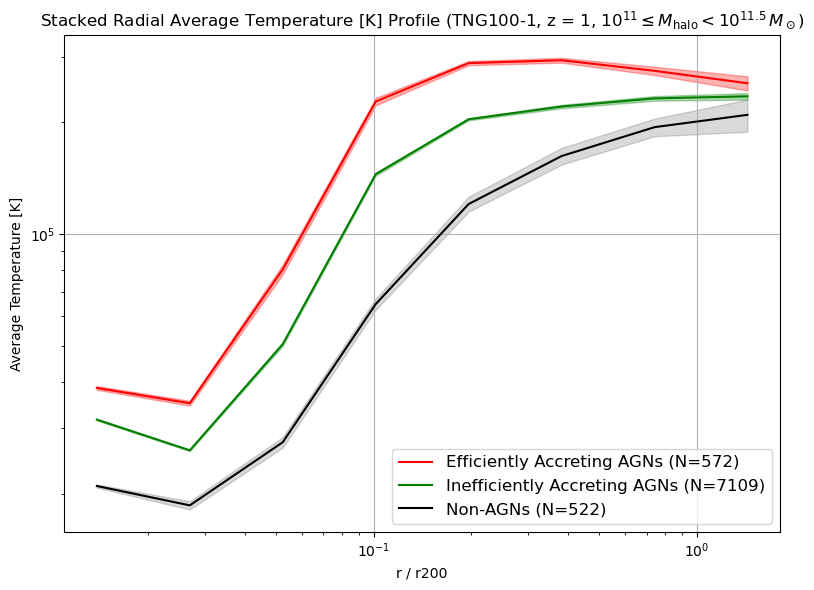

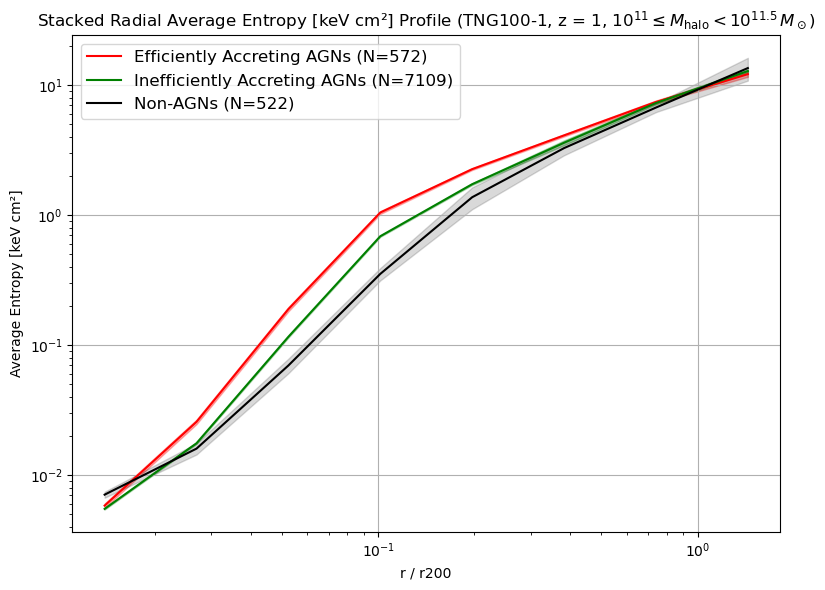

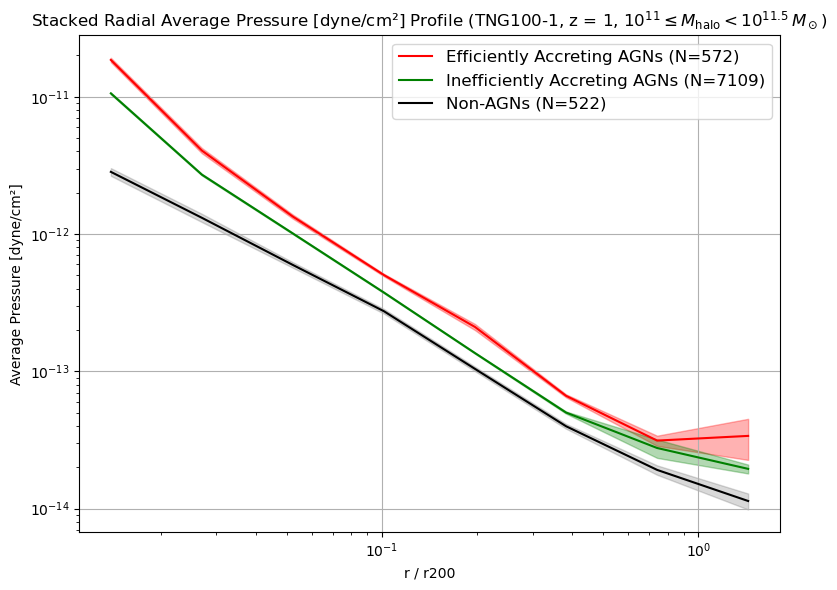

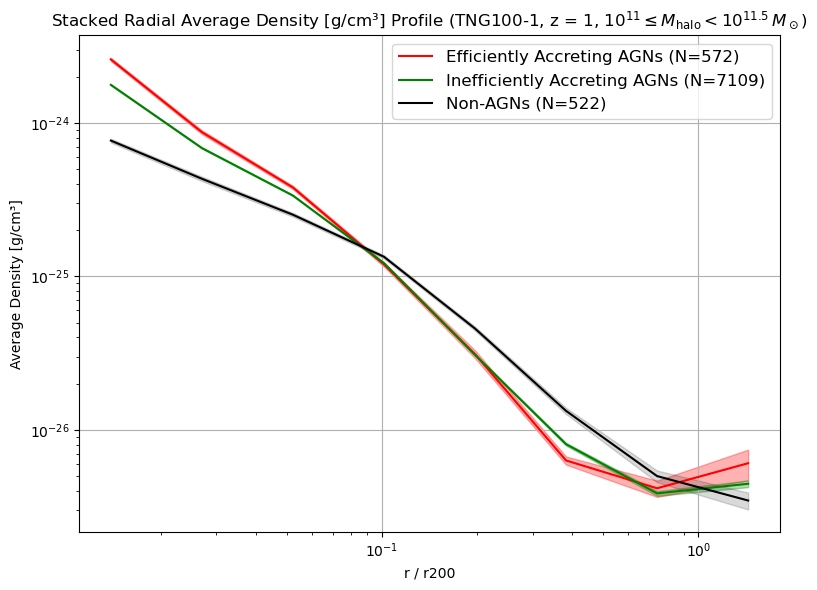

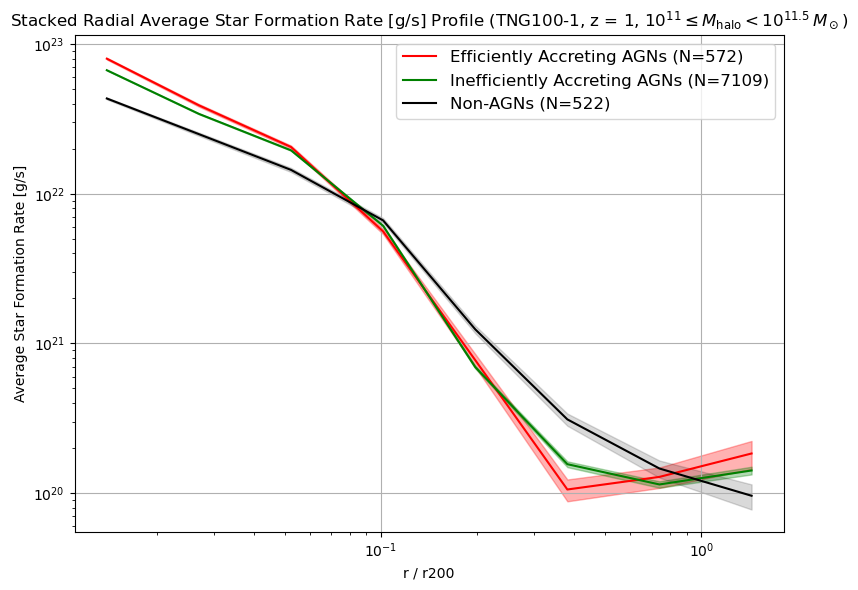

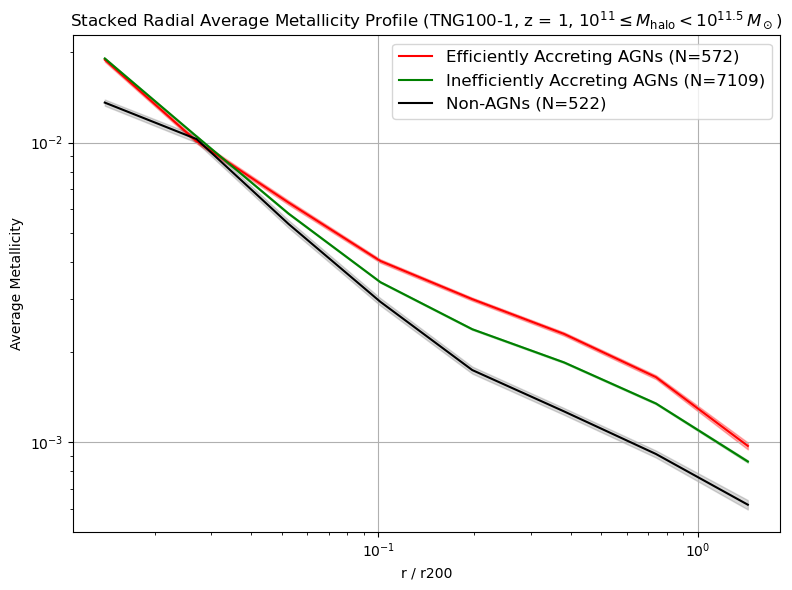

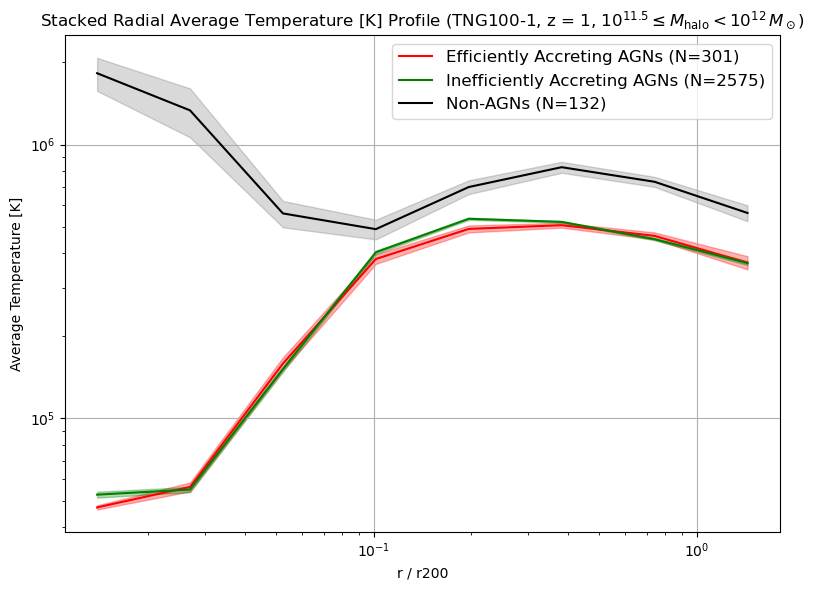

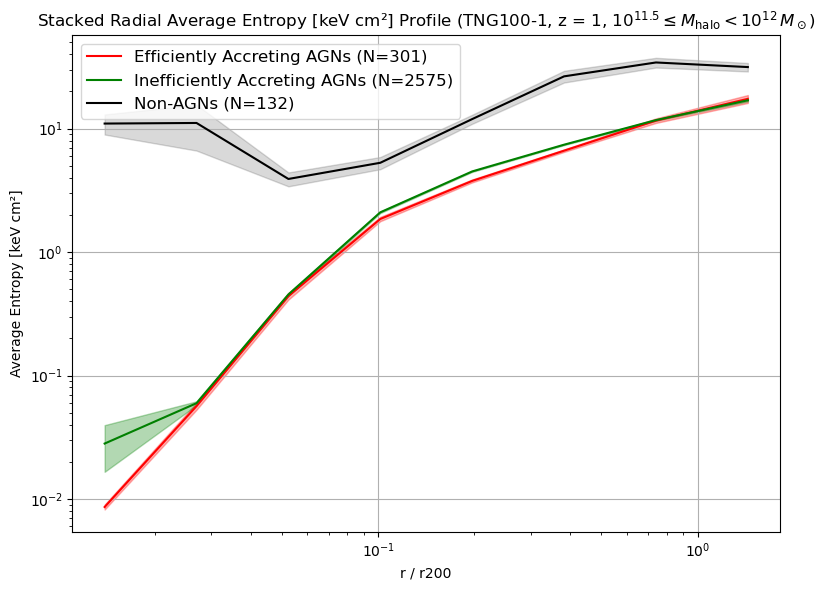

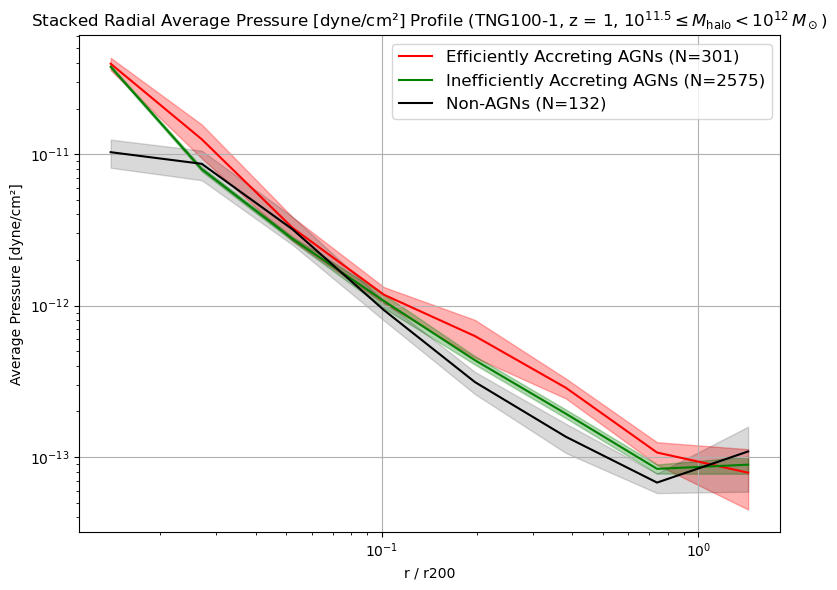

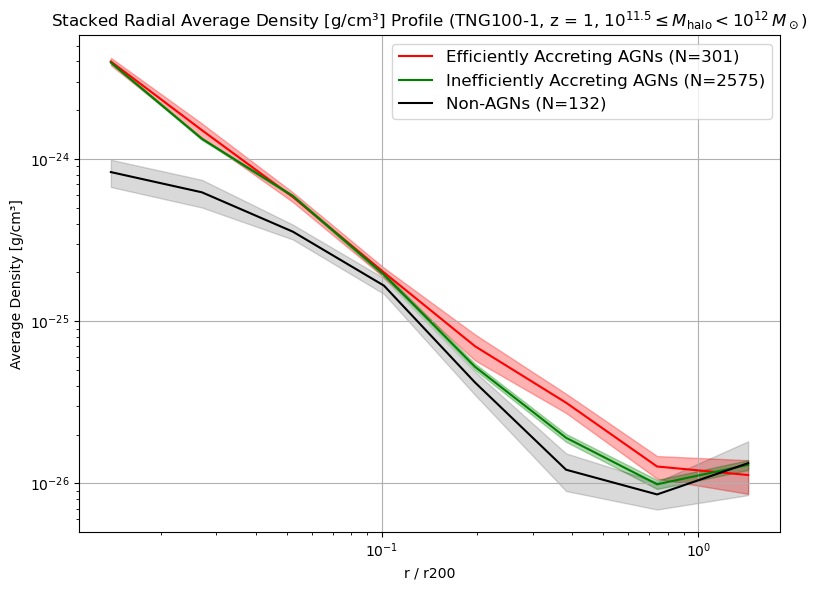

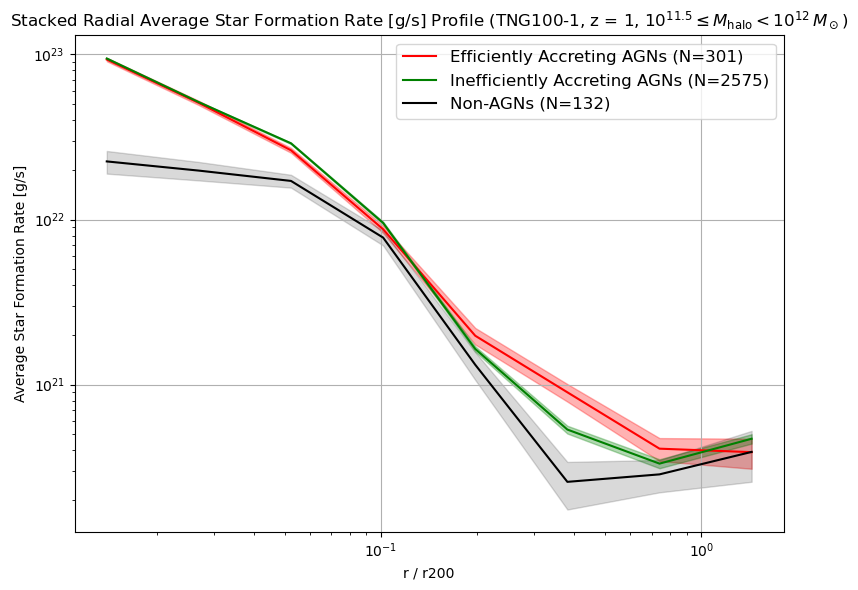

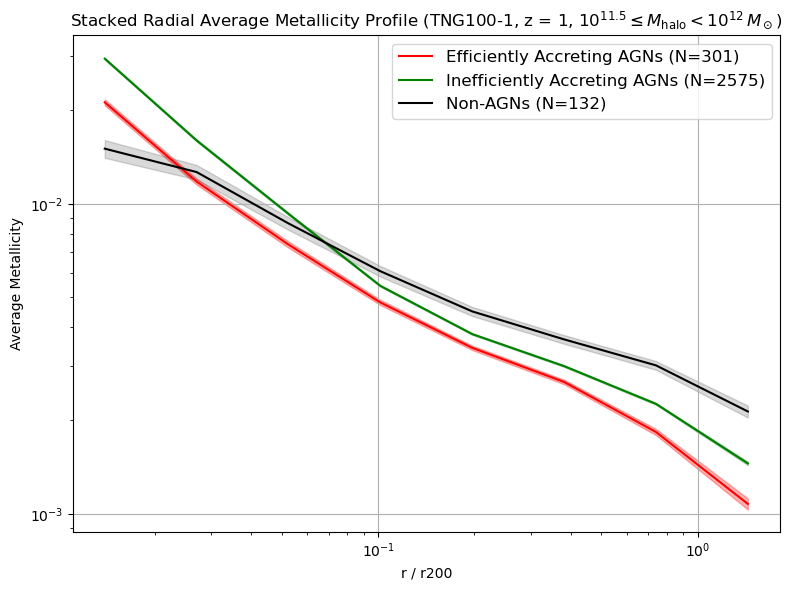

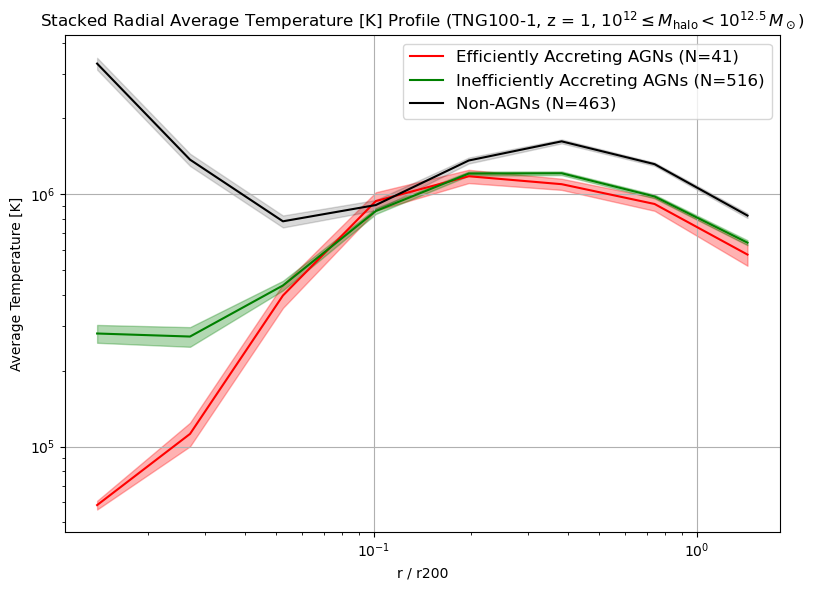

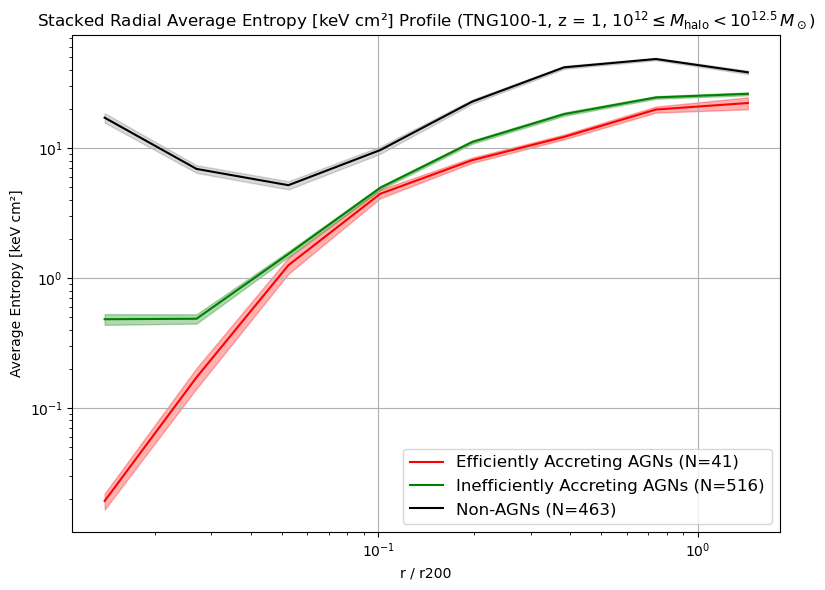

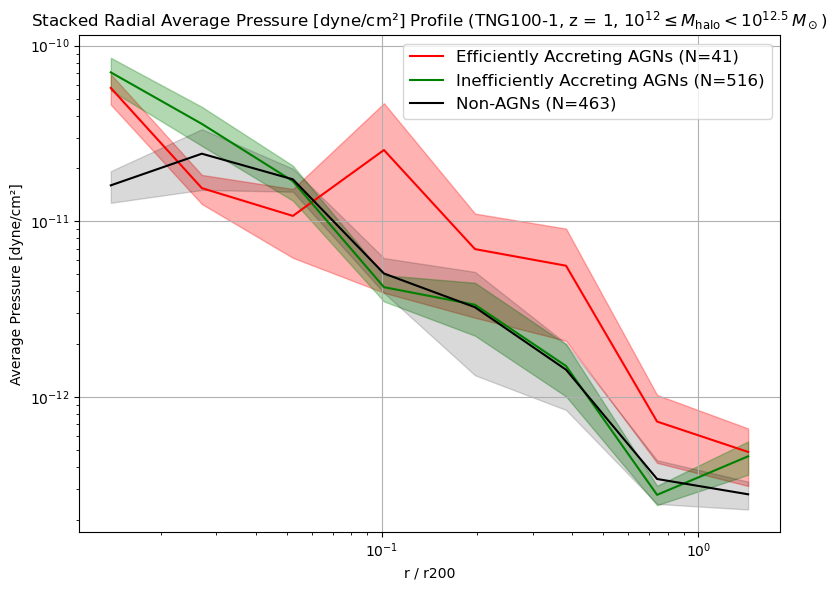

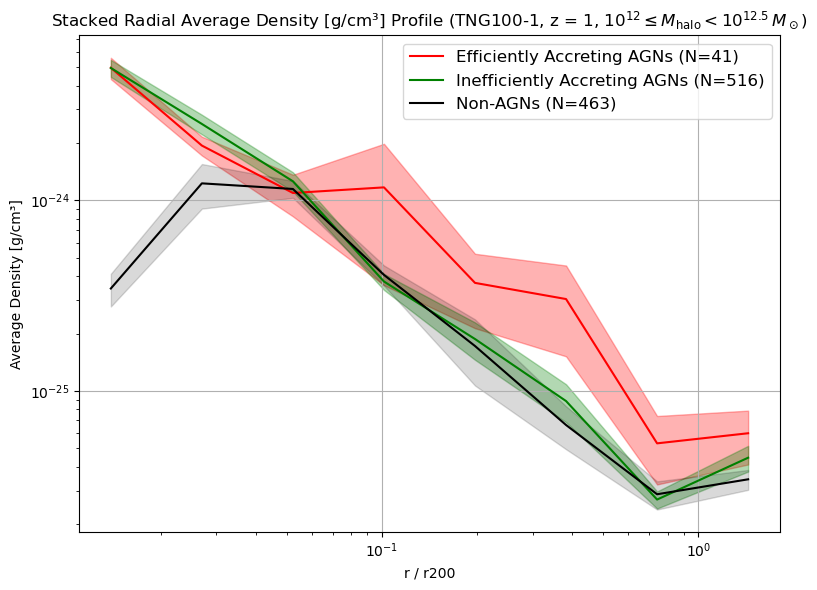

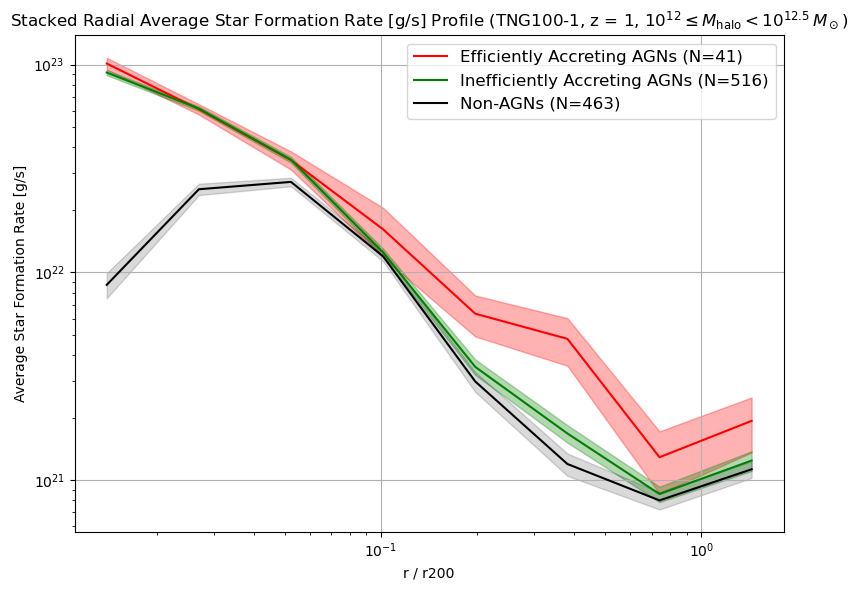

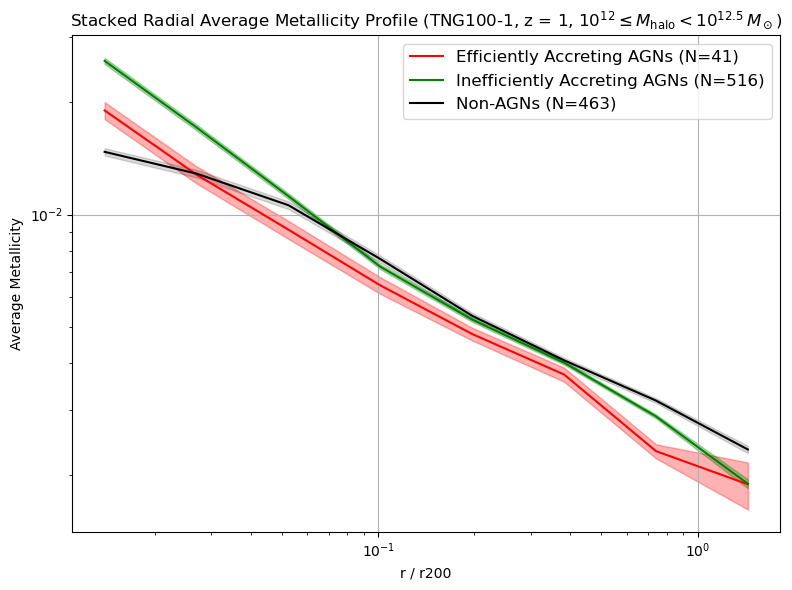

ValueError: x and y must have same first dimension, but have shapes (8,) and (1,)

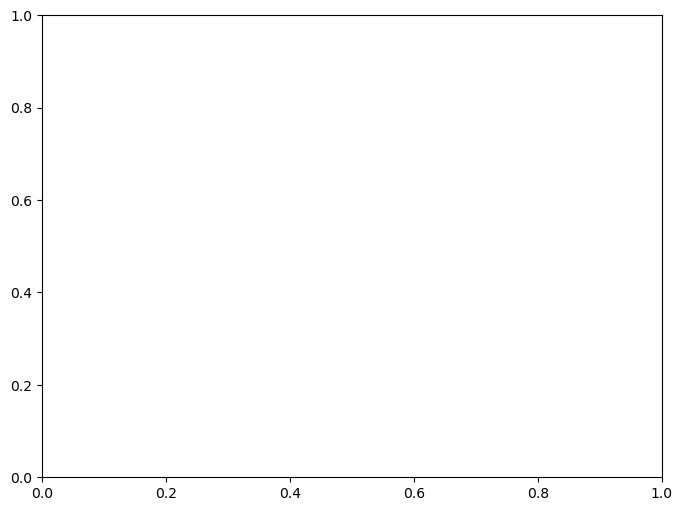

In [ ]:
# PART 5: Plot Thermodynamical Profiles (with 3 labels in each)

#bin_edges = np.linspace(0, r_norm_max, nbins + 1)
#bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

bin_edges = np.logspace(np.log10(r_norm_min), np.log10(r_norm_max), nbins + 1)
bin_centers = np.sqrt(bin_edges[:-1] * bin_edges[1:])

#hm = "3"
#hmn = r"$10^{12.5} \leq M_{\rm halo} < 10^{13} \, M_\odot$"

hmv = ["2", "3", "4"]

hmname = [
    #r"$10^{11} \leq M_{\rm halo} < 10^{11.5} \, M_\odot$",
    r"$10^{11.5} \leq M_{\rm halo} < 10^{12} \, M_\odot$",
    r"$10^{12} \leq M_{\rm halo} < 10^{12.5} \, M_\odot$",
    r"$10^{12.5} \leq M_{\rm halo} < 10^{13} \, M_\odot$"
    #r"$10^{13} \leq M_{\rm halo} < 10^{13.5} \, M_\odot$",
    #r"$10^{13.5} \leq M_{\rm halo} \, (M_\odot)$"
]


for hm, hmn in zip(hmv, hmname):
    profiles_ha_agn = np.load(f"combined100ytm_hm{hm}_{tag[0]}.npz")
    profiles_hn_agn = np.load(f"combined100ytm_hm{hm}_{tag[2]}.npz")
    profiles_hn_non = np.load(f"combined100ytm_hm{hm}_{tag[3]}.npz")

    data = np.load(f"accretor_agn100_mine_hm{hm}.npz")          #ha_agn, ha_non, hn_agn, hn_non ids
    ha_agn = data["ha_agn"]
    hn_agn = data["hn_agn"]
    hn_non = data["hn_non"]

    def plot_quantity(quantity, ylabel, filename):

        avg_ha_agn = profiles_ha_agn[f"{quantity}_mean"]
        err_ha_agn = profiles_ha_agn[f"{quantity}_sem"]

        avg_hn_agn = profiles_hn_agn[f"{quantity}_mean"]
        err_hn_agn = profiles_hn_agn[f"{quantity}_sem"]

        avg_hn_non = profiles_hn_non[f"{quantity}_mean"]
        err_hn_non = profiles_hn_non[f"{quantity}_sem"]

        plt.figure(figsize=(8, 6))

        # Efficient Accretors - AGN
        plt.plot(bin_centers, avg_ha_agn.flatten(), label=f"Efficiently Accreting AGNs (N={len(ha_agn)})", color="red")
        plt.fill_between(bin_centers, (avg_ha_agn - err_ha_agn).flatten(), (avg_ha_agn + err_ha_agn).flatten(), color="red", alpha=0.3)


        # Inefficient Accretors - AGN
        plt.plot(bin_centers, avg_hn_agn.flatten(), label=f"Inefficiently Accreting AGNs (N={len(hn_agn)})", color="green")
        plt.fill_between(bin_centers, (avg_hn_agn - err_hn_agn).flatten(), (avg_hn_agn + err_hn_agn).flatten(), color="green", alpha=0.3)

        # Inefficient Accretors - Non-AGN
        plt.plot(bin_centers, avg_hn_non.flatten(), label=f"Non-AGNs (N={len(hn_non)})", color="black")
        plt.fill_between(bin_centers, (avg_hn_non - err_hn_non).flatten(), (avg_hn_non + err_hn_non).flatten(),color="black", alpha=0.15)
 
        plt.xlabel("r / r200")
        plt.ylabel(ylabel)
        plt.title(f"Stacked Radial {ylabel} Profile (TNG100-1, z = 1, {hmn})")
        plt.legend(fontsize=12)
        plt.grid(True)
        #plt.xlim(1, 2)
        #plt.ylim(ylim)
        plt.xscale("log")
        plt.yscale("log")
        plt.tight_layout()
        plt.savefig(filename, dpi=900)
        plt.show()

    # Call the plot function for each physical quantity
    plot_quantity("temperature", "Average Temperature [K]", f"temperature100_{hm}.png")
    plot_quantity("entropy", "Average Entropy [keV cm²]", f"entropy100_{hm}.png")
    plot_quantity("pressure", "Average Pressure [dyne/cm²]", f"pressure100_{hm}.png")
    plot_quantity("density", "Average Density [g/cm³]", f"density100_{hm}.png")
    plot_quantity("sfr", "Average Star Formation Rate [g/s]", f"sfr100_{hm}.png")
    plot_quantity("metal", "Average Metallicity", f"metal100_{hm}.png")

puchii


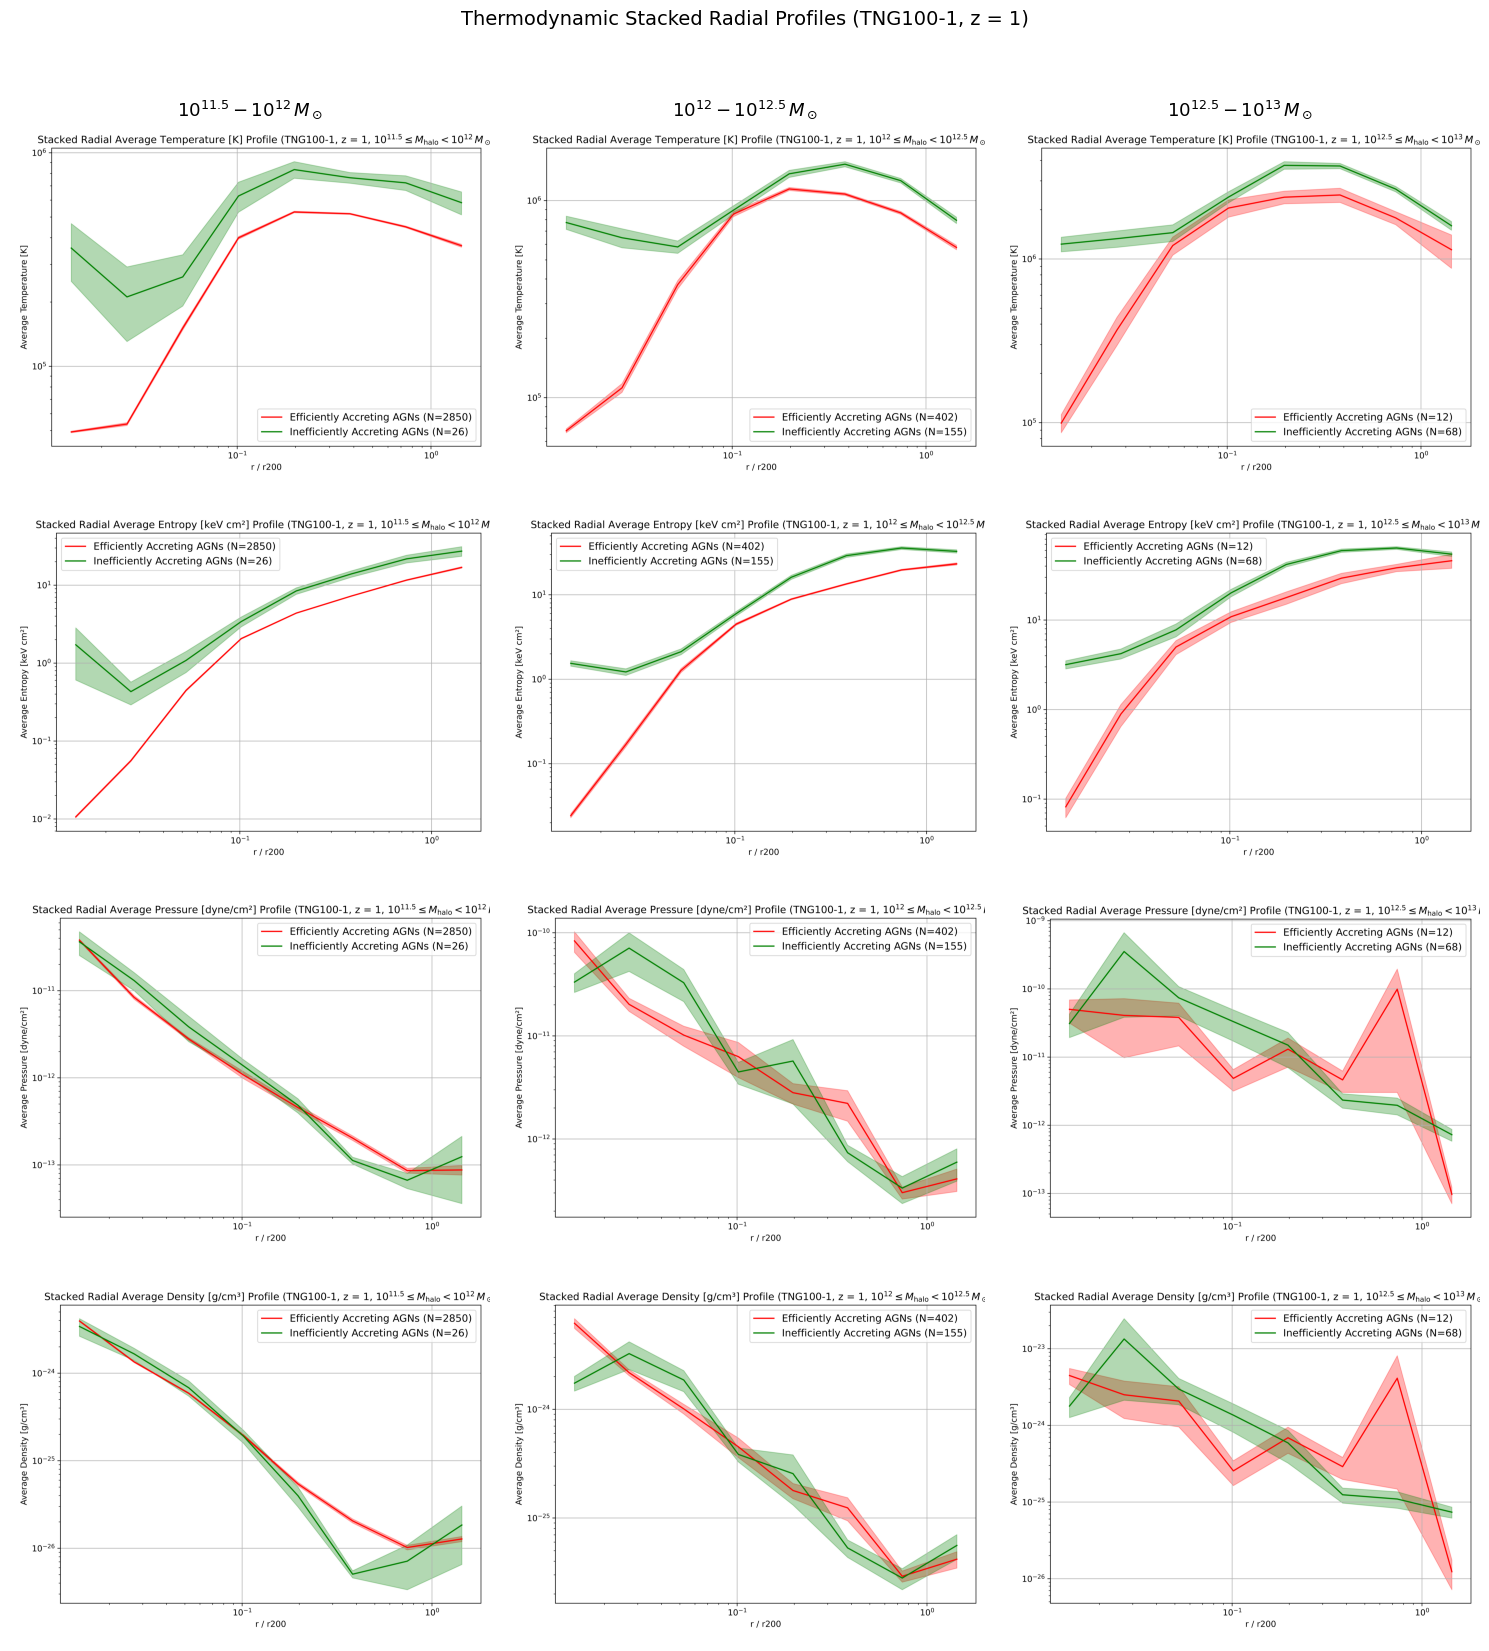

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

print("puchii")

quantities = ["temperature", "entropy", "pressure", "density"]#, "sfr", "metal"]
#hms = ["1", "2", "3", "4", "5", "6"]
hms = ["2", "3", "4"]

hm_labels = [
    #r"$10^{11} - 10^{11.5} \, M_\odot$",
    r"$10^{11.5} - 10^{12} \, M_\odot$",
    r"$10^{12} - 10^{12.5} \, M_\odot$",
    r"$10^{12.5} - 10^{13} \, M_\odot$"
    #r"$10^{13} - 10^{13.5} \, M_\odot$",
    #r"$> 10^{13.5} \, M_\odot$"
]


fig, axes = plt.subplots(len(quantities), len(hms), figsize=(15, 17))

for i, quantity in enumerate(quantities):
    for j, hm in enumerate(hms):
        filename = f"{quantity}100_{hm}.png"
        try:
            img = Image.open(filename)
            ax = axes[i, j]
            ax.imshow(np.asarray(img))
            ax.axis('off')
            if i == 0:
                ax.set_title(hm_labels[j], fontsize=13)
            if j == 0:
                ax.set_ylabel(quantity.capitalize(), fontsize=10)
        except Exception as e:
            print(f"Could not load {filename}: {e}")
            axes[i, j].axis('off')

# Add a super title
fig.suptitle("Thermodynamic Stacked Radial Profiles (TNG100-1, z = 1)", fontsize=14)

plt.tight_layout(rect=[0, 0, 1, 0.96])  # leave space for supertitle
plt.savefig("tng100_ytm_mine_final.pdf", dpi=1200)

plt.show()


working


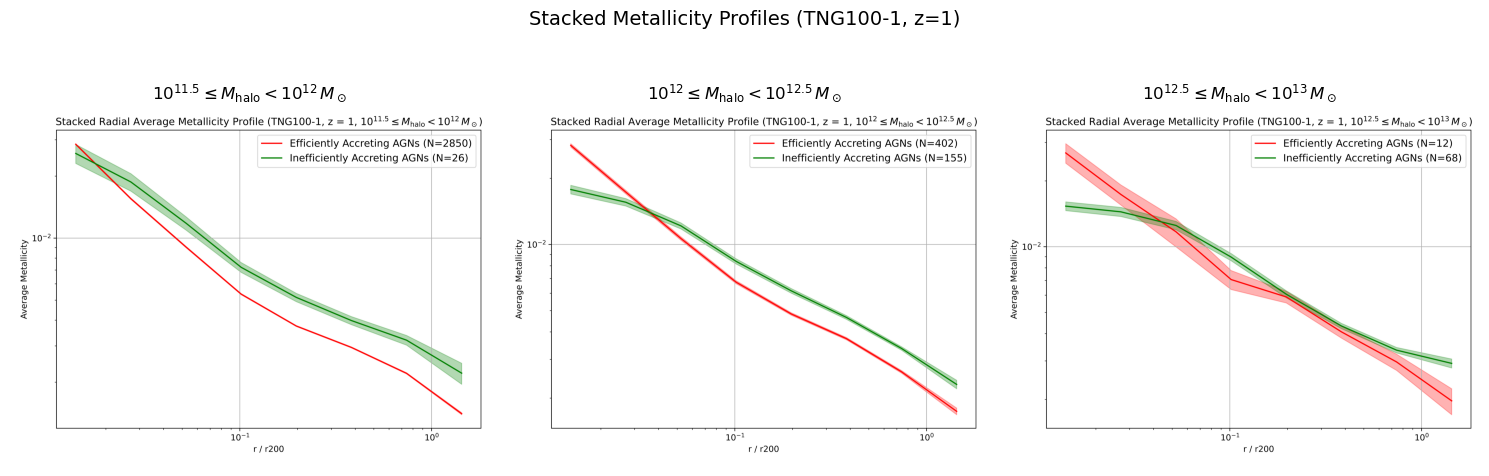

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

print("working")

quantity = "metal"
heading = "Metallicity"
hm_bins = ["2", "3", "4"]

hm_labels = [
    r"$10^{11.5} \leq M_{\rm halo} < 10^{12} \, M_\odot$",
    r"$10^{12} \leq M_{\rm halo} < 10^{12.5} \, M_\odot$",
    r"$10^{12.5} \leq M_{\rm halo} < 10^{13} \, M_\odot$"
]

# Create 1 row × 3 columns
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # Adjust size if needed

for idx, (hm, label) in enumerate(zip(hm_bins, hm_labels)):
    ax = axes[idx]
    filename = f"{quantity}100_{hm}.png"
    try:
        img = Image.open(filename)
        ax.imshow(np.asarray(img))
        ax.axis('off')
        ax.set_title(label, fontsize=12)
    except Exception as e:
        print(f"Could not load {filename}: {e}")
        ax.axis('off')

# Main title
fig.suptitle(f"Stacked {heading} Profiles (TNG100-1, z=1)", fontsize=14)

# Layout and save
plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.savefig(f"{quantity}100mine_profiles_z1.png", dpi=1000)
plt.show()
